In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import sys

sys.path.append("/code")

from tqdm import tqdm
import torch
import time
# device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# import gym
# import recogym

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

torch.backends.cudnn.benchmark = torch.cuda.is_available()
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")  # TF32 = big speedup on Ada


from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
import optuna
# from memory_profiler import profile


from estimators import (
    DirectMethod as DM
)

from simulation_utils import (
    eval_policy,
    generate_dataset,
    create_simulation_data_from_pi,
    get_train_data,
    get_opl_results_dict,
    CustomCFDataset,
    calc_reward,
    get_weights_info
)

from models import (    
    LinearCFModel,
    NeighborhoodModel,
    BPRModel, 
    RegressionModel
)

from training_utils import (
    train,
    validation_loop, 
    cv_score_model
 )


from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial
)


random_state=12345
random_ = check_random_state(random_state)

pd.options.display.float_format = '{:,.8f}'.format

Using device: cuda
Using device: cuda
Using device: cuda


## Learning

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

Our parameters for the dataset will be
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$

to learn a new policy from $\pi$ we will sample from:
$$\pi_{start} = (1-\epsilon)*\pi + \epsilon * \pi_{random}$$

In [2]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params)

Random Item CTR: 0.07066414727263938
Optimal greedy CTR: 0.09999926940951757
Second Best greedy CTR: 0.0980913477695915
Optimal Stochastic CTR: 0.09995326955796031
second Best Stochastic CTR: 0.08595012935428775
Our Initial CTR: 0.08610747363354625


In [3]:
num_runs = 1
batch_size = 200
num_neighbors = 6
n_trials_for_optuna = 200
# num_rounds_list = [500, 1000, 2000, 10000, 20000]
# num_rounds_list = [500, 1000, 2000]
num_rounds_list = [15000]


# Manually define your best parameters
best_params_to_use = {
    "lr": 0.096,  # Learning rate
    "num_epochs": 5,  # Number of training epochs
    "batch_size": 64,  # Batch size for training
    "num_neighbors": 8,  # Number of neighbors for neighborhood model
    "lr_decay": 0.85  # Learning rate decay factor
}


### 1

$$emb = 0.7 * gt + 0.3 * noise$$
$$lr = 0.005$$
$$n_{epochs} = 1$$
$$BatchSize=50$$

In [4]:
print("Value of num_rounds_list:", num_rounds_list)

# Run the optimization
df4, study_df = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# # Print best hyperparameters for each training size
# print("\n=== BEST HYPERPARAMETERS BY TRAINING SIZE ===")
# for train_size, params in best_hyperparams_by_size.items():
#     print(f"\nTraining Size: {train_size}")
#     # print(f"Best Reward: {params['reward']:.6f}")
#     print("Parameters:")
#     for param_name, value in params['params'].items():
#         print(f"  {param_name}: {value}")
# print("===========================\n")

# Show the performance metrics
df4[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Value of num_rounds_list: [15000]
Simulation time for 10000 samples: 0.026729345321655273 seconds
[Regression] Baseline regression model fit time: 0.08s
Num samples is 10000
{'gini': np.float64(0.4769721614015786), 'ess': np.float64(4366.346033928406), 'max_wi': np.float64(21.115469399314577), 'min_wi': np.float64(0.011748074160316308)}
Eval time: 0.4879176616668701 seconds


[I 2025-11-23 23:44:53,839] A new study created in memory with name: no-name-698b644c-2c97-4788-b7e3-0e55ee953946


Evaluation total results time: 0.99 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.06238079071044922 seconds


  0%|          | 0/200 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: -inf:   0%|          | 1/200 [00:04<14:02,  4.23s/it]

actual reward: [0.07950131]
Validation weights_info: {'gini': np.float64(0.9870816793190119), 'ess': np.float64(33.47962537918217), 'max_wi': np.float64(1559.6245566055125), 'min_wi': np.float64(0.0)}
Estimated reward: 0.086880
Cross-validated error: 0.001569
Final score CI (reward +- 2*error): [0.083742, 0.090018]
Standard error: 0.000169
Final t_dist CI (reward +- t_0.975*se_hat): [0.086548, 0.087212]
[I 2025-11-23 23:44:58,074] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 0. Best value: -inf:   1%|          | 2/200 [00:07<12:21,  3.74s/it]

actual reward: [0.08412632]
Validation weights_info: {'gini': np.float64(0.9951940776503204), 'ess': np.float64(15.225714552432132), 'max_wi': np.float64(898.287083846069), 'min_wi': np.float64(4.3153411119638215e-35)}
Estimated reward: 0.084289
Cross-validated error: 0.005178
Final score CI (reward +- 2*error): [0.073933, 0.094645]
Standard error: 0.000205
Final t_dist CI (reward +- t_0.975*se_hat): [0.083887, 0.084690]
[I 2025-11-23 23:45:01,475] Trial 1 finished with value: -inf and parameters: {'lr': 0.08999590004755217, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8627185796128352}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 2


Best trial: 2. Best value: 0.0795426:   2%|▏         | 3/200 [00:08<08:35,  2.62s/it]

actual reward: [0.08623137]
Validation weights_info: {'gini': np.float64(0.15637439017908916), 'ess': np.float64(9162.671075998458), 'max_wi': np.float64(2.1512917457603713), 'min_wi': np.float64(0.4955364133983365)}
Estimated reward: 0.080586
Cross-validated error: 0.000522
Final score CI (reward +- 2*error): [0.079543, 0.081630]
Standard error: 0.001951
Final t_dist CI (reward +- t_0.975*se_hat): [0.076762, 0.084410]
[I 2025-11-23 23:45:02,748] Trial 2 finished with value: 0.07954264186579177 and parameters: {'lr': 0.0008942246093476428, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8443430083252499}. Best is trial 2 with value: 0.07954264186579177.

[Regression] Optuna Trial 3


Best trial: 3. Best value: 0.0796635:   2%|▏         | 4/200 [00:10<07:45,  2.38s/it]

actual reward: [0.0862131]
Validation weights_info: {'gini': np.float64(0.14451243129840416), 'ess': np.float64(9279.54634267779), 'max_wi': np.float64(2.0272774987743727), 'min_wi': np.float64(0.5251308371201562)}
Estimated reward: 0.080603
Cross-validated error: 0.000470
Final score CI (reward +- 2*error): [0.079663, 0.081543]
Standard error: 0.001962
Final t_dist CI (reward +- t_0.975*se_hat): [0.076758, 0.084448]
[I 2025-11-23 23:45:04,757] Trial 3 finished with value: 0.07966346690308874 and parameters: {'lr': 0.00027335562542420556, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8629894737733776}. Best is trial 3 with value: 0.07966346690308874.

[Regression] Optuna Trial 4


Best trial: 4. Best value: 0.0814091:   2%|▎         | 5/200 [00:12<06:53,  2.12s/it]

actual reward: [0.08670257]
Validation weights_info: {'gini': np.float64(0.6483559253419455), 'ess': np.float64(2544.219096406589), 'max_wi': np.float64(15.033374494790815), 'min_wi': np.float64(0.017987556994432954)}
Estimated reward: 0.082386
Cross-validated error: 0.000489
Final score CI (reward +- 2*error): [0.081409, 0.083364]
Standard error: 0.001247
Final t_dist CI (reward +- t_0.975*se_hat): [0.079942, 0.084831]
[I 2025-11-23 23:45:06,419] Trial 4 finished with value: 0.08140911564516697 and parameters: {'lr': 0.0024609067431121965, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8561940699322218}. Best is trial 4 with value: 0.08140911564516697.

[Regression] Optuna Trial 5


Best trial: 4. Best value: 0.0814091:   3%|▎         | 6/200 [00:13<05:35,  1.73s/it]

actual reward: [0.08633611]
Validation weights_info: {'gini': np.float64(0.3172071291133355), 'ess': np.float64(7073.847841329704), 'max_wi': np.float64(3.828040197516366), 'min_wi': np.float64(0.22213248197196817)}
Estimated reward: 0.080793
Cross-validated error: 0.000546
Final score CI (reward +- 2*error): [0.079702, 0.081884]
Standard error: 0.001746
Final t_dist CI (reward +- t_0.975*se_hat): [0.077370, 0.084216]
[I 2025-11-23 23:45:07,396] Trial 5 finished with value: 0.07970180374625539 and parameters: {'lr': 0.0027248870944635737, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9243391084491959}. Best is trial 4 with value: 0.08140911564516697.

[Regression] Optuna Trial 6


Best trial: 6. Best value: 0.0839394:   4%|▎         | 7/200 [00:19<10:19,  3.21s/it]

actual reward: [0.08951077]
Validation weights_info: {'gini': np.float64(0.9080572600957801), 'ess': np.float64(460.81109320999224), 'max_wi': np.float64(207.64946500186664), 'min_wi': np.float64(4.177841197526265e-05)}
Estimated reward: 0.085625
Cross-validated error: 0.000843
Final score CI (reward +- 2*error): [0.083939, 0.087310]
Standard error: 0.000799
Final t_dist CI (reward +- t_0.975*se_hat): [0.084059, 0.087190]
[I 2025-11-23 23:45:13,658] Trial 6 finished with value: 0.08393941444576464 and parameters: {'lr': 0.001266984418132055, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9333640159381803}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 7


Best trial: 6. Best value: 0.0839394:   4%|▍         | 8/200 [00:23<10:15,  3.21s/it]

actual reward: [0.08161487]
Validation weights_info: {'gini': np.float64(0.9959163888687126), 'ess': np.float64(7.96289595436535), 'max_wi': np.float64(2067.1395505702567), 'min_wi': np.float64(5.920334623581184e-26)}
Estimated reward: 0.086939
Cross-validated error: 0.005387
Final score CI (reward +- 2*error): [0.076164, 0.097713]
Standard error: 0.000258
Final t_dist CI (reward +- t_0.975*se_hat): [0.086432, 0.087445]
[I 2025-11-23 23:45:16,851] Trial 7 finished with value: -inf and parameters: {'lr': 0.04260541047847599, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9851501558960936}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 8


Best trial: 6. Best value: 0.0839394:   4%|▍         | 9/200 [00:28<12:03,  3.79s/it]

actual reward: [0.08650601]
Validation weights_info: {'gini': np.float64(0.5378528172857104), 'ess': np.float64(3862.749143860685), 'max_wi': np.float64(9.880985198232864), 'min_wi': np.float64(0.040867967965502065)}
Estimated reward: 0.081721
Cross-validated error: 0.000454
Final score CI (reward +- 2*error): [0.080814, 0.082628]
Standard error: 0.001424
Final t_dist CI (reward +- t_0.975*se_hat): [0.078930, 0.084512]
[I 2025-11-23 23:45:21,919] Trial 8 finished with value: 0.08081402776822479 and parameters: {'lr': 0.000306867333960163, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9831226114537245}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 9


Best trial: 6. Best value: 0.0839394:   5%|▌         | 10/200 [00:30<10:50,  3.42s/it]

actual reward: [0.08692717]
Validation weights_info: {'gini': np.float64(0.782827625050684), 'ess': np.float64(1307.8140262444592), 'max_wi': np.float64(26.618851283392516), 'min_wi': np.float64(0.0032115478874582375)}
Estimated reward: 0.083783
Cross-validated error: 0.000502
Final score CI (reward +- 2*error): [0.082780, 0.084786]
Standard error: 0.001052
Final t_dist CI (reward +- t_0.975*se_hat): [0.081720, 0.085846]
[I 2025-11-23 23:45:24,520] Trial 9 finished with value: 0.08277980287377207 and parameters: {'lr': 0.0019227248706075919, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8111962114627038}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 10


Best trial: 6. Best value: 0.0839394:   6%|▌         | 11/200 [00:36<13:22,  4.25s/it]

actual reward: [0.08962524]
Validation weights_info: {'gini': np.float64(0.9949231314570112), 'ess': np.float64(17.901881804460643), 'max_wi': np.float64(1847.035250836268), 'min_wi': np.float64(2.751739038627777e-15)}
Estimated reward: 0.085812
Cross-validated error: 0.003391
Final score CI (reward +- 2*error): [0.079030, 0.092594]
Standard error: 0.000370
Final t_dist CI (reward +- t_0.975*se_hat): [0.085087, 0.086537]
[I 2025-11-23 23:45:30,637] Trial 10 finished with value: -inf and parameters: {'lr': 0.014690396834693647, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9366423294144338}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 11


Best trial: 6. Best value: 0.0839394:   6%|▌         | 12/200 [00:39<11:43,  3.74s/it]

actual reward: [0.08649703]
Validation weights_info: {'gini': np.float64(0.5382310636303465), 'ess': np.float64(3803.9512628960574), 'max_wi': np.float64(10.568919779885839), 'min_wi': np.float64(0.044164424532456746)}
Estimated reward: 0.081735
Cross-validated error: 0.000476
Final score CI (reward +- 2*error): [0.080783, 0.082687]
Standard error: 0.001424
Final t_dist CI (reward +- t_0.975*se_hat): [0.078943, 0.084527]
[I 2025-11-23 23:45:33,230] Trial 11 finished with value: 0.08078293723293199 and parameters: {'lr': 0.0010113954415450095, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8014187278433169}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 12


Best trial: 6. Best value: 0.0839394:   6%|▋         | 13/200 [00:41<09:53,  3.17s/it]

actual reward: [0.08782425]
Validation weights_info: {'gini': np.float64(0.9776813064526733), 'ess': np.float64(50.71650230409576), 'max_wi': np.float64(729.8822550468765), 'min_wi': np.float64(8.306902815916827e-07)}
Estimated reward: 0.087500
Cross-validated error: 0.004384
Final score CI (reward +- 2*error): [0.078731, 0.096268]
Standard error: 0.000531
Final t_dist CI (reward +- t_0.975*se_hat): [0.086459, 0.088540]
[I 2025-11-23 23:45:35,096] Trial 12 finished with value: -inf and parameters: {'lr': 0.008354445096353986, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9069479168559624}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 13


Best trial: 6. Best value: 0.0839394:   7%|▋         | 14/200 [00:44<09:47,  3.16s/it]

actual reward: [0.08617171]
Validation weights_info: {'gini': np.float64(0.10180942634780527), 'ess': np.float64(9637.373332262696), 'max_wi': np.float64(1.7414357871810728), 'min_wi': np.float64(0.63246363731107)}
Estimated reward: 0.080596
Cross-validated error: 0.000461
Final score CI (reward +- 2*error): [0.079674, 0.081517]
Standard error: 0.001993
Final t_dist CI (reward +- t_0.975*se_hat): [0.076689, 0.084502]
[I 2025-11-23 23:45:38,220] Trial 13 finished with value: 0.07967433189965734 and parameters: {'lr': 0.00010812657246022892, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9516103969370122}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 14


Best trial: 6. Best value: 0.0839394:   8%|▊         | 15/200 [00:47<09:16,  3.01s/it]

actual reward: [0.086505]
Validation weights_info: {'gini': np.float64(0.6159162666451024), 'ess': np.float64(2769.953190408117), 'max_wi': np.float64(14.558741405740186), 'min_wi': np.float64(0.02371099301257749)}
Estimated reward: 0.082218
Cross-validated error: 0.000477
Final score CI (reward +- 2*error): [0.081265, 0.083172]
Standard error: 0.001311
Final t_dist CI (reward +- t_0.975*se_hat): [0.079649, 0.084788]
[I 2025-11-23 23:45:40,887] Trial 14 finished with value: 0.08126511171883768 and parameters: {'lr': 0.0010635850166265965, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8116560604998337}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 15


Best trial: 6. Best value: 0.0839394:   8%|▊         | 16/200 [00:53<12:10,  3.97s/it]

actual reward: [0.09089646]
Validation weights_info: {'gini': np.float64(0.9923863877314659), 'ess': np.float64(15.081692694257244), 'max_wi': np.float64(1374.7320273019845), 'min_wi': np.float64(2.577831386463417e-12)}
Estimated reward: 0.089254
Cross-validated error: 0.002713
Final score CI (reward +- 2*error): [0.083829, 0.094679]
Standard error: 0.000355
Final t_dist CI (reward +- t_0.975*se_hat): [0.088559, 0.089949]
[I 2025-11-23 23:45:47,073] Trial 15 finished with value: -inf and parameters: {'lr': 0.0072112451142884075, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8957786997639559}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 16


Best trial: 6. Best value: 0.0839394:   8%|▊         | 17/200 [00:54<09:53,  3.24s/it]

actual reward: [0.08621578]
Validation weights_info: {'gini': np.float64(0.15162816009651592), 'ess': np.float64(9206.897158811691), 'max_wi': np.float64(2.1321619474991875), 'min_wi': np.float64(0.5078087555365662)}
Estimated reward: 0.080601
Cross-validated error: 0.000530
Final score CI (reward +- 2*error): [0.079541, 0.081660]
Standard error: 0.001955
Final t_dist CI (reward +- t_0.975*se_hat): [0.076769, 0.084432]
[I 2025-11-23 23:45:48,636] Trial 16 finished with value: 0.07954110910061636 and parameters: {'lr': 0.0005006713253495549, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.890312214990323}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 17


Best trial: 6. Best value: 0.0839394:   9%|▉         | 18/200 [00:55<07:58,  2.63s/it]

actual reward: [0.08640301]
Validation weights_info: {'gini': np.float64(0.36685005430420525), 'ess': np.float64(6346.5503296392535), 'max_wi': np.float64(4.832601493509293), 'min_wi': np.float64(0.16513801052954924)}
Estimated reward: 0.080924
Cross-validated error: 0.000465
Final score CI (reward +- 2*error): [0.079994, 0.081854]
Standard error: 0.001670
Final t_dist CI (reward +- t_0.975*se_hat): [0.077651, 0.084198]
[I 2025-11-23 23:45:49,829] Trial 17 finished with value: 0.07999351674279562 and parameters: {'lr': 0.00515124117348698, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9539886444654604}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 18


Best trial: 6. Best value: 0.0839394:  10%|▉         | 19/200 [01:00<09:15,  3.07s/it]

actual reward: [0.08873804]
Validation weights_info: {'gini': np.float64(0.8742060113856159), 'ess': np.float64(841.8860986162314), 'max_wi': np.float64(82.15961956932814), 'min_wi': np.float64(0.00021219204803457514)}
Estimated reward: 0.084886
Cross-validated error: 0.000597
Final score CI (reward +- 2*error): [0.083693, 0.086079]
Standard error: 0.000872
Final t_dist CI (reward +- t_0.975*se_hat): [0.083177, 0.086595]
[I 2025-11-23 23:45:53,931] Trial 18 finished with value: 0.08369310244841853 and parameters: {'lr': 0.0019003479585682518, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8240362591626135}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 19


Best trial: 6. Best value: 0.0839394:  10%|█         | 20/200 [01:05<11:41,  3.90s/it]

actual reward: [0.09037583]
Validation weights_info: {'gini': np.float64(0.992090684626044), 'ess': np.float64(18.639095870293247), 'max_wi': np.float64(1484.7975789880802), 'min_wi': np.float64(3.2242934134010536e-13)}
Estimated reward: 0.084964
Cross-validated error: 0.003575
Final score CI (reward +- 2*error): [0.077813, 0.092115]
Standard error: 0.000331
Final t_dist CI (reward +- t_0.975*se_hat): [0.084315, 0.085613]
[I 2025-11-23 23:45:59,763] Trial 19 finished with value: -inf and parameters: {'lr': 0.012757026170753156, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8843448356027551}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 20


Best trial: 6. Best value: 0.0839394:  10%|█         | 21/200 [01:10<12:36,  4.23s/it]

actual reward: [0.08624154]
Validation weights_info: {'gini': np.float64(0.20377858809986044), 'ess': np.float64(8620.877609025245), 'max_wi': np.float64(2.8001046361922493), 'min_wi': np.float64(0.37197821033385453)}
Estimated reward: 0.080700
Cross-validated error: 0.000496
Final score CI (reward +- 2*error): [0.079709, 0.081691]
Standard error: 0.001904
Final t_dist CI (reward +- t_0.975*se_hat): [0.076967, 0.084432]
[I 2025-11-23 23:46:04,759] Trial 20 finished with value: 0.0797086013402789 and parameters: {'lr': 0.00014070970512433035, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9189839680493731}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 21


Best trial: 6. Best value: 0.0839394:  11%|█         | 22/200 [01:15<12:45,  4.30s/it]

actual reward: [0.08744137]
Validation weights_info: {'gini': np.float64(0.8243523329921708), 'ess': np.float64(1154.563417882892), 'max_wi': np.float64(40.49709711892065), 'min_wi': np.float64(0.001528414021654887)}
Estimated reward: 0.083898
Cross-validated error: 0.000590
Final score CI (reward +- 2*error): [0.082718, 0.085078]
Standard error: 0.000979
Final t_dist CI (reward +- t_0.975*se_hat): [0.081979, 0.085816]
[I 2025-11-23 23:46:09,228] Trial 21 finished with value: 0.08271764596996234 and parameters: {'lr': 0.0013859322960826862, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8255889196908464}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 22


Best trial: 6. Best value: 0.0839394:  12%|█▏        | 23/200 [01:17<10:54,  3.70s/it]

actual reward: [0.08663298]
Validation weights_info: {'gini': np.float64(0.7759269699767665), 'ess': np.float64(1248.7241237534265), 'max_wi': np.float64(27.83223532908597), 'min_wi': np.float64(0.003026601432092006)}
Estimated reward: 0.083831
Cross-validated error: 0.000594
Final score CI (reward +- 2*error): [0.082642, 0.085019]
Standard error: 0.001071
Final t_dist CI (reward +- t_0.975*se_hat): [0.081732, 0.085930]
[I 2025-11-23 23:46:11,519] Trial 22 finished with value: 0.082642401581146 and parameters: {'lr': 0.002041658684861902, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8278436194526486}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 23


Best trial: 6. Best value: 0.0839394:  12%|█▏        | 24/200 [01:20<10:22,  3.54s/it]

actual reward: [0.08637691]
Validation weights_info: {'gini': np.float64(0.3852831023494223), 'ess': np.float64(5989.581474302253), 'max_wi': np.float64(5.972437547257048), 'min_wi': np.float64(0.12459092081308579)}
Estimated reward: 0.081072
Cross-validated error: 0.000506
Final score CI (reward +- 2*error): [0.080059, 0.082085]
Standard error: 0.001655
Final t_dist CI (reward +- t_0.975*se_hat): [0.077827, 0.084317]
[I 2025-11-23 23:46:14,679] Trial 23 finished with value: 0.08005946193975041 and parameters: {'lr': 0.0004902895525589595, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8240681872734669}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 24


Best trial: 6. Best value: 0.0839394:  12%|█▎        | 25/200 [01:22<09:05,  3.12s/it]

actual reward: [0.0883391]
Validation weights_info: {'gini': np.float64(0.8915886441364812), 'ess': np.float64(497.7211519000917), 'max_wi': np.float64(170.3878007259061), 'min_wi': np.float64(0.0004043314681880558)}
Estimated reward: 0.085706
Cross-validated error: 0.000909
Final score CI (reward +- 2*error): [0.083889, 0.087524]
Standard error: 0.000826
Final t_dist CI (reward +- t_0.975*se_hat): [0.084087, 0.087325]
[I 2025-11-23 23:46:16,812] Trial 24 finished with value: 0.08388888879043253 and parameters: {'lr': 0.003866731160208093, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.964385118237721}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 25


Best trial: 6. Best value: 0.0839394:  13%|█▎        | 26/200 [01:25<08:09,  2.82s/it]

actual reward: [0.08866579]
Validation weights_info: {'gini': np.float64(0.9026343975110048), 'ess': np.float64(278.2468400809253), 'max_wi': np.float64(306.7827992437393), 'min_wi': np.float64(0.000329767292775103)}
Estimated reward: 0.085479
Cross-validated error: 0.000776
Final score CI (reward +- 2*error): [0.083927, 0.087032]
Standard error: 0.000812
Final t_dist CI (reward +- t_0.975*se_hat): [0.083888, 0.087071]
[I 2025-11-23 23:46:18,928] Trial 25 finished with value: 0.0839265072158326 and parameters: {'lr': 0.00402922151600449, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9638430749751556}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 26


Best trial: 6. Best value: 0.0839394:  14%|█▎        | 27/200 [01:27<07:30,  2.60s/it]

actual reward: [0.0888852]
Validation weights_info: {'gini': np.float64(0.9215280925256852), 'ess': np.float64(117.46567482937907), 'max_wi': np.float64(682.8780436162513), 'min_wi': np.float64(8.083855722745788e-05)}
Estimated reward: 0.085137
Cross-validated error: 0.001143
Final score CI (reward +- 2*error): [0.082850, 0.087423]
Standard error: 0.000779
Final t_dist CI (reward +- t_0.975*se_hat): [0.083610, 0.086663]
[I 2025-11-23 23:46:21,031] Trial 26 finished with value: 0.08284995830584096 and parameters: {'lr': 0.004823572604453528, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9643903561374253}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 27


Best trial: 6. Best value: 0.0839394:  14%|█▍        | 28/200 [01:29<07:06,  2.48s/it]

actual reward: [0.08600285]
Validation weights_info: {'gini': np.float64(0.994090353300873), 'ess': np.float64(10.676627679121088), 'max_wi': np.float64(1940.748103666192), 'min_wi': np.float64(3.132596908863118e-13)}
Estimated reward: 0.087994
Cross-validated error: 0.004713
Final score CI (reward +- 2*error): [0.078569, 0.097419]
Standard error: 0.000369
Final t_dist CI (reward +- t_0.975*se_hat): [0.087270, 0.088718]
[I 2025-11-23 23:46:23,223] Trial 27 finished with value: -inf and parameters: {'lr': 0.021436436648740762, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9969329692885763}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 28


Best trial: 6. Best value: 0.0839394:  14%|█▍        | 29/200 [01:31<06:50,  2.40s/it]

actual reward: [0.08900134]
Validation weights_info: {'gini': np.float64(0.9058896073411087), 'ess': np.float64(185.7310863563272), 'max_wi': np.float64(449.79897863878784), 'min_wi': np.float64(0.0002862932611240719)}
Estimated reward: 0.085358
Cross-validated error: 0.000730
Final score CI (reward +- 2*error): [0.083898, 0.086819]
Standard error: 0.000811
Final t_dist CI (reward +- t_0.975*se_hat): [0.083769, 0.086948]
[I 2025-11-23 23:46:25,442] Trial 28 finished with value: 0.0838976568979276 and parameters: {'lr': 0.004534955684793301, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9413865799562323}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 29


Best trial: 6. Best value: 0.0839394:  15%|█▌        | 30/200 [01:33<06:05,  2.15s/it]

actual reward: [0.08703544]
Validation weights_info: {'gini': np.float64(0.9933665836357732), 'ess': np.float64(7.64708110427881), 'max_wi': np.float64(4360.020118131053), 'min_wi': np.float64(3.5482427115506713e-09)}
Estimated reward: 0.085225
Cross-validated error: 0.005143
Final score CI (reward +- 2*error): [0.074938, 0.095511]
Standard error: 0.000433
Final t_dist CI (reward +- t_0.975*se_hat): [0.084375, 0.086074]
[I 2025-11-23 23:46:27,002] Trial 29 finished with value: -inf and parameters: {'lr': 0.02341377529513877, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9385059550487705}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 30


Best trial: 6. Best value: 0.0839394:  16%|█▌        | 31/200 [01:35<05:54,  2.10s/it]

actual reward: [0.08946644]
Validation weights_info: {'gini': np.float64(0.9850425273241361), 'ess': np.float64(17.01215342189686), 'max_wi': np.float64(2199.723068816924), 'min_wi': np.float64(1.631117130059919e-07)}
Estimated reward: 0.085767
Cross-validated error: 0.002141
Final score CI (reward +- 2*error): [0.081485, 0.090049]
Standard error: 0.000539
Final t_dist CI (reward +- t_0.975*se_hat): [0.084710, 0.086824]
[I 2025-11-23 23:46:28,992] Trial 30 finished with value: -inf and parameters: {'lr': 0.009310585858650302, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9273302897387675}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 31


Best trial: 6. Best value: 0.0839394:  16%|█▌        | 32/200 [01:37<06:11,  2.21s/it]

actual reward: [0.08878252]
Validation weights_info: {'gini': np.float64(0.8952217479378324), 'ess': np.float64(327.4603854410716), 'max_wi': np.float64(344.3849432925444), 'min_wi': np.float64(0.00027969749992243583)}
Estimated reward: 0.085013
Cross-validated error: 0.000716
Final score CI (reward +- 2*error): [0.083580, 0.086446]
Standard error: 0.000840
Final t_dist CI (reward +- t_0.975*se_hat): [0.083366, 0.086660]
[I 2025-11-23 23:46:31,456] Trial 31 finished with value: 0.08358038982509644 and parameters: {'lr': 0.00413588056588003, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9689639962623579}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 32


Best trial: 6. Best value: 0.0839394:  16%|█▋        | 33/200 [01:40<06:39,  2.39s/it]

actual reward: [0.08972719]
Validation weights_info: {'gini': np.float64(0.933253722102957), 'ess': np.float64(142.33058912884368), 'max_wi': np.float64(607.6657423741951), 'min_wi': np.float64(3.481119663158872e-05)}
Estimated reward: 0.085247
Cross-validated error: 0.001532
Final score CI (reward +- 2*error): [0.082183, 0.088311]
Standard error: 0.000731
Final t_dist CI (reward +- t_0.975*se_hat): [0.083813, 0.086681]
[I 2025-11-23 23:46:34,277] Trial 32 finished with value: 0.08218324004272147 and parameters: {'lr': 0.0037563427002099987, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9477417022917012}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 33


Best trial: 6. Best value: 0.0839394:  17%|█▋        | 34/200 [01:41<05:55,  2.14s/it]

actual reward: [0.08768062]
Validation weights_info: {'gini': np.float64(0.8715460555292163), 'ess': np.float64(657.0091883925155), 'max_wi': np.float64(182.07964323782804), 'min_wi': np.float64(0.0018903580233200737)}
Estimated reward: 0.084103
Cross-validated error: 0.000584
Final score CI (reward +- 2*error): [0.082934, 0.085272]
Standard error: 0.000815
Final t_dist CI (reward +- t_0.975*se_hat): [0.082506, 0.085700]
[I 2025-11-23 23:46:35,837] Trial 33 finished with value: 0.08293431246354478 and parameters: {'lr': 0.0065136690945277465, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.973308253160029}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 34


Best trial: 6. Best value: 0.0839394:  18%|█▊        | 35/200 [01:43<05:24,  1.97s/it]

actual reward: [0.08664494]
Validation weights_info: {'gini': np.float64(0.5871757939839968), 'ess': np.float64(3388.9237618275433), 'max_wi': np.float64(10.758331119874205), 'min_wi': np.float64(0.034026088127651004)}
Estimated reward: 0.081905
Cross-validated error: 0.000437
Final score CI (reward +- 2*error): [0.081031, 0.082780]
Standard error: 0.001321
Final t_dist CI (reward +- t_0.975*se_hat): [0.079317, 0.084494]
[I 2025-11-23 23:46:37,389] Trial 34 finished with value: 0.081030905201903 and parameters: {'lr': 0.003379422948302687, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.959770058394193}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 35


Best trial: 6. Best value: 0.0839394:  18%|█▊        | 36/200 [01:44<04:48,  1.76s/it]

actual reward: [0.08619216]
Validation weights_info: {'gini': np.float64(0.12147216801195458), 'ess': np.float64(9482.906160956893), 'max_wi': np.float64(1.854171134115002), 'min_wi': np.float64(0.5829744950751194)}
Estimated reward: 0.080619
Cross-validated error: 0.000512
Final score CI (reward +- 2*error): [0.079595, 0.081643]
Standard error: 0.001979
Final t_dist CI (reward +- t_0.975*se_hat): [0.076739, 0.084499]
[I 2025-11-23 23:46:38,676] Trial 35 finished with value: 0.07959533651545038 and parameters: {'lr': 0.0005660536423612513, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9110061677258783}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 36


Best trial: 6. Best value: 0.0839394:  18%|█▊        | 37/200 [01:47<05:54,  2.18s/it]

actual reward: [0.08749579]
Validation weights_info: {'gini': np.float64(0.8199513342993722), 'ess': np.float64(1175.7596125344273), 'max_wi': np.float64(52.958147330173695), 'min_wi': np.float64(0.0014338771251515862)}
Estimated reward: 0.084087
Cross-validated error: 0.000562
Final score CI (reward +- 2*error): [0.082962, 0.085212]
Standard error: 0.000994
Final t_dist CI (reward +- t_0.975*se_hat): [0.082139, 0.086035]
[I 2025-11-23 23:46:41,815] Trial 36 finished with value: 0.08296188323636583 and parameters: {'lr': 0.0015096124831594801, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9433145843457627}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 37


Best trial: 6. Best value: 0.0839394:  19%|█▉        | 38/200 [01:49<05:05,  1.89s/it]

actual reward: [0.08745358]
Validation weights_info: {'gini': np.float64(0.9571573014816012), 'ess': np.float64(369.38970255522145), 'max_wi': np.float64(103.15085818977654), 'min_wi': np.float64(2.8128225009336567e-08)}
Estimated reward: 0.083042
Cross-validated error: 0.001060
Final score CI (reward +- 2*error): [0.080921, 0.085162]
Standard error: 0.000523
Final t_dist CI (reward +- t_0.975*se_hat): [0.082017, 0.084067]
[I 2025-11-23 23:46:43,026] Trial 37 finished with value: 0.08092142861145828 and parameters: {'lr': 0.05570329438015555, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9319426722021009}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 38


Best trial: 6. Best value: 0.0839394:  20%|█▉        | 39/200 [01:51<05:31,  2.06s/it]

actual reward: [0.0899017]
Validation weights_info: {'gini': np.float64(0.910636709847402), 'ess': np.float64(668.3378602357876), 'max_wi': np.float64(57.65164159275784), 'min_wi': np.float64(7.789110175873074e-05)}
Estimated reward: 0.085009
Cross-validated error: 0.000620
Final score CI (reward +- 2*error): [0.083769, 0.086249]
Standard error: 0.000729
Final t_dist CI (reward +- t_0.975*se_hat): [0.083580, 0.086438]
[I 2025-11-23 23:46:45,478] Trial 38 finished with value: 0.08376947553104301 and parameters: {'lr': 0.0028518273698766652, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9819854319256531}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 39


Best trial: 6. Best value: 0.0839394:  20%|██        | 40/200 [01:57<08:18,  3.11s/it]

actual reward: [0.08685496]
Validation weights_info: {'gini': np.float64(0.7343870469074772), 'ess': np.float64(1783.6120230411555), 'max_wi': np.float64(20.84584606791553), 'min_wi': np.float64(0.004082922531746814)}
Estimated reward: 0.083277
Cross-validated error: 0.000488
Final score CI (reward +- 2*error): [0.082301, 0.084252]
Standard error: 0.001137
Final t_dist CI (reward +- t_0.975*se_hat): [0.081049, 0.085505]
[I 2025-11-23 23:46:51,064] Trial 39 finished with value: 0.08230116881158558 and parameters: {'lr': 0.0006197586198729755, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9156583509436057}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 40


Best trial: 6. Best value: 0.0839394:  20%|██        | 41/200 [01:59<07:46,  2.93s/it]

actual reward: [0.08764571]
Validation weights_info: {'gini': np.float64(0.9930633832036065), 'ess': np.float64(13.15038218897856), 'max_wi': np.float64(1732.1224267129858), 'min_wi': np.float64(7.311697584422279e-12)}
Estimated reward: 0.090071
Cross-validated error: 0.003253
Final score CI (reward +- 2*error): [0.083564, 0.096578]
Standard error: 0.000365
Final t_dist CI (reward +- t_0.975*se_hat): [0.089355, 0.090787]
[I 2025-11-23 23:46:53,570] Trial 40 finished with value: -inf and parameters: {'lr': 0.012239742929889828, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9951426004181819}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 41


Best trial: 6. Best value: 0.0839394:  21%|██        | 42/200 [02:02<07:16,  2.77s/it]

actual reward: [0.09018598]
Validation weights_info: {'gini': np.float64(0.9175034545068509), 'ess': np.float64(583.499538551926), 'max_wi': np.float64(97.39493158175313), 'min_wi': np.float64(4.585970253734737e-05)}
Estimated reward: 0.084934
Cross-validated error: 0.000526
Final score CI (reward +- 2*error): [0.083882, 0.085985]
Standard error: 0.000693
Final t_dist CI (reward +- t_0.975*se_hat): [0.083576, 0.086292]
[I 2025-11-23 23:46:55,946] Trial 41 finished with value: 0.08388239467544009 and parameters: {'lr': 0.0030774889143198626, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.98220323440645}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 42


Best trial: 6. Best value: 0.0839394:  22%|██▏       | 43/200 [02:04<07:10,  2.74s/it]

actual reward: [0.09031239]
Validation weights_info: {'gini': np.float64(0.9108901621037658), 'ess': np.float64(693.7145839716295), 'max_wi': np.float64(62.98891177477817), 'min_wi': np.float64(3.918632070082327e-05)}
Estimated reward: 0.084962
Cross-validated error: 0.000633
Final score CI (reward +- 2*error): [0.083696, 0.086229]
Standard error: 0.000714
Final t_dist CI (reward +- t_0.975*se_hat): [0.083562, 0.086363]
[I 2025-11-23 23:46:58,635] Trial 42 finished with value: 0.08369616016833689 and parameters: {'lr': 0.0025487531067729403, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9768412614989309}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 43


Best trial: 6. Best value: 0.0839394:  22%|██▏       | 44/200 [02:07<06:53,  2.65s/it]

actual reward: [0.08757499]
Validation weights_info: {'gini': np.float64(0.9798122595231485), 'ess': np.float64(56.334455780911526), 'max_wi': np.float64(486.6774191002147), 'min_wi': np.float64(5.043140873670033e-07)}
Estimated reward: 0.086077
Cross-validated error: 0.003471
Final score CI (reward +- 2*error): [0.079135, 0.093020]
Standard error: 0.000546
Final t_dist CI (reward +- t_0.975*se_hat): [0.085007, 0.087148]
[I 2025-11-23 23:47:01,076] Trial 43 finished with value: -inf and parameters: {'lr': 0.005245390531244315, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9600029154684029}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 44


Best trial: 6. Best value: 0.0839394:  22%|██▎       | 45/200 [02:10<06:59,  2.71s/it]

actual reward: [0.08664883]
Validation weights_info: {'gini': np.float64(0.6292992969297594), 'ess': np.float64(2724.771157908322), 'max_wi': np.float64(14.36350703343882), 'min_wi': np.float64(0.02026907106341763)}
Estimated reward: 0.082198
Cross-validated error: 0.000474
Final score CI (reward +- 2*error): [0.081250, 0.083146]
Standard error: 0.001284
Final t_dist CI (reward +- t_0.975*se_hat): [0.079681, 0.084715]
[I 2025-11-23 23:47:03,917] Trial 44 finished with value: 0.0812500526130264 and parameters: {'lr': 0.0007630049991906158, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9910712246297192}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 45


Best trial: 6. Best value: 0.0839394:  23%|██▎       | 46/200 [02:12<06:57,  2.71s/it]

actual reward: [0.08683322]
Validation weights_info: {'gini': np.float64(0.7488957762533489), 'ess': np.float64(1531.9444880824205), 'max_wi': np.float64(23.94424326854553), 'min_wi': np.float64(0.004623414797668007)}
Estimated reward: 0.083410
Cross-validated error: 0.000552
Final score CI (reward +- 2*error): [0.082305, 0.084515]
Standard error: 0.001117
Final t_dist CI (reward +- t_0.975*se_hat): [0.081220, 0.085600]
[I 2025-11-23 23:47:06,630] Trial 45 finished with value: 0.08230469715851815 and parameters: {'lr': 0.0011392591275098292, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9727801691246701}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 46


Best trial: 6. Best value: 0.0839394:  24%|██▎       | 47/200 [02:14<06:26,  2.53s/it]

actual reward: [0.08669569]
Validation weights_info: {'gini': np.float64(0.6350337251017883), 'ess': np.float64(2651.1326597633074), 'max_wi': np.float64(14.93899729472742), 'min_wi': np.float64(0.021596685805765566)}
Estimated reward: 0.082136
Cross-validated error: 0.000518
Final score CI (reward +- 2*error): [0.081099, 0.083173]
Standard error: 0.001262
Final t_dist CI (reward +- t_0.975*se_hat): [0.079663, 0.084609]
[I 2025-11-23 23:47:08,727] Trial 46 finished with value: 0.08109934988874647 and parameters: {'lr': 0.001778478703880516, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9554644165248634}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 47


Best trial: 6. Best value: 0.0839394:  24%|██▍       | 48/200 [02:21<09:12,  3.63s/it]

actual reward: [0.08980868]
Validation weights_info: {'gini': np.float64(0.9783476419069947), 'ess': np.float64(35.92452292505426), 'max_wi': np.float64(1134.067615616576), 'min_wi': np.float64(8.911287554157773e-09)}
Estimated reward: 0.086188
Cross-validated error: 0.002592
Final score CI (reward +- 2*error): [0.081004, 0.091372]
Standard error: 0.000519
Final t_dist CI (reward +- t_0.975*se_hat): [0.085171, 0.087205]
[I 2025-11-23 23:47:14,936] Trial 47 finished with value: -inf and parameters: {'lr': 0.002710869723842715, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9423930704218153}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 48


Best trial: 6. Best value: 0.0839394:  24%|██▍       | 49/200 [02:24<09:10,  3.65s/it]

actual reward: [0.09080277]
Validation weights_info: {'gini': np.float64(0.9857524375457656), 'ess': np.float64(16.19715443919401), 'max_wi': np.float64(2162.65557604424), 'min_wi': np.float64(1.23774692861519e-10)}
Estimated reward: 0.087843
Cross-validated error: 0.003261
Final score CI (reward +- 2*error): [0.081322, 0.094364]
Standard error: 0.000487
Final t_dist CI (reward +- t_0.975*se_hat): [0.086889, 0.088797]
[I 2025-11-23 23:47:18,616] Trial 48 finished with value: -inf and parameters: {'lr': 0.006236933055639907, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9849071353178388}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 49


Best trial: 6. Best value: 0.0839394:  25%|██▌       | 50/200 [02:26<07:22,  2.95s/it]

actual reward: [0.08650197]
Validation weights_info: {'gini': np.float64(0.6296055240117324), 'ess': np.float64(2565.92512405936), 'max_wi': np.float64(16.380615232744628), 'min_wi': np.float64(0.022133480649270842)}
Estimated reward: 0.082510
Cross-validated error: 0.000493
Final score CI (reward +- 2*error): [0.081524, 0.083497]
Standard error: 0.001290
Final t_dist CI (reward +- t_0.975*se_hat): [0.079981, 0.085040]
[I 2025-11-23 23:47:19,933] Trial 49 finished with value: 0.08152368522544559 and parameters: {'lr': 0.0034784177545711743, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8754085253111542}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 50


Best trial: 6. Best value: 0.0839394:  26%|██▌       | 51/200 [02:29<07:24,  2.98s/it]

actual reward: [0.08638487]
Validation weights_info: {'gini': np.float64(0.34844970021347516), 'ess': np.float64(6612.394469620862), 'max_wi': np.float64(4.844609049098922), 'min_wi': np.float64(0.16171442010875414)}
Estimated reward: 0.081016
Cross-validated error: 0.000463
Final score CI (reward +- 2*error): [0.080091, 0.081941]
Standard error: 0.001711
Final t_dist CI (reward +- t_0.975*se_hat): [0.077662, 0.084370]
[I 2025-11-23 23:47:22,997] Trial 50 finished with value: 0.08009116725174797 and parameters: {'lr': 0.00031767101222280713, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9656800233529633}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 51


Best trial: 6. Best value: 0.0839394:  26%|██▌       | 52/200 [02:31<06:57,  2.82s/it]

actual reward: [0.0890716]
Validation weights_info: {'gini': np.float64(0.8865015182873447), 'ess': np.float64(798.9449026049441), 'max_wi': np.float64(37.660250759662375), 'min_wi': np.float64(0.0001631131441094161)}
Estimated reward: 0.085116
Cross-validated error: 0.000627
Final score CI (reward +- 2*error): [0.083863, 0.086370]
Standard error: 0.000819
Final t_dist CI (reward +- t_0.975*se_hat): [0.083511, 0.086722]
[I 2025-11-23 23:47:25,442] Trial 51 finished with value: 0.08386279232033746 and parameters: {'lr': 0.002378923254556287, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9802404821146887}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 52


Best trial: 6. Best value: 0.0839394:  26%|██▋       | 53/200 [02:33<06:32,  2.67s/it]

actual reward: [0.07737687]
Validation weights_info: {'gini': np.float64(0.9958109488561957), 'ess': np.float64(8.429931051266099), 'max_wi': np.float64(1120.39529120079), 'min_wi': np.float64(1.1624999587348402e-09)}
Estimated reward: 0.083302
Cross-validated error: 0.005875
Final score CI (reward +- 2*error): [0.071553, 0.095051]
Standard error: 0.000268
Final t_dist CI (reward +- t_0.975*se_hat): [0.082778, 0.083827]
[I 2025-11-23 23:47:27,771] Trial 52 finished with value: -inf and parameters: {'lr': 0.008782472509050676, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.97894747564406}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 53


Best trial: 6. Best value: 0.0839394:  27%|██▋       | 54/200 [02:36<06:20,  2.60s/it]

actual reward: [0.08877755]
Validation weights_info: {'gini': np.float64(0.8769817551219826), 'ess': np.float64(819.7171035304822), 'max_wi': np.float64(37.72709896575213), 'min_wi': np.float64(0.0002934859991861525)}
Estimated reward: 0.084735
Cross-validated error: 0.000654
Final score CI (reward +- 2*error): [0.083428, 0.086043]
Standard error: 0.000861
Final t_dist CI (reward +- t_0.975*se_hat): [0.083048, 0.086422]
[I 2025-11-23 23:47:30,215] Trial 53 finished with value: 0.08342821529720039 and parameters: {'lr': 0.0021491996766993815, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9885677396132444}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 54


Best trial: 6. Best value: 0.0839394:  28%|██▊       | 55/200 [02:38<06:13,  2.58s/it]

actual reward: [0.08680172]
Validation weights_info: {'gini': np.float64(0.7576189765752591), 'ess': np.float64(1427.5849344752216), 'max_wi': np.float64(25.322081058385283), 'min_wi': np.float64(0.004333070775529674)}
Estimated reward: 0.083412
Cross-validated error: 0.000472
Final score CI (reward +- 2*error): [0.082467, 0.084357]
Standard error: 0.001106
Final t_dist CI (reward +- t_0.975*se_hat): [0.081244, 0.085580]
[I 2025-11-23 23:47:32,729] Trial 54 finished with value: 0.08246717746533118 and parameters: {'lr': 0.0012639747790957302, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9491565216431193}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 55


Best trial: 6. Best value: 0.0839394:  28%|██▊       | 56/200 [02:43<07:20,  3.06s/it]

actual reward: [0.08966164]
Validation weights_info: {'gini': np.float64(0.9821960333301217), 'ess': np.float64(17.626237343599545), 'max_wi': np.float64(2097.8647097701614), 'min_wi': np.float64(5.280552330441326e-09)}
Estimated reward: 0.087011
Cross-validated error: 0.001757
Final score CI (reward +- 2*error): [0.083497, 0.090524]
Standard error: 0.000526
Final t_dist CI (reward +- t_0.975*se_hat): [0.085980, 0.088041]
[I 2025-11-23 23:47:36,914] Trial 55 finished with value: -inf and parameters: {'lr': 0.0044042562890987185, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9248233504562068}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 56


Best trial: 6. Best value: 0.0839394:  28%|██▊       | 57/200 [02:45<07:04,  2.97s/it]

actual reward: [0.08740401]
Validation weights_info: {'gini': np.float64(0.8252746138119439), 'ess': np.float64(1039.897648587864), 'max_wi': np.float64(29.944197689667035), 'min_wi': np.float64(0.0012537428561373435)}
Estimated reward: 0.083862
Cross-validated error: 0.000598
Final score CI (reward +- 2*error): [0.082667, 0.085057]
Standard error: 0.000992
Final t_dist CI (reward +- t_0.975*se_hat): [0.081918, 0.085807]
[I 2025-11-23 23:47:39,670] Trial 56 finished with value: 0.0826666319187143 and parameters: {'lr': 0.0016043330275376134, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9344194228718476}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 57


Best trial: 6. Best value: 0.0839394:  29%|██▉       | 58/200 [02:49<07:33,  3.19s/it]

actual reward: [0.08996767]
Validation weights_info: {'gini': np.float64(0.954186784501814), 'ess': np.float64(71.59422362946158), 'max_wi': np.float64(800.9195915480699), 'min_wi': np.float64(9.669344973928586e-07)}
Estimated reward: 0.085777
Cross-validated error: 0.001042
Final score CI (reward +- 2*error): [0.083693, 0.087861]
Standard error: 0.000646
Final t_dist CI (reward +- t_0.975*se_hat): [0.084510, 0.087045]
[I 2025-11-23 23:47:43,383] Trial 57 finished with value: -inf and parameters: {'lr': 0.0030017453881566996, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9594213228397899}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 58


Best trial: 6. Best value: 0.0839394:  30%|██▉       | 59/200 [02:51<06:16,  2.67s/it]

actual reward: [0.08620201]
Validation weights_info: {'gini': np.float64(0.13882789926265432), 'ess': np.float64(9337.953735201714), 'max_wi': np.float64(2.0575580155737345), 'min_wi': np.float64(0.5120580480356668)}
Estimated reward: 0.080628
Cross-validated error: 0.000496
Final score CI (reward +- 2*error): [0.079635, 0.081621]
Standard error: 0.001969
Final t_dist CI (reward +- t_0.975*se_hat): [0.076769, 0.084487]
[I 2025-11-23 23:47:44,845] Trial 58 finished with value: 0.0796348684960466 and parameters: {'lr': 0.0008068142626029456, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9694591555467922}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 59


Best trial: 6. Best value: 0.0839394:  30%|███       | 60/200 [02:53<06:11,  2.65s/it]

actual reward: [0.08747953]
Validation weights_info: {'gini': np.float64(0.8574759950506434), 'ess': np.float64(888.3835661255275), 'max_wi': np.float64(44.08388240560237), 'min_wi': np.float64(0.0008125812603254663)}
Estimated reward: 0.084500
Cross-validated error: 0.000554
Final score CI (reward +- 2*error): [0.083392, 0.085609]
Standard error: 0.000917
Final t_dist CI (reward +- t_0.975*se_hat): [0.082703, 0.086297]
[I 2025-11-23 23:47:47,449] Trial 59 finished with value: 0.0833917240415838 and parameters: {'lr': 0.002201421329156374, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9018935526908806}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 60


Best trial: 6. Best value: 0.0839394:  30%|███       | 61/200 [02:55<05:46,  2.49s/it]

actual reward: [0.08974092]
Validation weights_info: {'gini': np.float64(0.9007244407745748), 'ess': np.float64(690.4748284555873), 'max_wi': np.float64(44.64721222861998), 'min_wi': np.float64(8.167315141981889e-05)}
Estimated reward: 0.084505
Cross-validated error: 0.000652
Final score CI (reward +- 2*error): [0.083201, 0.085808]
Standard error: 0.000767
Final t_dist CI (reward +- t_0.975*se_hat): [0.083002, 0.086008]
[I 2025-11-23 23:47:49,576] Trial 60 finished with value: 0.08320119795888543 and parameters: {'lr': 0.005665546816871851, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9994016973234284}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 61


Best trial: 6. Best value: 0.0839394:  31%|███       | 62/200 [02:58<05:35,  2.43s/it]

actual reward: [0.08980679]
Validation weights_info: {'gini': np.float64(0.909951135748858), 'ess': np.float64(665.7639095141319), 'max_wi': np.float64(66.76387455184236), 'min_wi': np.float64(7.016731756456797e-05)}
Estimated reward: 0.084941
Cross-validated error: 0.000629
Final score CI (reward +- 2*error): [0.083682, 0.086199]
Standard error: 0.000735
Final t_dist CI (reward +- t_0.975*se_hat): [0.083501, 0.086381]
[I 2025-11-23 23:47:51,856] Trial 61 finished with value: 0.08368237680348832 and parameters: {'lr': 0.002813942112650042, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9822153814018881}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 62


Best trial: 6. Best value: 0.0839394:  32%|███▏      | 63/200 [03:00<05:41,  2.49s/it]

actual reward: [0.0820925]
Validation weights_info: {'gini': np.float64(0.9951676611325591), 'ess': np.float64(11.603067417583786), 'max_wi': np.float64(1199.3584387279188), 'min_wi': np.float64(7.905706765547885e-09)}
Estimated reward: 0.084279
Cross-validated error: 0.004694
Final score CI (reward +- 2*error): [0.074891, 0.093667]
Standard error: 0.000326
Final t_dist CI (reward +- t_0.975*se_hat): [0.083640, 0.084919]
[I 2025-11-23 23:47:54,494] Trial 62 finished with value: -inf and parameters: {'lr': 0.007315001893956254, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9803228184881354}. Best is trial 6 with value: 0.08393941444576464.

[Regression] Optuna Trial 63


Best trial: 63. Best value: 0.0839932:  32%|███▏      | 64/200 [03:02<05:26,  2.40s/it]

actual reward: [0.0900795]
Validation weights_info: {'gini': np.float64(0.9359814088776609), 'ess': np.float64(367.93588217078747), 'max_wi': np.float64(167.77593379166723), 'min_wi': np.float64(1.690852861260284e-05)}
Estimated reward: 0.085487
Cross-validated error: 0.000747
Final score CI (reward +- 2*error): [0.083993, 0.086982]
Standard error: 0.000643
Final t_dist CI (reward +- t_0.975*se_hat): [0.084226, 0.086749]
[I 2025-11-23 23:47:56,676] Trial 63 finished with value: 0.08399324236217376 and parameters: {'lr': 0.003974751811757498, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9898294970016405}. Best is trial 63 with value: 0.08399324236217376.

[Regression] Optuna Trial 64


Best trial: 63. Best value: 0.0839932:  32%|███▎      | 65/200 [03:05<05:20,  2.37s/it]

actual reward: [0.08996163]
Validation weights_info: {'gini': np.float64(0.9308327730293592), 'ess': np.float64(408.8753684540117), 'max_wi': np.float64(166.18378382032427), 'min_wi': np.float64(1.5239763285580975e-05)}
Estimated reward: 0.085283
Cross-validated error: 0.001111
Final score CI (reward +- 2*error): [0.083060, 0.087505]
Standard error: 0.000657
Final t_dist CI (reward +- t_0.975*se_hat): [0.083994, 0.086571]
[I 2025-11-23 23:47:58,979] Trial 64 finished with value: 0.08305980597701068 and parameters: {'lr': 0.004219763712327902, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9636135061323684}. Best is trial 63 with value: 0.08399324236217376.

[Regression] Optuna Trial 65


Best trial: 63. Best value: 0.0839932:  33%|███▎      | 66/200 [03:10<07:18,  3.27s/it]

actual reward: [0.09297183]
Validation weights_info: {'gini': np.float64(0.9956177724052091), 'ess': np.float64(6.550778381163277), 'max_wi': np.float64(4282.703483184456), 'min_wi': np.float64(1.791666159015016e-14)}
Estimated reward: 0.086345
Cross-validated error: 0.002334
Final score CI (reward +- 2*error): [0.081678, 0.091013]
Standard error: 0.000418
Final t_dist CI (reward +- t_0.975*se_hat): [0.085527, 0.087164]
[I 2025-11-23 23:48:04,353] Trial 65 finished with value: -inf and parameters: {'lr': 0.009785592330871335, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9897387871907812}. Best is trial 63 with value: 0.08399324236217376.

[Regression] Optuna Trial 66


Best trial: 63. Best value: 0.0839932:  34%|███▎      | 67/200 [03:12<06:38,  3.00s/it]

actual reward: [0.08657308]
Validation weights_info: {'gini': np.float64(0.596811551916479), 'ess': np.float64(3108.99628400845), 'max_wi': np.float64(12.729367120972409), 'min_wi': np.float64(0.02466142417410248)}
Estimated reward: 0.082097
Cross-validated error: 0.000434
Final score CI (reward +- 2*error): [0.081229, 0.082965]
Standard error: 0.001328
Final t_dist CI (reward +- t_0.975*se_hat): [0.079494, 0.084699]
[I 2025-11-23 23:48:06,720] Trial 66 finished with value: 0.0812286720703725 and parameters: {'lr': 0.0010040756803967993, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9523424856729112}. Best is trial 63 with value: 0.08399324236217376.

[Regression] Optuna Trial 67


Best trial: 63. Best value: 0.0839932:  34%|███▍      | 68/200 [03:17<07:24,  3.36s/it]

actual reward: [0.08742155]
Validation weights_info: {'gini': np.float64(0.9926880221116388), 'ess': np.float64(22.041322711729286), 'max_wi': np.float64(920.4800295727878), 'min_wi': np.float64(5.390981794858707e-16)}
Estimated reward: 0.089489
Cross-validated error: 0.005440
Final score CI (reward +- 2*error): [0.078609, 0.100369]
Standard error: 0.000297
Final t_dist CI (reward +- t_0.975*se_hat): [0.088907, 0.090071]
[I 2025-11-23 23:48:10,933] Trial 67 finished with value: -inf and parameters: {'lr': 0.017202110160289778, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9721587095899301}. Best is trial 63 with value: 0.08399324236217376.

[Regression] Optuna Trial 68


Best trial: 68. Best value: 0.0844674:  34%|███▍      | 69/200 [03:19<06:32,  2.99s/it]

actual reward: [0.0881574]
Validation weights_info: {'gini': np.float64(0.8933171029420689), 'ess': np.float64(497.96410167899256), 'max_wi': np.float64(182.79963597021617), 'min_wi': np.float64(0.00031572983741399497)}
Estimated reward: 0.085713
Cross-validated error: 0.000623
Final score CI (reward +- 2*error): [0.084467, 0.086959]
Standard error: 0.000848
Final t_dist CI (reward +- t_0.975*se_hat): [0.084050, 0.087376]
[I 2025-11-23 23:48:13,063] Trial 68 finished with value: 0.0844674218064346 and parameters: {'lr': 0.0036781852030768215, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9917256453744748}. Best is trial 68 with value: 0.0844674218064346.

[Regression] Optuna Trial 69


Best trial: 68. Best value: 0.0844674:  35%|███▌      | 70/200 [03:21<05:52,  2.71s/it]

actual reward: [0.08809685]
Validation weights_info: {'gini': np.float64(0.8765883394633505), 'ess': np.float64(671.6544444984197), 'max_wi': np.float64(174.64526500954352), 'min_wi': np.float64(0.0006161174632071749)}
Estimated reward: 0.084234
Cross-validated error: 0.000774
Final score CI (reward +- 2*error): [0.082686, 0.085782]
Standard error: 0.000847
Final t_dist CI (reward +- t_0.975*se_hat): [0.082574, 0.085894]
[I 2025-11-23 23:48:15,124] Trial 69 finished with value: 0.08268637693813509 and parameters: {'lr': 0.0035545181059460926, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9927457954384391}. Best is trial 68 with value: 0.0844674218064346.

[Regression] Optuna Trial 70


Best trial: 68. Best value: 0.0844674:  36%|███▌      | 71/200 [03:23<05:28,  2.55s/it]

actual reward: [0.08868211]
Validation weights_info: {'gini': np.float64(0.9225551910372968), 'ess': np.float64(154.0637731426934), 'max_wi': np.float64(440.4029023012247), 'min_wi': np.float64(5.551162310380569e-05)}
Estimated reward: 0.086242
Cross-validated error: 0.001026
Final score CI (reward +- 2*error): [0.084189, 0.088295]
Standard error: 0.000751
Final t_dist CI (reward +- t_0.975*se_hat): [0.084769, 0.087715]
[I 2025-11-23 23:48:17,291] Trial 70 finished with value: 0.08418930467722076 and parameters: {'lr': 0.004922135684508458, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9435525895900368}. Best is trial 68 with value: 0.0844674218064346.

[Regression] Optuna Trial 71


Best trial: 68. Best value: 0.0844674:  36%|███▌      | 72/200 [03:25<05:01,  2.35s/it]

actual reward: [0.0894693]
Validation weights_info: {'gini': np.float64(0.9095953346563678), 'ess': np.float64(304.65063116680756), 'max_wi': np.float64(262.1419112452044), 'min_wi': np.float64(8.280278685974256e-05)}
Estimated reward: 0.085541
Cross-validated error: 0.000656
Final score CI (reward +- 2*error): [0.084229, 0.086854]
Standard error: 0.000778
Final t_dist CI (reward +- t_0.975*se_hat): [0.084017, 0.087066]
[I 2025-11-23 23:48:19,186] Trial 71 finished with value: 0.08422852424743923 and parameters: {'lr': 0.005016996041152445, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9300440980121698}. Best is trial 68 with value: 0.0844674218064346.

[Regression] Optuna Trial 72


Best trial: 68. Best value: 0.0844674:  36%|███▋      | 73/200 [03:27<04:46,  2.26s/it]

actual reward: [0.08954413]
Validation weights_info: {'gini': np.float64(0.9669406484027665), 'ess': np.float64(49.32500455679245), 'max_wi': np.float64(912.5743992618698), 'min_wi': np.float64(2.776883485762082e-06)}
Estimated reward: 0.085545
Cross-validated error: 0.002209
Final score CI (reward +- 2*error): [0.081126, 0.089963]
Standard error: 0.000606
Final t_dist CI (reward +- t_0.975*se_hat): [0.084357, 0.086732]
[I 2025-11-23 23:48:21,218] Trial 72 finished with value: -inf and parameters: {'lr': 0.0075014064209075375, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.92980357618335}. Best is trial 68 with value: 0.0844674218064346.

[Regression] Optuna Trial 73


Best trial: 68. Best value: 0.0844674:  37%|███▋      | 74/200 [03:28<04:18,  2.06s/it]

actual reward: [0.08687498]
Validation weights_info: {'gini': np.float64(0.8067729296479624), 'ess': np.float64(1094.28657830282), 'max_wi': np.float64(81.91101913249851), 'min_wi': np.float64(0.00324003739443655)}
Estimated reward: 0.084555
Cross-validated error: 0.000615
Final score CI (reward +- 2*error): [0.083324, 0.085785]
Standard error: 0.000975
Final t_dist CI (reward +- t_0.975*se_hat): [0.082643, 0.086467]
[I 2025-11-23 23:48:22,803] Trial 73 finished with value: 0.08332405915928984 and parameters: {'lr': 0.0050693697705746065, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9406802558243166}. Best is trial 68 with value: 0.0844674218064346.

[Regression] Optuna Trial 74


Best trial: 68. Best value: 0.0844674:  38%|███▊      | 75/200 [03:30<04:11,  2.01s/it]

actual reward: [0.08877724]
Validation weights_info: {'gini': np.float64(0.897173813633836), 'ess': np.float64(261.1247493718958), 'max_wi': np.float64(381.28609951034827), 'min_wi': np.float64(0.00034950642025369146)}
Estimated reward: 0.085512
Cross-validated error: 0.000791
Final score CI (reward +- 2*error): [0.083931, 0.087093]
Standard error: 0.000866
Final t_dist CI (reward +- t_0.975*se_hat): [0.083815, 0.087210]
[I 2025-11-23 23:48:24,713] Trial 74 finished with value: 0.08393132714489125 and parameters: {'lr': 0.0042664682631655395, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9169626739942933}. Best is trial 68 with value: 0.0844674218064346.

[Regression] Optuna Trial 75


Best trial: 68. Best value: 0.0844674:  38%|███▊      | 76/200 [03:33<04:25,  2.14s/it]

actual reward: [0.08778244]
Validation weights_info: {'gini': np.float64(0.9945444344101624), 'ess': np.float64(11.58111348009055), 'max_wi': np.float64(1645.4832714403137), 'min_wi': np.float64(2.8660945437341737e-12)}
Estimated reward: 0.085565
Cross-validated error: 0.006179
Final score CI (reward +- 2*error): [0.073207, 0.097924]
Standard error: 0.000372
Final t_dist CI (reward +- t_0.975*se_hat): [0.084837, 0.086294]
[I 2025-11-23 23:48:27,167] Trial 75 finished with value: -inf and parameters: {'lr': 0.011274257537372063, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9217683710279256}. Best is trial 68 with value: 0.0844674218064346.

[Regression] Optuna Trial 76


Best trial: 76. Best value: 0.0844687:  38%|███▊      | 77/200 [03:35<04:28,  2.18s/it]

actual reward: [0.08866743]
Validation weights_info: {'gini': np.float64(0.9146216117447993), 'ess': np.float64(236.3008264940676), 'max_wi': np.float64(413.0052093536099), 'min_wi': np.float64(8.330075529334481e-05)}
Estimated reward: 0.086500
Cross-validated error: 0.001016
Final score CI (reward +- 2*error): [0.084469, 0.088532]
Standard error: 0.000777
Final t_dist CI (reward +- t_0.975*se_hat): [0.084978, 0.088023]
[I 2025-11-23 23:48:29,440] Trial 76 finished with value: 0.08446866589241267 and parameters: {'lr': 0.0045542340693244115, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9161737836033151}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 77


Best trial: 76. Best value: 0.0844687:  39%|███▉      | 78/200 [03:38<04:38,  2.28s/it]

actual reward: [0.0897289]
Validation weights_info: {'gini': np.float64(0.9617759063391474), 'ess': np.float64(48.01417357151364), 'max_wi': np.float64(1128.934139407643), 'min_wi': np.float64(4.821994977038194e-07)}
Estimated reward: 0.086810
Cross-validated error: 0.001473
Final score CI (reward +- 2*error): [0.083863, 0.089757]
Standard error: 0.000647
Final t_dist CI (reward +- t_0.975*se_hat): [0.085541, 0.088079]
[I 2025-11-23 23:48:31,955] Trial 77 finished with value: -inf and parameters: {'lr': 0.005337299455499782, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9141828484321632}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 78


Best trial: 76. Best value: 0.0844687:  40%|███▉      | 79/200 [03:39<04:13,  2.09s/it]

actual reward: [0.08739462]
Validation weights_info: {'gini': np.float64(0.8524934166890814), 'ess': np.float64(624.701945794931), 'max_wi': np.float64(156.12142509392172), 'min_wi': np.float64(0.001851435319532181)}
Estimated reward: 0.084696
Cross-validated error: 0.000711
Final score CI (reward +- 2*error): [0.083273, 0.086118]
Standard error: 0.000911
Final t_dist CI (reward +- t_0.975*se_hat): [0.082909, 0.086482]
[I 2025-11-23 23:48:33,611] Trial 78 finished with value: 0.08327270487107398 and parameters: {'lr': 0.006061476474182585, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9062031991400396}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 79


Best trial: 76. Best value: 0.0844687:  40%|████      | 80/200 [03:41<04:10,  2.09s/it]

actual reward: [0.08784645]
Validation weights_info: {'gini': np.float64(0.9927079359979064), 'ess': np.float64(12.039452559212837), 'max_wi': np.float64(1366.1875811144782), 'min_wi': np.float64(9.13156457439683e-10)}
Estimated reward: 0.087925
Cross-validated error: 0.005204
Final score CI (reward +- 2*error): [0.077517, 0.098334]
Standard error: 0.000379
Final t_dist CI (reward +- t_0.975*se_hat): [0.087183, 0.088668]
[I 2025-11-23 23:48:35,690] Trial 79 finished with value: -inf and parameters: {'lr': 0.01485608606628662, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9200542916106368}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 80


Best trial: 76. Best value: 0.0844687:  40%|████      | 81/200 [03:45<04:53,  2.47s/it]

actual reward: [0.09052498]
Validation weights_info: {'gini': np.float64(0.9871146681796824), 'ess': np.float64(24.319735611989948), 'max_wi': np.float64(1315.8267158949457), 'min_wi': np.float64(1.4281959191161818e-09)}
Estimated reward: 0.086095
Cross-validated error: 0.003533
Final score CI (reward +- 2*error): [0.079029, 0.093162]
Standard error: 0.000484
Final t_dist CI (reward +- t_0.975*se_hat): [0.085147, 0.087043]
[I 2025-11-23 23:48:39,044] Trial 80 finished with value: -inf and parameters: {'lr': 0.007256081690339684, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8939572688391635}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 81


Best trial: 76. Best value: 0.0844687:  41%|████      | 82/200 [03:47<04:42,  2.39s/it]

actual reward: [0.08869402]
Validation weights_info: {'gini': np.float64(0.8881820611005569), 'ess': np.float64(593.9454806031447), 'max_wi': np.float64(147.31129305352184), 'min_wi': np.float64(0.00036748975203428254)}
Estimated reward: 0.085054
Cross-validated error: 0.000774
Final score CI (reward +- 2*error): [0.083506, 0.086602]
Standard error: 0.000817
Final t_dist CI (reward +- t_0.975*se_hat): [0.083453, 0.086655]
[I 2025-11-23 23:48:41,254] Trial 81 finished with value: 0.08350585610379357 and parameters: {'lr': 0.004173644936828342, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9345675110810793}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 82


Best trial: 76. Best value: 0.0844687:  42%|████▏     | 83/200 [03:49<04:28,  2.30s/it]

actual reward: [0.08880503]
Validation weights_info: {'gini': np.float64(0.9089824586812905), 'ess': np.float64(442.7686992112447), 'max_wi': np.float64(172.97078292536665), 'min_wi': np.float64(0.00011348347532624577)}
Estimated reward: 0.086405
Cross-validated error: 0.001303
Final score CI (reward +- 2*error): [0.083799, 0.089011]
Standard error: 0.000776
Final t_dist CI (reward +- t_0.975*se_hat): [0.084883, 0.087926]
[I 2025-11-23 23:48:43,326] Trial 82 finished with value: 0.0837988973079101 and parameters: {'lr': 0.004672527699585541, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9277819024647153}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 83


Best trial: 76. Best value: 0.0844687:  42%|████▏     | 84/200 [03:50<03:55,  2.03s/it]

actual reward: [0.08649254]
Validation weights_info: {'gini': np.float64(0.7125883462776903), 'ess': np.float64(1767.7308572009913), 'max_wi': np.float64(28.85351165873394), 'min_wi': np.float64(0.015222426731678878)}
Estimated reward: 0.082895
Cross-validated error: 0.000548
Final score CI (reward +- 2*error): [0.081799, 0.083991]
Standard error: 0.001146
Final t_dist CI (reward +- t_0.975*se_hat): [0.080649, 0.085141]
[I 2025-11-23 23:48:44,728] Trial 83 finished with value: 0.08179907705946068 and parameters: {'lr': 0.0036158808474992072, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9441806264095842}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 84


Best trial: 76. Best value: 0.0844687:  42%|████▎     | 85/200 [03:53<03:56,  2.06s/it]

actual reward: [0.08647498]
Validation weights_info: {'gini': np.float64(0.6979397624088864), 'ess': np.float64(1958.0449064939994), 'max_wi': np.float64(19.639241525315764), 'min_wi': np.float64(0.009713927796065863)}
Estimated reward: 0.083112
Cross-validated error: 0.000487
Final score CI (reward +- 2*error): [0.082139, 0.084085]
Standard error: 0.001167
Final t_dist CI (reward +- t_0.975*se_hat): [0.080823, 0.085401]
[I 2025-11-23 23:48:46,855] Trial 84 finished with value: 0.08213853291323867 and parameters: {'lr': 0.00181752227116914, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9084366111640215}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 85


Best trial: 76. Best value: 0.0844687:  43%|████▎     | 86/200 [03:55<04:08,  2.18s/it]

actual reward: [0.08941035]
Validation weights_info: {'gini': np.float64(0.9868166369253196), 'ess': np.float64(16.748361440820066), 'max_wi': np.float64(1320.6490394804437), 'min_wi': np.float64(1.2961602505964825e-09)}
Estimated reward: 0.088920
Cross-validated error: 0.002442
Final score CI (reward +- 2*error): [0.084035, 0.093804]
Standard error: 0.000461
Final t_dist CI (reward +- t_0.975*se_hat): [0.088017, 0.089823]
[I 2025-11-23 23:48:49,327] Trial 85 finished with value: -inf and parameters: {'lr': 0.010541795075940228, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9153935280540859}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 86


Best trial: 76. Best value: 0.0844687:  44%|████▎     | 87/200 [03:57<03:57,  2.10s/it]

actual reward: [0.08979898]
Validation weights_info: {'gini': np.float64(0.9538585088075993), 'ess': np.float64(79.60247855665105), 'max_wi': np.float64(666.7438452544208), 'min_wi': np.float64(1.5337132462883582e-06)}
Estimated reward: 0.086515
Cross-validated error: 0.002534
Final score CI (reward +- 2*error): [0.081447, 0.091583]
Standard error: 0.000666
Final t_dist CI (reward +- t_0.975*se_hat): [0.085210, 0.087820]
[I 2025-11-23 23:48:51,250] Trial 86 finished with value: -inf and parameters: {'lr': 0.006543046071682808, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9456908308805927}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 87


Best trial: 76. Best value: 0.0844687:  44%|████▍     | 88/200 [03:59<04:07,  2.21s/it]

actual reward: [0.0890908]
Validation weights_info: {'gini': np.float64(0.9057940754443494), 'ess': np.float64(383.43215209834653), 'max_wi': np.float64(198.4159198602212), 'min_wi': np.float64(7.468817708298247e-05)}
Estimated reward: 0.085629
Cross-validated error: 0.000676
Final score CI (reward +- 2*error): [0.084277, 0.086981]
Standard error: 0.000795
Final t_dist CI (reward +- t_0.975*se_hat): [0.084070, 0.087188]
[I 2025-11-23 23:48:53,707] Trial 87 finished with value: 0.08427686092334799 and parameters: {'lr': 0.0031297726445623955, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9366648671387092}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 88


Best trial: 76. Best value: 0.0844687:  44%|████▍     | 89/200 [04:02<04:17,  2.32s/it]

actual reward: [0.08902067]
Validation weights_info: {'gini': np.float64(0.9107940814990101), 'ess': np.float64(398.83205480582996), 'max_wi': np.float64(204.40278072639185), 'min_wi': np.float64(0.0001314983309396746)}
Estimated reward: 0.085401
Cross-validated error: 0.000852
Final score CI (reward +- 2*error): [0.083697, 0.087106]
Standard error: 0.000805
Final t_dist CI (reward +- t_0.975*se_hat): [0.083824, 0.086979]
[I 2025-11-23 23:48:56,273] Trial 88 finished with value: 0.08369736324394947 and parameters: {'lr': 0.0030991232833023543, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9257834041830753}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 89


Best trial: 76. Best value: 0.0844687:  45%|████▌     | 90/200 [04:03<03:37,  1.98s/it]

actual reward: [0.0864056]
Validation weights_info: {'gini': np.float64(0.4299242741465759), 'ess': np.float64(5354.585912623114), 'max_wi': np.float64(6.871417023166718), 'min_wi': np.float64(0.09607666583962092)}
Estimated reward: 0.081171
Cross-validated error: 0.000495
Final score CI (reward +- 2*error): [0.080181, 0.082162]
Standard error: 0.001573
Final t_dist CI (reward +- t_0.975*se_hat): [0.078087, 0.084255]
[I 2025-11-23 23:48:57,455] Trial 89 finished with value: 0.08018056965724907 and parameters: {'lr': 0.002540942853796693, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9340449235347351}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 90


Best trial: 76. Best value: 0.0844687:  46%|████▌     | 91/200 [04:06<04:13,  2.33s/it]

actual reward: [0.08696797]
Validation weights_info: {'gini': np.float64(0.7895456893266393), 'ess': np.float64(1383.0695897028309), 'max_wi': np.float64(28.23878950071291), 'min_wi': np.float64(0.002453935679889374)}
Estimated reward: 0.084091
Cross-validated error: 0.000591
Final score CI (reward +- 2*error): [0.082909, 0.085272]
Standard error: 0.001039
Final t_dist CI (reward +- t_0.975*se_hat): [0.082054, 0.086127]
[I 2025-11-23 23:49:00,601] Trial 90 finished with value: 0.0829094707233318 and parameters: {'lr': 0.0013743963184195249, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9033937192374752}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 91


Best trial: 76. Best value: 0.0844687:  46%|████▌     | 92/200 [04:08<03:55,  2.18s/it]

actual reward: [0.08839886]
Validation weights_info: {'gini': np.float64(0.8875571690141256), 'ess': np.float64(552.6192382510013), 'max_wi': np.float64(128.04332947064475), 'min_wi': np.float64(0.0004494299853711176)}
Estimated reward: 0.085225
Cross-validated error: 0.000611
Final score CI (reward +- 2*error): [0.084003, 0.086447]
Standard error: 0.000852
Final t_dist CI (reward +- t_0.975*se_hat): [0.083555, 0.086895]
[I 2025-11-23 23:49:02,440] Trial 91 finished with value: 0.08400301921558807 and parameters: {'lr': 0.0038048652030006043, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9384094161911898}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 92


Best trial: 76. Best value: 0.0844687:  46%|████▋     | 93/200 [04:10<03:44,  2.10s/it]

actual reward: [0.08833697]
Validation weights_info: {'gini': np.float64(0.8769439102935903), 'ess': np.float64(655.9811001185385), 'max_wi': np.float64(147.89950161047148), 'min_wi': np.float64(0.0004457883463402868)}
Estimated reward: 0.085056
Cross-validated error: 0.000535
Final score CI (reward +- 2*error): [0.083987, 0.086125]
Standard error: 0.000857
Final t_dist CI (reward +- t_0.975*se_hat): [0.083375, 0.086737]
[I 2025-11-23 23:49:04,347] Trial 92 finished with value: 0.08398680382246371 and parameters: {'lr': 0.0037775262800498035, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9188113969706911}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 93


Best trial: 76. Best value: 0.0844687:  47%|████▋     | 94/200 [04:12<03:38,  2.06s/it]

actual reward: [0.08929748]
Validation weights_info: {'gini': np.float64(0.9724741081149266), 'ess': np.float64(43.47426562753406), 'max_wi': np.float64(832.0126918177241), 'min_wi': np.float64(4.692490476693574e-06)}
Estimated reward: 0.086940
Cross-validated error: 0.003300
Final score CI (reward +- 2*error): [0.080341, 0.093540]
Standard error: 0.000605
Final t_dist CI (reward +- t_0.975*se_hat): [0.085754, 0.088126]
[I 2025-11-23 23:49:06,330] Trial 93 finished with value: -inf and parameters: {'lr': 0.007945864706674624, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.8513113485396898}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 94


Best trial: 76. Best value: 0.0844687:  48%|████▊     | 95/200 [04:13<03:17,  1.88s/it]

actual reward: [0.08664542]
Validation weights_info: {'gini': np.float64(0.672577689171925), 'ess': np.float64(2236.2844238843413), 'max_wi': np.float64(23.292947983105996), 'min_wi': np.float64(0.0150356661580944)}
Estimated reward: 0.082891
Cross-validated error: 0.000443
Final score CI (reward +- 2*error): [0.082005, 0.083777]
Standard error: 0.001199
Final t_dist CI (reward +- t_0.975*se_hat): [0.080542, 0.085241]
[I 2025-11-23 23:49:07,789] Trial 94 finished with value: 0.08200524542770533 and parameters: {'lr': 0.0033341519174172264, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9190139751310833}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 95


Best trial: 76. Best value: 0.0844687:  48%|████▊     | 96/200 [04:16<03:37,  2.09s/it]

actual reward: [0.08857418]
Validation weights_info: {'gini': np.float64(0.962875683688743), 'ess': np.float64(44.6432297984294), 'max_wi': np.float64(1100.5377221828044), 'min_wi': np.float64(1.5005007046732754e-06)}
Estimated reward: 0.086624
Cross-validated error: 0.001770
Final score CI (reward +- 2*error): [0.083084, 0.090164]
Standard error: 0.000705
Final t_dist CI (reward +- t_0.975*se_hat): [0.085242, 0.088005]
[I 2025-11-23 23:49:10,366] Trial 95 finished with value: -inf and parameters: {'lr': 0.004764019291287463, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8980412717087664}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 96


Best trial: 76. Best value: 0.0844687:  48%|████▊     | 97/200 [04:17<03:12,  1.87s/it]

actual reward: [0.08638571]
Validation weights_info: {'gini': np.float64(0.30478999505800763), 'ess': np.float64(7273.765068499918), 'max_wi': np.float64(3.9344800348950777), 'min_wi': np.float64(0.23863876117521868)}
Estimated reward: 0.080722
Cross-validated error: 0.000481
Final score CI (reward +- 2*error): [0.079761, 0.081684]
Standard error: 0.001766
Final t_dist CI (reward +- t_0.975*se_hat): [0.077260, 0.084185]
[I 2025-11-23 23:49:11,718] Trial 96 finished with value: 0.07976098088523542 and parameters: {'lr': 0.0022714299032904747, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9371349722077591}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 97


Best trial: 76. Best value: 0.0844687:  49%|████▉     | 98/200 [04:20<03:24,  2.00s/it]

actual reward: [0.08909226]
Validation weights_info: {'gini': np.float64(0.9350170059892585), 'ess': np.float64(98.83001851255099), 'max_wi': np.float64(623.9636253031606), 'min_wi': np.float64(3.43578049334189e-05)}
Estimated reward: 0.086062
Cross-validated error: 0.001396
Final score CI (reward +- 2*error): [0.083270, 0.088854]
Standard error: 0.000751
Final t_dist CI (reward +- t_0.975*se_hat): [0.084590, 0.087534]
[I 2025-11-23 23:49:14,024] Trial 97 finished with value: -inf and parameters: {'lr': 0.003939110722834304, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8839114976705619}. Best is trial 76 with value: 0.08446866589241267.

[Regression] Optuna Trial 98


Best trial: 98. Best value: 0.0845471:  50%|████▉     | 99/200 [04:22<03:20,  1.98s/it]

actual reward: [0.08881794]
Validation weights_info: {'gini': np.float64(0.9508916399085665), 'ess': np.float64(112.31235593238854), 'max_wi': np.float64(453.47989454904723), 'min_wi': np.float64(1.0716241348411602e-05)}
Estimated reward: 0.086827
Cross-validated error: 0.001140
Final score CI (reward +- 2*error): [0.084547, 0.089108]
Standard error: 0.000641
Final t_dist CI (reward +- t_0.975*se_hat): [0.085572, 0.088083]
[I 2025-11-23 23:49:15,973] Trial 98 finished with value: 0.08454710623760858 and parameters: {'lr': 0.00611444143723412, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9227256364862486}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 99


Best trial: 98. Best value: 0.0845471:  50%|█████     | 100/200 [04:23<03:02,  1.82s/it]

actual reward: [0.08735846]
Validation weights_info: {'gini': np.float64(0.8595719638835836), 'ess': np.float64(667.4173499563901), 'max_wi': np.float64(109.18965025304222), 'min_wi': np.float64(0.0027023383619439643)}
Estimated reward: 0.084191
Cross-validated error: 0.000537
Final score CI (reward +- 2*error): [0.083117, 0.085264]
Standard error: 0.000857
Final t_dist CI (reward +- t_0.975*se_hat): [0.082511, 0.085870]
[I 2025-11-23 23:49:17,417] Trial 99 finished with value: 0.08311693728926339 and parameters: {'lr': 0.006114592198502236, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9112886874379962}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 100


Best trial: 98. Best value: 0.0845471:  50%|█████     | 101/200 [04:25<03:04,  1.86s/it]

actual reward: [0.08835449]
Validation weights_info: {'gini': np.float64(0.9746147249598514), 'ess': np.float64(42.37608006282032), 'max_wi': np.float64(772.2379083669333), 'min_wi': np.float64(5.00262073318612e-07)}
Estimated reward: 0.088022
Cross-validated error: 0.002111
Final score CI (reward +- 2*error): [0.083799, 0.092245]
Standard error: 0.000589
Final t_dist CI (reward +- t_0.975*se_hat): [0.086867, 0.089177]
[I 2025-11-23 23:49:19,374] Trial 100 finished with value: -inf and parameters: {'lr': 0.008441841108054493, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9231726305779279}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 101


Best trial: 98. Best value: 0.0845471:  51%|█████     | 102/200 [04:27<02:59,  1.83s/it]

actual reward: [0.08966399]
Validation weights_info: {'gini': np.float64(0.9268273154240734), 'ess': np.float64(134.1552650215651), 'max_wi': np.float64(651.0913776994519), 'min_wi': np.float64(0.00016164168739810387)}
Estimated reward: 0.085436
Cross-validated error: 0.000709
Final score CI (reward +- 2*error): [0.084019, 0.086854]
Standard error: 0.000808
Final t_dist CI (reward +- t_0.975*se_hat): [0.083852, 0.087020]
[I 2025-11-23 23:49:21,122] Trial 101 finished with value: 0.08401876910559287 and parameters: {'lr': 0.005181187841256821, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9301181572631332}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 102


Best trial: 98. Best value: 0.0845471:  52%|█████▏    | 103/200 [04:29<03:00,  1.86s/it]

actual reward: [0.08890984]
Validation weights_info: {'gini': np.float64(0.9304226099735842), 'ess': np.float64(204.79457898654778), 'max_wi': np.float64(283.1456619630999), 'min_wi': np.float64(7.81708887397684e-05)}
Estimated reward: 0.086181
Cross-validated error: 0.001715
Final score CI (reward +- 2*error): [0.082752, 0.089611]
Standard error: 0.000718
Final t_dist CI (reward +- t_0.975*se_hat): [0.084774, 0.087589]
[I 2025-11-23 23:49:23,051] Trial 102 finished with value: 0.08275182757954397 and parameters: {'lr': 0.00510887865933829, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9295804680491243}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 103


Best trial: 98. Best value: 0.0845471:  52%|█████▏    | 104/200 [04:31<02:58,  1.86s/it]

actual reward: [0.08792483]
Validation weights_info: {'gini': np.float64(0.8599702280359998), 'ess': np.float64(716.5745331960361), 'max_wi': np.float64(122.17325917628257), 'min_wi': np.float64(0.0009002779321317906)}
Estimated reward: 0.084774
Cross-validated error: 0.000562
Final score CI (reward +- 2*error): [0.083651, 0.085898]
Standard error: 0.000920
Final t_dist CI (reward +- t_0.975*se_hat): [0.082970, 0.086579]
[I 2025-11-23 23:49:24,905] Trial 103 finished with value: 0.08365063301607097 and parameters: {'lr': 0.0032581994998855694, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9319065501503798}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 104


Best trial: 98. Best value: 0.0845471:  52%|█████▎    | 105/200 [04:32<02:47,  1.76s/it]

actual reward: [0.08617542]
Validation weights_info: {'gini': np.float64(0.09720261356820176), 'ess': np.float64(9668.486837467866), 'max_wi': np.float64(1.6682351623994436), 'min_wi': np.float64(0.633494940075081)}
Estimated reward: 0.080599
Cross-validated error: 0.000547
Final score CI (reward +- 2*error): [0.079505, 0.081693]
Standard error: 0.001996
Final t_dist CI (reward +- t_0.975*se_hat): [0.076687, 0.084511]
[I 2025-11-23 23:49:26,454] Trial 104 finished with value: 0.07950488405827162 and parameters: {'lr': 0.0003765208402274196, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9493074235607337}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 105


Best trial: 98. Best value: 0.0845471:  53%|█████▎    | 106/200 [04:34<02:56,  1.88s/it]

actual reward: [0.08959906]
Validation weights_info: {'gini': np.float64(0.9514521489806846), 'ess': np.float64(98.57145879218864), 'max_wi': np.float64(551.54203156557), 'min_wi': np.float64(8.409888191050535e-06)}
Estimated reward: 0.086023
Cross-validated error: 0.001704
Final score CI (reward +- 2*error): [0.082616, 0.089431]
Standard error: 0.000613
Final t_dist CI (reward +- t_0.975*se_hat): [0.084821, 0.087225]
[I 2025-11-23 23:49:28,608] Trial 105 finished with value: -inf and parameters: {'lr': 0.006577952264923576, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9239928524827246}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 106


Best trial: 98. Best value: 0.0845471:  54%|█████▎    | 107/200 [04:36<02:52,  1.86s/it]

actual reward: [0.08934663]
Validation weights_info: {'gini': np.float64(0.9307270618782829), 'ess': np.float64(294.77499981380095), 'max_wi': np.float64(314.657481278136), 'min_wi': np.float64(3.554842894337656e-05)}
Estimated reward: 0.085164
Cross-validated error: 0.001066
Final score CI (reward +- 2*error): [0.083031, 0.087296]
Standard error: 0.000685
Final t_dist CI (reward +- t_0.975*se_hat): [0.083820, 0.086507]
[I 2025-11-23 23:49:30,411] Trial 106 finished with value: 0.08303146048878 and parameters: {'lr': 0.0055198323508915586, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9370417234646915}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 107


Best trial: 98. Best value: 0.0845471:  54%|█████▍    | 108/200 [04:38<02:53,  1.88s/it]

actual reward: [0.08705964]
Validation weights_info: {'gini': np.float64(0.8307548184663592), 'ess': np.float64(1009.9575665719979), 'max_wi': np.float64(40.33050785278617), 'min_wi': np.float64(0.001825708481760682)}
Estimated reward: 0.084273
Cross-validated error: 0.000546
Final score CI (reward +- 2*error): [0.083180, 0.085365]
Standard error: 0.000972
Final t_dist CI (reward +- t_0.975*se_hat): [0.082367, 0.086179]
[I 2025-11-23 23:49:32,348] Trial 107 finished with value: 0.08318044465084028 and parameters: {'lr': 0.0026499197397660693, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9556465661675961}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 108


Best trial: 98. Best value: 0.0845471:  55%|█████▍    | 109/200 [04:39<02:38,  1.74s/it]

actual reward: [0.08645809]
Validation weights_info: {'gini': np.float64(0.45232030370309245), 'ess': np.float64(4989.32273413686), 'max_wi': np.float64(7.7915188888323605), 'min_wi': np.float64(0.07840229674747443)}
Estimated reward: 0.081714
Cross-validated error: 0.000474
Final score CI (reward +- 2*error): [0.080767, 0.082662]
Standard error: 0.001545
Final t_dist CI (reward +- t_0.975*se_hat): [0.078685, 0.084743]
[I 2025-11-23 23:49:33,767] Trial 108 finished with value: 0.08076669909625912 and parameters: {'lr': 0.0019281496264782999, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9401204584787752}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 109


Best trial: 98. Best value: 0.0845471:  55%|█████▌    | 110/200 [04:41<02:43,  1.82s/it]

actual reward: [0.0886135]
Validation weights_info: {'gini': np.float64(0.8741105715065534), 'ess': np.float64(685.8659441402218), 'max_wi': np.float64(140.6204817019656), 'min_wi': np.float64(0.0002566314242256192)}
Estimated reward: 0.084656
Cross-validated error: 0.000669
Final score CI (reward +- 2*error): [0.083318, 0.085995]
Standard error: 0.000850
Final t_dist CI (reward +- t_0.975*se_hat): [0.082990, 0.086322]
[I 2025-11-23 23:49:35,764] Trial 109 finished with value: 0.08331775862377172 and parameters: {'lr': 0.0039022736026304078, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9117680731694732}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 110


Best trial: 98. Best value: 0.0845471:  56%|█████▌    | 111/200 [04:43<02:32,  1.72s/it]

actual reward: [0.08825871]
Validation weights_info: {'gini': np.float64(0.8795490167833715), 'ess': np.float64(768.4071767247323), 'max_wi': np.float64(37.56893723276547), 'min_wi': np.float64(0.00031013372484486683)}
Estimated reward: 0.084292
Cross-validated error: 0.000595
Final score CI (reward +- 2*error): [0.083102, 0.085482]
Standard error: 0.000845
Final t_dist CI (reward +- t_0.975*se_hat): [0.082635, 0.085948]
[I 2025-11-23 23:49:37,240] Trial 110 finished with value: 0.08310177462165261 and parameters: {'lr': 0.009348938916484403, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9285509178942057}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 111


Best trial: 98. Best value: 0.0845471:  56%|█████▌    | 112/200 [04:45<02:36,  1.78s/it]

actual reward: [0.0890163]
Validation weights_info: {'gini': np.float64(0.9032257018064185), 'ess': np.float64(373.7728348139368), 'max_wi': np.float64(189.68483272831457), 'min_wi': np.float64(0.0001953078654934806)}
Estimated reward: 0.085126
Cross-validated error: 0.000890
Final score CI (reward +- 2*error): [0.083347, 0.086906]
Standard error: 0.000829
Final t_dist CI (reward +- t_0.975*se_hat): [0.083502, 0.086751]
[I 2025-11-23 23:49:39,171] Trial 111 finished with value: 0.08334667578250927 and parameters: {'lr': 0.004763651371909075, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9156301073365924}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 112


Best trial: 98. Best value: 0.0845471:  56%|█████▋    | 113/200 [04:47<02:38,  1.82s/it]

actual reward: [0.08971087]
Validation weights_info: {'gini': np.float64(0.9399633238462006), 'ess': np.float64(97.62107562605068), 'max_wi': np.float64(756.9796156277587), 'min_wi': np.float64(3.585239703102163e-05)}
Estimated reward: 0.085371
Cross-validated error: 0.001295
Final score CI (reward +- 2*error): [0.082781, 0.087962]
Standard error: 0.000723
Final t_dist CI (reward +- t_0.975*se_hat): [0.083955, 0.086788]
[I 2025-11-23 23:49:41,093] Trial 112 finished with value: -inf and parameters: {'lr': 0.005676886877837785, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9193219647471654}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 113


Best trial: 98. Best value: 0.0845471:  57%|█████▋    | 114/200 [04:49<02:50,  1.98s/it]

actual reward: [0.08934994]
Validation weights_info: {'gini': np.float64(0.938453930642021), 'ess': np.float64(158.35906244697443), 'max_wi': np.float64(318.66679802469554), 'min_wi': np.float64(9.661486930927302e-06)}
Estimated reward: 0.085914
Cross-validated error: 0.001755
Final score CI (reward +- 2*error): [0.082404, 0.089424]
Standard error: 0.000708
Final t_dist CI (reward +- t_0.975*se_hat): [0.084527, 0.087302]
[I 2025-11-23 23:49:43,454] Trial 113 finished with value: 0.08240449568227093 and parameters: {'lr': 0.004325563352098248, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9062400086089515}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 114


Best trial: 98. Best value: 0.0845471:  57%|█████▊    | 115/200 [04:51<02:44,  1.94s/it]

actual reward: [0.08778011]
Validation weights_info: {'gini': np.float64(0.8468763444756319), 'ess': np.float64(945.5577182193235), 'max_wi': np.float64(66.52760513113637), 'min_wi': np.float64(0.001526228294942732)}
Estimated reward: 0.084911
Cross-validated error: 0.000625
Final score CI (reward +- 2*error): [0.083660, 0.086162]
Standard error: 0.000925
Final t_dist CI (reward +- t_0.975*se_hat): [0.083099, 0.086724]
[I 2025-11-23 23:49:45,287] Trial 114 finished with value: 0.08366046646492242 and parameters: {'lr': 0.003053352858320655, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9325044057967946}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 115


Best trial: 98. Best value: 0.0845471:  58%|█████▊    | 116/200 [04:54<03:15,  2.33s/it]

actual reward: [0.08625782]
Validation weights_info: {'gini': np.float64(0.22627987906551833), 'ess': np.float64(8326.330798685123), 'max_wi': np.float64(3.187169126003066), 'min_wi': np.float64(0.3212341637430621)}
Estimated reward: 0.080713
Cross-validated error: 0.000477
Final score CI (reward +- 2*error): [0.079758, 0.081667]
Standard error: 0.001877
Final t_dist CI (reward +- t_0.975*se_hat): [0.077033, 0.084393]
[I 2025-11-23 23:49:48,534] Trial 115 finished with value: 0.07975814657076047 and parameters: {'lr': 0.00020181814130740738, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.922494912163355}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 116


Best trial: 98. Best value: 0.0845471:  58%|█████▊    | 117/200 [04:56<03:03,  2.21s/it]

actual reward: [0.08799075]
Validation weights_info: {'gini': np.float64(0.8710663976434481), 'ess': np.float64(806.9439217977296), 'max_wi': np.float64(72.9824876117973), 'min_wi': np.float64(0.0008488333377487077)}
Estimated reward: 0.084784
Cross-validated error: 0.000633
Final score CI (reward +- 2*error): [0.083517, 0.086051]
Standard error: 0.000863
Final t_dist CI (reward +- t_0.975*se_hat): [0.083092, 0.086476]
[I 2025-11-23 23:49:50,479] Trial 116 finished with value: 0.08351725011389458 and parameters: {'lr': 0.0036979023536032204, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.8358237576300875}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 117


Best trial: 98. Best value: 0.0845471:  59%|█████▉    | 118/200 [04:58<02:45,  2.02s/it]

actual reward: [0.08820034]
Validation weights_info: {'gini': np.float64(0.8818882401822704), 'ess': np.float64(345.20083461344103), 'max_wi': np.float64(258.2747598317998), 'min_wi': np.float64(0.0016363812864811176)}
Estimated reward: 0.084553
Cross-validated error: 0.000888
Final score CI (reward +- 2*error): [0.082776, 0.086329]
Standard error: 0.000866
Final t_dist CI (reward +- t_0.975*se_hat): [0.082855, 0.086251]
[I 2025-11-23 23:49:52,026] Trial 117 finished with value: 0.08277624454027703 and parameters: {'lr': 0.007021112706553785, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9373637595685687}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 118


Best trial: 98. Best value: 0.0845471:  60%|█████▉    | 119/200 [05:00<02:51,  2.11s/it]

actual reward: [0.08969343]
Validation weights_info: {'gini': np.float64(0.9401221945957028), 'ess': np.float64(90.29633061568215), 'max_wi': np.float64(789.112487851976), 'min_wi': np.float64(3.165273772662182e-05)}
Estimated reward: 0.085792
Cross-validated error: 0.001465
Final score CI (reward +- 2*error): [0.082862, 0.088722]
Standard error: 0.000726
Final t_dist CI (reward +- t_0.975*se_hat): [0.084369, 0.087216]
[I 2025-11-23 23:49:54,366] Trial 118 finished with value: -inf and parameters: {'lr': 0.004447404723276696, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9171158025871882}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 119


Best trial: 98. Best value: 0.0845471:  60%|██████    | 120/200 [05:02<02:41,  2.02s/it]

actual reward: [0.08657436]
Validation weights_info: {'gini': np.float64(0.6612904517178447), 'ess': np.float64(2436.5565182922082), 'max_wi': np.float64(15.034727519782722), 'min_wi': np.float64(0.014192478262761071)}
Estimated reward: 0.082571
Cross-validated error: 0.000546
Final score CI (reward +- 2*error): [0.081478, 0.083663]
Standard error: 0.001225
Final t_dist CI (reward +- t_0.975*se_hat): [0.080170, 0.084971]
[I 2025-11-23 23:49:56,183] Trial 119 finished with value: 0.0814783723070959 and parameters: {'lr': 0.001627084546890426, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9454682478069114}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 120


Best trial: 98. Best value: 0.0845471:  60%|██████    | 121/200 [05:04<02:37,  2.00s/it]

actual reward: [0.08702524]
Validation weights_info: {'gini': np.float64(0.7826876970431231), 'ess': np.float64(1390.8605281237244), 'max_wi': np.float64(38.89664028973812), 'min_wi': np.float64(0.00244119745637677)}
Estimated reward: 0.084032
Cross-validated error: 0.000558
Final score CI (reward +- 2*error): [0.082916, 0.085148]
Standard error: 0.001030
Final t_dist CI (reward +- t_0.975*se_hat): [0.082013, 0.086052]
[I 2025-11-23 23:49:58,120] Trial 120 finished with value: 0.08291594400099808 and parameters: {'lr': 0.002375195112021434, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.8661534207960646}. Best is trial 98 with value: 0.08454710623760858.

[Regression] Optuna Trial 121


Best trial: 121. Best value: 0.084574:  61%|██████    | 122/200 [05:06<02:35,  1.99s/it]

actual reward: [0.08854625]
Validation weights_info: {'gini': np.float64(0.8936814771674633), 'ess': np.float64(488.59412447907187), 'max_wi': np.float64(208.97220245005275), 'min_wi': np.float64(0.00035043175715864547)}
Estimated reward: 0.085975
Cross-validated error: 0.000701
Final score CI (reward +- 2*error): [0.084574, 0.087377]
Standard error: 0.000823
Final t_dist CI (reward +- t_0.975*se_hat): [0.084362, 0.087588]
[I 2025-11-23 23:50:00,090] Trial 121 finished with value: 0.08457396865956554 and parameters: {'lr': 0.0039799629545688425, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9871052477285825}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 122


Best trial: 121. Best value: 0.084574:  62%|██████▏   | 123/200 [05:08<02:34,  2.01s/it]

actual reward: [0.08796373]
Validation weights_info: {'gini': np.float64(0.8861101082679189), 'ess': np.float64(558.9982354941903), 'max_wi': np.float64(162.8608201630308), 'min_wi': np.float64(0.0005211259894779811)}
Estimated reward: 0.084701
Cross-validated error: 0.000745
Final score CI (reward +- 2*error): [0.083212, 0.086190]
Standard error: 0.000811
Final t_dist CI (reward +- t_0.975*se_hat): [0.083112, 0.086290]
[I 2025-11-23 23:50:02,157] Trial 122 finished with value: 0.08321162456800711 and parameters: {'lr': 0.0035651348932129873, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.98588060732275}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 123


Best trial: 121. Best value: 0.084574:  62%|██████▏   | 124/200 [05:10<02:31,  2.00s/it]

actual reward: [0.0893957]
Validation weights_info: {'gini': np.float64(0.9457641619968005), 'ess': np.float64(92.32031293078555), 'max_wi': np.float64(761.5929313930064), 'min_wi': np.float64(2.16054238080971e-05)}
Estimated reward: 0.085460
Cross-validated error: 0.001849
Final score CI (reward +- 2*error): [0.081761, 0.089158]
Standard error: 0.000675
Final t_dist CI (reward +- t_0.975*se_hat): [0.084136, 0.086784]
[I 2025-11-23 23:50:04,120] Trial 123 finished with value: -inf and parameters: {'lr': 0.005581052714382543, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9994798951999002}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 124


Best trial: 121. Best value: 0.084574:  62%|██████▎   | 125/200 [05:11<02:19,  1.85s/it]

actual reward: [0.08663982]
Validation weights_info: {'gini': np.float64(0.7456126100925734), 'ess': np.float64(1529.2201322184026), 'max_wi': np.float64(74.44375205641865), 'min_wi': np.float64(0.008798661194740995)}
Estimated reward: 0.083493
Cross-validated error: 0.000557
Final score CI (reward +- 2*error): [0.082378, 0.084607]
Standard error: 0.001061
Final t_dist CI (reward +- t_0.975*se_hat): [0.081412, 0.085573]
[I 2025-11-23 23:50:05,641] Trial 124 finished with value: 0.08237838518554076 and parameters: {'lr': 0.004013670749504963, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9266636355728419}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 125


Best trial: 121. Best value: 0.084574:  63%|██████▎   | 126/200 [05:13<02:19,  1.88s/it]

actual reward: [0.08732776]
Validation weights_info: {'gini': np.float64(0.8428031708764224), 'ess': np.float64(956.6223324915721), 'max_wi': np.float64(76.95365905882244), 'min_wi': np.float64(0.0010505998527295477)}
Estimated reward: 0.085048
Cross-validated error: 0.000555
Final score CI (reward +- 2*error): [0.083938, 0.086158]
Standard error: 0.000935
Final t_dist CI (reward +- t_0.975*se_hat): [0.083216, 0.086880]
[I 2025-11-23 23:50:07,586] Trial 125 finished with value: 0.08393814021522059 and parameters: {'lr': 0.0028217148494285214, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9927999611046366}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 126


Best trial: 121. Best value: 0.084574:  64%|██████▎   | 127/200 [05:15<02:21,  1.93s/it]

actual reward: [0.08768004]
Validation weights_info: {'gini': np.float64(0.8460473195426848), 'ess': np.float64(943.7155547945478), 'max_wi': np.float64(69.87900697571628), 'min_wi': np.float64(0.0010789324876933901)}
Estimated reward: 0.084418
Cross-validated error: 0.000570
Final score CI (reward +- 2*error): [0.083278, 0.085557]
Standard error: 0.000933
Final t_dist CI (reward +- t_0.975*se_hat): [0.082588, 0.086247]
[I 2025-11-23 23:50:09,639] Trial 126 finished with value: 0.08327783786475239 and parameters: {'lr': 0.003061756166787084, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9935392945368586}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 127


Best trial: 121. Best value: 0.084574:  64%|██████▍   | 128/200 [05:17<02:14,  1.87s/it]

actual reward: [0.08674537]
Validation weights_info: {'gini': np.float64(0.7509652218994124), 'ess': np.float64(1558.1851606981838), 'max_wi': np.float64(21.11825150762127), 'min_wi': np.float64(0.003917408058698488)}
Estimated reward: 0.082804
Cross-validated error: 0.000505
Final score CI (reward +- 2*error): [0.081794, 0.083815]
Standard error: 0.001110
Final t_dist CI (reward +- t_0.975*se_hat): [0.080629, 0.084979]
[I 2025-11-23 23:50:11,374] Trial 127 finished with value: 0.08179368007227063 and parameters: {'lr': 0.00205732418233741, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9852930076453649}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 128


Best trial: 121. Best value: 0.084574:  64%|██████▍   | 129/200 [05:19<02:13,  1.88s/it]

actual reward: [0.08743358]
Validation weights_info: {'gini': np.float64(0.8087459229814592), 'ess': np.float64(1310.78264692415), 'max_wi': np.float64(50.25170163020909), 'min_wi': np.float64(0.0018496305209504146)}
Estimated reward: 0.084013
Cross-validated error: 0.000549
Final score CI (reward +- 2*error): [0.082915, 0.085111]
Standard error: 0.000981
Final t_dist CI (reward +- t_0.975*se_hat): [0.082090, 0.085936]
[I 2025-11-23 23:50:13,279] Trial 128 finished with value: 0.08291493086467427 and parameters: {'lr': 0.0026691222262630325, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9775133169362812}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 129


Best trial: 121. Best value: 0.084574:  65%|██████▌   | 130/200 [05:20<02:03,  1.76s/it]

actual reward: [0.08292165]
Validation weights_info: {'gini': np.float64(0.994840255360893), 'ess': np.float64(7.125060153941692), 'max_wi': np.float64(3195.1802096231945), 'min_wi': np.float64(3.4423936756752294e-33)}
Estimated reward: 0.082766
Cross-validated error: 0.031747
Final score CI (reward +- 2*error): [0.019272, 0.146260]
Standard error: 0.000219
Final t_dist CI (reward +- t_0.975*se_hat): [0.082337, 0.083195]
[I 2025-11-23 23:50:14,753] Trial 129 finished with value: -inf and parameters: {'lr': 0.07610433930912144, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9884396599805573}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 130


Best trial: 121. Best value: 0.084574:  66%|██████▌   | 131/200 [05:23<02:23,  2.08s/it]

actual reward: [0.0890131]
Validation weights_info: {'gini': np.float64(0.9789574918839663), 'ess': np.float64(17.20067933458062), 'max_wi': np.float64(2297.3269849198437), 'min_wi': np.float64(4.1092497394991975e-08)}
Estimated reward: 0.087050
Cross-validated error: 0.001909
Final score CI (reward +- 2*error): [0.083232, 0.090868]
Standard error: 0.000584
Final t_dist CI (reward +- t_0.975*se_hat): [0.085906, 0.088194]
[I 2025-11-23 23:50:17,579] Trial 130 finished with value: -inf and parameters: {'lr': 0.00502340132264907, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9924053799354654}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 131


Best trial: 121. Best value: 0.084574:  66%|██████▌   | 132/200 [05:25<02:18,  2.03s/it]

actual reward: [0.08900708]
Validation weights_info: {'gini': np.float64(0.9128038024667304), 'ess': np.float64(334.28109797432995), 'max_wi': np.float64(293.15962023046615), 'min_wi': np.float64(0.0002108398904251322)}
Estimated reward: 0.085407
Cross-validated error: 0.000787
Final score CI (reward +- 2*error): [0.083833, 0.086981]
Standard error: 0.000810
Final t_dist CI (reward +- t_0.975*se_hat): [0.083818, 0.086996]
[I 2025-11-23 23:50:19,497] Trial 131 finished with value: 0.08383286374408411 and parameters: {'lr': 0.004515309293906517, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9420666634331638}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 132


Best trial: 121. Best value: 0.084574:  66%|██████▋   | 133/200 [05:27<02:11,  1.96s/it]

actual reward: [0.08773663]
Validation weights_info: {'gini': np.float64(0.8697213707465047), 'ess': np.float64(741.4399648908619), 'max_wi': np.float64(81.96675637601996), 'min_wi': np.float64(0.0007204443506018535)}
Estimated reward: 0.085050
Cross-validated error: 0.000649
Final score CI (reward +- 2*error): [0.083752, 0.086347]
Standard error: 0.000890
Final t_dist CI (reward +- t_0.975*se_hat): [0.083304, 0.086795]
[I 2025-11-23 23:50:21,285] Trial 132 finished with value: 0.08375221471979447 and parameters: {'lr': 0.00340098840595354, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9316635020227482}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 133


Best trial: 121. Best value: 0.084574:  67%|██████▋   | 134/200 [05:29<02:06,  1.92s/it]

actual reward: [0.08859582]
Validation weights_info: {'gini': np.float64(0.89226263170327), 'ess': np.float64(562.1493821700906), 'max_wi': np.float64(200.26582408931387), 'min_wi': np.float64(0.00023446416131494278)}
Estimated reward: 0.085281
Cross-validated error: 0.000681
Final score CI (reward +- 2*error): [0.083919, 0.086642]
Standard error: 0.000821
Final t_dist CI (reward +- t_0.975*se_hat): [0.083671, 0.086890]
[I 2025-11-23 23:50:23,127] Trial 133 finished with value: 0.08391924309765875 and parameters: {'lr': 0.003926800955276504, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9967466445717148}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 134


Best trial: 121. Best value: 0.084574:  68%|██████▊   | 135/200 [05:31<02:06,  1.95s/it]

actual reward: [0.08905589]
Validation weights_info: {'gini': np.float64(0.9634981155787734), 'ess': np.float64(31.09336660298105), 'max_wi': np.float64(1397.8625929334953), 'min_wi': np.float64(7.86757352842048e-06)}
Estimated reward: 0.086610
Cross-validated error: 0.001957
Final score CI (reward +- 2*error): [0.082695, 0.090524]
Standard error: 0.000699
Final t_dist CI (reward +- t_0.975*se_hat): [0.085239, 0.087980]
[I 2025-11-23 23:50:25,131] Trial 134 finished with value: -inf and parameters: {'lr': 0.0061978486856430585, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9255907941090975}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 135


Best trial: 121. Best value: 0.084574:  68%|██████▊   | 136/200 [05:32<01:55,  1.80s/it]

actual reward: [0.08753794]
Validation weights_info: {'gini': np.float64(0.8506795716093134), 'ess': np.float64(867.2736991533783), 'max_wi': np.float64(35.144181402274874), 'min_wi': np.float64(0.0008924056806743028)}
Estimated reward: 0.083673
Cross-validated error: 0.000702
Final score CI (reward +- 2*error): [0.082269, 0.085078]
Standard error: 0.000920
Final t_dist CI (reward +- t_0.975*se_hat): [0.081870, 0.085476]
[I 2025-11-23 23:50:26,585] Trial 135 finished with value: 0.08226910575511816 and parameters: {'lr': 0.007993379302069555, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.912354152532589}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 136


Best trial: 121. Best value: 0.084574:  68%|██████▊   | 137/200 [05:34<01:56,  1.85s/it]

actual reward: [0.08748958]
Validation weights_info: {'gini': np.float64(0.8386891838705633), 'ess': np.float64(1022.7334355669198), 'max_wi': np.float64(82.1288638982593), 'min_wi': np.float64(0.00122585138286012)}
Estimated reward: 0.084642
Cross-validated error: 0.000473
Final score CI (reward +- 2*error): [0.083695, 0.085588]
Standard error: 0.000908
Final t_dist CI (reward +- t_0.975*se_hat): [0.082862, 0.086421]
[I 2025-11-23 23:50:28,565] Trial 136 finished with value: 0.08369527052370401 and parameters: {'lr': 0.002940026755971562, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9184846885555166}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 137


Best trial: 121. Best value: 0.084574:  69%|██████▉   | 138/200 [05:36<01:48,  1.74s/it]

actual reward: [0.08738524]
Validation weights_info: {'gini': np.float64(0.8243376242869684), 'ess': np.float64(933.045472429822), 'max_wi': np.float64(105.47817309772158), 'min_wi': np.float64(0.004690378088835066)}
Estimated reward: 0.083353
Cross-validated error: 0.000563
Final score CI (reward +- 2*error): [0.082226, 0.084479]
Standard error: 0.000919
Final t_dist CI (reward +- t_0.975*se_hat): [0.081551, 0.085154]
[I 2025-11-23 23:50:30,049] Trial 137 finished with value: 0.08222604436050479 and parameters: {'lr': 0.005175005258093104, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9374954726412175}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 138


Best trial: 121. Best value: 0.084574:  70%|██████▉   | 139/200 [05:41<02:58,  2.93s/it]

actual reward: [0.08962628]
Validation weights_info: {'gini': np.float64(0.9903969677364929), 'ess': np.float64(14.02013516082943), 'max_wi': np.float64(2695.563096487915), 'min_wi': np.float64(3.9062154221454475e-11)}
Estimated reward: 0.087149
Cross-validated error: 0.003267
Final score CI (reward +- 2*error): [0.080616, 0.093682]
Standard error: 0.000405
Final t_dist CI (reward +- t_0.975*se_hat): [0.086355, 0.087942]
[I 2025-11-23 23:50:35,746] Trial 138 finished with value: -inf and parameters: {'lr': 0.003458741965763847, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.975371401298283}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 139


Best trial: 121. Best value: 0.084574:  70%|███████   | 140/200 [05:43<02:38,  2.64s/it]

actual reward: [0.08900993]
Validation weights_info: {'gini': np.float64(0.9165012131986815), 'ess': np.float64(162.1764635545019), 'max_wi': np.float64(509.386239111596), 'min_wi': np.float64(9.731928162286543e-05)}
Estimated reward: 0.084658
Cross-validated error: 0.000820
Final score CI (reward +- 2*error): [0.083018, 0.086298]
Standard error: 0.000800
Final t_dist CI (reward +- t_0.975*se_hat): [0.083090, 0.086226]
[I 2025-11-23 23:50:37,722] Trial 139 finished with value: 0.08301821003776493 and parameters: {'lr': 0.004399867512539485, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9482158965904695}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 140


Best trial: 121. Best value: 0.084574:  70%|███████   | 141/200 [05:46<02:26,  2.49s/it]

actual reward: [0.08714426]
Validation weights_info: {'gini': np.float64(0.9762411750256071), 'ess': np.float64(26.16425861717839), 'max_wi': np.float64(1015.6849172593405), 'min_wi': np.float64(3.0215480201482358e-06)}
Estimated reward: 0.085061
Cross-validated error: 0.004226
Final score CI (reward +- 2*error): [0.076609, 0.093513]
Standard error: 0.000614
Final t_dist CI (reward +- t_0.975*se_hat): [0.083857, 0.086265]
[I 2025-11-23 23:50:39,839] Trial 140 finished with value: -inf and parameters: {'lr': 0.006573363297528225, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9295904917698286}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 141


Best trial: 121. Best value: 0.084574:  71%|███████   | 142/200 [05:47<02:10,  2.25s/it]

actual reward: [0.08868097]
Validation weights_info: {'gini': np.float64(0.9015929349590955), 'ess': np.float64(270.68328091866397), 'max_wi': np.float64(381.1318783929838), 'min_wi': np.float64(0.000266203801726082)}
Estimated reward: 0.085591
Cross-validated error: 0.000760
Final score CI (reward +- 2*error): [0.084072, 0.087111]
Standard error: 0.000789
Final t_dist CI (reward +- t_0.975*se_hat): [0.084044, 0.087139]
[I 2025-11-23 23:50:41,548] Trial 141 finished with value: 0.08407174132802511 and parameters: {'lr': 0.00405987686610592, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9684480542967813}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 142


Best trial: 121. Best value: 0.084574:  72%|███████▏  | 143/200 [05:49<02:03,  2.18s/it]

actual reward: [0.08855091]
Validation weights_info: {'gini': np.float64(0.8904154357072817), 'ess': np.float64(548.0466280685717), 'max_wi': np.float64(151.15415805269117), 'min_wi': np.float64(0.00032321913703725727)}
Estimated reward: 0.085411
Cross-validated error: 0.000644
Final score CI (reward +- 2*error): [0.084122, 0.086699]
Standard error: 0.000844
Final t_dist CI (reward +- t_0.975*se_hat): [0.083756, 0.087065]
[I 2025-11-23 23:50:43,545] Trial 142 finished with value: 0.08412234069335914 and parameters: {'lr': 0.003949573921925871, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9902597794710424}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 143


Best trial: 121. Best value: 0.084574:  72%|███████▏  | 144/200 [05:51<01:58,  2.12s/it]

actual reward: [0.08706563]
Validation weights_info: {'gini': np.float64(0.8164405846656773), 'ess': np.float64(1140.8275792354175), 'max_wi': np.float64(62.35324009969282), 'min_wi': np.float64(0.0023814370201617496)}
Estimated reward: 0.083738
Cross-validated error: 0.000478
Final score CI (reward +- 2*error): [0.082781, 0.084694]
Standard error: 0.000974
Final t_dist CI (reward +- t_0.975*se_hat): [0.081829, 0.085646]
[I 2025-11-23 23:50:45,538] Trial 143 finished with value: 0.08278095420144169 and parameters: {'lr': 0.0026592857287713913, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9882048006582582}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 144


Best trial: 121. Best value: 0.084574:  72%|███████▎  | 145/200 [05:53<01:53,  2.07s/it]

actual reward: [0.08856729]
Validation weights_info: {'gini': np.float64(0.8870411119170228), 'ess': np.float64(439.2396276085462), 'max_wi': np.float64(222.2925106481619), 'min_wi': np.float64(0.0003096632387760893)}
Estimated reward: 0.085721
Cross-validated error: 0.000674
Final score CI (reward +- 2*error): [0.084374, 0.087068]
Standard error: 0.000823
Final t_dist CI (reward +- t_0.975*se_hat): [0.084108, 0.087334]
[I 2025-11-23 23:50:47,473] Trial 144 finished with value: 0.08437384869257505 and parameters: {'lr': 0.003874179518253123, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9951407008469076}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 145


Best trial: 121. Best value: 0.084574:  73%|███████▎  | 146/200 [05:55<01:47,  1.99s/it]

actual reward: [0.08885657]
Validation weights_info: {'gini': np.float64(0.9514693206398578), 'ess': np.float64(48.40498061370391), 'max_wi': np.float64(934.5691296737832), 'min_wi': np.float64(4.4079670829475386e-05)}
Estimated reward: 0.085418
Cross-validated error: 0.001669
Final score CI (reward +- 2*error): [0.082079, 0.088757]
Standard error: 0.000707
Final t_dist CI (reward +- t_0.975*se_hat): [0.084033, 0.086804]
[I 2025-11-23 23:50:49,284] Trial 145 finished with value: -inf and parameters: {'lr': 0.005747101863408806, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9821315816885658}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 146


Best trial: 121. Best value: 0.084574:  74%|███████▎  | 147/200 [05:57<01:51,  2.10s/it]

actual reward: [0.08931965]
Validation weights_info: {'gini': np.float64(0.9407106983346787), 'ess': np.float64(96.73327319924827), 'max_wi': np.float64(619.9553398615859), 'min_wi': np.float64(2.3157317175806177e-05)}
Estimated reward: 0.086169
Cross-validated error: 0.001826
Final score CI (reward +- 2*error): [0.082517, 0.089820]
Standard error: 0.000724
Final t_dist CI (reward +- t_0.975*se_hat): [0.084749, 0.087588]
[I 2025-11-23 23:50:51,654] Trial 146 finished with value: -inf and parameters: {'lr': 0.003810528986067952, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9961902400105845}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 147


Best trial: 121. Best value: 0.084574:  74%|███████▍  | 148/200 [05:58<01:34,  1.82s/it]

actual reward: [0.08646476]
Validation weights_info: {'gini': np.float64(0.5181653594286523), 'ess': np.float64(4246.511685694652), 'max_wi': np.float64(8.31038321055103), 'min_wi': np.float64(0.05320717129321333)}
Estimated reward: 0.081590
Cross-validated error: 0.000494
Final score CI (reward +- 2*error): [0.080602, 0.082578]
Standard error: 0.001417
Final t_dist CI (reward +- t_0.975*se_hat): [0.078812, 0.084368]
[I 2025-11-23 23:50:52,825] Trial 147 finished with value: 0.08060171326295837 and parameters: {'lr': 0.0049577276369189086, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9998647107476947}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 148


Best trial: 121. Best value: 0.084574:  74%|███████▍  | 149/200 [06:01<01:45,  2.06s/it]

actual reward: [0.0894816]
Validation weights_info: {'gini': np.float64(0.955061968561455), 'ess': np.float64(79.84270699472813), 'max_wi': np.float64(683.3881929784716), 'min_wi': np.float64(1.2820303365825589e-06)}
Estimated reward: 0.087114
Cross-validated error: 0.002896
Final score CI (reward +- 2*error): [0.081322, 0.092907]
Standard error: 0.000691
Final t_dist CI (reward +- t_0.975*se_hat): [0.085760, 0.088469]
[I 2025-11-23 23:50:55,446] Trial 148 finished with value: -inf and parameters: {'lr': 0.00468267519213349, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.966591855530925}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 149


Best trial: 121. Best value: 0.084574:  75%|███████▌  | 150/200 [06:03<01:42,  2.04s/it]

actual reward: [0.08634261]
Validation weights_info: {'gini': np.float64(0.34308069540144415), 'ess': np.float64(6620.56117305333), 'max_wi': np.float64(5.101821958361752), 'min_wi': np.float64(0.16719367517848674)}
Estimated reward: 0.081047
Cross-validated error: 0.000499
Final score CI (reward +- 2*error): [0.080049, 0.082045]
Standard error: 0.001719
Final t_dist CI (reward +- t_0.975*se_hat): [0.077677, 0.084416]
[I 2025-11-23 23:50:57,443] Trial 149 finished with value: 0.080048590660757 and parameters: {'lr': 0.0006826311947650047, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9719565155885344}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 150


Best trial: 121. Best value: 0.084574:  76%|███████▌  | 151/200 [06:05<01:31,  1.88s/it]

actual reward: [0.08955233]
Validation weights_info: {'gini': np.float64(0.9195314740200549), 'ess': np.float64(384.27363844919597), 'max_wi': np.float64(148.24747764054376), 'min_wi': np.float64(0.00010363106101644598)}
Estimated reward: 0.085568
Cross-validated error: 0.000864
Final score CI (reward +- 2*error): [0.083840, 0.087296]
Standard error: 0.000746
Final t_dist CI (reward +- t_0.975*se_hat): [0.084106, 0.087030]
[I 2025-11-23 23:50:58,928] Trial 150 finished with value: 0.08383984907509193 and parameters: {'lr': 0.007081555234764819, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9868175919185692}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 151


Best trial: 121. Best value: 0.084574:  76%|███████▌  | 152/200 [06:07<01:32,  1.93s/it]

actual reward: [0.08816787]
Validation weights_info: {'gini': np.float64(0.8493064649070444), 'ess': np.float64(917.3398041032632), 'max_wi': np.float64(111.72770044127026), 'min_wi': np.float64(0.0006027514999989944)}
Estimated reward: 0.084534
Cross-validated error: 0.000573
Final score CI (reward +- 2*error): [0.083389, 0.085679]
Standard error: 0.000923
Final t_dist CI (reward +- t_0.975*se_hat): [0.082724, 0.086344]
[I 2025-11-23 23:51:00,999] Trial 151 finished with value: 0.08338855956942641 and parameters: {'lr': 0.0032632079507155876, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9916675284904981}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 152


Best trial: 121. Best value: 0.084574:  76%|███████▋  | 153/200 [06:09<01:31,  1.94s/it]

actual reward: [0.088603]
Validation weights_info: {'gini': np.float64(0.8932800331277737), 'ess': np.float64(370.97828366580967), 'max_wi': np.float64(286.28445754038137), 'min_wi': np.float64(0.0003003298223218199)}
Estimated reward: 0.085834
Cross-validated error: 0.000676
Final score CI (reward +- 2*error): [0.084483, 0.087185]
Standard error: 0.000843
Final t_dist CI (reward +- t_0.975*se_hat): [0.084181, 0.087486]
[I 2025-11-23 23:51:02,947] Trial 152 finished with value: 0.08448275083371985 and parameters: {'lr': 0.00390032245530228, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9937124762047197}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 153


Best trial: 121. Best value: 0.084574:  77%|███████▋  | 154/200 [06:10<01:28,  1.92s/it]

actual reward: [0.08823897]
Validation weights_info: {'gini': np.float64(0.8812833868774415), 'ess': np.float64(712.242913755775), 'max_wi': np.float64(116.41514791446185), 'min_wi': np.float64(0.00040419135328682274)}
Estimated reward: 0.085068
Cross-validated error: 0.000529
Final score CI (reward +- 2*error): [0.084009, 0.086126]
Standard error: 0.000819
Final t_dist CI (reward +- t_0.975*se_hat): [0.083462, 0.086673]
[I 2025-11-23 23:51:04,833] Trial 153 finished with value: 0.08400899490625588 and parameters: {'lr': 0.0037569189164663747, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9958395692368877}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 154


Best trial: 121. Best value: 0.084574:  78%|███████▊  | 155/200 [06:12<01:26,  1.91s/it]

actual reward: [0.08814334]
Validation weights_info: {'gini': np.float64(0.8767252520577423), 'ess': np.float64(712.942709194373), 'max_wi': np.float64(122.54772111519635), 'min_wi': np.float64(0.00033079985128614265)}
Estimated reward: 0.084879
Cross-validated error: 0.000737
Final score CI (reward +- 2*error): [0.083405, 0.086354]
Standard error: 0.000862
Final t_dist CI (reward +- t_0.975*se_hat): [0.083189, 0.086570]
[I 2025-11-23 23:51:06,722] Trial 154 finished with value: 0.08340490729554771 and parameters: {'lr': 0.0035031638615396006, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9963997244956322}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 155


Best trial: 121. Best value: 0.084574:  78%|███████▊  | 156/200 [06:14<01:26,  1.97s/it]

actual reward: [0.08841372]
Validation weights_info: {'gini': np.float64(0.8959035386951855), 'ess': np.float64(338.89767989080616), 'max_wi': np.float64(334.3508403684006), 'min_wi': np.float64(0.00019274872076583871)}
Estimated reward: 0.086088
Cross-validated error: 0.000887
Final score CI (reward +- 2*error): [0.084314, 0.087862]
Standard error: 0.000816
Final t_dist CI (reward +- t_0.975*se_hat): [0.084489, 0.087687]
[I 2025-11-23 23:51:08,816] Trial 155 finished with value: 0.08431438389956777 and parameters: {'lr': 0.004060904525139934, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9894166015806228}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 156


Best trial: 121. Best value: 0.084574:  78%|███████▊  | 157/200 [06:16<01:24,  1.97s/it]

actual reward: [0.0888175]
Validation weights_info: {'gini': np.float64(0.9081203830903724), 'ess': np.float64(444.0905442809314), 'max_wi': np.float64(199.68474413549148), 'min_wi': np.float64(9.159148798577852e-05)}
Estimated reward: 0.085317
Cross-validated error: 0.000678
Final score CI (reward +- 2*error): [0.083961, 0.086673]
Standard error: 0.000786
Final t_dist CI (reward +- t_0.975*se_hat): [0.083777, 0.086857]
[I 2025-11-23 23:51:10,802] Trial 156 finished with value: 0.08396132242552577 and parameters: {'lr': 0.004373412834070351, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9848521892786279}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 157


Best trial: 121. Best value: 0.084574:  79%|███████▉  | 158/200 [06:18<01:20,  1.91s/it]

actual reward: [0.08690572]
Validation weights_info: {'gini': np.float64(0.7996868252277818), 'ess': np.float64(1197.5029094233546), 'max_wi': np.float64(45.6984395361799), 'min_wi': np.float64(0.0023707757030748304)}
Estimated reward: 0.083934
Cross-validated error: 0.000585
Final score CI (reward +- 2*error): [0.082764, 0.085104]
Standard error: 0.001024
Final t_dist CI (reward +- t_0.975*se_hat): [0.081926, 0.085942]
[I 2025-11-23 23:51:12,567] Trial 157 finished with value: 0.08276352496334591 and parameters: {'lr': 0.0023946017283018512, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9784993952482557}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 158


Best trial: 121. Best value: 0.084574:  80%|███████▉  | 159/200 [06:20<01:11,  1.74s/it]

actual reward: [0.08616175]
Validation weights_info: {'gini': np.float64(0.8691367834611952), 'ess': np.float64(576.7482821771603), 'max_wi': np.float64(158.3338227408194), 'min_wi': np.float64(0.0017044468607898587)}
Estimated reward: 0.085875
Cross-validated error: 0.000653
Final score CI (reward +- 2*error): [0.084570, 0.087180]
Standard error: 0.000886
Final t_dist CI (reward +- t_0.975*se_hat): [0.084139, 0.087612]
[I 2025-11-23 23:51:13,907] Trial 158 finished with value: 0.08456994515104085 and parameters: {'lr': 0.005768256988709756, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9898681687044398}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 159


Best trial: 121. Best value: 0.084574:  80%|████████  | 160/200 [06:21<01:07,  1.69s/it]

actual reward: [0.08743677]
Validation weights_info: {'gini': np.float64(0.8545271525270177), 'ess': np.float64(650.2843150991137), 'max_wi': np.float64(145.80302395951358), 'min_wi': np.float64(0.0010153683402024196)}
Estimated reward: 0.085241
Cross-validated error: 0.000624
Final score CI (reward +- 2*error): [0.083993, 0.086489]
Standard error: 0.000855
Final t_dist CI (reward +- t_0.975*se_hat): [0.083565, 0.086916]
[I 2025-11-23 23:51:15,472] Trial 159 finished with value: 0.0839926808096923 and parameters: {'lr': 0.006028978696492804, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9913841004841059}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 160


Best trial: 121. Best value: 0.084574:  80%|████████  | 161/200 [06:23<01:03,  1.64s/it]

actual reward: [0.08730795]
Validation weights_info: {'gini': np.float64(0.820635454180776), 'ess': np.float64(995.5015799792264), 'max_wi': np.float64(136.61555426015428), 'min_wi': np.float64(0.002455419924320954)}
Estimated reward: 0.084183
Cross-validated error: 0.000507
Final score CI (reward +- 2*error): [0.083169, 0.085197]
Standard error: 0.000946
Final t_dist CI (reward +- t_0.975*se_hat): [0.082328, 0.086038]
[I 2025-11-23 23:51:16,999] Trial 160 finished with value: 0.08316864921010533 and parameters: {'lr': 0.0054132255612453885, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.995362571691319}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 161


Best trial: 121. Best value: 0.084574:  81%|████████  | 162/200 [06:25<01:05,  1.71s/it]

actual reward: [0.08850421]
Validation weights_info: {'gini': np.float64(0.8979389885633045), 'ess': np.float64(368.75914653502036), 'max_wi': np.float64(245.99887891502968), 'min_wi': np.float64(0.000259835427865471)}
Estimated reward: 0.085048
Cross-validated error: 0.000744
Final score CI (reward +- 2*error): [0.083560, 0.086536]
Standard error: 0.000822
Final t_dist CI (reward +- t_0.975*se_hat): [0.083437, 0.086659]
[I 2025-11-23 23:51:18,886] Trial 161 finished with value: 0.08356031974765492 and parameters: {'lr': 0.004038926037401579, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9897320631025341}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 162


Best trial: 121. Best value: 0.084574:  82%|████████▏ | 163/200 [06:26<01:02,  1.69s/it]

actual reward: [0.08683395]
Validation weights_info: {'gini': np.float64(0.8087214991066135), 'ess': np.float64(980.013112104695), 'max_wi': np.float64(83.39640804258373), 'min_wi': np.float64(0.0047969941906788474)}
Estimated reward: 0.083252
Cross-validated error: 0.000491
Final score CI (reward +- 2*error): [0.082270, 0.084234]
Standard error: 0.000980
Final t_dist CI (reward +- t_0.975*se_hat): [0.081331, 0.085173]
[I 2025-11-23 23:51:20,536] Trial 162 finished with value: 0.0822702485621748 and parameters: {'lr': 0.00491459043323351, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9826489780485861}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 163


Best trial: 121. Best value: 0.084574:  82%|████████▏ | 164/200 [06:28<01:03,  1.76s/it]

actual reward: [0.08762959]
Validation weights_info: {'gini': np.float64(0.8572260785500176), 'ess': np.float64(886.1744920102492), 'max_wi': np.float64(54.58075796482737), 'min_wi': np.float64(0.00045163637837099225)}
Estimated reward: 0.085104
Cross-validated error: 0.000514
Final score CI (reward +- 2*error): [0.084075, 0.086132]
Standard error: 0.000922
Final t_dist CI (reward +- t_0.975*se_hat): [0.083296, 0.086911]
[I 2025-11-23 23:51:22,450] Trial 163 finished with value: 0.08407549877986563 and parameters: {'lr': 0.0031132082811844435, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9879826422978615}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 164


Best trial: 121. Best value: 0.084574:  82%|████████▎ | 165/200 [06:30<01:03,  1.80s/it]

actual reward: [0.08757771]
Validation weights_info: {'gini': np.float64(0.8652009215385305), 'ess': np.float64(841.1033569646113), 'max_wi': np.float64(93.41154151788395), 'min_wi': np.float64(0.0008999250096118236)}
Estimated reward: 0.083796
Cross-validated error: 0.000557
Final score CI (reward +- 2*error): [0.082683, 0.084910]
Standard error: 0.000875
Final t_dist CI (reward +- t_0.975*se_hat): [0.082081, 0.085512]
[I 2025-11-23 23:51:24,347] Trial 164 finished with value: 0.08268268953115963 and parameters: {'lr': 0.00316991476796988, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9875203387778833}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 165


Best trial: 121. Best value: 0.084574:  83%|████████▎ | 166/200 [06:32<01:02,  1.84s/it]

actual reward: [0.08854499]
Validation weights_info: {'gini': np.float64(0.872967039657022), 'ess': np.float64(539.9469774872799), 'max_wi': np.float64(215.70042691970332), 'min_wi': np.float64(0.0008818431720668007)}
Estimated reward: 0.084831
Cross-validated error: 0.000655
Final score CI (reward +- 2*error): [0.083522, 0.086140]
Standard error: 0.000881
Final t_dist CI (reward +- t_0.975*se_hat): [0.083105, 0.086557]
[I 2025-11-23 23:51:26,273] Trial 165 finished with value: 0.08352196791084142 and parameters: {'lr': 0.00372226376869115, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9959311187403286}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 166


Best trial: 121. Best value: 0.084574:  84%|████████▎ | 167/200 [06:34<01:06,  2.02s/it]

actual reward: [0.08906339]
Validation weights_info: {'gini': np.float64(0.9017568241563526), 'ess': np.float64(487.03024337159303), 'max_wi': np.float64(143.5540167099985), 'min_wi': np.float64(0.00019509222009555166)}
Estimated reward: 0.085442
Cross-validated error: 0.000640
Final score CI (reward +- 2*error): [0.084162, 0.086722]
Standard error: 0.000844
Final t_dist CI (reward +- t_0.975*se_hat): [0.083788, 0.087096]
[I 2025-11-23 23:51:28,724] Trial 166 finished with value: 0.08416226153217209 and parameters: {'lr': 0.0028840794337671805, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9816544089800364}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 167


Best trial: 121. Best value: 0.084574:  84%|████████▍ | 168/200 [06:37<01:08,  2.14s/it]

actual reward: [0.08904995]
Validation weights_info: {'gini': np.float64(0.8872875823127676), 'ess': np.float64(489.3796284266075), 'max_wi': np.float64(195.32277731198056), 'min_wi': np.float64(0.0003037779261248805)}
Estimated reward: 0.085318
Cross-validated error: 0.000620
Final score CI (reward +- 2*error): [0.084078, 0.086558]
Standard error: 0.000872
Final t_dist CI (reward +- t_0.975*se_hat): [0.083608, 0.087028]
[I 2025-11-23 23:51:31,147] Trial 167 finished with value: 0.08407836023283269 and parameters: {'lr': 0.0027389707363882727, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9791550203066582}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 168


Best trial: 121. Best value: 0.084574:  84%|████████▍ | 169/200 [06:40<01:13,  2.36s/it]

actual reward: [0.08889365]
Validation weights_info: {'gini': np.float64(0.890547948037385), 'ess': np.float64(587.8240786827016), 'max_wi': np.float64(146.78698191031327), 'min_wi': np.float64(0.00015856753463030468)}
Estimated reward: 0.085629
Cross-validated error: 0.000648
Final score CI (reward +- 2*error): [0.084334, 0.086924]
Standard error: 0.000845
Final t_dist CI (reward +- t_0.975*se_hat): [0.083973, 0.087285]
[I 2025-11-23 23:51:34,014] Trial 168 finished with value: 0.08433358217908521 and parameters: {'lr': 0.002127076926718265, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9808324134852145}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 169


Best trial: 121. Best value: 0.084574:  85%|████████▌ | 170/200 [06:42<01:11,  2.37s/it]

actual reward: [0.08769012]
Validation weights_info: {'gini': np.float64(0.8450216185702023), 'ess': np.float64(962.7024346940473), 'max_wi': np.float64(41.27729969089957), 'min_wi': np.float64(0.00088458784525187)}
Estimated reward: 0.084538
Cross-validated error: 0.000613
Final score CI (reward +- 2*error): [0.083312, 0.085764]
Standard error: 0.000950
Final t_dist CI (reward +- t_0.975*se_hat): [0.082676, 0.086400]
[I 2025-11-23 23:51:36,398] Trial 169 finished with value: 0.08331202820655254 and parameters: {'lr': 0.0020500601321796538, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9743691239423024}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 170


Best trial: 121. Best value: 0.084574:  86%|████████▌ | 171/200 [06:45<01:13,  2.52s/it]

actual reward: [0.08926298]
Validation weights_info: {'gini': np.float64(0.9047181241080386), 'ess': np.float64(331.85624980970863), 'max_wi': np.float64(322.01488562801586), 'min_wi': np.float64(6.737736760775072e-05)}
Estimated reward: 0.085640
Cross-validated error: 0.000807
Final score CI (reward +- 2*error): [0.084026, 0.087254]
Standard error: 0.000809
Final t_dist CI (reward +- t_0.975*se_hat): [0.084053, 0.087226]
[I 2025-11-23 23:51:39,267] Trial 170 finished with value: 0.08402577189012497 and parameters: {'lr': 0.002316104205285314, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9817667845538278}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 171


Best trial: 121. Best value: 0.084574:  86%|████████▌ | 172/200 [06:48<01:16,  2.73s/it]

actual reward: [0.08952867]
Validation weights_info: {'gini': np.float64(0.9244584275381402), 'ess': np.float64(194.7850083022217), 'max_wi': np.float64(491.8064271989037), 'min_wi': np.float64(1.914568170429615e-05)}
Estimated reward: 0.085825
Cross-validated error: 0.001147
Final score CI (reward +- 2*error): [0.083531, 0.088120]
Standard error: 0.000760
Final t_dist CI (reward +- t_0.975*se_hat): [0.084335, 0.087315]
[I 2025-11-23 23:51:42,505] Trial 171 finished with value: 0.0835308363783176 and parameters: {'lr': 0.0022077747057989254, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9795802710021443}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 172


Best trial: 121. Best value: 0.084574:  86%|████████▋ | 173/200 [06:51<01:13,  2.74s/it]

actual reward: [0.08968154]
Validation weights_info: {'gini': np.float64(0.9240968376853997), 'ess': np.float64(179.30748164148886), 'max_wi': np.float64(417.0466428490575), 'min_wi': np.float64(3.3984782632417456e-05)}
Estimated reward: 0.086049
Cross-validated error: 0.001056
Final score CI (reward +- 2*error): [0.083938, 0.088161]
Standard error: 0.000785
Final t_dist CI (reward +- t_0.975*se_hat): [0.084510, 0.087588]
[I 2025-11-23 23:51:45,246] Trial 172 finished with value: 0.08393764169567351 and parameters: {'lr': 0.002790794579246827, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9833751096385427}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 173


Best trial: 121. Best value: 0.084574:  87%|████████▋ | 174/200 [06:53<01:08,  2.63s/it]

actual reward: [0.08719827]
Validation weights_info: {'gini': np.float64(0.8003323929246746), 'ess': np.float64(1262.293603765962), 'max_wi': np.float64(43.86052141934629), 'min_wi': np.float64(0.0025481443151538752)}
Estimated reward: 0.083676
Cross-validated error: 0.000535
Final score CI (reward +- 2*error): [0.082605, 0.084746]
Standard error: 0.001014
Final t_dist CI (reward +- t_0.975*se_hat): [0.081689, 0.085662]
[I 2025-11-23 23:51:47,638] Trial 173 finished with value: 0.08260532601190511 and parameters: {'lr': 0.0016734714593510352, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9789235740137691}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 174


Best trial: 121. Best value: 0.084574:  88%|████████▊ | 175/200 [06:56<01:07,  2.72s/it]

actual reward: [0.0894558]
Validation weights_info: {'gini': np.float64(0.9129025843297525), 'ess': np.float64(322.1485309899354), 'max_wi': np.float64(244.91796020097814), 'min_wi': np.float64(2.9267886955603547e-05)}
Estimated reward: 0.085942
Cross-validated error: 0.001058
Final score CI (reward +- 2*error): [0.083826, 0.088058]
Standard error: 0.000813
Final t_dist CI (reward +- t_0.975*se_hat): [0.084348, 0.087535]
[I 2025-11-23 23:51:50,559] Trial 174 finished with value: 0.08382559617312674 and parameters: {'lr': 0.0025198085810685202, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9700920543158262}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 175


Best trial: 121. Best value: 0.084574:  88%|████████▊ | 176/200 [06:59<01:05,  2.73s/it]

actual reward: [0.08974025]
Validation weights_info: {'gini': np.float64(0.924774237722622), 'ess': np.float64(250.10114967729723), 'max_wi': np.float64(321.3105640189064), 'min_wi': np.float64(1.583117502906191e-05)}
Estimated reward: 0.085914
Cross-validated error: 0.000700
Final score CI (reward +- 2*error): [0.084515, 0.087314]
Standard error: 0.000752
Final t_dist CI (reward +- t_0.975*se_hat): [0.084440, 0.087388]
[I 2025-11-23 23:51:53,318] Trial 175 finished with value: 0.0845147782815601 and parameters: {'lr': 0.002875242115991242, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.97639833189638}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 176


Best trial: 121. Best value: 0.084574:  88%|████████▊ | 177/200 [07:00<00:52,  2.27s/it]

actual reward: [0.08666795]
Validation weights_info: {'gini': np.float64(0.5550197304025652), 'ess': np.float64(3816.459201510023), 'max_wi': np.float64(10.019041044797532), 'min_wi': np.float64(0.041607763220438784)}
Estimated reward: 0.081723
Cross-validated error: 0.000489
Final score CI (reward +- 2*error): [0.080746, 0.082700]
Standard error: 0.001369
Final t_dist CI (reward +- t_0.975*se_hat): [0.079039, 0.084407]
[I 2025-11-23 23:51:54,517] Trial 176 finished with value: 0.0807455066787202 and parameters: {'lr': 0.0030417856160414843, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9761221701008049}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 177


Best trial: 121. Best value: 0.084574:  89%|████████▉ | 178/200 [07:03<00:50,  2.29s/it]

actual reward: [0.08894796]
Validation weights_info: {'gini': np.float64(0.9133172529962642), 'ess': np.float64(298.4001922816982), 'max_wi': np.float64(336.1434643545812), 'min_wi': np.float64(6.698375111914056e-05)}
Estimated reward: 0.085799
Cross-validated error: 0.000958
Final score CI (reward +- 2*error): [0.083883, 0.087715]
Standard error: 0.000798
Final t_dist CI (reward +- t_0.975*se_hat): [0.084236, 0.087363]
[I 2025-11-23 23:51:56,853] Trial 177 finished with value: 0.08388296696678058 and parameters: {'lr': 0.0030724342211451345, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9868933988013391}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 178


Best trial: 121. Best value: 0.084574:  90%|████████▉ | 179/200 [07:05<00:51,  2.46s/it]

actual reward: [0.08943592]
Validation weights_info: {'gini': np.float64(0.949886158510367), 'ess': np.float64(78.96381894021232), 'max_wi': np.float64(771.3268087484565), 'min_wi': np.float64(3.868395811212566e-06)}
Estimated reward: 0.086584
Cross-validated error: 0.000998
Final score CI (reward +- 2*error): [0.084589, 0.088580]
Standard error: 0.000685
Final t_dist CI (reward +- t_0.975*se_hat): [0.085243, 0.087926]
[I 2025-11-23 23:51:59,699] Trial 178 finished with value: -inf and parameters: {'lr': 0.0033120751785488565, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9912511314942939}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 179


Best trial: 121. Best value: 0.084574:  90%|█████████ | 180/200 [07:08<00:49,  2.46s/it]

actual reward: [0.08753038]
Validation weights_info: {'gini': np.float64(0.8259061387695938), 'ess': np.float64(1117.8907654869429), 'max_wi': np.float64(47.14461411024161), 'min_wi': np.float64(0.0011652774312973916)}
Estimated reward: 0.084165
Cross-validated error: 0.000536
Final score CI (reward +- 2*error): [0.083093, 0.085238]
Standard error: 0.000970
Final t_dist CI (reward +- t_0.975*se_hat): [0.082264, 0.086067]
[I 2025-11-23 23:52:02,179] Trial 179 finished with value: 0.08309298693977078 and parameters: {'lr': 0.0018843836639536537, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9847625146488476}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 180


Best trial: 121. Best value: 0.084574:  90%|█████████ | 181/200 [07:10<00:46,  2.43s/it]

actual reward: [0.08879303]
Validation weights_info: {'gini': np.float64(0.8939920132758282), 'ess': np.float64(603.1930141638325), 'max_wi': np.float64(105.21347492469295), 'min_wi': np.float64(0.00016523536655213187)}
Estimated reward: 0.085156
Cross-validated error: 0.000684
Final score CI (reward +- 2*error): [0.083788, 0.086525]
Standard error: 0.000843
Final t_dist CI (reward +- t_0.975*se_hat): [0.083505, 0.086808]
[I 2025-11-23 23:52:04,542] Trial 180 finished with value: 0.08378754945846924 and parameters: {'lr': 0.0027566518143863406, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9733085740533906}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 181


Best trial: 121. Best value: 0.084574:  91%|█████████ | 182/200 [07:14<00:49,  2.73s/it]

actual reward: [0.08961693]
Validation weights_info: {'gini': np.float64(0.9324898204242563), 'ess': np.float64(161.0211147726056), 'max_wi': np.float64(419.12377633769415), 'min_wi': np.float64(9.180762394656982e-06)}
Estimated reward: 0.085661
Cross-validated error: 0.000860
Final score CI (reward +- 2*error): [0.083941, 0.087381]
Standard error: 0.000744
Final t_dist CI (reward +- t_0.975*se_hat): [0.084203, 0.087119]
[I 2025-11-23 23:52:07,958] Trial 181 finished with value: 0.0839414445694737 and parameters: {'lr': 0.002321410465954676, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9817116526734564}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 182


Best trial: 121. Best value: 0.084574:  92%|█████████▏| 183/200 [07:17<00:47,  2.81s/it]

actual reward: [0.08927989]
Validation weights_info: {'gini': np.float64(0.9137443140744322), 'ess': np.float64(245.40286916574044), 'max_wi': np.float64(389.60428244868774), 'min_wi': np.float64(7.14787011163422e-05)}
Estimated reward: 0.085601
Cross-validated error: 0.000673
Final score CI (reward +- 2*error): [0.084256, 0.086947]
Standard error: 0.000811
Final t_dist CI (reward +- t_0.975*se_hat): [0.084012, 0.087191]
[I 2025-11-23 23:52:10,943] Trial 182 finished with value: 0.08425565340869831 and parameters: {'lr': 0.002484220920312385, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9796433591751036}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 183


Best trial: 121. Best value: 0.084574:  92%|█████████▏| 184/200 [07:19<00:44,  2.77s/it]

actual reward: [0.08738465]
Validation weights_info: {'gini': np.float64(0.9932745302762486), 'ess': np.float64(11.381218376711017), 'max_wi': np.float64(3556.2385736267024), 'min_wi': np.float64(2.1260390487459122e-21)}
Estimated reward: 0.084414
Cross-validated error: 0.005393
Final score CI (reward +- 2*error): [0.073627, 0.095200]
Standard error: 0.000278
Final t_dist CI (reward +- t_0.975*se_hat): [0.083868, 0.084959]
[I 2025-11-23 23:52:13,617] Trial 183 finished with value: -inf and parameters: {'lr': 0.03356081369780483, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9673946131634293}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 184


Best trial: 121. Best value: 0.084574:  92%|█████████▎| 185/200 [07:22<00:41,  2.75s/it]

actual reward: [0.08919508]
Validation weights_info: {'gini': np.float64(0.9757272274612597), 'ess': np.float64(25.098585115838407), 'max_wi': np.float64(1711.350053615078), 'min_wi': np.float64(1.1089887020018731e-07)}
Estimated reward: 0.086750
Cross-validated error: 0.001546
Final score CI (reward +- 2*error): [0.083658, 0.089842]
Standard error: 0.000608
Final t_dist CI (reward +- t_0.975*se_hat): [0.085558, 0.087942]
[I 2025-11-23 23:52:16,323] Trial 184 finished with value: -inf and parameters: {'lr': 0.004436601093053604, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9764088347978256}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 185


Best trial: 121. Best value: 0.084574:  93%|█████████▎| 186/200 [07:25<00:38,  2.74s/it]

actual reward: [0.08951553]
Validation weights_info: {'gini': np.float64(0.9249949895201117), 'ess': np.float64(195.73566066415012), 'max_wi': np.float64(394.7234478052536), 'min_wi': np.float64(3.836496788671394e-05)}
Estimated reward: 0.085515
Cross-validated error: 0.000826
Final score CI (reward +- 2*error): [0.083862, 0.087168]
Standard error: 0.000784
Final t_dist CI (reward +- t_0.975*se_hat): [0.083979, 0.087052]
[I 2025-11-23 23:52:19,046] Trial 185 finished with value: 0.08386245279986435 and parameters: {'lr': 0.002658038616923284, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9618309385163345}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 186


Best trial: 121. Best value: 0.084574:  94%|█████████▎| 187/200 [07:27<00:35,  2.74s/it]

actual reward: [0.08971073]
Validation weights_info: {'gini': np.float64(0.9552069787289078), 'ess': np.float64(67.80838168789434), 'max_wi': np.float64(977.0635795444721), 'min_wi': np.float64(2.0169792582575944e-06)}
Estimated reward: 0.086677
Cross-validated error: 0.001198
Final score CI (reward +- 2*error): [0.084281, 0.089074]
Standard error: 0.000661
Final t_dist CI (reward +- t_0.975*se_hat): [0.085382, 0.087972]
[I 2025-11-23 23:52:21,800] Trial 186 finished with value: -inf and parameters: {'lr': 0.0033963318907469556, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9874399313215005}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 187


Best trial: 121. Best value: 0.084574:  94%|█████████▍| 188/200 [07:30<00:31,  2.61s/it]

actual reward: [0.08989906]
Validation weights_info: {'gini': np.float64(0.9517793716707408), 'ess': np.float64(81.32855587795501), 'max_wi': np.float64(623.578556061689), 'min_wi': np.float64(2.5385047991883726e-06)}
Estimated reward: 0.085796
Cross-validated error: 0.001345
Final score CI (reward +- 2*error): [0.083106, 0.088486]
Standard error: 0.000669
Final t_dist CI (reward +- t_0.975*se_hat): [0.084484, 0.087108]
[I 2025-11-23 23:52:24,103] Trial 187 finished with value: -inf and parameters: {'lr': 0.00435188503548936, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9933112927714607}. Best is trial 121 with value: 0.08457396865956554.

[Regression] Optuna Trial 188


Best trial: 188. Best value: 0.0845928:  94%|█████████▍| 189/200 [07:32<00:28,  2.62s/it]

actual reward: [0.08875288]
Validation weights_info: {'gini': np.float64(0.905265935068674), 'ess': np.float64(272.807975327746), 'max_wi': np.float64(328.84343893360483), 'min_wi': np.float64(7.96912254320093e-05)}
Estimated reward: 0.086033
Cross-validated error: 0.000720
Final score CI (reward +- 2*error): [0.084593, 0.087473]
Standard error: 0.000787
Final t_dist CI (reward +- t_0.975*se_hat): [0.084490, 0.087576]
[I 2025-11-23 23:52:26,749] Trial 188 finished with value: 0.08459283960150175 and parameters: {'lr': 0.002959055595150091, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9903963745781689}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 189


Best trial: 188. Best value: 0.0845928:  95%|█████████▌| 190/200 [07:35<00:25,  2.54s/it]

actual reward: [0.0889887]
Validation weights_info: {'gini': np.float64(0.9111840152269296), 'ess': np.float64(200.56384873586398), 'max_wi': np.float64(411.2651398044363), 'min_wi': np.float64(5.9305700288322016e-05)}
Estimated reward: 0.085772
Cross-validated error: 0.000702
Final score CI (reward +- 2*error): [0.084369, 0.087176]
Standard error: 0.000827
Final t_dist CI (reward +- t_0.975*se_hat): [0.084151, 0.087393]
[I 2025-11-23 23:52:29,095] Trial 189 finished with value: 0.0843686807901035 and parameters: {'lr': 0.0029335897499975522, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9896042616815803}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 190


Best trial: 188. Best value: 0.0845928:  96%|█████████▌| 191/200 [07:37<00:22,  2.49s/it]

actual reward: [0.08774473]
Validation weights_info: {'gini': np.float64(0.8447749462032033), 'ess': np.float64(1035.9882047119995), 'max_wi': np.float64(55.77724130724899), 'min_wi': np.float64(0.000986570148307733)}
Estimated reward: 0.084142
Cross-validated error: 0.000518
Final score CI (reward +- 2*error): [0.083106, 0.085178]
Standard error: 0.000928
Final t_dist CI (reward +- t_0.975*se_hat): [0.082324, 0.085961]
[I 2025-11-23 23:52:31,471] Trial 190 finished with value: 0.08310607683216238 and parameters: {'lr': 0.001976313981937655, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9985721555543946}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 191


Best trial: 188. Best value: 0.0845928:  96%|█████████▌| 192/200 [07:40<00:20,  2.55s/it]

actual reward: [0.08912465]
Validation weights_info: {'gini': np.float64(0.902661134118747), 'ess': np.float64(343.25998517139095), 'max_wi': np.float64(267.270183507822), 'min_wi': np.float64(7.378933118093459e-05)}
Estimated reward: 0.085580
Cross-validated error: 0.000896
Final score CI (reward +- 2*error): [0.083789, 0.087372]
Standard error: 0.000814
Final t_dist CI (reward +- t_0.975*se_hat): [0.083986, 0.087175]
[I 2025-11-23 23:52:34,176] Trial 191 finished with value: 0.08378875497913364 and parameters: {'lr': 0.0029389851538941607, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9908514787275072}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 192


Best trial: 188. Best value: 0.0845928:  96%|█████████▋| 193/200 [07:42<00:17,  2.52s/it]

actual reward: [0.08871038]
Validation weights_info: {'gini': np.float64(0.8785773425486793), 'ess': np.float64(676.2024299949013), 'max_wi': np.float64(97.29952548572035), 'min_wi': np.float64(0.0003532083865528058)}
Estimated reward: 0.084321
Cross-validated error: 0.000534
Final score CI (reward +- 2*error): [0.083253, 0.085388]
Standard error: 0.000858
Final t_dist CI (reward +- t_0.975*se_hat): [0.082638, 0.086003]
[I 2025-11-23 23:52:36,597] Trial 192 finished with value: 0.08325276675580416 and parameters: {'lr': 0.0024872748535152323, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9850984973483525}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 193


Best trial: 188. Best value: 0.0845928:  97%|█████████▋| 194/200 [07:45<00:14,  2.48s/it]

actual reward: [0.08916204]
Validation weights_info: {'gini': np.float64(0.916480216219612), 'ess': np.float64(313.4227080167843), 'max_wi': np.float64(267.46560253351583), 'min_wi': np.float64(5.1206631945067866e-05)}
Estimated reward: 0.085453
Cross-validated error: 0.000637
Final score CI (reward +- 2*error): [0.084180, 0.086727]
Standard error: 0.000763
Final t_dist CI (reward +- t_0.975*se_hat): [0.083957, 0.086950]
[I 2025-11-23 23:52:39,008] Trial 193 finished with value: 0.08417968491532693 and parameters: {'lr': 0.0031482385388733876, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.990270429204525}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 194


Best trial: 188. Best value: 0.0845928:  98%|█████████▊| 195/200 [07:47<00:12,  2.47s/it]

actual reward: [0.08951259]
Validation weights_info: {'gini': np.float64(0.9210669526590404), 'ess': np.float64(200.62360260387047), 'max_wi': np.float64(466.8983886540781), 'min_wi': np.float64(2.0232170833306274e-05)}
Estimated reward: 0.085612
Cross-validated error: 0.000928
Final score CI (reward +- 2*error): [0.083756, 0.087468]
Standard error: 0.000751
Final t_dist CI (reward +- t_0.975*se_hat): [0.084139, 0.087085]
[I 2025-11-23 23:52:41,428] Trial 194 finished with value: 0.08375630074104941 and parameters: {'lr': 0.0035146814461190653, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9937273088664822}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 195


Best trial: 188. Best value: 0.0845928:  98%|█████████▊| 196/200 [07:50<00:09,  2.46s/it]

actual reward: [0.08889243]
Validation weights_info: {'gini': np.float64(0.9002805043772765), 'ess': np.float64(498.1323202193989), 'max_wi': np.float64(175.11443330153244), 'min_wi': np.float64(0.00018132912349945528)}
Estimated reward: 0.085662
Cross-validated error: 0.000717
Final score CI (reward +- 2*error): [0.084228, 0.087096]
Standard error: 0.000785
Final t_dist CI (reward +- t_0.975*se_hat): [0.084124, 0.087200]
[I 2025-11-23 23:52:43,872] Trial 195 finished with value: 0.08422830251472742 and parameters: {'lr': 0.0027931102954028516, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9805031083128705}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 196


Best trial: 188. Best value: 0.0845928:  98%|█████████▊| 197/200 [07:52<00:07,  2.46s/it]

actual reward: [0.08679047]
Validation weights_info: {'gini': np.float64(0.7673720658532158), 'ess': np.float64(1508.0666539671256), 'max_wi': np.float64(24.089154091833688), 'min_wi': np.float64(0.0028430043405568125)}
Estimated reward: 0.083879
Cross-validated error: 0.000528
Final score CI (reward +- 2*error): [0.082822, 0.084935]
Standard error: 0.001065
Final t_dist CI (reward +- t_0.975*se_hat): [0.081792, 0.085966]
[I 2025-11-23 23:52:46,342] Trial 196 finished with value: 0.08282206307746501 and parameters: {'lr': 0.0014777317474311776, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.990590851175675}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 197


Best trial: 188. Best value: 0.0845928:  99%|█████████▉| 198/200 [07:55<00:05,  2.59s/it]

actual reward: [0.08907202]
Validation weights_info: {'gini': np.float64(0.889165841281935), 'ess': np.float64(652.1200892612824), 'max_wi': np.float64(105.29076819999919), 'min_wi': np.float64(0.00018653304427432144)}
Estimated reward: 0.084610
Cross-validated error: 0.000691
Final score CI (reward +- 2*error): [0.083228, 0.085992]
Standard error: 0.000834
Final t_dist CI (reward +- t_0.975*se_hat): [0.082974, 0.086246]
[I 2025-11-23 23:52:49,239] Trial 197 finished with value: 0.08322822202960077 and parameters: {'lr': 0.0020567194900675033, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9835104413395207}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 198


Best trial: 188. Best value: 0.0845928: 100%|█████████▉| 199/200 [07:57<00:02,  2.39s/it]

actual reward: [0.08933363]
Validation weights_info: {'gini': np.float64(0.9278365078066237), 'ess': np.float64(286.0294657718655), 'max_wi': np.float64(253.19768272358124), 'min_wi': np.float64(2.7801810008453642e-05)}
Estimated reward: 0.085532
Cross-validated error: 0.001183
Final score CI (reward +- 2*error): [0.083167, 0.087897]
Standard error: 0.000745
Final t_dist CI (reward +- t_0.975*se_hat): [0.084072, 0.086992]
[I 2025-11-23 23:52:51,158] Trial 198 finished with value: 0.08316715933481429 and parameters: {'lr': 0.004967896313948683, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9893320254526924}. Best is trial 188 with value: 0.08459283960150175.

[Regression] Optuna Trial 199


Best trial: 188. Best value: 0.0845928: 100%|██████████| 200/200 [08:00<00:00,  2.40s/it]

actual reward: [0.08876367]
Validation weights_info: {'gini': np.float64(0.9726778935606067), 'ess': np.float64(16.09357714867681), 'max_wi': np.float64(2535.961532295646), 'min_wi': np.float64(2.765917532996887e-07)}
Estimated reward: 0.087332
Cross-validated error: 0.006997
Final score CI (reward +- 2*error): [0.073339, 0.101326]
Standard error: 0.000650
Final t_dist CI (reward +- t_0.975*se_hat): [0.086058, 0.088606]
[I 2025-11-23 23:52:54,438] Trial 199 finished with value: -inf and parameters: {'lr': 0.0034123643345825806, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9942714769227015}. Best is trial 188 with value: 0.08459283960150175.


Num samples is 10000
{'gini': np.float64(0.8507646926332574), 'ess': np.float64(571.4095607369502), 'max_wi': np.float64(87.05604707604301), 'min_wi': np.float64(0.0008528554562660256)}
Eval time: 0.39298510551452637 seconds
Evaluation total results time: 0.68 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08610747,0.08820000,0.08799554,0.08799554,0.08801231,0.08801231,0.75692870,0.00000000,0.87627132,0.00000000
15000,0.08678839,0.08342003,0.08551537,0.08551537,0.08319922,0.08318315,0.79512011,0.14624199,0.89915582,0.07976769


### Policy with delta function

In [5]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=10000)

Random Item CTR: 0.07083863592474163
Optimal greedy CTR: 0.09999916436977967
Second Best greedy CTR: 0.08797326118616329
Optimal Stochastic CTR: 0.0999493542444427
second Best Stochastic CTR: 0.0854530317781557
Our Initial CTR: 0.08557719469284641


In [6]:
# Run the optimization
df5, study_df5 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# Show the performance metrics
df5[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.026528358459472656 seconds
[Regression] Baseline regression model fit time: 0.09s
Num samples is 10000
{'gini': np.float64(0.4726161105991442), 'ess': np.float64(4447.695771329984), 'max_wi': np.float64(22.25088964076178), 'min_wi': np.float64(0.01530278794230704)}
Eval time: 0.4365363121032715 seconds


[I 2025-11-23 23:52:57,573] A new study created in memory with name: no-name-76b94566-bae8-4ee8-95e9-0d33fa3cba0a


Evaluation total results time: 0.79 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.057723283767700195 seconds


  0%|          | 0/200 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: -inf:   0%|          | 1/200 [00:03<10:40,  3.22s/it]

actual reward: [0.08151517]
Validation weights_info: {'gini': np.float64(0.9747150880684641), 'ess': np.float64(17.172573840185287), 'max_wi': np.float64(2268.5413024003897), 'min_wi': np.float64(0.0)}
Estimated reward: 0.089955
Cross-validated error: 0.003309
Final score CI (reward +- 2*error): [0.083336, 0.096574]
Standard error: 0.000268
Final t_dist CI (reward +- t_0.975*se_hat): [0.089430, 0.090479]
[I 2025-11-23 23:53:00,792] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 1. Best value: 0.0871744:   1%|          | 2/200 [00:06<11:12,  3.40s/it]

actual reward: [0.08672107]
Validation weights_info: {'gini': np.float64(0.8729853226967598), 'ess': np.float64(984.7603197670065), 'max_wi': np.float64(65.44359338108364), 'min_wi': np.float64(0.00013679539972796809)}
Estimated reward: 0.089701
Cross-validated error: 0.001263
Final score CI (reward +- 2*error): [0.087174, 0.092227]
Standard error: 0.000744
Final t_dist CI (reward +- t_0.975*se_hat): [0.088243, 0.091158]
[I 2025-11-23 23:53:04,307] Trial 1 finished with value: 0.08717442515195949 and parameters: {'lr': 0.0012238015593599165, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8875319270840449}. Best is trial 1 with value: 0.08717442515195949.

[Regression] Optuna Trial 2


Best trial: 1. Best value: 0.0871744:   2%|▏         | 3/200 [00:08<08:23,  2.56s/it]

actual reward: [0.08548016]
Validation weights_info: {'gini': np.float64(0.07233170917022355), 'ess': np.float64(9795.337538494749), 'max_wi': np.float64(1.471471349188961), 'min_wi': np.float64(0.7606941177505518)}
Estimated reward: 0.081431
Cross-validated error: 0.000472
Final score CI (reward +- 2*error): [0.080486, 0.082375]
Standard error: 0.002011
Final t_dist CI (reward +- t_0.975*se_hat): [0.077489, 0.085372]
[I 2025-11-23 23:53:05,866] Trial 2 finished with value: 0.08048626865098339 and parameters: {'lr': 0.0002580132003741561, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8560453423612573}. Best is trial 1 with value: 0.08717442515195949.

[Regression] Optuna Trial 3


Best trial: 3. Best value: 0.0874979:   2%|▏         | 4/200 [00:11<08:36,  2.64s/it]

actual reward: [0.08803784]
Validation weights_info: {'gini': np.float64(0.9122551239411648), 'ess': np.float64(474.0524316153429), 'max_wi': np.float64(155.4756138661887), 'min_wi': np.float64(6.220894535969153e-05)}
Estimated reward: 0.089576
Cross-validated error: 0.001039
Final score CI (reward +- 2*error): [0.087498, 0.091655]
Standard error: 0.000746
Final t_dist CI (reward +- t_0.975*se_hat): [0.088114, 0.091039]
[I 2025-11-23 23:53:08,626] Trial 3 finished with value: 0.08749789086339717 and parameters: {'lr': 0.003537681657102806, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.804153536510866}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 4


Best trial: 3. Best value: 0.0874979:   2%|▎         | 5/200 [00:15<10:40,  3.29s/it]

actual reward: [0.08589171]
Validation weights_info: {'gini': np.float64(0.8681103454365536), 'ess': np.float64(964.5412293019651), 'max_wi': np.float64(77.23255019794449), 'min_wi': np.float64(0.0002732972377424121)}
Estimated reward: 0.089630
Cross-validated error: 0.001260
Final score CI (reward +- 2*error): [0.087111, 0.092149]
Standard error: 0.000733
Final t_dist CI (reward +- t_0.975*se_hat): [0.088193, 0.091067]
[I 2025-11-23 23:53:13,062] Trial 4 finished with value: 0.08711094890768592 and parameters: {'lr': 0.0010619048709649135, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8278764952877036}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 5


Best trial: 3. Best value: 0.0874979:   3%|▎         | 6/200 [00:18<10:19,  3.19s/it]

actual reward: [0.08729962]
Validation weights_info: {'gini': np.float64(0.9878695978720053), 'ess': np.float64(15.998833049021838), 'max_wi': np.float64(2164.7484724174055), 'min_wi': np.float64(5.752633454352075e-08)}
Estimated reward: 0.090422
Cross-validated error: 0.003205
Final score CI (reward +- 2*error): [0.084011, 0.096833]
Standard error: 0.000508
Final t_dist CI (reward +- t_0.975*se_hat): [0.089427, 0.091418]
[I 2025-11-23 23:53:16,067] Trial 5 finished with value: -inf and parameters: {'lr': 0.0031331807077505484, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9293080875952249}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 6


Best trial: 3. Best value: 0.0874979:   4%|▎         | 7/200 [00:19<08:25,  2.62s/it]

actual reward: [0.08553937]
Validation weights_info: {'gini': np.float64(0.02921910784342892), 'ess': np.float64(9967.267202957224), 'max_wi': np.float64(1.1769108801177144), 'min_wi': np.float64(0.897145132041483)}
Estimated reward: 0.081289
Cross-validated error: 0.000498
Final score CI (reward +- 2*error): [0.080293, 0.082286]
Standard error: 0.002023
Final t_dist CI (reward +- t_0.975*se_hat): [0.077324, 0.085255]
[I 2025-11-23 23:53:17,507] Trial 6 finished with value: 0.08029290285527499 and parameters: {'lr': 0.00013176947150311713, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8508099507329199}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 7


Best trial: 3. Best value: 0.0874979:   4%|▍         | 8/200 [00:22<08:21,  2.61s/it]

actual reward: [0.07493223]
Validation weights_info: {'gini': np.float64(0.9969394452462486), 'ess': np.float64(5.55755289106555), 'max_wi': np.float64(2596.4257540439407), 'min_wi': np.float64(1.1031238670007321e-41)}
Estimated reward: 0.100760
Cross-validated error: 0.008018
Final score CI (reward +- 2*error): [0.084723, 0.116797]
Standard error: 0.000277
Final t_dist CI (reward +- t_0.975*se_hat): [0.100218, 0.101302]
[I 2025-11-23 23:53:20,112] Trial 7 finished with value: -inf and parameters: {'lr': 0.06974758668689314, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8427789057167561}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 8


Best trial: 3. Best value: 0.0874979:   4%|▍         | 9/200 [00:24<07:57,  2.50s/it]

actual reward: [0.08751044]
Validation weights_info: {'gini': np.float64(0.997611378725714), 'ess': np.float64(9.053348060853269), 'max_wi': np.float64(1729.8428332137769), 'min_wi': np.float64(5.520972686830125e-16)}
Estimated reward: 0.091168
Cross-validated error: 0.003008
Final score CI (reward +- 2*error): [0.085152, 0.097184]
Standard error: 0.000335
Final t_dist CI (reward +- t_0.975*se_hat): [0.090511, 0.091825]
[I 2025-11-23 23:53:22,368] Trial 8 finished with value: -inf and parameters: {'lr': 0.03538213498142991, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8780021072062136}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 9


Best trial: 3. Best value: 0.0874979:   5%|▌         | 10/200 [00:30<10:52,  3.44s/it]

actual reward: [0.08909437]
Validation weights_info: {'gini': np.float64(0.9949452171020726), 'ess': np.float64(6.980144476235237), 'max_wi': np.float64(4143.889259270365), 'min_wi': np.float64(2.589113669859564e-11)}
Estimated reward: 0.093137
Cross-validated error: 0.005300
Final score CI (reward +- 2*error): [0.082537, 0.103738]
Standard error: 0.000420
Final t_dist CI (reward +- t_0.975*se_hat): [0.092313, 0.093961]
[I 2025-11-23 23:53:27,895] Trial 9 finished with value: -inf and parameters: {'lr': 0.0046476269281444, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8762876935349171}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 10


Best trial: 3. Best value: 0.0874979:   6%|▌         | 11/200 [00:32<09:28,  3.01s/it]

actual reward: [0.08589451]
Validation weights_info: {'gini': np.float64(0.996801901702693), 'ess': np.float64(11.786267014582332), 'max_wi': np.float64(1905.4122592901326), 'min_wi': np.float64(3.595579330450719e-11)}
Estimated reward: 0.091231
Cross-validated error: 0.004234
Final score CI (reward +- 2*error): [0.082763, 0.099700]
Standard error: 0.000248
Final t_dist CI (reward +- t_0.975*se_hat): [0.090745, 0.091717]
[I 2025-11-23 23:53:29,938] Trial 10 finished with value: -inf and parameters: {'lr': 0.010900646433278151, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9915954241165031}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 11


Best trial: 3. Best value: 0.0874979:   6%|▌         | 12/200 [00:36<10:12,  3.26s/it]

actual reward: [0.08376711]
Validation weights_info: {'gini': np.float64(0.6889380391525456), 'ess': np.float64(2292.4158330238406), 'max_wi': np.float64(13.958139227002338), 'min_wi': np.float64(0.01220339060380223)}
Estimated reward: 0.087736
Cross-validated error: 0.001112
Final score CI (reward +- 2*error): [0.085512, 0.089959]
Standard error: 0.001147
Final t_dist CI (reward +- t_0.975*se_hat): [0.085487, 0.089985]
[I 2025-11-23 23:53:33,758] Trial 11 finished with value: 0.085512365022815 and parameters: {'lr': 0.0006198101911808299, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.8069267174632394}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 12


Best trial: 3. Best value: 0.0874979:   6%|▋         | 13/200 [00:39<10:17,  3.30s/it]

actual reward: [0.08810378]
Validation weights_info: {'gini': np.float64(0.9479329757804777), 'ess': np.float64(120.91111364588356), 'max_wi': np.float64(648.6720446091425), 'min_wi': np.float64(5.7928963124624624e-06)}
Estimated reward: 0.089879
Cross-validated error: 0.002128
Final score CI (reward +- 2*error): [0.085622, 0.094135]
Standard error: 0.000661
Final t_dist CI (reward +- t_0.975*se_hat): [0.088583, 0.091174]
[I 2025-11-23 23:53:37,159] Trial 12 finished with value: 0.08562212267140577 and parameters: {'lr': 0.0017361172419490564, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9225807466924572}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 13


Best trial: 3. Best value: 0.0874979:   7%|▋         | 14/200 [00:40<08:27,  2.73s/it]

actual reward: [0.08377119]
Validation weights_info: {'gini': np.float64(0.8460598276632488), 'ess': np.float64(1276.519524133325), 'max_wi': np.float64(38.68444820788643), 'min_wi': np.float64(0.0010308534617222934)}
Estimated reward: 0.089486
Cross-validated error: 0.001179
Final score CI (reward +- 2*error): [0.087128, 0.091844]
Standard error: 0.000784
Final t_dist CI (reward +- t_0.975*se_hat): [0.087949, 0.091023]
[I 2025-11-23 23:53:38,569] Trial 13 finished with value: 0.08712831635579804 and parameters: {'lr': 0.00970891131985979, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9697728689865477}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 14


Best trial: 3. Best value: 0.0874979:   8%|▊         | 15/200 [00:44<08:54,  2.89s/it]

actual reward: [0.08445138]
Validation weights_info: {'gini': np.float64(0.5379389069079867), 'ess': np.float64(3700.769499316585), 'max_wi': np.float64(8.554486358246141), 'min_wi': np.float64(0.05062310426005476)}
Estimated reward: 0.085748
Cross-validated error: 0.000843
Final score CI (reward +- 2*error): [0.084063, 0.087433]
Standard error: 0.001411
Final t_dist CI (reward +- t_0.975*se_hat): [0.082982, 0.088513]
[I 2025-11-23 23:53:41,829] Trial 14 finished with value: 0.08406262298767253 and parameters: {'lr': 0.0004700052732619561, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8007757429237152}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 15


Best trial: 3. Best value: 0.0874979:   8%|▊         | 16/200 [00:46<08:34,  2.79s/it]

actual reward: [0.0855772]
Validation weights_info: {'gini': np.float64(0.9961628851078094), 'ess': np.float64(7.583237830055359), 'max_wi': np.float64(2947.8194378848784), 'min_wi': np.float64(1.56209928260486e-10)}
Estimated reward: 0.086911
Cross-validated error: 0.003548
Final score CI (reward +- 2*error): [0.079815, 0.094007]
Standard error: 0.000247
Final t_dist CI (reward +- t_0.975*se_hat): [0.086427, 0.087395]
[I 2025-11-23 23:53:44,401] Trial 15 finished with value: -inf and parameters: {'lr': 0.007466912475827913, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9113685266562517}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 16


Best trial: 3. Best value: 0.0874979:   8%|▊         | 17/200 [00:49<08:24,  2.76s/it]

actual reward: [0.08795771]
Validation weights_info: {'gini': np.float64(0.9435765866564131), 'ess': np.float64(165.8042961115018), 'max_wi': np.float64(395.44280984651334), 'min_wi': np.float64(1.3269078307440164e-05)}
Estimated reward: 0.089839
Cross-validated error: 0.002430
Final score CI (reward +- 2*error): [0.084978, 0.094699]
Standard error: 0.000664
Final t_dist CI (reward +- t_0.975*se_hat): [0.088538, 0.091139]
[I 2025-11-23 23:53:47,073] Trial 16 finished with value: 0.08497785462432977 and parameters: {'lr': 0.002064696374112045, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9489699619713015}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 17


Best trial: 3. Best value: 0.0874979:   9%|▉         | 18/200 [00:51<08:02,  2.65s/it]

actual reward: [0.0867002]
Validation weights_info: {'gini': np.float64(0.9966704171286327), 'ess': np.float64(6.289395980495706), 'max_wi': np.float64(2826.3882256391835), 'min_wi': np.float64(6.183489421208688e-12)}
Estimated reward: 0.087673
Cross-validated error: 0.004702
Final score CI (reward +- 2*error): [0.078270, 0.097077]
Standard error: 0.000378
Final t_dist CI (reward +- t_0.975*se_hat): [0.086933, 0.088414]
[I 2025-11-23 23:53:49,470] Trial 17 finished with value: -inf and parameters: {'lr': 0.019004697871262924, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8879263143750006}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 18


Best trial: 3. Best value: 0.0874979:  10%|▉         | 19/200 [00:53<07:22,  2.45s/it]

actual reward: [0.08485304]
Validation weights_info: {'gini': np.float64(0.41870427739864835), 'ess': np.float64(5257.825719204934), 'max_wi': np.float64(5.821503602767774), 'min_wi': np.float64(0.14865421235417978)}
Estimated reward: 0.084020
Cross-validated error: 0.000623
Final score CI (reward +- 2*error): [0.082775, 0.085266]
Standard error: 0.001590
Final t_dist CI (reward +- t_0.975*se_hat): [0.080903, 0.087138]
[I 2025-11-23 23:53:51,444] Trial 18 finished with value: 0.08277452765767433 and parameters: {'lr': 0.0010329069538433655, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8222625693245492}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 19


Best trial: 3. Best value: 0.0874979:  10%|█         | 20/200 [00:56<07:24,  2.47s/it]

actual reward: [0.08681644]
Validation weights_info: {'gini': np.float64(0.9901479480215966), 'ess': np.float64(24.424986048869904), 'max_wi': np.float64(1339.081487142688), 'min_wi': np.float64(1.0865859504906677e-07)}
Estimated reward: 0.090698
Cross-validated error: 0.002478
Final score CI (reward +- 2*error): [0.085743, 0.095653]
Standard error: 0.000392
Final t_dist CI (reward +- t_0.975*se_hat): [0.089930, 0.091466]
[I 2025-11-23 23:53:53,976] Trial 19 finished with value: -inf and parameters: {'lr': 0.004343847823892164, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9468126801105387}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 20


Best trial: 3. Best value: 0.0874979:  10%|█         | 21/200 [00:59<07:45,  2.60s/it]

actual reward: [0.08475656]
Validation weights_info: {'gini': np.float64(0.43206335848321015), 'ess': np.float64(5002.591629467256), 'max_wi': np.float64(6.053116835374656), 'min_wi': np.float64(0.11568430506079115)}
Estimated reward: 0.084480
Cross-validated error: 0.000723
Final score CI (reward +- 2*error): [0.083034, 0.085926]
Standard error: 0.001579
Final t_dist CI (reward +- t_0.975*se_hat): [0.081385, 0.087575]
[I 2025-11-23 23:53:56,871] Trial 20 finished with value: 0.08303410464985908 and parameters: {'lr': 0.00029027613133360036, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8989748692387975}. Best is trial 3 with value: 0.08749789086339717.

[Regression] Optuna Trial 21


Best trial: 21. Best value: 0.0877421:  11%|█         | 22/200 [01:00<06:32,  2.21s/it]

actual reward: [0.08728257]
Validation weights_info: {'gini': np.float64(0.9081814125055424), 'ess': np.float64(559.0644742989796), 'max_wi': np.float64(164.49242725038644), 'min_wi': np.float64(0.00025871459050427347)}
Estimated reward: 0.089369
Cross-validated error: 0.000813
Final score CI (reward +- 2*error): [0.087742, 0.090995]
Standard error: 0.000663
Final t_dist CI (reward +- t_0.975*se_hat): [0.088070, 0.090668]
[I 2025-11-23 23:53:58,160] Trial 21 finished with value: 0.08774211829522939 and parameters: {'lr': 0.014740661420682049, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9992925724115579}. Best is trial 21 with value: 0.08774211829522939.

[Regression] Optuna Trial 22


Best trial: 21. Best value: 0.0877421:  12%|█▏        | 23/200 [01:01<05:44,  1.95s/it]

actual reward: [0.08619882]
Validation weights_info: {'gini': np.float64(0.8958455708774217), 'ess': np.float64(851.683564626398), 'max_wi': np.float64(72.28030645146703), 'min_wi': np.float64(0.00024886500737500357)}
Estimated reward: 0.089400
Cross-validated error: 0.001126
Final score CI (reward +- 2*error): [0.087149, 0.091651]
Standard error: 0.000641
Final t_dist CI (reward +- t_0.975*se_hat): [0.088143, 0.090656]
[I 2025-11-23 23:53:59,501] Trial 22 finished with value: 0.08714857802740834 and parameters: {'lr': 0.01389398374089024, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9982440023742406}. Best is trial 21 with value: 0.08774211829522939.

[Regression] Optuna Trial 23


Best trial: 21. Best value: 0.0877421:  12%|█▏        | 24/200 [01:03<05:19,  1.82s/it]

actual reward: [0.08379912]
Validation weights_info: {'gini': np.float64(0.9962557103722587), 'ess': np.float64(4.3400406709805495), 'max_wi': np.float64(3246.7067206228494), 'min_wi': np.float64(7.70504785270059e-12)}
Estimated reward: 0.086090
Cross-validated error: 0.002692
Final score CI (reward +- 2*error): [0.080706, 0.091475]
Standard error: 0.000252
Final t_dist CI (reward +- t_0.975*se_hat): [0.085597, 0.086584]
[I 2025-11-23 23:54:01,022] Trial 23 finished with value: -inf and parameters: {'lr': 0.0291942681922009, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9734299232125476}. Best is trial 21 with value: 0.08774211829522939.

[Regression] Optuna Trial 24


Best trial: 21. Best value: 0.0877421:  12%|█▎        | 25/200 [01:05<05:34,  1.91s/it]

actual reward: [0.08741425]
Validation weights_info: {'gini': np.float64(0.9785232764258411), 'ess': np.float64(70.72330512937553), 'max_wi': np.float64(749.45636285214), 'min_wi': np.float64(1.1066265839351215e-06)}
Estimated reward: 0.090957
Cross-validated error: 0.001286
Final score CI (reward +- 2*error): [0.088386, 0.093529]
Standard error: 0.000516
Final t_dist CI (reward +- t_0.975*se_hat): [0.089945, 0.091970]
[I 2025-11-23 23:54:03,153] Trial 24 finished with value: -inf and parameters: {'lr': 0.006324644159139595, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8658081625685966}. Best is trial 21 with value: 0.08774211829522939.

[Regression] Optuna Trial 25


Best trial: 21. Best value: 0.0877421:  13%|█▎        | 26/200 [01:07<05:22,  1.85s/it]

actual reward: [0.08364378]
Validation weights_info: {'gini': np.float64(0.7866101986074361), 'ess': np.float64(1633.1490604685443), 'max_wi': np.float64(17.92796715337662), 'min_wi': np.float64(0.004353224783594252)}
Estimated reward: 0.088875
Cross-validated error: 0.001259
Final score CI (reward +- 2*error): [0.086357, 0.091393]
Standard error: 0.000941
Final t_dist CI (reward +- t_0.975*se_hat): [0.087030, 0.090720]
[I 2025-11-23 23:54:04,869] Trial 25 finished with value: 0.08635703766261157 and parameters: {'lr': 0.002346434399081933, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9429189825927446}. Best is trial 21 with value: 0.08774211829522939.

[Regression] Optuna Trial 26


Best trial: 21. Best value: 0.0877421:  14%|█▎        | 27/200 [01:09<05:47,  2.01s/it]

actual reward: [0.08365576]
Validation weights_info: {'gini': np.float64(0.7922534926532723), 'ess': np.float64(1643.2871570382804), 'max_wi': np.float64(16.650657219033924), 'min_wi': np.float64(0.0031088288706491956)}
Estimated reward: 0.089014
Cross-validated error: 0.001358
Final score CI (reward +- 2*error): [0.086299, 0.091730]
Standard error: 0.000914
Final t_dist CI (reward +- t_0.975*se_hat): [0.087223, 0.090806]
[I 2025-11-23 23:54:07,235] Trial 26 finished with value: 0.08629859245634801 and parameters: {'lr': 0.0010826343909315591, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9669516571940489}. Best is trial 21 with value: 0.08774211829522939.

[Regression] Optuna Trial 27


Best trial: 21. Best value: 0.0877421:  14%|█▍        | 28/200 [01:12<06:15,  2.18s/it]

actual reward: [0.08206318]
Validation weights_info: {'gini': np.float64(0.9988239752539982), 'ess': np.float64(3.269550011410596), 'max_wi': np.float64(2797.630199998554), 'min_wi': np.float64(7.417864356743198e-12)}
Estimated reward: 0.085462
Cross-validated error: 0.007264
Final score CI (reward +- 2*error): [0.070934, 0.099990]
Standard error: 0.000215
Final t_dist CI (reward +- t_0.975*se_hat): [0.085041, 0.085882]
[I 2025-11-23 23:54:09,824] Trial 27 finished with value: -inf and parameters: {'lr': 0.03001585465415217, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8989598459176827}. Best is trial 21 with value: 0.08774211829522939.

[Regression] Optuna Trial 28


Best trial: 21. Best value: 0.0877421:  14%|█▍        | 29/200 [01:14<06:21,  2.23s/it]

actual reward: [0.08775676]
Validation weights_info: {'gini': np.float64(0.9558132840398367), 'ess': np.float64(174.00201049758317), 'max_wi': np.float64(258.15191128904), 'min_wi': np.float64(8.672282478004071e-06)}
Estimated reward: 0.090213
Cross-validated error: 0.001874
Final score CI (reward +- 2*error): [0.086465, 0.093960]
Standard error: 0.000676
Final t_dist CI (reward +- t_0.975*se_hat): [0.088887, 0.091538]
[I 2025-11-23 23:54:12,169] Trial 28 finished with value: 0.08646502121061257 and parameters: {'lr': 0.004272490847346244, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.826554566254297}. Best is trial 21 with value: 0.08774211829522939.

[Regression] Optuna Trial 29


Best trial: 21. Best value: 0.0877421:  15%|█▌        | 30/200 [01:18<07:41,  2.71s/it]

actual reward: [0.077822]
Validation weights_info: {'gini': np.float64(0.993092647397119), 'ess': np.float64(3.667447117563515), 'max_wi': np.float64(3453.79112630548), 'min_wi': np.float64(4.78470950240457e-39)}
Estimated reward: 0.091458
Cross-validated error: 0.007352
Final score CI (reward +- 2*error): [0.076755, 0.106162]
Standard error: 0.000309
Final t_dist CI (reward +- t_0.975*se_hat): [0.090852, 0.092065]
[I 2025-11-23 23:54:16,006] Trial 29 finished with value: -inf and parameters: {'lr': 0.06673821678867924, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8389714444097613}. Best is trial 21 with value: 0.08774211829522939.

[Regression] Optuna Trial 30


Best trial: 21. Best value: 0.0877421:  16%|█▌        | 31/200 [01:20<07:11,  2.56s/it]

actual reward: [0.08786059]
Validation weights_info: {'gini': np.float64(0.9975636550823984), 'ess': np.float64(3.4099606109479748), 'max_wi': np.float64(8310.015987073524), 'min_wi': np.float64(9.744866371050062e-13)}
Estimated reward: 0.091538
Cross-validated error: 0.004822
Final score CI (reward +- 2*error): [0.081893, 0.101182]
Standard error: 0.000292
Final t_dist CI (reward +- t_0.975*se_hat): [0.090965, 0.092110]
[I 2025-11-23 23:54:18,198] Trial 30 finished with value: -inf and parameters: {'lr': 0.017043741499486856, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9833802524355089}. Best is trial 21 with value: 0.08774211829522939.

[Regression] Optuna Trial 31


Best trial: 31. Best value: 0.0884691:  16%|█▌        | 32/200 [01:21<06:03,  2.17s/it]

actual reward: [0.08729131]
Validation weights_info: {'gini': np.float64(0.9173552092004715), 'ess': np.float64(550.1594015858359), 'max_wi': np.float64(101.45914722129129), 'min_wi': np.float64(0.00017845985060452454)}
Estimated reward: 0.089872
Cross-validated error: 0.000701
Final score CI (reward +- 2*error): [0.088469, 0.091275]
Standard error: 0.000629
Final t_dist CI (reward +- t_0.975*se_hat): [0.088639, 0.091105]
[I 2025-11-23 23:54:19,454] Trial 31 finished with value: 0.08846913564232012 and parameters: {'lr': 0.015563452631404353, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9865910465860753}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 32


Best trial: 31. Best value: 0.0884691:  16%|█▋        | 33/200 [01:23<05:31,  1.99s/it]

actual reward: [0.08621849]
Validation weights_info: {'gini': np.float64(0.9947010721892044), 'ess': np.float64(9.12324104921721), 'max_wi': np.float64(2848.4037709266545), 'min_wi': np.float64(4.163433544079502e-09)}
Estimated reward: 0.085454
Cross-validated error: 0.003041
Final score CI (reward +- 2*error): [0.079372, 0.091535]
Standard error: 0.000362
Final t_dist CI (reward +- t_0.975*se_hat): [0.084743, 0.086164]
[I 2025-11-23 23:54:21,024] Trial 32 finished with value: -inf and parameters: {'lr': 0.02313475310171701, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9806968303582055}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 33


Best trial: 31. Best value: 0.0884691:  17%|█▋        | 34/200 [01:24<05:05,  1.84s/it]

actual reward: [0.08738394]
Validation weights_info: {'gini': np.float64(0.9010623317769534), 'ess': np.float64(565.5989487642784), 'max_wi': np.float64(127.94289089678368), 'min_wi': np.float64(0.00014606235401790004)}
Estimated reward: 0.089507
Cross-validated error: 0.000942
Final score CI (reward +- 2*error): [0.087623, 0.091392]
Standard error: 0.000727
Final t_dist CI (reward +- t_0.975*se_hat): [0.088082, 0.090932]
[I 2025-11-23 23:54:22,521] Trial 33 finished with value: 0.08762289527529306 and parameters: {'lr': 0.007382962612655817, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9608632443090183}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 34


Best trial: 31. Best value: 0.0884691:  18%|█▊        | 35/200 [01:26<04:47,  1.74s/it]

actual reward: [0.0877508]
Validation weights_info: {'gini': np.float64(0.9201780311053698), 'ess': np.float64(399.65805383532495), 'max_wi': np.float64(189.8489455037627), 'min_wi': np.float64(0.00010481487004989926)}
Estimated reward: 0.089759
Cross-validated error: 0.000718
Final score CI (reward +- 2*error): [0.088322, 0.091195]
Standard error: 0.000705
Final t_dist CI (reward +- t_0.975*se_hat): [0.088376, 0.091141]
[I 2025-11-23 23:54:24,028] Trial 34 finished with value: 0.08832228239739644 and parameters: {'lr': 0.008060462955936053, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9575428929384959}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 35


Best trial: 31. Best value: 0.0884691:  18%|█▊        | 36/200 [01:27<04:29,  1.64s/it]

actual reward: [0.08757836]
Validation weights_info: {'gini': np.float64(0.9194752282307034), 'ess': np.float64(356.77032987004793), 'max_wi': np.float64(240.38188321113526), 'min_wi': np.float64(5.5433060798468544e-05)}
Estimated reward: 0.089755
Cross-validated error: 0.000838
Final score CI (reward +- 2*error): [0.088079, 0.091431]
Standard error: 0.000723
Final t_dist CI (reward +- t_0.975*se_hat): [0.088338, 0.091172]
[I 2025-11-23 23:54:25,444] Trial 35 finished with value: 0.08807887502417844 and parameters: {'lr': 0.007999040186269124, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9583285618866926}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 36


Best trial: 31. Best value: 0.0884691:  18%|█▊        | 37/200 [01:29<04:07,  1.52s/it]

actual reward: [0.08401032]
Validation weights_info: {'gini': np.float64(0.99769080057889), 'ess': np.float64(5.117177145944905), 'max_wi': np.float64(3232.2792962470166), 'min_wi': np.float64(1.4957621334140621e-12)}
Estimated reward: 0.088960
Cross-validated error: 0.003496
Final score CI (reward +- 2*error): [0.081969, 0.095951]
Standard error: 0.000300
Final t_dist CI (reward +- t_0.975*se_hat): [0.088371, 0.089549]
[I 2025-11-23 23:54:26,682] Trial 36 finished with value: -inf and parameters: {'lr': 0.04693334516401009, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9999991830722772}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 37


Best trial: 31. Best value: 0.0884691:  19%|█▉        | 38/200 [01:30<04:06,  1.52s/it]

actual reward: [0.08705108]
Validation weights_info: {'gini': np.float64(0.9837112092432764), 'ess': np.float64(41.772099042010154), 'max_wi': np.float64(884.3879572270794), 'min_wi': np.float64(7.402973681407987e-07)}
Estimated reward: 0.090327
Cross-validated error: 0.001821
Final score CI (reward +- 2*error): [0.086686, 0.093968]
Standard error: 0.000512
Final t_dist CI (reward +- t_0.975*se_hat): [0.089324, 0.091331]
[I 2025-11-23 23:54:28,203] Trial 37 finished with value: -inf and parameters: {'lr': 0.014490458954326248, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9576873459641122}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 38


Best trial: 31. Best value: 0.0884691:  20%|█▉        | 39/200 [01:32<03:59,  1.49s/it]

actual reward: [0.08390096]
Validation weights_info: {'gini': np.float64(0.8686542779342251), 'ess': np.float64(1133.8705800284679), 'max_wi': np.float64(46.57333296200249), 'min_wi': np.float64(0.0006786592240401334)}
Estimated reward: 0.089739
Cross-validated error: 0.001101
Final score CI (reward +- 2*error): [0.087537, 0.091941]
Standard error: 0.000722
Final t_dist CI (reward +- t_0.975*se_hat): [0.088324, 0.091153]
[I 2025-11-23 23:54:29,605] Trial 38 finished with value: 0.08753660737268376 and parameters: {'lr': 0.010864604270294995, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.983409974236311}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 39


Best trial: 31. Best value: 0.0884691:  20%|██        | 40/200 [01:33<03:53,  1.46s/it]

actual reward: [0.08389134]
Validation weights_info: {'gini': np.float64(0.8307899519205175), 'ess': np.float64(1418.2989712299704), 'max_wi': np.float64(17.442622168939984), 'min_wi': np.float64(0.0010858935177303)}
Estimated reward: 0.089286
Cross-validated error: 0.001303
Final score CI (reward +- 2*error): [0.086679, 0.091893]
Standard error: 0.000877
Final t_dist CI (reward +- t_0.975*se_hat): [0.087567, 0.091006]
[I 2025-11-23 23:54:30,997] Trial 39 finished with value: 0.0866794270599193 and parameters: {'lr': 0.0055195220280768315, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9334703627693509}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 40


Best trial: 31. Best value: 0.0884691:  20%|██        | 41/200 [01:34<03:43,  1.41s/it]

actual reward: [0.08333239]
Validation weights_info: {'gini': np.float64(0.776819912980324), 'ess': np.float64(1684.4158546506776), 'max_wi': np.float64(18.558025964293275), 'min_wi': np.float64(0.0064391189003101985)}
Estimated reward: 0.088658
Cross-validated error: 0.001300
Final score CI (reward +- 2*error): [0.086058, 0.091258]
Standard error: 0.000959
Final t_dist CI (reward +- t_0.975*se_hat): [0.086778, 0.090538]
[I 2025-11-23 23:54:32,292] Trial 40 finished with value: 0.0860577914616798 and parameters: {'lr': 0.00324398366933024, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9570770106840153}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 41


Best trial: 31. Best value: 0.0884691:  21%|██        | 42/200 [01:36<03:51,  1.46s/it]

actual reward: [0.08782903]
Validation weights_info: {'gini': np.float64(0.9202239741112324), 'ess': np.float64(288.7995995761401), 'max_wi': np.float64(339.6229491261189), 'min_wi': np.float64(6.222276903096195e-05)}
Estimated reward: 0.089712
Cross-validated error: 0.000784
Final score CI (reward +- 2*error): [0.088143, 0.091281]
Standard error: 0.000715
Final t_dist CI (reward +- t_0.975*se_hat): [0.088310, 0.091114]
[I 2025-11-23 23:54:33,889] Trial 41 finished with value: 0.08814327127587927 and parameters: {'lr': 0.007961265082010295, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9606278989298693}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 42


Best trial: 31. Best value: 0.0884691:  22%|██▏       | 43/200 [01:37<03:41,  1.41s/it]

actual reward: [0.08507619]
Validation weights_info: {'gini': np.float64(0.8679750008354502), 'ess': np.float64(1103.0328692594194), 'max_wi': np.float64(45.4358489693929), 'min_wi': np.float64(0.0008385845051111762)}
Estimated reward: 0.089370
Cross-validated error: 0.001147
Final score CI (reward +- 2*error): [0.087075, 0.091664]
Standard error: 0.000683
Final t_dist CI (reward +- t_0.975*se_hat): [0.088031, 0.090708]
[I 2025-11-23 23:54:35,171] Trial 42 finished with value: 0.08707493678197321 and parameters: {'lr': 0.011216174893258928, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9892781210244993}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 43


Best trial: 31. Best value: 0.0884691:  22%|██▏       | 44/200 [01:39<03:47,  1.46s/it]

actual reward: [0.08710452]
Validation weights_info: {'gini': np.float64(0.9788928245110652), 'ess': np.float64(56.262601239958244), 'max_wi': np.float64(714.53157874806), 'min_wi': np.float64(1.435738982387016e-06)}
Estimated reward: 0.091112
Cross-validated error: 0.002335
Final score CI (reward +- 2*error): [0.086442, 0.095782]
Standard error: 0.000539
Final t_dist CI (reward +- t_0.975*se_hat): [0.090055, 0.092168]
[I 2025-11-23 23:54:36,743] Trial 43 finished with value: -inf and parameters: {'lr': 0.008123366718953749, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.974899421335641}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 44


Best trial: 31. Best value: 0.0884691:  22%|██▎       | 45/200 [01:41<04:16,  1.66s/it]

actual reward: [0.08549215]
Validation weights_info: {'gini': np.float64(0.9862475607310471), 'ess': np.float64(31.47059795267408), 'max_wi': np.float64(500.83680387234466), 'min_wi': np.float64(1.1675428307002808e-13)}
Estimated reward: 0.093025
Cross-validated error: 0.003087
Final score CI (reward +- 2*error): [0.086850, 0.099199]
Standard error: 0.000414
Final t_dist CI (reward +- t_0.975*se_hat): [0.092213, 0.093837]
[I 2025-11-23 23:54:38,858] Trial 44 finished with value: -inf and parameters: {'lr': 0.019837284696724862, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9347793346352319}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 45


Best trial: 31. Best value: 0.0884691:  23%|██▎       | 46/200 [01:42<03:57,  1.54s/it]

actual reward: [0.08714602]
Validation weights_info: {'gini': np.float64(0.9953666755350171), 'ess': np.float64(9.457127684065957), 'max_wi': np.float64(2811.693171252807), 'min_wi': np.float64(2.0394063599909114e-11)}
Estimated reward: 0.088832
Cross-validated error: 0.003039
Final score CI (reward +- 2*error): [0.082755, 0.094910]
Standard error: 0.000352
Final t_dist CI (reward +- t_0.975*se_hat): [0.088143, 0.089521]
[I 2025-11-23 23:54:40,140] Trial 45 finished with value: -inf and parameters: {'lr': 0.048265684639547474, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9198006507654242}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 46


Best trial: 31. Best value: 0.0884691:  24%|██▎       | 47/200 [01:44<04:10,  1.64s/it]

actual reward: [0.08761187]
Validation weights_info: {'gini': np.float64(0.9662287523055112), 'ess': np.float64(108.25947598427042), 'max_wi': np.float64(416.51036362458086), 'min_wi': np.float64(4.568463205088912e-06)}
Estimated reward: 0.090581
Cross-validated error: 0.001812
Final score CI (reward +- 2*error): [0.086957, 0.094205]
Standard error: 0.000634
Final t_dist CI (reward +- t_0.975*se_hat): [0.089338, 0.091824]
[I 2025-11-23 23:54:41,996] Trial 46 finished with value: 0.08695707501524534 and parameters: {'lr': 0.005498739377330948, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.99147652310706}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 47


Best trial: 31. Best value: 0.0884691:  24%|██▍       | 48/200 [01:46<04:10,  1.65s/it]

actual reward: [0.08488935]
Validation weights_info: {'gini': np.float64(0.995406527354844), 'ess': np.float64(8.415562992111832), 'max_wi': np.float64(2611.2039367677617), 'min_wi': np.float64(4.051000080844515e-09)}
Estimated reward: 0.087239
Cross-validated error: 0.003047
Final score CI (reward +- 2*error): [0.081145, 0.093333]
Standard error: 0.000296
Final t_dist CI (reward +- t_0.975*se_hat): [0.086660, 0.087819]
[I 2025-11-23 23:54:43,681] Trial 47 finished with value: -inf and parameters: {'lr': 0.01402320135538564, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9612305684174901}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 48


Best trial: 31. Best value: 0.0884691:  24%|██▍       | 49/200 [01:48<04:29,  1.78s/it]

actual reward: [0.0854687]
Validation weights_info: {'gini': np.float64(0.0852058507596166), 'ess': np.float64(9714.500535130956), 'max_wi': np.float64(1.5672282038655536), 'min_wi': np.float64(0.6888908770659194)}
Estimated reward: 0.081484
Cross-validated error: 0.000469
Final score CI (reward +- 2*error): [0.080547, 0.082422]
Standard error: 0.002004
Final t_dist CI (reward +- t_0.975*se_hat): [0.077557, 0.085412]
[I 2025-11-23 23:54:45,768] Trial 48 finished with value: 0.08054654071683051 and parameters: {'lr': 0.0001036599225427553, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9420465661786775}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 49


Best trial: 31. Best value: 0.0884691:  25%|██▌       | 50/200 [01:49<04:04,  1.63s/it]

actual reward: [0.08663302]
Validation weights_info: {'gini': np.float64(0.9836371321963543), 'ess': np.float64(68.0469906764945), 'max_wi': np.float64(446.4445112095735), 'min_wi': np.float64(7.64787044350358e-07)}
Estimated reward: 0.091980
Cross-validated error: 0.002076
Final score CI (reward +- 2*error): [0.087827, 0.096132]
Standard error: 0.000481
Final t_dist CI (reward +- t_0.975*se_hat): [0.091036, 0.092923]
[I 2025-11-23 23:54:47,040] Trial 49 finished with value: -inf and parameters: {'lr': 0.02568327000593644, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9782986678088127}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 50


Best trial: 31. Best value: 0.0884691:  26%|██▌       | 51/200 [01:50<03:54,  1.57s/it]

actual reward: [0.08442158]
Validation weights_info: {'gini': np.float64(0.8459365372290458), 'ess': np.float64(1345.9618769594001), 'max_wi': np.float64(19.906328315524984), 'min_wi': np.float64(0.0006685074563718636)}
Estimated reward: 0.089311
Cross-validated error: 0.001335
Final score CI (reward +- 2*error): [0.086641, 0.091982]
Standard error: 0.000845
Final t_dist CI (reward +- t_0.975*se_hat): [0.087655, 0.090968]
[I 2025-11-23 23:54:48,474] Trial 50 finished with value: 0.08664063840634269 and parameters: {'lr': 0.009159100563065365, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9680331356467883}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 51


Best trial: 31. Best value: 0.0884691:  26%|██▌       | 52/200 [01:52<03:45,  1.53s/it]

actual reward: [0.08755753]
Validation weights_info: {'gini': np.float64(0.8978744608490828), 'ess': np.float64(575.6399461083897), 'max_wi': np.float64(129.0768673892208), 'min_wi': np.float64(0.0001852942725612207)}
Estimated reward: 0.089488
Cross-validated error: 0.001020
Final score CI (reward +- 2*error): [0.087448, 0.091527]
Standard error: 0.000765
Final t_dist CI (reward +- t_0.975*se_hat): [0.087989, 0.090987]
[I 2025-11-23 23:54:49,892] Trial 51 finished with value: 0.08744812120051658 and parameters: {'lr': 0.0072083037821686685, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9520183329032719}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 52


Best trial: 31. Best value: 0.0884691:  26%|██▋       | 53/200 [01:53<03:36,  1.48s/it]

actual reward: [0.08458742]
Validation weights_info: {'gini': np.float64(0.46961026588901333), 'ess': np.float64(4571.091422015882), 'max_wi': np.float64(6.586691980459571), 'min_wi': np.float64(0.10448822006854512)}
Estimated reward: 0.084582
Cross-validated error: 0.000536
Final score CI (reward +- 2*error): [0.083509, 0.085654]
Standard error: 0.001508
Final t_dist CI (reward +- t_0.975*se_hat): [0.081626, 0.087537]
[I 2025-11-23 23:54:51,252] Trial 52 finished with value: 0.08350887244862369 and parameters: {'lr': 0.0027802077332039037, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9629393738219268}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 53


Best trial: 31. Best value: 0.0884691:  27%|██▋       | 54/200 [01:55<03:43,  1.53s/it]

actual reward: [0.08651222]
Validation weights_info: {'gini': np.float64(0.8586187443095431), 'ess': np.float64(1217.1678135152952), 'max_wi': np.float64(44.852974043604455), 'min_wi': np.float64(0.0004497096644485684)}
Estimated reward: 0.089389
Cross-validated error: 0.001061
Final score CI (reward +- 2*error): [0.087267, 0.091510]
Standard error: 0.000778
Final t_dist CI (reward +- t_0.975*se_hat): [0.087863, 0.090915]
[I 2025-11-23 23:54:52,921] Trial 53 finished with value: 0.08726722998424817 and parameters: {'lr': 0.003847208079128654, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9883760021027483}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 54


Best trial: 31. Best value: 0.0884691:  28%|██▊       | 55/200 [01:56<03:39,  1.51s/it]

actual reward: [0.08755846]
Validation weights_info: {'gini': np.float64(0.9770880766695446), 'ess': np.float64(58.112780925985575), 'max_wi': np.float64(1041.6492839806422), 'min_wi': np.float64(2.244204620637758e-06)}
Estimated reward: 0.089698
Cross-validated error: 0.001881
Final score CI (reward +- 2*error): [0.085936, 0.093460]
Standard error: 0.000540
Final t_dist CI (reward +- t_0.975*se_hat): [0.088639, 0.090757]
[I 2025-11-23 23:54:54,382] Trial 54 finished with value: -inf and parameters: {'lr': 0.012134650962610112, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9523408423535789}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 55


Best trial: 31. Best value: 0.0884691:  28%|██▊       | 56/200 [01:58<03:27,  1.44s/it]

actual reward: [0.08314779]
Validation weights_info: {'gini': np.float64(0.8154056953020116), 'ess': np.float64(1484.347988634298), 'max_wi': np.float64(21.41169060582131), 'min_wi': np.float64(0.0025394193714912104)}
Estimated reward: 0.089143
Cross-validated error: 0.001363
Final score CI (reward +- 2*error): [0.086416, 0.091870]
Standard error: 0.000848
Final t_dist CI (reward +- t_0.975*se_hat): [0.087481, 0.090805]
[I 2025-11-23 23:54:55,660] Trial 55 finished with value: 0.08641610919342343 and parameters: {'lr': 0.008229248625024463, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9235608995243213}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 56


Best trial: 31. Best value: 0.0884691:  28%|██▊       | 57/200 [01:59<03:31,  1.48s/it]

actual reward: [0.08391374]
Validation weights_info: {'gini': np.float64(0.6511476511471099), 'ess': np.float64(2592.9689083890153), 'max_wi': np.float64(11.731710395460514), 'min_wi': np.float64(0.025402822809296812)}
Estimated reward: 0.087089
Cross-validated error: 0.001030
Final score CI (reward +- 2*error): [0.085029, 0.089149]
Standard error: 0.001212
Final t_dist CI (reward +- t_0.975*se_hat): [0.084714, 0.089464]
[I 2025-11-23 23:54:57,224] Trial 56 finished with value: 0.08502933860735226 and parameters: {'lr': 0.0014961905609583344, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9716899175908147}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 57


Best trial: 31. Best value: 0.0884691:  29%|██▉       | 58/200 [02:01<03:28,  1.47s/it]

actual reward: [0.08605886]
Validation weights_info: {'gini': np.float64(0.8598583476176159), 'ess': np.float64(1222.4530450698437), 'max_wi': np.float64(35.60508640085794), 'min_wi': np.float64(0.0005188991765534324)}
Estimated reward: 0.089755
Cross-validated error: 0.001148
Final score CI (reward +- 2*error): [0.087459, 0.092051]
Standard error: 0.000774
Final t_dist CI (reward +- t_0.975*se_hat): [0.088238, 0.091273]
[I 2025-11-23 23:54:58,678] Trial 57 finished with value: 0.08745946294316777 and parameters: {'lr': 0.005586718787042145, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9940519855426077}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 58


Best trial: 31. Best value: 0.0884691:  30%|██▉       | 59/200 [02:02<03:19,  1.42s/it]

actual reward: [0.08711722]
Validation weights_info: {'gini': np.float64(0.9273799872035409), 'ess': np.float64(334.81129471894377), 'max_wi': np.float64(259.21287701802146), 'min_wi': np.float64(0.0001334671392741149)}
Estimated reward: 0.090166
Cross-validated error: 0.001026
Final score CI (reward +- 2*error): [0.088115, 0.092218]
Standard error: 0.000669
Final t_dist CI (reward +- t_0.975*se_hat): [0.088854, 0.091478]
[I 2025-11-23 23:54:59,967] Trial 58 finished with value: 0.08811518714664086 and parameters: {'lr': 0.016475452050060114, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9410334676987221}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 59


Best trial: 31. Best value: 0.0884691:  30%|███       | 60/200 [02:03<03:17,  1.41s/it]

actual reward: [0.08568833]
Validation weights_info: {'gini': np.float64(0.9937105623585335), 'ess': np.float64(24.037981318846487), 'max_wi': np.float64(1503.7669892451281), 'min_wi': np.float64(2.4469083789185155e-10)}
Estimated reward: 0.092820
Cross-validated error: 0.002565
Final score CI (reward +- 2*error): [0.087691, 0.097950]
Standard error: 0.000281
Final t_dist CI (reward +- t_0.975*se_hat): [0.092269, 0.093371]
[I 2025-11-23 23:55:01,370] Trial 59 finished with value: -inf and parameters: {'lr': 0.03781816688258037, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9419346643291943}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 60


Best trial: 31. Best value: 0.0884691:  30%|███       | 61/200 [02:05<03:09,  1.36s/it]

actual reward: [0.08749972]
Validation weights_info: {'gini': np.float64(0.9466507042378854), 'ess': np.float64(166.80308001913392), 'max_wi': np.float64(348.3513281317097), 'min_wi': np.float64(5.567209477221557e-05)}
Estimated reward: 0.089210
Cross-validated error: 0.001087
Final score CI (reward +- 2*error): [0.087035, 0.091385]
Standard error: 0.000649
Final t_dist CI (reward +- t_0.975*se_hat): [0.087937, 0.090482]
[I 2025-11-23 23:55:02,620] Trial 60 finished with value: 0.08703526358153972 and parameters: {'lr': 0.018697283047478398, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9076692850950532}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 61


Best trial: 31. Best value: 0.0884691:  31%|███       | 62/200 [02:06<03:08,  1.36s/it]

actual reward: [0.08733428]
Validation weights_info: {'gini': np.float64(0.8823341839355298), 'ess': np.float64(788.9974557218012), 'max_wi': np.float64(91.08713804511616), 'min_wi': np.float64(0.00034176015894709375)}
Estimated reward: 0.089213
Cross-validated error: 0.000891
Final score CI (reward +- 2*error): [0.087431, 0.090995]
Standard error: 0.000738
Final t_dist CI (reward +- t_0.975*se_hat): [0.087767, 0.090659]
[I 2025-11-23 23:55:03,981] Trial 61 finished with value: 0.08743088812733296 and parameters: {'lr': 0.006710298198282591, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9630206883594825}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 62


Best trial: 31. Best value: 0.0884691:  32%|███▏      | 63/200 [02:07<03:14,  1.42s/it]

actual reward: [0.08720112]
Validation weights_info: {'gini': np.float64(0.907825367326188), 'ess': np.float64(627.818715080217), 'max_wi': np.float64(71.79797169088565), 'min_wi': np.float64(0.00021989658929304223)}
Estimated reward: 0.089397
Cross-validated error: 0.000723
Final score CI (reward +- 2*error): [0.087952, 0.090843]
Standard error: 0.000648
Final t_dist CI (reward +- t_0.975*se_hat): [0.088127, 0.090668]
[I 2025-11-23 23:55:05,539] Trial 62 finished with value: 0.0879517706540703 and parameters: {'lr': 0.014716404971676865, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9370540322103732}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 63


Best trial: 31. Best value: 0.0884691:  32%|███▏      | 64/200 [02:09<03:08,  1.39s/it]

actual reward: [0.08737689]
Validation weights_info: {'gini': np.float64(0.9360979611024528), 'ess': np.float64(231.2161225160364), 'max_wi': np.float64(350.5300474146512), 'min_wi': np.float64(0.00011569413538335936)}
Estimated reward: 0.090526
Cross-validated error: 0.001099
Final score CI (reward +- 2*error): [0.088328, 0.092724]
Standard error: 0.000670
Final t_dist CI (reward +- t_0.975*se_hat): [0.089214, 0.091839]
[I 2025-11-23 23:55:06,844] Trial 63 finished with value: 0.08832792839546864 and parameters: {'lr': 0.016188744183547366, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9347468357250678}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 64


Best trial: 31. Best value: 0.0884691:  32%|███▎      | 65/200 [02:10<03:06,  1.38s/it]

actual reward: [0.0878502]
Validation weights_info: {'gini': np.float64(0.9691949742958944), 'ess': np.float64(98.96882307022936), 'max_wi': np.float64(489.10970490934767), 'min_wi': np.float64(1.892178804899808e-06)}
Estimated reward: 0.089779
Cross-validated error: 0.002155
Final score CI (reward +- 2*error): [0.085469, 0.094088]
Standard error: 0.000565
Final t_dist CI (reward +- t_0.975*se_hat): [0.088670, 0.090887]
[I 2025-11-23 23:55:08,223] Trial 64 finished with value: -inf and parameters: {'lr': 0.02405181370168194, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9366785270269649}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 65


Best trial: 31. Best value: 0.0884691:  33%|███▎      | 66/200 [02:14<04:34,  2.05s/it]

actual reward: [0.09088545]
Validation weights_info: {'gini': np.float64(0.9921092946620114), 'ess': np.float64(10.677510618246545), 'max_wi': np.float64(2436.7413791942954), 'min_wi': np.float64(7.227776493737725e-13)}
Estimated reward: 0.089878
Cross-validated error: 0.006351
Final score CI (reward +- 2*error): [0.077176, 0.102579]
Standard error: 0.000437
Final t_dist CI (reward +- t_0.975*se_hat): [0.089020, 0.090735]
[I 2025-11-23 23:55:11,817] Trial 65 finished with value: -inf and parameters: {'lr': 0.01065988113838674, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9163941742125084}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 66


Best trial: 31. Best value: 0.0884691:  34%|███▎      | 67/200 [02:15<04:03,  1.83s/it]

actual reward: [0.08171231]
Validation weights_info: {'gini': np.float64(0.859372321148057), 'ess': np.float64(1220.7036431206373), 'max_wi': np.float64(27.743900579484126), 'min_wi': np.float64(0.0007380333986286221)}
Estimated reward: 0.089429
Cross-validated error: 0.001522
Final score CI (reward +- 2*error): [0.086386, 0.092472]
Standard error: 0.000765
Final t_dist CI (reward +- t_0.975*se_hat): [0.087930, 0.090928]
[I 2025-11-23 23:55:13,138] Trial 66 finished with value: 0.08638567198012005 and parameters: {'lr': 0.016634773074787973, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9273898994992552}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 67


Best trial: 31. Best value: 0.0884691:  34%|███▍      | 68/200 [02:16<03:42,  1.69s/it]

actual reward: [0.08620562]
Validation weights_info: {'gini': np.float64(0.9892156406707558), 'ess': np.float64(11.673107065244384), 'max_wi': np.float64(2963.382972152297), 'min_wi': np.float64(6.363785440536835e-09)}
Estimated reward: 0.086758
Cross-validated error: 0.002947
Final score CI (reward +- 2*error): [0.080863, 0.092653]
Standard error: 0.000392
Final t_dist CI (reward +- t_0.975*se_hat): [0.085990, 0.087526]
[I 2025-11-23 23:55:14,496] Trial 67 finished with value: -inf and parameters: {'lr': 0.03689598367667274, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.947290805143189}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 68


Best trial: 31. Best value: 0.0884691:  34%|███▍      | 69/200 [02:18<03:35,  1.65s/it]

actual reward: [0.07882747]
Validation weights_info: {'gini': np.float64(0.9957520605994288), 'ess': np.float64(14.245808445029144), 'max_wi': np.float64(663.4826335091572), 'min_wi': np.float64(2.0333640630990596e-25)}
Estimated reward: 0.089471
Cross-validated error: 0.007518
Final score CI (reward +- 2*error): [0.074436, 0.104507]
Standard error: 0.000195
Final t_dist CI (reward +- t_0.975*se_hat): [0.089088, 0.089854]
[I 2025-11-23 23:55:16,053] Trial 68 finished with value: -inf and parameters: {'lr': 0.09247866016583838, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9544604650453534}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 69


Best trial: 31. Best value: 0.0884691:  35%|███▌      | 70/200 [02:20<03:48,  1.76s/it]

actual reward: [0.08123295]
Validation weights_info: {'gini': np.float64(0.9983439276783066), 'ess': np.float64(5.233674253904775), 'max_wi': np.float64(2963.1627776578453), 'min_wi': np.float64(1.7706228679466065e-13)}
Estimated reward: 0.098661
Cross-validated error: 0.008834
Final score CI (reward +- 2*error): [0.080993, 0.116328]
Standard error: 0.000241
Final t_dist CI (reward +- t_0.975*se_hat): [0.098188, 0.099133]
[I 2025-11-23 23:55:18,065] Trial 69 finished with value: -inf and parameters: {'lr': 0.021212212269197433, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9319366237342612}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 70


Best trial: 31. Best value: 0.0884691:  36%|███▌      | 71/200 [02:21<03:33,  1.65s/it]

actual reward: [0.08495387]
Validation weights_info: {'gini': np.float64(0.8917047132007442), 'ess': np.float64(822.2887491464123), 'max_wi': np.float64(61.58331974384183), 'min_wi': np.float64(0.0003976694029056617)}
Estimated reward: 0.089468
Cross-validated error: 0.000701
Final score CI (reward +- 2*error): [0.088066, 0.090871]
Standard error: 0.000642
Final t_dist CI (reward +- t_0.975*se_hat): [0.088210, 0.090727]
[I 2025-11-23 23:55:19,479] Trial 70 finished with value: 0.08806583875234036 and parameters: {'lr': 0.012721746487029133, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.937801621341163}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 71


Best trial: 31. Best value: 0.0884691:  36%|███▌      | 72/200 [02:23<03:22,  1.58s/it]

actual reward: [0.08666647]
Validation weights_info: {'gini': np.float64(0.8899476093606108), 'ess': np.float64(739.1879944730075), 'max_wi': np.float64(125.30757145869077), 'min_wi': np.float64(0.0003525701819766794)}
Estimated reward: 0.090026
Cross-validated error: 0.001099
Final score CI (reward +- 2*error): [0.087829, 0.092224]
Standard error: 0.000675
Final t_dist CI (reward +- t_0.975*se_hat): [0.088702, 0.091350]
[I 2025-11-23 23:55:20,886] Trial 71 finished with value: 0.08782857666959518 and parameters: {'lr': 0.01372296606694881, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.938968440976153}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 72


Best trial: 31. Best value: 0.0884691:  36%|███▋      | 73/200 [02:24<03:11,  1.51s/it]

actual reward: [0.08268744]
Validation weights_info: {'gini': np.float64(0.8486145195122038), 'ess': np.float64(1270.976779943016), 'max_wi': np.float64(21.023535348431423), 'min_wi': np.float64(0.0009816969903055507)}
Estimated reward: 0.089436
Cross-validated error: 0.001432
Final score CI (reward +- 2*error): [0.086572, 0.092300]
Standard error: 0.000744
Final t_dist CI (reward +- t_0.975*se_hat): [0.087978, 0.090894]
[I 2025-11-23 23:55:22,226] Trial 72 finished with value: 0.0865724889091329 and parameters: {'lr': 0.009350163584088458, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9100730111858796}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 73


Best trial: 31. Best value: 0.0884691:  37%|███▋      | 74/200 [02:26<03:07,  1.49s/it]

actual reward: [0.07948348]
Validation weights_info: {'gini': np.float64(0.9980712425611946), 'ess': np.float64(2.562363298563819), 'max_wi': np.float64(3273.117371444523), 'min_wi': np.float64(2.3349816859412476e-12)}
Estimated reward: 0.084440
Cross-validated error: 0.003559
Final score CI (reward +- 2*error): [0.077322, 0.091558]
Standard error: 0.000270
Final t_dist CI (reward +- t_0.975*se_hat): [0.083911, 0.084969]
[I 2025-11-23 23:55:23,675] Trial 73 finished with value: -inf and parameters: {'lr': 0.030288858650018916, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9274448274148501}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 74


Best trial: 31. Best value: 0.0884691:  38%|███▊      | 75/200 [02:27<03:00,  1.44s/it]

actual reward: [0.08483331]
Validation weights_info: {'gini': np.float64(0.8832003760648871), 'ess': np.float64(934.3201474063279), 'max_wi': np.float64(72.61692899940216), 'min_wi': np.float64(0.0002734259294178921)}
Estimated reward: 0.089729
Cross-validated error: 0.000713
Final score CI (reward +- 2*error): [0.088304, 0.091155]
Standard error: 0.000668
Final t_dist CI (reward +- t_0.975*se_hat): [0.088420, 0.091039]
[I 2025-11-23 23:55:25,011] Trial 74 finished with value: 0.08830393236918468 and parameters: {'lr': 0.011929006287084898, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9470179526024738}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 75


Best trial: 31. Best value: 0.0884691:  38%|███▊      | 76/200 [02:28<02:56,  1.43s/it]

actual reward: [0.08501719]
Validation weights_info: {'gini': np.float64(0.8378477292804258), 'ess': np.float64(1426.3270127668115), 'max_wi': np.float64(25.45344309160676), 'min_wi': np.float64(0.001052758533839394)}
Estimated reward: 0.089262
Cross-validated error: 0.001171
Final score CI (reward +- 2*error): [0.086920, 0.091604]
Standard error: 0.000804
Final t_dist CI (reward +- t_0.975*se_hat): [0.087686, 0.090838]
[I 2025-11-23 23:55:26,396] Trial 75 finished with value: 0.08691978060060253 and parameters: {'lr': 0.004972217998956013, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9482326957022782}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 76


Best trial: 31. Best value: 0.0884691:  38%|███▊      | 77/200 [02:30<02:54,  1.42s/it]

actual reward: [0.08557828]
Validation weights_info: {'gini': np.float64(0.8721361263195065), 'ess': np.float64(1076.1289265857322), 'max_wi': np.float64(43.281406867198285), 'min_wi': np.float64(0.0006232962682471542)}
Estimated reward: 0.089361
Cross-validated error: 0.001360
Final score CI (reward +- 2*error): [0.086641, 0.092082]
Standard error: 0.000689
Final t_dist CI (reward +- t_0.975*se_hat): [0.088010, 0.090712]
[I 2025-11-23 23:55:27,783] Trial 76 finished with value: 0.08664078779588781 and parameters: {'lr': 0.01221326560854295, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8915180987473872}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 77


Best trial: 31. Best value: 0.0884691:  39%|███▉      | 78/200 [02:31<03:00,  1.48s/it]

actual reward: [0.08781317]
Validation weights_info: {'gini': np.float64(0.9444880783356701), 'ess': np.float64(223.04850685653622), 'max_wi': np.float64(192.78794180199034), 'min_wi': np.float64(4.0307789141194806e-05)}
Estimated reward: 0.089995
Cross-validated error: 0.001348
Final score CI (reward +- 2*error): [0.087298, 0.092692]
Standard error: 0.000702
Final t_dist CI (reward +- t_0.975*se_hat): [0.088619, 0.091371]
[I 2025-11-23 23:55:29,405] Trial 77 finished with value: 0.08729821989884562 and parameters: {'lr': 0.009231959631780874, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9454569474160286}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 78


Best trial: 31. Best value: 0.0884691:  40%|███▉      | 79/200 [02:33<02:53,  1.43s/it]

actual reward: [0.08730994]
Validation weights_info: {'gini': np.float64(0.9412898514143372), 'ess': np.float64(212.61562023375095), 'max_wi': np.float64(297.8813045897679), 'min_wi': np.float64(4.163932007268425e-05)}
Estimated reward: 0.089318
Cross-validated error: 0.000786
Final score CI (reward +- 2*error): [0.087747, 0.090890]
Standard error: 0.000618
Final t_dist CI (reward +- t_0.975*se_hat): [0.088108, 0.090529]
[I 2025-11-23 23:55:30,744] Trial 78 finished with value: 0.08774651505398724 and parameters: {'lr': 0.01864370372955485, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9672528550127956}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 79


Best trial: 31. Best value: 0.0884691:  40%|████      | 80/200 [02:35<03:16,  1.63s/it]

actual reward: [0.0879638]
Validation weights_info: {'gini': np.float64(0.9859733494066474), 'ess': np.float64(18.383520938886), 'max_wi': np.float64(1808.4579685557935), 'min_wi': np.float64(1.039637905917475e-07)}
Estimated reward: 0.088511
Cross-validated error: 0.002634
Final score CI (reward +- 2*error): [0.083242, 0.093780]
Standard error: 0.000554
Final t_dist CI (reward +- t_0.975*se_hat): [0.087425, 0.089596]
[I 2025-11-23 23:55:32,840] Trial 79 finished with value: -inf and parameters: {'lr': 0.006855618492241635, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9757235305780562}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 80


Best trial: 31. Best value: 0.0884691:  40%|████      | 81/200 [02:36<03:01,  1.52s/it]

actual reward: [0.0838926]
Validation weights_info: {'gini': np.float64(0.901849200654679), 'ess': np.float64(963.9575734093152), 'max_wi': np.float64(51.03288480787297), 'min_wi': np.float64(2.5801165406342712e-05)}
Estimated reward: 0.089813
Cross-validated error: 0.001686
Final score CI (reward +- 2*error): [0.086442, 0.093185]
Standard error: 0.000641
Final t_dist CI (reward +- t_0.975*se_hat): [0.088556, 0.091070]
[I 2025-11-23 23:55:34,101] Trial 80 finished with value: 0.0864421856787645 and parameters: {'lr': 0.02718550607478542, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9549261898470776}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 81


Best trial: 31. Best value: 0.0884691:  41%|████      | 82/200 [02:37<02:54,  1.48s/it]

actual reward: [0.08653117]
Validation weights_info: {'gini': np.float64(0.9022514350147078), 'ess': np.float64(659.4478943365299), 'max_wi': np.float64(131.66950463217398), 'min_wi': np.float64(0.0002877622239125774)}
Estimated reward: 0.089718
Cross-validated error: 0.000860
Final score CI (reward +- 2*error): [0.087998, 0.091439]
Standard error: 0.000634
Final t_dist CI (reward +- t_0.975*se_hat): [0.088476, 0.090961]
[I 2025-11-23 23:55:35,492] Trial 81 finished with value: 0.0879977287098648 and parameters: {'lr': 0.01424999204508817, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9378254171579039}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 82


Best trial: 31. Best value: 0.0884691:  42%|████▏     | 83/200 [02:39<02:46,  1.42s/it]

actual reward: [0.08737019]
Validation weights_info: {'gini': np.float64(0.9235760047598444), 'ess': np.float64(354.9726489240598), 'max_wi': np.float64(165.24356805743997), 'min_wi': np.float64(0.00016712059759641605)}
Estimated reward: 0.089099
Cross-validated error: 0.000668
Final score CI (reward +- 2*error): [0.087763, 0.090435]
Standard error: 0.000670
Final t_dist CI (reward +- t_0.975*se_hat): [0.087785, 0.090413]
[I 2025-11-23 23:55:36,775] Trial 82 finished with value: 0.0877625432109444 and parameters: {'lr': 0.015690184621717333, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.949883231541211}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 83


Best trial: 31. Best value: 0.0884691:  42%|████▏     | 84/200 [02:40<02:37,  1.36s/it]

actual reward: [0.08470755]
Validation weights_info: {'gini': np.float64(0.857435023393581), 'ess': np.float64(1218.4657904701264), 'max_wi': np.float64(36.035431075518275), 'min_wi': np.float64(0.0010078920004632287)}
Estimated reward: 0.089350
Cross-validated error: 0.001135
Final score CI (reward +- 2*error): [0.087080, 0.091620]
Standard error: 0.000715
Final t_dist CI (reward +- t_0.975*se_hat): [0.087948, 0.090752]
[I 2025-11-23 23:55:37,991] Trial 83 finished with value: 0.08708023321340512 and parameters: {'lr': 0.0110147045390643, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9288138779793669}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 84


Best trial: 31. Best value: 0.0884691:  42%|████▎     | 85/200 [02:41<02:35,  1.35s/it]

actual reward: [0.0867974]
Validation weights_info: {'gini': np.float64(0.982610570966837), 'ess': np.float64(68.7238034874989), 'max_wi': np.float64(563.0113849037491), 'min_wi': np.float64(1.4997930420230312e-06)}
Estimated reward: 0.092092
Cross-validated error: 0.001458
Final score CI (reward +- 2*error): [0.089175, 0.095009]
Standard error: 0.000485
Final t_dist CI (reward +- t_0.975*se_hat): [0.091142, 0.093043]
[I 2025-11-23 23:55:39,328] Trial 84 finished with value: -inf and parameters: {'lr': 0.012364035449762603, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9580787341203678}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 85


Best trial: 31. Best value: 0.0884691:  43%|████▎     | 86/200 [02:43<02:32,  1.34s/it]

actual reward: [0.08754471]
Validation weights_info: {'gini': np.float64(0.9578222318459352), 'ess': np.float64(144.04349360348172), 'max_wi': np.float64(396.2473035385093), 'min_wi': np.float64(1.988037086369708e-05)}
Estimated reward: 0.089136
Cross-validated error: 0.001679
Final score CI (reward +- 2*error): [0.085778, 0.092495]
Standard error: 0.000617
Final t_dist CI (reward +- t_0.975*se_hat): [0.087927, 0.090346]
[I 2025-11-23 23:55:40,635] Trial 85 finished with value: 0.08577782141432409 and parameters: {'lr': 0.020720481563938103, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9153577035179044}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 86


Best trial: 31. Best value: 0.0884691:  44%|████▎     | 87/200 [02:44<02:45,  1.46s/it]

actual reward: [0.08697061]
Validation weights_info: {'gini': np.float64(0.9324344041287449), 'ess': np.float64(183.48038755975222), 'max_wi': np.float64(442.161951251576), 'min_wi': np.float64(0.0005641114130697238)}
Estimated reward: 0.089187
Cross-validated error: 0.000925
Final score CI (reward +- 2*error): [0.087336, 0.091037]
Standard error: 0.000623
Final t_dist CI (reward +- t_0.975*se_hat): [0.087966, 0.090408]
[I 2025-11-23 23:55:42,377] Trial 86 finished with value: 0.0873361330514025 and parameters: {'lr': 0.007999089113570874, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9420445516585704}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 87


Best trial: 31. Best value: 0.0884691:  44%|████▍     | 88/200 [02:46<02:47,  1.50s/it]

actual reward: [0.08626848]
Validation weights_info: {'gini': np.float64(0.8671027601048138), 'ess': np.float64(1108.1559209102124), 'max_wi': np.float64(41.399467085419474), 'min_wi': np.float64(0.00039545785206636895)}
Estimated reward: 0.089530
Cross-validated error: 0.000946
Final score CI (reward +- 2*error): [0.087638, 0.091422]
Standard error: 0.000765
Final t_dist CI (reward +- t_0.975*se_hat): [0.088031, 0.091029]
[I 2025-11-23 23:55:43,964] Trial 87 finished with value: 0.0876379226978684 and parameters: {'lr': 0.0060430306062437406, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9650148296253958}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 88


Best trial: 31. Best value: 0.0884691:  44%|████▍     | 89/200 [02:47<02:49,  1.53s/it]

actual reward: [0.08632547]
Validation weights_info: {'gini': np.float64(0.9857026866929358), 'ess': np.float64(17.902894652962683), 'max_wi': np.float64(1996.2411217962792), 'min_wi': np.float64(3.819114290999335e-07)}
Estimated reward: 0.089049
Cross-validated error: 0.001830
Final score CI (reward +- 2*error): [0.085388, 0.092709]
Standard error: 0.000470
Final t_dist CI (reward +- t_0.975*se_hat): [0.088127, 0.089970]
[I 2025-11-23 23:55:45,565] Trial 88 finished with value: -inf and parameters: {'lr': 0.009673234661233777, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9312582504805944}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 89


Best trial: 31. Best value: 0.0884691:  45%|████▌     | 90/200 [02:49<02:43,  1.48s/it]

actual reward: [0.08362206]
Validation weights_info: {'gini': np.float64(0.656502461793009), 'ess': np.float64(2565.092631729733), 'max_wi': np.float64(11.961467902999907), 'min_wi': np.float64(0.024913872591035963)}
Estimated reward: 0.086924
Cross-validated error: 0.000993
Final score CI (reward +- 2*error): [0.084938, 0.088910]
Standard error: 0.001190
Final t_dist CI (reward +- t_0.975*se_hat): [0.084591, 0.089256]
[I 2025-11-23 23:55:46,939] Trial 89 finished with value: 0.08493803311138903 and parameters: {'lr': 0.004541723955927525, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9216960057692134}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 90


Best trial: 31. Best value: 0.0884691:  46%|████▌     | 91/200 [02:51<02:47,  1.54s/it]

actual reward: [0.08553849]
Validation weights_info: {'gini': np.float64(0.9970700419077569), 'ess': np.float64(4.535212090457045), 'max_wi': np.float64(2913.267837420815), 'min_wi': np.float64(7.647072876020221e-11)}
Estimated reward: 0.089992
Cross-validated error: 0.006517
Final score CI (reward +- 2*error): [0.076958, 0.103026]
Standard error: 0.000275
Final t_dist CI (reward +- t_0.975*se_hat): [0.089454, 0.090530]
[I 2025-11-23 23:55:48,596] Trial 90 finished with value: -inf and parameters: {'lr': 0.016674736652033673, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9048222747678549}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 91


Best trial: 31. Best value: 0.0884691:  46%|████▌     | 92/200 [02:52<02:39,  1.48s/it]

actual reward: [0.08651176]
Validation weights_info: {'gini': np.float64(0.9010374360393123), 'ess': np.float64(679.4788858023821), 'max_wi': np.float64(112.98024504814269), 'min_wi': np.float64(0.0002528104753627028)}
Estimated reward: 0.089114
Cross-validated error: 0.000632
Final score CI (reward +- 2*error): [0.087850, 0.090379]
Standard error: 0.000645
Final t_dist CI (reward +- t_0.975*se_hat): [0.087850, 0.090379]
[I 2025-11-23 23:55:49,940] Trial 91 finished with value: 0.08784978002607594 and parameters: {'lr': 0.01360997501127004, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9369077354374529}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 92


Best trial: 31. Best value: 0.0884691:  46%|████▋     | 93/200 [02:53<02:32,  1.43s/it]

actual reward: [0.08799856]
Validation weights_info: {'gini': np.float64(0.9628894951603199), 'ess': np.float64(103.8547880195259), 'max_wi': np.float64(589.8804562043271), 'min_wi': np.float64(9.458967937981912e-06)}
Estimated reward: 0.090112
Cross-validated error: 0.002169
Final score CI (reward +- 2*error): [0.085773, 0.094451]
Standard error: 0.000617
Final t_dist CI (reward +- t_0.975*se_hat): [0.088902, 0.091322]
[I 2025-11-23 23:55:51,246] Trial 92 finished with value: 0.08577276124603124 and parameters: {'lr': 0.023554678126538744, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9449646063458693}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 93


Best trial: 31. Best value: 0.0884691:  47%|████▋     | 94/200 [02:55<02:33,  1.45s/it]

actual reward: [0.08701451]
Validation weights_info: {'gini': np.float64(0.9841669423405738), 'ess': np.float64(22.97210056311266), 'max_wi': np.float64(1577.9201891013768), 'min_wi': np.float64(1.279889955201481e-07)}
Estimated reward: 0.091143
Cross-validated error: 0.004562
Final score CI (reward +- 2*error): [0.082020, 0.100267]
Standard error: 0.000495
Final t_dist CI (reward +- t_0.975*se_hat): [0.090172, 0.092115]
[I 2025-11-23 23:55:52,736] Trial 93 finished with value: -inf and parameters: {'lr': 0.015580696149082087, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9583184922020789}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 94


Best trial: 31. Best value: 0.0884691:  48%|████▊     | 95/200 [02:56<02:28,  1.41s/it]

actual reward: [0.08473723]
Validation weights_info: {'gini': np.float64(0.8487201714078608), 'ess': np.float64(1303.5008783916699), 'max_wi': np.float64(33.993817321869564), 'min_wi': np.float64(0.0013433518320867814)}
Estimated reward: 0.089485
Cross-validated error: 0.001290
Final score CI (reward +- 2*error): [0.086906, 0.092064]
Standard error: 0.000768
Final t_dist CI (reward +- t_0.975*se_hat): [0.087979, 0.090991]
[I 2025-11-23 23:55:54,073] Trial 94 finished with value: 0.08690579069313091 and parameters: {'lr': 0.010327181777137918, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9388810588456917}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 95


Best trial: 31. Best value: 0.0884691:  48%|████▊     | 96/200 [02:57<02:26,  1.41s/it]

actual reward: [0.08781993]
Validation weights_info: {'gini': np.float64(0.9340361573068601), 'ess': np.float64(248.51533034717298), 'max_wi': np.float64(314.47102325818946), 'min_wi': np.float64(4.925284814154939e-05)}
Estimated reward: 0.090095
Cross-validated error: 0.001057
Final score CI (reward +- 2*error): [0.087981, 0.092209]
Standard error: 0.000696
Final t_dist CI (reward +- t_0.975*se_hat): [0.088731, 0.091459]
[I 2025-11-23 23:55:55,487] Trial 95 finished with value: 0.08798105996622518 and parameters: {'lr': 0.008484529647394922, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.982577170074543}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 96


Best trial: 31. Best value: 0.0884691:  48%|████▊     | 97/200 [02:59<02:31,  1.47s/it]

actual reward: [0.08776589]
Validation weights_info: {'gini': np.float64(0.9202549582185605), 'ess': np.float64(333.0443367131227), 'max_wi': np.float64(298.4286578290156), 'min_wi': np.float64(9.755545782586498e-05)}
Estimated reward: 0.089563
Cross-validated error: 0.000716
Final score CI (reward +- 2*error): [0.088132, 0.090994]
Standard error: 0.000714
Final t_dist CI (reward +- t_0.975*se_hat): [0.088164, 0.090962]
[I 2025-11-23 23:55:57,090] Trial 96 finished with value: 0.08813205332537849 and parameters: {'lr': 0.00798320321599997, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9784839063559103}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 97


Best trial: 31. Best value: 0.0884691:  49%|████▉     | 98/200 [03:01<02:31,  1.49s/it]

actual reward: [0.08721914]
Validation weights_info: {'gini': np.float64(0.9900106077940954), 'ess': np.float64(28.708681611178832), 'max_wi': np.float64(1461.8596337959332), 'min_wi': np.float64(4.363681615811414e-08)}
Estimated reward: 0.091050
Cross-validated error: 0.002247
Final score CI (reward +- 2*error): [0.086557, 0.095544]
Standard error: 0.000419
Final t_dist CI (reward +- t_0.975*se_hat): [0.090229, 0.091872]
[I 2025-11-23 23:55:58,626] Trial 97 finished with value: -inf and parameters: {'lr': 0.012108271200408163, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.985906140666905}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 98


Best trial: 31. Best value: 0.0884691:  50%|████▉     | 99/200 [03:02<02:30,  1.49s/it]

actual reward: [0.08411625]
Validation weights_info: {'gini': np.float64(0.9979198401552616), 'ess': np.float64(5.634023236263924), 'max_wi': np.float64(2982.3234076249646), 'min_wi': np.float64(8.038390187694183e-12)}
Estimated reward: 0.088349
Cross-validated error: 0.003212
Final score CI (reward +- 2*error): [0.081925, 0.094773]
Standard error: 0.000290
Final t_dist CI (reward +- t_0.975*se_hat): [0.087780, 0.088918]
[I 2025-11-23 23:56:00,129] Trial 98 finished with value: -inf and parameters: {'lr': 0.03222965648301297, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9944065723306719}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 99


Best trial: 31. Best value: 0.0884691:  50%|█████     | 100/200 [03:04<02:50,  1.70s/it]

actual reward: [0.08782276]
Validation weights_info: {'gini': np.float64(0.9585311819194448), 'ess': np.float64(50.92633135527624), 'max_wi': np.float64(1087.1463857730773), 'min_wi': np.float64(4.372178476399671e-05)}
Estimated reward: 0.089739
Cross-validated error: 0.003354
Final score CI (reward +- 2*error): [0.083031, 0.096446]
Standard error: 0.000652
Final t_dist CI (reward +- t_0.975*se_hat): [0.088461, 0.091017]
[I 2025-11-23 23:56:02,313] Trial 99 finished with value: -inf and parameters: {'lr': 0.0038062836591010356, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9722347759945199}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 100


Best trial: 31. Best value: 0.0884691:  50%|█████     | 101/200 [03:06<03:03,  1.85s/it]

actual reward: [0.08726613]
Validation weights_info: {'gini': np.float64(0.9811656021387157), 'ess': np.float64(76.06814257841872), 'max_wi': np.float64(576.1455190902574), 'min_wi': np.float64(4.7849734040245e-07)}
Estimated reward: 0.091417
Cross-validated error: 0.001634
Final score CI (reward +- 2*error): [0.088149, 0.094685]
Standard error: 0.000445
Final t_dist CI (reward +- t_0.975*se_hat): [0.090545, 0.092290]
[I 2025-11-23 23:56:04,524] Trial 100 finished with value: -inf and parameters: {'lr': 0.0071077030950668614, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9779224385588712}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 101


Best trial: 31. Best value: 0.0884691:  51%|█████     | 102/200 [03:08<02:52,  1.76s/it]

actual reward: [0.0877854]
Validation weights_info: {'gini': np.float64(0.9321553915871653), 'ess': np.float64(294.8747289305971), 'max_wi': np.float64(229.73131776605396), 'min_wi': np.float64(7.862746351866155e-05)}
Estimated reward: 0.089908
Cross-validated error: 0.000841
Final score CI (reward +- 2*error): [0.088227, 0.091589]
Standard error: 0.000706
Final t_dist CI (reward +- t_0.975*se_hat): [0.088525, 0.091291]
[I 2025-11-23 23:56:06,058] Trial 101 finished with value: 0.08822717115726152 and parameters: {'lr': 0.008581470646522336, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9700523480163138}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 102


Best trial: 31. Best value: 0.0884691:  52%|█████▏    | 103/200 [03:10<02:43,  1.69s/it]

actual reward: [0.08567793]
Validation weights_info: {'gini': np.float64(0.8436752196257536), 'ess': np.float64(1377.2074735737567), 'max_wi': np.float64(31.983868974619963), 'min_wi': np.float64(0.0008018415799063744)}
Estimated reward: 0.089377
Cross-validated error: 0.001047
Final score CI (reward +- 2*error): [0.087284, 0.091471]
Standard error: 0.000800
Final t_dist CI (reward +- t_0.975*se_hat): [0.087810, 0.090945]
[I 2025-11-23 23:56:07,573] Trial 102 finished with value: 0.0872835752446546 and parameters: {'lr': 0.005167646407583983, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9701232915413329}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 103


Best trial: 31. Best value: 0.0884691:  52%|█████▏    | 104/200 [03:11<02:40,  1.67s/it]

actual reward: [0.08785102]
Validation weights_info: {'gini': np.float64(0.942514828918987), 'ess': np.float64(219.82744475522688), 'max_wi': np.float64(228.68035202620757), 'min_wi': np.float64(2.9515569478127423e-05)}
Estimated reward: 0.090106
Cross-validated error: 0.001684
Final score CI (reward +- 2*error): [0.086738, 0.093475]
Standard error: 0.000703
Final t_dist CI (reward +- t_0.975*se_hat): [0.088728, 0.091485]
[I 2025-11-23 23:56:09,207] Trial 103 finished with value: 0.08673764173706026 and parameters: {'lr': 0.006123039581615881, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9519715881330447}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 104


Best trial: 31. Best value: 0.0884691:  52%|█████▎    | 105/200 [03:12<02:27,  1.55s/it]

actual reward: [0.08729441]
Validation weights_info: {'gini': np.float64(0.9405263055373112), 'ess': np.float64(245.92420951209533), 'max_wi': np.float64(208.55249840049322), 'min_wi': np.float64(7.396960261785309e-05)}
Estimated reward: 0.089203
Cross-validated error: 0.003298
Final score CI (reward +- 2*error): [0.082608, 0.095799]
Standard error: 0.000661
Final t_dist CI (reward +- t_0.975*se_hat): [0.087907, 0.090500]
[I 2025-11-23 23:56:10,483] Trial 104 finished with value: 0.08260796984861075 and parameters: {'lr': 0.017934600846006447, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9607624530369906}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 105


Best trial: 31. Best value: 0.0884691:  53%|█████▎    | 106/200 [03:14<02:21,  1.51s/it]

actual reward: [0.08768172]
Validation weights_info: {'gini': np.float64(0.937397471686447), 'ess': np.float64(284.22027088832994), 'max_wi': np.float64(168.05040360518637), 'min_wi': np.float64(4.368075441889239e-05)}
Estimated reward: 0.089576
Cross-validated error: 0.000904
Final score CI (reward +- 2*error): [0.087768, 0.091385]
Standard error: 0.000699
Final t_dist CI (reward +- t_0.975*se_hat): [0.088205, 0.090947]
[I 2025-11-23 23:56:11,889] Trial 105 finished with value: 0.08776774472269361 and parameters: {'lr': 0.008756808811808124, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9651795753104858}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 106


Best trial: 31. Best value: 0.0884691:  54%|█████▎    | 107/200 [03:15<02:16,  1.46s/it]

actual reward: [0.08553248]
Validation weights_info: {'gini': np.float64(0.03646568299178088), 'ess': np.float64(9949.81467729771), 'max_wi': np.float64(1.2180695819357028), 'min_wi': np.float64(0.8619900491858649)}
Estimated reward: 0.081303
Cross-validated error: 0.000454
Final score CI (reward +- 2*error): [0.080395, 0.082211]
Standard error: 0.002022
Final t_dist CI (reward +- t_0.975*se_hat): [0.077340, 0.085266]
[I 2025-11-23 23:56:13,253] Trial 106 finished with value: 0.0803954812942642 and parameters: {'lr': 0.0002432041723708574, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9780747940088101}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 107


Best trial: 31. Best value: 0.0884691:  54%|█████▍    | 108/200 [03:17<02:20,  1.53s/it]

actual reward: [0.08519745]
Validation weights_info: {'gini': np.float64(0.8404154056845368), 'ess': np.float64(1260.7466756843414), 'max_wi': np.float64(36.07050386806342), 'min_wi': np.float64(0.0013603569141852198)}
Estimated reward: 0.089334
Cross-validated error: 0.001427
Final score CI (reward +- 2*error): [0.086481, 0.092187]
Standard error: 0.000755
Final t_dist CI (reward +- t_0.975*se_hat): [0.087855, 0.090813]
[I 2025-11-23 23:56:14,928] Trial 107 finished with value: 0.08648077345561518 and parameters: {'lr': 0.0028119852094695788, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.953971867828721}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 108


Best trial: 31. Best value: 0.0884691:  55%|█████▍    | 109/200 [03:18<02:12,  1.46s/it]

actual reward: [0.08636458]
Validation weights_info: {'gini': np.float64(0.8833649247606669), 'ess': np.float64(845.391128256884), 'max_wi': np.float64(71.20074511145995), 'min_wi': np.float64(0.0006287435149715491)}
Estimated reward: 0.089196
Cross-validated error: 0.000777
Final score CI (reward +- 2*error): [0.087642, 0.090749]
Standard error: 0.000665
Final t_dist CI (reward +- t_0.975*se_hat): [0.087893, 0.090498]
[I 2025-11-23 23:56:16,221] Trial 108 finished with value: 0.08764221250659798 and parameters: {'lr': 0.012961477054129573, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9687726978410446}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 109


Best trial: 31. Best value: 0.0884691:  55%|█████▌    | 110/200 [03:20<02:19,  1.55s/it]

actual reward: [0.0859669]
Validation weights_info: {'gini': np.float64(0.9909895239434089), 'ess': np.float64(27.16251179024933), 'max_wi': np.float64(1253.2595116828115), 'min_wi': np.float64(4.5466986940329274e-08)}
Estimated reward: 0.089006
Cross-validated error: 0.002610
Final score CI (reward +- 2*error): [0.083786, 0.094225]
Standard error: 0.000404
Final t_dist CI (reward +- t_0.975*se_hat): [0.088213, 0.089798]
[I 2025-11-23 23:56:17,973] Trial 109 finished with value: -inf and parameters: {'lr': 0.010431445227125392, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9861998107104805}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 110


Best trial: 31. Best value: 0.0884691:  56%|█████▌    | 111/200 [03:21<02:11,  1.48s/it]

actual reward: [0.08773701]
Validation weights_info: {'gini': np.float64(0.9576271133325693), 'ess': np.float64(159.53061260198578), 'max_wi': np.float64(402.1890262688774), 'min_wi': np.float64(1.8696324588606456e-05)}
Estimated reward: 0.089483
Cross-validated error: 0.000993
Final score CI (reward +- 2*error): [0.087496, 0.091469]
Standard error: 0.000611
Final t_dist CI (reward +- t_0.975*se_hat): [0.088285, 0.090681]
[I 2025-11-23 23:56:19,308] Trial 110 finished with value: 0.08749647874727648 and parameters: {'lr': 0.022154973587697874, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9482194786274616}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 111


Best trial: 31. Best value: 0.0884691:  56%|█████▌    | 112/200 [03:23<02:11,  1.49s/it]

actual reward: [0.0876835]
Validation weights_info: {'gini': np.float64(0.9215264899072658), 'ess': np.float64(329.5732348846326), 'max_wi': np.float64(270.5647207153999), 'min_wi': np.float64(0.0001563939079363511)}
Estimated reward: 0.089378
Cross-validated error: 0.000850
Final score CI (reward +- 2*error): [0.087678, 0.091077]
Standard error: 0.000708
Final t_dist CI (reward +- t_0.975*se_hat): [0.087991, 0.090765]
[I 2025-11-23 23:56:20,816] Trial 111 finished with value: 0.08767838655096796 and parameters: {'lr': 0.007993776606807303, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.979311497567758}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 112


Best trial: 31. Best value: 0.0884691:  56%|█████▋    | 113/200 [03:24<02:11,  1.51s/it]

actual reward: [0.0876166]
Validation weights_info: {'gini': np.float64(0.9391245028381376), 'ess': np.float64(226.6080908496512), 'max_wi': np.float64(206.6005234642569), 'min_wi': np.float64(4.497330215747992e-05)}
Estimated reward: 0.090036
Cross-validated error: 0.000971
Final score CI (reward +- 2*error): [0.088095, 0.091977]
Standard error: 0.000705
Final t_dist CI (reward +- t_0.975*se_hat): [0.088654, 0.091418]
[I 2025-11-23 23:56:22,386] Trial 112 finished with value: 0.08809488913967871 and parameters: {'lr': 0.008720270463487367, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9818719201247653}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 113


Best trial: 31. Best value: 0.0884691:  57%|█████▋    | 114/200 [03:26<02:11,  1.53s/it]

actual reward: [0.08784141]
Validation weights_info: {'gini': np.float64(0.9750975956960136), 'ess': np.float64(60.691732946552904), 'max_wi': np.float64(780.6967007623371), 'min_wi': np.float64(3.8969219253016095e-06)}
Estimated reward: 0.090932
Cross-validated error: 0.001671
Final score CI (reward +- 2*error): [0.087589, 0.094275]
Standard error: 0.000557
Final t_dist CI (reward +- t_0.975*se_hat): [0.089841, 0.092023]
[I 2025-11-23 23:56:23,953] Trial 113 finished with value: -inf and parameters: {'lr': 0.01148686767248485, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9746541118200595}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 114


Best trial: 31. Best value: 0.0884691:  57%|█████▊    | 115/200 [03:28<02:20,  1.65s/it]

actual reward: [0.08630911]
Validation weights_info: {'gini': np.float64(0.9913557127746), 'ess': np.float64(10.749766688096404), 'max_wi': np.float64(2571.932795264372), 'min_wi': np.float64(7.939576013779009e-08)}
Estimated reward: 0.089407
Cross-validated error: 0.002729
Final score CI (reward +- 2*error): [0.083949, 0.094865]
Standard error: 0.000387
Final t_dist CI (reward +- t_0.975*se_hat): [0.088647, 0.090166]
[I 2025-11-23 23:56:25,896] Trial 114 finished with value: -inf and parameters: {'lr': 0.006427872651938245, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9948327670648859}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 115


Best trial: 31. Best value: 0.0884691:  58%|█████▊    | 116/200 [03:29<02:15,  1.61s/it]

actual reward: [0.08751953]
Validation weights_info: {'gini': np.float64(0.9517240151685851), 'ess': np.float64(165.34176339267208), 'max_wi': np.float64(278.23419088492), 'min_wi': np.float64(2.2897215437854477e-05)}
Estimated reward: 0.089882
Cross-validated error: 0.001116
Final score CI (reward +- 2*error): [0.087649, 0.092114]
Standard error: 0.000657
Final t_dist CI (reward +- t_0.975*se_hat): [0.088593, 0.091170]
[I 2025-11-23 23:56:27,418] Trial 115 finished with value: 0.08764944449522703 and parameters: {'lr': 0.009579428707906505, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9604199070678843}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 116


Best trial: 31. Best value: 0.0884691:  58%|█████▊    | 117/200 [03:31<02:05,  1.52s/it]

actual reward: [0.08668577]
Validation weights_info: {'gini': np.float64(0.898444686436178), 'ess': np.float64(584.1144520860973), 'max_wi': np.float64(168.93655694795171), 'min_wi': np.float64(0.00027407907634725197)}
Estimated reward: 0.089098
Cross-validated error: 0.000756
Final score CI (reward +- 2*error): [0.087586, 0.090610]
Standard error: 0.000663
Final t_dist CI (reward +- t_0.975*se_hat): [0.087798, 0.090398]
[I 2025-11-23 23:56:28,708] Trial 116 finished with value: 0.08758633955341551 and parameters: {'lr': 0.013807220461476118, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9423520914906758}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 117


Best trial: 31. Best value: 0.0884691:  59%|█████▉    | 118/200 [03:32<02:03,  1.50s/it]

actual reward: [0.08564215]
Validation weights_info: {'gini': np.float64(0.9897871209024539), 'ess': np.float64(20.802674943195644), 'max_wi': np.float64(1109.167982504988), 'min_wi': np.float64(6.390585644384562e-08)}
Estimated reward: 0.089470
Cross-validated error: 0.004329
Final score CI (reward +- 2*error): [0.080811, 0.098129]
Standard error: 0.000379
Final t_dist CI (reward +- t_0.975*se_hat): [0.088728, 0.090212]
[I 2025-11-23 23:56:30,169] Trial 117 finished with value: -inf and parameters: {'lr': 0.01632484897392301, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9839425240140496}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 118


Best trial: 31. Best value: 0.0884691:  60%|█████▉    | 119/200 [03:33<01:55,  1.43s/it]

actual reward: [0.0829748]
Validation weights_info: {'gini': np.float64(0.8029922209592255), 'ess': np.float64(1540.4861434021734), 'max_wi': np.float64(18.150990425145636), 'min_wi': np.float64(0.003297624863661701)}
Estimated reward: 0.088756
Cross-validated error: 0.001349
Final score CI (reward +- 2*error): [0.086058, 0.091455]
Standard error: 0.000864
Final t_dist CI (reward +- t_0.975*se_hat): [0.087062, 0.090451]
[I 2025-11-23 23:56:31,422] Trial 118 finished with value: 0.08605772293482114 and parameters: {'lr': 0.007501442648031393, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9561455395995146}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 119


Best trial: 31. Best value: 0.0884691:  60%|██████    | 120/200 [03:35<01:53,  1.42s/it]

actual reward: [0.08573076]
Validation weights_info: {'gini': np.float64(0.8502022029049612), 'ess': np.float64(1305.8057867646114), 'max_wi': np.float64(31.465595730055067), 'min_wi': np.float64(0.000810800112675933)}
Estimated reward: 0.089305
Cross-validated error: 0.001118
Final score CI (reward +- 2*error): [0.087069, 0.091541]
Standard error: 0.000767
Final t_dist CI (reward +- t_0.975*se_hat): [0.087801, 0.090809]
[I 2025-11-23 23:56:32,825] Trial 119 finished with value: 0.08706855361416121 and parameters: {'lr': 0.005682037219611492, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8591225640984064}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 120


Best trial: 31. Best value: 0.0884691:  60%|██████    | 121/200 [03:38<02:32,  1.93s/it]

actual reward: [0.08828086]
Validation weights_info: {'gini': np.float64(0.9952915054089053), 'ess': np.float64(8.859184591453), 'max_wi': np.float64(2226.419392361602), 'min_wi': np.float64(6.845432397803695e-15)}
Estimated reward: 0.091422
Cross-validated error: 0.006516
Final score CI (reward +- 2*error): [0.078389, 0.104454]
Standard error: 0.000338
Final t_dist CI (reward +- t_0.975*se_hat): [0.090760, 0.092084]
[I 2025-11-23 23:56:35,936] Trial 120 finished with value: -inf and parameters: {'lr': 0.020194774734817667, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9252373391539379}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 121


Best trial: 31. Best value: 0.0884691:  61%|██████    | 122/200 [03:39<02:15,  1.74s/it]

actual reward: [0.08782816]
Validation weights_info: {'gini': np.float64(0.9321793366756468), 'ess': np.float64(290.46284329377653), 'max_wi': np.float64(259.42943616312436), 'min_wi': np.float64(6.647306015636749e-05)}
Estimated reward: 0.089706
Cross-validated error: 0.000982
Final score CI (reward +- 2*error): [0.087742, 0.091670]
Standard error: 0.000712
Final t_dist CI (reward +- t_0.975*se_hat): [0.088310, 0.091102]
[I 2025-11-23 23:56:37,250] Trial 121 finished with value: 0.08774230458611094 and parameters: {'lr': 0.008382395619267315, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9823137656200899}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 122


Best trial: 31. Best value: 0.0884691:  62%|██████▏   | 123/200 [03:41<02:15,  1.76s/it]

actual reward: [0.087671]
Validation weights_info: {'gini': np.float64(0.9387703582102083), 'ess': np.float64(236.6018583041876), 'max_wi': np.float64(265.66493937520295), 'min_wi': np.float64(2.0685574215229767e-05)}
Estimated reward: 0.089355
Cross-validated error: 0.000963
Final score CI (reward +- 2*error): [0.087428, 0.091281]
Standard error: 0.000692
Final t_dist CI (reward +- t_0.975*se_hat): [0.087998, 0.090712]
[I 2025-11-23 23:56:39,064] Trial 122 finished with value: 0.08742827086849243 and parameters: {'lr': 0.008863057245100526, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9911003568658068}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 123


Best trial: 31. Best value: 0.0884691:  62%|██████▏   | 124/200 [03:42<02:04,  1.64s/it]

actual reward: [0.08388879]
Validation weights_info: {'gini': np.float64(0.8615044449850418), 'ess': np.float64(1179.186294089564), 'max_wi': np.float64(33.601254987983374), 'min_wi': np.float64(0.0011656820076645419)}
Estimated reward: 0.089674
Cross-validated error: 0.001312
Final score CI (reward +- 2*error): [0.087049, 0.092298]
Standard error: 0.000731
Final t_dist CI (reward +- t_0.975*se_hat): [0.088241, 0.091106]
[I 2025-11-23 23:56:40,421] Trial 123 finished with value: 0.0870493727537802 and parameters: {'lr': 0.010636986690283122, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9717551304108133}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 124


Best trial: 31. Best value: 0.0884691:  62%|██████▎   | 125/200 [03:44<02:04,  1.65s/it]

actual reward: [0.08650775]
Validation weights_info: {'gini': np.float64(0.9947029314038326), 'ess': np.float64(6.059943371597831), 'max_wi': np.float64(4192.8018414827875), 'min_wi': np.float64(3.2453503835487674e-08)}
Estimated reward: 0.088075
Cross-validated error: 0.002405
Final score CI (reward +- 2*error): [0.083264, 0.092885]
Standard error: 0.000366
Final t_dist CI (reward +- t_0.975*se_hat): [0.087357, 0.088793]
[I 2025-11-23 23:56:42,107] Trial 124 finished with value: -inf and parameters: {'lr': 0.012234246508144874, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9649625313811798}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 125


Best trial: 31. Best value: 0.0884691:  63%|██████▎   | 126/200 [03:45<01:57,  1.59s/it]

actual reward: [0.08381313]
Validation weights_info: {'gini': np.float64(0.8253629029725088), 'ess': np.float64(1451.4573841488407), 'max_wi': np.float64(17.123545579497875), 'min_wi': np.float64(0.0015527541209192854)}
Estimated reward: 0.089213
Cross-validated error: 0.001225
Final score CI (reward +- 2*error): [0.086763, 0.091664]
Standard error: 0.000854
Final t_dist CI (reward +- t_0.975*se_hat): [0.087539, 0.090887]
[I 2025-11-23 23:56:43,554] Trial 125 finished with value: 0.08676263340245617 and parameters: {'lr': 0.0046239800089455455, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8156219286280809}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 126


Best trial: 31. Best value: 0.0884691:  64%|██████▎   | 127/200 [03:47<01:47,  1.47s/it]

actual reward: [0.08392389]
Validation weights_info: {'gini': np.float64(0.5991324224420634), 'ess': np.float64(3140.9944365979673), 'max_wi': np.float64(9.642878193398834), 'min_wi': np.float64(0.03608559071811199)}
Estimated reward: 0.085596
Cross-validated error: 0.000779
Final score CI (reward +- 2*error): [0.084038, 0.087154]
Standard error: 0.001270
Final t_dist CI (reward +- t_0.975*se_hat): [0.083106, 0.088086]
[I 2025-11-23 23:56:44,731] Trial 126 finished with value: 0.08403775165990504 and parameters: {'lr': 0.00657182742539758, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8755672905888551}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 127


Best trial: 31. Best value: 0.0884691:  64%|██████▍   | 128/200 [03:48<01:43,  1.44s/it]

actual reward: [0.08726431]
Validation weights_info: {'gini': np.float64(0.9064585485874246), 'ess': np.float64(565.0938765816535), 'max_wi': np.float64(109.66594100916207), 'min_wi': np.float64(0.0002895054347734598)}
Estimated reward: 0.089483
Cross-validated error: 0.001039
Final score CI (reward +- 2*error): [0.087404, 0.091562]
Standard error: 0.000633
Final t_dist CI (reward +- t_0.975*se_hat): [0.088243, 0.090723]
[I 2025-11-23 23:56:46,104] Trial 127 finished with value: 0.08740434047966367 and parameters: {'lr': 0.015018303786056193, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9330110937128743}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 128


Best trial: 31. Best value: 0.0884691:  64%|██████▍   | 129/200 [03:49<01:40,  1.41s/it]

actual reward: [0.08543531]
Validation weights_info: {'gini': np.float64(0.9914482329253627), 'ess': np.float64(9.88729084141687), 'max_wi': np.float64(2444.6691618260984), 'min_wi': np.float64(2.2737436204054625e-08)}
Estimated reward: 0.088560
Cross-validated error: 0.003067
Final score CI (reward +- 2*error): [0.082427, 0.094693]
Standard error: 0.000387
Final t_dist CI (reward +- t_0.975*se_hat): [0.087802, 0.089318]
[I 2025-11-23 23:56:47,451] Trial 128 finished with value: -inf and parameters: {'lr': 0.018303264333209893, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9769771618081595}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 129


Best trial: 31. Best value: 0.0884691:  65%|██████▌   | 130/200 [03:51<01:42,  1.46s/it]

actual reward: [0.08686226]
Validation weights_info: {'gini': np.float64(0.9134233753344073), 'ess': np.float64(294.59718513865977), 'max_wi': np.float64(195.5937013367621), 'min_wi': np.float64(0.0007548829798577271)}
Estimated reward: 0.089521
Cross-validated error: 0.001224
Final score CI (reward +- 2*error): [0.087074, 0.091969]
Standard error: 0.000636
Final t_dist CI (reward +- t_0.975*se_hat): [0.088274, 0.090768]
[I 2025-11-23 23:56:49,027] Trial 129 finished with value: 0.08707365647072869 and parameters: {'lr': 0.00755220315077732, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9898757319136678}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 130


Best trial: 31. Best value: 0.0884691:  66%|██████▌   | 131/200 [03:52<01:37,  1.41s/it]

actual reward: [0.08792139]
Validation weights_info: {'gini': np.float64(0.9515546337188995), 'ess': np.float64(188.3352245822118), 'max_wi': np.float64(364.65745543303666), 'min_wi': np.float64(2.047556368963792e-05)}
Estimated reward: 0.089854
Cross-validated error: 0.001213
Final score CI (reward +- 2*error): [0.087428, 0.092281]
Standard error: 0.000645
Final t_dist CI (reward +- t_0.975*se_hat): [0.088591, 0.091118]
[I 2025-11-23 23:56:50,323] Trial 130 finished with value: 0.08742809667437505 and parameters: {'lr': 0.010040381811796012, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9500984936105549}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 131


Best trial: 31. Best value: 0.0884691:  66%|██████▌   | 132/200 [03:54<01:39,  1.46s/it]

actual reward: [0.08692343]
Validation weights_info: {'gini': np.float64(0.8999287289453587), 'ess': np.float64(652.2408476473307), 'max_wi': np.float64(75.01339020879422), 'min_wi': np.float64(0.00018223113705128724)}
Estimated reward: 0.089772
Cross-validated error: 0.000832
Final score CI (reward +- 2*error): [0.088108, 0.091436]
Standard error: 0.000674
Final t_dist CI (reward +- t_0.975*se_hat): [0.088450, 0.091093]
[I 2025-11-23 23:56:51,899] Trial 131 finished with value: 0.08810829704818497 and parameters: {'lr': 0.013998342054613814, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.939139786923612}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 132


Best trial: 31. Best value: 0.0884691:  66%|██████▋   | 133/200 [03:55<01:39,  1.49s/it]

actual reward: [0.08675306]
Validation weights_info: {'gini': np.float64(0.8954310636504136), 'ess': np.float64(696.1103098565304), 'max_wi': np.float64(125.88403883473056), 'min_wi': np.float64(0.0003184637689273752)}
Estimated reward: 0.089386
Cross-validated error: 0.000772
Final score CI (reward +- 2*error): [0.087841, 0.090931]
Standard error: 0.000662
Final t_dist CI (reward +- t_0.975*se_hat): [0.088088, 0.090684]
[I 2025-11-23 23:56:53,444] Trial 132 finished with value: 0.08784136644186143 and parameters: {'lr': 0.013464400300101272, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9410506281290075}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 133


Best trial: 31. Best value: 0.0884691:  67%|██████▋   | 134/200 [03:57<01:37,  1.48s/it]

actual reward: [0.08497448]
Validation weights_info: {'gini': np.float64(0.8624095195466307), 'ess': np.float64(1180.9824870189461), 'max_wi': np.float64(42.332790546409946), 'min_wi': np.float64(0.0010191847202160403)}
Estimated reward: 0.089248
Cross-validated error: 0.001143
Final score CI (reward +- 2*error): [0.086962, 0.091533]
Standard error: 0.000700
Final t_dist CI (reward +- t_0.975*se_hat): [0.087875, 0.090620]
[I 2025-11-23 23:56:54,897] Trial 133 finished with value: 0.08696214932570347 and parameters: {'lr': 0.01119337244316811, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9458728874705737}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 134


Best trial: 31. Best value: 0.0884691:  68%|██████▊   | 135/200 [03:58<01:35,  1.47s/it]

actual reward: [0.08765673]
Validation weights_info: {'gini': np.float64(0.9783243142317724), 'ess': np.float64(81.83055147865515), 'max_wi': np.float64(617.9266074897778), 'min_wi': np.float64(2.2134839330150665e-07)}
Estimated reward: 0.087702
Cross-validated error: 0.001397
Final score CI (reward +- 2*error): [0.084908, 0.090495]
Standard error: 0.000529
Final t_dist CI (reward +- t_0.975*se_hat): [0.086665, 0.088738]
[I 2025-11-23 23:56:56,339] Trial 134 finished with value: -inf and parameters: {'lr': 0.026770427729490332, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.982928399170855}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 135


Best trial: 31. Best value: 0.0884691:  68%|██████▊   | 136/200 [04:00<01:38,  1.54s/it]

actual reward: [0.08773304]
Validation weights_info: {'gini': np.float64(0.9368074331212751), 'ess': np.float64(246.93236824087094), 'max_wi': np.float64(240.71504635823163), 'min_wi': np.float64(3.916569549320074e-05)}
Estimated reward: 0.089796
Cross-validated error: 0.000979
Final score CI (reward +- 2*error): [0.087839, 0.091754]
Standard error: 0.000713
Final t_dist CI (reward +- t_0.975*se_hat): [0.088399, 0.091194]
[I 2025-11-23 23:56:58,058] Trial 135 finished with value: 0.0878388257944665 and parameters: {'lr': 0.008696201929668905, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9363599424906688}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 136


Best trial: 31. Best value: 0.0884691:  68%|██████▊   | 137/200 [04:02<01:36,  1.53s/it]

actual reward: [0.0873946]
Validation weights_info: {'gini': np.float64(0.917713104863988), 'ess': np.float64(413.073160360105), 'max_wi': np.float64(170.1480167246058), 'min_wi': np.float64(0.00019632963622194096)}
Estimated reward: 0.088858
Cross-validated error: 0.000953
Final score CI (reward +- 2*error): [0.086952, 0.090763]
Standard error: 0.000635
Final t_dist CI (reward +- t_0.975*se_hat): [0.087613, 0.090103]
[I 2025-11-23 23:56:59,576] Trial 136 finished with value: 0.08695234175053951 and parameters: {'lr': 0.01541341096404613, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9685632635131667}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 137


Best trial: 31. Best value: 0.0884691:  69%|██████▉   | 138/200 [04:03<01:32,  1.49s/it]

actual reward: [0.08758912]
Validation weights_info: {'gini': np.float64(0.9799906831284891), 'ess': np.float64(56.16297043241393), 'max_wi': np.float64(861.0082016342219), 'min_wi': np.float64(9.964862539143372e-07)}
Estimated reward: 0.091571
Cross-validated error: 0.002404
Final score CI (reward +- 2*error): [0.086764, 0.096378]
Standard error: 0.000529
Final t_dist CI (reward +- t_0.975*se_hat): [0.090534, 0.092609]
[I 2025-11-23 23:57:00,968] Trial 137 finished with value: -inf and parameters: {'lr': 0.012465181519053417, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9621270387961628}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 138


Best trial: 31. Best value: 0.0884691:  70%|██████▉   | 139/200 [04:05<01:39,  1.64s/it]

actual reward: [0.0849834]
Validation weights_info: {'gini': np.float64(0.9957716405872461), 'ess': np.float64(6.156081328692441), 'max_wi': np.float64(3034.3367438316673), 'min_wi': np.float64(6.87346208477839e-11)}
Estimated reward: 0.085674
Cross-validated error: 0.002406
Final score CI (reward +- 2*error): [0.080863, 0.090486]
Standard error: 0.000253
Final t_dist CI (reward +- t_0.975*se_hat): [0.085178, 0.086171]
[I 2025-11-23 23:57:02,943] Trial 138 finished with value: -inf and parameters: {'lr': 0.009816335702666318, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9516776139258545}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 139


Best trial: 31. Best value: 0.0884691:  70%|███████   | 140/200 [04:06<01:34,  1.57s/it]

actual reward: [0.08754018]
Validation weights_info: {'gini': np.float64(0.9442458088656539), 'ess': np.float64(201.1541147119771), 'max_wi': np.float64(396.79624363356163), 'min_wi': np.float64(9.87394292673115e-05)}
Estimated reward: 0.089750
Cross-validated error: 0.001506
Final score CI (reward +- 2*error): [0.086738, 0.092763]
Standard error: 0.000645
Final t_dist CI (reward +- t_0.975*se_hat): [0.088485, 0.091015]
[I 2025-11-23 23:57:04,374] Trial 139 finished with value: 0.08673753618732619 and parameters: {'lr': 0.017591105235196525, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9970634635007963}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 140


Best trial: 31. Best value: 0.0884691:  70%|███████   | 141/200 [04:09<01:52,  1.91s/it]

actual reward: [0.08617284]
Validation weights_info: {'gini': np.float64(0.9959698849053443), 'ess': np.float64(7.5344434955526465), 'max_wi': np.float64(2245.5934276374405), 'min_wi': np.float64(6.244746883027654e-10)}
Estimated reward: 0.091472
Cross-validated error: 0.005302
Final score CI (reward +- 2*error): [0.080869, 0.102076]
Standard error: 0.000290
Final t_dist CI (reward +- t_0.975*se_hat): [0.090904, 0.092041]
[I 2025-11-23 23:57:07,054] Trial 140 finished with value: -inf and parameters: {'lr': 0.006983577382483915, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9738947861862639}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 141


Best trial: 31. Best value: 0.0884691:  71%|███████   | 142/200 [04:10<01:39,  1.72s/it]

actual reward: [0.08535102]
Validation weights_info: {'gini': np.float64(0.8937937589674452), 'ess': np.float64(844.8680779933942), 'max_wi': np.float64(70.08755369622479), 'min_wi': np.float64(0.0002492431121968648)}
Estimated reward: 0.089911
Cross-validated error: 0.000831
Final score CI (reward +- 2*error): [0.088248, 0.091573]
Standard error: 0.000645
Final t_dist CI (reward +- t_0.975*se_hat): [0.088647, 0.091175]
[I 2025-11-23 23:57:08,341] Trial 141 finished with value: 0.08824782248628682 and parameters: {'lr': 0.013395247448714743, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9298287129963176}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 142


Best trial: 31. Best value: 0.0884691:  72%|███████▏  | 143/200 [04:12<01:31,  1.61s/it]

actual reward: [0.08707004]
Validation weights_info: {'gini': np.float64(0.9041419652126808), 'ess': np.float64(545.7669564042766), 'max_wi': np.float64(173.43323957598813), 'min_wi': np.float64(0.0002935975536156518)}
Estimated reward: 0.089677
Cross-validated error: 0.000922
Final score CI (reward +- 2*error): [0.087832, 0.091522]
Standard error: 0.000695
Final t_dist CI (reward +- t_0.975*se_hat): [0.088314, 0.091040]
[I 2025-11-23 23:57:09,704] Trial 142 finished with value: 0.08783243929061355 and parameters: {'lr': 0.014484039593650948, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.929288101953584}. Best is trial 31 with value: 0.08846913564232012.

[Regression] Optuna Trial 143


Best trial: 143. Best value: 0.088948:  72%|███████▏  | 144/200 [04:13<01:22,  1.47s/it]

actual reward: [0.08725442]
Validation weights_info: {'gini': np.float64(0.9636094923929034), 'ess': np.float64(119.07612486458586), 'max_wi': np.float64(428.28054559321953), 'min_wi': np.float64(2.391024423400857e-05)}
Estimated reward: 0.090865
Cross-validated error: 0.000959
Final score CI (reward +- 2*error): [0.088948, 0.092783]
Standard error: 0.000655
Final t_dist CI (reward +- t_0.975*se_hat): [0.089582, 0.092149]
[I 2025-11-23 23:57:10,848] Trial 143 finished with value: 0.08894795352196673 and parameters: {'lr': 0.020205000307391426, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.932511991810873}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 144


Best trial: 143. Best value: 0.088948:  72%|███████▎  | 145/200 [04:14<01:16,  1.39s/it]

actual reward: [0.0875886]
Validation weights_info: {'gini': np.float64(0.9562312630163097), 'ess': np.float64(162.74042895371858), 'max_wi': np.float64(382.735511076873), 'min_wi': np.float64(2.2517447201744807e-05)}
Estimated reward: 0.089013
Cross-validated error: 0.001588
Final score CI (reward +- 2*error): [0.085838, 0.092189]
Standard error: 0.000648
Final t_dist CI (reward +- t_0.975*se_hat): [0.087744, 0.090283]
[I 2025-11-23 23:57:12,043] Trial 144 finished with value: 0.08583750304628085 and parameters: {'lr': 0.020750932545865474, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9368442468040521}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 145


Best trial: 143. Best value: 0.088948:  73%|███████▎  | 146/200 [04:15<01:14,  1.39s/it]

actual reward: [0.08728267]
Validation weights_info: {'gini': np.float64(0.9713651237022293), 'ess': np.float64(106.09248548312152), 'max_wi': np.float64(343.60542559119006), 'min_wi': np.float64(9.781392067129559e-06)}
Estimated reward: 0.090335
Cross-validated error: 0.002189
Final score CI (reward +- 2*error): [0.085957, 0.094714]
Standard error: 0.000609
Final t_dist CI (reward +- t_0.975*se_hat): [0.089141, 0.091530]
[I 2025-11-23 23:57:13,425] Trial 145 finished with value: 0.08595673593724286 and parameters: {'lr': 0.022646053676349337, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9205103403331131}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 146


Best trial: 143. Best value: 0.088948:  74%|███████▎  | 147/200 [04:17<01:13,  1.39s/it]

actual reward: [0.08767999]
Validation weights_info: {'gini': np.float64(0.9431758120142008), 'ess': np.float64(231.52051399645694), 'max_wi': np.float64(268.7621085280115), 'min_wi': np.float64(0.0001106139762556005)}
Estimated reward: 0.090072
Cross-validated error: 0.000976
Final score CI (reward +- 2*error): [0.088119, 0.092024]
Standard error: 0.000668
Final t_dist CI (reward +- t_0.975*se_hat): [0.088762, 0.091381]
[I 2025-11-23 23:57:14,821] Trial 146 finished with value: 0.08811890313763529 and parameters: {'lr': 0.017802679639430212, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9449639536438467}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 147


Best trial: 143. Best value: 0.088948:  74%|███████▍  | 148/200 [04:18<01:10,  1.36s/it]

actual reward: [0.08757346]
Validation weights_info: {'gini': np.float64(0.9424745059475442), 'ess': np.float64(215.10071442456618), 'max_wi': np.float64(306.16952713293693), 'min_wi': np.float64(5.545528773365671e-05)}
Estimated reward: 0.089186
Cross-validated error: 0.000965
Final score CI (reward +- 2*error): [0.087256, 0.091117]
Standard error: 0.000627
Final t_dist CI (reward +- t_0.975*se_hat): [0.087957, 0.090416]
[I 2025-11-23 23:57:16,117] Trial 147 finished with value: 0.08725634568674702 and parameters: {'lr': 0.018228534371125416, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.944572097552026}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 148


Best trial: 143. Best value: 0.088948:  74%|███████▍  | 149/200 [04:19<01:07,  1.33s/it]

actual reward: [0.0872633]
Validation weights_info: {'gini': np.float64(0.9866450712229522), 'ess': np.float64(52.161030517996174), 'max_wi': np.float64(501.9564449702368), 'min_wi': np.float64(5.3328959065047175e-11)}
Estimated reward: 0.091427
Cross-validated error: 0.002701
Final score CI (reward +- 2*error): [0.086025, 0.096828]
Standard error: 0.000410
Final t_dist CI (reward +- t_0.975*se_hat): [0.090624, 0.092230]
[I 2025-11-23 23:57:17,363] Trial 148 finished with value: -inf and parameters: {'lr': 0.04555872862717967, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9315312244829512}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 149


Best trial: 143. Best value: 0.088948:  75%|███████▌  | 150/200 [04:21<01:10,  1.42s/it]

actual reward: [0.08470655]
Validation weights_info: {'gini': np.float64(0.9894794055672783), 'ess': np.float64(7.587251639542236), 'max_wi': np.float64(2245.6529660424117), 'min_wi': np.float64(2.7857507794761816e-12)}
Estimated reward: 0.085702
Cross-validated error: 0.006633
Final score CI (reward +- 2*error): [0.072436, 0.098967]
Standard error: 0.000408
Final t_dist CI (reward +- t_0.975*se_hat): [0.084902, 0.086501]
[I 2025-11-23 23:57:18,994] Trial 149 finished with value: -inf and parameters: {'lr': 0.026347757527156977, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9252832160803187}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 150


Best trial: 143. Best value: 0.088948:  76%|███████▌  | 151/200 [04:22<01:06,  1.36s/it]

actual reward: [0.08765062]
Validation weights_info: {'gini': np.float64(0.9332793592049743), 'ess': np.float64(270.8217226816577), 'max_wi': np.float64(250.5674812365671), 'min_wi': np.float64(0.00016241916214640675)}
Estimated reward: 0.088784
Cross-validated error: 0.000844
Final score CI (reward +- 2*error): [0.087095, 0.090472]
Standard error: 0.000631
Final t_dist CI (reward +- t_0.975*se_hat): [0.087546, 0.090021]
[I 2025-11-23 23:57:20,217] Trial 150 finished with value: 0.08709502829980885 and parameters: {'lr': 0.016655600941458806, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9170684191899928}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 151


Best trial: 143. Best value: 0.088948:  76%|███████▌  | 152/200 [04:23<01:04,  1.35s/it]

actual reward: [0.08558525]
Validation weights_info: {'gini': np.float64(0.8883898149035097), 'ess': np.float64(811.3469015559948), 'max_wi': np.float64(99.59862186555125), 'min_wi': np.float64(0.0004023191639209858)}
Estimated reward: 0.089767
Cross-validated error: 0.000761
Final score CI (reward +- 2*error): [0.088246, 0.091288]
Standard error: 0.000670
Final t_dist CI (reward +- t_0.975*se_hat): [0.088453, 0.091081]
[I 2025-11-23 23:57:21,546] Trial 151 finished with value: 0.08824568811189362 and parameters: {'lr': 0.012802545930926584, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9409595022489343}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 152


Best trial: 143. Best value: 0.088948:  76%|███████▋  | 153/200 [04:25<01:04,  1.36s/it]

actual reward: [0.08628904]
Validation weights_info: {'gini': np.float64(0.8876835840569564), 'ess': np.float64(795.522347833075), 'max_wi': np.float64(102.11554319172666), 'min_wi': np.float64(0.00031471160850925136)}
Estimated reward: 0.089300
Cross-validated error: 0.000630
Final score CI (reward +- 2*error): [0.088040, 0.090559]
Standard error: 0.000664
Final t_dist CI (reward +- t_0.975*se_hat): [0.087998, 0.090602]
[I 2025-11-23 23:57:22,938] Trial 152 finished with value: 0.08804005039408346 and parameters: {'lr': 0.013539741872246831, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9412594625288078}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 153


Best trial: 143. Best value: 0.088948:  77%|███████▋  | 154/200 [04:26<01:03,  1.37s/it]

actual reward: [0.08483061]
Validation weights_info: {'gini': np.float64(0.8668768707436967), 'ess': np.float64(1117.0411418722745), 'max_wi': np.float64(41.57745570071236), 'min_wi': np.float64(0.0006939058170192925)}
Estimated reward: 0.089194
Cross-validated error: 0.001104
Final score CI (reward +- 2*error): [0.086985, 0.091402]
Standard error: 0.000701
Final t_dist CI (reward +- t_0.975*se_hat): [0.087820, 0.090567]
[I 2025-11-23 23:57:24,327] Trial 153 finished with value: 0.08698469642003796 and parameters: {'lr': 0.011490533392081517, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9334013367990571}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 154


Best trial: 143. Best value: 0.088948:  78%|███████▊  | 155/200 [04:27<00:59,  1.33s/it]

actual reward: [0.08786348]
Validation weights_info: {'gini': np.float64(0.9421392514105718), 'ess': np.float64(264.436519988812), 'max_wi': np.float64(238.49372443632868), 'min_wi': np.float64(3.984506176083213e-05)}
Estimated reward: 0.089363
Cross-validated error: 0.000916
Final score CI (reward +- 2*error): [0.087531, 0.091195]
Standard error: 0.000593
Final t_dist CI (reward +- t_0.975*se_hat): [0.088201, 0.090525]
[I 2025-11-23 23:57:25,544] Trial 154 finished with value: 0.08753101915623078 and parameters: {'lr': 0.019052094998905613, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.947845322561956}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 155


Best trial: 143. Best value: 0.088948:  78%|███████▊  | 156/200 [04:29<01:01,  1.40s/it]

actual reward: [0.08532966]
Validation weights_info: {'gini': np.float64(0.8696875587362998), 'ess': np.float64(1095.113790986585), 'max_wi': np.float64(52.47785818987593), 'min_wi': np.float64(0.0005084754479056571)}
Estimated reward: 0.089289
Cross-validated error: 0.000943
Final score CI (reward +- 2*error): [0.087403, 0.091175]
Standard error: 0.000671
Final t_dist CI (reward +- t_0.975*se_hat): [0.087974, 0.090604]
[I 2025-11-23 23:57:27,131] Trial 155 finished with value: 0.08740281180580864 and parameters: {'lr': 0.011703924719416529, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9572673978771703}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 156


Best trial: 143. Best value: 0.088948:  78%|███████▊  | 157/200 [04:31<01:03,  1.49s/it]

actual reward: [0.08813747]
Validation weights_info: {'gini': np.float64(0.9116650890869106), 'ess': np.float64(432.21423200186655), 'max_wi': np.float64(182.4522185516369), 'min_wi': np.float64(3.493264268519938e-05)}
Estimated reward: 0.089209
Cross-validated error: 0.000749
Final score CI (reward +- 2*error): [0.087711, 0.090707]
Standard error: 0.000741
Final t_dist CI (reward +- t_0.975*se_hat): [0.087757, 0.090661]
[I 2025-11-23 23:57:28,814] Trial 156 finished with value: 0.0877108895333439 and parameters: {'lr': 0.016049370740583158, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9538947245484947}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 157


Best trial: 143. Best value: 0.088948:  79%|███████▉  | 158/200 [04:32<00:59,  1.42s/it]

actual reward: [0.08539058]
Validation weights_info: {'gini': np.float64(0.13837585006715472), 'ess': np.float64(9268.627175542035), 'max_wi': np.float64(2.0119470484689046), 'min_wi': np.float64(0.5644099821673431)}
Estimated reward: 0.081695
Cross-validated error: 0.000504
Final score CI (reward +- 2*error): [0.080688, 0.082702]
Standard error: 0.001968
Final t_dist CI (reward +- t_0.975*se_hat): [0.077837, 0.085553]
[I 2025-11-23 23:57:30,064] Trial 157 finished with value: 0.080687639493481 and parameters: {'lr': 0.0008509056892153217, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9444114836583501}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 158


Best trial: 143. Best value: 0.088948:  80%|███████▉  | 159/200 [04:33<00:56,  1.37s/it]

actual reward: [0.08351229]
Validation weights_info: {'gini': np.float64(0.8525029196314031), 'ess': np.float64(1240.4563696195821), 'max_wi': np.float64(33.717559344941016), 'min_wi': np.float64(0.0012165607913299339)}
Estimated reward: 0.089349
Cross-validated error: 0.001305
Final score CI (reward +- 2*error): [0.086739, 0.091958]
Standard error: 0.000729
Final t_dist CI (reward +- t_0.975*se_hat): [0.087921, 0.090777]
[I 2025-11-23 23:57:31,328] Trial 158 finished with value: 0.08673874740542799 and parameters: {'lr': 0.0096624780179943, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9388343496938906}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 159


Best trial: 143. Best value: 0.088948:  80%|████████  | 160/200 [04:35<00:56,  1.40s/it]

actual reward: [0.08732341]
Validation weights_info: {'gini': np.float64(0.9963647473664499), 'ess': np.float64(6.96972695987304), 'max_wi': np.float64(4570.2725143560865), 'min_wi': np.float64(7.118232150262837e-12)}
Estimated reward: 0.089631
Cross-validated error: 0.003969
Final score CI (reward +- 2*error): [0.081692, 0.097570]
Standard error: 0.000327
Final t_dist CI (reward +- t_0.975*se_hat): [0.088990, 0.090271]
[I 2025-11-23 23:57:32,809] Trial 159 finished with value: -inf and parameters: {'lr': 0.02265027082394219, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9341234040712543}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 160


Best trial: 143. Best value: 0.088948:  80%|████████  | 161/200 [04:36<00:51,  1.32s/it]

actual reward: [0.08569376]
Validation weights_info: {'gini': np.float64(0.887236268255317), 'ess': np.float64(908.8809229675834), 'max_wi': np.float64(65.0096373661891), 'min_wi': np.float64(0.00032965091639847215)}
Estimated reward: 0.089641
Cross-validated error: 0.000830
Final score CI (reward +- 2*error): [0.087982, 0.091300]
Standard error: 0.000651
Final t_dist CI (reward +- t_0.975*se_hat): [0.088364, 0.090917]
[I 2025-11-23 23:57:33,936] Trial 160 finished with value: 0.08798169176244695 and parameters: {'lr': 0.012871032535085352, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9502412181408397}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 161


Best trial: 143. Best value: 0.088948:  81%|████████  | 162/200 [04:37<00:49,  1.30s/it]

actual reward: [0.08657557]
Validation weights_info: {'gini': np.float64(0.8950331079770902), 'ess': np.float64(724.2696854794077), 'max_wi': np.float64(112.66479256090506), 'min_wi': np.float64(0.000426463947388222)}
Estimated reward: 0.089548
Cross-validated error: 0.000689
Final score CI (reward +- 2*error): [0.088170, 0.090926]
Standard error: 0.000655
Final t_dist CI (reward +- t_0.975*se_hat): [0.088264, 0.090832]
[I 2025-11-23 23:57:35,202] Trial 161 finished with value: 0.08816953301743287 and parameters: {'lr': 0.013694089567251887, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9412414994814788}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 162


Best trial: 143. Best value: 0.088948:  82%|████████▏ | 163/200 [04:38<00:47,  1.28s/it]

actual reward: [0.08402499]
Validation weights_info: {'gini': np.float64(0.8549179007202687), 'ess': np.float64(1251.8989602566176), 'max_wi': np.float64(43.5728622335709), 'min_wi': np.float64(0.0010194047258427058)}
Estimated reward: 0.089433
Cross-validated error: 0.001407
Final score CI (reward +- 2*error): [0.086620, 0.092246]
Standard error: 0.000711
Final t_dist CI (reward +- t_0.975*se_hat): [0.088040, 0.090826]
[I 2025-11-23 23:57:36,410] Trial 162 finished with value: 0.0866197347657641 and parameters: {'lr': 0.010602358519849852, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9286163892202973}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 163


Best trial: 143. Best value: 0.088948:  82%|████████▏ | 164/200 [04:40<00:46,  1.30s/it]

actual reward: [0.08638854]
Validation weights_info: {'gini': np.float64(0.907690144322285), 'ess': np.float64(492.9290857525283), 'max_wi': np.float64(234.26489012432515), 'min_wi': np.float64(0.00023286531355433515)}
Estimated reward: 0.089973
Cross-validated error: 0.000646
Final score CI (reward +- 2*error): [0.088681, 0.091266]
Standard error: 0.000652
Final t_dist CI (reward +- t_0.975*se_hat): [0.088696, 0.091251]
[I 2025-11-23 23:57:37,761] Trial 163 finished with value: 0.08868102076959765 and parameters: {'lr': 0.014551665275107683, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9440862670748063}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 164


Best trial: 143. Best value: 0.088948:  82%|████████▎ | 165/200 [04:41<00:44,  1.27s/it]

actual reward: [0.08760096]
Validation weights_info: {'gini': np.float64(0.9180090649132663), 'ess': np.float64(435.7699632137365), 'max_wi': np.float64(177.26982752708054), 'min_wi': np.float64(0.00016889909211086995)}
Estimated reward: 0.089675
Cross-validated error: 0.001494
Final score CI (reward +- 2*error): [0.086687, 0.092663]
Standard error: 0.000654
Final t_dist CI (reward +- t_0.975*se_hat): [0.088393, 0.090957]
[I 2025-11-23 23:57:38,980] Trial 164 finished with value: 0.08668713071591813 and parameters: {'lr': 0.015627057428465242, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.941419823399366}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 165


Best trial: 143. Best value: 0.088948:  83%|████████▎ | 166/200 [04:42<00:45,  1.34s/it]

actual reward: [0.08696599]
Validation weights_info: {'gini': np.float64(0.9900339637889759), 'ess': np.float64(12.49850872645472), 'max_wi': np.float64(2248.4618123018677), 'min_wi': np.float64(3.4713633684812103e-08)}
Estimated reward: 0.088070
Cross-validated error: 0.004443
Final score CI (reward +- 2*error): [0.079184, 0.096956]
Standard error: 0.000454
Final t_dist CI (reward +- t_0.975*se_hat): [0.087180, 0.088959]
[I 2025-11-23 23:57:40,463] Trial 165 finished with value: -inf and parameters: {'lr': 0.018961880759314462, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9464908864702082}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 166


Best trial: 143. Best value: 0.088948:  84%|████████▎ | 167/200 [04:44<00:44,  1.35s/it]

actual reward: [0.08692807]
Validation weights_info: {'gini': np.float64(0.9057710797025534), 'ess': np.float64(518.85152904203), 'max_wi': np.float64(179.25739242572197), 'min_wi': np.float64(0.0002642952953519321)}
Estimated reward: 0.089394
Cross-validated error: 0.001127
Final score CI (reward +- 2*error): [0.087139, 0.091648]
Standard error: 0.000664
Final t_dist CI (reward +- t_0.975*se_hat): [0.088093, 0.090695]
[I 2025-11-23 23:57:41,842] Trial 166 finished with value: 0.08713919685760507 and parameters: {'lr': 0.01454255706349909, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9598024922357825}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 167


Best trial: 143. Best value: 0.088948:  84%|████████▍ | 168/200 [04:45<00:44,  1.38s/it]

actual reward: [0.08329204]
Validation weights_info: {'gini': np.float64(0.8226037025070998), 'ess': np.float64(1418.4647014407533), 'max_wi': np.float64(19.44764461124906), 'min_wi': np.float64(0.0017140506693203406)}
Estimated reward: 0.088811
Cross-validated error: 0.001289
Final score CI (reward +- 2*error): [0.086233, 0.091389]
Standard error: 0.000814
Final t_dist CI (reward +- t_0.975*se_hat): [0.087217, 0.090406]
[I 2025-11-23 23:57:43,304] Trial 167 finished with value: 0.08623322712147337 and parameters: {'lr': 0.008251134549402296, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9546689086237983}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 168


Best trial: 143. Best value: 0.088948:  84%|████████▍ | 169/200 [04:47<00:44,  1.44s/it]

actual reward: [0.0853148]
Validation weights_info: {'gini': np.float64(0.9950246494366508), 'ess': np.float64(11.952015487918821), 'max_wi': np.float64(2085.627788446921), 'min_wi': np.float64(1.9151018222037015e-11)}
Estimated reward: 0.090719
Cross-validated error: 0.002229
Final score CI (reward +- 2*error): [0.086261, 0.095177]
Standard error: 0.000294
Final t_dist CI (reward +- t_0.975*se_hat): [0.090143, 0.091295]
[I 2025-11-23 23:57:44,867] Trial 168 finished with value: -inf and parameters: {'lr': 0.03322663782113523, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9496626723670304}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 169


Best trial: 143. Best value: 0.088948:  85%|████████▌ | 170/200 [04:48<00:41,  1.37s/it]

actual reward: [0.08660593]
Validation weights_info: {'gini': np.float64(0.9795269119847546), 'ess': np.float64(53.607291303824944), 'max_wi': np.float64(825.3428425814224), 'min_wi': np.float64(2.849356901604362e-06)}
Estimated reward: 0.090886
Cross-validated error: 0.001396
Final score CI (reward +- 2*error): [0.088094, 0.093678]
Standard error: 0.000585
Final t_dist CI (reward +- t_0.975*se_hat): [0.089740, 0.092032]
[I 2025-11-23 23:57:46,073] Trial 169 finished with value: -inf and parameters: {'lr': 0.024258968964040277, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9438180654202263}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 170


Best trial: 143. Best value: 0.088948:  86%|████████▌ | 171/200 [04:51<00:54,  1.86s/it]

actual reward: [0.08404172]
Validation weights_info: {'gini': np.float64(0.9976231495094368), 'ess': np.float64(4.459885212894307), 'max_wi': np.float64(3177.1525894800207), 'min_wi': np.float64(5.104855694262722e-12)}
Estimated reward: 0.084878
Cross-validated error: 0.004188
Final score CI (reward +- 2*error): [0.076502, 0.093254]
Standard error: 0.000269
Final t_dist CI (reward +- t_0.975*se_hat): [0.084351, 0.085405]
[I 2025-11-23 23:57:49,096] Trial 170 finished with value: -inf and parameters: {'lr': 0.01128359074036177, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9345806418229488}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 171


Best trial: 143. Best value: 0.088948:  86%|████████▌ | 172/200 [04:53<00:49,  1.78s/it]

actual reward: [0.08660941]
Validation weights_info: {'gini': np.float64(0.9001129969442974), 'ess': np.float64(651.5361061907879), 'max_wi': np.float64(135.87252341083027), 'min_wi': np.float64(0.00025516580189017775)}
Estimated reward: 0.089211
Cross-validated error: 0.000845
Final score CI (reward +- 2*error): [0.087522, 0.090900]
Standard error: 0.000642
Final t_dist CI (reward +- t_0.975*se_hat): [0.087953, 0.090469]
[I 2025-11-23 23:57:50,677] Trial 171 finished with value: 0.0875223798594548 and parameters: {'lr': 0.013635343388954665, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9379670089989426}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 172


Best trial: 143. Best value: 0.088948:  86%|████████▋ | 173/200 [04:54<00:44,  1.64s/it]

actual reward: [0.08740826]
Validation weights_info: {'gini': np.float64(0.9359916439711244), 'ess': np.float64(285.5355773771374), 'max_wi': np.float64(249.21863513373663), 'min_wi': np.float64(9.07935494372941e-05)}
Estimated reward: 0.090072
Cross-validated error: 0.000878
Final score CI (reward +- 2*error): [0.088316, 0.091827]
Standard error: 0.000648
Final t_dist CI (reward +- t_0.975*se_hat): [0.088801, 0.091343]
[I 2025-11-23 23:57:51,997] Trial 172 finished with value: 0.08831619971708028 and parameters: {'lr': 0.016942882873926104, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9408801440084563}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 173


Best trial: 143. Best value: 0.088948:  87%|████████▋ | 174/200 [04:55<00:39,  1.54s/it]

actual reward: [0.08743461]
Validation weights_info: {'gini': np.float64(0.9643050748070596), 'ess': np.float64(131.61554444046482), 'max_wi': np.float64(305.40937338879263), 'min_wi': np.float64(1.3642373610385177e-05)}
Estimated reward: 0.091066
Cross-validated error: 0.001966
Final score CI (reward +- 2*error): [0.087133, 0.094999]
Standard error: 0.000638
Final t_dist CI (reward +- t_0.975*se_hat): [0.089815, 0.092317]
[I 2025-11-23 23:57:53,292] Trial 173 finished with value: 0.0871330443562723 and parameters: {'lr': 0.020823619090740583, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9417343896678408}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 174


Best trial: 143. Best value: 0.088948:  88%|████████▊ | 175/200 [04:57<00:36,  1.48s/it]

actual reward: [0.08746997]
Validation weights_info: {'gini': np.float64(0.9287384112392687), 'ess': np.float64(280.0398648857572), 'max_wi': np.float64(279.39027130290975), 'min_wi': np.float64(0.00016331734105412118)}
Estimated reward: 0.089396
Cross-validated error: 0.001857
Final score CI (reward +- 2*error): [0.085682, 0.093110]
Standard error: 0.000694
Final t_dist CI (reward +- t_0.975*se_hat): [0.088036, 0.090756]
[I 2025-11-23 23:57:54,634] Trial 174 finished with value: 0.0856817342360924 and parameters: {'lr': 0.01663913974434215, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9465042827816263}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 175


Best trial: 143. Best value: 0.088948:  88%|████████▊ | 176/200 [04:58<00:34,  1.45s/it]

actual reward: [0.08763888]
Validation weights_info: {'gini': np.float64(0.9487068629934641), 'ess': np.float64(186.96906877439295), 'max_wi': np.float64(226.3689075737182), 'min_wi': np.float64(3.0185796190110718e-05)}
Estimated reward: 0.090325
Cross-validated error: 0.001493
Final score CI (reward +- 2*error): [0.087338, 0.093312]
Standard error: 0.000680
Final t_dist CI (reward +- t_0.975*se_hat): [0.088992, 0.091658]
[I 2025-11-23 23:57:56,004] Trial 175 finished with value: 0.08733837836653263 and parameters: {'lr': 0.00931483496084251, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9310637188331613}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 176


Best trial: 143. Best value: 0.088948:  88%|████████▊ | 177/200 [04:59<00:33,  1.45s/it]

actual reward: [0.08307069]
Validation weights_info: {'gini': np.float64(0.7995042328924532), 'ess': np.float64(1592.5102743349396), 'max_wi': np.float64(16.37401411754181), 'min_wi': np.float64(0.003867942662981948)}
Estimated reward: 0.088822
Cross-validated error: 0.001276
Final score CI (reward +- 2*error): [0.086271, 0.091373]
Standard error: 0.000891
Final t_dist CI (reward +- t_0.975*se_hat): [0.087076, 0.090569]
[I 2025-11-23 23:57:57,460] Trial 176 finished with value: 0.08627118965722932 and parameters: {'lr': 0.007511614281736846, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9637295321249838}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 177


Best trial: 143. Best value: 0.088948:  89%|████████▉ | 178/200 [05:01<00:31,  1.43s/it]

actual reward: [0.08774693]
Validation weights_info: {'gini': np.float64(0.9373270807913885), 'ess': np.float64(196.42413477499454), 'max_wi': np.float64(415.9051319556987), 'min_wi': np.float64(9.077828100256199e-05)}
Estimated reward: 0.089309
Cross-validated error: 0.001187
Final score CI (reward +- 2*error): [0.086936, 0.091682]
Standard error: 0.000649
Final t_dist CI (reward +- t_0.975*se_hat): [0.088036, 0.090582]
[I 2025-11-23 23:57:58,841] Trial 177 finished with value: 0.08693556755279305 and parameters: {'lr': 0.01739385710812389, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9526532520169216}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 178


Best trial: 143. Best value: 0.088948:  90%|████████▉ | 179/200 [05:02<00:29,  1.42s/it]

actual reward: [0.08531745]
Validation weights_info: {'gini': np.float64(0.8813416711580064), 'ess': np.float64(966.5790991424996), 'max_wi': np.float64(64.33153776475766), 'min_wi': np.float64(0.0003777879907016124)}
Estimated reward: 0.089869
Cross-validated error: 0.001213
Final score CI (reward +- 2*error): [0.087443, 0.092295]
Standard error: 0.000688
Final t_dist CI (reward +- t_0.975*se_hat): [0.088520, 0.091218]
[I 2025-11-23 23:58:00,239] Trial 178 finished with value: 0.08744308159038564 and parameters: {'lr': 0.01267254213504418, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9396496401746101}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 179


Best trial: 143. Best value: 0.088948:  90%|█████████ | 180/200 [05:04<00:29,  1.46s/it]

actual reward: [0.08592213]
Validation weights_info: {'gini': np.float64(0.9924188298470574), 'ess': np.float64(24.185831772281833), 'max_wi': np.float64(1046.3542985746549), 'min_wi': np.float64(8.049971354858973e-08)}
Estimated reward: 0.092625
Cross-validated error: 0.004222
Final score CI (reward +- 2*error): [0.084181, 0.101070]
Standard error: 0.000403
Final t_dist CI (reward +- t_0.975*se_hat): [0.091835, 0.093416]
[I 2025-11-23 23:58:01,789] Trial 179 finished with value: -inf and parameters: {'lr': 0.015133532519623252, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.956984473027596}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 180


Best trial: 143. Best value: 0.088948:  90%|█████████ | 181/200 [05:05<00:27,  1.43s/it]

actual reward: [0.08804553]
Validation weights_info: {'gini': np.float64(0.9491731743014592), 'ess': np.float64(173.5455967880329), 'max_wi': np.float64(331.83784111278635), 'min_wi': np.float64(1.8264976523246224e-05)}
Estimated reward: 0.089015
Cross-validated error: 0.001276
Final score CI (reward +- 2*error): [0.086463, 0.091567]
Standard error: 0.000625
Final t_dist CI (reward +- t_0.975*se_hat): [0.087790, 0.090241]
[I 2025-11-23 23:58:03,144] Trial 180 finished with value: 0.08646324192455508 and parameters: {'lr': 0.019831665574793097, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9483662054446391}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 181


Best trial: 143. Best value: 0.088948:  91%|█████████ | 182/200 [05:07<00:25,  1.44s/it]

actual reward: [0.08509788]
Validation weights_info: {'gini': np.float64(0.8819535541692922), 'ess': np.float64(974.7676728220173), 'max_wi': np.float64(56.14693399111997), 'min_wi': np.float64(0.00035647769932895483)}
Estimated reward: 0.089647
Cross-validated error: 0.001169
Final score CI (reward +- 2*error): [0.087310, 0.091984]
Standard error: 0.000658
Final t_dist CI (reward +- t_0.975*se_hat): [0.088357, 0.090937]
[I 2025-11-23 23:58:04,613] Trial 181 finished with value: 0.08730969087595938 and parameters: {'lr': 0.012221864972990283, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9362951355145859}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 182


Best trial: 143. Best value: 0.088948:  92%|█████████▏| 183/200 [05:08<00:22,  1.33s/it]

actual reward: [0.08450928]
Validation weights_info: {'gini': np.float64(0.8507613833493981), 'ess': np.float64(1269.5074334602652), 'max_wi': np.float64(35.75630080622766), 'min_wi': np.float64(0.001055309206306471)}
Estimated reward: 0.088896
Cross-validated error: 0.001034
Final score CI (reward +- 2*error): [0.086829, 0.090964]
Standard error: 0.000719
Final t_dist CI (reward +- t_0.975*se_hat): [0.087487, 0.090305]
[I 2025-11-23 23:58:05,682] Trial 182 finished with value: 0.086829275499557 and parameters: {'lr': 0.01022933421374787, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9254603488037845}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 183


Best trial: 143. Best value: 0.088948:  92%|█████████▏| 184/200 [05:09<00:20,  1.29s/it]

actual reward: [0.08680363]
Validation weights_info: {'gini': np.float64(0.9003173699956523), 'ess': np.float64(599.5586300036539), 'max_wi': np.float64(133.6395818876218), 'min_wi': np.float64(0.0002861415505925575)}
Estimated reward: 0.089733
Cross-validated error: 0.000657
Final score CI (reward +- 2*error): [0.088420, 0.091046]
Standard error: 0.000672
Final t_dist CI (reward +- t_0.975*se_hat): [0.088416, 0.091049]
[I 2025-11-23 23:58:06,878] Trial 183 finished with value: 0.08841964968871983 and parameters: {'lr': 0.013851928091004162, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9341923772889752}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 184


Best trial: 143. Best value: 0.088948:  92%|█████████▎| 185/200 [05:10<00:20,  1.36s/it]

actual reward: [0.08717628]
Validation weights_info: {'gini': np.float64(0.9102868953915322), 'ess': np.float64(564.1480060051878), 'max_wi': np.float64(135.52623209153444), 'min_wi': np.float64(0.0002205568476656034)}
Estimated reward: 0.089734
Cross-validated error: 0.000946
Final score CI (reward +- 2*error): [0.087842, 0.091627]
Standard error: 0.000618
Final t_dist CI (reward +- t_0.975*se_hat): [0.088523, 0.090945]
[I 2025-11-23 23:58:08,404] Trial 184 finished with value: 0.08784161333092859 and parameters: {'lr': 0.015288414834554596, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9320054275573064}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 185


Best trial: 143. Best value: 0.088948:  93%|█████████▎| 186/200 [05:12<00:20,  1.48s/it]

actual reward: [0.08662086]
Validation weights_info: {'gini': np.float64(0.868877511518868), 'ess': np.float64(1053.6625564498681), 'max_wi': np.float64(67.02918123445527), 'min_wi': np.float64(0.00034583099817220357)}
Estimated reward: 0.089332
Cross-validated error: 0.000790
Final score CI (reward +- 2*error): [0.087752, 0.090912]
Standard error: 0.000741
Final t_dist CI (reward +- t_0.975*se_hat): [0.087880, 0.090784]
[I 2025-11-23 23:58:10,170] Trial 185 finished with value: 0.08775205305699646 and parameters: {'lr': 0.006264762433858667, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9430660335034587}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 186


Best trial: 143. Best value: 0.088948:  94%|█████████▎| 187/200 [05:14<00:19,  1.49s/it]

actual reward: [0.08781114]
Validation weights_info: {'gini': np.float64(0.9402928223429283), 'ess': np.float64(234.93212581210088), 'max_wi': np.float64(235.0379601789853), 'min_wi': np.float64(5.905668695084045e-05)}
Estimated reward: 0.089872
Cross-validated error: 0.000818
Final score CI (reward +- 2*error): [0.088235, 0.091509]
Standard error: 0.000656
Final t_dist CI (reward +- t_0.975*se_hat): [0.088587, 0.091157]
[I 2025-11-23 23:58:11,670] Trial 186 finished with value: 0.08823542809545216 and parameters: {'lr': 0.01760715051270306, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9875881772138766}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 187


Best trial: 143. Best value: 0.088948:  94%|█████████▍| 188/200 [05:15<00:18,  1.56s/it]

actual reward: [0.0857241]
Validation weights_info: {'gini': np.float64(0.9883792497454351), 'ess': np.float64(27.578492272193635), 'max_wi': np.float64(1042.1850776269548), 'min_wi': np.float64(1.5579630689817162e-09)}
Estimated reward: 0.089899
Cross-validated error: 0.004863
Final score CI (reward +- 2*error): [0.080172, 0.099625]
Standard error: 0.000512
Final t_dist CI (reward +- t_0.975*se_hat): [0.088895, 0.090903]
[I 2025-11-23 23:58:13,405] Trial 187 finished with value: -inf and parameters: {'lr': 0.01837420114056548, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9809790755506519}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 188


Best trial: 143. Best value: 0.088948:  94%|█████████▍| 189/200 [05:17<00:16,  1.47s/it]

actual reward: [0.08777827]
Validation weights_info: {'gini': np.float64(0.9811211813755414), 'ess': np.float64(35.912822089981425), 'max_wi': np.float64(1440.4487449327214), 'min_wi': np.float64(3.3477161370318065e-07)}
Estimated reward: 0.089946
Cross-validated error: 0.001660
Final score CI (reward +- 2*error): [0.086626, 0.093267]
Standard error: 0.000532
Final t_dist CI (reward +- t_0.975*se_hat): [0.088903, 0.090989]
[I 2025-11-23 23:58:14,659] Trial 188 finished with value: -inf and parameters: {'lr': 0.02803626976310987, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9869331578641738}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 189


Best trial: 143. Best value: 0.088948:  95%|█████████▌| 190/200 [05:18<00:14,  1.43s/it]

actual reward: [0.08645211]
Validation weights_info: {'gini': np.float64(0.9035655233881996), 'ess': np.float64(598.8582697681758), 'max_wi': np.float64(143.4929763175765), 'min_wi': np.float64(0.00042662993929424507)}
Estimated reward: 0.089722
Cross-validated error: 0.000623
Final score CI (reward +- 2*error): [0.088476, 0.090968]
Standard error: 0.000610
Final t_dist CI (reward +- t_0.975*se_hat): [0.088527, 0.090918]
[I 2025-11-23 23:58:15,996] Trial 189 finished with value: 0.08847624649649076 and parameters: {'lr': 0.013766994836660254, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9789864852407321}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 190


Best trial: 143. Best value: 0.088948:  96%|█████████▌| 191/200 [05:19<00:12,  1.44s/it]

actual reward: [0.08256929]
Validation weights_info: {'gini': np.float64(0.8845638580601705), 'ess': np.float64(1096.6542960210368), 'max_wi': np.float64(23.36525519244066), 'min_wi': np.float64(0.00012180610208384194)}
Estimated reward: 0.089792
Cross-validated error: 0.001544
Final score CI (reward +- 2*error): [0.086705, 0.092880]
Standard error: 0.000703
Final t_dist CI (reward +- t_0.975*se_hat): [0.088415, 0.091169]
[I 2025-11-23 23:58:17,448] Trial 190 finished with value: 0.08670451974761806 and parameters: {'lr': 0.02157705700640127, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9733433546315042}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 191


Best trial: 143. Best value: 0.088948:  96%|█████████▌| 192/200 [05:21<00:11,  1.41s/it]

actual reward: [0.08750831]
Validation weights_info: {'gini': np.float64(0.9296796326417295), 'ess': np.float64(356.7330772854942), 'max_wi': np.float64(149.4341364467873), 'min_wi': np.float64(0.0001090828231376972)}
Estimated reward: 0.090392
Cross-validated error: 0.000982
Final score CI (reward +- 2*error): [0.088428, 0.092355]
Standard error: 0.000657
Final t_dist CI (reward +- t_0.975*se_hat): [0.089103, 0.091680]
[I 2025-11-23 23:58:18,789] Trial 191 finished with value: 0.08842799286851004 and parameters: {'lr': 0.016611420807670883, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9908032444411832}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 192


Best trial: 143. Best value: 0.088948:  96%|█████████▋| 193/200 [05:22<00:09,  1.38s/it]

actual reward: [0.08721317]
Validation weights_info: {'gini': np.float64(0.9259559190974804), 'ess': np.float64(328.1842886334893), 'max_wi': np.float64(180.46336923434703), 'min_wi': np.float64(0.00013164923095697624)}
Estimated reward: 0.089430
Cross-validated error: 0.000829
Final score CI (reward +- 2*error): [0.087772, 0.091089]
Standard error: 0.000651
Final t_dist CI (reward +- t_0.975*se_hat): [0.088155, 0.090706]
[I 2025-11-23 23:58:20,102] Trial 192 finished with value: 0.08777169827612984 and parameters: {'lr': 0.016865707080206568, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9970663662583391}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 193


Best trial: 143. Best value: 0.088948:  97%|█████████▋| 194/200 [05:23<00:08,  1.35s/it]

actual reward: [0.0868429]
Validation weights_info: {'gini': np.float64(0.9038788322789036), 'ess': np.float64(635.9625883414576), 'max_wi': np.float64(121.69303130689616), 'min_wi': np.float64(0.000303556954471057)}
Estimated reward: 0.090396
Cross-validated error: 0.000778
Final score CI (reward +- 2*error): [0.088841, 0.091952]
Standard error: 0.000681
Final t_dist CI (reward +- t_0.975*se_hat): [0.089062, 0.091731]
[I 2025-11-23 23:58:21,384] Trial 193 finished with value: 0.08884078666655684 and parameters: {'lr': 0.014417962619318674, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9916506319482639}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 194


Best trial: 143. Best value: 0.088948:  98%|█████████▊| 195/200 [05:25<00:06,  1.36s/it]

actual reward: [0.08651751]
Validation weights_info: {'gini': np.float64(0.9030167565265438), 'ess': np.float64(625.7149839380227), 'max_wi': np.float64(121.12789856107652), 'min_wi': np.float64(0.00027149423765374727)}
Estimated reward: 0.090100
Cross-validated error: 0.000842
Final score CI (reward +- 2*error): [0.088415, 0.091784]
Standard error: 0.000657
Final t_dist CI (reward +- t_0.975*se_hat): [0.088812, 0.091387]
[I 2025-11-23 23:58:22,768] Trial 194 finished with value: 0.08841529196396172 and parameters: {'lr': 0.013968182504497136, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.991391344511984}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 195


Best trial: 143. Best value: 0.088948:  98%|█████████▊| 196/200 [05:26<00:05,  1.38s/it]

actual reward: [0.08671284]
Validation weights_info: {'gini': np.float64(0.8941717579400179), 'ess': np.float64(696.6103067524732), 'max_wi': np.float64(97.74058173835158), 'min_wi': np.float64(0.00035726634148936263)}
Estimated reward: 0.089375
Cross-validated error: 0.000694
Final score CI (reward +- 2*error): [0.087987, 0.090762]
Standard error: 0.000676
Final t_dist CI (reward +- t_0.975*se_hat): [0.088050, 0.090700]
[I 2025-11-23 23:58:24,210] Trial 195 finished with value: 0.08798749415891986 and parameters: {'lr': 0.013639000777834654, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9879748060980394}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 196


Best trial: 143. Best value: 0.088948:  98%|█████████▊| 197/200 [05:27<00:04,  1.38s/it]

actual reward: [0.08776557]
Validation weights_info: {'gini': np.float64(0.9521481956062051), 'ess': np.float64(190.8130131188668), 'max_wi': np.float64(388.5954848485656), 'min_wi': np.float64(4.2304803435439e-05)}
Estimated reward: 0.090332
Cross-validated error: 0.001746
Final score CI (reward +- 2*error): [0.086839, 0.093825]
Standard error: 0.000631
Final t_dist CI (reward +- t_0.975*se_hat): [0.089094, 0.091570]
[I 2025-11-23 23:58:25,569] Trial 196 finished with value: 0.08683899655854038 and parameters: {'lr': 0.018855078862801116, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9927250051998882}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 197


Best trial: 143. Best value: 0.088948:  99%|█████████▉| 198/200 [05:29<00:02,  1.38s/it]

actual reward: [0.08743161]
Validation weights_info: {'gini': np.float64(0.9117584957744627), 'ess': np.float64(433.22584290929245), 'max_wi': np.float64(186.40356418074205), 'min_wi': np.float64(0.00026552777981222173)}
Estimated reward: 0.089988
Cross-validated error: 0.001043
Final score CI (reward +- 2*error): [0.087902, 0.092075]
Standard error: 0.000657
Final t_dist CI (reward +- t_0.975*se_hat): [0.088701, 0.091276]
[I 2025-11-23 23:58:26,966] Trial 197 finished with value: 0.0879016799029224 and parameters: {'lr': 0.015211512858490877, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9893537550357855}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 198


Best trial: 143. Best value: 0.088948: 100%|█████████▉| 199/200 [05:30<00:01,  1.35s/it]

actual reward: [0.08544827]
Validation weights_info: {'gini': np.float64(0.8728999391372388), 'ess': np.float64(1016.6345481125499), 'max_wi': np.float64(62.618613731432205), 'min_wi': np.float64(0.0006241354152036947)}
Estimated reward: 0.089484
Cross-validated error: 0.000747
Final score CI (reward +- 2*error): [0.087990, 0.090978]
Standard error: 0.000694
Final t_dist CI (reward +- t_0.975*se_hat): [0.088123, 0.090845]
[I 2025-11-23 23:58:28,246] Trial 198 finished with value: 0.08798998717332662 and parameters: {'lr': 0.01201744559333556, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9937436743303872}. Best is trial 143 with value: 0.08894795352196673.

[Regression] Optuna Trial 199


Best trial: 143. Best value: 0.088948: 100%|██████████| 200/200 [05:32<00:00,  1.66s/it]

actual reward: [0.0861943]
Validation weights_info: {'gini': np.float64(0.9904962410341299), 'ess': np.float64(39.662427912125345), 'max_wi': np.float64(526.7051131464176), 'min_wi': np.float64(7.651410753120294e-10)}
Estimated reward: 0.089258
Cross-validated error: 0.002345
Final score CI (reward +- 2*error): [0.084567, 0.093948]
Standard error: 0.000362
Final t_dist CI (reward +- t_0.975*se_hat): [0.088547, 0.089968]
[I 2025-11-23 23:58:29,609] Trial 199 finished with value: -inf and parameters: {'lr': 0.0250559685441858, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9847682260520276}. Best is trial 143 with value: 0.08894795352196673.


Num samples is 10000
{'gini': np.float64(0.983964401392565), 'ess': np.float64(52.616189734294174), 'max_wi': np.float64(622.644074829), 'min_wi': np.float64(1.001697567462813e-06)}
Eval time: 0.4255375862121582 seconds
Evaluation total results time: 0.75 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08557719,0.08650000,0.08645701,0.08645701,0.08647993,0.08647993,0.82618217,0.00000000,0.99950468,0.00000000
15000,0.08692652,0.05442950,0.09156322,0.09156322,0.05206075,0.05425894,0.92815544,0.33738889,1.04909341,0.16672913


In [7]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=20000)

Random Item CTR: 0.07042251854546815
Optimal greedy CTR: 0.09999934264692525
Second Best greedy CTR: 0.09938443255799592
Optimal Stochastic CTR: 0.09996075464321043
second Best Stochastic CTR: 0.08632684639469405
Our Initial CTR: 0.08647580588501355


In [8]:
# Run the optimization
df6, study_df6 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# Show the performance metrics
df6[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.02572464942932129 seconds
[Regression] Baseline regression model fit time: 0.09s
Num samples is 10000
{'gini': np.float64(0.46383388820288385), 'ess': np.float64(4257.576842841866), 'max_wi': np.float64(38.945821767461865), 'min_wi': np.float64(0.01696819841146892)}
Eval time: 0.422560453414917 seconds


[I 2025-11-23 23:58:32,456] A new study created in memory with name: no-name-ea715a4b-8a52-4bf9-82d5-2e1b11807fed


Evaluation total results time: 0.74 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.05715656280517578 seconds


  0%|          | 0/200 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: -inf:   0%|          | 1/200 [00:03<10:22,  3.13s/it]

actual reward: [0.08484575]
Validation weights_info: {'gini': np.float64(0.9916649878980393), 'ess': np.float64(77.04048300466462), 'max_wi': np.float64(563.8839031956776), 'min_wi': np.float64(0.0)}
Estimated reward: 0.085246
Cross-validated error: 0.002653
Final score CI (reward +- 2*error): [0.079939, 0.090553]
Standard error: 0.000178
Final t_dist CI (reward +- t_0.975*se_hat): [0.084897, 0.085596]
[I 2025-11-23 23:58:35,580] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 1. Best value: 0.0811713:   1%|          | 2/200 [00:05<08:07,  2.46s/it]

actual reward: [0.08664509]
Validation weights_info: {'gini': np.float64(0.07789934854677634), 'ess': np.float64(9800.21567842749), 'max_wi': np.float64(1.5423366900830349), 'min_wi': np.float64(0.6272737031198287)}
Estimated reward: 0.082316
Cross-validated error: 0.000572
Final score CI (reward +- 2*error): [0.081171, 0.083460]
Standard error: 0.002027
Final t_dist CI (reward +- t_0.975*se_hat): [0.078342, 0.086289]
[I 2025-11-23 23:58:37,579] Trial 1 finished with value: 0.08117125787807948 and parameters: {'lr': 0.0002278827359990725, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9066781883596465}. Best is trial 1 with value: 0.08117125787807948.

[Regression] Optuna Trial 2


Best trial: 2. Best value: 0.081174:   2%|▏         | 3/200 [00:08<09:10,  2.79s/it] 

actual reward: [0.08666162]
Validation weights_info: {'gini': np.float64(0.08590946033199863), 'ess': np.float64(9756.080544726881), 'max_wi': np.float64(1.6523240866756403), 'min_wi': np.float64(0.591427944294749)}
Estimated reward: 0.082335
Cross-validated error: 0.000580
Final score CI (reward +- 2*error): [0.081174, 0.083496]
Standard error: 0.002024
Final t_dist CI (reward +- t_0.975*se_hat): [0.078367, 0.086302]
[I 2025-11-23 23:58:40,760] Trial 2 finished with value: 0.08117397243778295 and parameters: {'lr': 0.00014399282413165155, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9093860180363892}. Best is trial 2 with value: 0.08117397243778295.

[Regression] Optuna Trial 3


Best trial: 2. Best value: 0.081174:   2%|▏         | 4/200 [00:12<10:46,  3.30s/it]

actual reward: [0.08428469]
Validation weights_info: {'gini': np.float64(0.9923924714785317), 'ess': np.float64(81.62859670937249), 'max_wi': np.float64(284.5654363989053), 'min_wi': np.float64(0.0)}
Estimated reward: 0.088466
Cross-validated error: 0.002342
Final score CI (reward +- 2*error): [0.083781, 0.093150]
Standard error: 0.000190
Final t_dist CI (reward +- t_0.975*se_hat): [0.088093, 0.088838]
[I 2025-11-23 23:58:44,831] Trial 3 finished with value: -inf and parameters: {'lr': 0.09081366424997069, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.891634654109306}. Best is trial 2 with value: 0.08117397243778295.

[Regression] Optuna Trial 4


Best trial: 2. Best value: 0.081174:   2%|▎         | 5/200 [00:14<09:01,  2.78s/it]

actual reward: [0.08367424]
Validation weights_info: {'gini': np.float64(0.9946612468430117), 'ess': np.float64(14.299670548303155), 'max_wi': np.float64(1489.212800972353), 'min_wi': np.float64(1.172262099778307e-08)}
Estimated reward: 0.085367
Cross-validated error: 0.003802
Final score CI (reward +- 2*error): [0.077764, 0.092971]
Standard error: 0.000356
Final t_dist CI (reward +- t_0.975*se_hat): [0.084670, 0.086065]
[I 2025-11-23 23:58:46,688] Trial 4 finished with value: -inf and parameters: {'lr': 0.017455801092853603, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.84256169732861}. Best is trial 2 with value: 0.08117397243778295.

[Regression] Optuna Trial 5


Best trial: 5. Best value: 0.081196:   3%|▎         | 6/200 [00:15<07:10,  2.22s/it]

actual reward: [0.08797047]
Validation weights_info: {'gini': np.float64(0.841238860533552), 'ess': np.float64(645.7305538293091), 'max_wi': np.float64(92.56491966350394), 'min_wi': np.float64(0.0009940475555051476)}
Estimated reward: 0.084255
Cross-validated error: 0.001530
Final score CI (reward +- 2*error): [0.081196, 0.087315]
Standard error: 0.000970
Final t_dist CI (reward +- t_0.975*se_hat): [0.082353, 0.086158]
[I 2025-11-23 23:58:47,821] Trial 5 finished with value: 0.08119604413194417 and parameters: {'lr': 0.01274859413730291, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.8004284457041442}. Best is trial 5 with value: 0.08119604413194417.

[Regression] Optuna Trial 6


Best trial: 6. Best value: 0.0819124:   4%|▎         | 7/200 [00:17<07:06,  2.21s/it]

actual reward: [0.08732769]
Validation weights_info: {'gini': np.float64(0.35163691183235557), 'ess': np.float64(6482.536996052879), 'max_wi': np.float64(6.3974836046800725), 'min_wi': np.float64(0.0962785059650227)}
Estimated reward: 0.082959
Cross-validated error: 0.000523
Final score CI (reward +- 2*error): [0.081912, 0.084006]
Standard error: 0.001750
Final t_dist CI (reward +- t_0.975*se_hat): [0.079528, 0.086390]
[I 2025-11-23 23:58:50,010] Trial 6 finished with value: 0.08191235560004537 and parameters: {'lr': 0.001673790498623772, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8386226376090407}. Best is trial 6 with value: 0.08191235560004537.

[Regression] Optuna Trial 7


Best trial: 6. Best value: 0.0819124:   4%|▍         | 8/200 [00:18<06:02,  1.89s/it]

actual reward: [0.08797681]
Validation weights_info: {'gini': np.float64(0.8701863394025667), 'ess': np.float64(554.9728614001035), 'max_wi': np.float64(68.23138487247762), 'min_wi': np.float64(6.202881338937843e-05)}
Estimated reward: 0.083970
Cross-validated error: 0.001903
Final score CI (reward +- 2*error): [0.080164, 0.087775]
Standard error: 0.000885
Final t_dist CI (reward +- t_0.975*se_hat): [0.082235, 0.085704]
[I 2025-11-23 23:58:51,213] Trial 7 finished with value: 0.08016379661383666 and parameters: {'lr': 0.02993053318136269, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8277616853389891}. Best is trial 6 with value: 0.08191235560004537.

[Regression] Optuna Trial 8


Best trial: 6. Best value: 0.0819124:   4%|▍         | 9/200 [00:22<07:23,  2.32s/it]

actual reward: [0.08504915]
Validation weights_info: {'gini': np.float64(0.9972740252287433), 'ess': np.float64(4.645738673524755), 'max_wi': np.float64(5688.935875748897), 'min_wi': np.float64(9.545056861619284e-19)}
Estimated reward: 0.089343
Cross-validated error: 0.003530
Final score CI (reward +- 2*error): [0.082283, 0.096403]
Standard error: 0.000218
Final t_dist CI (reward +- t_0.975*se_hat): [0.088916, 0.089771]
[I 2025-11-23 23:58:54,497] Trial 8 finished with value: -inf and parameters: {'lr': 0.04160514667795696, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8866782264806998}. Best is trial 6 with value: 0.08191235560004537.

[Regression] Optuna Trial 9


Best trial: 6. Best value: 0.0819124:   5%|▌         | 10/200 [00:23<06:55,  2.19s/it]

actual reward: [0.08524212]
Validation weights_info: {'gini': np.float64(0.993197185268873), 'ess': np.float64(27.991844619507056), 'max_wi': np.float64(1373.5014045125058), 'min_wi': np.float64(9.606251590234664e-09)}
Estimated reward: 0.088992
Cross-validated error: 0.002922
Final score CI (reward +- 2*error): [0.083149, 0.094836]
Standard error: 0.000343
Final t_dist CI (reward +- t_0.975*se_hat): [0.088321, 0.089664]
[I 2025-11-23 23:58:56,370] Trial 9 finished with value: -inf and parameters: {'lr': 0.019852084482581103, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9821871548365373}. Best is trial 6 with value: 0.08191235560004537.

[Regression] Optuna Trial 10


Best trial: 10. Best value: 0.0819373:   6%|▌         | 11/200 [00:26<07:02,  2.23s/it]

actual reward: [0.08743642]
Validation weights_info: {'gini': np.float64(0.39470165552834136), 'ess': np.float64(5767.700481924432), 'max_wi': np.float64(7.4236500107556305), 'min_wi': np.float64(0.06946370253778356)}
Estimated reward: 0.082943
Cross-validated error: 0.000503
Final score CI (reward +- 2*error): [0.081937, 0.083948]
Standard error: 0.001684
Final t_dist CI (reward +- t_0.975*se_hat): [0.079642, 0.086244]
[I 2025-11-23 23:58:58,714] Trial 10 finished with value: 0.08193734762387886 and parameters: {'lr': 0.0011147803055543124, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9731762095841197}. Best is trial 10 with value: 0.08193734762387886.

[Regression] Optuna Trial 11


Best trial: 10. Best value: 0.0819373:   6%|▌         | 12/200 [00:28<07:12,  2.30s/it]

actual reward: [0.08743464]
Validation weights_info: {'gini': np.float64(0.3915229181607422), 'ess': np.float64(5847.342327759343), 'max_wi': np.float64(7.436833224285332), 'min_wi': np.float64(0.0714378128506712)}
Estimated reward: 0.082921
Cross-validated error: 0.000536
Final score CI (reward +- 2*error): [0.081849, 0.083993]
Standard error: 0.001690
Final t_dist CI (reward +- t_0.975*se_hat): [0.079609, 0.086233]
[I 2025-11-23 23:59:01,170] Trial 11 finished with value: 0.08184888885083315 and parameters: {'lr': 0.0010386799047790965, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9853101900869391}. Best is trial 10 with value: 0.08193734762387886.

[Regression] Optuna Trial 12


Best trial: 12. Best value: 0.0819768:   6%|▋         | 13/200 [00:30<07:06,  2.28s/it]

actual reward: [0.08818713]
Validation weights_info: {'gini': np.float64(0.6601244481648788), 'ess': np.float64(1650.8259168654236), 'max_wi': np.float64(37.61823162790796), 'min_wi': np.float64(0.004304153889993446)}
Estimated reward: 0.083463
Cross-validated error: 0.000743
Final score CI (reward +- 2*error): [0.081977, 0.084949]
Standard error: 0.001299
Final t_dist CI (reward +- t_0.975*se_hat): [0.080917, 0.086009]
[I 2025-11-23 23:59:03,404] Trial 12 finished with value: 0.08197677429604318 and parameters: {'lr': 0.002408709427871001, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9465452167825921}. Best is trial 12 with value: 0.08197677429604318.

[Regression] Optuna Trial 13


Best trial: 12. Best value: 0.0819768:   7%|▋         | 14/200 [00:33<06:55,  2.23s/it]

actual reward: [0.08811083]
Validation weights_info: {'gini': np.float64(0.8832583846900346), 'ess': np.float64(392.6535046828696), 'max_wi': np.float64(133.81584551526637), 'min_wi': np.float64(9.26188781849499e-05)}
Estimated reward: 0.084341
Cross-validated error: 0.001838
Final score CI (reward +- 2*error): [0.080666, 0.088016]
Standard error: 0.000867
Final t_dist CI (reward +- t_0.975*se_hat): [0.082641, 0.086041]
[I 2025-11-23 23:59:05,527] Trial 13 finished with value: 0.08066591998118995 and parameters: {'lr': 0.004675794044120689, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9431889061869143}. Best is trial 12 with value: 0.08197677429604318.

[Regression] Optuna Trial 14


Best trial: 12. Best value: 0.0819768:   8%|▊         | 15/200 [00:35<06:59,  2.27s/it]

actual reward: [0.08698431]
Validation weights_info: {'gini': np.float64(0.22236411034920384), 'ess': np.float64(8437.473624646027), 'max_wi': np.float64(3.0905876289178544), 'min_wi': np.float64(0.24981822467319634)}
Estimated reward: 0.082612
Cross-validated error: 0.000580
Final score CI (reward +- 2*error): [0.081452, 0.083773]
Standard error: 0.001919
Final t_dist CI (reward +- t_0.975*se_hat): [0.078851, 0.086374]
[I 2025-11-23 23:59:07,868] Trial 14 finished with value: 0.08145176380389113 and parameters: {'lr': 0.0005048410198620078, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.951468006096341}. Best is trial 12 with value: 0.08197677429604318.

[Regression] Optuna Trial 15


Best trial: 12. Best value: 0.0819768:   8%|▊         | 16/200 [00:37<07:02,  2.30s/it]

actual reward: [0.08807549]
Validation weights_info: {'gini': np.float64(0.9071186333585652), 'ess': np.float64(340.1080936604664), 'max_wi': np.float64(159.78352790388735), 'min_wi': np.float64(2.8222334503898168e-05)}
Estimated reward: 0.084402
Cross-validated error: 0.001493
Final score CI (reward +- 2*error): [0.081417, 0.087387]
Standard error: 0.000798
Final t_dist CI (reward +- t_0.975*se_hat): [0.082838, 0.085966]
[I 2025-11-23 23:59:10,232] Trial 15 finished with value: 0.08141670540294094 and parameters: {'lr': 0.004908169753888367, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9421722918613642}. Best is trial 12 with value: 0.08197677429604318.

[Regression] Optuna Trial 16


Best trial: 12. Best value: 0.0819768:   8%|▊         | 17/200 [00:39<06:15,  2.05s/it]

actual reward: [0.08692798]
Validation weights_info: {'gini': np.float64(0.18945223870872693), 'ess': np.float64(8851.379802890335), 'max_wi': np.float64(2.544715202238115), 'min_wi': np.float64(0.32611915870998454)}
Estimated reward: 0.082578
Cross-validated error: 0.000423
Final score CI (reward +- 2*error): [0.081732, 0.083423]
Standard error: 0.001953
Final t_dist CI (reward +- t_0.975*se_hat): [0.078750, 0.086406]
[I 2025-11-23 23:59:11,715] Trial 16 finished with value: 0.08173247675045968 and parameters: {'lr': 0.0015660787051049864, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9669582416947797}. Best is trial 12 with value: 0.08197677429604318.

[Regression] Optuna Trial 17


Best trial: 12. Best value: 0.0819768:   9%|▉         | 18/200 [00:41<06:07,  2.02s/it]

actual reward: [0.08682162]
Validation weights_info: {'gini': np.float64(0.14880462113707657), 'ess': np.float64(9273.797639565359), 'max_wi': np.float64(2.207606658928281), 'min_wi': np.float64(0.42083289818136743)}
Estimated reward: 0.082434
Cross-validated error: 0.000438
Final score CI (reward +- 2*error): [0.081558, 0.083310]
Standard error: 0.001987
Final t_dist CI (reward +- t_0.975*se_hat): [0.078539, 0.086329]
[I 2025-11-23 23:59:13,669] Trial 17 finished with value: 0.08155832499014533 and parameters: {'lr': 0.0004562590299350809, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9963489607124096}. Best is trial 12 with value: 0.08197677429604318.

[Regression] Optuna Trial 18


Best trial: 12. Best value: 0.0819768:  10%|▉         | 19/200 [00:43<06:26,  2.14s/it]

actual reward: [0.0882045]
Validation weights_info: {'gini': np.float64(0.8523576951185533), 'ess': np.float64(508.77642075280744), 'max_wi': np.float64(105.2595281511046), 'min_wi': np.float64(0.0001726917240521901)}
Estimated reward: 0.084349
Cross-validated error: 0.001529
Final score CI (reward +- 2*error): [0.081291, 0.087406]
Standard error: 0.000963
Final t_dist CI (reward +- t_0.975*se_hat): [0.082462, 0.086236]
[I 2025-11-23 23:59:16,077] Trial 18 finished with value: 0.0812913282770371 and parameters: {'lr': 0.0029262767565491265, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9227861443923917}. Best is trial 12 with value: 0.08197677429604318.

[Regression] Optuna Trial 19


Best trial: 12. Best value: 0.0819768:  10%|█         | 20/200 [00:45<06:13,  2.07s/it]

actual reward: [0.08719185]
Validation weights_info: {'gini': np.float64(0.9459050960684475), 'ess': np.float64(248.29580134869067), 'max_wi': np.float64(177.45644070609117), 'min_wi': np.float64(3.859154938189459e-06)}
Estimated reward: 0.084451
Cross-validated error: 0.001506
Final score CI (reward +- 2*error): [0.081438, 0.087463]
Standard error: 0.000622
Final t_dist CI (reward +- t_0.975*se_hat): [0.083231, 0.085671]
[I 2025-11-23 23:59:18,005] Trial 19 finished with value: 0.08143797134413215 and parameters: {'lr': 0.007412822901261662, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9647567958962047}. Best is trial 12 with value: 0.08197677429604318.

[Regression] Optuna Trial 20


Best trial: 12. Best value: 0.0819768:  10%|█         | 21/200 [00:47<06:15,  2.10s/it]

actual reward: [0.08688861]
Validation weights_info: {'gini': np.float64(0.17780014748216422), 'ess': np.float64(8977.66712064126), 'max_wi': np.float64(2.50592538873497), 'min_wi': np.float64(0.3478044678928299)}
Estimated reward: 0.082476
Cross-validated error: 0.000436
Final score CI (reward +- 2*error): [0.081604, 0.083347]
Standard error: 0.001962
Final t_dist CI (reward +- t_0.975*se_hat): [0.078629, 0.086322]
[I 2025-11-23 23:59:20,149] Trial 20 finished with value: 0.08160445423987973 and parameters: {'lr': 0.0006394611557939038, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9249196425421294}. Best is trial 12 with value: 0.08197677429604318.

[Regression] Optuna Trial 21


Best trial: 21. Best value: 0.0820829:  11%|█         | 22/200 [00:49<06:19,  2.13s/it]

actual reward: [0.08754503]
Validation weights_info: {'gini': np.float64(0.42613972915446413), 'ess': np.float64(5340.423160149756), 'max_wi': np.float64(8.247516066412125), 'min_wi': np.float64(0.05496055391551509)}
Estimated reward: 0.083078
Cross-validated error: 0.000497
Final score CI (reward +- 2*error): [0.082083, 0.084073]
Standard error: 0.001639
Final t_dist CI (reward +- t_0.975*se_hat): [0.079866, 0.086290]
[I 2025-11-23 23:59:22,370] Trial 21 finished with value: 0.08208294197128958 and parameters: {'lr': 0.0018640792445543612, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8717812469695828}. Best is trial 21 with value: 0.08208294197128958.

[Regression] Optuna Trial 22


Best trial: 22. Best value: 0.0822299:  12%|█▏        | 23/200 [00:52<06:30,  2.20s/it]

actual reward: [0.08775605]
Validation weights_info: {'gini': np.float64(0.5091046035507091), 'ess': np.float64(3857.0857149999174), 'max_wi': np.float64(14.24291661672926), 'min_wi': np.float64(0.024003034701356427)}
Estimated reward: 0.083265
Cross-validated error: 0.000518
Final score CI (reward +- 2*error): [0.082230, 0.084300]
Standard error: 0.001514
Final t_dist CI (reward +- t_0.975*se_hat): [0.080297, 0.086233]
[I 2025-11-23 23:59:24,741] Trial 22 finished with value: 0.08222988958783277 and parameters: {'lr': 0.0022816647547099756, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8701305297635642}. Best is trial 22 with value: 0.08222988958783277.

[Regression] Optuna Trial 23


Best trial: 22. Best value: 0.0822299:  12%|█▏        | 24/200 [00:54<06:30,  2.22s/it]

actual reward: [0.08793456]
Validation weights_info: {'gini': np.float64(0.5709453938081006), 'ess': np.float64(2909.294891595952), 'max_wi': np.float64(21.036563853654904), 'min_wi': np.float64(0.013386342955602435)}
Estimated reward: 0.083425
Cross-validated error: 0.000602
Final score CI (reward +- 2*error): [0.082221, 0.084628]
Standard error: 0.001424
Final t_dist CI (reward +- t_0.975*se_hat): [0.080634, 0.086216]
[I 2025-11-23 23:59:26,999] Trial 23 finished with value: 0.08222128366092904 and parameters: {'lr': 0.0027750615776578175, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8728821614358655}. Best is trial 22 with value: 0.08222988958783277.

[Regression] Optuna Trial 24


Best trial: 22. Best value: 0.0822299:  12%|█▎        | 25/200 [00:56<06:19,  2.17s/it]

actual reward: [0.08774794]
Validation weights_info: {'gini': np.float64(0.9234440085837964), 'ess': np.float64(299.78839124826766), 'max_wi': np.float64(166.65535899202806), 'min_wi': np.float64(2.7726090187268503e-05)}
Estimated reward: 0.085032
Cross-validated error: 0.001695
Final score CI (reward +- 2*error): [0.081642, 0.088422]
Standard error: 0.000725
Final t_dist CI (reward +- t_0.975*se_hat): [0.083611, 0.086453]
[I 2025-11-23 23:59:29,042] Trial 24 finished with value: 0.0816424659984941 and parameters: {'lr': 0.00738824179440663, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8710890762604319}. Best is trial 22 with value: 0.08222988958783277.

[Regression] Optuna Trial 25


Best trial: 22. Best value: 0.0822299:  13%|█▎        | 26/200 [00:58<06:12,  2.14s/it]

actual reward: [0.08801517]
Validation weights_info: {'gini': np.float64(0.5999072884029679), 'ess': np.float64(2468.6480203775745), 'max_wi': np.float64(23.057153803679373), 'min_wi': np.float64(0.01009866239555383)}
Estimated reward: 0.083389
Cross-validated error: 0.000672
Final score CI (reward +- 2*error): [0.082046, 0.084733]
Standard error: 0.001381
Final t_dist CI (reward +- t_0.975*se_hat): [0.080683, 0.086095]
[I 2025-11-23 23:59:31,117] Trial 25 finished with value: 0.08204569314836145 and parameters: {'lr': 0.003216801458333921, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8656198826018571}. Best is trial 22 with value: 0.08222988958783277.

[Regression] Optuna Trial 26


Best trial: 22. Best value: 0.0822299:  14%|█▎        | 27/200 [01:03<08:46,  3.05s/it]

actual reward: [0.08790049]
Validation weights_info: {'gini': np.float64(0.5441186595910296), 'ess': np.float64(3417.5269876540424), 'max_wi': np.float64(17.213306939062615), 'min_wi': np.float64(0.013161452831968668)}
Estimated reward: 0.083201
Cross-validated error: 0.000521
Final score CI (reward +- 2*error): [0.082158, 0.084244]
Standard error: 0.001475
Final t_dist CI (reward +- t_0.975*se_hat): [0.080309, 0.086093]
[I 2025-11-23 23:59:36,277] Trial 26 finished with value: 0.08215821303505706 and parameters: {'lr': 0.0007866400093394966, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8754552716100718}. Best is trial 22 with value: 0.08222988958783277.

[Regression] Optuna Trial 27


Best trial: 22. Best value: 0.0822299:  14%|█▍        | 28/200 [01:07<09:15,  3.23s/it]

actual reward: [0.08685909]
Validation weights_info: {'gini': np.float64(0.17045143708500538), 'ess': np.float64(9060.911876166236), 'max_wi': np.float64(2.480819471146236), 'min_wi': np.float64(0.34532472656760166)}
Estimated reward: 0.082489
Cross-validated error: 0.000489
Final score CI (reward +- 2*error): [0.081511, 0.083467]
Standard error: 0.001970
Final t_dist CI (reward +- t_0.975*se_hat): [0.078627, 0.086351]
[I 2025-11-23 23:59:39,944] Trial 27 finished with value: 0.08151142405388953 and parameters: {'lr': 0.000313992173667371, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8142994099450692}. Best is trial 22 with value: 0.08222988958783277.

[Regression] Optuna Trial 28


Best trial: 28. Best value: 0.0822762:  14%|█▍        | 29/200 [01:12<10:46,  3.78s/it]

actual reward: [0.08781564]
Validation weights_info: {'gini': np.float64(0.5206016072607591), 'ess': np.float64(3799.7267644777785), 'max_wi': np.float64(15.325065601058766), 'min_wi': np.float64(0.019565430553800393)}
Estimated reward: 0.083277
Cross-validated error: 0.000501
Final score CI (reward +- 2*error): [0.082276, 0.084278]
Standard error: 0.001512
Final t_dist CI (reward +- t_0.975*se_hat): [0.080314, 0.086241]
[I 2025-11-23 23:59:45,003] Trial 28 finished with value: 0.08227615391013654 and parameters: {'lr': 0.000790042628413732, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8591083999600252}. Best is trial 28 with value: 0.08227615391013654.

[Regression] Optuna Trial 29


Best trial: 28. Best value: 0.0822762:  15%|█▌        | 30/200 [01:16<10:37,  3.75s/it]

actual reward: [0.08664882]
Validation weights_info: {'gini': np.float64(0.07871034090777307), 'ess': np.float64(9795.407243800408), 'max_wi': np.float64(1.5924394468407812), 'min_wi': np.float64(0.616984042628382)}
Estimated reward: 0.082306
Cross-validated error: 0.000563
Final score CI (reward +- 2*error): [0.081181, 0.083431]
Standard error: 0.002027
Final t_dist CI (reward +- t_0.975*se_hat): [0.078333, 0.086279]
[I 2025-11-23 23:59:48,681] Trial 29 finished with value: 0.08118057752558454 and parameters: {'lr': 0.00013243827430677025, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8585427685027435}. Best is trial 28 with value: 0.08227615391013654.

[Regression] Optuna Trial 30


Best trial: 28. Best value: 0.0822762:  16%|█▌        | 31/200 [01:18<09:12,  3.27s/it]

actual reward: [0.08919801]
Validation weights_info: {'gini': np.float64(0.8929771147562946), 'ess': np.float64(458.1712119957732), 'max_wi': np.float64(217.57386834098455), 'min_wi': np.float64(4.0655228977714945e-05)}
Estimated reward: 0.085089
Cross-validated error: 0.001641
Final score CI (reward +- 2*error): [0.081807, 0.088372]
Standard error: 0.000847
Final t_dist CI (reward +- t_0.975*se_hat): [0.083429, 0.086750]
[I 2025-11-23 23:59:50,827] Trial 30 finished with value: 0.08180696178796748 and parameters: {'lr': 0.0046975014122906285, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8503493799569801}. Best is trial 28 with value: 0.08227615391013654.

[Regression] Optuna Trial 31


Best trial: 28. Best value: 0.0822762:  16%|█▌        | 32/200 [01:23<10:44,  3.84s/it]

actual reward: [0.08809608]
Validation weights_info: {'gini': np.float64(0.643345165857539), 'ess': np.float64(2048.2163168690345), 'max_wi': np.float64(29.6742093845538), 'min_wi': np.float64(0.0049770249653323505)}
Estimated reward: 0.083475
Cross-validated error: 0.000642
Final score CI (reward +- 2*error): [0.082191, 0.084759]
Standard error: 0.001332
Final t_dist CI (reward +- t_0.975*se_hat): [0.080865, 0.086086]
[I 2025-11-23 23:59:55,992] Trial 31 finished with value: 0.0821910300966587 and parameters: {'lr': 0.0009605532545749966, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8831733372032669}. Best is trial 28 with value: 0.08227615391013654.

[Regression] Optuna Trial 32


Best trial: 28. Best value: 0.0822762:  16%|█▋        | 33/200 [01:28<11:45,  4.23s/it]

actual reward: [0.0882841]
Validation weights_info: {'gini': np.float64(0.6966272677410156), 'ess': np.float64(1641.0297384617916), 'max_wi': np.float64(36.03350997493175), 'min_wi': np.float64(0.003008883821386727)}
Estimated reward: 0.083606
Cross-validated error: 0.000796
Final score CI (reward +- 2*error): [0.082013, 0.085198]
Standard error: 0.001242
Final t_dist CI (reward +- t_0.975*se_hat): [0.081171, 0.086041]
[I 2025-11-24 00:00:01,127] Trial 32 finished with value: 0.08201342190591702 and parameters: {'lr': 0.0010790519934945721, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8864811550719826}. Best is trial 28 with value: 0.08227615391013654.

[Regression] Optuna Trial 33


Best trial: 28. Best value: 0.0822762:  17%|█▋        | 34/200 [01:33<12:12,  4.41s/it]

actual reward: [0.08718878]
Validation weights_info: {'gini': np.float64(0.3055554318325433), 'ess': np.float64(7224.493823136893), 'max_wi': np.float64(4.944551449288328), 'min_wi': np.float64(0.12456858098555408)}
Estimated reward: 0.082728
Cross-validated error: 0.000513
Final score CI (reward +- 2*error): [0.081701, 0.083755]
Standard error: 0.001818
Final t_dist CI (reward +- t_0.975*se_hat): [0.079165, 0.086292]
[I 2025-11-24 00:00:05,972] Trial 33 finished with value: 0.08170144341116589 and parameters: {'lr': 0.0003816535818871874, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9023419847717274}. Best is trial 28 with value: 0.08227615391013654.

[Regression] Optuna Trial 34


Best trial: 28. Best value: 0.0822762:  18%|█▊        | 35/200 [01:37<12:03,  4.39s/it]

actual reward: [0.08679039]
Validation weights_info: {'gini': np.float64(0.14183837212267347), 'ess': np.float64(9341.039755568652), 'max_wi': np.float64(2.153407994435875), 'min_wi': np.float64(0.4008109321129588)}
Estimated reward: 0.082425
Cross-validated error: 0.000493
Final score CI (reward +- 2*error): [0.081439, 0.083410]
Standard error: 0.001992
Final t_dist CI (reward +- t_0.975*se_hat): [0.078520, 0.086330]
[I 2025-11-24 00:00:10,300] Trial 34 finished with value: 0.08143932788668053 and parameters: {'lr': 0.0002167276259960284, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8560813537743781}. Best is trial 28 with value: 0.08227615391013654.

[Regression] Optuna Trial 35


Best trial: 28. Best value: 0.0822762:  18%|█▊        | 36/200 [01:41<10:59,  4.02s/it]

actual reward: [0.08748508]
Validation weights_info: {'gini': np.float64(0.41436869944784993), 'ess': np.float64(5465.3335441555155), 'max_wi': np.float64(8.143492475598583), 'min_wi': np.float64(0.054491518456766745)}
Estimated reward: 0.082983
Cross-validated error: 0.000501
Final score CI (reward +- 2*error): [0.081980, 0.083985]
Standard error: 0.001664
Final t_dist CI (reward +- t_0.975*se_hat): [0.079721, 0.086245]
[I 2025-11-24 00:00:13,458] Trial 35 finished with value: 0.08198040986413799 and parameters: {'lr': 0.0006916269905730202, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9145382429485586}. Best is trial 28 with value: 0.08227615391013654.

[Regression] Optuna Trial 36


Best trial: 36. Best value: 0.0826603:  18%|█▊        | 37/200 [01:45<11:23,  4.19s/it]

actual reward: [0.08884754]
Validation weights_info: {'gini': np.float64(0.8922400190023352), 'ess': np.float64(451.94211570261217), 'max_wi': np.float64(200.46469771878333), 'min_wi': np.float64(6.551858091683618e-05)}
Estimated reward: 0.085103
Cross-validated error: 0.001221
Final score CI (reward +- 2*error): [0.082660, 0.087545]
Standard error: 0.000865
Final t_dist CI (reward +- t_0.975*se_hat): [0.083407, 0.086799]
[I 2025-11-24 00:00:18,052] Trial 36 finished with value: 0.08266027010385044 and parameters: {'lr': 0.0022408420625368284, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.894014634169576}. Best is trial 36 with value: 0.08266027010385044.

[Regression] Optuna Trial 37


Best trial: 36. Best value: 0.0826603:  19%|█▉        | 38/200 [01:47<09:32,  3.53s/it]

actual reward: [0.08786421]
Validation weights_info: {'gini': np.float64(0.5495435504655662), 'ess': np.float64(3302.2268021324235), 'max_wi': np.float64(16.339178685654275), 'min_wi': np.float64(0.015957406801265436)}
Estimated reward: 0.083270
Cross-validated error: 0.000579
Final score CI (reward +- 2*error): [0.082111, 0.084428]
Standard error: 0.001459
Final t_dist CI (reward +- t_0.975*se_hat): [0.080409, 0.086131]
[I 2025-11-24 00:00:20,049] Trial 37 finished with value: 0.08211135042998147 and parameters: {'lr': 0.002015730717731913, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8420557314111592}. Best is trial 36 with value: 0.08266027010385044.

[Regression] Optuna Trial 38


Best trial: 36. Best value: 0.0826603:  20%|█▉        | 39/200 [01:51<09:57,  3.71s/it]

actual reward: [0.08869826]
Validation weights_info: {'gini': np.float64(0.9916055482496412), 'ess': np.float64(21.751410631106076), 'max_wi': np.float64(1628.9865236158664), 'min_wi': np.float64(4.1080524967691703e-13)}
Estimated reward: 0.091443
Cross-validated error: 0.003224
Final score CI (reward +- 2*error): [0.084995, 0.097892]
Standard error: 0.000284
Final t_dist CI (reward +- t_0.975*se_hat): [0.090887, 0.091999]
[I 2025-11-24 00:00:24,165] Trial 38 finished with value: -inf and parameters: {'lr': 0.010861204335726994, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9007489441490435}. Best is trial 36 with value: 0.08266027010385044.

[Regression] Optuna Trial 39


Best trial: 36. Best value: 0.0826603:  20%|██        | 40/200 [01:54<08:58,  3.36s/it]

actual reward: [0.08840296]
Validation weights_info: {'gini': np.float64(0.8554477768369664), 'ess': np.float64(563.8512195935152), 'max_wi': np.float64(91.18724410339823), 'min_wi': np.float64(0.0003707227951626606)}
Estimated reward: 0.084290
Cross-validated error: 0.001588
Final score CI (reward +- 2*error): [0.081114, 0.087466]
Standard error: 0.000952
Final t_dist CI (reward +- t_0.975*se_hat): [0.082423, 0.086156]
[I 2025-11-24 00:00:26,728] Trial 39 finished with value: 0.08111376077110818 and parameters: {'lr': 0.0034572141330107132, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8303689952221511}. Best is trial 36 with value: 0.08266027010385044.

[Regression] Optuna Trial 40


Best trial: 36. Best value: 0.0826603:  20%|██        | 41/200 [01:59<10:26,  3.94s/it]

actual reward: [0.08872976]
Validation weights_info: {'gini': np.float64(0.8320293911224165), 'ess': np.float64(761.4179795856878), 'max_wi': np.float64(74.8251927667265), 'min_wi': np.float64(0.0003751751943998576)}
Estimated reward: 0.084414
Cross-validated error: 0.001394
Final score CI (reward +- 2*error): [0.081626, 0.087202]
Standard error: 0.001006
Final t_dist CI (reward +- t_0.975*se_hat): [0.082441, 0.086387]
[I 2025-11-24 00:00:32,020] Trial 40 finished with value: 0.08162582208024625 and parameters: {'lr': 0.0015430550019420927, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8944009852228962}. Best is trial 36 with value: 0.08266027010385044.

[Regression] Optuna Trial 41


Best trial: 36. Best value: 0.0826603:  21%|██        | 42/200 [02:04<11:24,  4.33s/it]

actual reward: [0.08827563]
Validation weights_info: {'gini': np.float64(0.7202653507257832), 'ess': np.float64(1360.154375660866), 'max_wi': np.float64(44.4868001545251), 'min_wi': np.float64(0.0022488472489688594)}
Estimated reward: 0.083718
Cross-validated error: 0.000813
Final score CI (reward +- 2*error): [0.082092, 0.085343]
Standard error: 0.001208
Final t_dist CI (reward +- t_0.975*se_hat): [0.081350, 0.086085]
[I 2025-11-24 00:00:37,259] Trial 41 finished with value: 0.0820924245862308 and parameters: {'lr': 0.0011702252436858712, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8813175150005355}. Best is trial 36 with value: 0.08266027010385044.

[Regression] Optuna Trial 42


Best trial: 36. Best value: 0.0826603:  22%|██▏       | 43/200 [02:09<11:35,  4.43s/it]

actual reward: [0.08682231]
Validation weights_info: {'gini': np.float64(0.15313630551121596), 'ess': np.float64(9237.39704057947), 'max_wi': np.float64(2.2783042524952597), 'min_wi': np.float64(0.37389083602922707)}
Estimated reward: 0.082445
Cross-validated error: 0.000488
Final score CI (reward +- 2*error): [0.081470, 0.083421]
Standard error: 0.001984
Final t_dist CI (reward +- t_0.975*se_hat): [0.078557, 0.086334]
[I 2025-11-24 00:00:41,912] Trial 42 finished with value: 0.08147019572625372 and parameters: {'lr': 0.0002144229359595029, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8617687087817143}. Best is trial 36 with value: 0.08266027010385044.

[Regression] Optuna Trial 43


Best trial: 36. Best value: 0.0826603:  22%|██▏       | 44/200 [02:14<12:17,  4.73s/it]

actual reward: [0.08804136]
Validation weights_info: {'gini': np.float64(0.6016770313000076), 'ess': np.float64(2671.3804381299324), 'max_wi': np.float64(23.353501703524298), 'min_wi': np.float64(0.008306551592643284)}
Estimated reward: 0.083339
Cross-validated error: 0.000628
Final score CI (reward +- 2*error): [0.082083, 0.084595]
Standard error: 0.001386
Final t_dist CI (reward +- t_0.975*se_hat): [0.080621, 0.086056]
[I 2025-11-24 00:00:47,345] Trial 43 finished with value: 0.08208276865997709 and parameters: {'lr': 0.0008470560912366711, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8803360945187727}. Best is trial 36 with value: 0.08266027010385044.

[Regression] Optuna Trial 44


Best trial: 44. Best value: 0.0827348:  22%|██▎       | 45/200 [02:19<12:28,  4.83s/it]

actual reward: [0.0891413]
Validation weights_info: {'gini': np.float64(0.922368684135159), 'ess': np.float64(185.437134737705), 'max_wi': np.float64(615.2446539315275), 'min_wi': np.float64(5.257543251813534e-06)}
Estimated reward: 0.085441
Cross-validated error: 0.001353
Final score CI (reward +- 2*error): [0.082735, 0.088147]
Standard error: 0.000771
Final t_dist CI (reward +- t_0.975*se_hat): [0.083930, 0.086952]
[I 2025-11-24 00:00:52,407] Trial 44 finished with value: 0.08273478120908992 and parameters: {'lr': 0.0024883995845056328, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8923796764417788}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 45


Best trial: 44. Best value: 0.0827348:  23%|██▎       | 46/200 [02:21<10:08,  3.95s/it]

actual reward: [0.08821288]
Validation weights_info: {'gini': np.float64(0.7125542090208099), 'ess': np.float64(1346.1891056034794), 'max_wi': np.float64(40.4236903245988), 'min_wi': np.float64(0.003075431658380352)}
Estimated reward: 0.083565
Cross-validated error: 0.000863
Final score CI (reward +- 2*error): [0.081838, 0.085291]
Standard error: 0.001211
Final t_dist CI (reward +- t_0.975*se_hat): [0.081190, 0.085939]
[I 2025-11-24 00:00:54,316] Trial 45 finished with value: 0.08183835916021523 and parameters: {'lr': 0.002593912658264017, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.913812158785877}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 46


Best trial: 44. Best value: 0.0827348:  24%|██▎       | 47/200 [02:27<11:18,  4.43s/it]

actual reward: [0.0874146]
Validation weights_info: {'gini': np.float64(0.9933112898023788), 'ess': np.float64(11.801849995802367), 'max_wi': np.float64(2646.2134205170787), 'min_wi': np.float64(5.849619933789391e-12)}
Estimated reward: 0.092031
Cross-validated error: 0.004156
Final score CI (reward +- 2*error): [0.083719, 0.100344]
Standard error: 0.000359
Final t_dist CI (reward +- t_0.975*se_hat): [0.091327, 0.092736]
[I 2025-11-24 00:00:59,864] Trial 46 finished with value: -inf and parameters: {'lr': 0.006753341837474898, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8947972072445005}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 47


Best trial: 44. Best value: 0.0827348:  24%|██▍       | 48/200 [02:29<09:29,  3.75s/it]

actual reward: [0.0881068]
Validation weights_info: {'gini': np.float64(0.8230134285455851), 'ess': np.float64(582.7579761781778), 'max_wi': np.float64(81.96707951295595), 'min_wi': np.float64(0.0002889640971033116)}
Estimated reward: 0.083992
Cross-validated error: 0.001409
Final score CI (reward +- 2*error): [0.081173, 0.086811]
Standard error: 0.001026
Final t_dist CI (reward +- t_0.975*se_hat): [0.081980, 0.086003]
[I 2025-11-24 00:01:02,014] Trial 47 finished with value: 0.08117269862888407 and parameters: {'lr': 0.0038105274161272895, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8313207090988716}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 48


Best trial: 44. Best value: 0.0827348:  24%|██▍       | 49/200 [02:34<10:14,  4.07s/it]

actual reward: [0.08901673]
Validation weights_info: {'gini': np.float64(0.8594876606019962), 'ess': np.float64(558.061854247297), 'max_wi': np.float64(205.80306539102028), 'min_wi': np.float64(0.00012051611174186679)}
Estimated reward: 0.084892
Cross-validated error: 0.001171
Final score CI (reward +- 2*error): [0.082550, 0.087234]
Standard error: 0.000947
Final t_dist CI (reward +- t_0.975*se_hat): [0.083036, 0.086748]
[I 2025-11-24 00:01:06,832] Trial 48 finished with value: 0.08254978915017719 and parameters: {'lr': 0.0022358509909877968, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.847440247073908}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 49


Best trial: 44. Best value: 0.0827348:  25%|██▌       | 50/200 [02:40<11:23,  4.56s/it]

actual reward: [0.08857766]
Validation weights_info: {'gini': np.float64(0.797185614551905), 'ess': np.float64(926.8737159736601), 'max_wi': np.float64(52.88390021154564), 'min_wi': np.float64(0.0008968660147140918)}
Estimated reward: 0.084098
Cross-validated error: 0.001071
Final score CI (reward +- 2*error): [0.081956, 0.086240]
Standard error: 0.001076
Final t_dist CI (reward +- t_0.975*se_hat): [0.081989, 0.086207]
[I 2025-11-24 00:01:12,534] Trial 49 finished with value: 0.08195572005498192 and parameters: {'lr': 0.0016213990420761509, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8484036407736902}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 50


Best trial: 44. Best value: 0.0827348:  26%|██▌       | 51/200 [02:44<10:54,  4.39s/it]

actual reward: [0.08803227]
Validation weights_info: {'gini': np.float64(0.6290203664474187), 'ess': np.float64(2261.5219373774785), 'max_wi': np.float64(27.23779784358872), 'min_wi': np.float64(0.006487704337419079)}
Estimated reward: 0.083435
Cross-validated error: 0.000597
Final score CI (reward +- 2*error): [0.082240, 0.084630]
Standard error: 0.001349
Final t_dist CI (reward +- t_0.975*se_hat): [0.080791, 0.086079]
[I 2025-11-24 00:01:16,540] Trial 50 finished with value: 0.08224042052872103 and parameters: {'lr': 0.0012999943485216187, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8147644395437608}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 51


Best trial: 44. Best value: 0.0827348:  26%|██▌       | 52/200 [02:48<10:40,  4.33s/it]

actual reward: [0.08873909]
Validation weights_info: {'gini': np.float64(0.8021909893025976), 'ess': np.float64(986.8148708155906), 'max_wi': np.float64(66.56690209167361), 'min_wi': np.float64(0.00046704926203247187)}
Estimated reward: 0.084038
Cross-validated error: 0.001121
Final score CI (reward +- 2*error): [0.081795, 0.086280]
Standard error: 0.001050
Final t_dist CI (reward +- t_0.975*se_hat): [0.081979, 0.086096]
[I 2025-11-24 00:01:20,708] Trial 51 finished with value: 0.08179532548904299 and parameters: {'lr': 0.0021907086517771145, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8164646569143581}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 52


Best trial: 44. Best value: 0.0827348:  26%|██▋       | 53/200 [02:52<10:43,  4.38s/it]

actual reward: [0.08811444]
Validation weights_info: {'gini': np.float64(0.6582691799422477), 'ess': np.float64(1961.7504852071518), 'max_wi': np.float64(28.98067665005593), 'min_wi': np.float64(0.004140658315540885)}
Estimated reward: 0.083305
Cross-validated error: 0.000691
Final score CI (reward +- 2*error): [0.081923, 0.084688]
Standard error: 0.001298
Final t_dist CI (reward +- t_0.975*se_hat): [0.080761, 0.085849]
[I 2025-11-24 00:01:25,204] Trial 52 finished with value: 0.08192261456791954 and parameters: {'lr': 0.0013392859533758125, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.805827246347584}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 53


Best trial: 44. Best value: 0.0827348:  27%|██▋       | 54/200 [02:57<11:03,  4.55s/it]

actual reward: [0.08623288]
Validation weights_info: {'gini': np.float64(0.991135291812074), 'ess': np.float64(86.74988054688369), 'max_wi': np.float64(289.91601026236884), 'min_wi': np.float64(4.9488649824625e-33)}
Estimated reward: 0.085194
Cross-validated error: 0.003932
Final score CI (reward +- 2*error): [0.077330, 0.093058]
Standard error: 0.000241
Final t_dist CI (reward +- t_0.975*se_hat): [0.084721, 0.085667]
[I 2025-11-24 00:01:30,145] Trial 53 finished with value: -inf and parameters: {'lr': 0.0758516743987495, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8185807055184728}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 54


Best trial: 44. Best value: 0.0827348:  28%|██▊       | 55/200 [03:01<10:43,  4.44s/it]

actual reward: [0.0887696]
Validation weights_info: {'gini': np.float64(0.8300545676542669), 'ess': np.float64(762.5576144361294), 'max_wi': np.float64(87.48409820164198), 'min_wi': np.float64(0.0004657952549928675)}
Estimated reward: 0.084554
Cross-validated error: 0.001127
Final score CI (reward +- 2*error): [0.082301, 0.086808]
Standard error: 0.001020
Final t_dist CI (reward +- t_0.975*se_hat): [0.082555, 0.086554]
[I 2025-11-24 00:01:34,339] Trial 54 finished with value: 0.0823011082756635 and parameters: {'lr': 0.0021395863076208365, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8485326908872274}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 55


Best trial: 44. Best value: 0.0827348:  28%|██▊       | 56/200 [03:05<09:42,  4.04s/it]

actual reward: [0.08715545]
Validation weights_info: {'gini': np.float64(0.28799906169140327), 'ess': np.float64(7523.111435835568), 'max_wi': np.float64(4.417490344838148), 'min_wi': np.float64(0.149848584257297)}
Estimated reward: 0.082753
Cross-validated error: 0.000449
Final score CI (reward +- 2*error): [0.081854, 0.083652]
Standard error: 0.001844
Final t_dist CI (reward +- t_0.975*se_hat): [0.079139, 0.086368]
[I 2025-11-24 00:01:37,454] Trial 55 finished with value: 0.08185445906175533 and parameters: {'lr': 0.0005719366810018371, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8380860228249791}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 56


Best trial: 44. Best value: 0.0827348:  28%|██▊       | 57/200 [03:09<09:43,  4.08s/it]

actual reward: [0.08911823]
Validation weights_info: {'gini': np.float64(0.9602314387594179), 'ess': np.float64(34.35708618262815), 'max_wi': np.float64(2011.2718529539325), 'min_wi': np.float64(3.7506774441028704e-07)}
Estimated reward: 0.086032
Cross-validated error: 0.000871
Final score CI (reward +- 2*error): [0.084290, 0.087775]
Standard error: 0.000616
Final t_dist CI (reward +- t_0.975*se_hat): [0.084824, 0.087241]
[I 2025-11-24 00:01:41,617] Trial 56 finished with value: -inf and parameters: {'lr': 0.00414582337230614, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.849797935709677}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 57


Best trial: 44. Best value: 0.0827348:  29%|██▉       | 58/200 [03:12<09:15,  3.92s/it]

actual reward: [0.08798068]
Validation weights_info: {'gini': np.float64(0.6176224499064757), 'ess': np.float64(2360.7582608807697), 'max_wi': np.float64(23.7777016096945), 'min_wi': np.float64(0.007058135159767589)}
Estimated reward: 0.083304
Cross-validated error: 0.000807
Final score CI (reward +- 2*error): [0.081690, 0.084918]
Standard error: 0.001359
Final t_dist CI (reward +- t_0.975*se_hat): [0.080640, 0.085968]
[I 2025-11-24 00:01:45,151] Trial 57 finished with value: 0.08169036357104659 and parameters: {'lr': 0.0013743939562499542, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8031021970810868}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 58


Best trial: 44. Best value: 0.0827348:  30%|██▉       | 59/200 [03:17<09:43,  4.14s/it]

actual reward: [0.08843314]
Validation weights_info: {'gini': np.float64(0.9756412300438702), 'ess': np.float64(19.64861063095801), 'max_wi': np.float64(2485.9288571483717), 'min_wi': np.float64(1.3617775804852552e-08)}
Estimated reward: 0.087272
Cross-validated error: 0.001689
Final score CI (reward +- 2*error): [0.083895, 0.090650]
Standard error: 0.000524
Final t_dist CI (reward +- t_0.975*se_hat): [0.086245, 0.088299]
[I 2025-11-24 00:01:49,817] Trial 58 finished with value: -inf and parameters: {'lr': 0.00532190104830926, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8354241315656398}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 59


Best trial: 44. Best value: 0.0827348:  30%|███       | 60/200 [03:21<09:31,  4.08s/it]

actual reward: [0.08860615]
Validation weights_info: {'gini': np.float64(0.7904110854681452), 'ess': np.float64(981.6143822909614), 'max_wi': np.float64(71.16717799074846), 'min_wi': np.float64(0.0012657398133442388)}
Estimated reward: 0.083971
Cross-validated error: 0.001025
Final score CI (reward +- 2*error): [0.081921, 0.086021]
Standard error: 0.001076
Final t_dist CI (reward +- t_0.975*se_hat): [0.081861, 0.086081]
[I 2025-11-24 00:01:53,763] Trial 59 finished with value: 0.08192127548320097 and parameters: {'lr': 0.0020184304118123406, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8218767389137785}. Best is trial 44 with value: 0.08273478120908992.

[Regression] Optuna Trial 60


Best trial: 60. Best value: 0.083385:  30%|███       | 61/200 [03:25<09:49,  4.24s/it] 

actual reward: [0.08923604]
Validation weights_info: {'gini': np.float64(0.9094421725908121), 'ess': np.float64(226.35505338018282), 'max_wi': np.float64(545.4418633748714), 'min_wi': np.float64(5.759303087628114e-05)}
Estimated reward: 0.085697
Cross-validated error: 0.001156
Final score CI (reward +- 2*error): [0.083385, 0.088008]
Standard error: 0.000827
Final t_dist CI (reward +- t_0.975*se_hat): [0.084075, 0.087318]
[I 2025-11-24 00:01:58,385] Trial 60 finished with value: 0.08338499523277418 and parameters: {'lr': 0.002854874262099404, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8528285841035256}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 61


Best trial: 60. Best value: 0.083385:  31%|███       | 62/200 [03:30<10:07,  4.40s/it]

actual reward: [0.08894104]
Validation weights_info: {'gini': np.float64(0.8792313024281896), 'ess': np.float64(531.9395807984469), 'max_wi': np.float64(181.01462365158707), 'min_wi': np.float64(0.0001733140843468824)}
Estimated reward: 0.084898
Cross-validated error: 0.001175
Final score CI (reward +- 2*error): [0.082547, 0.087248]
Standard error: 0.000899
Final t_dist CI (reward +- t_0.975*se_hat): [0.083136, 0.086659]
[I 2025-11-24 00:02:03,146] Trial 61 finished with value: 0.08254727311110639 and parameters: {'lr': 0.0027159070730303383, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8260713625163484}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 62


Best trial: 60. Best value: 0.083385:  32%|███▏      | 63/200 [03:35<10:07,  4.44s/it]

actual reward: [0.08872386]
Validation weights_info: {'gini': np.float64(0.9955636733487777), 'ess': np.float64(7.950712807044372), 'max_wi': np.float64(4682.4344329227), 'min_wi': np.float64(4.098509479555667e-12)}
Estimated reward: 0.087995
Cross-validated error: 0.002706
Final score CI (reward +- 2*error): [0.082583, 0.093406]
Standard error: 0.000300
Final t_dist CI (reward +- t_0.975*se_hat): [0.087407, 0.088582]
[I 2025-11-24 00:02:07,668] Trial 62 finished with value: -inf and parameters: {'lr': 0.01042330589635831, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8452721794797637}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 63


Best trial: 60. Best value: 0.083385:  32%|███▏      | 64/200 [03:40<10:31,  4.64s/it]

actual reward: [0.08671118]
Validation weights_info: {'gini': np.float64(0.9886680421218299), 'ess': np.float64(14.24966075309707), 'max_wi': np.float64(1899.1731639566342), 'min_wi': np.float64(1.2713906290528958e-09)}
Estimated reward: 0.086877
Cross-validated error: 0.004574
Final score CI (reward +- 2*error): [0.077729, 0.096025]
Standard error: 0.000463
Final t_dist CI (reward +- t_0.975*se_hat): [0.085968, 0.087785]
[I 2025-11-24 00:02:12,785] Trial 63 finished with value: -inf and parameters: {'lr': 0.006204602090839024, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8558770216173016}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 64


Best trial: 60. Best value: 0.083385:  32%|███▎      | 65/200 [03:44<10:21,  4.60s/it]

actual reward: [0.08931877]
Validation weights_info: {'gini': np.float64(0.9218229924304988), 'ess': np.float64(208.98568205074275), 'max_wi': np.float64(557.8702790229177), 'min_wi': np.float64(1.400228644507976e-06)}
Estimated reward: 0.085542
Cross-validated error: 0.001170
Final score CI (reward +- 2*error): [0.083202, 0.087882]
Standard error: 0.000775
Final t_dist CI (reward +- t_0.975*se_hat): [0.084023, 0.087062]
[I 2025-11-24 00:02:17,292] Trial 64 finished with value: 0.08320238702847393 and parameters: {'lr': 0.0033505952925160297, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8250951548816113}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 65


Best trial: 60. Best value: 0.083385:  33%|███▎      | 66/200 [03:46<08:37,  3.86s/it]

actual reward: [0.08813547]
Validation weights_info: {'gini': np.float64(0.7070018256035479), 'ess': np.float64(1218.880388564614), 'max_wi': np.float64(44.8063855952015), 'min_wi': np.float64(0.002102212400344853)}
Estimated reward: 0.083484
Cross-validated error: 0.001045
Final score CI (reward +- 2*error): [0.081394, 0.085574]
Standard error: 0.001233
Final t_dist CI (reward +- t_0.975*se_hat): [0.081067, 0.085901]
[I 2025-11-24 00:02:19,422] Trial 65 finished with value: 0.0813937924964073 and parameters: {'lr': 0.0029478057751770557, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8276232272067338}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 66


Best trial: 60. Best value: 0.083385:  34%|███▎      | 67/200 [03:51<09:03,  4.09s/it]

actual reward: [0.08949747]
Validation weights_info: {'gini': np.float64(0.9709154817685465), 'ess': np.float64(17.88776678532987), 'max_wi': np.float64(2886.1747777856785), 'min_wi': np.float64(7.64653474861348e-09)}
Estimated reward: 0.086554
Cross-validated error: 0.001072
Final score CI (reward +- 2*error): [0.084410, 0.088697]
Standard error: 0.000530
Final t_dist CI (reward +- t_0.975*se_hat): [0.085514, 0.087594]
[I 2025-11-24 00:02:24,038] Trial 66 finished with value: -inf and parameters: {'lr': 0.0037338246693051336, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9304104680466362}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 67


Best trial: 60. Best value: 0.083385:  34%|███▍      | 68/200 [03:55<08:56,  4.07s/it]

actual reward: [0.08918632]
Validation weights_info: {'gini': np.float64(0.9934556559647694), 'ess': np.float64(7.337929093588772), 'max_wi': np.float64(5242.340740126823), 'min_wi': np.float64(3.860721917059584e-10)}
Estimated reward: 0.089375
Cross-validated error: 0.003646
Final score CI (reward +- 2*error): [0.082083, 0.096668]
Standard error: 0.000377
Final t_dist CI (reward +- t_0.975*se_hat): [0.088636, 0.090115]
[I 2025-11-24 00:02:28,055] Trial 67 finished with value: -inf and parameters: {'lr': 0.008852263565836457, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8232339405968275}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 68


Best trial: 60. Best value: 0.083385:  34%|███▍      | 69/200 [04:00<09:12,  4.22s/it]

actual reward: [0.08971543]
Validation weights_info: {'gini': np.float64(0.9955014108017918), 'ess': np.float64(8.824139862325497), 'max_wi': np.float64(4177.363837005167), 'min_wi': np.float64(3.4328386338105605e-15)}
Estimated reward: 0.088450
Cross-validated error: 0.004169
Final score CI (reward +- 2*error): [0.080113, 0.096787]
Standard error: 0.000324
Final t_dist CI (reward +- t_0.975*se_hat): [0.087816, 0.089085]
[I 2025-11-24 00:02:32,631] Trial 68 finished with value: -inf and parameters: {'lr': 0.01635215689389225, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8656248115470605}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 69


Best trial: 60. Best value: 0.083385:  35%|███▌      | 70/200 [04:02<08:04,  3.72s/it]

actual reward: [0.08818111]
Validation weights_info: {'gini': np.float64(0.7663045768403114), 'ess': np.float64(906.8753757199357), 'max_wi': np.float64(48.73881572151952), 'min_wi': np.float64(0.0012547434114433393)}
Estimated reward: 0.083884
Cross-validated error: 0.001289
Final score CI (reward +- 2*error): [0.081306, 0.086461]
Standard error: 0.001135
Final t_dist CI (reward +- t_0.975*se_hat): [0.081659, 0.086109]
[I 2025-11-24 00:02:35,203] Trial 69 finished with value: 0.08130624809702967 and parameters: {'lr': 0.002675276927275014, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8109147924050486}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 70


Best trial: 60. Best value: 0.083385:  36%|███▌      | 71/200 [04:07<08:43,  4.06s/it]

actual reward: [0.08846875]
Validation weights_info: {'gini': np.float64(0.981027074988087), 'ess': np.float64(17.619244370640857), 'max_wi': np.float64(2573.0633135537505), 'min_wi': np.float64(1.855177091101365e-08)}
Estimated reward: 0.088090
Cross-validated error: 0.002841
Final score CI (reward +- 2*error): [0.082408, 0.093773]
Standard error: 0.000497
Final t_dist CI (reward +- t_0.975*se_hat): [0.087117, 0.089064]
[I 2025-11-24 00:02:40,037] Trial 70 finished with value: -inf and parameters: {'lr': 0.005598277459496691, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8405319122142095}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 71


Best trial: 60. Best value: 0.083385:  36%|███▌      | 72/200 [04:12<09:10,  4.30s/it]

actual reward: [0.08898399]
Validation weights_info: {'gini': np.float64(0.8463210329834695), 'ess': np.float64(588.4633570022066), 'max_wi': np.float64(203.77192110476395), 'min_wi': np.float64(0.0002107680062234506)}
Estimated reward: 0.084452
Cross-validated error: 0.001197
Final score CI (reward +- 2*error): [0.082057, 0.086847]
Standard error: 0.000985
Final t_dist CI (reward +- t_0.975*se_hat): [0.082521, 0.086384]
[I 2025-11-24 00:02:44,897] Trial 71 finished with value: 0.08205746734520175 and parameters: {'lr': 0.0019511608674334935, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8646341772729962}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 72


Best trial: 60. Best value: 0.083385:  36%|███▋      | 73/200 [04:16<09:15,  4.37s/it]

actual reward: [0.0891931]
Validation weights_info: {'gini': np.float64(0.9702558200902063), 'ess': np.float64(23.411139742207553), 'max_wi': np.float64(2223.738053792716), 'min_wi': np.float64(3.575813780431224e-08)}
Estimated reward: 0.087300
Cross-validated error: 0.001898
Final score CI (reward +- 2*error): [0.083503, 0.091097]
Standard error: 0.000574
Final t_dist CI (reward +- t_0.975*se_hat): [0.086175, 0.088425]
[I 2025-11-24 00:02:49,444] Trial 72 finished with value: -inf and parameters: {'lr': 0.004581672075273513, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8548465340405443}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 73


Best trial: 60. Best value: 0.083385:  37%|███▋      | 74/200 [04:21<09:34,  4.56s/it]

actual reward: [0.0893883]
Validation weights_info: {'gini': np.float64(0.9299360400600695), 'ess': np.float64(75.56867119694694), 'max_wi': np.float64(1194.0479378566804), 'min_wi': np.float64(2.1984255925497126e-06)}
Estimated reward: 0.085928
Cross-validated error: 0.000882
Final score CI (reward +- 2*error): [0.084164, 0.087692]
Standard error: 0.000746
Final t_dist CI (reward +- t_0.975*se_hat): [0.084466, 0.087390]
[I 2025-11-24 00:02:54,437] Trial 73 finished with value: -inf and parameters: {'lr': 0.0031883630760778394, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.833401696581086}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 74


Best trial: 60. Best value: 0.083385:  38%|███▊      | 75/200 [04:26<09:27,  4.54s/it]

actual reward: [0.0886913]
Validation weights_info: {'gini': np.float64(0.8254144903678186), 'ess': np.float64(812.4769557631628), 'max_wi': np.float64(74.86570655375215), 'min_wi': np.float64(0.0003497076150520353)}
Estimated reward: 0.084777
Cross-validated error: 0.001119
Final score CI (reward +- 2*error): [0.082539, 0.087016]
Standard error: 0.001015
Final t_dist CI (reward +- t_0.975*se_hat): [0.082788, 0.086767]
[I 2025-11-24 00:02:58,943] Trial 74 finished with value: 0.08253916755055388 and parameters: {'lr': 0.0016540008706296722, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9058851697840894}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 75


Best trial: 60. Best value: 0.083385:  38%|███▊      | 76/200 [04:31<09:23,  4.55s/it]

actual reward: [0.08927303]
Validation weights_info: {'gini': np.float64(0.9343172849545449), 'ess': np.float64(52.07256988324259), 'max_wi': np.float64(1554.6962601060955), 'min_wi': np.float64(3.869879145787076e-06)}
Estimated reward: 0.086363
Cross-validated error: 0.001028
Final score CI (reward +- 2*error): [0.084307, 0.088419]
Standard error: 0.000754
Final t_dist CI (reward +- t_0.975*se_hat): [0.084886, 0.087841]
[I 2025-11-24 00:03:03,501] Trial 75 finished with value: -inf and parameters: {'lr': 0.002554714529921433, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9214129686150455}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 76


Best trial: 60. Best value: 0.083385:  38%|███▊      | 77/200 [04:32<07:41,  3.75s/it]

actual reward: [0.08752087]
Validation weights_info: {'gini': np.float64(0.4460290830336285), 'ess': np.float64(4843.466157452069), 'max_wi': np.float64(10.373457557259053), 'min_wi': np.float64(0.04299747443784354)}
Estimated reward: 0.082702
Cross-validated error: 0.000498
Final score CI (reward +- 2*error): [0.081707, 0.083698]
Standard error: 0.001614
Final t_dist CI (reward +- t_0.975*se_hat): [0.079539, 0.085866]
[I 2025-11-24 00:03:05,395] Trial 76 finished with value: 0.08170669284821118 and parameters: {'lr': 0.0017156790769678545, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9044124937227088}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 77


Best trial: 60. Best value: 0.083385:  39%|███▉      | 78/200 [04:37<07:55,  3.90s/it]

actual reward: [0.08906124]
Validation weights_info: {'gini': np.float64(0.8812599876054242), 'ess': np.float64(390.6779383960165), 'max_wi': np.float64(317.641314365834), 'min_wi': np.float64(0.00010310991872017507)}
Estimated reward: 0.084643
Cross-validated error: 0.001367
Final score CI (reward +- 2*error): [0.081909, 0.087376]
Standard error: 0.000891
Final t_dist CI (reward +- t_0.975*se_hat): [0.082897, 0.086389]
[I 2025-11-24 00:03:09,642] Trial 77 finished with value: 0.08190942027251016 and parameters: {'lr': 0.002295829051791999, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9098815039130848}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 78


Best trial: 60. Best value: 0.083385:  40%|███▉      | 79/200 [04:39<06:45,  3.35s/it]

actual reward: [0.08791947]
Validation weights_info: {'gini': np.float64(0.8435751750251415), 'ess': np.float64(498.2498234937162), 'max_wi': np.float64(96.7425678929363), 'min_wi': np.float64(0.0002590966657596167)}
Estimated reward: 0.084274
Cross-validated error: 0.001728
Final score CI (reward +- 2*error): [0.080818, 0.087731]
Standard error: 0.000977
Final t_dist CI (reward +- t_0.975*se_hat): [0.082360, 0.086189]
[I 2025-11-24 00:03:11,701] Trial 78 finished with value: 0.08081802786533883 and parameters: {'lr': 0.0033389762786701616, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8896142645946902}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 79


Best trial: 60. Best value: 0.083385:  40%|████      | 80/200 [04:43<07:14,  3.62s/it]

actual reward: [0.0880968]
Validation weights_info: {'gini': np.float64(0.6292569039224287), 'ess': np.float64(2237.326217067327), 'max_wi': np.float64(26.41329287256476), 'min_wi': np.float64(0.006154541341174545)}
Estimated reward: 0.083481
Cross-validated error: 0.000743
Final score CI (reward +- 2*error): [0.081996, 0.084967]
Standard error: 0.001353
Final t_dist CI (reward +- t_0.975*se_hat): [0.080829, 0.086133]
[I 2025-11-24 00:03:15,962] Trial 79 finished with value: 0.08199620751143899 and parameters: {'lr': 0.0009483838165167812, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9328922869905004}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 80


Best trial: 60. Best value: 0.083385:  40%|████      | 81/200 [04:48<08:02,  4.06s/it]

actual reward: [0.08844245]
Validation weights_info: {'gini': np.float64(0.7543418269728703), 'ess': np.float64(1168.8485829961471), 'max_wi': np.float64(42.58936352174953), 'min_wi': np.float64(0.0011818487559156375)}
Estimated reward: 0.083853
Cross-validated error: 0.000934
Final score CI (reward +- 2*error): [0.081985, 0.085722]
Standard error: 0.001153
Final t_dist CI (reward +- t_0.975*se_hat): [0.081593, 0.086114]
[I 2025-11-24 00:03:21,029] Trial 80 finished with value: 0.08198459535739216 and parameters: {'lr': 0.0016130780099552536, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.825516992017311}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 81


Best trial: 60. Best value: 0.083385:  41%|████      | 82/200 [04:53<08:28,  4.31s/it]

actual reward: [0.08971202]
Validation weights_info: {'gini': np.float64(0.975009717695784), 'ess': np.float64(20.679370914504766), 'max_wi': np.float64(2526.718426451276), 'min_wi': np.float64(9.986463520871391e-09)}
Estimated reward: 0.087341
Cross-validated error: 0.001407
Final score CI (reward +- 2*error): [0.084528, 0.090155]
Standard error: 0.000496
Final t_dist CI (reward +- t_0.975*se_hat): [0.086368, 0.088314]
[I 2025-11-24 00:03:25,935] Trial 81 finished with value: -inf and parameters: {'lr': 0.004277407257741189, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.876590670546602}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 82


Best trial: 60. Best value: 0.083385:  42%|████▏     | 83/200 [04:57<08:31,  4.37s/it]

actual reward: [0.0881208]
Validation weights_info: {'gini': np.float64(0.6432643597171009), 'ess': np.float64(2111.5556555021512), 'max_wi': np.float64(28.48445773280498), 'min_wi': np.float64(0.004822006683076679)}
Estimated reward: 0.083480
Cross-validated error: 0.000663
Final score CI (reward +- 2*error): [0.082153, 0.084807]
Standard error: 0.001329
Final t_dist CI (reward +- t_0.975*se_hat): [0.080875, 0.086085]
[I 2025-11-24 00:03:30,440] Trial 82 finished with value: 0.08215346513698664 and parameters: {'lr': 0.0011761986885040164, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8446427573247528}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 83


Best trial: 60. Best value: 0.083385:  42%|████▏     | 84/200 [05:03<08:50,  4.57s/it]

actual reward: [0.08786842]
Validation weights_info: {'gini': np.float64(0.556062709595479), 'ess': np.float64(3254.259190666774), 'max_wi': np.float64(17.679806877879997), 'min_wi': np.float64(0.012904076198820181)}
Estimated reward: 0.083289
Cross-validated error: 0.000582
Final score CI (reward +- 2*error): [0.082125, 0.084453]
Standard error: 0.001458
Final t_dist CI (reward +- t_0.975*se_hat): [0.080431, 0.086146]
[I 2025-11-24 00:03:35,479] Trial 83 finished with value: 0.08212455369742924 and parameters: {'lr': 0.0007429298374236229, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.895847546939522}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 84


Best trial: 60. Best value: 0.083385:  42%|████▎     | 85/200 [05:05<07:50,  4.09s/it]

actual reward: [0.08833826]
Validation weights_info: {'gini': np.float64(0.8325764527979366), 'ess': np.float64(635.0933834993575), 'max_wi': np.float64(73.82335704910804), 'min_wi': np.float64(0.00045302071178867666)}
Estimated reward: 0.084316
Cross-validated error: 0.001462
Final score CI (reward +- 2*error): [0.081391, 0.087240]
Standard error: 0.001007
Final t_dist CI (reward +- t_0.975*se_hat): [0.082342, 0.086289]
[I 2025-11-24 00:03:38,446] Trial 84 finished with value: 0.08139122919382007 and parameters: {'lr': 0.0023733329873591434, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.886380148776513}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 85


Best trial: 60. Best value: 0.083385:  43%|████▎     | 86/200 [05:10<08:12,  4.32s/it]

actual reward: [0.08871833]
Validation weights_info: {'gini': np.float64(0.8077485666540072), 'ess': np.float64(895.6348112113359), 'max_wi': np.float64(60.808774919070444), 'min_wi': np.float64(0.0008782499871773477)}
Estimated reward: 0.084332
Cross-validated error: 0.001168
Final score CI (reward +- 2*error): [0.081996, 0.086667]
Standard error: 0.001051
Final t_dist CI (reward +- t_0.975*se_hat): [0.082272, 0.086392]
[I 2025-11-24 00:03:43,304] Trial 85 finished with value: 0.08199585407790194 and parameters: {'lr': 0.0017557561254791358, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8521442067514479}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 86


Best trial: 60. Best value: 0.083385:  44%|████▎     | 87/200 [05:16<08:51,  4.70s/it]

actual reward: [0.08919648]
Validation weights_info: {'gini': np.float64(0.963156662207522), 'ess': np.float64(20.884417245274122), 'max_wi': np.float64(2627.6468054777897), 'min_wi': np.float64(2.3943346965407503e-07)}
Estimated reward: 0.087142
Cross-validated error: 0.000831
Final score CI (reward +- 2*error): [0.085481, 0.088804]
Standard error: 0.000611
Final t_dist CI (reward +- t_0.975*se_hat): [0.085945, 0.088340]
[I 2025-11-24 00:03:48,898] Trial 86 finished with value: -inf and parameters: {'lr': 0.0030054844479692725, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9083585506940978}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 87


Best trial: 60. Best value: 0.083385:  44%|████▍     | 88/200 [05:20<08:25,  4.51s/it]

actual reward: [0.08663268]
Validation weights_info: {'gini': np.float64(0.0713496023251322), 'ess': np.float64(9832.24761362589), 'max_wi': np.float64(1.5196489923666698), 'min_wi': np.float64(0.6485786774094182)}
Estimated reward: 0.082305
Cross-validated error: 0.000523
Final score CI (reward +- 2*error): [0.081259, 0.083351]
Standard error: 0.002029
Final t_dist CI (reward +- t_0.975*se_hat): [0.078327, 0.086283]
[I 2025-11-24 00:03:52,972] Trial 87 finished with value: 0.08125898990121574 and parameters: {'lr': 0.0001089571396932855, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8615415951054554}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 88


Best trial: 60. Best value: 0.083385:  44%|████▍     | 89/200 [05:25<08:20,  4.51s/it]

actual reward: [0.08838384]
Validation weights_info: {'gini': np.float64(0.7228486813596563), 'ess': np.float64(1325.1424381891288), 'max_wi': np.float64(43.16687551247149), 'min_wi': np.float64(0.0018813465857653487)}
Estimated reward: 0.083468
Cross-validated error: 0.000886
Final score CI (reward +- 2*error): [0.081697, 0.085240]
Standard error: 0.001204
Final t_dist CI (reward +- t_0.975*se_hat): [0.081109, 0.085828]
[I 2025-11-24 00:03:57,465] Trial 88 finished with value: 0.08169710036678647 and parameters: {'lr': 0.0014445731655683457, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8376548919717413}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 89


Best trial: 60. Best value: 0.083385:  45%|████▌     | 90/200 [05:30<08:36,  4.70s/it]

actual reward: [0.08723208]
Validation weights_info: {'gini': np.float64(0.31706831863452345), 'ess': np.float64(7068.669601381285), 'max_wi': np.float64(5.027718409316454), 'min_wi': np.float64(0.11944859463360422)}
Estimated reward: 0.082772
Cross-validated error: 0.000480
Final score CI (reward +- 2*error): [0.081813, 0.083731]
Standard error: 0.001803
Final t_dist CI (reward +- t_0.975*se_hat): [0.079238, 0.086306]
[I 2025-11-24 00:04:02,615] Trial 89 finished with value: 0.08181253135243013 and parameters: {'lr': 0.00042242001422723545, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8694147428912127}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 90


Best trial: 60. Best value: 0.083385:  46%|████▌     | 91/200 [05:34<08:23,  4.62s/it]

actual reward: [0.08892433]
Validation weights_info: {'gini': np.float64(0.8511333165861614), 'ess': np.float64(654.4624551499426), 'max_wi': np.float64(154.8015873238634), 'min_wi': np.float64(0.00018265883798272687)}
Estimated reward: 0.084651
Cross-validated error: 0.001111
Final score CI (reward +- 2*error): [0.082429, 0.086872]
Standard error: 0.000959
Final t_dist CI (reward +- t_0.975*se_hat): [0.082770, 0.086531]
[I 2025-11-24 00:04:07,046] Trial 90 finished with value: 0.0824288889309415 and parameters: {'lr': 0.002061790232627927, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8756563279645443}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 91


Best trial: 60. Best value: 0.083385:  46%|████▌     | 92/200 [05:39<08:18,  4.62s/it]

actual reward: [0.0890557]
Validation weights_info: {'gini': np.float64(0.8700505036806412), 'ess': np.float64(486.42728507423425), 'max_wi': np.float64(250.84852086222804), 'min_wi': np.float64(0.0001403114734033882)}
Estimated reward: 0.084834
Cross-validated error: 0.001190
Final score CI (reward +- 2*error): [0.082453, 0.087214]
Standard error: 0.000926
Final t_dist CI (reward +- t_0.975*se_hat): [0.083019, 0.086648]
[I 2025-11-24 00:04:11,663] Trial 91 finished with value: 0.08245301437483252 and parameters: {'lr': 0.0020517781733741386, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8971058773621634}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 92


Best trial: 60. Best value: 0.083385:  46%|████▋     | 93/200 [05:43<08:10,  4.59s/it]

actual reward: [0.08915289]
Validation weights_info: {'gini': np.float64(0.8716766434724349), 'ess': np.float64(387.3425910915666), 'max_wi': np.float64(357.0774887551244), 'min_wi': np.float64(0.00011315751604967326)}
Estimated reward: 0.084775
Cross-validated error: 0.001124
Final score CI (reward +- 2*error): [0.082528, 0.087022]
Standard error: 0.000914
Final t_dist CI (reward +- t_0.975*se_hat): [0.082983, 0.086567]
[I 2025-11-24 00:04:16,180] Trial 92 finished with value: 0.08252802074105106 and parameters: {'lr': 0.0020823469738102535, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9007015546521979}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 93


Best trial: 60. Best value: 0.083385:  47%|████▋     | 94/200 [05:48<08:01,  4.55s/it]

actual reward: [0.08915718]
Validation weights_info: {'gini': np.float64(0.9609058805635525), 'ess': np.float64(38.255870158866095), 'max_wi': np.float64(1748.3394188796979), 'min_wi': np.float64(1.6278146376210137e-07)}
Estimated reward: 0.086061
Cross-validated error: 0.001070
Final score CI (reward +- 2*error): [0.083920, 0.088201]
Standard error: 0.000594
Final t_dist CI (reward +- t_0.975*se_hat): [0.084896, 0.087225]
[I 2025-11-24 00:04:20,626] Trial 93 finished with value: -inf and parameters: {'lr': 0.003635494616466761, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8985536915532039}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 94


Best trial: 60. Best value: 0.083385:  48%|████▊     | 95/200 [05:52<07:52,  4.50s/it]

actual reward: [0.08867929]
Validation weights_info: {'gini': np.float64(0.8429863514943756), 'ess': np.float64(676.5935971721971), 'max_wi': np.float64(110.31970327506762), 'min_wi': np.float64(0.00036914234422404904)}
Estimated reward: 0.084535
Cross-validated error: 0.001120
Final score CI (reward +- 2*error): [0.082296, 0.086775]
Standard error: 0.000985
Final t_dist CI (reward +- t_0.975*se_hat): [0.082605, 0.086465]
[I 2025-11-24 00:04:25,028] Trial 94 finished with value: 0.08229557862814216 and parameters: {'lr': 0.0018187396698800859, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8912573416057702}. Best is trial 60 with value: 0.08338499523277418.

[Regression] Optuna Trial 95


Best trial: 95. Best value: 0.0840052:  48%|████▊     | 96/200 [05:57<07:53,  4.55s/it]

actual reward: [0.08938721]
Validation weights_info: {'gini': np.float64(0.9321991479417506), 'ess': np.float64(179.75332041981298), 'max_wi': np.float64(627.3600194270077), 'min_wi': np.float64(2.189321630331759e-06)}
Estimated reward: 0.085806
Cross-validated error: 0.000900
Final score CI (reward +- 2*error): [0.084005, 0.087606]
Standard error: 0.000737
Final t_dist CI (reward +- t_0.975*se_hat): [0.084362, 0.087249]
[I 2025-11-24 00:04:29,700] Trial 95 finished with value: 0.08400517548515934 and parameters: {'lr': 0.0027250829883056485, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9143582447312174}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 96


Best trial: 95. Best value: 0.0840052:  48%|████▊     | 97/200 [05:59<06:31,  3.81s/it]

actual reward: [0.08823153]
Validation weights_info: {'gini': np.float64(0.79127561956704), 'ess': np.float64(741.1653427363203), 'max_wi': np.float64(62.769393634366295), 'min_wi': np.float64(0.0006213669837856627)}
Estimated reward: 0.083887
Cross-validated error: 0.001289
Final score CI (reward +- 2*error): [0.081309, 0.086464]
Standard error: 0.001092
Final t_dist CI (reward +- t_0.975*se_hat): [0.081746, 0.086027]
[I 2025-11-24 00:04:31,762] Trial 96 finished with value: 0.08130933352249563 and parameters: {'lr': 0.0027016058971613623, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9182626129354333}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 97


Best trial: 95. Best value: 0.0840052:  49%|████▉     | 98/200 [06:02<05:57,  3.51s/it]

actual reward: [0.08860793]
Validation weights_info: {'gini': np.float64(0.7931193095409623), 'ess': np.float64(902.7782062728674), 'max_wi': np.float64(89.97438120892505), 'min_wi': np.float64(0.0010388102315578344)}
Estimated reward: 0.084281
Cross-validated error: 0.001175
Final score CI (reward +- 2*error): [0.081931, 0.086630]
Standard error: 0.001084
Final t_dist CI (reward +- t_0.975*se_hat): [0.082156, 0.086406]
[I 2025-11-24 00:04:34,573] Trial 97 finished with value: 0.08193102877735566 and parameters: {'lr': 0.0024386093817796934, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9053941040165847}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 98


Best trial: 95. Best value: 0.0840052:  50%|████▉     | 99/200 [06:06<06:23,  3.80s/it]

actual reward: [0.08839904]
Validation weights_info: {'gini': np.float64(0.7508810362954951), 'ess': np.float64(1139.634663840497), 'max_wi': np.float64(51.79689572104466), 'min_wi': np.float64(0.0016556897482549275)}
Estimated reward: 0.083864
Cross-validated error: 0.001132
Final score CI (reward +- 2*error): [0.081601, 0.086127]
Standard error: 0.001161
Final t_dist CI (reward +- t_0.975*se_hat): [0.081589, 0.086139]
[I 2025-11-24 00:04:39,059] Trial 98 finished with value: 0.08160064549288328 and parameters: {'lr': 0.0012200074071441265, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9134116890376474}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 99


Best trial: 95. Best value: 0.0840052:  50%|█████     | 100/200 [06:10<06:30,  3.91s/it]

actual reward: [0.08890902]
Validation weights_info: {'gini': np.float64(0.9692470117615503), 'ess': np.float64(21.46149820723835), 'max_wi': np.float64(2409.961058374043), 'min_wi': np.float64(7.473037288215814e-08)}
Estimated reward: 0.087422
Cross-validated error: 0.001722
Final score CI (reward +- 2*error): [0.083978, 0.090865]
Standard error: 0.000573
Final t_dist CI (reward +- t_0.975*se_hat): [0.086298, 0.088546]
[I 2025-11-24 00:04:43,219] Trial 99 finished with value: -inf and parameters: {'lr': 0.004074858445616614, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9319145910377061}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 100


Best trial: 95. Best value: 0.0840052:  50%|█████     | 101/200 [06:13<06:03,  3.67s/it]

actual reward: [0.08452041]
Validation weights_info: {'gini': np.float64(0.9854676299283813), 'ess': np.float64(28.4154476203422), 'max_wi': np.float64(1055.7721458495976), 'min_wi': np.float64(1.0531037000300012e-08)}
Estimated reward: 0.085877
Cross-validated error: 0.004715
Final score CI (reward +- 2*error): [0.076447, 0.095307]
Standard error: 0.000430
Final t_dist CI (reward +- t_0.975*se_hat): [0.085033, 0.086720]
[I 2025-11-24 00:04:46,337] Trial 100 finished with value: -inf and parameters: {'lr': 0.005286185047202837, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9281272699657244}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 101


Best trial: 95. Best value: 0.0840052:  51%|█████     | 102/200 [06:18<06:25,  3.94s/it]

actual reward: [0.08903033]
Validation weights_info: {'gini': np.float64(0.8681909129203899), 'ess': np.float64(560.5983453174092), 'max_wi': np.float64(175.15416009558456), 'min_wi': np.float64(6.275367110884101e-05)}
Estimated reward: 0.084667
Cross-validated error: 0.001413
Final score CI (reward +- 2*error): [0.081841, 0.087494]
Standard error: 0.000916
Final t_dist CI (reward +- t_0.975*se_hat): [0.082871, 0.086464]
[I 2025-11-24 00:04:50,892] Trial 101 finished with value: 0.0818412190727168 and parameters: {'lr': 0.0020697272770565057, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8996900929535319}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 102


Best trial: 95. Best value: 0.0840052:  52%|█████▏    | 103/200 [06:22<06:32,  4.05s/it]

actual reward: [0.08924242]
Validation weights_info: {'gini': np.float64(0.9315283548605927), 'ess': np.float64(314.50376899325596), 'max_wi': np.float64(293.00715862469167), 'min_wi': np.float64(1.98148850207756e-06)}
Estimated reward: 0.085325
Cross-validated error: 0.001177
Final score CI (reward +- 2*error): [0.082972, 0.087678]
Standard error: 0.000720
Final t_dist CI (reward +- t_0.975*se_hat): [0.083914, 0.086735]
[I 2025-11-24 00:04:55,193] Trial 102 finished with value: 0.08297150764745997 and parameters: {'lr': 0.0030052765312723554, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.877775443547089}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 103


Best trial: 95. Best value: 0.0840052:  52%|█████▏    | 104/200 [06:27<06:42,  4.20s/it]

actual reward: [0.0892418]
Validation weights_info: {'gini': np.float64(0.9314857584792529), 'ess': np.float64(208.57581348085938), 'max_wi': np.float64(533.8178327386606), 'min_wi': np.float64(7.743847627660557e-06)}
Estimated reward: 0.085331
Cross-validated error: 0.000950
Final score CI (reward +- 2*error): [0.083430, 0.087231]
Standard error: 0.000719
Final t_dist CI (reward +- t_0.975*se_hat): [0.083920, 0.086741]
[I 2025-11-24 00:04:59,744] Trial 103 finished with value: 0.08343020452632 and parameters: {'lr': 0.002972287637961531, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8828656748600033}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 104


Best trial: 95. Best value: 0.0840052:  52%|█████▎    | 105/200 [06:31<06:36,  4.18s/it]

actual reward: [0.08952272]
Validation weights_info: {'gini': np.float64(0.9414582773774438), 'ess': np.float64(105.18667071428041), 'max_wi': np.float64(951.1785442342027), 'min_wi': np.float64(1.8602217177516148e-06)}
Estimated reward: 0.086003
Cross-validated error: 0.001047
Final score CI (reward +- 2*error): [0.083909, 0.088096]
Standard error: 0.000703
Final t_dist CI (reward +- t_0.975*se_hat): [0.084624, 0.087382]
[I 2025-11-24 00:05:03,869] Trial 104 finished with value: 0.08390931238532492 and parameters: {'lr': 0.0033377279737396583, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8851118535108792}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 105


Best trial: 95. Best value: 0.0840052:  53%|█████▎    | 106/200 [06:35<06:31,  4.17s/it]

actual reward: [0.08958221]
Validation weights_info: {'gini': np.float64(0.933159761533383), 'ess': np.float64(129.6414764376367), 'max_wi': np.float64(833.358560834953), 'min_wi': np.float64(2.9269449277553966e-06)}
Estimated reward: 0.085307
Cross-validated error: 0.000926
Final score CI (reward +- 2*error): [0.083454, 0.087159]
Standard error: 0.000729
Final t_dist CI (reward +- t_0.975*se_hat): [0.083877, 0.086736]
[I 2025-11-24 00:05:08,017] Trial 105 finished with value: 0.08345398798379819 and parameters: {'lr': 0.003311016219773999, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.883835817983425}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 106


Best trial: 95. Best value: 0.0840052:  54%|█████▎    | 107/200 [06:38<06:04,  3.92s/it]

actual reward: [0.08936226]
Validation weights_info: {'gini': np.float64(0.8958374156074502), 'ess': np.float64(297.85971909579996), 'max_wi': np.float64(441.25741412670794), 'min_wi': np.float64(3.23561998527309e-05)}
Estimated reward: 0.085810
Cross-validated error: 0.001226
Final score CI (reward +- 2*error): [0.083357, 0.088263]
Standard error: 0.000843
Final t_dist CI (reward +- t_0.975*se_hat): [0.084159, 0.087462]
[I 2025-11-24 00:05:11,353] Trial 106 finished with value: 0.08335738176231224 and parameters: {'lr': 0.003376966441833796, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8845572680716511}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 107


Best trial: 95. Best value: 0.0840052:  54%|█████▍    | 108/200 [06:40<04:55,  3.21s/it]

actual reward: [0.08813072]
Validation weights_info: {'gini': np.float64(0.789205401346427), 'ess': np.float64(688.2623871557083), 'max_wi': np.float64(64.43069818627592), 'min_wi': np.float64(0.00047222644237570135)}
Estimated reward: 0.083502
Cross-validated error: 0.001367
Final score CI (reward +- 2*error): [0.080768, 0.086236]
Standard error: 0.001100
Final t_dist CI (reward +- t_0.975*se_hat): [0.081346, 0.085658]
[I 2025-11-24 00:05:12,919] Trial 107 finished with value: 0.0807680197040299 and parameters: {'lr': 0.006199938748667367, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8829869229636329}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 108


Best trial: 95. Best value: 0.0840052:  55%|█████▍    | 109/200 [06:43<04:52,  3.22s/it]

actual reward: [0.08920742]
Validation weights_info: {'gini': np.float64(0.8763492452451123), 'ess': np.float64(547.8692935720584), 'max_wi': np.float64(186.69050603324388), 'min_wi': np.float64(7.033609244360207e-05)}
Estimated reward: 0.085083
Cross-validated error: 0.001079
Final score CI (reward +- 2*error): [0.082924, 0.087241]
Standard error: 0.000917
Final t_dist CI (reward +- t_0.975*se_hat): [0.083285, 0.086880]
[I 2025-11-24 00:05:16,142] Trial 108 finished with value: 0.08292415059172029 and parameters: {'lr': 0.003144510184273123, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8785298163715985}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 109


Best trial: 95. Best value: 0.0840052:  55%|█████▌    | 110/200 [06:46<04:50,  3.23s/it]

actual reward: [0.08915642]
Validation weights_info: {'gini': np.float64(0.9072194773565904), 'ess': np.float64(279.95152909608896), 'max_wi': np.float64(447.1232875355774), 'min_wi': np.float64(4.176288707377811e-05)}
Estimated reward: 0.085381
Cross-validated error: 0.001101
Final score CI (reward +- 2*error): [0.083179, 0.087583]
Standard error: 0.000827
Final t_dist CI (reward +- t_0.975*se_hat): [0.083760, 0.087002]
[I 2025-11-24 00:05:19,392] Trial 109 finished with value: 0.08317914869445722 and parameters: {'lr': 0.0033238394505132806, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8879909457089211}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 110


Best trial: 95. Best value: 0.0840052:  56%|█████▌    | 111/200 [06:50<04:45,  3.21s/it]

actual reward: [0.0889744]
Validation weights_info: {'gini': np.float64(0.9081593274204552), 'ess': np.float64(399.47382689599607), 'max_wi': np.float64(220.1551044995928), 'min_wi': np.float64(1.3833625745944975e-05)}
Estimated reward: 0.084485
Cross-validated error: 0.001098
Final score CI (reward +- 2*error): [0.082290, 0.086680]
Standard error: 0.000796
Final t_dist CI (reward +- t_0.975*se_hat): [0.082926, 0.086045]
[I 2025-11-24 00:05:22,563] Trial 110 finished with value: 0.08229012883484538 and parameters: {'lr': 0.0034170587999993035, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8793845582535964}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 111


Best trial: 95. Best value: 0.0840052:  56%|█████▌    | 112/200 [06:53<04:38,  3.16s/it]

actual reward: [0.08921272]
Validation weights_info: {'gini': np.float64(0.9598444756580792), 'ess': np.float64(79.04701317893542), 'max_wi': np.float64(1050.6091754397696), 'min_wi': np.float64(6.380521223944019e-07)}
Estimated reward: 0.086194
Cross-validated error: 0.000856
Final score CI (reward +- 2*error): [0.084482, 0.087906]
Standard error: 0.000636
Final t_dist CI (reward +- t_0.975*se_hat): [0.084948, 0.087441]
[I 2025-11-24 00:05:25,614] Trial 111 finished with value: -inf and parameters: {'lr': 0.004736534362060061, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.885943579712183}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 112


Best trial: 95. Best value: 0.0840052:  56%|█████▋    | 113/200 [06:56<04:44,  3.28s/it]

actual reward: [0.08851089]
Validation weights_info: {'gini': np.float64(0.9574991352926109), 'ess': np.float64(86.72134149328906), 'max_wi': np.float64(1017.6594446926613), 'min_wi': np.float64(1.507720769250037e-07)}
Estimated reward: 0.085521
Cross-validated error: 0.000870
Final score CI (reward +- 2*error): [0.083781, 0.087261]
Standard error: 0.000621
Final t_dist CI (reward +- t_0.975*se_hat): [0.084304, 0.086738]
[I 2025-11-24 00:05:29,152] Trial 112 finished with value: -inf and parameters: {'lr': 0.004151057443685503, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8911170096798652}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 113


Best trial: 95. Best value: 0.0840052:  57%|█████▋    | 114/200 [06:59<04:38,  3.24s/it]

actual reward: [0.088908]
Validation weights_info: {'gini': np.float64(0.8911036213455543), 'ess': np.float64(455.33083869653103), 'max_wi': np.float64(214.37745677456147), 'min_wi': np.float64(3.7703582999156724e-05)}
Estimated reward: 0.084995
Cross-validated error: 0.001362
Final score CI (reward +- 2*error): [0.082272, 0.087719]
Standard error: 0.000864
Final t_dist CI (reward +- t_0.975*se_hat): [0.083302, 0.086689]
[I 2025-11-24 00:05:32,314] Trial 113 finished with value: 0.08227208730453407 and parameters: {'lr': 0.0031319813717213653, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8791694025903282}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 114


Best trial: 95. Best value: 0.0840052:  57%|█████▊    | 115/200 [07:02<04:20,  3.07s/it]

actual reward: [0.08915765]
Validation weights_info: {'gini': np.float64(0.8767002295196663), 'ess': np.float64(348.3111460858635), 'max_wi': np.float64(410.96073533501635), 'min_wi': np.float64(6.67775436443643e-05)}
Estimated reward: 0.084622
Cross-validated error: 0.001020
Final score CI (reward +- 2*error): [0.082581, 0.086663]
Standard error: 0.000910
Final t_dist CI (reward +- t_0.975*se_hat): [0.082838, 0.086406]
[I 2025-11-24 00:05:34,984] Trial 114 finished with value: 0.08258124010784523 and parameters: {'lr': 0.0037501226411562898, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8713327375188453}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 115


Best trial: 95. Best value: 0.0840052:  58%|█████▊    | 116/200 [07:05<04:23,  3.14s/it]

actual reward: [0.0890194]
Validation weights_info: {'gini': np.float64(0.8672172316844757), 'ess': np.float64(561.9920584232266), 'max_wi': np.float64(201.45908878520058), 'min_wi': np.float64(0.00013504235457554342)}
Estimated reward: 0.084471
Cross-validated error: 0.001286
Final score CI (reward +- 2*error): [0.081898, 0.087044]
Standard error: 0.000902
Final t_dist CI (reward +- t_0.975*se_hat): [0.082703, 0.086239]
[I 2025-11-24 00:05:38,271] Trial 115 finished with value: 0.08189811173941931 and parameters: {'lr': 0.002910372529994983, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8879883283002787}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 116


Best trial: 95. Best value: 0.0840052:  58%|█████▊    | 117/200 [07:09<04:33,  3.29s/it]

actual reward: [0.08823567]
Validation weights_info: {'gini': np.float64(0.9781726989051454), 'ess': np.float64(21.59788757106538), 'max_wi': np.float64(2561.9764813072256), 'min_wi': np.float64(6.107190687101153e-08)}
Estimated reward: 0.086821
Cross-validated error: 0.001613
Final score CI (reward +- 2*error): [0.083595, 0.090046]
Standard error: 0.000534
Final t_dist CI (reward +- t_0.975*se_hat): [0.085774, 0.087868]
[I 2025-11-24 00:05:41,927] Trial 116 finished with value: -inf and parameters: {'lr': 0.0057307276074559585, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8843377926186642}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 117


Best trial: 95. Best value: 0.0840052:  59%|█████▉    | 118/200 [07:12<04:27,  3.26s/it]

actual reward: [0.08891931]
Validation weights_info: {'gini': np.float64(0.9494418854516273), 'ess': np.float64(136.59577952041568), 'max_wi': np.float64(728.2982564076342), 'min_wi': np.float64(5.50537732432802e-07)}
Estimated reward: 0.085494
Cross-validated error: 0.000860
Final score CI (reward +- 2*error): [0.083775, 0.087214]
Standard error: 0.000675
Final t_dist CI (reward +- t_0.975*se_hat): [0.084171, 0.086817]
[I 2025-11-24 00:05:45,128] Trial 117 finished with value: 0.08377499221352111 and parameters: {'lr': 0.004700845997201154, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8743646033234316}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 118


Best trial: 95. Best value: 0.0840052:  60%|█████▉    | 119/200 [07:15<04:18,  3.19s/it]

actual reward: [0.08989929]
Validation weights_info: {'gini': np.float64(0.9864100910653854), 'ess': np.float64(6.237989050677471), 'max_wi': np.float64(5985.848797869819), 'min_wi': np.float64(8.365502305567029e-09)}
Estimated reward: 0.089484
Cross-validated error: 0.003196
Final score CI (reward +- 2*error): [0.083091, 0.095876]
Standard error: 0.000495
Final t_dist CI (reward +- t_0.975*se_hat): [0.088513, 0.090454]
[I 2025-11-24 00:05:48,154] Trial 118 finished with value: -inf and parameters: {'lr': 0.007623993736997184, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8733421403620658}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 119


Best trial: 95. Best value: 0.0840052:  60%|██████    | 120/200 [07:17<03:36,  2.71s/it]

actual reward: [0.08817071]
Validation weights_info: {'gini': np.float64(0.8009788116533467), 'ess': np.float64(694.2620394527995), 'max_wi': np.float64(63.31323453493173), 'min_wi': np.float64(0.00043542143154214654)}
Estimated reward: 0.083969
Cross-validated error: 0.001330
Final score CI (reward +- 2*error): [0.081310, 0.086629]
Standard error: 0.001064
Final t_dist CI (reward +- t_0.975*se_hat): [0.081884, 0.086055]
[I 2025-11-24 00:05:49,728] Trial 119 finished with value: 0.08130966425281368 and parameters: {'lr': 0.00492937161174667, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8675439919472119}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 120


Best trial: 95. Best value: 0.0840052:  60%|██████    | 121/200 [07:20<03:47,  2.88s/it]

actual reward: [0.08922472]
Validation weights_info: {'gini': np.float64(0.9071268602952584), 'ess': np.float64(198.43506678078631), 'max_wi': np.float64(616.5259475283208), 'min_wi': np.float64(1.358154336673535e-05)}
Estimated reward: 0.085189
Cross-validated error: 0.001298
Final score CI (reward +- 2*error): [0.082593, 0.087786]
Standard error: 0.000803
Final t_dist CI (reward +- t_0.975*se_hat): [0.083614, 0.086764]
[I 2025-11-24 00:05:52,997] Trial 120 finished with value: 0.08259267529258536 and parameters: {'lr': 0.0035135603215242397, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8772583959380945}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 121


Best trial: 95. Best value: 0.0840052:  61%|██████    | 122/200 [07:23<03:50,  2.96s/it]

actual reward: [0.08897644]
Validation weights_info: {'gini': np.float64(0.8818821398680727), 'ess': np.float64(501.57388060763304), 'max_wi': np.float64(154.97975181161414), 'min_wi': np.float64(4.409634256977052e-05)}
Estimated reward: 0.084907
Cross-validated error: 0.001476
Final score CI (reward +- 2*error): [0.081955, 0.087859]
Standard error: 0.000886
Final t_dist CI (reward +- t_0.975*se_hat): [0.083170, 0.086643]
[I 2025-11-24 00:05:56,145] Trial 121 finished with value: 0.0819550765681733 and parameters: {'lr': 0.0030136430397042046, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.882114801383149}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 122


Best trial: 95. Best value: 0.0840052:  62%|██████▏   | 123/200 [07:27<04:02,  3.15s/it]

actual reward: [0.08893825]
Validation weights_info: {'gini': np.float64(0.8700248816185703), 'ess': np.float64(436.4269180689958), 'max_wi': np.float64(312.3982051861621), 'min_wi': np.float64(9.089518850399985e-05)}
Estimated reward: 0.085089
Cross-validated error: 0.000735
Final score CI (reward +- 2*error): [0.083620, 0.086558]
Standard error: 0.000911
Final t_dist CI (reward +- t_0.975*se_hat): [0.083302, 0.086876]
[I 2025-11-24 00:05:59,725] Trial 122 finished with value: 0.08361960938321612 and parameters: {'lr': 0.0025738268071043738, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.892185205459772}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 123


Best trial: 95. Best value: 0.0840052:  62%|██████▏   | 124/200 [07:31<04:17,  3.39s/it]

actual reward: [0.08987067]
Validation weights_info: {'gini': np.float64(0.9620278659352014), 'ess': np.float64(36.40714269651651), 'max_wi': np.float64(1808.2260092407553), 'min_wi': np.float64(8.298125023539096e-08)}
Estimated reward: 0.087182
Cross-validated error: 0.000891
Final score CI (reward +- 2*error): [0.085400, 0.088965]
Standard error: 0.000598
Final t_dist CI (reward +- t_0.975*se_hat): [0.086011, 0.088354]
[I 2025-11-24 00:06:03,680] Trial 123 finished with value: -inf and parameters: {'lr': 0.004456232428230989, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.894193549627677}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 124


Best trial: 95. Best value: 0.0840052:  62%|██████▎   | 125/200 [07:35<04:25,  3.54s/it]

actual reward: [0.08893611]
Validation weights_info: {'gini': np.float64(0.8676258261438772), 'ess': np.float64(520.9422717163119), 'max_wi': np.float64(225.63313654001087), 'min_wi': np.float64(0.0001774983058035827)}
Estimated reward: 0.084755
Cross-validated error: 0.001346
Final score CI (reward +- 2*error): [0.082063, 0.087448]
Standard error: 0.000930
Final t_dist CI (reward +- t_0.975*se_hat): [0.082932, 0.086579]
[I 2025-11-24 00:06:07,563] Trial 124 finished with value: 0.08206251171942225 and parameters: {'lr': 0.0025010685710296103, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8925067667600942}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 125


Best trial: 95. Best value: 0.0840052:  63%|██████▎   | 126/200 [07:38<04:17,  3.48s/it]

actual reward: [0.08963483]
Validation weights_info: {'gini': np.float64(0.9247050085988515), 'ess': np.float64(93.92783794176016), 'max_wi': np.float64(1042.7035771169021), 'min_wi': np.float64(4.69494811540014e-06)}
Estimated reward: 0.085474
Cross-validated error: 0.000791
Final score CI (reward +- 2*error): [0.083892, 0.087055]
Standard error: 0.000761
Final t_dist CI (reward +- t_0.975*se_hat): [0.083983, 0.086965]
[I 2025-11-24 00:06:10,922] Trial 125 finished with value: -inf and parameters: {'lr': 0.0038625036523753605, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8888018110441535}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 126


Best trial: 95. Best value: 0.0840052:  64%|██████▎   | 127/200 [07:42<04:15,  3.50s/it]

actual reward: [0.08931009]
Validation weights_info: {'gini': np.float64(0.9162022965183365), 'ess': np.float64(300.7079097226837), 'max_wi': np.float64(372.0927157157057), 'min_wi': np.float64(1.1918685539327347e-05)}
Estimated reward: 0.084908
Cross-validated error: 0.001473
Final score CI (reward +- 2*error): [0.081961, 0.087855]
Standard error: 0.000764
Final t_dist CI (reward +- t_0.975*se_hat): [0.083409, 0.086406]
[I 2025-11-24 00:06:14,469] Trial 126 finished with value: 0.08196075520622192 and parameters: {'lr': 0.0032242607011511945, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8806457235828687}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 127


Best trial: 95. Best value: 0.0840052:  64%|██████▍   | 128/200 [07:44<03:55,  3.27s/it]

actual reward: [0.08853213]
Validation weights_info: {'gini': np.float64(0.8068225859975553), 'ess': np.float64(835.4679878421043), 'max_wi': np.float64(116.09668979585965), 'min_wi': np.float64(0.0009005494604944828)}
Estimated reward: 0.084592
Cross-validated error: 0.001064
Final score CI (reward +- 2*error): [0.082463, 0.086721]
Standard error: 0.001052
Final t_dist CI (reward +- t_0.975*se_hat): [0.082529, 0.086655]
[I 2025-11-24 00:06:17,198] Trial 127 finished with value: 0.08246276974294234 and parameters: {'lr': 0.002689477362721183, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8752676528395447}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 128


Best trial: 95. Best value: 0.0840052:  64%|██████▍   | 129/200 [07:46<03:14,  2.74s/it]

actual reward: [0.08843936]
Validation weights_info: {'gini': np.float64(0.7800841870043851), 'ess': np.float64(781.9505050935315), 'max_wi': np.float64(60.4041596474699), 'min_wi': np.float64(0.0005800384859120138)}
Estimated reward: 0.083997
Cross-validated error: 0.001483
Final score CI (reward +- 2*error): [0.081032, 0.086963]
Standard error: 0.001103
Final t_dist CI (reward +- t_0.975*se_hat): [0.081836, 0.086159]
[I 2025-11-24 00:06:18,691] Trial 128 finished with value: 0.08103186993565198 and parameters: {'lr': 0.006452925944780611, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8842808889102163}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 129


Best trial: 95. Best value: 0.0840052:  65%|██████▌   | 130/200 [07:48<03:11,  2.73s/it]

actual reward: [0.08856922]
Validation weights_info: {'gini': np.float64(0.9355952418580233), 'ess': np.float64(297.90792804121764), 'max_wi': np.float64(244.31450056955515), 'min_wi': np.float64(5.261002986653677e-06)}
Estimated reward: 0.085617
Cross-validated error: 0.001136
Final score CI (reward +- 2*error): [0.083345, 0.087889]
Standard error: 0.000693
Final t_dist CI (reward +- t_0.975*se_hat): [0.084259, 0.086976]
[I 2025-11-24 00:06:21,410] Trial 129 finished with value: 0.08334519641405658 and parameters: {'lr': 0.0044308307744968835, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8610383010632305}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 130


Best trial: 95. Best value: 0.0840052:  66%|██████▌   | 131/200 [07:51<03:05,  2.69s/it]

actual reward: [0.08774123]
Validation weights_info: {'gini': np.float64(0.9595434680549156), 'ess': np.float64(110.66160215365913), 'max_wi': np.float64(853.6865037487605), 'min_wi': np.float64(1.3847143496701698e-06)}
Estimated reward: 0.085300
Cross-validated error: 0.000936
Final score CI (reward +- 2*error): [0.083429, 0.087171]
Standard error: 0.000593
Final t_dist CI (reward +- t_0.975*se_hat): [0.084138, 0.086462]
[I 2025-11-24 00:06:23,995] Trial 130 finished with value: 0.08342874619793085 and parameters: {'lr': 0.005252364152532034, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8593254546463638}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 131


Best trial: 95. Best value: 0.0840052:  66%|██████▌   | 132/200 [07:54<03:02,  2.68s/it]

actual reward: [0.08376437]
Validation weights_info: {'gini': np.float64(0.9856600637855228), 'ess': np.float64(25.81917061584732), 'max_wi': np.float64(1021.6244934890061), 'min_wi': np.float64(1.829286716044906e-07)}
Estimated reward: 0.086070
Cross-validated error: 0.005059
Final score CI (reward +- 2*error): [0.075952, 0.096187]
Standard error: 0.000451
Final t_dist CI (reward +- t_0.975*se_hat): [0.085185, 0.086954]
[I 2025-11-24 00:06:26,663] Trial 131 finished with value: -inf and parameters: {'lr': 0.0075854892242202595, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8629997527447621}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 132


Best trial: 95. Best value: 0.0840052:  66%|██████▋   | 133/200 [07:56<03:00,  2.70s/it]

actual reward: [0.08861923]
Validation weights_info: {'gini': np.float64(0.9413569294356245), 'ess': np.float64(200.8298475764118), 'max_wi': np.float64(519.2224103605528), 'min_wi': np.float64(6.92448566929568e-06)}
Estimated reward: 0.085072
Cross-validated error: 0.001365
Final score CI (reward +- 2*error): [0.082341, 0.087803]
Standard error: 0.000666
Final t_dist CI (reward +- t_0.975*se_hat): [0.083767, 0.086377]
[I 2025-11-24 00:06:29,390] Trial 132 finished with value: 0.08234098904003508 and parameters: {'lr': 0.004743916806377533, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8684025390033878}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 133


Best trial: 95. Best value: 0.0840052:  67%|██████▋   | 134/200 [07:59<02:54,  2.65s/it]

actual reward: [0.0885578]
Validation weights_info: {'gini': np.float64(0.9169429262361134), 'ess': np.float64(278.40744065152063), 'max_wi': np.float64(391.89971985316646), 'min_wi': np.float64(4.105703033055537e-05)}
Estimated reward: 0.085070
Cross-validated error: 0.001454
Final score CI (reward +- 2*error): [0.082163, 0.087978]
Standard error: 0.000767
Final t_dist CI (reward +- t_0.975*se_hat): [0.083568, 0.086573]
[I 2025-11-24 00:06:31,934] Trial 133 finished with value: 0.08216264405791854 and parameters: {'lr': 0.0041380021700612064, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8590932961188198}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 134


Best trial: 95. Best value: 0.0840052:  68%|██████▊   | 135/200 [08:01<02:47,  2.57s/it]

actual reward: [0.08822077]
Validation weights_info: {'gini': np.float64(0.9546490111127035), 'ess': np.float64(117.9315127338028), 'max_wi': np.float64(846.2192838365429), 'min_wi': np.float64(1.7391867134320634e-06)}
Estimated reward: 0.085743
Cross-validated error: 0.001320
Final score CI (reward +- 2*error): [0.083103, 0.088382]
Standard error: 0.000612
Final t_dist CI (reward +- t_0.975*se_hat): [0.084543, 0.086942]
[I 2025-11-24 00:06:34,336] Trial 134 finished with value: 0.08310345367214264 and parameters: {'lr': 0.005326509606751273, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8728432654624988}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 135


Best trial: 95. Best value: 0.0840052:  68%|██████▊   | 136/200 [08:04<02:41,  2.53s/it]

actual reward: [0.08544848]
Validation weights_info: {'gini': np.float64(0.9874670409043143), 'ess': np.float64(10.249758164706046), 'max_wi': np.float64(3344.667983146412), 'min_wi': np.float64(6.901580208318971e-08)}
Estimated reward: 0.086916
Cross-validated error: 0.002451
Final score CI (reward +- 2*error): [0.082014, 0.091817]
Standard error: 0.000425
Final t_dist CI (reward +- t_0.975*se_hat): [0.086082, 0.087749]
[I 2025-11-24 00:06:36,745] Trial 135 finished with value: -inf and parameters: {'lr': 0.007997435479768389, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8734164459440896}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 136


Best trial: 95. Best value: 0.0840052:  68%|██████▊   | 137/200 [08:06<02:42,  2.58s/it]

actual reward: [0.08850705]
Validation weights_info: {'gini': np.float64(0.9629133092754925), 'ess': np.float64(73.41936087050983), 'max_wi': np.float64(1119.6153351070327), 'min_wi': np.float64(1.3247566098557318e-06)}
Estimated reward: 0.086343
Cross-validated error: 0.000911
Final score CI (reward +- 2*error): [0.084521, 0.088165]
Standard error: 0.000560
Final t_dist CI (reward +- t_0.975*se_hat): [0.085245, 0.087441]
[I 2025-11-24 00:06:39,441] Trial 136 finished with value: -inf and parameters: {'lr': 0.005547526620822315, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8582283443169791}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 137


Best trial: 95. Best value: 0.0840052:  69%|██████▉   | 138/200 [08:09<02:39,  2.58s/it]

actual reward: [0.0869368]
Validation weights_info: {'gini': np.float64(0.9904566961808252), 'ess': np.float64(22.57622589850769), 'max_wi': np.float64(1500.6219341493538), 'min_wi': np.float64(2.494988286520099e-08)}
Estimated reward: 0.087538
Cross-validated error: 0.005137
Final score CI (reward +- 2*error): [0.077263, 0.097812]
Standard error: 0.000364
Final t_dist CI (reward +- t_0.975*se_hat): [0.086825, 0.088251]
[I 2025-11-24 00:06:42,016] Trial 137 finished with value: -inf and parameters: {'lr': 0.009122462816177821, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8531030897416421}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 138


Best trial: 95. Best value: 0.0840052:  70%|██████▉   | 139/200 [08:11<02:31,  2.48s/it]

actual reward: [0.08763741]
Validation weights_info: {'gini': np.float64(0.9761145158638583), 'ess': np.float64(17.01929614402298), 'max_wi': np.float64(3144.8751440715937), 'min_wi': np.float64(1.5715313567820882e-07)}
Estimated reward: 0.086497
Cross-validated error: 0.000888
Final score CI (reward +- 2*error): [0.084721, 0.088274]
Standard error: 0.000502
Final t_dist CI (reward +- t_0.975*se_hat): [0.085513, 0.087482]
[I 2025-11-24 00:06:44,280] Trial 138 finished with value: -inf and parameters: {'lr': 0.006719194286735651, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8654474657213906}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 139


Best trial: 95. Best value: 0.0840052:  70%|███████   | 140/200 [08:14<02:32,  2.55s/it]

actual reward: [0.08823561]
Validation weights_info: {'gini': np.float64(0.9586866945653566), 'ess': np.float64(121.06351893288844), 'max_wi': np.float64(695.4591872063927), 'min_wi': np.float64(9.653481563611368e-07)}
Estimated reward: 0.085158
Cross-validated error: 0.000936
Final score CI (reward +- 2*error): [0.083286, 0.087030]
Standard error: 0.000577
Final t_dist CI (reward +- t_0.975*se_hat): [0.084027, 0.086289]
[I 2025-11-24 00:06:46,977] Trial 139 finished with value: 0.08328555793462017 and parameters: {'lr': 0.005137665376557515, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8716201923376747}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 140


Best trial: 95. Best value: 0.0840052:  70%|███████   | 141/200 [08:17<02:33,  2.60s/it]

actual reward: [0.0884628]
Validation weights_info: {'gini': np.float64(0.9681842219866859), 'ess': np.float64(47.22983645627609), 'max_wi': np.float64(1646.7856608617676), 'min_wi': np.float64(1.763043530670157e-06)}
Estimated reward: 0.086032
Cross-validated error: 0.000799
Final score CI (reward +- 2*error): [0.084434, 0.087630]
Standard error: 0.000540
Final t_dist CI (reward +- t_0.975*se_hat): [0.084974, 0.087090]
[I 2025-11-24 00:06:49,693] Trial 140 finished with value: -inf and parameters: {'lr': 0.005443720636902867, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8697296888379401}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 141


Best trial: 95. Best value: 0.0840052:  71%|███████   | 142/200 [08:19<02:30,  2.60s/it]

actual reward: [0.08825564]
Validation weights_info: {'gini': np.float64(0.9091576014209297), 'ess': np.float64(378.6359902732192), 'max_wi': np.float64(163.1860928717755), 'min_wi': np.float64(2.04401781095499e-05)}
Estimated reward: 0.084655
Cross-validated error: 0.001677
Final score CI (reward +- 2*error): [0.081301, 0.088008]
Standard error: 0.000783
Final t_dist CI (reward +- t_0.975*se_hat): [0.083120, 0.086189]
[I 2025-11-24 00:06:52,285] Trial 141 finished with value: 0.08130093769172769 and parameters: {'lr': 0.0036397754497941573, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8622550304433204}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 142


Best trial: 95. Best value: 0.0840052:  72%|███████▏  | 143/200 [08:22<02:23,  2.51s/it]

actual reward: [0.08861019]
Validation weights_info: {'gini': np.float64(0.934180596135261), 'ess': np.float64(243.69010816700262), 'max_wi': np.float64(420.46762005175566), 'min_wi': np.float64(7.287691268906787e-06)}
Estimated reward: 0.085392
Cross-validated error: 0.001292
Final score CI (reward +- 2*error): [0.082809, 0.087976]
Standard error: 0.000706
Final t_dist CI (reward +- t_0.975*se_hat): [0.084008, 0.086776]
[I 2025-11-24 00:06:54,593] Trial 142 finished with value: 0.08280878924628465 and parameters: {'lr': 0.004678519638902033, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.874233628752616}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 143


Best trial: 95. Best value: 0.0840052:  72%|███████▏  | 144/200 [08:24<02:22,  2.54s/it]

actual reward: [0.08827219]
Validation weights_info: {'gini': np.float64(0.931086560149879), 'ess': np.float64(297.92004203007167), 'max_wi': np.float64(231.32255858120408), 'min_wi': np.float64(7.89663862429839e-06)}
Estimated reward: 0.085563
Cross-validated error: 0.001502
Final score CI (reward +- 2*error): [0.082559, 0.088566]
Standard error: 0.000728
Final t_dist CI (reward +- t_0.975*se_hat): [0.084136, 0.086989]
[I 2025-11-24 00:06:57,205] Trial 143 finished with value: 0.08255944336908323 and parameters: {'lr': 0.003924820831706307, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8888284496948167}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 144


Best trial: 95. Best value: 0.0840052:  72%|███████▎  | 145/200 [08:27<02:22,  2.59s/it]

actual reward: [0.08832898]
Validation weights_info: {'gini': np.float64(0.8699526593030672), 'ess': np.float64(499.8324059951289), 'max_wi': np.float64(103.59190535437637), 'min_wi': np.float64(0.0001543409604106356)}
Estimated reward: 0.084634
Cross-validated error: 0.001400
Final score CI (reward +- 2*error): [0.081835, 0.087433]
Standard error: 0.000917
Final t_dist CI (reward +- t_0.975*se_hat): [0.082836, 0.086432]
[I 2025-11-24 00:06:59,898] Trial 144 finished with value: 0.08183489964240098 and parameters: {'lr': 0.002906930239212631, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8824257957242189}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 145


Best trial: 95. Best value: 0.0840052:  73%|███████▎  | 146/200 [08:29<02:18,  2.56s/it]

actual reward: [0.0887856]
Validation weights_info: {'gini': np.float64(0.9347960721248146), 'ess': np.float64(250.42170012931632), 'max_wi': np.float64(394.1220573561614), 'min_wi': np.float64(9.11784300944142e-06)}
Estimated reward: 0.085308
Cross-validated error: 0.001515
Final score CI (reward +- 2*error): [0.082279, 0.088337]
Standard error: 0.000702
Final t_dist CI (reward +- t_0.975*se_hat): [0.083931, 0.086684]
[I 2025-11-24 00:07:02,409] Trial 145 finished with value: 0.08227863840667136 and parameters: {'lr': 0.004998922994668915, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8671786185223664}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 146


Best trial: 95. Best value: 0.0840052:  74%|███████▎  | 147/200 [08:32<02:19,  2.63s/it]

actual reward: [0.08823397]
Validation weights_info: {'gini': np.float64(0.8991916177675578), 'ess': np.float64(408.47102259388305), 'max_wi': np.float64(127.351150195651), 'min_wi': np.float64(8.938667531209195e-05)}
Estimated reward: 0.084829
Cross-validated error: 0.001508
Final score CI (reward +- 2*error): [0.081813, 0.087846]
Standard error: 0.000821
Final t_dist CI (reward +- t_0.975*se_hat): [0.083219, 0.086439]
[I 2025-11-24 00:07:05,184] Trial 146 finished with value: 0.08181250536597517 and parameters: {'lr': 0.0033703725679306313, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.871634396274373}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 147


Best trial: 95. Best value: 0.0840052:  74%|███████▍  | 148/200 [08:35<02:11,  2.54s/it]

actual reward: [0.08842342]
Validation weights_info: {'gini': np.float64(0.9228036397103981), 'ess': np.float64(347.14549056192504), 'max_wi': np.float64(166.51044745850135), 'min_wi': np.float64(2.1962532647003355e-05)}
Estimated reward: 0.084939
Cross-validated error: 0.001540
Final score CI (reward +- 2*error): [0.081858, 0.088020]
Standard error: 0.000746
Final t_dist CI (reward +- t_0.975*se_hat): [0.083477, 0.086402]
[I 2025-11-24 00:07:07,506] Trial 147 finished with value: 0.08185842518712949 and parameters: {'lr': 0.004291564794413817, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.888058060710563}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 148


Best trial: 95. Best value: 0.0840052:  74%|███████▍  | 149/200 [08:37<02:13,  2.62s/it]

actual reward: [0.08714276]
Validation weights_info: {'gini': np.float64(0.9720120082113253), 'ess': np.float64(57.339326171059255), 'max_wi': np.float64(947.1305930353022), 'min_wi': np.float64(4.2295224374417265e-07)}
Estimated reward: 0.085395
Cross-validated error: 0.001201
Final score CI (reward +- 2*error): [0.082994, 0.087797]
Standard error: 0.000514
Final t_dist CI (reward +- t_0.975*se_hat): [0.084388, 0.086403]
[I 2025-11-24 00:07:10,318] Trial 148 finished with value: -inf and parameters: {'lr': 0.006113393223665636, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.877227767286657}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 149


Best trial: 95. Best value: 0.0840052:  75%|███████▌  | 150/200 [08:40<02:11,  2.63s/it]

actual reward: [0.08845325]
Validation weights_info: {'gini': np.float64(0.8156810936315751), 'ess': np.float64(717.8169819830833), 'max_wi': np.float64(66.05415559293219), 'min_wi': np.float64(0.0004953577372519291)}
Estimated reward: 0.084384
Cross-validated error: 0.001244
Final score CI (reward +- 2*error): [0.081896, 0.086872]
Standard error: 0.001036
Final t_dist CI (reward +- t_0.975*se_hat): [0.082354, 0.086414]
[I 2025-11-24 00:07:12,961] Trial 149 finished with value: 0.08189612493649988 and parameters: {'lr': 0.002368772986845925, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8969269904594491}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 150


Best trial: 95. Best value: 0.0840052:  76%|███████▌  | 151/200 [08:43<02:07,  2.59s/it]

actual reward: [0.08851584]
Validation weights_info: {'gini': np.float64(0.8915891635605346), 'ess': np.float64(461.3460187600767), 'max_wi': np.float64(109.05846427436569), 'min_wi': np.float64(4.8225983483774014e-05)}
Estimated reward: 0.084613
Cross-validated error: 0.001688
Final score CI (reward +- 2*error): [0.081237, 0.087989]
Standard error: 0.000837
Final t_dist CI (reward +- t_0.975*se_hat): [0.082972, 0.086254]
[I 2025-11-24 00:07:15,474] Trial 150 finished with value: 0.08123730161072322 and parameters: {'lr': 0.0035365548188405374, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.884959575636989}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 151


Best trial: 95. Best value: 0.0840052:  76%|███████▌  | 152/200 [08:46<02:13,  2.79s/it]

actual reward: [0.08887872]
Validation weights_info: {'gini': np.float64(0.8831018844770043), 'ess': np.float64(348.16343386660697), 'max_wi': np.float64(374.9080933118683), 'min_wi': np.float64(0.00010759336992572712)}
Estimated reward: 0.084909
Cross-validated error: 0.000910
Final score CI (reward +- 2*error): [0.083089, 0.086728]
Standard error: 0.000874
Final t_dist CI (reward +- t_0.975*se_hat): [0.083195, 0.086622]
[I 2025-11-24 00:07:18,712] Trial 151 finished with value: 0.08308926198676667 and parameters: {'lr': 0.0030578003319950407, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8795162575323301}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 152


Best trial: 95. Best value: 0.0840052:  76%|███████▋  | 153/200 [08:49<02:17,  2.92s/it]

actual reward: [0.08897177]
Validation weights_info: {'gini': np.float64(0.8342380637288185), 'ess': np.float64(755.6092997514096), 'max_wi': np.float64(126.0512172962835), 'min_wi': np.float64(0.0004505773048780647)}
Estimated reward: 0.084660
Cross-validated error: 0.000953
Final score CI (reward +- 2*error): [0.082754, 0.086565]
Standard error: 0.001002
Final t_dist CI (reward +- t_0.975*se_hat): [0.082695, 0.086625]
[I 2025-11-24 00:07:21,931] Trial 152 finished with value: 0.08275393232577234 and parameters: {'lr': 0.0026520766086643444, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.878482054483916}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 153


Best trial: 95. Best value: 0.0840052:  77%|███████▋  | 154/200 [08:52<02:17,  2.98s/it]

actual reward: [0.08919304]
Validation weights_info: {'gini': np.float64(0.8611402420553282), 'ess': np.float64(565.9065733535423), 'max_wi': np.float64(206.2034546126491), 'min_wi': np.float64(0.00011714909907889984)}
Estimated reward: 0.085000
Cross-validated error: 0.000905
Final score CI (reward +- 2*error): [0.083189, 0.086810]
Standard error: 0.000934
Final t_dist CI (reward +- t_0.975*se_hat): [0.083170, 0.086830]
[I 2025-11-24 00:07:25,057] Trial 153 finished with value: 0.08318893365404424 and parameters: {'lr': 0.0029185354552485675, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8817614832698041}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 154


Best trial: 95. Best value: 0.0840052:  78%|███████▊  | 155/200 [08:55<02:16,  3.03s/it]

actual reward: [0.08942875]
Validation weights_info: {'gini': np.float64(0.9285929576721511), 'ess': np.float64(251.00619135321924), 'max_wi': np.float64(445.24537733177675), 'min_wi': np.float64(8.464027037128093e-06)}
Estimated reward: 0.085068
Cross-validated error: 0.001531
Final score CI (reward +- 2*error): [0.082006, 0.088130]
Standard error: 0.000710
Final t_dist CI (reward +- t_0.975*se_hat): [0.083677, 0.086459]
[I 2025-11-24 00:07:28,215] Trial 154 finished with value: 0.08200639880394656 and parameters: {'lr': 0.003974642280832124, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8816408103504577}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 155


Best trial: 95. Best value: 0.0840052:  78%|███████▊  | 156/200 [08:57<01:54,  2.59s/it]

actual reward: [0.08849582]
Validation weights_info: {'gini': np.float64(0.8492206603604704), 'ess': np.float64(574.3220872623396), 'max_wi': np.float64(98.0137447387308), 'min_wi': np.float64(0.00016392364813353917)}
Estimated reward: 0.084055
Cross-validated error: 0.001444
Final score CI (reward +- 2*error): [0.081166, 0.086943]
Standard error: 0.000957
Final t_dist CI (reward +- t_0.975*se_hat): [0.082179, 0.085930]
[I 2025-11-24 00:07:29,777] Trial 155 finished with value: 0.08116648144902527 and parameters: {'lr': 0.005225466527167903, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8703289260434565}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 156


Best trial: 95. Best value: 0.0840052:  78%|███████▊  | 157/200 [09:00<01:59,  2.78s/it]

actual reward: [0.08919827]
Validation weights_info: {'gini': np.float64(0.9035344148346114), 'ess': np.float64(247.43950336220664), 'max_wi': np.float64(518.719354153405), 'min_wi': np.float64(5.118524927712285e-05)}
Estimated reward: 0.085468
Cross-validated error: 0.001286
Final score CI (reward +- 2*error): [0.082896, 0.088041]
Standard error: 0.000820
Final t_dist CI (reward +- t_0.975*se_hat): [0.083862, 0.087075]
[I 2025-11-24 00:07:32,998] Trial 156 finished with value: 0.08289602728645598 and parameters: {'lr': 0.0033092360797129347, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8919073547870277}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 157


Best trial: 95. Best value: 0.0840052:  79%|███████▉  | 158/200 [09:03<01:56,  2.78s/it]

actual reward: [0.08865676]
Validation weights_info: {'gini': np.float64(0.936543904775326), 'ess': np.float64(209.62422413423255), 'max_wi': np.float64(501.64597872433995), 'min_wi': np.float64(4.906234487387281e-06)}
Estimated reward: 0.085066
Cross-validated error: 0.001595
Final score CI (reward +- 2*error): [0.081875, 0.088257]
Standard error: 0.000711
Final t_dist CI (reward +- t_0.975*se_hat): [0.083673, 0.086460]
[I 2025-11-24 00:07:35,791] Trial 157 finished with value: 0.08187547766596585 and parameters: {'lr': 0.0045470376531198675, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8859937801410186}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 158


Best trial: 95. Best value: 0.0840052:  80%|███████▉  | 159/200 [09:07<02:05,  3.06s/it]

actual reward: [0.0889419]
Validation weights_info: {'gini': np.float64(0.8829891568449578), 'ess': np.float64(376.06753015006524), 'max_wi': np.float64(341.2763604466695), 'min_wi': np.float64(5.6285770653730624e-05)}
Estimated reward: 0.085021
Cross-validated error: 0.001300
Final score CI (reward +- 2*error): [0.082421, 0.087620]
Standard error: 0.000896
Final t_dist CI (reward +- t_0.975*se_hat): [0.083265, 0.086776]
[I 2025-11-24 00:07:39,512] Trial 158 finished with value: 0.08242115191243791 and parameters: {'lr': 0.0027931962304964227, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8600276608477042}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 159


Best trial: 95. Best value: 0.0840052:  80%|████████  | 160/200 [09:08<01:42,  2.56s/it]

actual reward: [0.08737539]
Validation weights_info: {'gini': np.float64(0.37057185490052547), 'ess': np.float64(6185.614693290453), 'max_wi': np.float64(6.366888747638825), 'min_wi': np.float64(0.08635309172829517)}
Estimated reward: 0.082824
Cross-validated error: 0.000455
Final score CI (reward +- 2*error): [0.081915, 0.083734]
Standard error: 0.001721
Final t_dist CI (reward +- t_0.975*se_hat): [0.079451, 0.086197]
[I 2025-11-24 00:07:40,878] Trial 159 finished with value: 0.0819145328477021 and parameters: {'lr': 0.0023234531989221887, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8737361917732198}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 160


Best trial: 95. Best value: 0.0840052:  80%|████████  | 161/200 [09:11<01:48,  2.79s/it]

actual reward: [0.08917706]
Validation weights_info: {'gini': np.float64(0.9067510644946842), 'ess': np.float64(295.67498962046653), 'max_wi': np.float64(423.3206562348197), 'min_wi': np.float64(3.307792046291914e-05)}
Estimated reward: 0.084649
Cross-validated error: 0.001318
Final score CI (reward +- 2*error): [0.082014, 0.087285]
Standard error: 0.000788
Final t_dist CI (reward +- t_0.975*se_hat): [0.083104, 0.086195]
[I 2025-11-24 00:07:44,210] Trial 160 finished with value: 0.08201415963829072 and parameters: {'lr': 0.0035515970796831434, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8645085892316174}. Best is trial 95 with value: 0.08400517548515934.

[Regression] Optuna Trial 161


Best trial: 161. Best value: 0.0845136:  81%|████████  | 162/200 [09:16<02:06,  3.33s/it]

actual reward: [0.08951737]
Validation weights_info: {'gini': np.float64(0.933304576159653), 'ess': np.float64(110.07244924147143), 'max_wi': np.float64(904.9065098170031), 'min_wi': np.float64(1.260575925443174e-06)}
Estimated reward: 0.086070
Cross-validated error: 0.000778
Final score CI (reward +- 2*error): [0.084514, 0.087627]
Standard error: 0.000716
Final t_dist CI (reward +- t_0.975*se_hat): [0.084667, 0.087474]
[I 2025-11-24 00:07:48,792] Trial 161 finished with value: 0.08451355613006625 and parameters: {'lr': 0.0031598105428216083, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8784013560260006}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 162


Best trial: 161. Best value: 0.0845136:  82%|████████▏ | 163/200 [09:21<02:19,  3.77s/it]

actual reward: [0.08874184]
Validation weights_info: {'gini': np.float64(0.9721305782659346), 'ess': np.float64(16.983396765604095), 'max_wi': np.float64(3108.7974363968287), 'min_wi': np.float64(3.857394712099458e-08)}
Estimated reward: 0.086625
Cross-validated error: 0.001163
Final score CI (reward +- 2*error): [0.084299, 0.088950]
Standard error: 0.000565
Final t_dist CI (reward +- t_0.975*se_hat): [0.085517, 0.087732]
[I 2025-11-24 00:07:53,584] Trial 162 finished with value: -inf and parameters: {'lr': 0.0042248164382664224, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8817225409012408}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 163


Best trial: 161. Best value: 0.0845136:  82%|████████▏ | 164/200 [09:24<02:09,  3.60s/it]

actual reward: [0.08946812]
Validation weights_info: {'gini': np.float64(0.8889121330953896), 'ess': np.float64(426.90231430057383), 'max_wi': np.float64(282.6391455504903), 'min_wi': np.float64(7.800597003714066e-05)}
Estimated reward: 0.084835
Cross-validated error: 0.000944
Final score CI (reward +- 2*error): [0.082947, 0.086724]
Standard error: 0.000861
Final t_dist CI (reward +- t_0.975*se_hat): [0.083147, 0.086524]
[I 2025-11-24 00:07:56,784] Trial 163 finished with value: 0.08294660684769059 and parameters: {'lr': 0.00288506237221416, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9526621514657362}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 164


Best trial: 161. Best value: 0.0845136:  82%|████████▎ | 165/200 [09:28<02:15,  3.87s/it]

actual reward: [0.08958843]
Validation weights_info: {'gini': np.float64(0.9079132178006744), 'ess': np.float64(213.37539367581167), 'max_wi': np.float64(582.2292235268243), 'min_wi': np.float64(2.1266464586228798e-05)}
Estimated reward: 0.085030
Cross-validated error: 0.000838
Final score CI (reward +- 2*error): [0.083354, 0.086706]
Standard error: 0.000797
Final t_dist CI (reward +- t_0.975*se_hat): [0.083469, 0.086591]
[I 2025-11-24 00:08:01,286] Trial 164 finished with value: 0.08335431642075508 and parameters: {'lr': 0.0024621253055765427, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9018469270487648}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 165


Best trial: 161. Best value: 0.0845136:  83%|████████▎ | 166/200 [09:33<02:21,  4.15s/it]

actual reward: [0.08889691]
Validation weights_info: {'gini': np.float64(0.8648283450875613), 'ess': np.float64(615.6984918908922), 'max_wi': np.float64(103.26487945236958), 'min_wi': np.float64(0.00011612380649118952)}
Estimated reward: 0.084738
Cross-validated error: 0.001148
Final score CI (reward +- 2*error): [0.082442, 0.087033]
Standard error: 0.000933
Final t_dist CI (reward +- t_0.975*se_hat): [0.082909, 0.086566]
[I 2025-11-24 00:08:06,106] Trial 165 finished with value: 0.08244234037996177 and parameters: {'lr': 0.0018977883002265867, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.912325910645976}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 166


Best trial: 161. Best value: 0.0845136:  84%|████████▎ | 167/200 [09:38<02:21,  4.30s/it]

actual reward: [0.0892026]
Validation weights_info: {'gini': np.float64(0.9141267239951435), 'ess': np.float64(285.52185832637593), 'max_wi': np.float64(404.11357472556284), 'min_wi': np.float64(1.2243720590800123e-05)}
Estimated reward: 0.085531
Cross-validated error: 0.001291
Final score CI (reward +- 2*error): [0.082948, 0.088114]
Standard error: 0.000808
Final t_dist CI (reward +- t_0.975*se_hat): [0.083947, 0.087115]
[I 2025-11-24 00:08:10,743] Trial 166 finished with value: 0.08294789434254966 and parameters: {'lr': 0.0024457943326199843, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9032496566119073}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 167


Best trial: 161. Best value: 0.0845136:  84%|████████▍ | 168/200 [09:42<02:16,  4.26s/it]

actual reward: [0.08882387]
Validation weights_info: {'gini': np.float64(0.9914580469896677), 'ess': np.float64(26.43645891519576), 'max_wi': np.float64(1684.6680488698653), 'min_wi': np.float64(4.308569778782667e-22)}
Estimated reward: 0.086507
Cross-validated error: 0.001790
Final score CI (reward +- 2*error): [0.082928, 0.090087]
Standard error: 0.000261
Final t_dist CI (reward +- t_0.975*se_hat): [0.085995, 0.087020]
[I 2025-11-24 00:08:14,909] Trial 167 finished with value: -inf and parameters: {'lr': 0.03847839468288608, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8986983775983551}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 168


Best trial: 161. Best value: 0.0845136:  84%|████████▍ | 169/200 [09:46<02:14,  4.34s/it]

actual reward: [0.08980139]
Validation weights_info: {'gini': np.float64(0.9589425678673439), 'ess': np.float64(21.470213707515722), 'max_wi': np.float64(2620.9953312684283), 'min_wi': np.float64(8.420560153412172e-07)}
Estimated reward: 0.087187
Cross-validated error: 0.000834
Final score CI (reward +- 2*error): [0.085519, 0.088854]
Standard error: 0.000651
Final t_dist CI (reward +- t_0.975*se_hat): [0.085910, 0.088463]
[I 2025-11-24 00:08:19,431] Trial 168 finished with value: -inf and parameters: {'lr': 0.003608432507521134, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8927901561913153}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 169


Best trial: 161. Best value: 0.0845136:  85%|████████▌ | 170/200 [09:49<01:57,  3.92s/it]

actual reward: [0.08653185]
Validation weights_info: {'gini': np.float64(0.9863396975136565), 'ess': np.float64(22.22251663000709), 'max_wi': np.float64(1955.0310225493724), 'min_wi': np.float64(9.016344263518319e-08)}
Estimated reward: 0.086518
Cross-validated error: 0.003410
Final score CI (reward +- 2*error): [0.079699, 0.093338]
Standard error: 0.000433
Final t_dist CI (reward +- t_0.975*se_hat): [0.085669, 0.087368]
[I 2025-11-24 00:08:22,366] Trial 169 finished with value: -inf and parameters: {'lr': 0.006761041826808115, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8863711278971852}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 170


Best trial: 161. Best value: 0.0845136:  86%|████████▌ | 171/200 [09:51<01:31,  3.15s/it]

actual reward: [0.08790831]
Validation weights_info: {'gini': np.float64(0.6356220194551064), 'ess': np.float64(2287.1147532140244), 'max_wi': np.float64(22.927121665358815), 'min_wi': np.float64(0.009671845342620848)}
Estimated reward: 0.083337
Cross-validated error: 0.000739
Final score CI (reward +- 2*error): [0.081858, 0.084815]
Standard error: 0.001305
Final t_dist CI (reward +- t_0.975*se_hat): [0.080778, 0.085895]
[I 2025-11-24 00:08:23,713] Trial 170 finished with value: 0.0818578085222525 and parameters: {'lr': 0.004998212687109351, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8747483777190783}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 171


Best trial: 161. Best value: 0.0845136:  86%|████████▌ | 172/200 [09:55<01:37,  3.48s/it]

actual reward: [0.08942541]
Validation weights_info: {'gini': np.float64(0.9470002814188109), 'ess': np.float64(42.82734115831138), 'max_wi': np.float64(1688.2749044687946), 'min_wi': np.float64(2.179169317658418e-07)}
Estimated reward: 0.086286
Cross-validated error: 0.000996
Final score CI (reward +- 2*error): [0.084293, 0.088278]
Standard error: 0.000671
Final t_dist CI (reward +- t_0.975*se_hat): [0.084971, 0.087601]
[I 2025-11-24 00:08:27,984] Trial 171 finished with value: -inf and parameters: {'lr': 0.0032552225672107765, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9183492282018322}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 172


Best trial: 161. Best value: 0.0845136:  86%|████████▋ | 173/200 [09:58<01:29,  3.30s/it]

actual reward: [0.08872678]
Validation weights_info: {'gini': np.float64(0.8231679823331343), 'ess': np.float64(775.7326558822386), 'max_wi': np.float64(101.6770726085578), 'min_wi': np.float64(0.0006122302118432264)}
Estimated reward: 0.084409
Cross-validated error: 0.001139
Final score CI (reward +- 2*error): [0.082131, 0.086687]
Standard error: 0.001017
Final t_dist CI (reward +- t_0.975*se_hat): [0.082416, 0.086403]
[I 2025-11-24 00:08:30,846] Trial 172 finished with value: 0.08213127916806294 and parameters: {'lr': 0.0028374933858735085, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8799513401165437}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 173


Best trial: 161. Best value: 0.0845136:  87%|████████▋ | 174/200 [10:01<01:24,  3.26s/it]

actual reward: [0.0886428]
Validation weights_info: {'gini': np.float64(0.7839331042842855), 'ess': np.float64(963.7438109030958), 'max_wi': np.float64(53.959918195802146), 'min_wi': np.float64(0.0009111662909904606)}
Estimated reward: 0.084299
Cross-validated error: 0.001224
Final score CI (reward +- 2*error): [0.081851, 0.086746]
Standard error: 0.001114
Final t_dist CI (reward +- t_0.975*se_hat): [0.082115, 0.086482]
[I 2025-11-24 00:08:34,015] Trial 173 finished with value: 0.08185074504738948 and parameters: {'lr': 0.0022028099327242694, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8545964956674594}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 174


Best trial: 161. Best value: 0.0845136:  88%|████████▊ | 175/200 [10:06<01:31,  3.67s/it]

actual reward: [0.08919699]
Validation weights_info: {'gini': np.float64(0.9656113974998369), 'ess': np.float64(25.433445867076426), 'max_wi': np.float64(2223.52262142966), 'min_wi': np.float64(6.960483092235082e-08)}
Estimated reward: 0.087482
Cross-validated error: 0.001072
Final score CI (reward +- 2*error): [0.085338, 0.089626]
Standard error: 0.000589
Final t_dist CI (reward +- t_0.975*se_hat): [0.086328, 0.088635]
[I 2025-11-24 00:08:38,636] Trial 174 finished with value: -inf and parameters: {'lr': 0.00395817373351737, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8881272266252591}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 175


Best trial: 161. Best value: 0.0845136:  88%|████████▊ | 176/200 [10:09<01:27,  3.64s/it]

actual reward: [0.08904318]
Validation weights_info: {'gini': np.float64(0.8724152256418479), 'ess': np.float64(523.9791582988069), 'max_wi': np.float64(189.0765667223087), 'min_wi': np.float64(9.414533047975284e-05)}
Estimated reward: 0.084899
Cross-validated error: 0.001358
Final score CI (reward +- 2*error): [0.082184, 0.087614]
Standard error: 0.000911
Final t_dist CI (reward +- t_0.975*se_hat): [0.083114, 0.086684]
[I 2025-11-24 00:08:42,218] Trial 175 finished with value: 0.08218397131837768 and parameters: {'lr': 0.002609886963330966, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8833317131275609}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 176


Best trial: 161. Best value: 0.0845136:  88%|████████▊ | 177/200 [10:12<01:19,  3.47s/it]

actual reward: [0.08923949]
Validation weights_info: {'gini': np.float64(0.8874125334406803), 'ess': np.float64(488.52834332194396), 'max_wi': np.float64(204.18929125344727), 'min_wi': np.float64(6.595047761762511e-05)}
Estimated reward: 0.085255
Cross-validated error: 0.001806
Final score CI (reward +- 2*error): [0.081643, 0.088867]
Standard error: 0.000875
Final t_dist CI (reward +- t_0.975*se_hat): [0.083539, 0.086970]
[I 2025-11-24 00:08:45,299] Trial 176 finished with value: 0.08164273267671444 and parameters: {'lr': 0.0032572712393224975, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8694533560173547}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 177


Best trial: 161. Best value: 0.0845136:  89%|████████▉ | 178/200 [10:16<01:20,  3.64s/it]

actual reward: [0.08904234]
Validation weights_info: {'gini': np.float64(0.9621446042810086), 'ess': np.float64(45.48995326692793), 'max_wi': np.float64(1444.3055675395185), 'min_wi': np.float64(6.661968554481165e-07)}
Estimated reward: 0.087571
Cross-validated error: 0.001786
Final score CI (reward +- 2*error): [0.083999, 0.091143]
Standard error: 0.000584
Final t_dist CI (reward +- t_0.975*se_hat): [0.086426, 0.088716]
[I 2025-11-24 00:08:49,316] Trial 177 finished with value: -inf and parameters: {'lr': 0.004241174828312961, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8775758559278176}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 178


Best trial: 161. Best value: 0.0845136:  90%|████████▉ | 179/200 [10:19<01:12,  3.44s/it]

actual reward: [0.08846662]
Validation weights_info: {'gini': np.float64(0.9494338875473944), 'ess': np.float64(136.59378986132333), 'max_wi': np.float64(754.6249447276706), 'min_wi': np.float64(2.330236174915621e-06)}
Estimated reward: 0.085386
Cross-validated error: 0.001343
Final score CI (reward +- 2*error): [0.082700, 0.088071]
Standard error: 0.000645
Final t_dist CI (reward +- t_0.975*se_hat): [0.084122, 0.086649]
[I 2025-11-24 00:08:52,286] Trial 178 finished with value: 0.08270038776506815 and parameters: {'lr': 0.005575923527576793, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8071448217091028}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 179


Best trial: 161. Best value: 0.0845136:  90%|█████████ | 180/200 [10:23<01:12,  3.62s/it]

actual reward: [0.08960444]
Validation weights_info: {'gini': np.float64(0.9309605751702531), 'ess': np.float64(146.50660401557337), 'max_wi': np.float64(761.6152560549306), 'min_wi': np.float64(4.978135239198942e-06)}
Estimated reward: 0.085655
Cross-validated error: 0.001450
Final score CI (reward +- 2*error): [0.082755, 0.088554]
Standard error: 0.000733
Final t_dist CI (reward +- t_0.975*se_hat): [0.084217, 0.087092]
[I 2025-11-24 00:08:56,318] Trial 179 finished with value: 0.08275506223057744 and parameters: {'lr': 0.0030937395284687907, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8916390297480297}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 180


Best trial: 161. Best value: 0.0845136:  90%|█████████ | 181/200 [10:27<01:05,  3.47s/it]

actual reward: [0.08913715]
Validation weights_info: {'gini': np.float64(0.9109529622408964), 'ess': np.float64(154.0234582551233), 'max_wi': np.float64(731.4478126372821), 'min_wi': np.float64(8.465706313860309e-06)}
Estimated reward: 0.084899
Cross-validated error: 0.000849
Final score CI (reward +- 2*error): [0.083200, 0.086597]
Standard error: 0.000827
Final t_dist CI (reward +- t_0.975*se_hat): [0.083278, 0.086519]
[I 2025-11-24 00:08:59,462] Trial 180 finished with value: 0.08320009004043677 and parameters: {'lr': 0.003630960736256634, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.894727815369898}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 181


Best trial: 161. Best value: 0.0845136:  91%|█████████ | 182/200 [10:30<01:01,  3.40s/it]

actual reward: [0.08952202]
Validation weights_info: {'gini': np.float64(0.9225173630830537), 'ess': np.float64(279.17868753179397), 'max_wi': np.float64(372.90990404599296), 'min_wi': np.float64(5.1077956957448975e-06)}
Estimated reward: 0.085198
Cross-validated error: 0.000961
Final score CI (reward +- 2*error): [0.083276, 0.087120]
Standard error: 0.000764
Final t_dist CI (reward +- t_0.975*se_hat): [0.083700, 0.086696]
[I 2025-11-24 00:09:02,699] Trial 181 finished with value: 0.08327649338883095 and parameters: {'lr': 0.0037931007958649354, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9017587947267798}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 182


Best trial: 161. Best value: 0.0845136:  92%|█████████▏| 183/200 [10:33<00:56,  3.34s/it]

actual reward: [0.08929902]
Validation weights_info: {'gini': np.float64(0.9255845936923799), 'ess': np.float64(114.63031703122277), 'max_wi': np.float64(890.0735347885609), 'min_wi': np.float64(4.679096678451196e-06)}
Estimated reward: 0.085454
Cross-validated error: 0.001173
Final score CI (reward +- 2*error): [0.083107, 0.087800]
Standard error: 0.000766
Final t_dist CI (reward +- t_0.975*se_hat): [0.083953, 0.086955]
[I 2025-11-24 00:09:05,877] Trial 182 finished with value: 0.08310687265538026 and parameters: {'lr': 0.0036347698936465625, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9087459606031799}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 183


Best trial: 161. Best value: 0.0845136:  92%|█████████▏| 184/200 [10:36<00:54,  3.38s/it]

actual reward: [0.08981595]
Validation weights_info: {'gini': np.float64(0.9265527557033113), 'ess': np.float64(157.69957510093724), 'max_wi': np.float64(716.2367490029181), 'min_wi': np.float64(2.171742869552627e-06)}
Estimated reward: 0.085724
Cross-validated error: 0.000935
Final score CI (reward +- 2*error): [0.083853, 0.087595]
Standard error: 0.000753
Final t_dist CI (reward +- t_0.975*se_hat): [0.084249, 0.087199]
[I 2025-11-24 00:09:09,372] Trial 183 finished with value: 0.08385338261468347 and parameters: {'lr': 0.0038430079539454724, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9088475371721639}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 184


Best trial: 161. Best value: 0.0845136:  92%|█████████▎| 185/200 [10:40<00:49,  3.29s/it]

actual reward: [0.08924342]
Validation weights_info: {'gini': np.float64(0.9527319296663012), 'ess': np.float64(137.34221473202263), 'max_wi': np.float64(685.7635286793358), 'min_wi': np.float64(5.008602088886318e-07)}
Estimated reward: 0.086147
Cross-validated error: 0.000906
Final score CI (reward +- 2*error): [0.084335, 0.087959]
Standard error: 0.000643
Final t_dist CI (reward +- t_0.975*se_hat): [0.084887, 0.087407]
[I 2025-11-24 00:09:12,455] Trial 184 finished with value: 0.08433460710420362 and parameters: {'lr': 0.0044795310508258575, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9073284031308843}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 185


Best trial: 161. Best value: 0.0845136:  93%|█████████▎| 186/200 [10:42<00:44,  3.20s/it]

actual reward: [0.08903644]
Validation weights_info: {'gini': np.float64(0.949472459695412), 'ess': np.float64(18.695230862470353), 'max_wi': np.float64(2687.172258105242), 'min_wi': np.float64(4.028936081484397e-06)}
Estimated reward: 0.086074
Cross-validated error: 0.001031
Final score CI (reward +- 2*error): [0.084012, 0.088136]
Standard error: 0.000692
Final t_dist CI (reward +- t_0.975*se_hat): [0.084719, 0.087430]
[I 2025-11-24 00:09:15,444] Trial 185 finished with value: -inf and parameters: {'lr': 0.004127793897134947, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9023107094492959}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 186


Best trial: 161. Best value: 0.0845136:  94%|█████████▎| 187/200 [10:46<00:41,  3.15s/it]

actual reward: [0.088911]
Validation weights_info: {'gini': np.float64(0.9686589697978768), 'ess': np.float64(10.201690985588485), 'max_wi': np.float64(3900.2629982724534), 'min_wi': np.float64(1.312956965239193e-06)}
Estimated reward: 0.088978
Cross-validated error: 0.001954
Final score CI (reward +- 2*error): [0.085070, 0.092886]
Standard error: 0.000615
Final t_dist CI (reward +- t_0.975*se_hat): [0.087772, 0.090184]
[I 2025-11-24 00:09:18,485] Trial 186 finished with value: -inf and parameters: {'lr': 0.004732576452212487, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9181655830780556}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 187


Best trial: 161. Best value: 0.0845136:  94%|█████████▍| 188/200 [10:48<00:36,  3.03s/it]

actual reward: [0.088428]
Validation weights_info: {'gini': np.float64(0.7954796880473243), 'ess': np.float64(891.772059004402), 'max_wi': np.float64(60.224266614695), 'min_wi': np.float64(0.0014327711527581822)}
Estimated reward: 0.084363
Cross-validated error: 0.000991
Final score CI (reward +- 2*error): [0.082381, 0.086345]
Standard error: 0.001072
Final t_dist CI (reward +- t_0.975*se_hat): [0.082261, 0.086464]
[I 2025-11-24 00:09:21,223] Trial 187 finished with value: 0.08238067539809539 and parameters: {'lr': 0.002348356611908491, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9076653246663733}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 188


Best trial: 161. Best value: 0.0845136:  94%|█████████▍| 189/200 [10:52<00:34,  3.11s/it]

actual reward: [0.08887403]
Validation weights_info: {'gini': np.float64(0.8617982333077524), 'ess': np.float64(405.92903406137333), 'max_wi': np.float64(345.5359884298724), 'min_wi': np.float64(0.00012520140566741478)}
Estimated reward: 0.084603
Cross-validated error: 0.001475
Final score CI (reward +- 2*error): [0.081652, 0.087554]
Standard error: 0.000942
Final t_dist CI (reward +- t_0.975*se_hat): [0.082757, 0.086450]
[I 2025-11-24 00:09:24,520] Trial 188 finished with value: 0.08165246714312885 and parameters: {'lr': 0.0026629383748217315, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9022434650436131}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 189


Best trial: 161. Best value: 0.0845136:  95%|█████████▌| 190/200 [10:56<00:36,  3.60s/it]

actual reward: [0.08909434]
Validation weights_info: {'gini': np.float64(0.9722547483273732), 'ess': np.float64(21.44705075065774), 'max_wi': np.float64(2516.911204736208), 'min_wi': np.float64(1.4165775705029485e-08)}
Estimated reward: 0.086534
Cross-validated error: 0.000928
Final score CI (reward +- 2*error): [0.084677, 0.088391]
Standard error: 0.000521
Final t_dist CI (reward +- t_0.975*se_hat): [0.085512, 0.087556]
[I 2025-11-24 00:09:29,260] Trial 189 finished with value: -inf and parameters: {'lr': 0.0038474626460866714, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9122399647757031}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 190


Best trial: 161. Best value: 0.0845136:  96%|█████████▌| 191/200 [11:00<00:31,  3.50s/it]

actual reward: [0.08910743]
Validation weights_info: {'gini': np.float64(0.9226896100021599), 'ess': np.float64(161.54596073622545), 'max_wi': np.float64(706.9513977610794), 'min_wi': np.float64(2.5949636487746052e-05)}
Estimated reward: 0.085400
Cross-validated error: 0.001411
Final score CI (reward +- 2*error): [0.082579, 0.088222]
Standard error: 0.000767
Final t_dist CI (reward +- t_0.975*se_hat): [0.083897, 0.086904]
[I 2025-11-24 00:09:32,530] Trial 190 finished with value: 0.08257907925375216 and parameters: {'lr': 0.0036717295291486653, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9063586626293523}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 191


Best trial: 161. Best value: 0.0845136:  96%|█████████▌| 192/200 [11:03<00:27,  3.41s/it]

actual reward: [0.08884982]
Validation weights_info: {'gini': np.float64(0.8948286565518022), 'ess': np.float64(417.80583453832696), 'max_wi': np.float64(250.86933376839664), 'min_wi': np.float64(8.301904586604951e-05)}
Estimated reward: 0.084749
Cross-validated error: 0.001262
Final score CI (reward +- 2*error): [0.082224, 0.087273]
Standard error: 0.000849
Final t_dist CI (reward +- t_0.975*se_hat): [0.083084, 0.086413]
[I 2025-11-24 00:09:35,738] Trial 191 finished with value: 0.08222383978384762 and parameters: {'lr': 0.0031893512119660385, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8960451360561581}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 192


Best trial: 161. Best value: 0.0845136:  96%|█████████▋| 193/200 [11:06<00:23,  3.36s/it]

actual reward: [0.08993757]
Validation weights_info: {'gini': np.float64(0.9518177188334812), 'ess': np.float64(64.82628751423034), 'max_wi': np.float64(1288.6622972737757), 'min_wi': np.float64(1.510376700861666e-06)}
Estimated reward: 0.086095
Cross-validated error: 0.001052
Final score CI (reward +- 2*error): [0.083990, 0.088199]
Standard error: 0.000628
Final t_dist CI (reward +- t_0.975*se_hat): [0.084864, 0.087325]
[I 2025-11-24 00:09:38,967] Trial 192 finished with value: -inf and parameters: {'lr': 0.00470084363034022, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8987357857886245}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 193


Best trial: 161. Best value: 0.0845136:  97%|█████████▋| 194/200 [11:09<00:20,  3.35s/it]

actual reward: [0.08943186]
Validation weights_info: {'gini': np.float64(0.8971246844189631), 'ess': np.float64(252.91416595844126), 'max_wi': np.float64(510.7053183352938), 'min_wi': np.float64(1.8384875076215322e-05)}
Estimated reward: 0.085501
Cross-validated error: 0.000828
Final score CI (reward +- 2*error): [0.083845, 0.087157]
Standard error: 0.000861
Final t_dist CI (reward +- t_0.975*se_hat): [0.083814, 0.087188]
[I 2025-11-24 00:09:42,298] Trial 193 finished with value: 0.0838449379005987 and parameters: {'lr': 0.0027730135618439246, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9948923194021501}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 194


Best trial: 161. Best value: 0.0845136:  98%|█████████▊| 195/200 [11:13<00:16,  3.30s/it]

actual reward: [0.08897276]
Validation weights_info: {'gini': np.float64(0.8875225918769609), 'ess': np.float64(358.9780238723971), 'max_wi': np.float64(356.81411908471955), 'min_wi': np.float64(8.751922569810674e-05)}
Estimated reward: 0.085176
Cross-validated error: 0.001213
Final score CI (reward +- 2*error): [0.082751, 0.087601]
Standard error: 0.000874
Final t_dist CI (reward +- t_0.975*se_hat): [0.083462, 0.086890]
[I 2025-11-24 00:09:45,478] Trial 194 finished with value: 0.08275050314741021 and parameters: {'lr': 0.002712224333269958, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9578941962649216}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 195


Best trial: 161. Best value: 0.0845136:  98%|█████████▊| 196/200 [11:17<00:14,  3.74s/it]

actual reward: [0.08944636]
Validation weights_info: {'gini': np.float64(0.9235493718664649), 'ess': np.float64(228.69847073908568), 'max_wi': np.float64(491.7945765441919), 'min_wi': np.float64(2.2379169174828334e-06)}
Estimated reward: 0.085498
Cross-validated error: 0.000968
Final score CI (reward +- 2*error): [0.083561, 0.087435]
Standard error: 0.000758
Final t_dist CI (reward +- t_0.975*se_hat): [0.084012, 0.086984]
[I 2025-11-24 00:09:50,246] Trial 195 finished with value: 0.0835609961233195 and parameters: {'lr': 0.002065383711895433, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9810267392742529}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 196


Best trial: 161. Best value: 0.0845136:  98%|█████████▊| 197/200 [11:22<00:12,  4.08s/it]

actual reward: [0.0893684]
Validation weights_info: {'gini': np.float64(0.8951920531191713), 'ess': np.float64(430.18205343943197), 'max_wi': np.float64(246.72173482164635), 'min_wi': np.float64(1.8871482141122992e-05)}
Estimated reward: 0.084815
Cross-validated error: 0.001191
Final score CI (reward +- 2*error): [0.082434, 0.087196]
Standard error: 0.000843
Final t_dist CI (reward +- t_0.975*se_hat): [0.083162, 0.086468]
[I 2025-11-24 00:09:55,114] Trial 196 finished with value: 0.08243363445670647 and parameters: {'lr': 0.001722906406883566, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9976885404231692}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 197


Best trial: 161. Best value: 0.0845136:  99%|█████████▉| 198/200 [11:24<00:07,  3.52s/it]

actual reward: [0.08828408]
Validation weights_info: {'gini': np.float64(0.757534646546215), 'ess': np.float64(915.6040731773845), 'max_wi': np.float64(55.03830450044948), 'min_wi': np.float64(0.0010195284487157167)}
Estimated reward: 0.083972
Cross-validated error: 0.001175
Final score CI (reward +- 2*error): [0.081622, 0.086322]
Standard error: 0.001156
Final t_dist CI (reward +- t_0.975*se_hat): [0.081706, 0.086239]
[I 2025-11-24 00:09:57,335] Trial 197 finished with value: 0.08162243066280928 and parameters: {'lr': 0.0019431352623244431, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9944812716997045}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 198


Best trial: 161. Best value: 0.0845136: 100%|█████████▉| 199/200 [11:29<00:03,  3.89s/it]

actual reward: [0.08967877]
Validation weights_info: {'gini': np.float64(0.9360872015586914), 'ess': np.float64(40.7353480675212), 'max_wi': np.float64(1719.2607384062562), 'min_wi': np.float64(2.115116726962362e-06)}
Estimated reward: 0.086121
Cross-validated error: 0.000711
Final score CI (reward +- 2*error): [0.084699, 0.087543]
Standard error: 0.000738
Final t_dist CI (reward +- t_0.975*se_hat): [0.084674, 0.087568]
[I 2025-11-24 00:10:02,095] Trial 198 finished with value: -inf and parameters: {'lr': 0.0021780469713833703, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9933088485320293}. Best is trial 161 with value: 0.08451355613006625.

[Regression] Optuna Trial 199


Best trial: 161. Best value: 0.0845136: 100%|██████████| 200/200 [11:34<00:00,  3.47s/it]

actual reward: [0.0872492]
Validation weights_info: {'gini': np.float64(0.9934622882478853), 'ess': np.float64(11.8163505641474), 'max_wi': np.float64(2469.4280845905328), 'min_wi': np.float64(2.4491424064506755e-10)}
Estimated reward: 0.087114
Cross-validated error: 0.005506
Final score CI (reward +- 2*error): [0.076102, 0.098126]
Standard error: 0.000374
Final t_dist CI (reward +- t_0.975*se_hat): [0.086382, 0.087846]
[I 2025-11-24 00:10:06,959] Trial 199 finished with value: -inf and parameters: {'lr': 0.00588088317514578, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9754820303853305}. Best is trial 161 with value: 0.08451355613006625.


Num samples is 10000
{'gini': np.float64(0.8976079476280918), 'ess': np.float64(264.37726683839054), 'max_wi': np.float64(150.95033246456384), 'min_wi': np.float64(7.435424273806218e-05)}
Eval time: 0.40119099617004395 seconds
Evaluation total results time: 0.75 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08647581,0.08810000,0.08824757,0.08824757,0.08821678,0.08821678,0.88083979,0.00000000,0.74725465,0.00000000
15000,0.08821665,0.09286958,0.08641362,0.08641362,0.09384199,0.09346376,0.97625391,0.22451358,0.77632327,0.14482249


In [9]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=30000)

Random Item CTR: 0.07069350185865088
Optimal greedy CTR: 0.09999918303816259
Second Best greedy CTR: 0.09988806364453348
Optimal Stochastic CTR: 0.0999509448932121
second Best Stochastic CTR: 0.0863879153702632
Our Initial CTR: 0.08653966603258505


In [10]:
# Run the optimization
df7, study_df7 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# Show the performance metrics
df7[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.027547836303710938 seconds
[Regression] Baseline regression model fit time: 0.09s
Num samples is 10000
{'gini': np.float64(0.45656516563357763), 'ess': np.float64(4558.61536365548), 'max_wi': np.float64(31.376243579350227), 'min_wi': np.float64(0.0053891659002369445)}
Eval time: 0.44913411140441895 seconds


[I 2025-11-24 00:10:11,118] A new study created in memory with name: no-name-4c3c48ea-1679-4ec6-8a92-c3c2d3a840c7


Evaluation total results time: 0.77 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.05740690231323242 seconds


  0%|          | 0/200 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: -inf:   0%|          | 1/200 [00:03<09:59,  3.01s/it]

actual reward: [0.08414121]
Validation weights_info: {'gini': np.float64(0.9937339393703467), 'ess': np.float64(62.073917749200895), 'max_wi': np.float64(401.6889299716318), 'min_wi': np.float64(0.0)}
Estimated reward: 0.086129
Cross-validated error: 0.003967
Final score CI (reward +- 2*error): [0.078195, 0.094063]
Standard error: 0.000190
Final t_dist CI (reward +- t_0.975*se_hat): [0.085756, 0.086502]
[I 2025-11-24 00:10:14,129] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 0. Best value: -inf:   1%|          | 2/200 [00:08<13:46,  4.18s/it]

actual reward: [0.0831355]
Validation weights_info: {'gini': np.float64(0.9931968103861897), 'ess': np.float64(58.192701278303694), 'max_wi': np.float64(688.4129757292608), 'min_wi': np.float64(0.0)}
Estimated reward: 0.086480
Cross-validated error: 0.003361
Final score CI (reward +- 2*error): [0.079757, 0.093202]
Standard error: 0.000183
Final t_dist CI (reward +- t_0.975*se_hat): [0.086121, 0.086839]
[I 2025-11-24 00:10:19,118] Trial 1 finished with value: -inf and parameters: {'lr': 0.08010834709032412, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9296062369307412}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 2


Best trial: 2. Best value: 0.0790478:   2%|▏         | 3/200 [00:12<13:29,  4.11s/it]

actual reward: [0.08764496]
Validation weights_info: {'gini': np.float64(0.3565192037341875), 'ess': np.float64(6117.601986080984), 'max_wi': np.float64(7.84733357570842), 'min_wi': np.float64(0.14555955489555983)}
Estimated reward: 0.080131
Cross-validated error: 0.000541
Final score CI (reward +- 2*error): [0.079048, 0.081213]
Standard error: 0.001702
Final t_dist CI (reward +- t_0.975*se_hat): [0.076794, 0.083467]
[I 2025-11-24 00:10:23,153] Trial 2 finished with value: 0.07904780511670949 and parameters: {'lr': 0.0004540465467878337, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9820122321068977}. Best is trial 2 with value: 0.07904780511670949.

[Regression] Optuna Trial 3


Best trial: 2. Best value: 0.0790478:   2%|▏         | 4/200 [00:15<12:04,  3.70s/it]

actual reward: [0.09031741]
Validation weights_info: {'gini': np.float64(0.9936605881773248), 'ess': np.float64(12.9931837570535), 'max_wi': np.float64(2307.7884756956687), 'min_wi': np.float64(2.169488441420704e-20)}
Estimated reward: 0.093261
Cross-validated error: 0.002885
Final score CI (reward +- 2*error): [0.087491, 0.099032]
Standard error: 0.000350
Final t_dist CI (reward +- t_0.975*se_hat): [0.092575, 0.093947]
[I 2025-11-24 00:10:26,219] Trial 3 finished with value: -inf and parameters: {'lr': 0.03421918204630363, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8491186137156718}. Best is trial 2 with value: 0.07904780511670949.

[Regression] Optuna Trial 4


Best trial: 2. Best value: 0.0790478:   2%|▎         | 5/200 [00:17<11:00,  3.39s/it]

actual reward: [0.09203014]
Validation weights_info: {'gini': np.float64(0.994621943399969), 'ess': np.float64(17.121447198438997), 'max_wi': np.float64(2066.756341457926), 'min_wi': np.float64(2.4455710433051387e-17)}
Estimated reward: 0.092500
Cross-validated error: 0.030761
Final score CI (reward +- 2*error): [0.030978, 0.154022]
Standard error: 0.000271
Final t_dist CI (reward +- t_0.975*se_hat): [0.091968, 0.093032]
[I 2025-11-24 00:10:29,055] Trial 4 finished with value: -inf and parameters: {'lr': 0.03354079436876406, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9488271593595167}. Best is trial 2 with value: 0.07904780511670949.

[Regression] Optuna Trial 5


Best trial: 2. Best value: 0.0790478:   3%|▎         | 6/200 [00:21<10:39,  3.30s/it]

actual reward: [0.08764306]
Validation weights_info: {'gini': np.float64(0.3575939059020666), 'ess': np.float64(6061.872294114692), 'max_wi': np.float64(7.651083523516354), 'min_wi': np.float64(0.13351315215057918)}
Estimated reward: 0.080039
Cross-validated error: 0.000497
Final score CI (reward +- 2*error): [0.079045, 0.081033]
Standard error: 0.001698
Final t_dist CI (reward +- t_0.975*se_hat): [0.076710, 0.083368]
[I 2025-11-24 00:10:32,170] Trial 5 finished with value: 0.07904473704617367 and parameters: {'lr': 0.0007822518002968066, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8687565040185955}. Best is trial 2 with value: 0.07904780511670949.

[Regression] Optuna Trial 6


Best trial: 2. Best value: 0.0790478:   4%|▎         | 7/200 [00:24<10:27,  3.25s/it]

actual reward: [0.08434625]
Validation weights_info: {'gini': np.float64(0.9928236840933218), 'ess': np.float64(53.403704889686445), 'max_wi': np.float64(440.3214543952472), 'min_wi': np.float64(3.0533520212005414e-12)}
Estimated reward: 0.095224
Cross-validated error: 0.005734
Final score CI (reward +- 2*error): [0.083756, 0.106692]
Standard error: 0.000325
Final t_dist CI (reward +- t_0.975*se_hat): [0.094587, 0.095861]
[I 2025-11-24 00:10:35,337] Trial 6 finished with value: -inf and parameters: {'lr': 0.021001891434789845, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8251800101864261}. Best is trial 2 with value: 0.07904780511670949.

[Regression] Optuna Trial 7


Best trial: 2. Best value: 0.0790478:   4%|▍         | 8/200 [00:25<08:18,  2.60s/it]

actual reward: [0.08658714]
Validation weights_info: {'gini': np.float64(0.015934903053946715), 'ess': np.float64(9991.528238032733), 'max_wi': np.float64(1.114947061035823), 'min_wi': np.float64(0.9257300618558442)}
Estimated reward: 0.079535
Cross-validated error: 0.000519
Final score CI (reward +- 2*error): [0.078496, 0.080573]
Standard error: 0.001999
Final t_dist CI (reward +- t_0.975*se_hat): [0.075615, 0.083454]
[I 2025-11-24 00:10:36,533] Trial 7 finished with value: 0.07849648273130258 and parameters: {'lr': 0.00010650721141081831, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9472174195484131}. Best is trial 2 with value: 0.07904780511670949.

[Regression] Optuna Trial 8


Best trial: 8. Best value: 0.0809086:   4%|▍         | 9/200 [00:26<06:36,  2.08s/it]

actual reward: [0.08846089]
Validation weights_info: {'gini': np.float64(0.6310513592070542), 'ess': np.float64(1875.2372026314554), 'max_wi': np.float64(35.02502749606261), 'min_wi': np.float64(0.024910928678046205)}
Estimated reward: 0.081876
Cross-validated error: 0.000484
Final score CI (reward +- 2*error): [0.080909, 0.082844]
Standard error: 0.001321
Final t_dist CI (reward +- t_0.975*se_hat): [0.079287, 0.084465]
[I 2025-11-24 00:10:37,467] Trial 8 finished with value: 0.08090856061514234 and parameters: {'lr': 0.006453840722993774, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8196594201797974}. Best is trial 8 with value: 0.08090856061514234.

[Regression] Optuna Trial 9


Best trial: 9. Best value: 0.0851936:   5%|▌         | 10/200 [00:28<06:30,  2.05s/it]

actual reward: [0.09190747]
Validation weights_info: {'gini': np.float64(0.9527727807024547), 'ess': np.float64(270.4924620788694), 'max_wi': np.float64(129.07466100125345), 'min_wi': np.float64(3.685650795158246e-06)}
Estimated reward: 0.086929
Cross-validated error: 0.000867
Final score CI (reward +- 2*error): [0.085194, 0.088664]
Standard error: 0.000647
Final t_dist CI (reward +- t_0.975*se_hat): [0.085660, 0.088197]
[I 2025-11-24 00:10:39,466] Trial 9 finished with value: 0.08519356873622976 and parameters: {'lr': 0.008347891039053043, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.800822739793396}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 10


Best trial: 9. Best value: 0.0851936:   6%|▌         | 11/200 [00:30<06:39,  2.11s/it]

actual reward: [0.09053539]
Validation weights_info: {'gini': np.float64(0.9192188216142674), 'ess': np.float64(331.5943230128441), 'max_wi': np.float64(137.79823421485025), 'min_wi': np.float64(6.144463382154237e-05)}
Estimated reward: 0.086668
Cross-validated error: 0.001105
Final score CI (reward +- 2*error): [0.084459, 0.088878]
Standard error: 0.000784
Final t_dist CI (reward +- t_0.975*se_hat): [0.085132, 0.088205]
[I 2025-11-24 00:10:41,714] Trial 10 finished with value: 0.08445938965614339 and parameters: {'lr': 0.004289284098478457, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8900232514048129}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 11


Best trial: 9. Best value: 0.0851936:   6%|▌         | 12/200 [00:32<06:44,  2.15s/it]

actual reward: [0.09028961]
Validation weights_info: {'gini': np.float64(0.9039621924864519), 'ess': np.float64(398.44194909051055), 'max_wi': np.float64(88.82831919148131), 'min_wi': np.float64(0.00016713333125503016)}
Estimated reward: 0.086145
Cross-validated error: 0.001270
Final score CI (reward +- 2*error): [0.083605, 0.088685]
Standard error: 0.000833
Final t_dist CI (reward +- t_0.975*se_hat): [0.084512, 0.087778]
[I 2025-11-24 00:10:43,956] Trial 11 finished with value: 0.08360529237179148 and parameters: {'lr': 0.003976073542018687, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8909799174424893}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 12


Best trial: 9. Best value: 0.0851936:   6%|▋         | 13/200 [00:34<06:30,  2.09s/it]

actual reward: [0.0904838]
Validation weights_info: {'gini': np.float64(0.9065005894657396), 'ess': np.float64(375.1555307012376), 'max_wi': np.float64(89.45782288855217), 'min_wi': np.float64(0.00014204518411012603)}
Estimated reward: 0.086182
Cross-validated error: 0.002037
Final score CI (reward +- 2*error): [0.082109, 0.090255]
Standard error: 0.000804
Final t_dist CI (reward +- t_0.975*se_hat): [0.084607, 0.087758]
[I 2025-11-24 00:10:45,892] Trial 12 finished with value: 0.08210899327117634 and parameters: {'lr': 0.008967963800394853, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8004419795888549}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 13


Best trial: 9. Best value: 0.0851936:   7%|▋         | 14/200 [00:36<06:09,  1.99s/it]

actual reward: [0.08781921]
Validation weights_info: {'gini': np.float64(0.4113355894562077), 'ess': np.float64(5157.2210046380005), 'max_wi': np.float64(10.155311651493912), 'min_wi': np.float64(0.10628376280183698)}
Estimated reward: 0.080367
Cross-validated error: 0.000510
Final score CI (reward +- 2*error): [0.079347, 0.081386]
Standard error: 0.001622
Final t_dist CI (reward +- t_0.975*se_hat): [0.077188, 0.083546]
[I 2025-11-24 00:10:47,657] Trial 13 finished with value: 0.07934745017963513 and parameters: {'lr': 0.001441179022123293, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9004633898147032}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 14


Best trial: 9. Best value: 0.0851936:   8%|▊         | 15/200 [00:38<05:59,  1.94s/it]

actual reward: [0.08852859]
Validation weights_info: {'gini': np.float64(0.6198504094473298), 'ess': np.float64(1935.7093659801224), 'max_wi': np.float64(35.514295440495964), 'min_wi': np.float64(0.025004402581970113)}
Estimated reward: 0.081929
Cross-validated error: 0.000490
Final score CI (reward +- 2*error): [0.080950, 0.082909]
Standard error: 0.001330
Final t_dist CI (reward +- t_0.975*se_hat): [0.079322, 0.084537]
[I 2025-11-24 00:10:49,495] Trial 14 finished with value: 0.08094967284893943 and parameters: {'lr': 0.0017307763849098215, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9998224164312204}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 15


Best trial: 9. Best value: 0.0851936:   8%|▊         | 16/200 [00:40<06:13,  2.03s/it]

actual reward: [0.08765453]
Validation weights_info: {'gini': np.float64(0.9934077859082268), 'ess': np.float64(21.303436584544603), 'max_wi': np.float64(1066.4379503442433), 'min_wi': np.float64(1.0408313231298112e-10)}
Estimated reward: 0.107384
Cross-validated error: 0.003499
Final score CI (reward +- 2*error): [0.100386, 0.114382]
Standard error: 0.000344
Final t_dist CI (reward +- t_0.975*se_hat): [0.106709, 0.108060]
[I 2025-11-24 00:10:51,716] Trial 15 finished with value: -inf and parameters: {'lr': 0.012743157838091627, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9072895483075663}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 16


Best trial: 9. Best value: 0.0851936:   8%|▊         | 17/200 [00:42<05:52,  1.93s/it]

actual reward: [0.08826569]
Validation weights_info: {'gini': np.float64(0.5431251018371567), 'ess': np.float64(2929.256456498879), 'max_wi': np.float64(21.884323483105938), 'min_wi': np.float64(0.05557955977569227)}
Estimated reward: 0.081341
Cross-validated error: 0.000496
Final score CI (reward +- 2*error): [0.080349, 0.082333]
Standard error: 0.001434
Final t_dist CI (reward +- t_0.975*se_hat): [0.078531, 0.084152]
[I 2025-11-24 00:10:53,405] Trial 16 finished with value: 0.08034948653671259 and parameters: {'lr': 0.003014988076484712, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8788894487906215}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 17


Best trial: 9. Best value: 0.0851936:   9%|▉         | 18/200 [00:44<06:02,  1.99s/it]

actual reward: [0.08674822]
Validation weights_info: {'gini': np.float64(0.06825316161780397), 'ess': np.float64(9841.119399327961), 'max_wi': np.float64(1.5597206677706235), 'min_wi': np.float64(0.7299430673149415)}
Estimated reward: 0.079522
Cross-validated error: 0.000539
Final score CI (reward +- 2*error): [0.078444, 0.080601]
Standard error: 0.001989
Final t_dist CI (reward +- t_0.975*se_hat): [0.075623, 0.083421]
[I 2025-11-24 00:10:55,557] Trial 17 finished with value: 0.07844351274363232 and parameters: {'lr': 0.0002573623191264359, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8475974526636325}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 18


Best trial: 9. Best value: 0.0851936:  10%|▉         | 19/200 [00:45<05:09,  1.71s/it]

actual reward: [0.08822439]
Validation weights_info: {'gini': np.float64(0.5318470649618942), 'ess': np.float64(3201.205154533541), 'max_wi': np.float64(19.69081554961026), 'min_wi': np.float64(0.05037478705674877)}
Estimated reward: 0.081069
Cross-validated error: 0.000515
Final score CI (reward +- 2*error): [0.080039, 0.082099]
Standard error: 0.001452
Final t_dist CI (reward +- t_0.975*se_hat): [0.078224, 0.083915]
[I 2025-11-24 00:10:56,610] Trial 18 finished with value: 0.08003939933377184 and parameters: {'lr': 0.004076636878177013, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8045066534196754}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 19


Best trial: 9. Best value: 0.0851936:  10%|█         | 20/200 [00:47<05:00,  1.67s/it]

actual reward: [0.0884903]
Validation weights_info: {'gini': np.float64(0.6060515181277453), 'ess': np.float64(2225.6559943922985), 'max_wi': np.float64(27.698979568601754), 'min_wi': np.float64(0.02727114544778993)}
Estimated reward: 0.081705
Cross-validated error: 0.000518
Final score CI (reward +- 2*error): [0.080668, 0.082741]
Standard error: 0.001344
Final t_dist CI (reward +- t_0.975*se_hat): [0.079071, 0.084339]
[I 2025-11-24 00:10:58,188] Trial 19 finished with value: 0.08066815784153106 and parameters: {'lr': 0.0021734542355926496, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9608861790301019}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 20


Best trial: 9. Best value: 0.0851936:  10%|█         | 21/200 [00:48<04:30,  1.51s/it]

actual reward: [0.08685066]
Validation weights_info: {'gini': np.float64(0.09846917896204611), 'ess': np.float64(9664.858231219867), 'max_wi': np.float64(1.9236071263139218), 'min_wi': np.float64(0.6396100317860768)}
Estimated reward: 0.079566
Cross-validated error: 0.000534
Final score CI (reward +- 2*error): [0.078498, 0.080633]
Standard error: 0.001976
Final t_dist CI (reward +- t_0.975*se_hat): [0.075692, 0.083440]
[I 2025-11-24 00:10:59,337] Trial 20 finished with value: 0.07849834168438231 and parameters: {'lr': 0.0008290889858804979, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9194421766773943}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 21


Best trial: 9. Best value: 0.0851936:  11%|█         | 22/200 [00:50<05:11,  1.75s/it]

actual reward: [0.09110413]
Validation weights_info: {'gini': np.float64(0.9348141638214035), 'ess': np.float64(311.19908718825957), 'max_wi': np.float64(89.92596370051368), 'min_wi': np.float64(1.2303153300502716e-05)}
Estimated reward: 0.086352
Cross-validated error: 0.001674
Final score CI (reward +- 2*error): [0.083004, 0.089699]
Standard error: 0.000730
Final t_dist CI (reward +- t_0.975*se_hat): [0.084920, 0.087783]
[I 2025-11-24 00:11:01,635] Trial 21 finished with value: 0.08300431995384581 and parameters: {'lr': 0.005078950492961166, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8810253262483327}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 22


Best trial: 9. Best value: 0.0851936:  12%|█▏        | 23/200 [00:52<05:40,  1.92s/it]

actual reward: [0.08667095]
Validation weights_info: {'gini': np.float64(0.9961504133024498), 'ess': np.float64(12.94374841992352), 'max_wi': np.float64(1983.3383158179283), 'min_wi': np.float64(3.010686060482771e-10)}
Estimated reward: 0.100110
Cross-validated error: 0.003907
Final score CI (reward +- 2*error): [0.092296, 0.107925]
Standard error: 0.000297
Final t_dist CI (reward +- t_0.975*se_hat): [0.099529, 0.100692]
[I 2025-11-24 00:11:03,957] Trial 22 finished with value: -inf and parameters: {'lr': 0.017114755480764732, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8872262561598809}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 23


Best trial: 9. Best value: 0.0851936:  12%|█▏        | 24/200 [00:54<05:41,  1.94s/it]

actual reward: [0.09257502]
Validation weights_info: {'gini': np.float64(0.9694677327510401), 'ess': np.float64(128.37771505099147), 'max_wi': np.float64(517.4965613006304), 'min_wi': np.float64(5.739662329189648e-07)}
Estimated reward: 0.087724
Cross-validated error: 0.007619
Final score CI (reward +- 2*error): [0.072486, 0.102962]
Standard error: 0.000530
Final t_dist CI (reward +- t_0.975*se_hat): [0.086685, 0.088762]
[I 2025-11-24 00:11:05,940] Trial 23 finished with value: 0.0724860665499214 and parameters: {'lr': 0.008113891175680236, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.861820653144565}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 24


Best trial: 9. Best value: 0.0851936:  12%|█▎        | 25/200 [00:57<05:53,  2.02s/it]

actual reward: [0.08913091]
Validation weights_info: {'gini': np.float64(0.7823107149013571), 'ess': np.float64(768.9147930600639), 'max_wi': np.float64(65.12779154330764), 'min_wi': np.float64(0.00307693801323554)}
Estimated reward: 0.084126
Cross-validated error: 0.000997
Final score CI (reward +- 2*error): [0.082132, 0.086119]
Standard error: 0.001069
Final t_dist CI (reward +- t_0.975*se_hat): [0.082030, 0.086221]
[I 2025-11-24 00:11:08,143] Trial 24 finished with value: 0.08213210165185403 and parameters: {'lr': 0.003543993698913829, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8348258671615348}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 25


Best trial: 9. Best value: 0.0851936:  13%|█▎        | 26/200 [00:59<06:06,  2.11s/it]

actual reward: [0.08790144]
Validation weights_info: {'gini': np.float64(0.44238130068732984), 'ess': np.float64(4520.174681966302), 'max_wi': np.float64(12.841868217062972), 'min_wi': np.float64(0.08808393934497455)}
Estimated reward: 0.080477
Cross-validated error: 0.000478
Final score CI (reward +- 2*error): [0.079522, 0.081433]
Standard error: 0.001579
Final t_dist CI (reward +- t_0.975*se_hat): [0.077382, 0.083572]
[I 2025-11-24 00:11:10,458] Trial 25 finished with value: 0.07952159685149998 and parameters: {'lr': 0.0011375882437701262, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9216477159128267}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 26


Best trial: 9. Best value: 0.0851936:  14%|█▎        | 27/200 [01:01<05:54,  2.05s/it]

actual reward: [0.08887173]
Validation weights_info: {'gini': np.float64(0.7204765532719147), 'ess': np.float64(1112.7346403428196), 'max_wi': np.float64(48.15509112809216), 'min_wi': np.float64(0.007472791692985667)}
Estimated reward: 0.083080
Cross-validated error: 0.000615
Final score CI (reward +- 2*error): [0.081851, 0.084309]
Standard error: 0.001169
Final t_dist CI (reward +- t_0.975*se_hat): [0.080789, 0.085371]
[I 2025-11-24 00:11:12,375] Trial 26 finished with value: 0.08185070363753627 and parameters: {'lr': 0.002667111269121872, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8961222017572348}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 27


Best trial: 9. Best value: 0.0851936:  14%|█▍        | 28/200 [01:03<05:58,  2.09s/it]

actual reward: [0.09298444]
Validation weights_info: {'gini': np.float64(0.9794819153293896), 'ess': np.float64(103.16457962707464), 'max_wi': np.float64(535.9537188867793), 'min_wi': np.float64(7.168859942899775e-09)}
Estimated reward: 0.090236
Cross-validated error: 0.007913
Final score CI (reward +- 2*error): [0.074409, 0.106062]
Standard error: 0.000469
Final t_dist CI (reward +- t_0.975*se_hat): [0.089316, 0.091155]
[I 2025-11-24 00:11:14,539] Trial 27 finished with value: 0.07440913528228434 and parameters: {'lr': 0.010562508022471741, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8633351829858457}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 28


Best trial: 9. Best value: 0.0851936:  14%|█▍        | 29/200 [01:05<06:04,  2.13s/it]

actual reward: [0.09276253]
Validation weights_info: {'gini': np.float64(0.9661278675692515), 'ess': np.float64(122.0749367860918), 'max_wi': np.float64(533.185116461226), 'min_wi': np.float64(3.849677034701619e-07)}
Estimated reward: 0.089162
Cross-validated error: 0.007819
Final score CI (reward +- 2*error): [0.073523, 0.104800]
Standard error: 0.000569
Final t_dist CI (reward +- t_0.975*se_hat): [0.088046, 0.090278]
[I 2025-11-24 00:11:16,791] Trial 28 finished with value: 0.07352330459003267 and parameters: {'lr': 0.0056247235198203524, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.935905697573877}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 29


Best trial: 9. Best value: 0.0851936:  15%|█▌        | 30/200 [01:06<04:53,  1.73s/it]

actual reward: [0.08897048]
Validation weights_info: {'gini': np.float64(0.7910480273353161), 'ess': np.float64(889.9010358525463), 'max_wi': np.float64(71.14187533821992), 'min_wi': np.float64(0.0010383404895561207)}
Estimated reward: 0.083286
Cross-validated error: 0.000662
Final score CI (reward +- 2*error): [0.081962, 0.084611]
Standard error: 0.001036
Final t_dist CI (reward +- t_0.975*se_hat): [0.081256, 0.085316]
[I 2025-11-24 00:11:17,568] Trial 29 finished with value: 0.08196195202478644 and parameters: {'lr': 0.02599570567967574, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.908272590222946}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 30


Best trial: 9. Best value: 0.0851936:  16%|█▌        | 31/200 [01:08<05:23,  1.92s/it]

actual reward: [0.08419035]
Validation weights_info: {'gini': np.float64(0.9970662242430157), 'ess': np.float64(7.85019355880528), 'max_wi': np.float64(2638.356431961689), 'min_wi': np.float64(4.757273453790174e-13)}
Estimated reward: 0.104270
Cross-validated error: 0.003253
Final score CI (reward +- 2*error): [0.097764, 0.110776]
Standard error: 0.000240
Final t_dist CI (reward +- t_0.975*se_hat): [0.103799, 0.104740]
[I 2025-11-24 00:11:19,925] Trial 30 finished with value: -inf and parameters: {'lr': 0.014039032045313309, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9689445580608402}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 31


Best trial: 9. Best value: 0.0851936:  16%|█▌        | 32/200 [01:11<05:42,  2.04s/it]

actual reward: [0.09154016]
Validation weights_info: {'gini': np.float64(0.9408354268311478), 'ess': np.float64(271.7659924354385), 'max_wi': np.float64(239.36019505232082), 'min_wi': np.float64(7.159417165033292e-06)}
Estimated reward: 0.086676
Cross-validated error: 0.001919
Final score CI (reward +- 2*error): [0.082837, 0.090514]
Standard error: 0.000690
Final t_dist CI (reward +- t_0.975*se_hat): [0.085323, 0.088029]
[I 2025-11-24 00:11:22,251] Trial 31 finished with value: 0.08283729468233561 and parameters: {'lr': 0.005247121690446284, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.881848709467972}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 32


Best trial: 9. Best value: 0.0851936:  16%|█▋        | 33/200 [01:13<05:43,  2.06s/it]

actual reward: [0.08214634]
Validation weights_info: {'gini': np.float64(0.9905029538333976), 'ess': np.float64(95.18506835061743), 'max_wi': np.float64(283.2260371708129), 'min_wi': np.float64(2.852830979264849e-17)}
Estimated reward: 0.094189
Cross-validated error: 0.005066
Final score CI (reward +- 2*error): [0.084056, 0.104321]
Standard error: 0.000225
Final t_dist CI (reward +- t_0.975*se_hat): [0.093748, 0.094629]
[I 2025-11-24 00:11:24,352] Trial 32 finished with value: -inf and parameters: {'lr': 0.061826564419284316, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8735215414886304}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 33


Best trial: 9. Best value: 0.0851936:  17%|█▋        | 34/200 [01:15<05:49,  2.10s/it]

actual reward: [0.09044602]
Validation weights_info: {'gini': np.float64(0.9100778357896088), 'ess': np.float64(359.29023548821647), 'max_wi': np.float64(113.7538276077464), 'min_wi': np.float64(8.059044410928708e-05)}
Estimated reward: 0.086415
Cross-validated error: 0.001046
Final score CI (reward +- 2*error): [0.084322, 0.088508]
Standard error: 0.000825
Final t_dist CI (reward +- t_0.975*se_hat): [0.084797, 0.088033]
[I 2025-11-24 00:11:26,560] Trial 33 finished with value: 0.08432240761139817 and parameters: {'lr': 0.004400470122718018, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8960360316745948}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 34


Best trial: 9. Best value: 0.0851936:  18%|█▊        | 35/200 [01:20<08:17,  3.01s/it]

actual reward: [0.09108087]
Validation weights_info: {'gini': np.float64(0.9077457836402392), 'ess': np.float64(278.49450991015016), 'max_wi': np.float64(316.1899039353782), 'min_wi': np.float64(0.0001478836250775083)}
Estimated reward: 0.086364
Cross-validated error: 0.005698
Final score CI (reward +- 2*error): [0.074967, 0.097760]
Standard error: 0.000826
Final t_dist CI (reward +- t_0.975*se_hat): [0.084744, 0.087983]
[I 2025-11-24 00:11:31,700] Trial 34 finished with value: 0.07496719854471258 and parameters: {'lr': 0.0022789016167156675, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.893135938362184}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 35


Best trial: 9. Best value: 0.0851936:  18%|█▊        | 36/200 [01:22<07:24,  2.71s/it]

actual reward: [0.09216398]
Validation weights_info: {'gini': np.float64(0.958313663424071), 'ess': np.float64(163.16186532265309), 'max_wi': np.float64(436.04263128836413), 'min_wi': np.float64(2.3153586888240914e-06)}
Estimated reward: 0.087317
Cross-validated error: 0.005825
Final score CI (reward +- 2*error): [0.075668, 0.098967]
Standard error: 0.000617
Final t_dist CI (reward +- t_0.975*se_hat): [0.086108, 0.088527]
[I 2025-11-24 00:11:33,701] Trial 35 finished with value: 0.07566795423308224 and parameters: {'lr': 0.007463151607697286, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8536790227801818}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 36


Best trial: 9. Best value: 0.0851936:  18%|█▊        | 37/200 [01:26<08:28,  3.12s/it]

actual reward: [0.0920421]
Validation weights_info: {'gini': np.float64(0.9443858521033197), 'ess': np.float64(152.03571483319186), 'max_wi': np.float64(530.0632258316172), 'min_wi': np.float64(8.067461183162625e-06)}
Estimated reward: 0.087464
Cross-validated error: 0.008932
Final score CI (reward +- 2*error): [0.069599, 0.105329]
Standard error: 0.000721
Final t_dist CI (reward +- t_0.975*se_hat): [0.086051, 0.088877]
[I 2025-11-24 00:11:37,768] Trial 36 finished with value: 0.06959941370400134 and parameters: {'lr': 0.0039383093101833236, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8387736567090305}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 37


Best trial: 9. Best value: 0.0851936:  19%|█▉        | 38/200 [01:28<07:21,  2.73s/it]

actual reward: [0.08698787]
Validation weights_info: {'gini': np.float64(0.14668225534741922), 'ess': np.float64(9256.031510470968), 'max_wi': np.float64(2.487816419453952), 'min_wi': np.float64(0.4969025030630263)}
Estimated reward: 0.079584
Cross-validated error: 0.000440
Final score CI (reward +- 2*error): [0.078704, 0.080464]
Standard error: 0.001943
Final t_dist CI (reward +- t_0.975*se_hat): [0.075775, 0.083392]
[I 2025-11-24 00:11:39,587] Trial 37 finished with value: 0.07870407051484984 and parameters: {'lr': 0.00046348128397844413, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9119390652315897}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 38


Best trial: 9. Best value: 0.0851936:  20%|█▉        | 39/200 [01:31<07:35,  2.83s/it]

actual reward: [0.08923893]
Validation weights_info: {'gini': np.float64(0.7709823116840931), 'ess': np.float64(877.2214940313493), 'max_wi': np.float64(59.283574414480405), 'min_wi': np.float64(0.003396965266453842)}
Estimated reward: 0.083920
Cross-validated error: 0.000595
Final score CI (reward +- 2*error): [0.082730, 0.085111]
Standard error: 0.001098
Final t_dist CI (reward +- t_0.975*se_hat): [0.081768, 0.086073]
[I 2025-11-24 00:11:42,647] Trial 38 finished with value: 0.08273008869921603 and parameters: {'lr': 0.0015807958880392184, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9425068721594257}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 39


Best trial: 9. Best value: 0.0851936:  20%|██        | 40/200 [01:35<08:09,  3.06s/it]

actual reward: [0.08891142]
Validation weights_info: {'gini': np.float64(0.9901437462094631), 'ess': np.float64(63.68232714779859), 'max_wi': np.float64(536.0192907127923), 'min_wi': np.float64(6.320606540129042e-20)}
Estimated reward: 0.096496
Cross-validated error: 0.003914
Final score CI (reward +- 2*error): [0.088668, 0.104324]
Standard error: 0.000328
Final t_dist CI (reward +- t_0.975*se_hat): [0.095852, 0.097139]
[I 2025-11-24 00:11:46,249] Trial 39 finished with value: -inf and parameters: {'lr': 0.034393892682313, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9203973137920958}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 40


Best trial: 9. Best value: 0.0851936:  20%|██        | 41/200 [01:37<07:18,  2.76s/it]

actual reward: [0.09244965]
Validation weights_info: {'gini': np.float64(0.9766330428465895), 'ess': np.float64(136.43847506773415), 'max_wi': np.float64(460.2937474072813), 'min_wi': np.float64(4.54219442463065e-08)}
Estimated reward: 0.088186
Cross-validated error: 0.005203
Final score CI (reward +- 2*error): [0.077780, 0.098592]
Standard error: 0.000456
Final t_dist CI (reward +- t_0.975*se_hat): [0.087292, 0.089079]
[I 2025-11-24 00:11:48,314] Trial 40 finished with value: 0.07777974237262551 and parameters: {'lr': 0.011104171204059852, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8130429675325558}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 41


Best trial: 9. Best value: 0.0851936:  21%|██        | 42/200 [01:39<06:49,  2.59s/it]

actual reward: [0.09066332]
Validation weights_info: {'gini': np.float64(0.920002433155651), 'ess': np.float64(344.83403439842965), 'max_wi': np.float64(89.82279806015399), 'min_wi': np.float64(0.00010242829787897817)}
Estimated reward: 0.086655
Cross-validated error: 0.001565
Final score CI (reward +- 2*error): [0.083525, 0.089785]
Standard error: 0.000784
Final t_dist CI (reward +- t_0.975*se_hat): [0.085119, 0.088191]
[I 2025-11-24 00:11:50,504] Trial 41 finished with value: 0.0835247509356817 and parameters: {'lr': 0.004328330056740569, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8882786220826299}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 42


Best trial: 9. Best value: 0.0851936:  22%|██▏       | 43/200 [01:41<06:35,  2.52s/it]

actual reward: [0.09072204]
Validation weights_info: {'gini': np.float64(0.9195615066850727), 'ess': np.float64(345.9804002277058), 'max_wi': np.float64(89.8047988567866), 'min_wi': np.float64(3.875510247004278e-05)}
Estimated reward: 0.086225
Cross-validated error: 0.001187
Final score CI (reward +- 2*error): [0.083852, 0.088598]
Standard error: 0.000781
Final t_dist CI (reward +- t_0.975*se_hat): [0.084693, 0.087757]
[I 2025-11-24 00:11:52,864] Trial 42 finished with value: 0.08385167619803381 and parameters: {'lr': 0.00431812302094292, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8991613079789659}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 43


Best trial: 9. Best value: 0.0851936:  22%|██▏       | 44/200 [01:44<06:26,  2.48s/it]

actual reward: [0.09309907]
Validation weights_info: {'gini': np.float64(0.974658854541797), 'ess': np.float64(120.3878399012978), 'max_wi': np.float64(528.8098763533271), 'min_wi': np.float64(1.8040064389716724e-07)}
Estimated reward: 0.088292
Cross-validated error: 0.006966
Final score CI (reward +- 2*error): [0.074360, 0.102223]
Standard error: 0.000485
Final t_dist CI (reward +- t_0.975*se_hat): [0.087342, 0.089241]
[I 2025-11-24 00:11:55,249] Trial 43 finished with value: 0.07436017411049142 and parameters: {'lr': 0.006756464561890866, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9269735666569128}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 44


Best trial: 9. Best value: 0.0851936:  22%|██▎       | 45/200 [01:46<06:07,  2.37s/it]

actual reward: [0.08923635]
Validation weights_info: {'gini': np.float64(0.7989874115815929), 'ess': np.float64(674.7862582740586), 'max_wi': np.float64(75.62870058586303), 'min_wi': np.float64(0.0024234064065695314)}
Estimated reward: 0.084778
Cross-validated error: 0.001120
Final score CI (reward +- 2*error): [0.082537, 0.087019]
Standard error: 0.001051
Final t_dist CI (reward +- t_0.975*se_hat): [0.082717, 0.086839]
[I 2025-11-24 00:11:57,365] Trial 44 finished with value: 0.08253726345305135 and parameters: {'lr': 0.0029337205537427326, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9018360378775294}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 45


Best trial: 9. Best value: 0.0851936:  23%|██▎       | 46/200 [01:49<06:48,  2.66s/it]

actual reward: [0.08810886]
Validation weights_info: {'gini': np.float64(0.4975823380629395), 'ess': np.float64(3676.1596672563956), 'max_wi': np.float64(16.184008695482852), 'min_wi': np.float64(0.05714903329231525)}
Estimated reward: 0.080825
Cross-validated error: 0.000491
Final score CI (reward +- 2*error): [0.079843, 0.081808]
Standard error: 0.001503
Final t_dist CI (reward +- t_0.975*se_hat): [0.077879, 0.083772]
[I 2025-11-24 00:12:00,682] Trial 45 finished with value: 0.0798427554851223 and parameters: {'lr': 0.0011203977349643582, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.8606292786130529}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 46


Best trial: 9. Best value: 0.0851936:  24%|██▎       | 47/200 [01:51<06:09,  2.42s/it]

actual reward: [0.09233532]
Validation weights_info: {'gini': np.float64(0.9794354336396508), 'ess': np.float64(178.77305130690553), 'max_wi': np.float64(152.68646451002002), 'min_wi': np.float64(1.8198583030553246e-09)}
Estimated reward: 0.086965
Cross-validated error: 0.002456
Final score CI (reward +- 2*error): [0.082053, 0.091877]
Standard error: 0.000429
Final t_dist CI (reward +- t_0.975*se_hat): [0.086124, 0.087806]
[I 2025-11-24 00:12:02,549] Trial 46 finished with value: 0.08205318710671318 and parameters: {'lr': 0.018466570068053835, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8708444778692649}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 47


Best trial: 9. Best value: 0.0851936:  24%|██▍       | 48/200 [01:53<05:56,  2.35s/it]

actual reward: [0.08860902]
Validation weights_info: {'gini': np.float64(0.6364908726535228), 'ess': np.float64(1893.1310499471904), 'max_wi': np.float64(30.439356052918253), 'min_wi': np.float64(0.021838233664623685)}
Estimated reward: 0.081843
Cross-validated error: 0.000494
Final score CI (reward +- 2*error): [0.080855, 0.082831]
Standard error: 0.001298
Final t_dist CI (reward +- t_0.975*se_hat): [0.079299, 0.084387]
[I 2025-11-24 00:12:04,735] Trial 47 finished with value: 0.08085474313617458 and parameters: {'lr': 0.0019776635887478384, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9107094590696011}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 48


Best trial: 9. Best value: 0.0851936:  24%|██▍       | 49/200 [01:55<05:35,  2.22s/it]

actual reward: [0.09092678]
Validation weights_info: {'gini': np.float64(0.9833707889575333), 'ess': np.float64(82.18019444628078), 'max_wi': np.float64(535.7608737457878), 'min_wi': np.float64(8.553865660353842e-09)}
Estimated reward: 0.094372
Cross-validated error: 0.007044
Final score CI (reward +- 2*error): [0.080283, 0.108461]
Standard error: 0.000422
Final t_dist CI (reward +- t_0.975*se_hat): [0.093544, 0.095200]
[I 2025-11-24 00:12:06,662] Trial 48 finished with value: -inf and parameters: {'lr': 0.00896758207434516, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9984616358893726}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 49


Best trial: 9. Best value: 0.0851936:  25%|██▌       | 50/200 [01:58<05:58,  2.39s/it]

actual reward: [0.09012592]
Validation weights_info: {'gini': np.float64(0.8598953239556733), 'ess': np.float64(246.91168710499244), 'max_wi': np.float64(437.50824156539693), 'min_wi': np.float64(0.001359883839783331)}
Estimated reward: 0.085431
Cross-validated error: 0.007003
Final score CI (reward +- 2*error): [0.071426, 0.099436]
Standard error: 0.000949
Final t_dist CI (reward +- t_0.975*se_hat): [0.083571, 0.087292]
[I 2025-11-24 00:12:09,443] Trial 49 finished with value: 0.07142575301433383 and parameters: {'lr': 0.00328890716268504, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8355830578877591}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 50


Best trial: 9. Best value: 0.0851936:  26%|██▌       | 51/200 [02:00<05:50,  2.35s/it]

actual reward: [0.09270096]
Validation weights_info: {'gini': np.float64(0.9754199728072501), 'ess': np.float64(114.98188329457774), 'max_wi': np.float64(532.9393340655753), 'min_wi': np.float64(3.7064944947335e-08)}
Estimated reward: 0.089241
Cross-validated error: 0.007529
Final score CI (reward +- 2*error): [0.074182, 0.104299]
Standard error: 0.000511
Final t_dist CI (reward +- t_0.975*se_hat): [0.088239, 0.090243]
[I 2025-11-24 00:12:11,704] Trial 50 finished with value: 0.07418208022265027 and parameters: {'lr': 0.006022999344678938, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9547147499871411}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 51


Best trial: 9. Best value: 0.0851936:  26%|██▌       | 52/200 [02:02<05:44,  2.33s/it]

actual reward: [0.09078688]
Validation weights_info: {'gini': np.float64(0.9241557757044391), 'ess': np.float64(299.92344997785625), 'max_wi': np.float64(191.78542072807002), 'min_wi': np.float64(4.7906942701639954e-05)}
Estimated reward: 0.086592
Cross-validated error: 0.001976
Final score CI (reward +- 2*error): [0.082641, 0.090543]
Standard error: 0.000784
Final t_dist CI (reward +- t_0.975*se_hat): [0.085056, 0.088128]
[I 2025-11-24 00:12:13,985] Trial 51 finished with value: 0.08264064223323235 and parameters: {'lr': 0.004532201500662806, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8885035471017513}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 52


Best trial: 9. Best value: 0.0851936:  26%|██▋       | 53/200 [02:05<05:37,  2.30s/it]

actual reward: [0.09033896]
Validation weights_info: {'gini': np.float64(0.9000013983188138), 'ess': np.float64(388.91874048722065), 'max_wi': np.float64(99.9787984263436), 'min_wi': np.float64(0.0001938634911125655)}
Estimated reward: 0.086493
Cross-validated error: 0.001134
Final score CI (reward +- 2*error): [0.084225, 0.088761]
Standard error: 0.000853
Final t_dist CI (reward +- t_0.975*se_hat): [0.084822, 0.088164]
[I 2025-11-24 00:12:16,200] Trial 52 finished with value: 0.08422459205406758 and parameters: {'lr': 0.003793444703732544, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9025463611344992}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 53


Best trial: 9. Best value: 0.0851936:  27%|██▋       | 54/200 [02:07<05:25,  2.23s/it]

actual reward: [0.08919949]
Validation weights_info: {'gini': np.float64(0.7806318397806867), 'ess': np.float64(764.363355823734), 'max_wi': np.float64(64.79798042382507), 'min_wi': np.float64(0.0037460980473319064)}
Estimated reward: 0.084347
Cross-validated error: 0.000843
Final score CI (reward +- 2*error): [0.082660, 0.086033]
Standard error: 0.001086
Final t_dist CI (reward +- t_0.975*se_hat): [0.082218, 0.086475]
[I 2025-11-24 00:12:18,285] Trial 53 finished with value: 0.08265964864467316 and parameters: {'lr': 0.002744221079774369, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9026279581779683}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 54


Best trial: 9. Best value: 0.0851936:  28%|██▊       | 55/200 [02:09<05:22,  2.23s/it]

actual reward: [0.09322435]
Validation weights_info: {'gini': np.float64(0.9819806597084405), 'ess': np.float64(102.4003198146371), 'max_wi': np.float64(532.8040322001923), 'min_wi': np.float64(3.0513027373375864e-08)}
Estimated reward: 0.090138
Cross-validated error: 0.006807
Final score CI (reward +- 2*error): [0.076524, 0.103752]
Standard error: 0.000400
Final t_dist CI (reward +- t_0.975*se_hat): [0.089354, 0.090921]
[I 2025-11-24 00:12:20,500] Trial 54 finished with value: 0.07652370087509204 and parameters: {'lr': 0.008272941658367922, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9313370667025359}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 55


Best trial: 9. Best value: 0.0851936:  28%|██▊       | 56/200 [02:11<05:15,  2.19s/it]

actual reward: [0.08791223]
Validation weights_info: {'gini': np.float64(0.44746394193114736), 'ess': np.float64(4456.156864393358), 'max_wi': np.float64(13.323735872689115), 'min_wi': np.float64(0.08958306057755067)}
Estimated reward: 0.080465
Cross-validated error: 0.000525
Final score CI (reward +- 2*error): [0.079416, 0.081514]
Standard error: 0.001572
Final t_dist CI (reward +- t_0.975*se_hat): [0.077384, 0.083546]
[I 2025-11-24 00:12:22,610] Trial 55 finished with value: 0.07941574151754235 and parameters: {'lr': 0.0013552277488505715, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8961015540287594}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 56


Best trial: 9. Best value: 0.0851936:  28%|██▊       | 57/200 [02:13<05:14,  2.20s/it]

actual reward: [0.08890143]
Validation weights_info: {'gini': np.float64(0.723367156853516), 'ess': np.float64(1069.3288419111516), 'max_wi': np.float64(53.93679143069008), 'min_wi': np.float64(0.008349934495370847)}
Estimated reward: 0.083489
Cross-validated error: 0.000731
Final score CI (reward +- 2*error): [0.082026, 0.084951]
Standard error: 0.001178
Final t_dist CI (reward +- t_0.975*se_hat): [0.081180, 0.085797]
[I 2025-11-24 00:12:24,821] Trial 56 finished with value: 0.08202597103037922 and parameters: {'lr': 0.002181025937180822, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.91438523076797}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 57


Best trial: 9. Best value: 0.0851936:  29%|██▉       | 58/200 [02:15<04:51,  2.05s/it]

actual reward: [0.08851407]
Validation weights_info: {'gini': np.float64(0.6115782394050321), 'ess': np.float64(2138.643303394729), 'max_wi': np.float64(27.088918676546832), 'min_wi': np.float64(0.03142254107866037)}
Estimated reward: 0.081789
Cross-validated error: 0.000524
Final score CI (reward +- 2*error): [0.080742, 0.082837]
Standard error: 0.001333
Final t_dist CI (reward +- t_0.975*se_hat): [0.079176, 0.084402]
[I 2025-11-24 00:12:26,527] Trial 57 finished with value: 0.08074201019405236 and parameters: {'lr': 0.003524061155119451, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.877048291658768}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 58


Best trial: 9. Best value: 0.0851936:  30%|██▉       | 59/200 [02:18<05:34,  2.37s/it]

actual reward: [0.09201257]
Validation weights_info: {'gini': np.float64(0.9831287603197081), 'ess': np.float64(29.183766547383232), 'max_wi': np.float64(1583.3276069872036), 'min_wi': np.float64(5.137470754765687e-07)}
Estimated reward: 0.094563
Cross-validated error: 0.006230
Final score CI (reward +- 2*error): [0.082102, 0.107024]
Standard error: 0.000447
Final t_dist CI (reward +- t_0.975*se_hat): [0.093687, 0.095439]
[I 2025-11-24 00:12:29,648] Trial 58 finished with value: -inf and parameters: {'lr': 0.006384664697904269, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8826067945744007}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 59


Best trial: 9. Best value: 0.0851936:  30%|███       | 60/200 [02:20<05:30,  2.36s/it]

actual reward: [0.09300868]
Validation weights_info: {'gini': np.float64(0.977026219943143), 'ess': np.float64(138.03554543985578), 'max_wi': np.float64(524.3545426589225), 'min_wi': np.float64(7.202657458429218e-09)}
Estimated reward: 0.089238
Cross-validated error: 0.004262
Final score CI (reward +- 2*error): [0.080714, 0.097762]
Standard error: 0.000488
Final t_dist CI (reward +- t_0.975*se_hat): [0.088282, 0.090193]
[I 2025-11-24 00:12:31,975] Trial 59 finished with value: 0.08071357882270205 and parameters: {'lr': 0.011512547366873767, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8223535298496552}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 60


Best trial: 9. Best value: 0.0851936:  30%|███       | 61/200 [02:23<05:27,  2.36s/it]

actual reward: [0.08681947]
Validation weights_info: {'gini': np.float64(0.9938998013711162), 'ess': np.float64(38.996651385944155), 'max_wi': np.float64(536.563888717523), 'min_wi': np.float64(1.0543512818977658e-10)}
Estimated reward: 0.104762
Cross-validated error: 0.003981
Final score CI (reward +- 2*error): [0.096799, 0.112724]
Standard error: 0.000265
Final t_dist CI (reward +- t_0.975*se_hat): [0.104242, 0.105281]
[I 2025-11-24 00:12:34,331] Trial 60 finished with value: -inf and parameters: {'lr': 0.01460858244189388, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9031153168247237}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 61


Best trial: 9. Best value: 0.0851936:  31%|███       | 62/200 [02:25<05:21,  2.33s/it]

actual reward: [0.0907577]
Validation weights_info: {'gini': np.float64(0.9259660106941853), 'ess': np.float64(302.8616067411833), 'max_wi': np.float64(193.1896649612534), 'min_wi': np.float64(3.2302695365411495e-05)}
Estimated reward: 0.086941
Cross-validated error: 0.001407
Final score CI (reward +- 2*error): [0.084128, 0.089754]
Standard error: 0.000774
Final t_dist CI (reward +- t_0.975*se_hat): [0.085425, 0.088458]
[I 2025-11-24 00:12:36,590] Trial 61 finished with value: 0.08412796950681135 and parameters: {'lr': 0.004559234737526535, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8889244377525976}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 62


Best trial: 9. Best value: 0.0851936:  32%|███▏      | 63/200 [02:27<05:17,  2.31s/it]

actual reward: [0.09130824]
Validation weights_info: {'gini': np.float64(0.9329552240452315), 'ess': np.float64(257.881129018975), 'max_wi': np.float64(272.9094886087139), 'min_wi': np.float64(5.552940352588632e-05)}
Estimated reward: 0.086696
Cross-validated error: 0.002955
Final score CI (reward +- 2*error): [0.080787, 0.092606]
Standard error: 0.000742
Final t_dist CI (reward +- t_0.975*se_hat): [0.085241, 0.088151]
[I 2025-11-24 00:12:38,873] Trial 62 finished with value: 0.08078686692274793 and parameters: {'lr': 0.0049064658856664955, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8876768916292973}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 63


Best trial: 9. Best value: 0.0851936:  32%|███▏      | 64/200 [02:29<05:07,  2.26s/it]

actual reward: [0.0890213]
Validation weights_info: {'gini': np.float64(0.7456867753054501), 'ess': np.float64(938.2220596962201), 'max_wi': np.float64(60.270914918660175), 'min_wi': np.float64(0.006340475043073975)}
Estimated reward: 0.083462
Cross-validated error: 0.000841
Final score CI (reward +- 2*error): [0.081780, 0.085144]
Standard error: 0.001141
Final t_dist CI (reward +- t_0.975*se_hat): [0.081225, 0.085699]
[I 2025-11-24 00:12:40,999] Trial 63 finished with value: 0.08178027075491244 and parameters: {'lr': 0.002569831841297322, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8974057547732821}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 64


Best trial: 9. Best value: 0.0851936:  32%|███▎      | 65/200 [02:32<05:02,  2.24s/it]

actual reward: [0.09050296]
Validation weights_info: {'gini': np.float64(0.9091145560639268), 'ess': np.float64(351.7803486269276), 'max_wi': np.float64(127.02115497333746), 'min_wi': np.float64(7.07152416035185e-05)}
Estimated reward: 0.085950
Cross-validated error: 0.000900
Final score CI (reward +- 2*error): [0.084150, 0.087750]
Standard error: 0.000819
Final t_dist CI (reward +- t_0.975*se_hat): [0.084345, 0.087556]
[I 2025-11-24 00:12:43,201] Trial 64 finished with value: 0.08415020005335103 and parameters: {'lr': 0.004110635586250818, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8920358338685829}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 65


Best trial: 9. Best value: 0.0851936:  33%|███▎      | 66/200 [02:34<05:06,  2.28s/it]

actual reward: [0.09315803]
Validation weights_info: {'gini': np.float64(0.9800844078310179), 'ess': np.float64(109.46244244013151), 'max_wi': np.float64(533.6446310234228), 'min_wi': np.float64(8.94700464594427e-09)}
Estimated reward: 0.089724
Cross-validated error: 0.007625
Final score CI (reward +- 2*error): [0.074474, 0.104974]
Standard error: 0.000424
Final t_dist CI (reward +- t_0.975*se_hat): [0.088892, 0.090556]
[I 2025-11-24 00:12:45,587] Trial 65 finished with value: 0.07447438518102578 and parameters: {'lr': 0.00931560335390389, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8672868314615381}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 66


Best trial: 9. Best value: 0.0851936:  34%|███▎      | 67/200 [02:36<04:55,  2.22s/it]

actual reward: [0.0866395]
Validation weights_info: {'gini': np.float64(0.03279119997348461), 'ess': np.float64(9963.788506297627), 'max_wi': np.float64(1.2358953763385911), 'min_wi': np.float64(0.8536848870821762)}
Estimated reward: 0.079529
Cross-validated error: 0.000535
Final score CI (reward +- 2*error): [0.078459, 0.080599]
Standard error: 0.001998
Final t_dist CI (reward +- t_0.975*se_hat): [0.075612, 0.083445]
[I 2025-11-24 00:12:47,661] Trial 66 finished with value: 0.07845855391291895 and parameters: {'lr': 0.0001225178806930483, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8540168590448008}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 67


Best trial: 9. Best value: 0.0851936:  34%|███▍      | 68/200 [02:38<04:53,  2.23s/it]

actual reward: [0.09217631]
Validation weights_info: {'gini': np.float64(0.9627104001256446), 'ess': np.float64(160.67375445357607), 'max_wi': np.float64(422.1277140557796), 'min_wi': np.float64(3.098029687102731e-06)}
Estimated reward: 0.086817
Cross-validated error: 0.005743
Final score CI (reward +- 2*error): [0.075332, 0.098302]
Standard error: 0.000579
Final t_dist CI (reward +- t_0.975*se_hat): [0.085683, 0.087951]
[I 2025-11-24 00:12:49,902] Trial 67 finished with value: 0.07533171937930742 and parameters: {'lr': 0.005552921864205425, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9160317525235424}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 68


Best trial: 9. Best value: 0.0851936:  34%|███▍      | 69/200 [02:40<04:48,  2.20s/it]

actual reward: [0.09085031]
Validation weights_info: {'gini': np.float64(0.9223143807368167), 'ess': np.float64(338.8335788727868), 'max_wi': np.float64(129.91382276391354), 'min_wi': np.float64(3.643273437752137e-05)}
Estimated reward: 0.086495
Cross-validated error: 0.000911
Final score CI (reward +- 2*error): [0.084673, 0.088317]
Standard error: 0.000779
Final t_dist CI (reward +- t_0.975*se_hat): [0.084968, 0.088022]
[I 2025-11-24 00:12:52,038] Trial 68 finished with value: 0.08467315193915666 and parameters: {'lr': 0.004105100932546767, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9273217028954298}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 69


Best trial: 9. Best value: 0.0851936:  35%|███▌      | 70/200 [02:42<04:23,  2.03s/it]

actual reward: [0.08789196]
Validation weights_info: {'gini': np.float64(0.4323701664694296), 'ess': np.float64(4706.885338864678), 'max_wi': np.float64(12.079781279882582), 'min_wi': np.float64(0.10355937852502763)}
Estimated reward: 0.080581
Cross-validated error: 0.000508
Final score CI (reward +- 2*error): [0.079566, 0.081597]
Standard error: 0.001589
Final t_dist CI (reward +- t_0.975*se_hat): [0.077467, 0.083696]
[I 2025-11-24 00:12:53,658] Trial 69 finished with value: 0.07956607972459118 and parameters: {'lr': 0.0019029060392847966, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.938666047396401}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 70


Best trial: 9. Best value: 0.0851936:  36%|███▌      | 71/200 [02:44<04:25,  2.06s/it]

actual reward: [0.09289574]
Validation weights_info: {'gini': np.float64(0.9740796427298097), 'ess': np.float64(123.6518040611928), 'max_wi': np.float64(527.8160953472789), 'min_wi': np.float64(8.985581025545204e-08)}
Estimated reward: 0.089188
Cross-validated error: 0.006458
Final score CI (reward +- 2*error): [0.076273, 0.102104]
Standard error: 0.000480
Final t_dist CI (reward +- t_0.975*se_hat): [0.088247, 0.090129]
[I 2025-11-24 00:12:55,801] Trial 70 finished with value: 0.07627295751432243 and parameters: {'lr': 0.0070905275723089555, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9274877818345344}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 71


Best trial: 9. Best value: 0.0851936:  36%|███▌      | 72/200 [02:46<04:23,  2.06s/it]

actual reward: [0.09018786]
Validation weights_info: {'gini': np.float64(0.893054497163066), 'ess': np.float64(407.8647998971459), 'max_wi': np.float64(86.57225930640861), 'min_wi': np.float64(0.00012402874250776966)}
Estimated reward: 0.085932
Cross-validated error: 0.001330
Final score CI (reward +- 2*error): [0.083272, 0.088591]
Standard error: 0.000857
Final t_dist CI (reward +- t_0.975*se_hat): [0.084252, 0.087611]
[I 2025-11-24 00:12:57,864] Trial 71 finished with value: 0.08327246542061578 and parameters: {'lr': 0.003845975817220255, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.905441672575708}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 72


Best trial: 9. Best value: 0.0851936:  36%|███▋      | 73/200 [02:49<04:29,  2.13s/it]

actual reward: [0.0923034]
Validation weights_info: {'gini': np.float64(0.9602467221173122), 'ess': np.float64(165.09972673931864), 'max_wi': np.float64(390.146730441497), 'min_wi': np.float64(6.381117892294516e-07)}
Estimated reward: 0.087687
Cross-validated error: 0.006432
Final score CI (reward +- 2*error): [0.074823, 0.100551]
Standard error: 0.000640
Final t_dist CI (reward +- t_0.975*se_hat): [0.086432, 0.088942]
[I 2025-11-24 00:13:00,141] Trial 72 finished with value: 0.07482320162535043 and parameters: {'lr': 0.004411734487927878, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9689502388503612}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 73


Best trial: 9. Best value: 0.0851936:  37%|███▋      | 74/200 [02:51<04:23,  2.09s/it]

actual reward: [0.0891074]
Validation weights_info: {'gini': np.float64(0.7683414860180977), 'ess': np.float64(847.4547641918679), 'max_wi': np.float64(63.87464232342112), 'min_wi': np.float64(0.004567830162038107)}
Estimated reward: 0.083878
Cross-validated error: 0.000847
Final score CI (reward +- 2*error): [0.082185, 0.085572]
Standard error: 0.001093
Final t_dist CI (reward +- t_0.975*se_hat): [0.081736, 0.086020]
[I 2025-11-24 00:13:02,158] Trial 73 finished with value: 0.08218465060679353 and parameters: {'lr': 0.0031787708205089655, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8750844713284528}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 74


Best trial: 9. Best value: 0.0851936:  38%|███▊      | 75/200 [02:53<04:28,  2.15s/it]

actual reward: [0.09222253]
Validation weights_info: {'gini': np.float64(0.9600642037949851), 'ess': np.float64(156.82540731223207), 'max_wi': np.float64(486.2838283520641), 'min_wi': np.float64(1.984260736538697e-06)}
Estimated reward: 0.087451
Cross-validated error: 0.006133
Final score CI (reward +- 2*error): [0.075185, 0.099716]
Standard error: 0.000614
Final t_dist CI (reward +- t_0.975*se_hat): [0.086246, 0.088655]
[I 2025-11-24 00:13:04,426] Trial 74 finished with value: 0.07518537394964156 and parameters: {'lr': 0.006002500174372382, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8931810207500304}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 75


Best trial: 9. Best value: 0.0851936:  38%|███▊      | 76/200 [02:54<04:00,  1.94s/it]

actual reward: [0.08810928]
Validation weights_info: {'gini': np.float64(0.5065362735476138), 'ess': np.float64(3592.535002718826), 'max_wi': np.float64(15.825889555524153), 'min_wi': np.float64(0.05621262545783144)}
Estimated reward: 0.080912
Cross-validated error: 0.000475
Final score CI (reward +- 2*error): [0.079963, 0.081861]
Standard error: 0.001483
Final t_dist CI (reward +- t_0.975*se_hat): [0.078005, 0.083819]
[I 2025-11-24 00:13:05,891] Trial 75 finished with value: 0.07996293986749549 and parameters: {'lr': 0.002354580859909133, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8842661191384751}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 76


Best trial: 9. Best value: 0.0851936:  38%|███▊      | 77/200 [03:00<06:13,  3.04s/it]

actual reward: [0.09391007]
Validation weights_info: {'gini': np.float64(0.9844658571527561), 'ess': np.float64(70.75290450821953), 'max_wi': np.float64(589.139845862131), 'min_wi': np.float64(1.1546544306639742e-08)}
Estimated reward: 0.093028
Cross-validated error: 0.008536
Final score CI (reward +- 2*error): [0.075955, 0.110100]
Standard error: 0.000476
Final t_dist CI (reward +- t_0.975*se_hat): [0.092094, 0.093961]
[I 2025-11-24 00:13:11,492] Trial 76 finished with value: -inf and parameters: {'lr': 0.004949443918085647, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9228510591219309}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 77


Best trial: 9. Best value: 0.0851936:  39%|███▉      | 78/200 [03:02<05:34,  2.74s/it]

actual reward: [0.08876422]
Validation weights_info: {'gini': np.float64(0.668824299330322), 'ess': np.float64(1544.127022750257), 'max_wi': np.float64(40.08004963396358), 'min_wi': np.float64(0.012349097519897878)}
Estimated reward: 0.082190
Cross-validated error: 0.000489
Final score CI (reward +- 2*error): [0.081212, 0.083168]
Standard error: 0.001249
Final t_dist CI (reward +- t_0.975*se_hat): [0.079742, 0.084638]
[I 2025-11-24 00:13:13,541] Trial 77 finished with value: 0.08121157289266943 and parameters: {'lr': 0.003072970964853741, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8091331339263462}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 78


Best trial: 9. Best value: 0.0851936:  40%|███▉      | 79/200 [03:05<05:57,  2.96s/it]

actual reward: [0.09237205]
Validation weights_info: {'gini': np.float64(0.9563908215440342), 'ess': np.float64(146.17763959073093), 'max_wi': np.float64(515.3829414513059), 'min_wi': np.float64(1.0465263209963467e-05)}
Estimated reward: 0.088305
Cross-validated error: 0.007656
Final score CI (reward +- 2*error): [0.072993, 0.103616]
Standard error: 0.000637
Final t_dist CI (reward +- t_0.975*se_hat): [0.087055, 0.089554]
[I 2025-11-24 00:13:16,998] Trial 78 finished with value: 0.07299293608229779 and parameters: {'lr': 0.0038408519981154173, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9102915187911079}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 79


Best trial: 9. Best value: 0.0851936:  40%|████      | 80/200 [03:07<05:17,  2.64s/it]

actual reward: [0.09171483]
Validation weights_info: {'gini': np.float64(0.9469704046285138), 'ess': np.float64(254.52758240459153), 'max_wi': np.float64(216.21345242161783), 'min_wi': np.float64(2.6734310759698627e-06)}
Estimated reward: 0.086098
Cross-validated error: 0.003166
Final score CI (reward +- 2*error): [0.079766, 0.092429]
Standard error: 0.000646
Final t_dist CI (reward +- t_0.975*se_hat): [0.084832, 0.087363]
[I 2025-11-24 00:13:18,906] Trial 79 finished with value: 0.07976640379169031 and parameters: {'lr': 0.007512970054123117, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.843013885372043}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 80


Best trial: 9. Best value: 0.0851936:  40%|████      | 81/200 [03:09<04:57,  2.50s/it]

actual reward: [0.09323669]
Validation weights_info: {'gini': np.float64(0.9747810994282907), 'ess': np.float64(125.67514243643424), 'max_wi': np.float64(526.9970232747345), 'min_wi': np.float64(8.80384702766377e-08)}
Estimated reward: 0.088267
Cross-validated error: 0.007729
Final score CI (reward +- 2*error): [0.072808, 0.103725]
Standard error: 0.000486
Final t_dist CI (reward +- t_0.975*se_hat): [0.087314, 0.089219]
[I 2025-11-24 00:13:21,060] Trial 80 finished with value: 0.07280835877955223 and parameters: {'lr': 0.010084443875291588, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8275372840564024}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 81


Best trial: 9. Best value: 0.0851936:  41%|████      | 82/200 [03:12<04:47,  2.44s/it]

actual reward: [0.09099949]
Validation weights_info: {'gini': np.float64(0.9173989185332984), 'ess': np.float64(352.5634089289405), 'max_wi': np.float64(89.47229547564505), 'min_wi': np.float64(4.179607155409231e-05)}
Estimated reward: 0.086219
Cross-validated error: 0.001273
Final score CI (reward +- 2*error): [0.083672, 0.088765]
Standard error: 0.000781
Final t_dist CI (reward +- t_0.975*se_hat): [0.084689, 0.087749]
[I 2025-11-24 00:13:23,373] Trial 81 finished with value: 0.0836721942961717 and parameters: {'lr': 0.004301955423934699, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8947332621036483}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 82


Best trial: 9. Best value: 0.0851936:  42%|████▏     | 83/200 [03:14<04:39,  2.39s/it]

actual reward: [0.09147642]
Validation weights_info: {'gini': np.float64(0.9456819712358517), 'ess': np.float64(222.95969425911582), 'max_wi': np.float64(346.57710358756873), 'min_wi': np.float64(5.566067993985867e-06)}
Estimated reward: 0.087167
Cross-validated error: 0.003372
Final score CI (reward +- 2*error): [0.080422, 0.093911]
Standard error: 0.000692
Final t_dist CI (reward +- t_0.975*se_hat): [0.085811, 0.088523]
[I 2025-11-24 00:13:25,643] Trial 82 finished with value: 0.08042233127884334 and parameters: {'lr': 0.005136866083350202, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8919102992047446}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 83


Best trial: 9. Best value: 0.0851936:  42%|████▏     | 84/200 [03:16<04:25,  2.29s/it]

actual reward: [0.08985164]
Validation weights_info: {'gini': np.float64(0.8699782556074616), 'ess': np.float64(435.8531366792677), 'max_wi': np.float64(85.27697352988898), 'min_wi': np.float64(0.00043242963209180437)}
Estimated reward: 0.086200
Cross-validated error: 0.000997
Final score CI (reward +- 2*error): [0.084205, 0.088195]
Standard error: 0.000928
Final t_dist CI (reward +- t_0.975*se_hat): [0.084380, 0.088020]
[I 2025-11-24 00:13:27,701] Trial 83 finished with value: 0.08420519506262725 and parameters: {'lr': 0.0035759505620312866, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8986352064136668}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 84


Best trial: 9. Best value: 0.0851936:  42%|████▎     | 85/200 [03:18<04:16,  2.23s/it]

actual reward: [0.0882628]
Validation weights_info: {'gini': np.float64(0.5534326374897452), 'ess': np.float64(2926.043483184489), 'max_wi': np.float64(20.676615658432077), 'min_wi': np.float64(0.04612624920566233)}
Estimated reward: 0.081346
Cross-validated error: 0.000500
Final score CI (reward +- 2*error): [0.080345, 0.082347]
Standard error: 0.001418
Final t_dist CI (reward +- t_0.975*se_hat): [0.078566, 0.084126]
[I 2025-11-24 00:13:29,784] Trial 84 finished with value: 0.08034530357578823 and parameters: {'lr': 0.0017346915794381574, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8992192029219092}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 85


Best trial: 9. Best value: 0.0851936:  43%|████▎     | 86/200 [03:20<04:08,  2.18s/it]

actual reward: [0.08944169]
Validation weights_info: {'gini': np.float64(0.8052074538273871), 'ess': np.float64(682.5586237111414), 'max_wi': np.float64(77.41896714705922), 'min_wi': np.float64(0.002628404833127919)}
Estimated reward: 0.084375
Cross-validated error: 0.000897
Final score CI (reward +- 2*error): [0.082580, 0.086169]
Standard error: 0.001046
Final t_dist CI (reward +- t_0.975*se_hat): [0.082323, 0.086426]
[I 2025-11-24 00:13:31,843] Trial 85 finished with value: 0.0825797894101349 and parameters: {'lr': 0.0027818098400038934, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9180108076377809}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 86


Best trial: 9. Best value: 0.0851936:  44%|████▎     | 87/200 [03:21<03:19,  1.76s/it]

actual reward: [0.08714031]
Validation weights_info: {'gini': np.float64(0.1952644184160991), 'ess': np.float64(8695.417722109018), 'max_wi': np.float64(3.329105214262912), 'min_wi': np.float64(0.38911794025756025)}
Estimated reward: 0.079687
Cross-validated error: 0.000497
Final score CI (reward +- 2*error): [0.078693, 0.080681]
Standard error: 0.001898
Final t_dist CI (reward +- t_0.975*se_hat): [0.075966, 0.083408]
[I 2025-11-24 00:13:32,643] Trial 86 finished with value: 0.07869336383574169 and parameters: {'lr': 0.003527834231369674, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8674288756864547}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 87


Best trial: 9. Best value: 0.0851936:  44%|████▍     | 88/200 [03:23<03:29,  1.87s/it]

actual reward: [0.09231705]
Validation weights_info: {'gini': np.float64(0.969691377842344), 'ess': np.float64(131.03648359957612), 'max_wi': np.float64(525.1762056182506), 'min_wi': np.float64(4.6998690118273595e-07)}
Estimated reward: 0.087824
Cross-validated error: 0.007541
Final score CI (reward +- 2*error): [0.072742, 0.102906]
Standard error: 0.000548
Final t_dist CI (reward +- t_0.975*se_hat): [0.086750, 0.088899]
[I 2025-11-24 00:13:34,775] Trial 87 finished with value: 0.07274249431693933 and parameters: {'lr': 0.006876068180968502, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9056589612463427}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 88


Best trial: 9. Best value: 0.0851936:  44%|████▍     | 89/200 [03:24<03:04,  1.66s/it]

actual reward: [0.08773547]
Validation weights_info: {'gini': np.float64(0.38755847420620926), 'ess': np.float64(5529.326706229847), 'max_wi': np.float64(9.362343409242637), 'min_wi': np.float64(0.12577140311092092)}
Estimated reward: 0.080088
Cross-validated error: 0.000466
Final score CI (reward +- 2*error): [0.079157, 0.081019]
Standard error: 0.001654
Final t_dist CI (reward +- t_0.975*se_hat): [0.076845, 0.083331]
[I 2025-11-24 00:13:35,937] Trial 88 finished with value: 0.07915704548249859 and parameters: {'lr': 0.0024434849573923664, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9498707398628207}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 89


Best trial: 9. Best value: 0.0851936:  45%|████▌     | 90/200 [03:28<04:20,  2.37s/it]

actual reward: [0.09326697]
Validation weights_info: {'gini': np.float64(0.9787564597236719), 'ess': np.float64(63.979529768499816), 'max_wi': np.float64(861.4937571853292), 'min_wi': np.float64(4.076291480598773e-09)}
Estimated reward: 0.089997
Cross-validated error: 0.006961
Final score CI (reward +- 2*error): [0.076075, 0.103918]
Standard error: 0.000522
Final t_dist CI (reward +- t_0.975*se_hat): [0.088974, 0.091019]
[I 2025-11-24 00:13:39,950] Trial 89 finished with value: -inf and parameters: {'lr': 0.005617383618193928, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8793931625844821}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 90


Best trial: 9. Best value: 0.0851936:  46%|████▌     | 91/200 [03:30<03:57,  2.18s/it]

actual reward: [0.09107327]
Validation weights_info: {'gini': np.float64(0.9313978212346025), 'ess': np.float64(311.8398423309209), 'max_wi': np.float64(89.87536348715841), 'min_wi': np.float64(2.823264053714892e-05)}
Estimated reward: 0.086332
Cross-validated error: 0.002602
Final score CI (reward +- 2*error): [0.081128, 0.091536]
Standard error: 0.000739
Final t_dist CI (reward +- t_0.975*se_hat): [0.084883, 0.087782]
[I 2025-11-24 00:13:41,687] Trial 90 finished with value: 0.08112846641184768 and parameters: {'lr': 0.008390296971605248, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8851202148230204}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 91


Best trial: 9. Best value: 0.0851936:  46%|████▌     | 92/200 [03:32<03:57,  2.20s/it]

actual reward: [0.09081538]
Validation weights_info: {'gini': np.float64(0.9171345725740188), 'ess': np.float64(337.58492745064865), 'max_wi': np.float64(113.7782092529384), 'min_wi': np.float64(4.750352266617984e-05)}
Estimated reward: 0.086365
Cross-validated error: 0.001051
Final score CI (reward +- 2*error): [0.084263, 0.088467]
Standard error: 0.000807
Final t_dist CI (reward +- t_0.975*se_hat): [0.084784, 0.087947]
[I 2025-11-24 00:13:43,945] Trial 91 finished with value: 0.08426312617614852 and parameters: {'lr': 0.004296175426589504, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8946975668220762}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 92


Best trial: 9. Best value: 0.0851936:  46%|████▋     | 93/200 [03:35<03:58,  2.23s/it]

actual reward: [0.09067494]
Validation weights_info: {'gini': np.float64(0.9116386302007795), 'ess': np.float64(361.3896973013256), 'max_wi': np.float64(89.32741346445363), 'min_wi': np.float64(5.30850013239944e-05)}
Estimated reward: 0.086315
Cross-validated error: 0.001159
Final score CI (reward +- 2*error): [0.083998, 0.088632]
Standard error: 0.000809
Final t_dist CI (reward +- t_0.975*se_hat): [0.084729, 0.087902]
[I 2025-11-24 00:13:46,227] Trial 92 finished with value: 0.08399802585917823 and parameters: {'lr': 0.004137700424292449, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8997446608281685}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 93


Best trial: 9. Best value: 0.0851936:  47%|████▋     | 94/200 [03:37<03:53,  2.20s/it]

actual reward: [0.09059385]
Validation weights_info: {'gini': np.float64(0.9002752266020078), 'ess': np.float64(388.6444288820251), 'max_wi': np.float64(87.32762282337656), 'min_wi': np.float64(0.0001175523316528108)}
Estimated reward: 0.085910
Cross-validated error: 0.001097
Final score CI (reward +- 2*error): [0.083716, 0.088103]
Standard error: 0.000835
Final t_dist CI (reward +- t_0.975*se_hat): [0.084274, 0.087546]
[I 2025-11-24 00:13:48,372] Trial 93 finished with value: 0.08371621889711595 and parameters: {'lr': 0.003752466406635678, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9088178912727087}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 94


Best trial: 9. Best value: 0.0851936:  48%|████▊     | 95/200 [03:39<03:51,  2.21s/it]

actual reward: [0.08962826]
Validation weights_info: {'gini': np.float64(0.8479573604654697), 'ess': np.float64(526.3558339242871), 'max_wi': np.float64(84.57705595856189), 'min_wi': np.float64(0.0008202563073461077)}
Estimated reward: 0.085064
Cross-validated error: 0.000925
Final score CI (reward +- 2*error): [0.083213, 0.086914]
Standard error: 0.000958
Final t_dist CI (reward +- t_0.975*se_hat): [0.083185, 0.086942]
[I 2025-11-24 00:13:50,596] Trial 94 finished with value: 0.08321330062402821 and parameters: {'lr': 0.0032157673676405044, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8899210868339115}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 95


Best trial: 9. Best value: 0.0851936:  48%|████▊     | 96/200 [03:41<03:47,  2.19s/it]

actual reward: [0.08808835]
Validation weights_info: {'gini': np.float64(0.4949030126213676), 'ess': np.float64(3688.429019513678), 'max_wi': np.float64(15.463037464278521), 'min_wi': np.float64(0.06285657774195966)}
Estimated reward: 0.080911
Cross-validated error: 0.000479
Final score CI (reward +- 2*error): [0.079953, 0.081868]
Standard error: 0.001506
Final t_dist CI (reward +- t_0.975*se_hat): [0.077959, 0.083863]
[I 2025-11-24 00:13:52,737] Trial 95 finished with value: 0.0799534104631548 and parameters: {'lr': 0.0014190455961722614, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9137328711368952}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 96


Best trial: 9. Best value: 0.0851936:  48%|████▊     | 97/200 [03:43<03:46,  2.20s/it]

actual reward: [0.09140184]
Validation weights_info: {'gini': np.float64(0.9345370085173335), 'ess': np.float64(267.861281650766), 'max_wi': np.float64(222.0863535247649), 'min_wi': np.float64(8.023451408939768e-06)}
Estimated reward: 0.087056
Cross-validated error: 0.002454
Final score CI (reward +- 2*error): [0.082147, 0.091965]
Standard error: 0.000744
Final t_dist CI (reward +- t_0.975*se_hat): [0.085598, 0.088514]
[I 2025-11-24 00:13:54,955] Trial 96 finished with value: 0.08214743842957048 and parameters: {'lr': 0.004701132943879044, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9010962610228431}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 97


Best trial: 9. Best value: 0.0851936:  49%|████▉     | 98/200 [03:47<04:15,  2.50s/it]

actual reward: [0.08916563]
Validation weights_info: {'gini': np.float64(0.7625527592796524), 'ess': np.float64(939.7877984965269), 'max_wi': np.float64(58.7926946347478), 'min_wi': np.float64(0.004469800379531382)}
Estimated reward: 0.083497
Cross-validated error: 0.000531
Final score CI (reward +- 2*error): [0.082434, 0.084560]
Standard error: 0.001108
Final t_dist CI (reward +- t_0.975*se_hat): [0.081326, 0.085668]
[I 2025-11-24 00:13:58,177] Trial 97 finished with value: 0.082434464052742 and parameters: {'lr': 0.0020236245852199046, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8725224980762099}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 98


Best trial: 9. Best value: 0.0851936:  50%|████▉     | 99/200 [03:49<04:03,  2.41s/it]

actual reward: [0.08963783]
Validation weights_info: {'gini': np.float64(0.8380947549796963), 'ess': np.float64(552.3230910801459), 'max_wi': np.float64(83.30553580682945), 'min_wi': np.float64(0.000936493005073757)}
Estimated reward: 0.085019
Cross-validated error: 0.001075
Final score CI (reward +- 2*error): [0.082868, 0.087170]
Standard error: 0.000979
Final t_dist CI (reward +- t_0.975*se_hat): [0.083101, 0.086938]
[I 2025-11-24 00:14:00,373] Trial 98 finished with value: 0.08286848680275052 and parameters: {'lr': 0.002774426226782779, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9237972284635125}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 99


Best trial: 9. Best value: 0.0851936:  50%|█████     | 100/200 [03:51<04:00,  2.41s/it]

actual reward: [0.09222304]
Validation weights_info: {'gini': np.float64(0.9596734410355581), 'ess': np.float64(201.25221335598428), 'max_wi': np.float64(317.6200734401074), 'min_wi': np.float64(1.9569685154525162e-06)}
Estimated reward: 0.087129
Cross-validated error: 0.003561
Final score CI (reward +- 2*error): [0.080008, 0.094251]
Standard error: 0.000607
Final t_dist CI (reward +- t_0.975*se_hat): [0.085940, 0.088318]
[I 2025-11-24 00:14:02,764] Trial 99 finished with value: 0.08000753393005455 and parameters: {'lr': 0.006291363088498774, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8792498517134149}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 100


Best trial: 9. Best value: 0.0851936:  50%|█████     | 101/200 [03:53<03:51,  2.33s/it]

actual reward: [0.09013931]
Validation weights_info: {'gini': np.float64(0.9874053555227376), 'ess': np.float64(74.72575872845074), 'max_wi': np.float64(509.504731118675), 'min_wi': np.float64(1.2049588940565024e-09)}
Estimated reward: 0.097915
Cross-validated error: 0.002820
Final score CI (reward +- 2*error): [0.092275, 0.103556]
Standard error: 0.000363
Final t_dist CI (reward +- t_0.975*se_hat): [0.097204, 0.098627]
[I 2025-11-24 00:14:04,933] Trial 100 finished with value: -inf and parameters: {'lr': 0.012565005106957742, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8966024535227409}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 101


Best trial: 9. Best value: 0.0851936:  51%|█████     | 102/200 [03:56<03:46,  2.31s/it]

actual reward: [0.09120951]
Validation weights_info: {'gini': np.float64(0.935517029327686), 'ess': np.float64(292.7986356390905), 'max_wi': np.float64(157.62952928902848), 'min_wi': np.float64(1.9572167613398907e-05)}
Estimated reward: 0.086174
Cross-validated error: 0.001573
Final score CI (reward +- 2*error): [0.083028, 0.089319]
Standard error: 0.000717
Final t_dist CI (reward +- t_0.975*se_hat): [0.084768, 0.087579]
[I 2025-11-24 00:14:07,187] Trial 101 finished with value: 0.08302823668294994 and parameters: {'lr': 0.004509454861040664, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9055958655712626}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 102


Best trial: 9. Best value: 0.0851936:  52%|█████▏    | 103/200 [03:58<03:48,  2.35s/it]

actual reward: [0.09078027]
Validation weights_info: {'gini': np.float64(0.9302146700253315), 'ess': np.float64(320.13595636306906), 'max_wi': np.float64(89.16677743918713), 'min_wi': np.float64(2.5370687703028034e-05)}
Estimated reward: 0.086479
Cross-validated error: 0.001374
Final score CI (reward +- 2*error): [0.083730, 0.089227]
Standard error: 0.000743
Final t_dist CI (reward +- t_0.975*se_hat): [0.085022, 0.087936]
[I 2025-11-24 00:14:09,630] Trial 102 finished with value: 0.08373046066656649 and parameters: {'lr': 0.0038299375067374856, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9332389947679596}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 103


Best trial: 9. Best value: 0.0851936:  52%|█████▏    | 104/200 [04:00<03:42,  2.31s/it]

actual reward: [0.08986073]
Validation weights_info: {'gini': np.float64(0.8609253545819493), 'ess': np.float64(483.1857794450557), 'max_wi': np.float64(86.25779281766334), 'min_wi': np.float64(0.00045769687736054506)}
Estimated reward: 0.085845
Cross-validated error: 0.001236
Final score CI (reward +- 2*error): [0.083373, 0.088318]
Standard error: 0.000941
Final t_dist CI (reward +- t_0.975*se_hat): [0.084000, 0.087690]
[I 2025-11-24 00:14:11,858] Trial 103 finished with value: 0.08337265332483518 and parameters: {'lr': 0.0032731026160366244, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9016654176306484}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 104


Best trial: 9. Best value: 0.0851936:  52%|█████▎    | 105/200 [04:02<03:33,  2.24s/it]

actual reward: [0.09178733]
Validation weights_info: {'gini': np.float64(0.9476143355619955), 'ess': np.float64(230.11538895745915), 'max_wi': np.float64(306.91021110427016), 'min_wi': np.float64(4.1899896066616466e-06)}
Estimated reward: 0.086823
Cross-validated error: 0.002599
Final score CI (reward +- 2*error): [0.081626, 0.092020]
Standard error: 0.000678
Final t_dist CI (reward +- t_0.975*se_hat): [0.085495, 0.088151]
[I 2025-11-24 00:14:13,942] Trial 104 finished with value: 0.0816257507467781 and parameters: {'lr': 0.005686235469515952, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8915621354735246}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 105


Best trial: 9. Best value: 0.0851936:  53%|█████▎    | 106/200 [04:05<03:29,  2.23s/it]

actual reward: [0.09051666]
Validation weights_info: {'gini': np.float64(0.9068088478681305), 'ess': np.float64(372.0146971660671), 'max_wi': np.float64(89.27042765277538), 'min_wi': np.float64(6.95138028858802e-05)}
Estimated reward: 0.086334
Cross-validated error: 0.001271
Final score CI (reward +- 2*error): [0.083791, 0.088877]
Standard error: 0.000820
Final t_dist CI (reward +- t_0.975*se_hat): [0.084726, 0.087943]
[I 2025-11-24 00:14:16,135] Trial 105 finished with value: 0.0837913797643941 and parameters: {'lr': 0.004259747753229075, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8864463579702772}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 106


Best trial: 9. Best value: 0.0851936:  54%|█████▎    | 107/200 [04:07<03:28,  2.24s/it]

actual reward: [0.09249907]
Validation weights_info: {'gini': np.float64(0.9727535426289434), 'ess': np.float64(133.82286257655642), 'max_wi': np.float64(506.9901635429732), 'min_wi': np.float64(9.999796519644463e-08)}
Estimated reward: 0.088236
Cross-validated error: 0.006846
Final score CI (reward +- 2*error): [0.074543, 0.101928]
Standard error: 0.000484
Final t_dist CI (reward +- t_0.975*se_hat): [0.087287, 0.089185]
[I 2025-11-24 00:14:18,417] Trial 106 finished with value: 0.07454311260338686 and parameters: {'lr': 0.0076772413749415565, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8822645835786088}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 107


Best trial: 9. Best value: 0.0851936:  54%|█████▍    | 108/200 [04:09<03:23,  2.22s/it]

actual reward: [0.09127996]
Validation weights_info: {'gini': np.float64(0.9411012710239921), 'ess': np.float64(235.46836339682315), 'max_wi': np.float64(305.8360486354069), 'min_wi': np.float64(8.340567948163474e-06)}
Estimated reward: 0.087181
Cross-validated error: 0.003282
Final score CI (reward +- 2*error): [0.080617, 0.093744]
Standard error: 0.000707
Final t_dist CI (reward +- t_0.975*se_hat): [0.085795, 0.088567]
[I 2025-11-24 00:14:20,566] Trial 107 finished with value: 0.0806173812968012 and parameters: {'lr': 0.005208156156180276, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8995523376150307}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 108


Best trial: 9. Best value: 0.0851936:  55%|█████▍    | 109/200 [04:11<03:22,  2.23s/it]

actual reward: [0.08912344]
Validation weights_info: {'gini': np.float64(0.7538031349734053), 'ess': np.float64(934.7351945119399), 'max_wi': np.float64(59.194900265036644), 'min_wi': np.float64(0.006362045920990676)}
Estimated reward: 0.083581
Cross-validated error: 0.000618
Final score CI (reward +- 2*error): [0.082345, 0.084817]
Standard error: 0.001123
Final t_dist CI (reward +- t_0.975*se_hat): [0.081380, 0.085782]
[I 2025-11-24 00:14:22,821] Trial 108 finished with value: 0.08234508313185368 and parameters: {'lr': 0.002544312578588979, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8948483206555429}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 109


Best trial: 9. Best value: 0.0851936:  55%|█████▌    | 110/200 [04:13<03:03,  2.04s/it]

actual reward: [0.08897137]
Validation weights_info: {'gini': np.float64(0.7084174283028593), 'ess': np.float64(1205.2785823878844), 'max_wi': np.float64(47.383172415516505), 'min_wi': np.float64(0.011047054950971523)}
Estimated reward: 0.083026
Cross-validated error: 0.000520
Final score CI (reward +- 2*error): [0.081987, 0.084065]
Standard error: 0.001192
Final t_dist CI (reward +- t_0.975*se_hat): [0.080689, 0.085363]
[I 2025-11-24 00:14:24,432] Trial 109 finished with value: 0.08198697872397771 and parameters: {'lr': 0.002955943337846164, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9912265450125542}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 110


Best trial: 9. Best value: 0.0851936:  56%|█████▌    | 111/200 [04:15<03:17,  2.22s/it]

actual reward: [0.09275282]
Validation weights_info: {'gini': np.float64(0.9907846505053691), 'ess': np.float64(9.835664658182194), 'max_wi': np.float64(4274.63384944642), 'min_wi': np.float64(6.857287927751963e-09)}
Estimated reward: 0.094147
Cross-validated error: 0.024099
Final score CI (reward +- 2*error): [0.045948, 0.142345]
Standard error: 0.000451
Final t_dist CI (reward +- t_0.975*se_hat): [0.093262, 0.095031]
[I 2025-11-24 00:14:27,051] Trial 110 finished with value: -inf and parameters: {'lr': 0.009348838910783377, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9123775069288674}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 111


Best trial: 9. Best value: 0.0851936:  56%|█████▌    | 112/200 [04:18<03:16,  2.23s/it]

actual reward: [0.09033773]
Validation weights_info: {'gini': np.float64(0.9044050173152031), 'ess': np.float64(382.0941753851265), 'max_wi': np.float64(89.14105736904474), 'min_wi': np.float64(0.0001137075749250735)}
Estimated reward: 0.086336
Cross-validated error: 0.001351
Final score CI (reward +- 2*error): [0.083635, 0.089037]
Standard error: 0.000833
Final t_dist CI (reward +- t_0.975*se_hat): [0.084703, 0.087968]
[I 2025-11-24 00:14:29,310] Trial 111 finished with value: 0.08363459539190653 and parameters: {'lr': 0.004096619674406889, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.886365479074328}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 112


Best trial: 9. Best value: 0.0851936:  56%|█████▋    | 113/200 [04:20<03:13,  2.23s/it]

actual reward: [0.09105416]
Validation weights_info: {'gini': np.float64(0.9289529705230614), 'ess': np.float64(306.1165561837825), 'max_wi': np.float64(173.9335721851565), 'min_wi': np.float64(1.2748052966962272e-05)}
Estimated reward: 0.086379
Cross-validated error: 0.001685
Final score CI (reward +- 2*error): [0.083009, 0.089749]
Standard error: 0.000746
Final t_dist CI (reward +- t_0.975*se_hat): [0.084917, 0.087841]
[I 2025-11-24 00:14:31,528] Trial 112 finished with value: 0.08300899336528425 and parameters: {'lr': 0.0047016160408275415, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8896916745412722}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 113


Best trial: 9. Best value: 0.0851936:  57%|█████▋    | 114/200 [04:22<03:09,  2.20s/it]

actual reward: [0.08978648]
Validation weights_info: {'gini': np.float64(0.8498172631440832), 'ess': np.float64(530.4271321066216), 'max_wi': np.float64(81.74559228531318), 'min_wi': np.float64(0.0005359504637949458)}
Estimated reward: 0.084865
Cross-validated error: 0.000752
Final score CI (reward +- 2*error): [0.083362, 0.086369]
Standard error: 0.000939
Final t_dist CI (reward +- t_0.975*se_hat): [0.083025, 0.086706]
[I 2025-11-24 00:14:33,670] Trial 113 finished with value: 0.08336151024466035 and parameters: {'lr': 0.0035337665980617844, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8760620157826406}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 114


Best trial: 9. Best value: 0.0851936:  57%|█████▊    | 115/200 [04:24<03:10,  2.24s/it]

actual reward: [0.09200704]
Validation weights_info: {'gini': np.float64(0.9514452273360964), 'ess': np.float64(156.55453782445858), 'max_wi': np.float64(471.73078530047474), 'min_wi': np.float64(3.4595121749952552e-06)}
Estimated reward: 0.087237
Cross-validated error: 0.007691
Final score CI (reward +- 2*error): [0.071855, 0.102618]
Standard error: 0.000658
Final t_dist CI (reward +- t_0.975*se_hat): [0.085946, 0.088527]
[I 2025-11-24 00:14:35,992] Trial 114 finished with value: 0.0718554320460818 and parameters: {'lr': 0.006375660273307013, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8578804348393501}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 115


Best trial: 9. Best value: 0.0851936:  58%|█████▊    | 116/200 [04:26<03:03,  2.19s/it]

actual reward: [0.09058213]
Validation weights_info: {'gini': np.float64(0.9184446263262132), 'ess': np.float64(340.11668424288416), 'max_wi': np.float64(117.3323792573639), 'min_wi': np.float64(9.941492659987934e-05)}
Estimated reward: 0.086674
Cross-validated error: 0.000998
Final score CI (reward +- 2*error): [0.084678, 0.088670]
Standard error: 0.000792
Final t_dist CI (reward +- t_0.975*se_hat): [0.085121, 0.088227]
[I 2025-11-24 00:14:38,069] Trial 115 finished with value: 0.08467808475347358 and parameters: {'lr': 0.004280021301282723, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9080877346984513}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 116


Best trial: 9. Best value: 0.0851936:  58%|█████▊    | 117/200 [04:29<03:00,  2.17s/it]

actual reward: [0.09152066]
Validation weights_info: {'gini': np.float64(0.9462096710131673), 'ess': np.float64(221.75527104456506), 'max_wi': np.float64(298.0977415231975), 'min_wi': np.float64(2.044553915663366e-06)}
Estimated reward: 0.087186
Cross-validated error: 0.003419
Final score CI (reward +- 2*error): [0.080347, 0.094024]
Standard error: 0.000691
Final t_dist CI (reward +- t_0.975*se_hat): [0.085832, 0.088539]
[I 2025-11-24 00:14:40,208] Trial 116 finished with value: 0.08034687766591672 and parameters: {'lr': 0.005256846085632088, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9090952099744722}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 117


Best trial: 9. Best value: 0.0851936:  59%|█████▉    | 118/200 [04:31<02:55,  2.14s/it]

actual reward: [0.08968552]
Validation weights_info: {'gini': np.float64(0.8474884677907857), 'ess': np.float64(524.6983207008341), 'max_wi': np.float64(81.01785482651995), 'min_wi': np.float64(0.0007126081237744999)}
Estimated reward: 0.085166
Cross-validated error: 0.000948
Final score CI (reward +- 2*error): [0.083269, 0.087062]
Standard error: 0.000951
Final t_dist CI (reward +- t_0.975*se_hat): [0.083302, 0.087029]
[I 2025-11-24 00:14:42,264] Trial 117 finished with value: 0.08326936327122268 and parameters: {'lr': 0.003305427130677231, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9043927101674565}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 118


Best trial: 9. Best value: 0.0851936:  60%|█████▉    | 119/200 [04:34<03:16,  2.43s/it]

actual reward: [0.09247957]
Validation weights_info: {'gini': np.float64(0.9876521412351966), 'ess': np.float64(48.474003360674956), 'max_wi': np.float64(860.7693549270278), 'min_wi': np.float64(2.8983321278722586e-08)}
Estimated reward: 0.094612
Cross-validated error: 0.007209
Final score CI (reward +- 2*error): [0.080194, 0.109030]
Standard error: 0.000406
Final t_dist CI (reward +- t_0.975*se_hat): [0.093816, 0.095407]
[I 2025-11-24 00:14:45,367] Trial 118 finished with value: -inf and parameters: {'lr': 0.0070717927086203, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9178638381738827}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 119


Best trial: 9. Best value: 0.0851936:  60%|██████    | 120/200 [04:36<03:05,  2.32s/it]

actual reward: [0.09029527]
Validation weights_info: {'gini': np.float64(0.9001490333698929), 'ess': np.float64(396.07196411255836), 'max_wi': np.float64(88.82921834402764), 'min_wi': np.float64(0.00023395241611130635)}
Estimated reward: 0.085962
Cross-validated error: 0.000986
Final score CI (reward +- 2*error): [0.083990, 0.087934]
Standard error: 0.000841
Final t_dist CI (reward +- t_0.975*se_hat): [0.084313, 0.087611]
[I 2025-11-24 00:14:47,436] Trial 119 finished with value: 0.08398995914261723 and parameters: {'lr': 0.00410084641321851, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8983330735763484}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 120


Best trial: 9. Best value: 0.0851936:  60%|██████    | 121/200 [04:38<02:52,  2.19s/it]

actual reward: [0.08561316]
Validation weights_info: {'gini': np.float64(0.9971403090367034), 'ess': np.float64(7.023647468296436), 'max_wi': np.float64(2847.784263458739), 'min_wi': np.float64(7.777272754584955e-14)}
Estimated reward: 0.105922
Cross-validated error: 0.003361
Final score CI (reward +- 2*error): [0.099200, 0.112643]
Standard error: 0.000274
Final t_dist CI (reward +- t_0.975*se_hat): [0.105385, 0.106459]
[I 2025-11-24 00:14:49,314] Trial 120 finished with value: -inf and parameters: {'lr': 0.024748850702868197, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.943909952986258}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 121


Best trial: 9. Best value: 0.0851936:  61%|██████    | 122/200 [04:40<02:46,  2.13s/it]

actual reward: [0.09005424]
Validation weights_info: {'gini': np.float64(0.8895905768553524), 'ess': np.float64(412.21514949832437), 'max_wi': np.float64(87.00748682785718), 'min_wi': np.float64(0.00015881138174841976)}
Estimated reward: 0.085970
Cross-validated error: 0.001140
Final score CI (reward +- 2*error): [0.083690, 0.088249]
Standard error: 0.000873
Final t_dist CI (reward +- t_0.975*se_hat): [0.084259, 0.087680]
[I 2025-11-24 00:14:51,322] Trial 121 finished with value: 0.08368987316963412 and parameters: {'lr': 0.004035309690756061, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8966990709428249}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 122


Best trial: 9. Best value: 0.0851936:  62%|██████▏   | 123/200 [04:42<02:42,  2.11s/it]

actual reward: [0.08823142]
Validation weights_info: {'gini': np.float64(0.5431086660392263), 'ess': np.float64(3017.1580271682433), 'max_wi': np.float64(22.179797089281468), 'min_wi': np.float64(0.046053632118165454)}
Estimated reward: 0.081229
Cross-validated error: 0.000470
Final score CI (reward +- 2*error): [0.080288, 0.082170]
Standard error: 0.001431
Final t_dist CI (reward +- t_0.975*se_hat): [0.078424, 0.084034]
[I 2025-11-24 00:14:53,379] Trial 122 finished with value: 0.08028818656833651 and parameters: {'lr': 0.002364670958196534, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8010937733713416}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 123


Best trial: 9. Best value: 0.0851936:  62%|██████▏   | 124/200 [04:44<02:39,  2.10s/it]

actual reward: [0.09193436]
Validation weights_info: {'gini': np.float64(0.9529810590452636), 'ess': np.float64(228.0344059810423), 'max_wi': np.float64(306.263257078446), 'min_wi': np.float64(2.7907044275298774e-06)}
Estimated reward: 0.086526
Cross-validated error: 0.003489
Final score CI (reward +- 2*error): [0.079548, 0.093504]
Standard error: 0.000637
Final t_dist CI (reward +- t_0.975*se_hat): [0.085277, 0.087774]
[I 2025-11-24 00:14:55,453] Trial 123 finished with value: 0.07954790696319622 and parameters: {'lr': 0.005858880666143897, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8989816315059652}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 124


Best trial: 9. Best value: 0.0851936:  62%|██████▎   | 125/200 [04:46<02:39,  2.13s/it]

actual reward: [0.09147168]
Validation weights_info: {'gini': np.float64(0.9429587269319528), 'ess': np.float64(229.90317955120582), 'max_wi': np.float64(277.5998800353348), 'min_wi': np.float64(2.2206147799336863e-05)}
Estimated reward: 0.086721
Cross-validated error: 0.003722
Final score CI (reward +- 2*error): [0.079277, 0.094165]
Standard error: 0.000698
Final t_dist CI (reward +- t_0.975*se_hat): [0.085353, 0.088089]
[I 2025-11-24 00:14:57,661] Trial 124 finished with value: 0.07927696287015779 and parameters: {'lr': 0.004783194400933558, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9052659607278545}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 125


Best trial: 9. Best value: 0.0851936:  63%|██████▎   | 126/200 [04:48<02:38,  2.14s/it]

actual reward: [0.08914963]
Validation weights_info: {'gini': np.float64(0.7741163516560516), 'ess': np.float64(768.3226817603618), 'max_wi': np.float64(67.06734693007739), 'min_wi': np.float64(0.0032643345740718138)}
Estimated reward: 0.084139
Cross-validated error: 0.001025
Final score CI (reward +- 2*error): [0.082088, 0.086189]
Standard error: 0.001093
Final t_dist CI (reward +- t_0.975*se_hat): [0.081996, 0.086282]
[I 2025-11-24 00:14:59,834] Trial 125 finished with value: 0.08208847343733285 and parameters: {'lr': 0.0028203262993665365, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8918778220299988}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 126


Best trial: 9. Best value: 0.0851936:  64%|██████▎   | 127/200 [04:50<02:39,  2.19s/it]

actual reward: [0.09034115]
Validation weights_info: {'gini': np.float64(0.9042039617686384), 'ess': np.float64(380.0335955161668), 'max_wi': np.float64(89.02697806274855), 'min_wi': np.float64(0.00012296260986990342)}
Estimated reward: 0.086274
Cross-validated error: 0.000900
Final score CI (reward +- 2*error): [0.084473, 0.088074]
Standard error: 0.000839
Final t_dist CI (reward +- t_0.975*se_hat): [0.084629, 0.087918]
[I 2025-11-24 00:15:02,115] Trial 126 finished with value: 0.08447323779989493 and parameters: {'lr': 0.003762462520602801, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9091832982942961}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 127


Best trial: 9. Best value: 0.0851936:  64%|██████▍   | 128/200 [04:53<02:35,  2.16s/it]

actual reward: [0.09006308]
Validation weights_info: {'gini': np.float64(0.8731208040846661), 'ess': np.float64(468.23406490380626), 'max_wi': np.float64(86.69903981543996), 'min_wi': np.float64(0.0003176291454629927)}
Estimated reward: 0.085778
Cross-validated error: 0.000806
Final score CI (reward +- 2*error): [0.084166, 0.087391]
Standard error: 0.000915
Final t_dist CI (reward +- t_0.975*se_hat): [0.083985, 0.087572]
[I 2025-11-24 00:15:04,231] Trial 127 finished with value: 0.08416550481711525 and parameters: {'lr': 0.003554350768146394, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9086688599254172}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 128


Best trial: 9. Best value: 0.0851936:  64%|██████▍   | 129/200 [04:54<02:24,  2.04s/it]

actual reward: [0.08823809]
Validation weights_info: {'gini': np.float64(0.5428632656886955), 'ess': np.float64(2962.058932544295), 'max_wi': np.float64(20.80975577957979), 'min_wi': np.float64(0.046742747230632695)}
Estimated reward: 0.081121
Cross-validated error: 0.000548
Final score CI (reward +- 2*error): [0.080026, 0.082217]
Standard error: 0.001441
Final t_dist CI (reward +- t_0.975*se_hat): [0.078298, 0.083945]
[I 2025-11-24 00:15:05,977] Trial 128 finished with value: 0.08002594309097394 and parameters: {'lr': 0.002091966223646541, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.915601122409923}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 129


Best trial: 9. Best value: 0.0851936:  65%|██████▌   | 130/200 [04:56<02:20,  2.01s/it]

actual reward: [0.08884748]
Validation weights_info: {'gini': np.float64(0.9904379991092639), 'ess': np.float64(97.15370796287182), 'max_wi': np.float64(382.6232613540624), 'min_wi': np.float64(1.2086187570465674e-20)}
Estimated reward: 0.087376
Cross-validated error: 0.001573
Final score CI (reward +- 2*error): [0.084231, 0.090522]
Standard error: 0.000239
Final t_dist CI (reward +- t_0.975*se_hat): [0.086908, 0.087845]
[I 2025-11-24 00:15:07,928] Trial 129 finished with value: -inf and parameters: {'lr': 0.08050672236751026, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9250898924494768}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 130


Best trial: 9. Best value: 0.0851936:  66%|██████▌   | 131/200 [04:59<02:27,  2.14s/it]

actual reward: [0.09032168]
Validation weights_info: {'gini': np.float64(0.89130714293661), 'ess': np.float64(424.77201091966003), 'max_wi': np.float64(87.61731146770164), 'min_wi': np.float64(0.0003490520658008738)}
Estimated reward: 0.085487
Cross-validated error: 0.001131
Final score CI (reward +- 2*error): [0.083226, 0.087748]
Standard error: 0.000859
Final t_dist CI (reward +- t_0.975*se_hat): [0.083804, 0.087170]
[I 2025-11-24 00:15:10,349] Trial 130 finished with value: 0.08322560500426177 and parameters: {'lr': 0.003406911176512534, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9201801510843032}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 131


Best trial: 9. Best value: 0.0851936:  66%|██████▌   | 132/200 [05:01<02:23,  2.11s/it]

actual reward: [0.09010871]
Validation weights_info: {'gini': np.float64(0.8898463580415673), 'ess': np.float64(418.4971371916143), 'max_wi': np.float64(88.27961538819879), 'min_wi': np.float64(0.0002517516861233279)}
Estimated reward: 0.086198
Cross-validated error: 0.001234
Final score CI (reward +- 2*error): [0.083731, 0.088665]
Standard error: 0.000874
Final t_dist CI (reward +- t_0.975*se_hat): [0.084485, 0.087911]
[I 2025-11-24 00:15:12,391] Trial 131 finished with value: 0.08373061257868218 and parameters: {'lr': 0.0037865102199633534, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9087659318758126}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 132


Best trial: 9. Best value: 0.0851936:  66%|██████▋   | 133/200 [05:03<02:21,  2.11s/it]

actual reward: [0.09049493]
Validation weights_info: {'gini': np.float64(0.9082191428457251), 'ess': np.float64(373.3361134975153), 'max_wi': np.float64(89.34594031422544), 'min_wi': np.float64(9.158235633468614e-05)}
Estimated reward: 0.086441
Cross-validated error: 0.000915
Final score CI (reward +- 2*error): [0.084611, 0.088270]
Standard error: 0.000827
Final t_dist CI (reward +- t_0.975*se_hat): [0.084820, 0.088062]
[I 2025-11-24 00:15:14,504] Trial 132 finished with value: 0.08461125884268175 and parameters: {'lr': 0.004257210733772001, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9033358329644129}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 133


Best trial: 9. Best value: 0.0851936:  67%|██████▋   | 134/200 [05:05<02:18,  2.10s/it]

actual reward: [0.0895114]
Validation weights_info: {'gini': np.float64(0.8309393206139291), 'ess': np.float64(586.3126414192774), 'max_wi': np.float64(78.38411856711025), 'min_wi': np.float64(0.0015409407756982057)}
Estimated reward: 0.084645
Cross-validated error: 0.000934
Final score CI (reward +- 2*error): [0.082776, 0.086514]
Standard error: 0.000985
Final t_dist CI (reward +- t_0.975*se_hat): [0.082715, 0.086575]
[I 2025-11-24 00:15:16,582] Trial 133 finished with value: 0.08277627397721993 and parameters: {'lr': 0.0030341285602306506, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9117657441068936}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 134


Best trial: 9. Best value: 0.0851936:  68%|██████▊   | 135/200 [05:07<02:20,  2.16s/it]

actual reward: [0.09165231]
Validation weights_info: {'gini': np.float64(0.9480923347287931), 'ess': np.float64(206.89624615385475), 'max_wi': np.float64(342.6451610097744), 'min_wi': np.float64(2.7409033109759702e-06)}
Estimated reward: 0.086727
Cross-validated error: 0.005177
Final score CI (reward +- 2*error): [0.076373, 0.097081]
Standard error: 0.000665
Final t_dist CI (reward +- t_0.975*se_hat): [0.085424, 0.088030]
[I 2025-11-24 00:15:18,893] Trial 134 finished with value: 0.07637304441654735 and parameters: {'lr': 0.005159098354731205, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9032513261363679}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 135


Best trial: 9. Best value: 0.0851936:  68%|██████▊   | 136/200 [05:09<02:13,  2.09s/it]

actual reward: [0.08815068]
Validation weights_info: {'gini': np.float64(0.5206453981065517), 'ess': np.float64(3277.5057076820917), 'max_wi': np.float64(19.145034687884717), 'min_wi': np.float64(0.05484056854095359)}
Estimated reward: 0.081026
Cross-validated error: 0.000502
Final score CI (reward +- 2*error): [0.080022, 0.082029]
Standard error: 0.001473
Final t_dist CI (reward +- t_0.975*se_hat): [0.078139, 0.083913]
[I 2025-11-24 00:15:20,808] Trial 135 finished with value: 0.08002222810829326 and parameters: {'lr': 0.001731768624176316, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8948784891062913}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 136


Best trial: 9. Best value: 0.0851936:  68%|██████▊   | 137/200 [05:11<02:12,  2.10s/it]

actual reward: [0.09115459]
Validation weights_info: {'gini': np.float64(0.9348071489612366), 'ess': np.float64(289.2508285227627), 'max_wi': np.float64(165.02611788106296), 'min_wi': np.float64(2.465310908568299e-05)}
Estimated reward: 0.086209
Cross-validated error: 0.001720
Final score CI (reward +- 2*error): [0.082770, 0.089648]
Standard error: 0.000733
Final t_dist CI (reward +- t_0.975*se_hat): [0.084771, 0.087646]
[I 2025-11-24 00:15:22,938] Trial 136 finished with value: 0.08276953656990284 and parameters: {'lr': 0.004610633674357094, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9144549623164439}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 137


Best trial: 9. Best value: 0.0851936:  69%|██████▉   | 138/200 [05:13<02:06,  2.05s/it]

actual reward: [0.0885832]
Validation weights_info: {'gini': np.float64(0.6338073573050943), 'ess': np.float64(1820.201463288405), 'max_wi': np.float64(36.588746291758184), 'min_wi': np.float64(0.02531909824815207)}
Estimated reward: 0.082092
Cross-validated error: 0.000535
Final score CI (reward +- 2*error): [0.081022, 0.083161]
Standard error: 0.001290
Final t_dist CI (reward +- t_0.975*se_hat): [0.079562, 0.084621]
[I 2025-11-24 00:15:24,858] Trial 137 finished with value: 0.08102212506332011 and parameters: {'lr': 0.002638856838973092, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.929720294583733}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 138


Best trial: 9. Best value: 0.0851936:  70%|██████▉   | 139/200 [05:19<03:08,  3.10s/it]

actual reward: [0.0933824]
Validation weights_info: {'gini': np.float64(0.9732469752706633), 'ess': np.float64(54.278691977751734), 'max_wi': np.float64(1139.3057896186956), 'min_wi': np.float64(8.526146508959629e-07)}
Estimated reward: 0.091567
Cross-validated error: 0.007660
Final score CI (reward +- 2*error): [0.076246, 0.106887]
Standard error: 0.000593
Final t_dist CI (reward +- t_0.975*se_hat): [0.090404, 0.092729]
[I 2025-11-24 00:15:30,403] Trial 138 finished with value: -inf and parameters: {'lr': 0.0035399926609337167, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.908067304960321}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 139


Best trial: 9. Best value: 0.0851936:  70%|███████   | 140/200 [05:21<02:48,  2.81s/it]

actual reward: [0.09301794]
Validation weights_info: {'gini': np.float64(0.9734853318785166), 'ess': np.float64(128.5292474258358), 'max_wi': np.float64(523.3874381908716), 'min_wi': np.float64(1.7440362615981894e-07)}
Estimated reward: 0.087124
Cross-validated error: 0.007864
Final score CI (reward +- 2*error): [0.071397, 0.102851]
Standard error: 0.000478
Final t_dist CI (reward +- t_0.975*se_hat): [0.086188, 0.088061]
[I 2025-11-24 00:15:32,560] Trial 139 finished with value: 0.07139742138684699 and parameters: {'lr': 0.005944859891120745, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9601072177530803}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 140


Best trial: 9. Best value: 0.0851936:  70%|███████   | 141/200 [05:23<02:35,  2.64s/it]

actual reward: [0.09321737]
Validation weights_info: {'gini': np.float64(0.9713454313518259), 'ess': np.float64(129.00356985381305), 'max_wi': np.float64(522.3702112587416), 'min_wi': np.float64(4.724243556487778e-07)}
Estimated reward: 0.087237
Cross-validated error: 0.007784
Final score CI (reward +- 2*error): [0.071669, 0.102805]
Standard error: 0.000517
Final t_dist CI (reward +- t_0.975*se_hat): [0.086224, 0.088250]
[I 2025-11-24 00:15:34,777] Trial 140 finished with value: 0.07166911420578478 and parameters: {'lr': 0.00687831074710342, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9021022707978977}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 141


Best trial: 9. Best value: 0.0851936:  71%|███████   | 142/200 [05:25<02:23,  2.47s/it]

actual reward: [0.09033265]
Validation weights_info: {'gini': np.float64(0.9039452285947027), 'ess': np.float64(374.32781253534074), 'max_wi': np.float64(91.1718418809241), 'min_wi': np.float64(6.141476454048054e-05)}
Estimated reward: 0.086324
Cross-validated error: 0.000968
Final score CI (reward +- 2*error): [0.084388, 0.088260]
Standard error: 0.000823
Final t_dist CI (reward +- t_0.975*se_hat): [0.084711, 0.087937]
[I 2025-11-24 00:15:36,859] Trial 141 finished with value: 0.0843880390993394 and parameters: {'lr': 0.004083399512272148, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8981772350954967}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 142


Best trial: 9. Best value: 0.0851936:  72%|███████▏  | 143/200 [05:27<02:15,  2.37s/it]

actual reward: [0.09024045]
Validation weights_info: {'gini': np.float64(0.8909541320601821), 'ess': np.float64(429.78924814419065), 'max_wi': np.float64(87.29886071018824), 'min_wi': np.float64(0.00020415778725882706)}
Estimated reward: 0.085893
Cross-validated error: 0.001271
Final score CI (reward +- 2*error): [0.083351, 0.088436]
Standard error: 0.000872
Final t_dist CI (reward +- t_0.975*se_hat): [0.084185, 0.087602]
[I 2025-11-24 00:15:38,997] Trial 142 finished with value: 0.08335093840320709 and parameters: {'lr': 0.004001679034277839, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.888874006862702}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 143


Best trial: 9. Best value: 0.0851936:  72%|███████▏  | 144/200 [05:29<02:06,  2.26s/it]

actual reward: [0.09065639]
Validation weights_info: {'gini': np.float64(0.9216965075449716), 'ess': np.float64(310.71900504127785), 'max_wi': np.float64(178.7117742907176), 'min_wi': np.float64(4.547767247739026e-05)}
Estimated reward: 0.086340
Cross-validated error: 0.002067
Final score CI (reward +- 2*error): [0.082206, 0.090474]
Standard error: 0.000783
Final t_dist CI (reward +- t_0.975*se_hat): [0.084805, 0.087875]
[I 2025-11-24 00:15:41,014] Trial 143 finished with value: 0.08220600708084172 and parameters: {'lr': 0.004716446688202909, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8954362361779605}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 144


Best trial: 9. Best value: 0.0851936:  72%|███████▎  | 145/200 [05:32<02:03,  2.25s/it]

actual reward: [0.08959757]
Validation weights_info: {'gini': np.float64(0.846834025945955), 'ess': np.float64(527.5811291869157), 'max_wi': np.float64(81.47837168635216), 'min_wi': np.float64(0.001016571565113613)}
Estimated reward: 0.085239
Cross-validated error: 0.001134
Final score CI (reward +- 2*error): [0.082970, 0.087508]
Standard error: 0.000964
Final t_dist CI (reward +- t_0.975*se_hat): [0.083349, 0.087129]
[I 2025-11-24 00:15:43,223] Trial 144 finished with value: 0.08297016454039471 and parameters: {'lr': 0.0032928637625980204, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8843145430714965}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 145


Best trial: 9. Best value: 0.0851936:  73%|███████▎  | 146/200 [05:34<01:57,  2.18s/it]

actual reward: [0.09182631]
Validation weights_info: {'gini': np.float64(0.9479006678533363), 'ess': np.float64(217.8420330127691), 'max_wi': np.float64(332.20922732385554), 'min_wi': np.float64(1.4174575653366777e-05)}
Estimated reward: 0.086780
Cross-validated error: 0.003891
Final score CI (reward +- 2*error): [0.078999, 0.094561]
Standard error: 0.000700
Final t_dist CI (reward +- t_0.975*se_hat): [0.085407, 0.088153]
[I 2025-11-24 00:15:45,234] Trial 145 finished with value: 0.07899902567646473 and parameters: {'lr': 0.005279261962718111, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9066021566918114}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 146


Best trial: 9. Best value: 0.0851936:  74%|███████▎  | 147/200 [05:35<01:49,  2.06s/it]

actual reward: [0.08997295]
Validation weights_info: {'gini': np.float64(0.85931120037412), 'ess': np.float64(503.2488839586955), 'max_wi': np.float64(86.50944784769372), 'min_wi': np.float64(0.0004961984730197991)}
Estimated reward: 0.085416
Cross-validated error: 0.000947
Final score CI (reward +- 2*error): [0.083522, 0.087310]
Standard error: 0.000948
Final t_dist CI (reward +- t_0.975*se_hat): [0.083558, 0.087274]
[I 2025-11-24 00:15:47,024] Trial 146 finished with value: 0.08352217977025629 and parameters: {'lr': 0.0036693007791758167, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9379140304869057}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 147


Best trial: 9. Best value: 0.0851936:  74%|███████▍  | 148/200 [05:39<02:07,  2.45s/it]

actual reward: [0.09095241]
Validation weights_info: {'gini': np.float64(0.9145298162638991), 'ess': np.float64(260.49260281920374), 'max_wi': np.float64(323.0052156273768), 'min_wi': np.float64(0.00019448605191081162)}
Estimated reward: 0.086600
Cross-validated error: 0.004671
Final score CI (reward +- 2*error): [0.077259, 0.095941]
Standard error: 0.000821
Final t_dist CI (reward +- t_0.975*se_hat): [0.084990, 0.088209]
[I 2025-11-24 00:15:50,396] Trial 147 finished with value: 0.07725867070297222 and parameters: {'lr': 0.002894790444474026, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.891818389580936}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 148


Best trial: 9. Best value: 0.0851936:  74%|███████▍  | 149/200 [05:41<02:00,  2.36s/it]

actual reward: [0.09067331]
Validation weights_info: {'gini': np.float64(0.9130597908522294), 'ess': np.float64(345.5298398364768), 'max_wi': np.float64(153.6672064195948), 'min_wi': np.float64(5.614157263582377e-05)}
Estimated reward: 0.086369
Cross-validated error: 0.001846
Final score CI (reward +- 2*error): [0.082676, 0.090062]
Standard error: 0.000819
Final t_dist CI (reward +- t_0.975*se_hat): [0.084763, 0.087975]
[I 2025-11-24 00:15:52,549] Trial 148 finished with value: 0.08267643822569497 and parameters: {'lr': 0.004398311020005481, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9010684051518437}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 149


Best trial: 9. Best value: 0.0851936:  75%|███████▌  | 150/200 [05:43<01:57,  2.36s/it]

actual reward: [0.08897311]
Validation weights_info: {'gini': np.float64(0.7441899344597457), 'ess': np.float64(923.317278063025), 'max_wi': np.float64(61.87449555085539), 'min_wi': np.float64(0.004653481426851845)}
Estimated reward: 0.083727
Cross-validated error: 0.000938
Final score CI (reward +- 2*error): [0.081850, 0.085603]
Standard error: 0.001139
Final t_dist CI (reward +- t_0.975*se_hat): [0.081494, 0.085959]
[I 2025-11-24 00:15:54,898] Trial 149 finished with value: 0.08184990472462135 and parameters: {'lr': 0.0023021259521232356, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9110530539255955}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 150


Best trial: 9. Best value: 0.0851936:  76%|███████▌  | 151/200 [05:45<01:52,  2.30s/it]

actual reward: [0.09261764]
Validation weights_info: {'gini': np.float64(0.9787336290470011), 'ess': np.float64(104.31487123190443), 'max_wi': np.float64(535.9262746786236), 'min_wi': np.float64(2.4927128197730448e-08)}
Estimated reward: 0.090428
Cross-validated error: 0.007268
Final score CI (reward +- 2*error): [0.075892, 0.104964]
Standard error: 0.000459
Final t_dist CI (reward +- t_0.975*se_hat): [0.089528, 0.091328]
[I 2025-11-24 00:15:57,056] Trial 150 finished with value: 0.07589224275701076 and parameters: {'lr': 0.00837526645609182, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8986138601029463}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 151


Best trial: 9. Best value: 0.0851936:  76%|███████▌  | 152/200 [05:48<01:49,  2.27s/it]

actual reward: [0.09012316]
Validation weights_info: {'gini': np.float64(0.897543155726777), 'ess': np.float64(393.4940695709455), 'max_wi': np.float64(89.16650823183794), 'min_wi': np.float64(0.0001583399056015271)}
Estimated reward: 0.085816
Cross-validated error: 0.001511
Final score CI (reward +- 2*error): [0.082794, 0.088837]
Standard error: 0.000847
Final t_dist CI (reward +- t_0.975*se_hat): [0.084155, 0.087476]
[I 2025-11-24 00:15:59,273] Trial 151 finished with value: 0.08279432126157896 and parameters: {'lr': 0.004007040782959442, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8997764313962636}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 152


Best trial: 9. Best value: 0.0851936:  76%|███████▋  | 153/200 [05:50<01:44,  2.22s/it]

actual reward: [0.09032517]
Validation weights_info: {'gini': np.float64(0.8967622101077724), 'ess': np.float64(400.73606919432814), 'max_wi': np.float64(88.27614799754112), 'min_wi': np.float64(0.00012382434324706516)}
Estimated reward: 0.086021
Cross-validated error: 0.000960
Final score CI (reward +- 2*error): [0.084101, 0.087940]
Standard error: 0.000857
Final t_dist CI (reward +- t_0.975*se_hat): [0.084341, 0.087701]
[I 2025-11-24 00:16:01,379] Trial 152 finished with value: 0.0841013171557896 and parameters: {'lr': 0.0041389553825275024, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8940050810395817}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 153


Best trial: 9. Best value: 0.0851936:  77%|███████▋  | 154/200 [05:52<01:43,  2.25s/it]

actual reward: [0.0893562]
Validation weights_info: {'gini': np.float64(0.8133146661416916), 'ess': np.float64(602.3846262284255), 'max_wi': np.float64(77.60470944971195), 'min_wi': np.float64(0.0019340005624302588)}
Estimated reward: 0.084614
Cross-validated error: 0.000967
Final score CI (reward +- 2*error): [0.082681, 0.086547]
Standard error: 0.001038
Final t_dist CI (reward +- t_0.975*se_hat): [0.082578, 0.086649]
[I 2025-11-24 00:16:03,693] Trial 153 finished with value: 0.08268067501543927 and parameters: {'lr': 0.0031151410130850032, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8933711689375988}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 154


Best trial: 9. Best value: 0.0851936:  78%|███████▊  | 155/200 [05:54<01:37,  2.16s/it]

actual reward: [0.09117019]
Validation weights_info: {'gini': np.float64(0.9367307359663092), 'ess': np.float64(234.82896297859477), 'max_wi': np.float64(294.15347335823185), 'min_wi': np.float64(1.0985786377624361e-05)}
Estimated reward: 0.087336
Cross-validated error: 0.003532
Final score CI (reward +- 2*error): [0.080271, 0.094401]
Standard error: 0.000735
Final t_dist CI (reward +- t_0.975*se_hat): [0.085896, 0.088776]
[I 2025-11-24 00:16:05,639] Trial 154 finished with value: 0.08027077792658088 and parameters: {'lr': 0.005731253797295545, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.881208076650913}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 155


Best trial: 9. Best value: 0.0851936:  78%|███████▊  | 156/200 [05:56<01:36,  2.19s/it]

actual reward: [0.09125018]
Validation weights_info: {'gini': np.float64(0.9345677878852726), 'ess': np.float64(219.03270387239644), 'max_wi': np.float64(344.34692581922394), 'min_wi': np.float64(1.9370999223059485e-05)}
Estimated reward: 0.087332
Cross-validated error: 0.004858
Final score CI (reward +- 2*error): [0.077615, 0.097049]
Standard error: 0.000754
Final t_dist CI (reward +- t_0.975*se_hat): [0.085854, 0.088811]
[I 2025-11-24 00:16:07,914] Trial 155 finished with value: 0.07761549451812456 and parameters: {'lr': 0.004984110438724609, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8877722530901268}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 156


Best trial: 9. Best value: 0.0851936:  78%|███████▊  | 157/200 [05:58<01:34,  2.19s/it]

actual reward: [0.08914599]
Validation weights_info: {'gini': np.float64(0.7715818170006715), 'ess': np.float64(786.4305473990526), 'max_wi': np.float64(65.40445930648222), 'min_wi': np.float64(0.004049056361157947)}
Estimated reward: 0.083764
Cross-validated error: 0.000823
Final score CI (reward +- 2*error): [0.082117, 0.085411]
Standard error: 0.001093
Final t_dist CI (reward +- t_0.975*se_hat): [0.081622, 0.085906]
[I 2025-11-24 00:16:10,112] Trial 156 finished with value: 0.08211730877775936 and parameters: {'lr': 0.0034998504647938172, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8278169370165481}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 157


Best trial: 9. Best value: 0.0851936:  79%|███████▉  | 158/200 [06:01<01:31,  2.19s/it]

actual reward: [0.09113001]
Validation weights_info: {'gini': np.float64(0.9259866188548864), 'ess': np.float64(334.03889482747945), 'max_wi': np.float64(108.0091761247683), 'min_wi': np.float64(2.8250354691886036e-05)}
Estimated reward: 0.086735
Cross-validated error: 0.001138
Final score CI (reward +- 2*error): [0.084459, 0.089012]
Standard error: 0.000771
Final t_dist CI (reward +- t_0.975*se_hat): [0.085224, 0.088247]
[I 2025-11-24 00:16:12,274] Trial 157 finished with value: 0.08445924343304831 and parameters: {'lr': 0.004378692014896966, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9052569120868533}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 158


Best trial: 9. Best value: 0.0851936:  80%|███████▉  | 159/200 [06:03<01:26,  2.11s/it]

actual reward: [0.08896911]
Validation weights_info: {'gini': np.float64(0.7213456703406222), 'ess': np.float64(1168.7306409590046), 'max_wi': np.float64(51.76553354212343), 'min_wi': np.float64(0.009083114416269059)}
Estimated reward: 0.082789
Cross-validated error: 0.000516
Final score CI (reward +- 2*error): [0.081756, 0.083822]
Standard error: 0.001167
Final t_dist CI (reward +- t_0.975*se_hat): [0.080502, 0.085076]
[I 2025-11-24 00:16:14,221] Trial 158 finished with value: 0.08175641274960156 and parameters: {'lr': 0.0026136822336773414, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9044996056763966}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 159


Best trial: 9. Best value: 0.0851936:  80%|████████  | 160/200 [06:05<01:23,  2.08s/it]

actual reward: [0.09113085]
Validation weights_info: {'gini': np.float64(0.9295288195320206), 'ess': np.float64(287.9441869828737), 'max_wi': np.float64(200.67139431621231), 'min_wi': np.float64(3.0218236054560902e-05)}
Estimated reward: 0.086809
Cross-validated error: 0.002217
Final score CI (reward +- 2*error): [0.082375, 0.091243]
Standard error: 0.000757
Final t_dist CI (reward +- t_0.975*se_hat): [0.085325, 0.088294]
[I 2025-11-24 00:16:16,235] Trial 159 finished with value: 0.0823754487879063 and parameters: {'lr': 0.004496940509320512, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9174625377281936}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 160


Best trial: 9. Best value: 0.0851936:  80%|████████  | 161/200 [06:07<01:22,  2.11s/it]

actual reward: [0.08714448]
Validation weights_info: {'gini': np.float64(0.19844911002932028), 'ess': np.float64(8637.365035375702), 'max_wi': np.float64(3.3269290513934155), 'min_wi': np.float64(0.36841654237348637)}
Estimated reward: 0.079661
Cross-validated error: 0.000498
Final score CI (reward +- 2*error): [0.078666, 0.080656]
Standard error: 0.001894
Final t_dist CI (reward +- t_0.975*se_hat): [0.075948, 0.083374]
[I 2025-11-24 00:16:18,417] Trial 160 finished with value: 0.07866570296409217 and parameters: {'lr': 0.0005777204002768665, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9082782702320529}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 161


Best trial: 9. Best value: 0.0851936:  81%|████████  | 162/200 [06:09<01:21,  2.14s/it]

actual reward: [0.09076431]
Validation weights_info: {'gini': np.float64(0.9108625507393022), 'ess': np.float64(374.44623782025116), 'max_wi': np.float64(89.52160349372419), 'min_wi': np.float64(0.0001811279417608692)}
Estimated reward: 0.086352
Cross-validated error: 0.000958
Final score CI (reward +- 2*error): [0.084437, 0.088267]
Standard error: 0.000819
Final t_dist CI (reward +- t_0.975*se_hat): [0.084747, 0.087957]
[I 2025-11-24 00:16:20,610] Trial 161 finished with value: 0.08443733691468952 and parameters: {'lr': 0.00416036926496065, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8933761306052974}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 162


Best trial: 9. Best value: 0.0851936:  82%|████████▏ | 163/200 [06:11<01:18,  2.13s/it]

actual reward: [0.0901993]
Validation weights_info: {'gini': np.float64(0.887240411505151), 'ess': np.float64(410.68751633587317), 'max_wi': np.float64(88.6224347949616), 'min_wi': np.float64(0.00025701482643129337)}
Estimated reward: 0.085686
Cross-validated error: 0.000694
Final score CI (reward +- 2*error): [0.084299, 0.087073]
Standard error: 0.000879
Final t_dist CI (reward +- t_0.975*se_hat): [0.083963, 0.087410]
[I 2025-11-24 00:16:22,717] Trial 162 finished with value: 0.08429925504715423 and parameters: {'lr': 0.003735931519207446, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8948925624673372}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 163


Best trial: 9. Best value: 0.0851936:  82%|████████▏ | 164/200 [06:13<01:17,  2.14s/it]

actual reward: [0.08926856]
Validation weights_info: {'gini': np.float64(0.7838238282466073), 'ess': np.float64(732.0990183810392), 'max_wi': np.float64(72.03933746241694), 'min_wi': np.float64(0.0026571556578267445)}
Estimated reward: 0.084133
Cross-validated error: 0.000840
Final score CI (reward +- 2*error): [0.082453, 0.085812]
Standard error: 0.001084
Final t_dist CI (reward +- t_0.975*se_hat): [0.082008, 0.086257]
[I 2025-11-24 00:16:24,894] Trial 163 finished with value: 0.082452728359068 and parameters: {'lr': 0.0036156413702703974, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8165420526016053}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 164


Best trial: 9. Best value: 0.0851936:  82%|████████▎ | 165/200 [06:16<01:16,  2.17s/it]

actual reward: [0.09237392]
Validation weights_info: {'gini': np.float64(0.9639538769527838), 'ess': np.float64(142.76719397756221), 'max_wi': np.float64(494.17141532378713), 'min_wi': np.float64(9.701272147534634e-07)}
Estimated reward: 0.087053
Cross-validated error: 0.007648
Final score CI (reward +- 2*error): [0.071758, 0.102348]
Standard error: 0.000596
Final t_dist CI (reward +- t_0.975*se_hat): [0.085884, 0.088222]
[I 2025-11-24 00:16:27,142] Trial 164 finished with value: 0.07175785327761072 and parameters: {'lr': 0.00609023266577091, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8912076913282445}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 165


Best trial: 9. Best value: 0.0851936:  83%|████████▎ | 166/200 [06:18<01:15,  2.21s/it]

actual reward: [0.08957245]
Validation weights_info: {'gini': np.float64(0.8302446142724014), 'ess': np.float64(571.6398187647537), 'max_wi': np.float64(79.30643371375689), 'min_wi': np.float64(0.000748292182144996)}
Estimated reward: 0.085047
Cross-validated error: 0.001297
Final score CI (reward +- 2*error): [0.082453, 0.087642]
Standard error: 0.000990
Final t_dist CI (reward +- t_0.975*se_hat): [0.083107, 0.086988]
[I 2025-11-24 00:16:29,433] Trial 165 finished with value: 0.08245275509695807 and parameters: {'lr': 0.003027363135955625, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8968143258244053}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 166


Best trial: 9. Best value: 0.0851936:  84%|████████▎ | 167/200 [06:20<01:13,  2.22s/it]

actual reward: [0.09193848]
Validation weights_info: {'gini': np.float64(0.952334753474393), 'ess': np.float64(187.4418213940824), 'max_wi': np.float64(375.7554827450536), 'min_wi': np.float64(2.543449949206904e-06)}
Estimated reward: 0.086938
Cross-validated error: 0.005454
Final score CI (reward +- 2*error): [0.076030, 0.097846]
Standard error: 0.000665
Final t_dist CI (reward +- t_0.975*se_hat): [0.085635, 0.088241]
[I 2025-11-24 00:16:31,671] Trial 166 finished with value: 0.07603015279281727 and parameters: {'lr': 0.005212944906029036, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9022928149948684}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 167


Best trial: 9. Best value: 0.0851936:  84%|████████▍ | 168/200 [06:22<01:12,  2.25s/it]

actual reward: [0.09093367]
Validation weights_info: {'gini': np.float64(0.9253885232121647), 'ess': np.float64(335.14504849375095), 'max_wi': np.float64(89.64277910574522), 'min_wi': np.float64(2.2048158448418275e-05)}
Estimated reward: 0.086239
Cross-validated error: 0.000927
Final score CI (reward +- 2*error): [0.084386, 0.088093]
Standard error: 0.000760
Final t_dist CI (reward +- t_0.975*se_hat): [0.084750, 0.087729]
[I 2025-11-24 00:16:34,014] Trial 167 finished with value: 0.08438574705272454 and parameters: {'lr': 0.004649454175404392, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8859967073328966}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 168


Best trial: 9. Best value: 0.0851936:  84%|████████▍ | 169/200 [06:24<01:07,  2.18s/it]

actual reward: [0.08899006]
Validation weights_info: {'gini': np.float64(0.719708785337575), 'ess': np.float64(1086.9015709291539), 'max_wi': np.float64(54.59977451072372), 'min_wi': np.float64(0.00829922594510386)}
Estimated reward: 0.083036
Cross-validated error: 0.000583
Final score CI (reward +- 2*error): [0.081870, 0.084202]
Standard error: 0.001169
Final t_dist CI (reward +- t_0.975*se_hat): [0.080745, 0.085327]
[I 2025-11-24 00:16:36,002] Trial 168 finished with value: 0.08187032722847619 and parameters: {'lr': 0.003775587058633688, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.885960241686563}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 169


Best trial: 9. Best value: 0.0851936:  85%|████████▌ | 170/200 [06:30<01:34,  3.16s/it]

actual reward: [0.09330787]
Validation weights_info: {'gini': np.float64(0.9626551813477016), 'ess': np.float64(130.6690079390652), 'max_wi': np.float64(534.4349794375477), 'min_wi': np.float64(6.169147233979629e-07)}
Estimated reward: 0.089697
Cross-validated error: 0.008001
Final score CI (reward +- 2*error): [0.073695, 0.105700]
Standard error: 0.000642
Final t_dist CI (reward +- t_0.975*se_hat): [0.088440, 0.090955]
[I 2025-11-24 00:16:41,469] Trial 169 finished with value: 0.07369510933128372 and parameters: {'lr': 0.0032007629318774058, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9045210594225042}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 170


Best trial: 9. Best value: 0.0851936:  86%|████████▌ | 171/200 [06:32<01:22,  2.85s/it]

actual reward: [0.09277031]
Validation weights_info: {'gini': np.float64(0.9686365560098164), 'ess': np.float64(138.12757908037165), 'max_wi': np.float64(469.05555075791267), 'min_wi': np.float64(1.8961072864283086e-07)}
Estimated reward: 0.088090
Cross-validated error: 0.007642
Final score CI (reward +- 2*error): [0.072806, 0.103373]
Standard error: 0.000556
Final t_dist CI (reward +- t_0.975*se_hat): [0.087000, 0.089180]
[I 2025-11-24 00:16:43,574] Trial 170 finished with value: 0.0728057278090065 and parameters: {'lr': 0.006330838124771072, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9130298678668712}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 171


Best trial: 9. Best value: 0.0851936:  86%|████████▌ | 172/200 [06:34<01:14,  2.65s/it]

actual reward: [0.09098956]
Validation weights_info: {'gini': np.float64(0.9276241116277887), 'ess': np.float64(298.5007380357326), 'max_wi': np.float64(168.89079336124482), 'min_wi': np.float64(1.9661252723172488e-05)}
Estimated reward: 0.086400
Cross-validated error: 0.001495
Final score CI (reward +- 2*error): [0.083410, 0.089389]
Standard error: 0.000760
Final t_dist CI (reward +- t_0.975*se_hat): [0.084911, 0.087889]
[I 2025-11-24 00:16:45,758] Trial 171 finished with value: 0.0834102680994878 and parameters: {'lr': 0.004621167539631825, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8896383143544978}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 172


Best trial: 9. Best value: 0.0851936:  86%|████████▋ | 173/200 [06:36<01:08,  2.53s/it]

actual reward: [0.0908056]
Validation weights_info: {'gini': np.float64(0.9205536041439455), 'ess': np.float64(337.98248562556216), 'max_wi': np.float64(118.45735089886443), 'min_wi': np.float64(5.025841172008763e-05)}
Estimated reward: 0.086297
Cross-validated error: 0.001157
Final score CI (reward +- 2*error): [0.083983, 0.088611]
Standard error: 0.000780
Final t_dist CI (reward +- t_0.975*se_hat): [0.084768, 0.087826]
[I 2025-11-24 00:16:48,028] Trial 172 finished with value: 0.08398285056338133 and parameters: {'lr': 0.004304447449439337, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8951127679774876}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 173


Best trial: 9. Best value: 0.0851936:  87%|████████▋ | 174/200 [06:39<01:02,  2.42s/it]

actual reward: [0.08673856]
Validation weights_info: {'gini': np.float64(0.06467618527342427), 'ess': np.float64(9857.464476218931), 'max_wi': np.float64(1.5249974850434544), 'min_wi': np.float64(0.73047907862809)}
Estimated reward: 0.079531
Cross-validated error: 0.000581
Final score CI (reward +- 2*error): [0.078369, 0.080693]
Standard error: 0.001990
Final t_dist CI (reward +- t_0.975*se_hat): [0.075629, 0.083433]
[I 2025-11-24 00:16:50,182] Trial 173 finished with value: 0.07836891128455328 and parameters: {'lr': 0.00019255636957060278, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8979644970449177}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 174


Best trial: 9. Best value: 0.0851936:  88%|████████▊ | 175/200 [06:41<00:58,  2.36s/it]

actual reward: [0.0915072]
Validation weights_info: {'gini': np.float64(0.9397328767177474), 'ess': np.float64(261.0119102837049), 'max_wi': np.float64(226.7505409924748), 'min_wi': np.float64(3.7046172008198324e-06)}
Estimated reward: 0.086748
Cross-validated error: 0.002718
Final score CI (reward +- 2*error): [0.081313, 0.092184]
Standard error: 0.000708
Final t_dist CI (reward +- t_0.975*se_hat): [0.085361, 0.088135]
[I 2025-11-24 00:16:52,394] Trial 174 finished with value: 0.08131253480798147 and parameters: {'lr': 0.0052470612551501344, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8834778341960314}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 175


Best trial: 9. Best value: 0.0851936:  88%|████████▊ | 176/200 [06:43<00:56,  2.34s/it]

actual reward: [0.09020607]
Validation weights_info: {'gini': np.float64(0.8978838819603123), 'ess': np.float64(384.24993902427144), 'max_wi': np.float64(89.24209627134577), 'min_wi': np.float64(0.00015773429060288253)}
Estimated reward: 0.086373
Cross-validated error: 0.000842
Final score CI (reward +- 2*error): [0.084689, 0.088058]
Standard error: 0.000858
Final t_dist CI (reward +- t_0.975*se_hat): [0.084692, 0.088054]
[I 2025-11-24 00:16:54,679] Trial 175 finished with value: 0.08468889675214741 and parameters: {'lr': 0.003733998082576799, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9071456497106933}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 176


Best trial: 9. Best value: 0.0851936:  88%|████████▊ | 177/200 [06:45<00:52,  2.27s/it]

actual reward: [0.09003288]
Validation weights_info: {'gini': np.float64(0.8860345221665266), 'ess': np.float64(426.193490700645), 'max_wi': np.float64(87.64944944104892), 'min_wi': np.float64(0.00010914689595212766)}
Estimated reward: 0.086119
Cross-validated error: 0.001176
Final score CI (reward +- 2*error): [0.083767, 0.088471]
Standard error: 0.000886
Final t_dist CI (reward +- t_0.975*se_hat): [0.084383, 0.087855]
[I 2025-11-24 00:16:56,810] Trial 176 finished with value: 0.08376690980162642 and parameters: {'lr': 0.0034817663342589515, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9066927103451965}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 177


Best trial: 9. Best value: 0.0851936:  89%|████████▉ | 178/200 [06:47<00:49,  2.26s/it]

actual reward: [0.08928815]
Validation weights_info: {'gini': np.float64(0.8039064317862211), 'ess': np.float64(673.7559147935272), 'max_wi': np.float64(75.595808831938), 'min_wi': np.float64(0.0015524480652797726)}
Estimated reward: 0.084879
Cross-validated error: 0.000994
Final score CI (reward +- 2*error): [0.082892, 0.086867]
Standard error: 0.001040
Final t_dist CI (reward +- t_0.975*se_hat): [0.082841, 0.086917]
[I 2025-11-24 00:16:59,051] Trial 177 finished with value: 0.08289171267820734 and parameters: {'lr': 0.00272917597601143, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9011537611013697}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 178


Best trial: 9. Best value: 0.0851936:  90%|████████▉ | 179/200 [06:50<00:48,  2.29s/it]

actual reward: [0.09101378]
Validation weights_info: {'gini': np.float64(0.9293877988395426), 'ess': np.float64(297.7452938507182), 'max_wi': np.float64(174.33411854925464), 'min_wi': np.float64(2.9444668280207225e-05)}
Estimated reward: 0.086464
Cross-validated error: 0.001721
Final score CI (reward +- 2*error): [0.083023, 0.089906]
Standard error: 0.000758
Final t_dist CI (reward +- t_0.975*se_hat): [0.084978, 0.087951]
[I 2025-11-24 00:17:01,395] Trial 178 finished with value: 0.08302341216516816 and parameters: {'lr': 0.004104978816199773, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9204606815238991}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 179


Best trial: 9. Best value: 0.0851936:  90%|█████████ | 180/200 [06:53<00:50,  2.52s/it]

actual reward: [0.08736617]
Validation weights_info: {'gini': np.float64(0.9974495446036299), 'ess': np.float64(8.861085229676046), 'max_wi': np.float64(2788.9194872292437), 'min_wi': np.float64(3.196099021731697e-11)}
Estimated reward: 0.107028
Cross-validated error: 0.024017
Final score CI (reward +- 2*error): [0.058994, 0.155062]
Standard error: 0.000351
Final t_dist CI (reward +- t_0.975*se_hat): [0.106339, 0.107716]
[I 2025-11-24 00:17:04,446] Trial 179 finished with value: -inf and parameters: {'lr': 0.01595355592216245, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8466528184744313}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 180


Best trial: 9. Best value: 0.0851936:  90%|█████████ | 181/200 [06:55<00:46,  2.45s/it]

actual reward: [0.08592082]
Validation weights_info: {'gini': np.float64(0.9958657392026898), 'ess': np.float64(16.393810685566617), 'max_wi': np.float64(1303.7331084319837), 'min_wi': np.float64(2.3579202460060703e-16)}
Estimated reward: 0.093573
Cross-validated error: 0.007713
Final score CI (reward +- 2*error): [0.078147, 0.108998]
Standard error: 0.000240
Final t_dist CI (reward +- t_0.975*se_hat): [0.093103, 0.094042]
[I 2025-11-24 00:17:06,730] Trial 180 finished with value: -inf and parameters: {'lr': 0.053058889092035835, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9101591307134284}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 181


Best trial: 9. Best value: 0.0851936:  91%|█████████ | 182/200 [06:57<00:43,  2.42s/it]

actual reward: [0.09077457]
Validation weights_info: {'gini': np.float64(0.9265658090999128), 'ess': np.float64(322.4413045251913), 'max_wi': np.float64(116.36247986204341), 'min_wi': np.float64(5.884377687967199e-05)}
Estimated reward: 0.086137
Cross-validated error: 0.001021
Final score CI (reward +- 2*error): [0.084094, 0.088179]
Standard error: 0.000761
Final t_dist CI (reward +- t_0.975*se_hat): [0.084644, 0.087629]
[I 2025-11-24 00:17:09,081] Trial 181 finished with value: 0.08409431888064431 and parameters: {'lr': 0.0045430681346219515, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.891833127361203}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 182


Best trial: 9. Best value: 0.0851936:  92%|█████████▏| 183/200 [07:00<00:40,  2.40s/it]

actual reward: [0.09030218]
Validation weights_info: {'gini': np.float64(0.8961537914999337), 'ess': np.float64(412.80297609566145), 'max_wi': np.float64(88.11819327747263), 'min_wi': np.float64(0.00026976088923249473)}
Estimated reward: 0.085983
Cross-validated error: 0.000851
Final score CI (reward +- 2*error): [0.084282, 0.087685]
Standard error: 0.000853
Final t_dist CI (reward +- t_0.975*se_hat): [0.084311, 0.087656]
[I 2025-11-24 00:17:11,430] Trial 182 finished with value: 0.0842817703913884 and parameters: {'lr': 0.0037142365135953543, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9035816151215538}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 183


Best trial: 9. Best value: 0.0851936:  92%|█████████▏| 184/200 [07:02<00:37,  2.37s/it]

actual reward: [0.0902393]
Validation weights_info: {'gini': np.float64(0.8935631175512202), 'ess': np.float64(391.35443733169456), 'max_wi': np.float64(87.36736859641216), 'min_wi': np.float64(0.00018333729446987342)}
Estimated reward: 0.085959
Cross-validated error: 0.001066
Final score CI (reward +- 2*error): [0.083826, 0.088092]
Standard error: 0.000871
Final t_dist CI (reward +- t_0.975*se_hat): [0.084252, 0.087667]
[I 2025-11-24 00:17:13,730] Trial 183 finished with value: 0.08382609654601399 and parameters: {'lr': 0.003676136386127366, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9054306438709673}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 184


Best trial: 9. Best value: 0.0851936:  92%|█████████▎| 185/200 [07:04<00:35,  2.34s/it]

actual reward: [0.08964012]
Validation weights_info: {'gini': np.float64(0.8637807502007859), 'ess': np.float64(451.38724034952327), 'max_wi': np.float64(83.6278362294364), 'min_wi': np.float64(0.0005393557129878237)}
Estimated reward: 0.085553
Cross-validated error: 0.001234
Final score CI (reward +- 2*error): [0.083084, 0.088022]
Standard error: 0.000933
Final t_dist CI (reward +- t_0.975*se_hat): [0.083724, 0.087382]
[I 2025-11-24 00:17:16,010] Trial 184 finished with value: 0.08308420379882948 and parameters: {'lr': 0.0031077633829815375, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9132267263829994}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 185


Best trial: 9. Best value: 0.0851936:  93%|█████████▎| 186/200 [07:07<00:31,  2.29s/it]

actual reward: [0.09174588]
Validation weights_info: {'gini': np.float64(0.9423548779407643), 'ess': np.float64(256.8109703072819), 'max_wi': np.float64(263.5654588724137), 'min_wi': np.float64(7.340818254945519e-06)}
Estimated reward: 0.086344
Cross-validated error: 0.002900
Final score CI (reward +- 2*error): [0.080544, 0.092144]
Standard error: 0.000700
Final t_dist CI (reward +- t_0.975*se_hat): [0.084971, 0.087717]
[I 2025-11-24 00:17:18,167] Trial 185 finished with value: 0.08054369986805737 and parameters: {'lr': 0.005388203722244717, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8958263267824278}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 186


Best trial: 9. Best value: 0.0851936:  94%|█████████▎| 187/200 [07:09<00:29,  2.28s/it]

actual reward: [0.09051146]
Validation weights_info: {'gini': np.float64(0.9039872355762608), 'ess': np.float64(382.45031768526644), 'max_wi': np.float64(89.06047822528276), 'min_wi': np.float64(0.00014684801671196695)}
Estimated reward: 0.085928
Cross-validated error: 0.000881
Final score CI (reward +- 2*error): [0.084167, 0.087689]
Standard error: 0.000830
Final t_dist CI (reward +- t_0.975*se_hat): [0.084301, 0.087556]
[I 2025-11-24 00:17:20,418] Trial 186 finished with value: 0.08416731102663938 and parameters: {'lr': 0.0038678230087990533, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.901560438295216}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 187


Best trial: 9. Best value: 0.0851936:  94%|█████████▍| 188/200 [07:11<00:27,  2.26s/it]

actual reward: [0.09026629]
Validation weights_info: {'gini': np.float64(0.894934983040124), 'ess': np.float64(404.3167679874153), 'max_wi': np.float64(88.17313849744396), 'min_wi': np.float64(0.0002502114825654883)}
Estimated reward: 0.086147
Cross-validated error: 0.001295
Final score CI (reward +- 2*error): [0.083557, 0.088736]
Standard error: 0.000857
Final t_dist CI (reward +- t_0.975*se_hat): [0.084466, 0.087827]
[I 2025-11-24 00:17:22,639] Trial 187 finished with value: 0.08355743140648039 and parameters: {'lr': 0.0035991954342215605, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9082467330403439}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 188


Best trial: 9. Best value: 0.0851936:  94%|█████████▍| 189/200 [07:12<00:21,  1.92s/it]

actual reward: [0.08794772]
Validation weights_info: {'gini': np.float64(0.4565106764042329), 'ess': np.float64(4278.334916081382), 'max_wi': np.float64(12.120952147737404), 'min_wi': np.float64(0.08323986046192412)}
Estimated reward: 0.080687
Cross-validated error: 0.000459
Final score CI (reward +- 2*error): [0.079770, 0.081605]
Standard error: 0.001566
Final t_dist CI (reward +- t_0.975*se_hat): [0.077619, 0.083756]
[I 2025-11-24 00:17:23,775] Trial 188 finished with value: 0.07977018998174452 and parameters: {'lr': 0.0030168782752763587, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9002745574147342}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 189


Best trial: 9. Best value: 0.0851936:  95%|█████████▌| 190/200 [07:14<00:19,  1.97s/it]

actual reward: [0.09109862]
Validation weights_info: {'gini': np.float64(0.9230950626736539), 'ess': np.float64(349.00787085274413), 'max_wi': np.float64(99.02615582354854), 'min_wi': np.float64(2.3064536942261105e-05)}
Estimated reward: 0.086466
Cross-validated error: 0.001176
Final score CI (reward +- 2*error): [0.084113, 0.088818]
Standard error: 0.000779
Final t_dist CI (reward +- t_0.975*se_hat): [0.084939, 0.087992]
[I 2025-11-24 00:17:25,866] Trial 189 finished with value: 0.08411266517248508 and parameters: {'lr': 0.004735609321478746, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9017978487914291}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 190


Best trial: 9. Best value: 0.0851936:  96%|█████████▌| 191/200 [07:17<00:18,  2.06s/it]

actual reward: [0.0892055]
Validation weights_info: {'gini': np.float64(0.7902764038972627), 'ess': np.float64(735.2678393542687), 'max_wi': np.float64(69.99408308420729), 'min_wi': np.float64(0.0033677544027632565)}
Estimated reward: 0.084011
Cross-validated error: 0.000789
Final score CI (reward +- 2*error): [0.082433, 0.085589]
Standard error: 0.001055
Final t_dist CI (reward +- t_0.975*se_hat): [0.081943, 0.086079]
[I 2025-11-24 00:17:28,121] Trial 190 finished with value: 0.08243300043332698 and parameters: {'lr': 0.002624736930770856, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9043686536082277}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 191


Best trial: 9. Best value: 0.0851936:  96%|█████████▌| 192/200 [07:19<00:16,  2.09s/it]

actual reward: [0.0902272]
Validation weights_info: {'gini': np.float64(0.8936497710928748), 'ess': np.float64(413.4217302590465), 'max_wi': np.float64(88.46762441673175), 'min_wi': np.float64(0.00027254429979698064)}
Estimated reward: 0.086156
Cross-validated error: 0.001004
Final score CI (reward +- 2*error): [0.084148, 0.088165]
Standard error: 0.000862
Final t_dist CI (reward +- t_0.975*se_hat): [0.084466, 0.087847]
[I 2025-11-24 00:17:30,295] Trial 191 finished with value: 0.08414751460081685 and parameters: {'lr': 0.0037401614797483483, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8970602349056456}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 192


Best trial: 9. Best value: 0.0851936:  96%|█████████▋| 193/200 [07:21<00:15,  2.17s/it]

actual reward: [0.09079613]
Validation weights_info: {'gini': np.float64(0.9234806280650365), 'ess': np.float64(332.5000428497321), 'max_wi': np.float64(96.28194678921297), 'min_wi': np.float64(6.220187929759301e-05)}
Estimated reward: 0.086543
Cross-validated error: 0.001051
Final score CI (reward +- 2*error): [0.084442, 0.088645]
Standard error: 0.000770
Final t_dist CI (reward +- t_0.975*se_hat): [0.085033, 0.088054]
[I 2025-11-24 00:17:32,652] Trial 192 finished with value: 0.08444174399685657 and parameters: {'lr': 0.004201248106599492, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9093977090278936}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 193


Best trial: 9. Best value: 0.0851936:  97%|█████████▋| 194/200 [07:23<00:13,  2.17s/it]

actual reward: [0.09085554]
Validation weights_info: {'gini': np.float64(0.9258059262589765), 'ess': np.float64(325.75161556518566), 'max_wi': np.float64(114.42899089415315), 'min_wi': np.float64(3.3259463356319935e-05)}
Estimated reward: 0.086701
Cross-validated error: 0.000961
Final score CI (reward +- 2*error): [0.084779, 0.088622]
Standard error: 0.000755
Final t_dist CI (reward +- t_0.975*se_hat): [0.085222, 0.088180]
[I 2025-11-24 00:17:34,829] Trial 193 finished with value: 0.08477945325787198 and parameters: {'lr': 0.00413333312726632, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9134861329740043}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 194


Best trial: 9. Best value: 0.0851936:  98%|█████████▊| 195/200 [07:25<00:10,  2.20s/it]

actual reward: [0.09087743]
Validation weights_info: {'gini': np.float64(0.9226277346683733), 'ess': np.float64(324.3269764067763), 'max_wi': np.float64(132.42107116244375), 'min_wi': np.float64(3.006051331867569e-05)}
Estimated reward: 0.086784
Cross-validated error: 0.001216
Final score CI (reward +- 2*error): [0.084352, 0.089216]
Standard error: 0.000775
Final t_dist CI (reward +- t_0.975*se_hat): [0.085264, 0.088304]
[I 2025-11-24 00:17:37,090] Trial 194 finished with value: 0.08435175720042168 and parameters: {'lr': 0.004096033909689023, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9163763410751552}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 195


Best trial: 9. Best value: 0.0851936:  98%|█████████▊| 196/200 [07:28<00:08,  2.22s/it]

actual reward: [0.09182636]
Validation weights_info: {'gini': np.float64(0.9542714595068267), 'ess': np.float64(167.7067275187156), 'max_wi': np.float64(451.41717736799876), 'min_wi': np.float64(5.327169377762017e-06)}
Estimated reward: 0.087251
Cross-validated error: 0.006119
Final score CI (reward +- 2*error): [0.075013, 0.099490]
Standard error: 0.000638
Final t_dist CI (reward +- t_0.975*se_hat): [0.086001, 0.088501]
[I 2025-11-24 00:17:39,360] Trial 195 finished with value: 0.07501304590059191 and parameters: {'lr': 0.004840031169045881, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.923747428727548}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 196


Best trial: 9. Best value: 0.0851936:  98%|█████████▊| 197/200 [07:30<00:06,  2.21s/it]

actual reward: [0.09117093]
Validation weights_info: {'gini': np.float64(0.927722466585987), 'ess': np.float64(267.5962040693331), 'max_wi': np.float64(263.64147421120396), 'min_wi': np.float64(1.753999423972331e-05)}
Estimated reward: 0.086780
Cross-validated error: 0.003399
Final score CI (reward +- 2*error): [0.079981, 0.093578]
Standard error: 0.000769
Final t_dist CI (reward +- t_0.975*se_hat): [0.085271, 0.088288]
[I 2025-11-24 00:17:41,548] Trial 196 finished with value: 0.07998115281583622 and parameters: {'lr': 0.0042069282373695185, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9174767395851772}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 197


Best trial: 9. Best value: 0.0851936:  99%|█████████▉| 198/200 [07:32<00:04,  2.22s/it]

actual reward: [0.09230721]
Validation weights_info: {'gini': np.float64(0.9631197715921049), 'ess': np.float64(159.2023629313837), 'max_wi': np.float64(436.14655463603066), 'min_wi': np.float64(9.988240850718245e-07)}
Estimated reward: 0.087192
Cross-validated error: 0.006536
Final score CI (reward +- 2*error): [0.074120, 0.100263]
Standard error: 0.000598
Final t_dist CI (reward +- t_0.975*se_hat): [0.086020, 0.088363]
[I 2025-11-24 00:17:43,792] Trial 197 finished with value: 0.07411971888743223 and parameters: {'lr': 0.0054192545740045575, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9265406732055332}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 198


Best trial: 9. Best value: 0.0851936: 100%|█████████▉| 199/200 [07:34<00:02,  2.22s/it]

actual reward: [0.09286368]
Validation weights_info: {'gini': np.float64(0.973411769179447), 'ess': np.float64(135.55817641423704), 'max_wi': np.float64(513.2052851162847), 'min_wi': np.float64(6.962947395351701e-08)}
Estimated reward: 0.088376
Cross-validated error: 0.006699
Final score CI (reward +- 2*error): [0.074978, 0.101773]
Standard error: 0.000518
Final t_dist CI (reward +- t_0.975*se_hat): [0.087360, 0.089391]
[I 2025-11-24 00:17:46,020] Trial 198 finished with value: 0.07497831530683427 and parameters: {'lr': 0.006922081386170985, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9149844483815163}. Best is trial 9 with value: 0.08519356873622976.

[Regression] Optuna Trial 199


Best trial: 9. Best value: 0.0851936: 100%|██████████| 200/200 [07:37<00:00,  2.29s/it]

actual reward: [0.08990846]
Validation weights_info: {'gini': np.float64(0.8688682511510558), 'ess': np.float64(461.47160087873016), 'max_wi': np.float64(85.58334226157038), 'min_wi': np.float64(0.0003564629056658739)}
Estimated reward: 0.085779
Cross-validated error: 0.001005
Final score CI (reward +- 2*error): [0.083768, 0.087789]
Standard error: 0.000922
Final t_dist CI (reward +- t_0.975*se_hat): [0.083970, 0.087587]
[I 2025-11-24 00:17:48,290] Trial 199 finished with value: 0.08376835000041007 and parameters: {'lr': 0.0032045719833077094, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9109566742306094}. Best is trial 9 with value: 0.08519356873622976.


Num samples is 10000
{'gini': np.float64(0.9747731296076341), 'ess': np.float64(93.68508914671355), 'max_wi': np.float64(400.14161899639606), 'min_wi': np.float64(9.031966627191045e-08)}
Eval time: 0.4120666980743408 seconds
Evaluation total results time: 0.73 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08653967,0.08880000,0.08901589,0.08901589,0.08898630,0.08898630,0.82469903,0.00000000,0.72168239,0.00000000
15000,0.09261082,0.14907320,0.08729660,0.08729660,0.15336165,0.14974598,0.93512835,0.32932307,0.81526414,0.29644595


In [11]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=40000)

Random Item CTR: 0.07053370144999074
Optimal greedy CTR: 0.09999936716169436
Second Best greedy CTR: 0.09676800930842865
Optimal Stochastic CTR: 0.09995563088920843
second Best Stochastic CTR: 0.08606322612964991
Our Initial CTR: 0.08622184481781218


In [12]:
# Run the optimization
df8, study_df8 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# Show the performance metrics
df8[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.02741098403930664 seconds
[Regression] Baseline regression model fit time: 0.08s
Num samples is 10000
{'gini': np.float64(0.4738476516113704), 'ess': np.float64(3853.479464602051), 'max_wi': np.float64(34.81632341521046), 'min_wi': np.float64(0.0140532039875507)}
Eval time: 0.4400043487548828 seconds


[I 2025-11-24 00:17:52,226] A new study created in memory with name: no-name-66b92014-af5a-426b-bb11-9e2bfefbc040


Evaluation total results time: 0.76 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.05749821662902832 seconds


  0%|          | 0/200 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: -inf:   0%|          | 1/200 [00:03<11:34,  3.49s/it]

actual reward: [0.08003565]
Validation weights_info: {'gini': np.float64(0.9905711752245621), 'ess': np.float64(25.144519343706044), 'max_wi': np.float64(1744.058377814621), 'min_wi': np.float64(0.0)}
Estimated reward: 0.089993
Cross-validated error: 0.004958
Final score CI (reward +- 2*error): [0.080077, 0.099908]
Standard error: 0.000207
Final t_dist CI (reward +- t_0.975*se_hat): [0.089587, 0.090398]
[I 2025-11-24 00:17:55,712] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 0. Best value: -inf:   1%|          | 2/200 [00:05<08:25,  2.56s/it]

actual reward: [0.08712349]
Validation weights_info: {'gini': np.float64(0.9963904074923763), 'ess': np.float64(13.814429173367335), 'max_wi': np.float64(1104.9304729380776), 'min_wi': np.float64(3.8612988866434994e-11)}
Estimated reward: 0.074773
Cross-validated error: 0.006417
Final score CI (reward +- 2*error): [0.061940, 0.087607]
Standard error: 0.000282
Final t_dist CI (reward +- t_0.975*se_hat): [0.074220, 0.075327]
[I 2025-11-24 00:17:57,615] Trial 1 finished with value: -inf and parameters: {'lr': 0.02968798210535167, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8071382967941455}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 2


Best trial: 0. Best value: -inf:   2%|▏         | 3/200 [00:08<08:34,  2.61s/it]

actual reward: [0.08491182]
Validation weights_info: {'gini': np.float64(0.9968046144412639), 'ess': np.float64(6.779700099169477), 'max_wi': np.float64(3343.976964288539), 'min_wi': np.float64(1.4923214900911298e-11)}
Estimated reward: 0.078040
Cross-validated error: 0.003059
Final score CI (reward +- 2*error): [0.071922, 0.084157]
Standard error: 0.000251
Final t_dist CI (reward +- t_0.975*se_hat): [0.077547, 0.078532]
[I 2025-11-24 00:18:00,291] Trial 2 finished with value: -inf and parameters: {'lr': 0.016187898212691187, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9273939399807072}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 3


Best trial: 3. Best value: 0.0835122:   2%|▏         | 4/200 [00:10<08:05,  2.48s/it]

actual reward: [0.08686949]
Validation weights_info: {'gini': np.float64(0.5526035759519989), 'ess': np.float64(3301.010380394916), 'max_wi': np.float64(15.764546861214637), 'min_wi': np.float64(0.02296200900119129)}
Estimated reward: 0.085624
Cross-validated error: 0.001056
Final score CI (reward +- 2*error): [0.083512, 0.087736]
Standard error: 0.001413
Final t_dist CI (reward +- t_0.975*se_hat): [0.082855, 0.088393]
[I 2025-11-24 00:18:02,568] Trial 3 finished with value: 0.08351221238913187 and parameters: {'lr': 0.0011516884595251535, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9829618942574971}. Best is trial 3 with value: 0.08351221238913187.

[Regression] Optuna Trial 4


Best trial: 3. Best value: 0.0835122:   2%|▎         | 5/200 [00:12<08:14,  2.54s/it]

actual reward: [0.08903475]
Validation weights_info: {'gini': np.float64(0.9936365709879031), 'ess': np.float64(17.311809822904824), 'max_wi': np.float64(1550.5399505496575), 'min_wi': np.float64(2.3867770526181814e-11)}
Estimated reward: 0.077489
Cross-validated error: 0.003526
Final score CI (reward +- 2*error): [0.070438, 0.084540]
Standard error: 0.000286
Final t_dist CI (reward +- t_0.975*se_hat): [0.076928, 0.078050]
[I 2025-11-24 00:18:05,205] Trial 4 finished with value: -inf and parameters: {'lr': 0.015029902514338766, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9991918998287178}. Best is trial 3 with value: 0.08351221238913187.

[Regression] Optuna Trial 5


Best trial: 3. Best value: 0.0835122:   3%|▎         | 6/200 [00:14<06:56,  2.15s/it]

actual reward: [0.08005587]
Validation weights_info: {'gini': np.float64(0.9958582320730268), 'ess': np.float64(3.0364984943622955), 'max_wi': np.float64(6451.076292782037), 'min_wi': np.float64(1.9317954475665996e-08)}
Estimated reward: 0.079024
Cross-validated error: 0.005543
Final score CI (reward +- 2*error): [0.067938, 0.090110]
Standard error: 0.000314
Final t_dist CI (reward +- t_0.975*se_hat): [0.078408, 0.079640]
[I 2025-11-24 00:18:06,600] Trial 5 finished with value: -inf and parameters: {'lr': 0.02713326362842943, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9581862536971816}. Best is trial 3 with value: 0.08351221238913187.

[Regression] Optuna Trial 6


Best trial: 6. Best value: 0.0876766:   4%|▎         | 7/200 [00:16<06:48,  2.12s/it]

actual reward: [0.08581706]
Validation weights_info: {'gini': np.float64(0.8999918156767459), 'ess': np.float64(615.9960912723384), 'max_wi': np.float64(48.33216946536103), 'min_wi': np.float64(0.0001990359029665405)}
Estimated reward: 0.090501
Cross-validated error: 0.001412
Final score CI (reward +- 2*error): [0.087677, 0.093325]
Standard error: 0.000727
Final t_dist CI (reward +- t_0.975*se_hat): [0.089076, 0.091926]
[I 2025-11-24 00:18:08,650] Trial 6 finished with value: 0.08767663677407496 and parameters: {'lr': 0.004736728613822997, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.815083434015059}. Best is trial 6 with value: 0.08767663677407496.

[Regression] Optuna Trial 7


Best trial: 7. Best value: 0.087899:   4%|▍         | 8/200 [00:18<07:00,  2.19s/it] 

actual reward: [0.08595052]
Validation weights_info: {'gini': np.float64(0.9019256861184942), 'ess': np.float64(608.618899546363), 'max_wi': np.float64(47.461204264904666), 'min_wi': np.float64(0.00022374750571574464)}
Estimated reward: 0.090698
Cross-validated error: 0.001399
Final score CI (reward +- 2*error): [0.087899, 0.093497]
Standard error: 0.000726
Final t_dist CI (reward +- t_0.975*se_hat): [0.089275, 0.092121]
[I 2025-11-24 00:18:10,998] Trial 7 finished with value: 0.0878990185743151 and parameters: {'lr': 0.0023787990928374413, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9878181143201838}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 8


Best trial: 7. Best value: 0.087899:   4%|▍         | 9/200 [00:20<06:12,  1.95s/it]

actual reward: [0.0867419]
Validation weights_info: {'gini': np.float64(0.3962039205633064), 'ess': np.float64(5752.29378851088), 'max_wi': np.float64(6.637948687673267), 'min_wi': np.float64(0.08579295148327391)}
Estimated reward: 0.083667
Cross-validated error: 0.000828
Final score CI (reward +- 2*error): [0.082010, 0.085323]
Standard error: 0.001639
Final t_dist CI (reward +- t_0.975*se_hat): [0.080455, 0.086879]
[I 2025-11-24 00:18:12,422] Trial 8 finished with value: 0.08201039322664863 and parameters: {'lr': 0.003089109881301902, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9386789510877567}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 9


Best trial: 7. Best value: 0.087899:   5%|▌         | 10/200 [00:21<05:51,  1.85s/it]

actual reward: [0.07463731]
Validation weights_info: {'gini': np.float64(0.9966460049834185), 'ess': np.float64(9.075497764932601), 'max_wi': np.float64(2648.2182959977235), 'min_wi': np.float64(1.0572380748651245e-13)}
Estimated reward: 0.068193
Cross-validated error: 0.003803
Final score CI (reward +- 2*error): [0.060586, 0.075800]
Standard error: 0.000279
Final t_dist CI (reward +- t_0.975*se_hat): [0.067645, 0.068740]
[I 2025-11-24 00:18:14,051] Trial 9 finished with value: -inf and parameters: {'lr': 0.06482721903421679, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8690428436991795}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 10


Best trial: 7. Best value: 0.087899:   6%|▌         | 11/200 [00:24<06:52,  2.18s/it]

actual reward: [0.08631133]
Validation weights_info: {'gini': np.float64(0.0715117013233173), 'ess': np.float64(9828.652815363397), 'max_wi': np.float64(1.4472014563458817), 'min_wi': np.float64(0.6991678285041334)}
Estimated reward: 0.079611
Cross-validated error: 0.000579
Final score CI (reward +- 2*error): [0.078453, 0.080769]
Standard error: 0.001986
Final t_dist CI (reward +- t_0.975*se_hat): [0.075718, 0.083503]
[I 2025-11-24 00:18:16,987] Trial 10 finished with value: 0.07845313705466353 and parameters: {'lr': 0.0001337254987179281, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8984611258983152}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 11


Best trial: 7. Best value: 0.087899:   6%|▌         | 12/200 [00:27<07:02,  2.25s/it]

actual reward: [0.08685493]
Validation weights_info: {'gini': np.float64(0.4590476072225092), 'ess': np.float64(4725.14560064854), 'max_wi': np.float64(8.450722156640872), 'min_wi': np.float64(0.05123817683065178)}
Estimated reward: 0.084540
Cross-validated error: 0.000928
Final score CI (reward +- 2*error): [0.082683, 0.086396]
Standard error: 0.001545
Final t_dist CI (reward +- t_0.975*se_hat): [0.081512, 0.087568]
[I 2025-11-24 00:18:19,384] Trial 11 finished with value: 0.08268343136620081 and parameters: {'lr': 0.0011987892620058953, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8181923892490002}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 12


Best trial: 7. Best value: 0.087899:   6%|▋         | 13/200 [00:29<07:00,  2.25s/it]

actual reward: [0.08770979]
Validation weights_info: {'gini': np.float64(0.9440641763625532), 'ess': np.float64(435.043832619979), 'max_wi': np.float64(55.7380759293407), 'min_wi': np.float64(3.9887695136143484e-05)}
Estimated reward: 0.089631
Cross-validated error: 0.001411
Final score CI (reward +- 2*error): [0.086809, 0.092452]
Standard error: 0.000576
Final t_dist CI (reward +- t_0.975*se_hat): [0.088501, 0.090760]
[I 2025-11-24 00:18:21,630] Trial 12 finished with value: 0.08680888745818321 and parameters: {'lr': 0.0051046880045327835, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8811263198406176}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 13


Best trial: 7. Best value: 0.087899:   7%|▋         | 14/200 [00:32<07:18,  2.36s/it]

actual reward: [0.08652693]
Validation weights_info: {'gini': np.float64(0.22952637158131614), 'ess': np.float64(8317.858029057357), 'max_wi': np.float64(2.9743575254176426), 'min_wi': np.float64(0.27541018738246825)}
Estimated reward: 0.081246
Cross-validated error: 0.000660
Final score CI (reward +- 2*error): [0.079925, 0.082566]
Standard error: 0.001862
Final t_dist CI (reward +- t_0.975*se_hat): [0.077596, 0.084895]
[I 2025-11-24 00:18:24,234] Trial 13 finished with value: 0.07992534156791137 and parameters: {'lr': 0.0005707355664966814, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8428669965764453}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 14


Best trial: 7. Best value: 0.087899:   8%|▊         | 15/200 [00:33<06:46,  2.20s/it]

actual reward: [0.08711203]
Validation weights_info: {'gini': np.float64(0.902194363674122), 'ess': np.float64(606.6803822419195), 'max_wi': np.float64(48.325444183300014), 'min_wi': np.float64(0.0003147326451872315)}
Estimated reward: 0.090859
Cross-validated error: 0.001567
Final score CI (reward +- 2*error): [0.087725, 0.093994]
Standard error: 0.000718
Final t_dist CI (reward +- t_0.975*se_hat): [0.089452, 0.092267]
[I 2025-11-24 00:18:26,071] Trial 14 finished with value: 0.08772477532488027 and parameters: {'lr': 0.005324860940060826, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9221360958241721}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 15


Best trial: 7. Best value: 0.087899:   8%|▊         | 16/200 [00:35<06:40,  2.18s/it]

actual reward: [0.08707952]
Validation weights_info: {'gini': np.float64(0.6894012875298092), 'ess': np.float64(1988.657009005517), 'max_wi': np.float64(21.623598038572897), 'min_wi': np.float64(0.007510734567510527)}
Estimated reward: 0.088250
Cross-validated error: 0.001240
Final score CI (reward +- 2*error): [0.085771, 0.090730]
Standard error: 0.001179
Final t_dist CI (reward +- t_0.975*se_hat): [0.085938, 0.090562]
[I 2025-11-24 00:18:28,201] Trial 15 finished with value: 0.08577054419724343 and parameters: {'lr': 0.002138340022640522, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9630918023671126}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 16


Best trial: 7. Best value: 0.087899:   8%|▊         | 17/200 [00:37<06:28,  2.13s/it]

actual reward: [0.0863394]
Validation weights_info: {'gini': np.float64(0.0893877752159117), 'ess': np.float64(9730.810784812918), 'max_wi': np.float64(1.5509280929350209), 'min_wi': np.float64(0.6540587550817849)}
Estimated reward: 0.079781
Cross-validated error: 0.000517
Final score CI (reward +- 2*error): [0.078747, 0.080814]
Standard error: 0.001978
Final t_dist CI (reward +- t_0.975*se_hat): [0.075903, 0.083659]
[I 2025-11-24 00:18:30,207] Trial 16 finished with value: 0.07874712045696136 and parameters: {'lr': 0.00030817423970899325, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.920753451169493}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 17


Best trial: 7. Best value: 0.087899:   9%|▉         | 18/200 [00:40<06:42,  2.21s/it]

actual reward: [0.08858874]
Validation weights_info: {'gini': np.float64(0.9874802656146736), 'ess': np.float64(32.59650295286276), 'max_wi': np.float64(1122.779572321221), 'min_wi': np.float64(1.0997091650709768e-08)}
Estimated reward: 0.077624
Cross-validated error: 0.001882
Final score CI (reward +- 2*error): [0.073859, 0.081389]
Standard error: 0.000433
Final t_dist CI (reward +- t_0.975*se_hat): [0.076776, 0.078472]
[I 2025-11-24 00:18:32,617] Trial 17 finished with value: -inf and parameters: {'lr': 0.009552117396331841, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9664803575100228}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 18


Best trial: 7. Best value: 0.087899:  10%|▉         | 19/200 [00:42<06:59,  2.32s/it]

actual reward: [0.08697488]
Validation weights_info: {'gini': np.float64(0.5122880964420083), 'ess': np.float64(4034.8976100911923), 'max_wi': np.float64(10.247778589054708), 'min_wi': np.float64(0.04370620648318213)}
Estimated reward: 0.085375
Cross-validated error: 0.001045
Final score CI (reward +- 2*error): [0.083285, 0.087465]
Standard error: 0.001459
Final t_dist CI (reward +- t_0.975*se_hat): [0.082515, 0.088235]
[I 2025-11-24 00:18:35,190] Trial 18 finished with value: 0.08328454581911715 and parameters: {'lr': 0.001499671339143868, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9077385332840032}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 19


Best trial: 7. Best value: 0.087899:  10%|█         | 20/200 [00:44<06:28,  2.16s/it]

actual reward: [0.08649218]
Validation weights_info: {'gini': np.float64(0.18761748700951394), 'ess': np.float64(8853.307256116565), 'max_wi': np.float64(2.473327070401825), 'min_wi': np.float64(0.3780025963365473)}
Estimated reward: 0.080761
Cross-validated error: 0.000586
Final score CI (reward +- 2*error): [0.079589, 0.081933]
Standard error: 0.001906
Final t_dist CI (reward +- t_0.975*se_hat): [0.077024, 0.084497]
[I 2025-11-24 00:18:36,974] Trial 19 finished with value: 0.07958907263537715 and parameters: {'lr': 0.0005944942448099753, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9456514402396436}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 20


Best trial: 7. Best value: 0.087899:  10%|█         | 21/200 [00:50<09:26,  3.16s/it]

actual reward: [0.0892448]
Validation weights_info: {'gini': np.float64(0.9884551741368411), 'ess': np.float64(54.64680741137313), 'max_wi': np.float64(499.08517181114615), 'min_wi': np.float64(1.3543018490567112e-12)}
Estimated reward: 0.081148
Cross-validated error: 0.002778
Final score CI (reward +- 2*error): [0.075592, 0.086704]
Standard error: 0.000312
Final t_dist CI (reward +- t_0.975*se_hat): [0.080537, 0.081759]
[I 2025-11-24 00:18:42,483] Trial 20 finished with value: -inf and parameters: {'lr': 0.007909701311778365, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9866034127085144}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 21


Best trial: 7. Best value: 0.087899:  11%|█         | 22/200 [00:52<08:27,  2.85s/it]

actual reward: [0.08694629]
Validation weights_info: {'gini': np.float64(0.9221667373680047), 'ess': np.float64(534.3356251812733), 'max_wi': np.float64(52.19429404583537), 'min_wi': np.float64(7.114050733473912e-05)}
Estimated reward: 0.089902
Cross-validated error: 0.001316
Final score CI (reward +- 2*error): [0.087271, 0.092533]
Standard error: 0.000651
Final t_dist CI (reward +- t_0.975*se_hat): [0.088626, 0.091177]
[I 2025-11-24 00:18:44,596] Trial 21 finished with value: 0.08727058329078495 and parameters: {'lr': 0.0043578023272934086, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8835821432920736}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 22


Best trial: 7. Best value: 0.087899:  12%|█▏        | 23/200 [00:53<07:18,  2.48s/it]

actual reward: [0.08684097]
Validation weights_info: {'gini': np.float64(0.6130672012930187), 'ess': np.float64(2573.2798923918), 'max_wi': np.float64(18.854764970816916), 'min_wi': np.float64(0.010942119720717793)}
Estimated reward: 0.086673
Cross-validated error: 0.001170
Final score CI (reward +- 2*error): [0.084334, 0.089012]
Standard error: 0.001320
Final t_dist CI (reward +- t_0.975*se_hat): [0.084086, 0.089260]
[I 2025-11-24 00:18:46,208] Trial 22 finished with value: 0.08433399828393137 and parameters: {'lr': 0.0029854232440231316, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8384094838060194}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 23


Best trial: 7. Best value: 0.087899:  12%|█▏        | 24/200 [00:56<07:05,  2.42s/it]

actual reward: [0.08925468]
Validation weights_info: {'gini': np.float64(0.9590476708873719), 'ess': np.float64(260.4351648412224), 'max_wi': np.float64(243.6166413419006), 'min_wi': np.float64(5.44505641702912e-06)}
Estimated reward: 0.086040
Cross-validated error: 0.001075
Final score CI (reward +- 2*error): [0.083891, 0.088190]
Standard error: 0.000510
Final t_dist CI (reward +- t_0.975*se_hat): [0.085041, 0.087040]
[I 2025-11-24 00:18:48,484] Trial 23 finished with value: 0.08389121123953762 and parameters: {'lr': 0.007054751798656774, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8634353573686743}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 24


Best trial: 7. Best value: 0.087899:  12%|█▎        | 25/200 [00:58<06:35,  2.26s/it]

actual reward: [0.08644123]
Validation weights_info: {'gini': np.float64(0.15841092300537), 'ess': np.float64(9164.765171409808), 'max_wi': np.float64(2.129079707974481), 'min_wi': np.float64(0.4604496944456347)}
Estimated reward: 0.080428
Cross-validated error: 0.000548
Final score CI (reward +- 2*error): [0.079332, 0.081524]
Standard error: 0.001931
Final t_dist CI (reward +- t_0.975*se_hat): [0.076642, 0.084214]
[I 2025-11-24 00:18:50,383] Trial 24 finished with value: 0.07933234061045807 and parameters: {'lr': 0.000770104655057357, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8216484413539531}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 25


Best trial: 7. Best value: 0.087899:  13%|█▎        | 26/200 [01:00<06:43,  2.32s/it]

actual reward: [0.08641405]
Validation weights_info: {'gini': np.float64(0.8688223993724867), 'ess': np.float64(780.6907838069909), 'max_wi': np.float64(42.631932940886465), 'min_wi': np.float64(0.00040406288881494055)}
Estimated reward: 0.090184
Cross-validated error: 0.001454
Final score CI (reward +- 2*error): [0.087276, 0.093093]
Standard error: 0.000822
Final t_dist CI (reward +- t_0.975*se_hat): [0.088572, 0.091796]
[I 2025-11-24 00:18:52,829] Trial 25 finished with value: 0.08727571674037 and parameters: {'lr': 0.0024813999431698027, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9049817445888861}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 26


Best trial: 7. Best value: 0.087899:  14%|█▎        | 27/200 [01:02<06:18,  2.19s/it]

actual reward: [0.08940034]
Validation weights_info: {'gini': np.float64(0.9626484288258372), 'ess': np.float64(217.20687625922147), 'max_wi': np.float64(221.63665321531082), 'min_wi': np.float64(6.255998130780857e-06)}
Estimated reward: 0.085885
Cross-validated error: 0.001119
Final score CI (reward +- 2*error): [0.083648, 0.088123]
Standard error: 0.000509
Final t_dist CI (reward +- t_0.975*se_hat): [0.084888, 0.086882]
[I 2025-11-24 00:18:54,710] Trial 26 finished with value: 0.08364760337243524 and parameters: {'lr': 0.012406543356836807, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8013762475520234}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 27


Best trial: 7. Best value: 0.087899:  14%|█▍        | 28/200 [01:04<06:11,  2.16s/it]

actual reward: [0.08751321]
Validation weights_info: {'gini': np.float64(0.9110489236793963), 'ess': np.float64(580.3817021845987), 'max_wi': np.float64(50.7677459016983), 'min_wi': np.float64(0.00022759872063651948)}
Estimated reward: 0.090931
Cross-validated error: 0.001639
Final score CI (reward +- 2*error): [0.087654, 0.094208]
Standard error: 0.000671
Final t_dist CI (reward +- t_0.975*se_hat): [0.089615, 0.092248]
[I 2025-11-24 00:18:56,802] Trial 27 finished with value: 0.08765429344156267 and parameters: {'lr': 0.004760626064185548, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9456102739460057}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 28


Best trial: 7. Best value: 0.087899:  14%|█▍        | 29/200 [01:08<07:47,  2.74s/it]

actual reward: [0.08977188]
Validation weights_info: {'gini': np.float64(0.9943646119702649), 'ess': np.float64(9.592831820399516), 'max_wi': np.float64(4171.252786781479), 'min_wi': np.float64(1.4776148224593852e-18)}
Estimated reward: 0.077029
Cross-validated error: 0.001499
Final score CI (reward +- 2*error): [0.074031, 0.080027]
Standard error: 0.000301
Final t_dist CI (reward +- t_0.975*se_hat): [0.076438, 0.077620]
[I 2025-11-24 00:19:00,887] Trial 28 finished with value: -inf and parameters: {'lr': 0.026017883869402895, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9225706467083687}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 29


Best trial: 7. Best value: 0.087899:  15%|█▌        | 30/200 [01:12<08:26,  2.98s/it]

actual reward: [0.08704708]
Validation weights_info: {'gini': np.float64(0.8395230532484527), 'ess': np.float64(980.2556026473144), 'max_wi': np.float64(54.965451327098336), 'min_wi': np.float64(0.0005272441613070893)}
Estimated reward: 0.088791
Cross-validated error: 0.001503
Final score CI (reward +- 2*error): [0.085785, 0.091797]
Standard error: 0.000903
Final t_dist CI (reward +- t_0.975*se_hat): [0.087021, 0.090562]
[I 2025-11-24 00:19:04,431] Trial 29 finished with value: 0.08578541360380465 and parameters: {'lr': 0.0017831961376408329, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8619432073480707}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 30


Best trial: 7. Best value: 0.087899:  16%|█▌        | 31/200 [01:14<07:57,  2.83s/it]

actual reward: [0.08641541]
Validation weights_info: {'gini': np.float64(0.152698437326073), 'ess': np.float64(9222.13127829017), 'max_wi': np.float64(2.1977921902702344), 'min_wi': np.float64(0.4461745517182561)}
Estimated reward: 0.080343
Cross-validated error: 0.000565
Final score CI (reward +- 2*error): [0.079214, 0.081473]
Standard error: 0.001936
Final t_dist CI (reward +- t_0.975*se_hat): [0.076548, 0.084139]
[I 2025-11-24 00:19:06,901] Trial 30 finished with value: 0.07921372367969298 and parameters: {'lr': 0.000279881476862615, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9751997703885985}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 31


Best trial: 7. Best value: 0.087899:  16%|█▌        | 32/200 [01:16<07:24,  2.65s/it]

actual reward: [0.0873876]
Validation weights_info: {'gini': np.float64(0.9173475249339639), 'ess': np.float64(526.7217582603412), 'max_wi': np.float64(69.27534215543598), 'min_wi': np.float64(0.00016619816256207805)}
Estimated reward: 0.090400
Cross-validated error: 0.001330
Final score CI (reward +- 2*error): [0.087741, 0.093059]
Standard error: 0.000672
Final t_dist CI (reward +- t_0.975*se_hat): [0.089083, 0.091718]
[I 2025-11-24 00:19:09,128] Trial 31 finished with value: 0.08774135276451471 and parameters: {'lr': 0.005016760148903722, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9394331939114748}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 32


Best trial: 7. Best value: 0.087899:  16%|█▋        | 33/200 [01:19<07:11,  2.59s/it]

actual reward: [0.08713447]
Validation weights_info: {'gini': np.float64(0.9021495545593426), 'ess': np.float64(600.9830147402924), 'max_wi': np.float64(48.03456732337152), 'min_wi': np.float64(0.00033110325065613513)}
Estimated reward: 0.090505
Cross-validated error: 0.001514
Final score CI (reward +- 2*error): [0.087478, 0.093532]
Standard error: 0.000702
Final t_dist CI (reward +- t_0.975*se_hat): [0.089130, 0.091880]
[I 2025-11-24 00:19:11,571] Trial 32 finished with value: 0.08747771047861008 and parameters: {'lr': 0.004920798565990683, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8894574040241321}. Best is trial 7 with value: 0.0878990185743151.

[Regression] Optuna Trial 33


Best trial: 33. Best value: 0.0883934:  17%|█▋        | 34/200 [01:21<06:35,  2.38s/it]

actual reward: [0.08809725]
Validation weights_info: {'gini': np.float64(0.9375831797397217), 'ess': np.float64(453.17883664434703), 'max_wi': np.float64(87.6880341959879), 'min_wi': np.float64(0.00011312551294477204)}
Estimated reward: 0.090974
Cross-validated error: 0.001290
Final score CI (reward +- 2*error): [0.088393, 0.093554]
Standard error: 0.000607
Final t_dist CI (reward +- t_0.975*se_hat): [0.089784, 0.092164]
[I 2025-11-24 00:19:13,476] Trial 33 finished with value: 0.08839344887761666 and parameters: {'lr': 0.006374105713640723, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.931800164421392}. Best is trial 33 with value: 0.08839344887761666.

[Regression] Optuna Trial 34


Best trial: 33. Best value: 0.0883934:  18%|█▊        | 35/200 [01:23<06:22,  2.32s/it]

actual reward: [0.07371292]
Validation weights_info: {'gini': np.float64(0.9987201284455651), 'ess': np.float64(8.563348463415421), 'max_wi': np.float64(4147.330364002215), 'min_wi': np.float64(5.277510713439608e-13)}
Estimated reward: 0.063851
Cross-validated error: 0.041801
Final score CI (reward +- 2*error): [-0.019751, 0.147454]
Standard error: 0.000244
Final t_dist CI (reward +- t_0.975*se_hat): [0.063373, 0.064330]
[I 2025-11-24 00:19:15,650] Trial 34 finished with value: -inf and parameters: {'lr': 0.04384248721053766, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9332749598552762}. Best is trial 33 with value: 0.08839344887761666.

[Regression] Optuna Trial 35


Best trial: 33. Best value: 0.0883934:  18%|█▊        | 36/200 [01:25<06:26,  2.36s/it]

actual reward: [0.07439404]
Validation weights_info: {'gini': np.float64(0.9988932737523537), 'ess': np.float64(7.758454557974127), 'max_wi': np.float64(5481.748037037709), 'min_wi': np.float64(1.3044086719071399e-09)}
Estimated reward: 0.062131
Cross-validated error: 0.033214
Final score CI (reward +- 2*error): [-0.004298, 0.128560]
Standard error: 0.000243
Final t_dist CI (reward +- t_0.975*se_hat): [0.061654, 0.062608]
[I 2025-11-24 00:19:18,095] Trial 35 finished with value: -inf and parameters: {'lr': 0.020020493629214254, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9169122193108479}. Best is trial 33 with value: 0.08839344887761666.

[Regression] Optuna Trial 36


Best trial: 33. Best value: 0.0883934:  18%|█▊        | 37/200 [01:28<06:24,  2.36s/it]

actual reward: [0.08967974]
Validation weights_info: {'gini': np.float64(0.9562847345806098), 'ess': np.float64(238.7126687702371), 'max_wi': np.float64(405.29081567212745), 'min_wi': np.float64(1.459049161707749e-05)}
Estimated reward: 0.089601
Cross-validated error: 0.000806
Final score CI (reward +- 2*error): [0.087989, 0.091213]
Standard error: 0.000512
Final t_dist CI (reward +- t_0.975*se_hat): [0.088598, 0.090604]
[I 2025-11-24 00:19:20,454] Trial 36 finished with value: 0.08798908608825787 and parameters: {'lr': 0.007064528915179311, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9517392264775026}. Best is trial 33 with value: 0.08839344887761666.

[Regression] Optuna Trial 37


Best trial: 33. Best value: 0.0883934:  19%|█▉        | 38/200 [01:30<06:24,  2.37s/it]

actual reward: [0.08482882]
Validation weights_info: {'gini': np.float64(0.9963698746380852), 'ess': np.float64(16.26633019913546), 'max_wi': np.float64(1410.2660085412483), 'min_wi': np.float64(7.148134236714156e-09)}
Estimated reward: 0.068321
Cross-validated error: 0.002237
Final score CI (reward +- 2*error): [0.063846, 0.072795]
Standard error: 0.000262
Final t_dist CI (reward +- t_0.975*se_hat): [0.067808, 0.068834]
[I 2025-11-24 00:19:22,866] Trial 37 finished with value: -inf and parameters: {'lr': 0.012133751008384337, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9946136580922073}. Best is trial 33 with value: 0.08839344887761666.

[Regression] Optuna Trial 38


Best trial: 33. Best value: 0.0883934:  20%|█▉        | 39/200 [01:34<07:24,  2.76s/it]

actual reward: [0.08758948]
Validation weights_info: {'gini': np.float64(0.9970429234290088), 'ess': np.float64(8.493414416106896), 'max_wi': np.float64(2576.5151489194927), 'min_wi': np.float64(1.643148504656191e-10)}
Estimated reward: 0.076789
Cross-validated error: 0.003029
Final score CI (reward +- 2*error): [0.070730, 0.082847]
Standard error: 0.000292
Final t_dist CI (reward +- t_0.975*se_hat): [0.076217, 0.077361]
[I 2025-11-24 00:19:26,533] Trial 38 finished with value: -inf and parameters: {'lr': 0.007490084010459508, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9519323671009469}. Best is trial 33 with value: 0.08839344887761666.

[Regression] Optuna Trial 39


Best trial: 33. Best value: 0.0883934:  20%|██        | 40/200 [01:36<07:00,  2.63s/it]

actual reward: [0.08642129]
Validation weights_info: {'gini': np.float64(0.8843839840091338), 'ess': np.float64(679.1439638639312), 'max_wi': np.float64(45.30417073316177), 'min_wi': np.float64(0.0003739724016326627)}
Estimated reward: 0.090862
Cross-validated error: 0.001331
Final score CI (reward +- 2*error): [0.088201, 0.093523]
Standard error: 0.000761
Final t_dist CI (reward +- t_0.975*se_hat): [0.089370, 0.092354]
[I 2025-11-24 00:19:28,846] Trial 39 finished with value: 0.08820104905469107 and parameters: {'lr': 0.0031764544904307307, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9738458970199121}. Best is trial 33 with value: 0.08839344887761666.

[Regression] Optuna Trial 40


Best trial: 33. Best value: 0.0883934:  20%|██        | 41/200 [01:39<06:47,  2.56s/it]

actual reward: [0.08683609]
Validation weights_info: {'gini': np.float64(0.9146066477877484), 'ess': np.float64(544.466777461655), 'max_wi': np.float64(50.9256435574945), 'min_wi': np.float64(0.00022238085561065478)}
Estimated reward: 0.090866
Cross-validated error: 0.001264
Final score CI (reward +- 2*error): [0.088338, 0.093394]
Standard error: 0.000667
Final t_dist CI (reward +- t_0.975*se_hat): [0.089558, 0.092174]
[I 2025-11-24 00:19:31,255] Trial 40 finished with value: 0.08833823657208373 and parameters: {'lr': 0.0035622858393677724, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9736990628945533}. Best is trial 33 with value: 0.08839344887761666.

[Regression] Optuna Trial 41


Best trial: 33. Best value: 0.0883934:  21%|██        | 42/200 [01:41<06:38,  2.52s/it]

actual reward: [0.08752568]
Validation weights_info: {'gini': np.float64(0.9132074913429089), 'ess': np.float64(555.3509503085257), 'max_wi': np.float64(50.84048365081008), 'min_wi': np.float64(0.00024546080758723013)}
Estimated reward: 0.090740
Cross-validated error: 0.001242
Final score CI (reward +- 2*error): [0.088255, 0.093225]
Standard error: 0.000676
Final t_dist CI (reward +- t_0.975*se_hat): [0.089416, 0.092065]
[I 2025-11-24 00:19:33,674] Trial 41 finished with value: 0.08825522185463971 and parameters: {'lr': 0.0035106543026742027, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9781986674522741}. Best is trial 33 with value: 0.08839344887761666.

[Regression] Optuna Trial 42


Best trial: 33. Best value: 0.0883934:  22%|██▏       | 43/200 [01:44<06:41,  2.55s/it]

actual reward: [0.08721477]
Validation weights_info: {'gini': np.float64(0.9051252972478389), 'ess': np.float64(603.2729169303545), 'max_wi': np.float64(50.10337880706285), 'min_wi': np.float64(0.00024116547701914814)}
Estimated reward: 0.090961
Cross-validated error: 0.001470
Final score CI (reward +- 2*error): [0.088021, 0.093900]
Standard error: 0.000699
Final t_dist CI (reward +- t_0.975*se_hat): [0.089590, 0.092331]
[I 2025-11-24 00:19:36,313] Trial 42 finished with value: 0.08802142506763495 and parameters: {'lr': 0.003485037392401586, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9720750674884178}. Best is trial 33 with value: 0.08839344887761666.

[Regression] Optuna Trial 43


Best trial: 43. Best value: 0.0884108:  22%|██▏       | 44/200 [01:46<06:29,  2.50s/it]

actual reward: [0.08695616]
Validation weights_info: {'gini': np.float64(0.9088042765089266), 'ess': np.float64(561.1173087245787), 'max_wi': np.float64(49.362217125771686), 'min_wi': np.float64(0.0003126699839688915)}
Estimated reward: 0.090609
Cross-validated error: 0.001099
Final score CI (reward +- 2*error): [0.088411, 0.092808]
Standard error: 0.000679
Final t_dist CI (reward +- t_0.975*se_hat): [0.089278, 0.091941]
[I 2025-11-24 00:19:38,670] Trial 43 finished with value: 0.08841083252494221 and parameters: {'lr': 0.0033521281757880805, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9756084575964714}. Best is trial 43 with value: 0.08841083252494221.

[Regression] Optuna Trial 44


Best trial: 43. Best value: 0.0884108:  22%|██▎       | 45/200 [01:48<06:13,  2.41s/it]

actual reward: [0.08693933]
Validation weights_info: {'gini': np.float64(0.4449881560280405), 'ess': np.float64(5042.2456613024815), 'max_wi': np.float64(8.20807357956786), 'min_wi': np.float64(0.06469564658939633)}
Estimated reward: 0.084367
Cross-validated error: 0.000920
Final score CI (reward +- 2*error): [0.082526, 0.086207]
Standard error: 0.001561
Final t_dist CI (reward +- t_0.975*se_hat): [0.081306, 0.087427]
[I 2025-11-24 00:19:40,877] Trial 44 finished with value: 0.08252624043824063 and parameters: {'lr': 0.0010492857283214113, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9785773855926178}. Best is trial 43 with value: 0.08841083252494221.

[Regression] Optuna Trial 45


Best trial: 43. Best value: 0.0884108:  23%|██▎       | 46/200 [01:50<06:07,  2.39s/it]

actual reward: [0.08718767]
Validation weights_info: {'gini': np.float64(0.9133730492074075), 'ess': np.float64(543.8095257537458), 'max_wi': np.float64(50.53121394803471), 'min_wi': np.float64(0.0001874011746913143)}
Estimated reward: 0.090618
Cross-validated error: 0.001450
Final score CI (reward +- 2*error): [0.087717, 0.093519]
Standard error: 0.000698
Final t_dist CI (reward +- t_0.975*se_hat): [0.089250, 0.091986]
[I 2025-11-24 00:19:43,216] Trial 45 finished with value: 0.08771739666185399 and parameters: {'lr': 0.003311974754547263, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9982269480447429}. Best is trial 43 with value: 0.08841083252494221.

[Regression] Optuna Trial 46


Best trial: 43. Best value: 0.0884108:  24%|██▎       | 47/200 [01:53<05:55,  2.33s/it]

actual reward: [0.08708919]
Validation weights_info: {'gini': np.float64(0.6109841591374181), 'ess': np.float64(2758.9028569282527), 'max_wi': np.float64(17.51187573506075), 'min_wi': np.float64(0.014813894024448231)}
Estimated reward: 0.086748
Cross-validated error: 0.001065
Final score CI (reward +- 2*error): [0.084617, 0.088878]
Standard error: 0.001308
Final t_dist CI (reward +- t_0.975*se_hat): [0.084183, 0.089312]
[I 2025-11-24 00:19:45,395] Trial 46 finished with value: 0.0846172297795742 and parameters: {'lr': 0.0016333658899326145, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9597600978659471}. Best is trial 43 with value: 0.08841083252494221.

[Regression] Optuna Trial 47


Best trial: 43. Best value: 0.0884108:  24%|██▍       | 48/200 [01:57<07:17,  2.88s/it]

actual reward: [0.08868152]
Validation weights_info: {'gini': np.float64(0.9659140637700324), 'ess': np.float64(113.52815914745855), 'max_wi': np.float64(580.070783190917), 'min_wi': np.float64(2.279991403699217e-06)}
Estimated reward: 0.083278
Cross-validated error: 0.001948
Final score CI (reward +- 2*error): [0.079381, 0.087174]
Standard error: 0.000523
Final t_dist CI (reward +- t_0.975*se_hat): [0.082252, 0.084303]
[I 2025-11-24 00:19:49,554] Trial 47 finished with value: 0.07938084141795221 and parameters: {'lr': 0.0024647099720648846, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.985801579981626}. Best is trial 43 with value: 0.08841083252494221.

[Regression] Optuna Trial 48


Best trial: 43. Best value: 0.0884108:  24%|██▍       | 49/200 [01:59<06:48,  2.71s/it]

actual reward: [0.08689276]
Validation weights_info: {'gini': np.float64(0.4401780469224335), 'ess': np.float64(5095.048187237958), 'max_wi': np.float64(8.058747379911766), 'min_wi': np.float64(0.0739465551479514)}
Estimated reward: 0.084226
Cross-validated error: 0.000891
Final score CI (reward +- 2*error): [0.082445, 0.086007]
Standard error: 0.001565
Final t_dist CI (reward +- t_0.975*se_hat): [0.081158, 0.087294]
[I 2025-11-24 00:19:51,867] Trial 48 finished with value: 0.08244454506292384 and parameters: {'lr': 0.0010660365868759437, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9689499100103999}. Best is trial 43 with value: 0.08841083252494221.

[Regression] Optuna Trial 49


Best trial: 43. Best value: 0.0884108:  25%|██▌       | 50/200 [02:01<06:19,  2.53s/it]

actual reward: [0.08676444]
Validation weights_info: {'gini': np.float64(0.8924355035936107), 'ess': np.float64(641.9804261663099), 'max_wi': np.float64(46.02889534557236), 'min_wi': np.float64(0.000386208694241595)}
Estimated reward: 0.090638
Cross-validated error: 0.001394
Final score CI (reward +- 2*error): [0.087851, 0.093426]
Standard error: 0.000743
Final t_dist CI (reward +- t_0.975*se_hat): [0.089182, 0.092094]
[I 2025-11-24 00:19:53,984] Trial 49 finished with value: 0.08785103975503367 and parameters: {'lr': 0.0036781128051826344, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9547382815478958}. Best is trial 43 with value: 0.08841083252494221.

[Regression] Optuna Trial 50


Best trial: 43. Best value: 0.0884108:  26%|██▌       | 51/200 [02:04<06:08,  2.47s/it]

actual reward: [0.07932911]
Validation weights_info: {'gini': np.float64(0.9959152331232264), 'ess': np.float64(11.614990249174054), 'max_wi': np.float64(2481.421344742943), 'min_wi': np.float64(1.1583759566181348e-07)}
Estimated reward: 0.066572
Cross-validated error: 0.004207
Final score CI (reward +- 2*error): [0.058159, 0.074986]
Standard error: 0.000338
Final t_dist CI (reward +- t_0.975*se_hat): [0.065910, 0.067234]
[I 2025-11-24 00:19:56,315] Trial 50 finished with value: -inf and parameters: {'lr': 0.009784649389920276, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9792389090764249}. Best is trial 43 with value: 0.08841083252494221.

[Regression] Optuna Trial 51


Best trial: 43. Best value: 0.0884108:  26%|██▌       | 52/200 [02:06<06:01,  2.44s/it]

actual reward: [0.08720868]
Validation weights_info: {'gini': np.float64(0.9032151802574154), 'ess': np.float64(591.2775974129314), 'max_wi': np.float64(48.7619633159868), 'min_wi': np.float64(0.00030419467849167624)}
Estimated reward: 0.090845
Cross-validated error: 0.001308
Final score CI (reward +- 2*error): [0.088229, 0.093460]
Standard error: 0.000701
Final t_dist CI (reward +- t_0.975*se_hat): [0.089471, 0.092218]
[I 2025-11-24 00:19:58,695] Trial 51 finished with value: 0.08822920688682513 and parameters: {'lr': 0.0033737413023321775, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9687730680708969}. Best is trial 43 with value: 0.08841083252494221.

[Regression] Optuna Trial 52


Best trial: 52. Best value: 0.0890088:  26%|██▋       | 53/200 [02:08<05:54,  2.41s/it]

actual reward: [0.09018699]
Validation weights_info: {'gini': np.float64(0.9594107050406505), 'ess': np.float64(296.9020395478409), 'max_wi': np.float64(254.40918083166352), 'min_wi': np.float64(6.357529210112746e-06)}
Estimated reward: 0.090487
Cross-validated error: 0.000739
Final score CI (reward +- 2*error): [0.089009, 0.091965]
Standard error: 0.000516
Final t_dist CI (reward +- t_0.975*se_hat): [0.089476, 0.091498]
[I 2025-11-24 00:20:01,029] Trial 52 finished with value: 0.08900884915945756 and parameters: {'lr': 0.006108335371141209, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9907956272869404}. Best is trial 52 with value: 0.08900884915945756.

[Regression] Optuna Trial 53


Best trial: 52. Best value: 0.0890088:  27%|██▋       | 54/200 [02:11<05:57,  2.45s/it]

actual reward: [0.0814395]
Validation weights_info: {'gini': np.float64(0.9977028364496273), 'ess': np.float64(12.147138045818464), 'max_wi': np.float64(2204.722703222326), 'min_wi': np.float64(1.6910628155812656e-09)}
Estimated reward: 0.065317
Cross-validated error: 0.003422
Final score CI (reward +- 2*error): [0.058472, 0.072162]
Standard error: 0.000278
Final t_dist CI (reward +- t_0.975*se_hat): [0.064772, 0.065862]
[I 2025-11-24 00:20:03,568] Trial 53 finished with value: -inf and parameters: {'lr': 0.017187514432698073, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9940473991821543}. Best is trial 52 with value: 0.08900884915945756.

[Regression] Optuna Trial 54


Best trial: 54. Best value: 0.0892681:  28%|██▊       | 55/200 [02:13<05:50,  2.42s/it]

actual reward: [0.09027888]
Validation weights_info: {'gini': np.float64(0.9501590045712379), 'ess': np.float64(389.0000030967206), 'max_wi': np.float64(121.53117880315656), 'min_wi': np.float64(1.1080984949684895e-05)}
Estimated reward: 0.091203
Cross-validated error: 0.000967
Final score CI (reward +- 2*error): [0.089268, 0.093138]
Standard error: 0.000568
Final t_dist CI (reward +- t_0.975*se_hat): [0.090091, 0.092315]
[I 2025-11-24 00:20:05,920] Trial 54 finished with value: 0.08926814348503627 and parameters: {'lr': 0.006225786642018399, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9618627163277129}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 55


Best trial: 54. Best value: 0.0892681:  28%|██▊       | 56/200 [02:16<05:49,  2.42s/it]

actual reward: [0.07967822]
Validation weights_info: {'gini': np.float64(0.9967405446672256), 'ess': np.float64(8.54597907379611), 'max_wi': np.float64(5181.620412597546), 'min_wi': np.float64(6.892680263644428e-08)}
Estimated reward: 0.067084
Cross-validated error: 0.021877
Final score CI (reward +- 2*error): [0.023330, 0.110838]
Standard error: 0.000327
Final t_dist CI (reward +- t_0.975*se_hat): [0.066443, 0.067725]
[I 2025-11-24 00:20:08,355] Trial 55 finished with value: -inf and parameters: {'lr': 0.010058560768635363, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9907850987672924}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 56


Best trial: 54. Best value: 0.0892681:  28%|██▊       | 57/200 [02:19<06:38,  2.79s/it]

actual reward: [0.08539251]
Validation weights_info: {'gini': np.float64(0.9951878151434799), 'ess': np.float64(7.442286735553965), 'max_wi': np.float64(2573.140696249638), 'min_wi': np.float64(4.403512344869148e-10)}
Estimated reward: 0.074194
Cross-validated error: 0.004299
Final score CI (reward +- 2*error): [0.065596, 0.082792]
Standard error: 0.000296
Final t_dist CI (reward +- t_0.975*se_hat): [0.073614, 0.074775]
[I 2025-11-24 00:20:11,992] Trial 56 finished with value: -inf and parameters: {'lr': 0.00604611335459833, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9839567091352638}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 57


Best trial: 54. Best value: 0.0892681:  29%|██▉       | 58/200 [02:22<06:23,  2.70s/it]

actual reward: [0.08324201]
Validation weights_info: {'gini': np.float64(0.9974400041483464), 'ess': np.float64(14.661180428750413), 'max_wi': np.float64(1936.6583142390018), 'min_wi': np.float64(1.004994887089806e-08)}
Estimated reward: 0.066635
Cross-validated error: 0.006137
Final score CI (reward +- 2*error): [0.054360, 0.078910]
Standard error: 0.000243
Final t_dist CI (reward +- t_0.975*se_hat): [0.066158, 0.067112]
[I 2025-11-24 00:20:14,489] Trial 57 finished with value: -inf and parameters: {'lr': 0.01356414557476044, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.962011885618356}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 58


Best trial: 54. Best value: 0.0892681:  30%|██▉       | 59/200 [02:24<05:54,  2.51s/it]

actual reward: [0.08789588]
Validation weights_info: {'gini': np.float64(0.9149942629262215), 'ess': np.float64(553.4229178149315), 'max_wi': np.float64(52.252350513719186), 'min_wi': np.float64(0.0002196502648820367)}
Estimated reward: 0.090899
Cross-validated error: 0.001285
Final score CI (reward +- 2*error): [0.088329, 0.093469]
Standard error: 0.000687
Final t_dist CI (reward +- t_0.975*se_hat): [0.089552, 0.092246]
[I 2025-11-24 00:20:16,559] Trial 58 finished with value: 0.08832932723216616 and parameters: {'lr': 0.0041812558853838, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9995834163997447}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 59


Best trial: 54. Best value: 0.0892681:  30%|███       | 60/200 [02:26<05:34,  2.39s/it]

actual reward: [0.08687874]
Validation weights_info: {'gini': np.float64(0.7289734560304597), 'ess': np.float64(1560.7678746537956), 'max_wi': np.float64(29.597255109524827), 'min_wi': np.float64(0.005141697705225743)}
Estimated reward: 0.088267
Cross-validated error: 0.001274
Final score CI (reward +- 2*error): [0.085719, 0.090814]
Standard error: 0.001110
Final t_dist CI (reward +- t_0.975*se_hat): [0.086092, 0.090442]
[I 2025-11-24 00:20:18,665] Trial 59 finished with value: 0.08571923033873165 and parameters: {'lr': 0.0020837264746339313, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9895999614260329}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 60


Best trial: 54. Best value: 0.0892681:  30%|███       | 61/200 [02:29<06:14,  2.69s/it]

actual reward: [0.08897106]
Validation weights_info: {'gini': np.float64(0.9755199425130953), 'ess': np.float64(58.015391072640156), 'max_wi': np.float64(763.5725901346957), 'min_wi': np.float64(1.2741887258945385e-07)}
Estimated reward: 0.082631
Cross-validated error: 0.002073
Final score CI (reward +- 2*error): [0.078485, 0.086778]
Standard error: 0.000450
Final t_dist CI (reward +- t_0.975*se_hat): [0.081750, 0.083513]
[I 2025-11-24 00:20:22,064] Trial 60 finished with value: -inf and parameters: {'lr': 0.005855074271209873, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9431445853421074}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 61


Best trial: 54. Best value: 0.0892681:  31%|███       | 62/200 [02:32<05:52,  2.56s/it]

actual reward: [0.08836051]
Validation weights_info: {'gini': np.float64(0.9347941750094558), 'ess': np.float64(457.6680904985573), 'max_wi': np.float64(76.5457808763998), 'min_wi': np.float64(0.0001001820169177564)}
Estimated reward: 0.090421
Cross-validated error: 0.001091
Final score CI (reward +- 2*error): [0.088238, 0.092603]
Standard error: 0.000630
Final t_dist CI (reward +- t_0.975*se_hat): [0.089185, 0.091656]
[I 2025-11-24 00:20:24,299] Trial 61 finished with value: 0.08823848122928371 and parameters: {'lr': 0.004274723961218649, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9820221479565248}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 62


Best trial: 54. Best value: 0.0892681:  32%|███▏      | 63/200 [02:34<05:37,  2.47s/it]

actual reward: [0.08913908]
Validation weights_info: {'gini': np.float64(0.9760398404372282), 'ess': np.float64(35.07100893105175), 'max_wi': np.float64(1555.2684341698841), 'min_wi': np.float64(2.3974639736606234e-06)}
Estimated reward: 0.082188
Cross-validated error: 0.001771
Final score CI (reward +- 2*error): [0.078646, 0.085731]
Standard error: 0.000420
Final t_dist CI (reward +- t_0.975*se_hat): [0.081364, 0.083012]
[I 2025-11-24 00:20:26,558] Trial 62 finished with value: -inf and parameters: {'lr': 0.008888079988109684, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9983812024918383}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 63


Best trial: 54. Best value: 0.0892681:  32%|███▏      | 64/200 [02:36<05:36,  2.47s/it]

actual reward: [0.08667992]
Validation weights_info: {'gini': np.float64(0.863595514503008), 'ess': np.float64(750.6839439494973), 'max_wi': np.float64(43.67294242790235), 'min_wi': np.float64(0.0006737930176323275)}
Estimated reward: 0.090050
Cross-validated error: 0.001451
Final score CI (reward +- 2*error): [0.087149, 0.092951]
Standard error: 0.000826
Final t_dist CI (reward +- t_0.975*se_hat): [0.088431, 0.091669]
[I 2025-11-24 00:20:29,045] Trial 63 finished with value: 0.08714880581655073 and parameters: {'lr': 0.002759752631675967, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9654952593242639}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 64


Best trial: 54. Best value: 0.0892681:  32%|███▎      | 65/200 [02:38<05:21,  2.38s/it]

actual reward: [0.08634823]
Validation weights_info: {'gini': np.float64(0.889420315301273), 'ess': np.float64(655.7299905352554), 'max_wi': np.float64(47.334336818076935), 'min_wi': np.float64(0.00038079445768032913)}
Estimated reward: 0.090192
Cross-validated error: 0.001558
Final score CI (reward +- 2*error): [0.087077, 0.093307]
Standard error: 0.000755
Final t_dist CI (reward +- t_0.975*se_hat): [0.088713, 0.091672]
[I 2025-11-24 00:20:31,209] Trial 64 finished with value: 0.08707707329121527 and parameters: {'lr': 0.0039522318169121235, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9300846315518055}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 65


Best trial: 54. Best value: 0.0892681:  33%|███▎      | 66/200 [02:40<04:34,  2.05s/it]

actual reward: [0.08641659]
Validation weights_info: {'gini': np.float64(0.1449933153868155), 'ess': np.float64(9305.075828714127), 'max_wi': np.float64(1.9458576667508745), 'min_wi': np.float64(0.48461734419754054)}
Estimated reward: 0.080243
Cross-validated error: 0.000573
Final score CI (reward +- 2*error): [0.079097, 0.081388]
Standard error: 0.001942
Final t_dist CI (reward +- t_0.975*se_hat): [0.076436, 0.084049]
[I 2025-11-24 00:20:32,486] Trial 65 finished with value: 0.07909710994058097 and parameters: {'lr': 0.0013687930806403422, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9782463529711518}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 66


Best trial: 54. Best value: 0.0892681:  34%|███▎      | 67/200 [02:42<04:42,  2.12s/it]

actual reward: [0.08705282]
Validation weights_info: {'gini': np.float64(0.7076915521411775), 'ess': np.float64(1751.7993733283295), 'max_wi': np.float64(27.618284782087848), 'min_wi': np.float64(0.005619340572693985)}
Estimated reward: 0.087933
Cross-validated error: 0.001186
Final score CI (reward +- 2*error): [0.085561, 0.090306]
Standard error: 0.001148
Final t_dist CI (reward +- t_0.975*se_hat): [0.085684, 0.090183]
[I 2025-11-24 00:20:34,781] Trial 66 finished with value: 0.08556075019078258 and parameters: {'lr': 0.001988875047187146, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9900467131357216}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 67


Best trial: 54. Best value: 0.0892681:  34%|███▍      | 68/200 [02:44<04:25,  2.01s/it]

actual reward: [0.08624606]
Validation weights_info: {'gini': np.float64(0.9021375511056163), 'ess': np.float64(594.578340404865), 'max_wi': np.float64(48.203893889094324), 'min_wi': np.float64(0.0003014836993427573)}
Estimated reward: 0.090691
Cross-validated error: 0.001370
Final score CI (reward +- 2*error): [0.087952, 0.093431]
Standard error: 0.000707
Final t_dist CI (reward +- t_0.975*se_hat): [0.089305, 0.092078]
[I 2025-11-24 00:20:36,540] Trial 67 finished with value: 0.0879523168662465 and parameters: {'lr': 0.006290304489024872, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9565010594839237}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 68


Best trial: 54. Best value: 0.0892681:  34%|███▍      | 69/200 [02:47<05:11,  2.38s/it]

actual reward: [0.08777058]
Validation weights_info: {'gini': np.float64(0.9421243701251728), 'ess': np.float64(400.82709207995117), 'max_wi': np.float64(134.15285938340216), 'min_wi': np.float64(1.2914850100800536e-05)}
Estimated reward: 0.088607
Cross-validated error: 0.001661
Final score CI (reward +- 2*error): [0.085284, 0.091930]
Standard error: 0.000592
Final t_dist CI (reward +- t_0.975*se_hat): [0.087446, 0.089769]
[I 2025-11-24 00:20:39,765] Trial 68 finished with value: 0.08528445665977992 and parameters: {'lr': 0.002510000114770979, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9730641690440652}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 69


Best trial: 54. Best value: 0.0892681:  35%|███▌      | 70/200 [02:49<05:03,  2.34s/it]

actual reward: [0.09037089]
Validation weights_info: {'gini': np.float64(0.9650734095380966), 'ess': np.float64(113.42462003374652), 'max_wi': np.float64(786.0497985526675), 'min_wi': np.float64(7.158706905247363e-06)}
Estimated reward: 0.089924
Cross-validated error: 0.000994
Final score CI (reward +- 2*error): [0.087936, 0.091912]
Standard error: 0.000460
Final t_dist CI (reward +- t_0.975*se_hat): [0.089021, 0.090826]
[I 2025-11-24 00:20:42,008] Trial 69 finished with value: 0.08793554684773427 and parameters: {'lr': 0.008109042984027646, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9839280218421402}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 70


Best trial: 54. Best value: 0.0892681:  36%|███▌      | 71/200 [02:55<07:21,  3.42s/it]

actual reward: [0.08916754]
Validation weights_info: {'gini': np.float64(0.9907576841011752), 'ess': np.float64(38.32894621572472), 'max_wi': np.float64(505.3701060126302), 'min_wi': np.float64(1.2428095968926066e-14)}
Estimated reward: 0.075297
Cross-validated error: 0.001774
Final score CI (reward +- 2*error): [0.071748, 0.078846]
Standard error: 0.000355
Final t_dist CI (reward +- t_0.975*se_hat): [0.074601, 0.075993]
[I 2025-11-24 00:20:47,970] Trial 70 finished with value: -inf and parameters: {'lr': 0.011133907420918174, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9495139739346828}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 71


Best trial: 54. Best value: 0.0892681:  36%|███▌      | 72/200 [02:58<06:41,  3.14s/it]

actual reward: [0.08911259]
Validation weights_info: {'gini': np.float64(0.9382520167175145), 'ess': np.float64(440.87269646135667), 'max_wi': np.float64(105.54402541973596), 'min_wi': np.float64(8.98333484414549e-05)}
Estimated reward: 0.090813
Cross-validated error: 0.001076
Final score CI (reward +- 2*error): [0.088661, 0.092966]
Standard error: 0.000603
Final t_dist CI (reward +- t_0.975*se_hat): [0.089631, 0.091996]
[I 2025-11-24 00:20:50,444] Trial 71 finished with value: 0.08866092597335505 and parameters: {'lr': 0.0043692239307898855, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9998526680109011}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 72


Best trial: 54. Best value: 0.0892681:  36%|███▋      | 73/200 [03:00<06:15,  2.96s/it]

actual reward: [0.08808095]
Validation weights_info: {'gini': np.float64(0.9431401264946702), 'ess': np.float64(420.4640287568014), 'max_wi': np.float64(87.9036417015017), 'min_wi': np.float64(6.0641712791525454e-05)}
Estimated reward: 0.090681
Cross-validated error: 0.001238
Final score CI (reward +- 2*error): [0.088205, 0.093157]
Standard error: 0.000596
Final t_dist CI (reward +- t_0.975*se_hat): [0.089513, 0.091849]
[I 2025-11-24 00:20:52,981] Trial 72 finished with value: 0.08820504361886848 and parameters: {'lr': 0.00432128167025065, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9994738770705717}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 73


Best trial: 54. Best value: 0.0892681:  37%|███▋      | 74/200 [03:02<05:45,  2.74s/it]

actual reward: [0.08913956]
Validation weights_info: {'gini': np.float64(0.9468921160321248), 'ess': np.float64(419.4319965925836), 'max_wi': np.float64(82.12438360610939), 'min_wi': np.float64(2.7633842253085186e-05)}
Estimated reward: 0.091795
Cross-validated error: 0.001416
Final score CI (reward +- 2*error): [0.088963, 0.094627]
Standard error: 0.000557
Final t_dist CI (reward +- t_0.975*se_hat): [0.090703, 0.092888]
[I 2025-11-24 00:20:55,215] Trial 73 finished with value: 0.08896329822401965 and parameters: {'lr': 0.005486751153453346, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9931063415420498}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 74


Best trial: 54. Best value: 0.0892681:  38%|███▊      | 75/200 [03:05<05:20,  2.56s/it]

actual reward: [0.0879399]
Validation weights_info: {'gini': np.float64(0.9438535083887329), 'ess': np.float64(410.8471456904864), 'max_wi': np.float64(85.33343245167569), 'min_wi': np.float64(6.647833771299565e-05)}
Estimated reward: 0.090763
Cross-validated error: 0.001120
Final score CI (reward +- 2*error): [0.088522, 0.093004]
Standard error: 0.000602
Final t_dist CI (reward +- t_0.975*se_hat): [0.089583, 0.091943]
[I 2025-11-24 00:20:57,356] Trial 74 finished with value: 0.08852244604214632 and parameters: {'lr': 0.005176667366639487, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9908664320816458}. Best is trial 54 with value: 0.08926814348503627.

[Regression] Optuna Trial 75


Best trial: 75. Best value: 0.0894823:  38%|███▊      | 76/200 [03:07<05:06,  2.47s/it]

actual reward: [0.08939929]
Validation weights_info: {'gini': np.float64(0.9507116488442332), 'ess': np.float64(391.25383428282885), 'max_wi': np.float64(99.09791515037153), 'min_wi': np.float64(1.987986546040631e-05)}
Estimated reward: 0.091366
Cross-validated error: 0.000942
Final score CI (reward +- 2*error): [0.089482, 0.093249]
Standard error: 0.000550
Final t_dist CI (reward +- t_0.975*se_hat): [0.090288, 0.092443]
[I 2025-11-24 00:20:59,610] Trial 75 finished with value: 0.08948226688343595 and parameters: {'lr': 0.005834694182894424, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9908455030013834}. Best is trial 75 with value: 0.08948226688343595.

[Regression] Optuna Trial 76


Best trial: 75. Best value: 0.0894823:  38%|███▊      | 77/200 [03:09<04:53,  2.39s/it]

actual reward: [0.08996744]
Validation weights_info: {'gini': np.float64(0.9489969264008574), 'ess': np.float64(398.06271416545394), 'max_wi': np.float64(116.59321946135908), 'min_wi': np.float64(2.804272548772541e-05)}
Estimated reward: 0.091470
Cross-validated error: 0.001096
Final score CI (reward +- 2*error): [0.089278, 0.093661]
Standard error: 0.000553
Final t_dist CI (reward +- t_0.975*se_hat): [0.090385, 0.092554]
[I 2025-11-24 00:21:01,800] Trial 76 finished with value: 0.08927785922306955 and parameters: {'lr': 0.005746364661762695, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9930719021805965}. Best is trial 75 with value: 0.08948226688343595.

[Regression] Optuna Trial 77


Best trial: 75. Best value: 0.0894823:  39%|███▉      | 78/200 [03:11<04:49,  2.37s/it]

actual reward: [0.08816333]
Validation weights_info: {'gini': np.float64(0.943161777953661), 'ess': np.float64(415.8026290297183), 'max_wi': np.float64(91.01872817522373), 'min_wi': np.float64(5.798982182130389e-05)}
Estimated reward: 0.090428
Cross-validated error: 0.001356
Final score CI (reward +- 2*error): [0.087715, 0.093140]
Standard error: 0.000600
Final t_dist CI (reward +- t_0.975*se_hat): [0.089252, 0.091604]
[I 2025-11-24 00:21:04,143] Trial 77 finished with value: 0.08771537661834151 and parameters: {'lr': 0.00525813733725502, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9943974877668424}. Best is trial 75 with value: 0.08948226688343595.

[Regression] Optuna Trial 78


Best trial: 75. Best value: 0.0894823:  40%|███▉      | 79/200 [03:14<04:47,  2.38s/it]

actual reward: [0.08082912]
Validation weights_info: {'gini': np.float64(0.9976252203818785), 'ess': np.float64(11.29400904173309), 'max_wi': np.float64(2078.126230819046), 'min_wi': np.float64(1.537367016482781e-09)}
Estimated reward: 0.066432
Cross-validated error: 0.004935
Final score CI (reward +- 2*error): [0.056562, 0.076301]
Standard error: 0.000292
Final t_dist CI (reward +- t_0.975*se_hat): [0.065860, 0.067003]
[I 2025-11-24 00:21:06,526] Trial 78 finished with value: -inf and parameters: {'lr': 0.01635870574846515, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9905745100918933}. Best is trial 75 with value: 0.08948226688343595.

[Regression] Optuna Trial 79


Best trial: 75. Best value: 0.0894823:  40%|████      | 80/200 [03:16<04:40,  2.33s/it]

actual reward: [0.09093817]
Validation weights_info: {'gini': np.float64(0.9609944629853368), 'ess': np.float64(127.03526814701445), 'max_wi': np.float64(737.1397701637896), 'min_wi': np.float64(5.0971937074796005e-06)}
Estimated reward: 0.088490
Cross-validated error: 0.001069
Final score CI (reward +- 2*error): [0.086352, 0.090627]
Standard error: 0.000515
Final t_dist CI (reward +- t_0.975*se_hat): [0.087481, 0.089498]
[I 2025-11-24 00:21:08,763] Trial 79 finished with value: 0.08635187771094587 and parameters: {'lr': 0.007467196209655877, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.986191146916993}. Best is trial 75 with value: 0.08948226688343595.

[Regression] Optuna Trial 80


Best trial: 75. Best value: 0.0894823:  40%|████      | 81/200 [03:18<04:35,  2.31s/it]

actual reward: [0.08958221]
Validation weights_info: {'gini': np.float64(0.9456353155785726), 'ess': np.float64(402.3803741842396), 'max_wi': np.float64(102.98560246575389), 'min_wi': np.float64(3.0468574974181463e-05)}
Estimated reward: 0.091450
Cross-validated error: 0.001032
Final score CI (reward +- 2*error): [0.089386, 0.093513]
Standard error: 0.000607
Final t_dist CI (reward +- t_0.975*se_hat): [0.090260, 0.092639]
[I 2025-11-24 00:21:11,030] Trial 80 finished with value: 0.08938611517131122 and parameters: {'lr': 0.005387326710508538, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9941569971541399}. Best is trial 75 with value: 0.08948226688343595.

[Regression] Optuna Trial 81


Best trial: 81. Best value: 0.0898847:  41%|████      | 82/200 [03:21<04:32,  2.31s/it]

actual reward: [0.0895338]
Validation weights_info: {'gini': np.float64(0.9487401239318551), 'ess': np.float64(394.0895352980073), 'max_wi': np.float64(110.82319026728054), 'min_wi': np.float64(3.337463228256498e-05)}
Estimated reward: 0.091782
Cross-validated error: 0.000949
Final score CI (reward +- 2*error): [0.089885, 0.093679]
Standard error: 0.000548
Final t_dist CI (reward +- t_0.975*se_hat): [0.090708, 0.092857]
[I 2025-11-24 00:21:13,335] Trial 81 finished with value: 0.08988469595535482 and parameters: {'lr': 0.005511793847543908, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.994444901041353}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 82


Best trial: 81. Best value: 0.0898847:  42%|████▏     | 83/200 [03:23<04:22,  2.24s/it]

actual reward: [0.08901132]
Validation weights_info: {'gini': np.float64(0.9457267196844403), 'ess': np.float64(413.43851927188206), 'max_wi': np.float64(103.35309455498836), 'min_wi': np.float64(3.948393848649363e-05)}
Estimated reward: 0.090725
Cross-validated error: 0.000822
Final score CI (reward +- 2*error): [0.089081, 0.092369]
Standard error: 0.000565
Final t_dist CI (reward +- t_0.975*se_hat): [0.089617, 0.091833]
[I 2025-11-24 00:21:15,421] Trial 82 finished with value: 0.0890814787386364 and parameters: {'lr': 0.005441847723811456, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9935181183235611}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 83


Best trial: 81. Best value: 0.0898847:  42%|████▏     | 84/200 [03:25<04:20,  2.24s/it]

actual reward: [0.08996776]
Validation weights_info: {'gini': np.float64(0.9560245327295614), 'ess': np.float64(335.5416181117046), 'max_wi': np.float64(194.2629808203944), 'min_wi': np.float64(1.3952113396024581e-05)}
Estimated reward: 0.091432
Cross-validated error: 0.000917
Final score CI (reward +- 2*error): [0.089598, 0.093266]
Standard error: 0.000530
Final t_dist CI (reward +- t_0.975*se_hat): [0.090394, 0.092471]
[I 2025-11-24 00:21:17,669] Trial 83 finished with value: 0.08959841019371359 and parameters: {'lr': 0.006506101076433003, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9946959801528834}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 84


Best trial: 81. Best value: 0.0898847:  42%|████▎     | 85/200 [03:27<04:14,  2.21s/it]

actual reward: [0.08959728]
Validation weights_info: {'gini': np.float64(0.947425651627011), 'ess': np.float64(404.0955365355653), 'max_wi': np.float64(101.35235513907581), 'min_wi': np.float64(1.1195490264177138e-05)}
Estimated reward: 0.090783
Cross-validated error: 0.000996
Final score CI (reward +- 2*error): [0.088791, 0.092775]
Standard error: 0.000575
Final t_dist CI (reward +- t_0.975*se_hat): [0.089657, 0.091909]
[I 2025-11-24 00:21:19,806] Trial 84 finished with value: 0.08879103955748482 and parameters: {'lr': 0.006727541708124208, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9844501564850696}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 85


Best trial: 81. Best value: 0.0898847:  43%|████▎     | 86/200 [03:29<04:11,  2.20s/it]

actual reward: [0.08980271]
Validation weights_info: {'gini': np.float64(0.974788644613669), 'ess': np.float64(39.56866296018573), 'max_wi': np.float64(1475.3704022798552), 'min_wi': np.float64(3.729026730808643e-06)}
Estimated reward: 0.083569
Cross-validated error: 0.000771
Final score CI (reward +- 2*error): [0.082027, 0.085111]
Standard error: 0.000429
Final t_dist CI (reward +- t_0.975*se_hat): [0.082729, 0.084410]
[I 2025-11-24 00:21:21,994] Trial 85 finished with value: -inf and parameters: {'lr': 0.008623576098252159, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9939550604473797}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 86


Best trial: 81. Best value: 0.0898847:  44%|████▎     | 87/200 [03:31<04:01,  2.13s/it]

actual reward: [0.07810716]
Validation weights_info: {'gini': np.float64(0.9983635106892436), 'ess': np.float64(11.85746123757833), 'max_wi': np.float64(2390.2288647356518), 'min_wi': np.float64(1.38252431003811e-09)}
Estimated reward: 0.064677
Cross-validated error: 0.005060
Final score CI (reward +- 2*error): [0.054557, 0.074796]
Standard error: 0.000251
Final t_dist CI (reward +- t_0.975*se_hat): [0.064186, 0.065168]
[I 2025-11-24 00:21:23,957] Trial 86 finished with value: -inf and parameters: {'lr': 0.021014572865409396, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.982822110284518}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 87


Best trial: 81. Best value: 0.0898847:  44%|████▍     | 88/200 [03:37<05:45,  3.08s/it]

actual reward: [0.09152227]
Validation weights_info: {'gini': np.float64(0.9850601607155874), 'ess': np.float64(121.29254375364236), 'max_wi': np.float64(196.1276293579863), 'min_wi': np.float64(2.027497609862289e-16)}
Estimated reward: 0.082125
Cross-validated error: 0.001789
Final score CI (reward +- 2*error): [0.078547, 0.085703]
Standard error: 0.000293
Final t_dist CI (reward +- t_0.975*se_hat): [0.081551, 0.082699]
[I 2025-11-24 00:21:29,263] Trial 87 finished with value: 0.07854735106598029 and parameters: {'lr': 0.010815194326714168, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9940520103443167}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 88


Best trial: 81. Best value: 0.0898847:  44%|████▍     | 89/200 [03:39<05:10,  2.79s/it]

actual reward: [0.08052327]
Validation weights_info: {'gini': np.float64(0.9983151424853617), 'ess': np.float64(11.50450443593759), 'max_wi': np.float64(2437.816241981972), 'min_wi': np.float64(3.188025253379443e-09)}
Estimated reward: 0.064389
Cross-validated error: 0.023181
Final score CI (reward +- 2*error): [0.018028, 0.110750]
Standard error: 0.000259
Final t_dist CI (reward +- t_0.975*se_hat): [0.063881, 0.064897]
[I 2025-11-24 00:21:31,377] Trial 88 finished with value: -inf and parameters: {'lr': 0.014173060002451486, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9873586653771989}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 89


Best trial: 81. Best value: 0.0898847:  45%|████▌     | 90/200 [03:41<05:00,  2.73s/it]

actual reward: [0.08758836]
Validation weights_info: {'gini': np.float64(0.976645183403661), 'ess': np.float64(78.68417480131856), 'max_wi': np.float64(456.6671680533198), 'min_wi': np.float64(1.598865435762851e-06)}
Estimated reward: 0.079624
Cross-validated error: 0.001656
Final score CI (reward +- 2*error): [0.076312, 0.082935]
Standard error: 0.000447
Final t_dist CI (reward +- t_0.975*se_hat): [0.078747, 0.080500]
[I 2025-11-24 00:21:33,971] Trial 89 finished with value: -inf and parameters: {'lr': 0.005616662923719647, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9705643010888398}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 90


Best trial: 81. Best value: 0.0898847:  46%|████▌     | 91/200 [03:45<05:24,  2.98s/it]

actual reward: [0.08892612]
Validation weights_info: {'gini': np.float64(0.9969582574870417), 'ess': np.float64(4.229810206730375), 'max_wi': np.float64(3356.5473655564724), 'min_wi': np.float64(1.1309217695160702e-12)}
Estimated reward: 0.073747
Cross-validated error: 0.003715
Final score CI (reward +- 2*error): [0.066317, 0.081177]
Standard error: 0.000304
Final t_dist CI (reward +- t_0.975*se_hat): [0.073152, 0.074343]
[I 2025-11-24 00:21:37,512] Trial 90 finished with value: -inf and parameters: {'lr': 0.00839050939843274, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.996142386444902}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 91


Best trial: 81. Best value: 0.0898847:  46%|████▌     | 92/200 [03:47<04:53,  2.72s/it]

actual reward: [0.08985331]
Validation weights_info: {'gini': np.float64(0.9495128095976164), 'ess': np.float64(361.6577295918478), 'max_wi': np.float64(175.0400894835037), 'min_wi': np.float64(2.927561533292439e-05)}
Estimated reward: 0.091067
Cross-validated error: 0.000900
Final score CI (reward +- 2*error): [0.089267, 0.092868]
Standard error: 0.000557
Final t_dist CI (reward +- t_0.975*se_hat): [0.089975, 0.092159]
[I 2025-11-24 00:21:39,626] Trial 91 finished with value: 0.08926678011349946 and parameters: {'lr': 0.0066240445442007035, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9824952745229909}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 92


Best trial: 81. Best value: 0.0898847:  46%|████▋     | 93/200 [03:49<04:37,  2.60s/it]

actual reward: [0.08987276]
Validation weights_info: {'gini': np.float64(0.958592252956164), 'ess': np.float64(249.0919266218356), 'max_wi': np.float64(382.44432104312347), 'min_wi': np.float64(7.4945724839716455e-06)}
Estimated reward: 0.090149
Cross-validated error: 0.000870
Final score CI (reward +- 2*error): [0.088409, 0.091889]
Standard error: 0.000503
Final t_dist CI (reward +- t_0.975*se_hat): [0.089164, 0.091135]
[I 2025-11-24 00:21:41,938] Trial 92 finished with value: 0.08840932490462869 and parameters: {'lr': 0.007062020196298737, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9812431521939006}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 93


Best trial: 81. Best value: 0.0898847:  47%|████▋     | 94/200 [03:51<04:18,  2.44s/it]

actual reward: [0.08919734]
Validation weights_info: {'gini': np.float64(0.937070168517822), 'ess': np.float64(460.86896668561167), 'max_wi': np.float64(57.55597246951822), 'min_wi': np.float64(6.214818138234686e-05)}
Estimated reward: 0.091655
Cross-validated error: 0.001022
Final score CI (reward +- 2*error): [0.089611, 0.093698]
Standard error: 0.000610
Final t_dist CI (reward +- t_0.975*se_hat): [0.090459, 0.092850]
[I 2025-11-24 00:21:44,024] Trial 93 finished with value: 0.08961146173414498 and parameters: {'lr': 0.005485017759430894, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9886774308519283}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 94


Best trial: 81. Best value: 0.0898847:  48%|████▊     | 95/200 [03:53<04:02,  2.31s/it]

actual reward: [0.08872485]
Validation weights_info: {'gini': np.float64(0.9408356442640639), 'ess': np.float64(445.6963329217754), 'max_wi': np.float64(75.93189653562443), 'min_wi': np.float64(8.935185248253924e-05)}
Estimated reward: 0.091553
Cross-validated error: 0.001105
Final score CI (reward +- 2*error): [0.089342, 0.093764]
Standard error: 0.000606
Final t_dist CI (reward +- t_0.975*se_hat): [0.090365, 0.092740]
[I 2025-11-24 00:21:46,037] Trial 94 finished with value: 0.08934182027053034 and parameters: {'lr': 0.006478041406984043, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9884905382799272}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 95


Best trial: 81. Best value: 0.0898847:  48%|████▊     | 96/200 [03:55<03:45,  2.17s/it]

actual reward: [0.09052637]
Validation weights_info: {'gini': np.float64(0.9619524614344854), 'ess': np.float64(85.96393451633462), 'max_wi': np.float64(978.2322546598646), 'min_wi': np.float64(5.109765618893058e-06)}
Estimated reward: 0.088504
Cross-validated error: 0.001301
Final score CI (reward +- 2*error): [0.085902, 0.091106]
Standard error: 0.000503
Final t_dist CI (reward +- t_0.975*se_hat): [0.087517, 0.089491]
[I 2025-11-24 00:21:47,879] Trial 95 finished with value: -inf and parameters: {'lr': 0.009343374119724555, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9773859585511766}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 96


Best trial: 81. Best value: 0.0898847:  48%|████▊     | 97/200 [03:57<03:38,  2.12s/it]

actual reward: [0.09050824]
Validation weights_info: {'gini': np.float64(0.971208296304964), 'ess': np.float64(44.557171386145065), 'max_wi': np.float64(1479.3153560058902), 'min_wi': np.float64(2.5580736939380368e-06)}
Estimated reward: 0.086773
Cross-validated error: 0.000796
Final score CI (reward +- 2*error): [0.085181, 0.088365]
Standard error: 0.000418
Final t_dist CI (reward +- t_0.975*se_hat): [0.085953, 0.087593]
[I 2025-11-24 00:21:49,881] Trial 96 finished with value: -inf and parameters: {'lr': 0.011631846316983562, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9643151110013427}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 97


Best trial: 81. Best value: 0.0898847:  49%|████▉     | 98/200 [03:59<03:34,  2.10s/it]

actual reward: [0.08966072]
Validation weights_info: {'gini': np.float64(0.9579008629874298), 'ess': np.float64(326.8259893081847), 'max_wi': np.float64(199.34140336236618), 'min_wi': np.float64(1.001083524563255e-05)}
Estimated reward: 0.089866
Cross-validated error: 0.000938
Final score CI (reward +- 2*error): [0.087990, 0.091743]
Standard error: 0.000512
Final t_dist CI (reward +- t_0.975*se_hat): [0.088862, 0.090870]
[I 2025-11-24 00:21:51,938] Trial 97 finished with value: 0.0879901916533 and parameters: {'lr': 0.007387666920769201, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9875656152253286}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 98


Best trial: 81. Best value: 0.0898847:  50%|████▉     | 99/200 [04:01<03:21,  2.00s/it]

actual reward: [0.08701072]
Validation weights_info: {'gini': np.float64(0.8951521169589571), 'ess': np.float64(630.1091679800916), 'max_wi': np.float64(48.67663668818644), 'min_wi': np.float64(0.0004672349283037343)}
Estimated reward: 0.090709
Cross-validated error: 0.001406
Final score CI (reward +- 2*error): [0.087898, 0.093521]
Standard error: 0.000728
Final t_dist CI (reward +- t_0.975*se_hat): [0.089283, 0.092136]
[I 2025-11-24 00:21:53,697] Trial 98 finished with value: 0.08789791499306429 and parameters: {'lr': 0.004749841080390792, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9876162823962362}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 99


Best trial: 81. Best value: 0.0898847:  50%|█████     | 100/200 [04:03<03:20,  2.01s/it]

actual reward: [0.08666337]
Validation weights_info: {'gini': np.float64(0.8378292244383452), 'ess': np.float64(889.5301146509337), 'max_wi': np.float64(39.320514163415254), 'min_wi': np.float64(0.0011505608218659571)}
Estimated reward: 0.089907
Cross-validated error: 0.001480
Final score CI (reward +- 2*error): [0.086947, 0.092868]
Standard error: 0.000872
Final t_dist CI (reward +- t_0.975*se_hat): [0.088199, 0.091616]
[I 2025-11-24 00:21:55,721] Trial 99 finished with value: 0.08694726242417176 and parameters: {'lr': 0.002849646733783548, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9788256178002246}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 100


Best trial: 81. Best value: 0.0898847:  50%|█████     | 101/200 [04:05<03:26,  2.08s/it]

actual reward: [0.08904482]
Validation weights_info: {'gini': np.float64(0.9475977747351223), 'ess': np.float64(401.65712596201615), 'max_wi': np.float64(119.07192556836384), 'min_wi': np.float64(1.7704446561201563e-05)}
Estimated reward: 0.091766
Cross-validated error: 0.001621
Final score CI (reward +- 2*error): [0.088524, 0.095008]
Standard error: 0.000591
Final t_dist CI (reward +- t_0.975*se_hat): [0.090608, 0.092924]
[I 2025-11-24 00:21:57,980] Trial 100 finished with value: 0.08852448333913535 and parameters: {'lr': 0.006542276104567879, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9965735582316418}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 101


Best trial: 81. Best value: 0.0898847:  51%|█████     | 102/200 [04:07<03:26,  2.10s/it]

actual reward: [0.08811769]
Validation weights_info: {'gini': np.float64(0.947005596232433), 'ess': np.float64(399.54326722920507), 'max_wi': np.float64(95.70659173922606), 'min_wi': np.float64(3.1661892660805924e-05)}
Estimated reward: 0.090782
Cross-validated error: 0.001299
Final score CI (reward +- 2*error): [0.088185, 0.093380]
Standard error: 0.000576
Final t_dist CI (reward +- t_0.975*se_hat): [0.089654, 0.091911]
[I 2025-11-24 00:22:00,131] Trial 101 finished with value: 0.08818472874118127 and parameters: {'lr': 0.006003158150591074, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9912981745879126}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 102


Best trial: 81. Best value: 0.0898847:  52%|█████▏    | 103/200 [04:10<03:34,  2.21s/it]

actual reward: [0.08694249]
Validation weights_info: {'gini': np.float64(0.9192099723736051), 'ess': np.float64(515.3858496895232), 'max_wi': np.float64(51.96809947430757), 'min_wi': np.float64(0.00017084471923437217)}
Estimated reward: 0.090661
Cross-validated error: 0.001616
Final score CI (reward +- 2*error): [0.087428, 0.093893]
Standard error: 0.000660
Final t_dist CI (reward +- t_0.975*se_hat): [0.089367, 0.091954]
[I 2025-11-24 00:22:02,579] Trial 102 finished with value: 0.08742789762715851 and parameters: {'lr': 0.003841483188082184, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9839103686858933}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 103


Best trial: 81. Best value: 0.0898847:  52%|█████▏    | 104/200 [04:12<03:27,  2.16s/it]

actual reward: [0.08626747]
Validation weights_info: {'gini': np.float64(0.035987354735456924), 'ess': np.float64(9956.987239848828), 'max_wi': np.float64(1.2030338310253406), 'min_wi': np.float64(0.8464530580914195)}
Estimated reward: 0.079350
Cross-validated error: 0.000528
Final score CI (reward +- 2*error): [0.078294, 0.080406]
Standard error: 0.001995
Final t_dist CI (reward +- t_0.975*se_hat): [0.075439, 0.083261]
[I 2025-11-24 00:22:04,619] Trial 103 finished with value: 0.07829395534820105 and parameters: {'lr': 0.00010787535145741312, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9749881298172394}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 104


Best trial: 81. Best value: 0.0898847:  52%|█████▎    | 105/200 [04:14<03:34,  2.25s/it]

actual reward: [0.08778461]
Validation weights_info: {'gini': np.float64(0.9302785869536315), 'ess': np.float64(474.1468650778717), 'max_wi': np.float64(62.51489077920625), 'min_wi': np.float64(0.00011883040781000812)}
Estimated reward: 0.090693
Cross-validated error: 0.001361
Final score CI (reward +- 2*error): [0.087970, 0.093415]
Standard error: 0.000649
Final t_dist CI (reward +- t_0.975*se_hat): [0.089420, 0.091965]
[I 2025-11-24 00:22:07,100] Trial 104 finished with value: 0.08796996910480223 and parameters: {'lr': 0.004671573210304766, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.98095775852925}. Best is trial 81 with value: 0.08988469595535482.

[Regression] Optuna Trial 105


Best trial: 105. Best value: 0.0899604:  53%|█████▎    | 106/200 [04:16<03:26,  2.20s/it]

actual reward: [0.09025172]
Validation weights_info: {'gini': np.float64(0.9569145346903203), 'ess': np.float64(323.04794965463765), 'max_wi': np.float64(219.0842562391176), 'min_wi': np.float64(1.040311450920251e-05)}
Estimated reward: 0.091665
Cross-validated error: 0.000852
Final score CI (reward +- 2*error): [0.089960, 0.093369]
Standard error: 0.000515
Final t_dist CI (reward +- t_0.975*se_hat): [0.090656, 0.092673]
[I 2025-11-24 00:22:09,181] Trial 105 finished with value: 0.08996035243892876 and parameters: {'lr': 0.008000431657132623, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9692468569745528}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 106


Best trial: 105. Best value: 0.0899604:  54%|█████▎    | 107/200 [04:19<03:22,  2.17s/it]

actual reward: [0.09001894]
Validation weights_info: {'gini': np.float64(0.9646796388750497), 'ess': np.float64(173.7416843003065), 'max_wi': np.float64(544.1143924901829), 'min_wi': np.float64(5.701042472225974e-06)}
Estimated reward: 0.090196
Cross-validated error: 0.001150
Final score CI (reward +- 2*error): [0.087896, 0.092496]
Standard error: 0.000452
Final t_dist CI (reward +- t_0.975*se_hat): [0.089311, 0.091081]
[I 2025-11-24 00:22:11,293] Trial 106 finished with value: 0.08789577911498649 and parameters: {'lr': 0.009295816806886044, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9605443426147127}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 107


Best trial: 105. Best value: 0.0899604:  54%|█████▍    | 108/200 [04:21<03:24,  2.23s/it]

actual reward: [0.08238836]
Validation weights_info: {'gini': np.float64(0.9872208222418599), 'ess': np.float64(110.9097971454757), 'max_wi': np.float64(303.3591704885551), 'min_wi': np.float64(2.0107062472647327e-24)}
Estimated reward: 0.081316
Cross-validated error: 0.003402
Final score CI (reward +- 2*error): [0.074511, 0.088120]
Standard error: 0.000232
Final t_dist CI (reward +- t_0.975*se_hat): [0.080861, 0.081770]
[I 2025-11-24 00:22:13,639] Trial 107 finished with value: 0.07451144750226187 and parameters: {'lr': 0.07219684946428512, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9683335121696045}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 108


Best trial: 105. Best value: 0.0899604:  55%|█████▍    | 109/200 [04:23<03:22,  2.23s/it]

actual reward: [0.08936793]
Validation weights_info: {'gini': np.float64(0.952534607874712), 'ess': np.float64(318.3030133011001), 'max_wi': np.float64(273.3348656240402), 'min_wi': np.float64(2.431501171974835e-05)}
Estimated reward: 0.090752
Cross-validated error: 0.001229
Final score CI (reward +- 2*error): [0.088294, 0.093211]
Standard error: 0.000528
Final t_dist CI (reward +- t_0.975*se_hat): [0.089718, 0.091787]
[I 2025-11-24 00:22:15,877] Trial 108 finished with value: 0.08829363796156671 and parameters: {'lr': 0.007943434775586521, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9711933057384289}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 109


Best trial: 105. Best value: 0.0899604:  55%|█████▌    | 110/200 [04:25<03:22,  2.25s/it]

actual reward: [0.08802998]
Validation weights_info: {'gini': np.float64(0.9369884464163599), 'ess': np.float64(446.1652785600925), 'max_wi': np.float64(80.12409050781864), 'min_wi': np.float64(9.85687189128636e-05)}
Estimated reward: 0.090584
Cross-validated error: 0.001352
Final score CI (reward +- 2*error): [0.087881, 0.093287]
Standard error: 0.000599
Final t_dist CI (reward +- t_0.975*se_hat): [0.089410, 0.091758]
[I 2025-11-24 00:22:18,182] Trial 109 finished with value: 0.08788096751311289 and parameters: {'lr': 0.0052650219995783515, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9861813233788976}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 110


Best trial: 105. Best value: 0.0899604:  56%|█████▌    | 111/200 [04:30<04:17,  2.90s/it]

actual reward: [0.08773803]
Validation weights_info: {'gini': np.float64(0.9921509725585289), 'ess': np.float64(25.00545130738146), 'max_wi': np.float64(1096.0646536357037), 'min_wi': np.float64(4.061252976758417e-14)}
Estimated reward: 0.075832
Cross-validated error: 0.001913
Final score CI (reward +- 2*error): [0.072006, 0.079659]
Standard error: 0.000305
Final t_dist CI (reward +- t_0.975*se_hat): [0.075235, 0.076429]
[I 2025-11-24 00:22:22,588] Trial 110 finished with value: -inf and parameters: {'lr': 0.012943943728299564, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.996723231869286}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 111


Best trial: 105. Best value: 0.0899604:  56%|█████▌    | 112/200 [04:32<03:57,  2.70s/it]

actual reward: [0.08990788]
Validation weights_info: {'gini': np.float64(0.9560110527047917), 'ess': np.float64(356.60321460730273), 'max_wi': np.float64(116.56038593288797), 'min_wi': np.float64(1.7879668729562105e-05)}
Estimated reward: 0.091075
Cross-validated error: 0.001039
Final score CI (reward +- 2*error): [0.088997, 0.093153]
Standard error: 0.000522
Final t_dist CI (reward +- t_0.975*se_hat): [0.090052, 0.092098]
[I 2025-11-24 00:22:24,825] Trial 111 finished with value: 0.08899679281027637 and parameters: {'lr': 0.006483578409487381, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9906783660287465}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 112


Best trial: 105. Best value: 0.0899604:  56%|█████▋    | 113/200 [04:34<03:42,  2.56s/it]

actual reward: [0.08831363]
Validation weights_info: {'gini': np.float64(0.9826669967972155), 'ess': np.float64(27.34522039190493), 'max_wi': np.float64(1768.9723430068736), 'min_wi': np.float64(6.419036976999699e-07)}
Estimated reward: 0.078823
Cross-validated error: 0.002133
Final score CI (reward +- 2*error): [0.074556, 0.083090]
Standard error: 0.000375
Final t_dist CI (reward +- t_0.975*se_hat): [0.078089, 0.079558]
[I 2025-11-24 00:22:27,045] Trial 112 finished with value: -inf and parameters: {'lr': 0.01028231119645775, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9802470125671023}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 113


Best trial: 105. Best value: 0.0899604:  57%|█████▋    | 114/200 [04:37<03:37,  2.53s/it]

actual reward: [0.0907046]
Validation weights_info: {'gini': np.float64(0.9559449604812992), 'ess': np.float64(342.410186983678), 'max_wi': np.float64(182.07049025297619), 'min_wi': np.float64(1.1045700879768023e-05)}
Estimated reward: 0.090024
Cross-validated error: 0.000980
Final score CI (reward +- 2*error): [0.088064, 0.091984]
Standard error: 0.000503
Final t_dist CI (reward +- t_0.975*se_hat): [0.089038, 0.091010]
[I 2025-11-24 00:22:29,503] Trial 113 finished with value: 0.08806434396781611 and parameters: {'lr': 0.006028982842729933, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9939086252542764}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 114


Best trial: 105. Best value: 0.0899604:  57%|█████▊    | 115/200 [04:39<03:24,  2.41s/it]

actual reward: [0.08797845]
Validation weights_info: {'gini': np.float64(0.9200134442600767), 'ess': np.float64(530.4856159886315), 'max_wi': np.float64(60.71463401103147), 'min_wi': np.float64(0.00019444843206952735)}
Estimated reward: 0.091018
Cross-validated error: 0.001336
Final score CI (reward +- 2*error): [0.088346, 0.093690]
Standard error: 0.000657
Final t_dist CI (reward +- t_0.975*se_hat): [0.089730, 0.092306]
[I 2025-11-24 00:22:31,624] Trial 114 finished with value: 0.08834602377668536 and parameters: {'lr': 0.007710672345221011, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8264559857239833}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 115


Best trial: 105. Best value: 0.0899604:  58%|█████▊    | 116/200 [04:41<03:18,  2.36s/it]

actual reward: [0.08770057]
Validation weights_info: {'gini': np.float64(0.9384657193854099), 'ess': np.float64(442.3664572826077), 'max_wi': np.float64(60.97726734890146), 'min_wi': np.float64(0.00010569937554467634)}
Estimated reward: 0.090692
Cross-validated error: 0.001233
Final score CI (reward +- 2*error): [0.088226, 0.093157]
Standard error: 0.000604
Final t_dist CI (reward +- t_0.975*se_hat): [0.089508, 0.091875]
[I 2025-11-24 00:22:33,884] Trial 115 finished with value: 0.08822593127438537 and parameters: {'lr': 0.004728076726625409, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9871804443874272}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 116


Best trial: 105. Best value: 0.0899604:  58%|█████▊    | 117/200 [04:45<03:53,  2.81s/it]

actual reward: [0.08679604]
Validation weights_info: {'gini': np.float64(0.9921439497894902), 'ess': np.float64(16.736584252497806), 'max_wi': np.float64(1588.6809496901426), 'min_wi': np.float64(4.0954643041161214e-09)}
Estimated reward: 0.075904
Cross-validated error: 0.003344
Final score CI (reward +- 2*error): [0.069216, 0.082592]
Standard error: 0.000301
Final t_dist CI (reward +- t_0.975*se_hat): [0.075314, 0.076495]
[I 2025-11-24 00:22:37,754] Trial 116 finished with value: -inf and parameters: {'lr': 0.0041444954564322884, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.99888007463372}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 117


Best trial: 105. Best value: 0.0899604:  59%|█████▉    | 118/200 [04:47<03:36,  2.64s/it]

actual reward: [0.08774357]
Validation weights_info: {'gini': np.float64(0.9355377657009797), 'ess': np.float64(455.58293267124657), 'max_wi': np.float64(71.53919845628435), 'min_wi': np.float64(0.00010622018429661136)}
Estimated reward: 0.091001
Cross-validated error: 0.001371
Final score CI (reward +- 2*error): [0.088260, 0.093743]
Standard error: 0.000625
Final t_dist CI (reward +- t_0.975*se_hat): [0.089776, 0.092226]
[I 2025-11-24 00:22:39,975] Trial 117 finished with value: 0.08825999619611484 and parameters: {'lr': 0.006620677550597742, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8972905288859337}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 118


Best trial: 105. Best value: 0.0899604:  60%|█████▉    | 119/200 [04:49<03:20,  2.48s/it]

actual reward: [0.08664991]
Validation weights_info: {'gini': np.float64(0.8506400697804293), 'ess': np.float64(815.3874467939663), 'max_wi': np.float64(42.38724089304576), 'min_wi': np.float64(0.0008421896725923582)}
Estimated reward: 0.090082
Cross-validated error: 0.001403
Final score CI (reward +- 2*error): [0.087277, 0.092888]
Standard error: 0.000842
Final t_dist CI (reward +- t_0.975*se_hat): [0.088432, 0.091732]
[I 2025-11-24 00:22:42,074] Trial 118 finished with value: 0.0872768097907949 and parameters: {'lr': 0.003045066210895026, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.975097497138723}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 119


Best trial: 105. Best value: 0.0899604:  60%|██████    | 120/200 [04:51<03:07,  2.34s/it]

actual reward: [0.08846998]
Validation weights_info: {'gini': np.float64(0.9437244575315671), 'ess': np.float64(413.74496584878983), 'max_wi': np.float64(93.78945536560242), 'min_wi': np.float64(5.391794684723065e-05)}
Estimated reward: 0.090012
Cross-validated error: 0.001391
Final score CI (reward +- 2*error): [0.087230, 0.092794]
Standard error: 0.000586
Final t_dist CI (reward +- t_0.975*se_hat): [0.088864, 0.091160]
[I 2025-11-24 00:22:44,116] Trial 119 finished with value: 0.0872302069857988 and parameters: {'lr': 0.005301640303651359, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9905433878569027}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 120


Best trial: 105. Best value: 0.0899604:  60%|██████    | 121/200 [04:53<02:39,  2.02s/it]

actual reward: [0.08651764]
Validation weights_info: {'gini': np.float64(0.2050218835609287), 'ess': np.float64(8665.096580134013), 'max_wi': np.float64(2.501842092182326), 'min_wi': np.float64(0.3680557035620683)}
Estimated reward: 0.081089
Cross-validated error: 0.000651
Final score CI (reward +- 2*error): [0.079787, 0.082391]
Standard error: 0.001892
Final t_dist CI (reward +- t_0.975*se_hat): [0.077381, 0.084797]
[I 2025-11-24 00:22:45,394] Trial 120 finished with value: 0.07978686571091974 and parameters: {'lr': 0.0037969090730999525, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9824429417848659}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 121


Best trial: 105. Best value: 0.0899604:  61%|██████    | 122/200 [04:55<02:43,  2.09s/it]

actual reward: [0.08802833]
Validation weights_info: {'gini': np.float64(0.9339007687291624), 'ess': np.float64(464.06158068097983), 'max_wi': np.float64(57.44156611653576), 'min_wi': np.float64(7.857284282320673e-05)}
Estimated reward: 0.091341
Cross-validated error: 0.001376
Final score CI (reward +- 2*error): [0.088589, 0.094093]
Standard error: 0.000638
Final t_dist CI (reward +- t_0.975*se_hat): [0.090091, 0.092591]
[I 2025-11-24 00:22:47,636] Trial 121 finished with value: 0.0885890209912473 and parameters: {'lr': 0.006693837099180822, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9902967769862082}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 122


Best trial: 105. Best value: 0.0899604:  62%|██████▏   | 123/200 [04:57<02:48,  2.19s/it]

actual reward: [0.08777841]
Validation weights_info: {'gini': np.float64(0.9841337440720442), 'ess': np.float64(20.99170377074529), 'max_wi': np.float64(1908.167388554772), 'min_wi': np.float64(7.492567921548229e-07)}
Estimated reward: 0.077173
Cross-validated error: 0.001807
Final score CI (reward +- 2*error): [0.073560, 0.080786]
Standard error: 0.000376
Final t_dist CI (reward +- t_0.975*se_hat): [0.076435, 0.077910]
[I 2025-11-24 00:22:50,047] Trial 122 finished with value: -inf and parameters: {'lr': 0.00886123308058041, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9954573247336873}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 123


Best trial: 105. Best value: 0.0899604:  62%|██████▏   | 124/200 [05:00<02:49,  2.23s/it]

actual reward: [0.08911952]
Validation weights_info: {'gini': np.float64(0.950179990038113), 'ess': np.float64(401.91829838287623), 'max_wi': np.float64(62.82639443787649), 'min_wi': np.float64(1.571505723718687e-05)}
Estimated reward: 0.090938
Cross-validated error: 0.001085
Final score CI (reward +- 2*error): [0.088767, 0.093109]
Standard error: 0.000563
Final t_dist CI (reward +- t_0.975*se_hat): [0.089835, 0.092041]
[I 2025-11-24 00:22:52,374] Trial 123 finished with value: 0.08876737174064793 and parameters: {'lr': 0.00602930274153942, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9920867908867637}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 124


Best trial: 105. Best value: 0.0899604:  62%|██████▎   | 125/200 [05:02<02:47,  2.23s/it]

actual reward: [0.08929652]
Validation weights_info: {'gini': np.float64(0.9553691799199602), 'ess': np.float64(312.6899984554425), 'max_wi': np.float64(237.45018152491045), 'min_wi': np.float64(1.7519409597024693e-05)}
Estimated reward: 0.090689
Cross-validated error: 0.000847
Final score CI (reward +- 2*error): [0.088996, 0.092383]
Standard error: 0.000531
Final t_dist CI (reward +- t_0.975*se_hat): [0.089647, 0.091731]
[I 2025-11-24 00:22:54,622] Trial 124 finished with value: 0.08899566938388291 and parameters: {'lr': 0.005567767251805769, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9998575152970508}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 125


Best trial: 105. Best value: 0.0899604:  63%|██████▎   | 126/200 [05:04<02:46,  2.26s/it]

actual reward: [0.0866423]
Validation weights_info: {'gini': np.float64(0.8842430305112047), 'ess': np.float64(668.8612295890294), 'max_wi': np.float64(46.01153568146728), 'min_wi': np.float64(0.0004997336048139882)}
Estimated reward: 0.090874
Cross-validated error: 0.001400
Final score CI (reward +- 2*error): [0.088073, 0.093675]
Standard error: 0.000754
Final t_dist CI (reward +- t_0.975*se_hat): [0.089397, 0.092352]
[I 2025-11-24 00:22:56,928] Trial 125 finished with value: 0.08807328266974648 and parameters: {'lr': 0.004691195684701828, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8750163513971014}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 126


Best trial: 105. Best value: 0.0899604:  64%|██████▎   | 127/200 [05:07<02:46,  2.27s/it]

actual reward: [0.09026362]
Validation weights_info: {'gini': np.float64(0.9624945268470463), 'ess': np.float64(277.2281218394412), 'max_wi': np.float64(262.11138137882796), 'min_wi': np.float64(4.649248148637332e-06)}
Estimated reward: 0.089586
Cross-validated error: 0.000996
Final score CI (reward +- 2*error): [0.087595, 0.091577]
Standard error: 0.000461
Final t_dist CI (reward +- t_0.975*se_hat): [0.088682, 0.090490]
[I 2025-11-24 00:22:59,247] Trial 126 finished with value: 0.08759477772521536 and parameters: {'lr': 0.007720898535617404, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9877963024219808}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 127


Best trial: 105. Best value: 0.0899604:  64%|██████▍   | 128/200 [05:09<02:50,  2.37s/it]

actual reward: [0.08798588]
Validation weights_info: {'gini': np.float64(0.985872177241037), 'ess': np.float64(21.946803684663106), 'max_wi': np.float64(1953.9165557515328), 'min_wi': np.float64(6.131917176529469e-07)}
Estimated reward: 0.078406
Cross-validated error: 0.002600
Final score CI (reward +- 2*error): [0.073207, 0.083605]
Standard error: 0.000366
Final t_dist CI (reward +- t_0.975*se_hat): [0.077688, 0.079124]
[I 2025-11-24 00:23:01,854] Trial 127 finished with value: -inf and parameters: {'lr': 0.009898707694649638, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9773064766416569}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 128


Best trial: 105. Best value: 0.0899604:  64%|██████▍   | 129/200 [05:11<02:47,  2.35s/it]

actual reward: [0.08946451]
Validation weights_info: {'gini': np.float64(0.9515578105743543), 'ess': np.float64(361.2325515232115), 'max_wi': np.float64(169.70673587396138), 'min_wi': np.float64(1.7135832668802982e-05)}
Estimated reward: 0.090224
Cross-validated error: 0.000816
Final score CI (reward +- 2*error): [0.088592, 0.091857]
Standard error: 0.000557
Final t_dist CI (reward +- t_0.975*se_hat): [0.089132, 0.091317]
[I 2025-11-24 00:23:04,161] Trial 128 finished with value: 0.08859195705288582 and parameters: {'lr': 0.007014595188983107, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9843368759724839}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 129


Best trial: 105. Best value: 0.0899604:  65%|██████▌   | 130/200 [05:14<02:46,  2.37s/it]

actual reward: [0.08766679]
Validation weights_info: {'gini': np.float64(0.9242428243497024), 'ess': np.float64(509.64416139650723), 'max_wi': np.float64(54.976404673078136), 'min_wi': np.float64(0.00014911769707742615)}
Estimated reward: 0.091391
Cross-validated error: 0.001222
Final score CI (reward +- 2*error): [0.088947, 0.093835]
Standard error: 0.000630
Final t_dist CI (reward +- t_0.975*se_hat): [0.090155, 0.092627]
[I 2025-11-24 00:23:06,579] Trial 129 finished with value: 0.08894701407767576 and parameters: {'lr': 0.003882948478325175, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9937561040723589}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 130


Best trial: 105. Best value: 0.0899604:  66%|██████▌   | 131/200 [05:17<02:55,  2.55s/it]

actual reward: [0.08673372]
Validation weights_info: {'gini': np.float64(0.9970016327481632), 'ess': np.float64(18.21481794194886), 'max_wi': np.float64(1387.6460424687937), 'min_wi': np.float64(7.427078252434407e-11)}
Estimated reward: 0.068626
Cross-validated error: 0.003245
Final score CI (reward +- 2*error): [0.062136, 0.075115]
Standard error: 0.000272
Final t_dist CI (reward +- t_0.975*se_hat): [0.068093, 0.069158]
[I 2025-11-24 00:23:09,537] Trial 130 finished with value: -inf and parameters: {'lr': 0.011593507936378741, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9806226181508698}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 131


Best trial: 105. Best value: 0.0899604:  66%|██████▌   | 132/200 [05:19<02:49,  2.50s/it]

actual reward: [0.09013274]
Validation weights_info: {'gini': np.float64(0.9515169891683767), 'ess': np.float64(386.8529621543304), 'max_wi': np.float64(94.67184351201792), 'min_wi': np.float64(1.2949320718412212e-05)}
Estimated reward: 0.090725
Cross-validated error: 0.000950
Final score CI (reward +- 2*error): [0.088824, 0.092626]
Standard error: 0.000546
Final t_dist CI (reward +- t_0.975*se_hat): [0.089655, 0.091795]
[I 2025-11-24 00:23:11,921] Trial 131 finished with value: 0.0888242155332972 and parameters: {'lr': 0.005387053729137062, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9956039172236196}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 132


Best trial: 105. Best value: 0.0899604:  66%|██████▋   | 133/200 [05:22<02:43,  2.44s/it]

actual reward: [0.0892403]
Validation weights_info: {'gini': np.float64(0.9564067209017542), 'ess': np.float64(302.33261309369226), 'max_wi': np.float64(261.7207395603378), 'min_wi': np.float64(1.4465250142944032e-05)}
Estimated reward: 0.090048
Cross-validated error: 0.000945
Final score CI (reward +- 2*error): [0.088157, 0.091938]
Standard error: 0.000523
Final t_dist CI (reward +- t_0.975*se_hat): [0.089023, 0.091072]
[I 2025-11-24 00:23:14,227] Trial 132 finished with value: 0.08815731720395725 and parameters: {'lr': 0.005717325062986299, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9988639659834712}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 133


Best trial: 105. Best value: 0.0899604:  67%|██████▋   | 134/200 [05:24<02:41,  2.45s/it]

actual reward: [0.0864188]
Validation weights_info: {'gini': np.float64(0.14111480635766746), 'ess': np.float64(9337.963720492266), 'max_wi': np.float64(1.9462380742963954), 'min_wi': np.float64(0.48721861444955994)}
Estimated reward: 0.080249
Cross-validated error: 0.000513
Final score CI (reward +- 2*error): [0.079223, 0.081275]
Standard error: 0.001946
Final t_dist CI (reward +- t_0.975*se_hat): [0.076435, 0.084064]
[I 2025-11-24 00:23:16,688] Trial 133 finished with value: 0.07922321850373193 and parameters: {'lr': 0.00026858155620997743, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9995516360423886}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 134


Best trial: 105. Best value: 0.0899604:  68%|██████▊   | 135/200 [05:26<02:37,  2.43s/it]

actual reward: [0.09128955]
Validation weights_info: {'gini': np.float64(0.9675200914646267), 'ess': np.float64(71.01091837472804), 'max_wi': np.float64(1105.6751279057994), 'min_wi': np.float64(3.279154612179527e-06)}
Estimated reward: 0.088443
Cross-validated error: 0.001078
Final score CI (reward +- 2*error): [0.086287, 0.090599]
Standard error: 0.000443
Final t_dist CI (reward +- t_0.975*se_hat): [0.087575, 0.089311]
[I 2025-11-24 00:23:19,079] Trial 134 finished with value: -inf and parameters: {'lr': 0.008393144059985086, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9893297150755453}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 135


Best trial: 105. Best value: 0.0899604:  68%|██████▊   | 136/200 [05:29<02:36,  2.44s/it]

actual reward: [0.09082051]
Validation weights_info: {'gini': np.float64(0.9615258134182735), 'ess': np.float64(172.82401702990845), 'max_wi': np.float64(568.3054334937633), 'min_wi': np.float64(7.594563162936558e-06)}
Estimated reward: 0.090169
Cross-validated error: 0.000854
Final score CI (reward +- 2*error): [0.088461, 0.091878]
Standard error: 0.000496
Final t_dist CI (reward +- t_0.975*se_hat): [0.089197, 0.091142]
[I 2025-11-24 00:23:21,531] Trial 135 finished with value: 0.08846146225967992 and parameters: {'lr': 0.006385670214087537, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9917745107958441}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 136


Best trial: 105. Best value: 0.0899604:  68%|██████▊   | 137/200 [05:35<03:37,  3.45s/it]

actual reward: [0.08809383]
Validation weights_info: {'gini': np.float64(0.9881795457988741), 'ess': np.float64(10.114870898113066), 'max_wi': np.float64(2354.0522359235824), 'min_wi': np.float64(5.847558252880404e-11)}
Estimated reward: 0.081696
Cross-validated error: 0.001835
Final score CI (reward +- 2*error): [0.078025, 0.085367]
Standard error: 0.000360
Final t_dist CI (reward +- t_0.975*se_hat): [0.080990, 0.082402]
[I 2025-11-24 00:23:27,338] Trial 136 finished with value: -inf and parameters: {'lr': 0.004626436987737202, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9839083788984283}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 137


Best trial: 105. Best value: 0.0899604:  69%|██████▉   | 138/200 [05:37<03:10,  3.07s/it]

actual reward: [0.09045441]
Validation weights_info: {'gini': np.float64(0.9551253011045767), 'ess': np.float64(297.91353981480887), 'max_wi': np.float64(292.5447224167147), 'min_wi': np.float64(9.948039868596141e-06)}
Estimated reward: 0.090136
Cross-validated error: 0.000994
Final score CI (reward +- 2*error): [0.088148, 0.092124]
Standard error: 0.000498
Final t_dist CI (reward +- t_0.975*se_hat): [0.089160, 0.091111]
[I 2025-11-24 00:23:29,539] Trial 137 finished with value: 0.08814790276704078 and parameters: {'lr': 0.007414645672573588, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9874564308097531}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 138


Best trial: 105. Best value: 0.0899604:  70%|██████▉   | 139/200 [05:39<02:55,  2.88s/it]

actual reward: [0.08965923]
Validation weights_info: {'gini': np.float64(0.9536198195954542), 'ess': np.float64(252.48081730627953), 'max_wi': np.float64(390.08054407289313), 'min_wi': np.float64(1.168567250294422e-05)}
Estimated reward: 0.089879
Cross-validated error: 0.001032
Final score CI (reward +- 2*error): [0.087814, 0.091944]
Standard error: 0.000539
Final t_dist CI (reward +- t_0.975*se_hat): [0.088823, 0.090935]
[I 2025-11-24 00:23:31,977] Trial 138 finished with value: 0.08781415471605264 and parameters: {'lr': 0.00562505176225829, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9946506047108313}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 139


Best trial: 105. Best value: 0.0899604:  70%|███████   | 140/200 [05:43<03:05,  3.09s/it]

actual reward: [0.08585643]
Validation weights_info: {'gini': np.float64(0.991567498111196), 'ess': np.float64(15.677881475415608), 'max_wi': np.float64(1894.906406188989), 'min_wi': np.float64(6.977214349525379e-09)}
Estimated reward: 0.077029
Cross-validated error: 0.004605
Final score CI (reward +- 2*error): [0.067819, 0.086239]
Standard error: 0.000349
Final t_dist CI (reward +- t_0.975*se_hat): [0.076345, 0.077713]
[I 2025-11-24 00:23:35,563] Trial 139 finished with value: -inf and parameters: {'lr': 0.005050871738288, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9750375665457958}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 140


Best trial: 105. Best value: 0.0899604:  70%|███████   | 141/200 [05:45<02:49,  2.88s/it]

actual reward: [0.08736575]
Validation weights_info: {'gini': np.float64(0.9215824633272277), 'ess': np.float64(516.0625263888797), 'max_wi': np.float64(58.22060672719054), 'min_wi': np.float64(0.0001346867168250111)}
Estimated reward: 0.090849
Cross-validated error: 0.001193
Final score CI (reward +- 2*error): [0.088464, 0.093234]
Standard error: 0.000662
Final t_dist CI (reward +- t_0.975*se_hat): [0.089552, 0.092146]
[I 2025-11-24 00:23:37,924] Trial 140 finished with value: 0.08846353779610017 and parameters: {'lr': 0.004173561356505717, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9900963060738425}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 141


Best trial: 105. Best value: 0.0899604:  71%|███████   | 142/200 [05:47<02:34,  2.67s/it]

actual reward: [0.08965636]
Validation weights_info: {'gini': np.float64(0.9534124503172143), 'ess': np.float64(353.4947415786986), 'max_wi': np.float64(173.17335654396436), 'min_wi': np.float64(1.651030556089653e-05)}
Estimated reward: 0.090711
Cross-validated error: 0.000966
Final score CI (reward +- 2*error): [0.088780, 0.092642]
Standard error: 0.000541
Final t_dist CI (reward +- t_0.975*se_hat): [0.089650, 0.091772]
[I 2025-11-24 00:23:40,110] Trial 141 finished with value: 0.08877953140989714 and parameters: {'lr': 0.006098219774584247, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9951842665349986}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 142


Best trial: 105. Best value: 0.0899604:  72%|███████▏  | 143/200 [05:50<02:25,  2.56s/it]

actual reward: [0.09044389]
Validation weights_info: {'gini': np.float64(0.9688662079217033), 'ess': np.float64(103.5917258226396), 'max_wi': np.float64(811.1602641134085), 'min_wi': np.float64(4.2554330634647536e-06)}
Estimated reward: 0.087893
Cross-validated error: 0.000830
Final score CI (reward +- 2*error): [0.086233, 0.089553]
Standard error: 0.000432
Final t_dist CI (reward +- t_0.975*se_hat): [0.087046, 0.088740]
[I 2025-11-24 00:23:42,415] Trial 142 finished with value: 0.08623334264013822 and parameters: {'lr': 0.008542672597193077, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9925486531634797}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 143


Best trial: 105. Best value: 0.0899604:  72%|███████▏  | 144/200 [05:52<02:17,  2.45s/it]

actual reward: [0.08660891]
Validation weights_info: {'gini': np.float64(0.8207344881150653), 'ess': np.float64(997.3926593301541), 'max_wi': np.float64(35.739357244609), 'min_wi': np.float64(0.0012970760572088757)}
Estimated reward: 0.089657
Cross-validated error: 0.001244
Final score CI (reward +- 2*error): [0.087169, 0.092146]
Standard error: 0.000915
Final t_dist CI (reward +- t_0.975*se_hat): [0.087865, 0.091450]
[I 2025-11-24 00:23:44,613] Trial 143 finished with value: 0.08716925081546562 and parameters: {'lr': 0.0034532548038076066, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9133204935157724}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 144


Best trial: 105. Best value: 0.0899604:  72%|███████▎  | 145/200 [05:54<02:13,  2.43s/it]

actual reward: [0.08957126]
Validation weights_info: {'gini': np.float64(0.9741105408193282), 'ess': np.float64(30.3002850282994), 'max_wi': np.float64(1769.2977963239628), 'min_wi': np.float64(3.4819956238154253e-06)}
Estimated reward: 0.084084
Cross-validated error: 0.001671
Final score CI (reward +- 2*error): [0.080742, 0.087426]
Standard error: 0.000446
Final t_dist CI (reward +- t_0.975*se_hat): [0.083209, 0.084958]
[I 2025-11-24 00:23:46,982] Trial 144 finished with value: -inf and parameters: {'lr': 0.0069351705765955405, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9998756603296716}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 145


Best trial: 105. Best value: 0.0899604:  73%|███████▎  | 146/200 [05:56<02:04,  2.30s/it]

actual reward: [0.08760343]
Validation weights_info: {'gini': np.float64(0.9388319857107343), 'ess': np.float64(434.05341506433734), 'max_wi': np.float64(70.96352124386941), 'min_wi': np.float64(8.486740368396817e-05)}
Estimated reward: 0.090897
Cross-validated error: 0.001364
Final score CI (reward +- 2*error): [0.088168, 0.093625]
Standard error: 0.000600
Final t_dist CI (reward +- t_0.975*se_hat): [0.089720, 0.092074]
[I 2025-11-24 00:23:48,989] Trial 145 finished with value: 0.08816810750182219 and parameters: {'lr': 0.005451788966896648, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9841583166739474}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 146


Best trial: 105. Best value: 0.0899604:  74%|███████▎  | 147/200 [05:58<02:00,  2.27s/it]

actual reward: [0.08807684]
Validation weights_info: {'gini': np.float64(0.9376088121120951), 'ess': np.float64(444.80401142562215), 'max_wi': np.float64(65.65061469929046), 'min_wi': np.float64(8.717495570403523e-05)}
Estimated reward: 0.091077
Cross-validated error: 0.001420
Final score CI (reward +- 2*error): [0.088238, 0.093917]
Standard error: 0.000616
Final t_dist CI (reward +- t_0.975*se_hat): [0.089871, 0.092284]
[I 2025-11-24 00:23:51,183] Trial 146 finished with value: 0.08823794842239963 and parameters: {'lr': 0.004879559573992863, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9878953956977355}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 147


Best trial: 105. Best value: 0.0899604:  74%|███████▍  | 148/200 [06:01<01:59,  2.30s/it]

actual reward: [0.08567658]
Validation weights_info: {'gini': np.float64(0.9891985445220484), 'ess': np.float64(14.50517256240356), 'max_wi': np.float64(1996.592600334678), 'min_wi': np.float64(5.763733796852642e-07)}
Estimated reward: 0.073983
Cross-validated error: 0.002762
Final score CI (reward +- 2*error): [0.068460, 0.079506]
Standard error: 0.000399
Final t_dist CI (reward +- t_0.975*se_hat): [0.073200, 0.074766]
[I 2025-11-24 00:23:53,544] Trial 147 finished with value: -inf and parameters: {'lr': 0.009782569914829162, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9801074694385069}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 148


Best trial: 105. Best value: 0.0899604:  74%|███████▍  | 149/200 [06:03<01:55,  2.26s/it]

actual reward: [0.08996299]
Validation weights_info: {'gini': np.float64(0.95427208621818), 'ess': np.float64(366.4573149293055), 'max_wi': np.float64(120.62478879021214), 'min_wi': np.float64(1.3633961202739662e-05)}
Estimated reward: 0.090726
Cross-validated error: 0.001100
Final score CI (reward +- 2*error): [0.088526, 0.092925]
Standard error: 0.000534
Final t_dist CI (reward +- t_0.975*se_hat): [0.089679, 0.091772]
[I 2025-11-24 00:23:55,735] Trial 148 finished with value: 0.08852593552456442 and parameters: {'lr': 0.006342115066769003, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9926927319439833}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 149


Best trial: 105. Best value: 0.0899604:  75%|███████▌  | 150/200 [06:05<01:44,  2.09s/it]

actual reward: [0.08693451]
Validation weights_info: {'gini': np.float64(0.8702594118763732), 'ess': np.float64(769.6913210736462), 'max_wi': np.float64(41.35940904430425), 'min_wi': np.float64(0.0007137281030379709)}
Estimated reward: 0.091039
Cross-validated error: 0.001398
Final score CI (reward +- 2*error): [0.088243, 0.093835]
Standard error: 0.000796
Final t_dist CI (reward +- t_0.975*se_hat): [0.089478, 0.092600]
[I 2025-11-24 00:23:57,411] Trial 149 finished with value: 0.0882426061954618 and parameters: {'lr': 0.007782131479813571, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8477094219954022}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 150


Best trial: 105. Best value: 0.0899604:  76%|███████▌  | 151/200 [06:07<01:45,  2.15s/it]

actual reward: [0.08712145]
Validation weights_info: {'gini': np.float64(0.9155829186534312), 'ess': np.float64(539.6293107605416), 'max_wi': np.float64(53.5999562755464), 'min_wi': np.float64(0.0001861175613560334)}
Estimated reward: 0.090476
Cross-validated error: 0.001429
Final score CI (reward +- 2*error): [0.087618, 0.093335]
Standard error: 0.000680
Final t_dist CI (reward +- t_0.975*se_hat): [0.089142, 0.091810]
[I 2025-11-24 00:23:59,711] Trial 150 finished with value: 0.08761796137601789 and parameters: {'lr': 0.004227687241636164, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9857896667376671}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 151


Best trial: 105. Best value: 0.0899604:  76%|███████▌  | 152/200 [06:09<01:47,  2.23s/it]

actual reward: [0.08711952]
Validation weights_info: {'gini': np.float64(0.9142646295622182), 'ess': np.float64(545.1575660601112), 'max_wi': np.float64(50.68556150989606), 'min_wi': np.float64(0.00019302578306273487)}
Estimated reward: 0.090997
Cross-validated error: 0.001427
Final score CI (reward +- 2*error): [0.088142, 0.093852]
Standard error: 0.000694
Final t_dist CI (reward +- t_0.975*se_hat): [0.089637, 0.092358]
[I 2025-11-24 00:24:02,136] Trial 151 finished with value: 0.08814212171538334 and parameters: {'lr': 0.0036945764711309743, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9959741002823072}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 152


Best trial: 105. Best value: 0.0899604:  76%|███████▋  | 153/200 [06:12<01:50,  2.35s/it]

actual reward: [0.08976889]
Validation weights_info: {'gini': np.float64(0.9478859191856349), 'ess': np.float64(407.4254069961575), 'max_wi': np.float64(81.9905180856912), 'min_wi': np.float64(4.2868277411709385e-05)}
Estimated reward: 0.091548
Cross-validated error: 0.000838
Final score CI (reward +- 2*error): [0.089873, 0.093224]
Standard error: 0.000549
Final t_dist CI (reward +- t_0.975*se_hat): [0.090472, 0.092625]
[I 2025-11-24 00:24:04,743] Trial 152 finished with value: 0.08987250209618977 and parameters: {'lr': 0.005454766602207887, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.99221347912907}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 153


Best trial: 105. Best value: 0.0899604:  77%|███████▋  | 154/200 [06:14<01:48,  2.35s/it]

actual reward: [0.08945482]
Validation weights_info: {'gini': np.float64(0.947624431744355), 'ess': np.float64(390.003935297459), 'max_wi': np.float64(129.72980454308907), 'min_wi': np.float64(1.9173604042313717e-05)}
Estimated reward: 0.090723
Cross-validated error: 0.001128
Final score CI (reward +- 2*error): [0.088467, 0.092979]
Standard error: 0.000570
Final t_dist CI (reward +- t_0.975*se_hat): [0.089605, 0.091840]
[I 2025-11-24 00:24:07,109] Trial 153 finished with value: 0.08846650166856992 and parameters: {'lr': 0.005538258361339294, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9999125032852656}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 154


Best trial: 105. Best value: 0.0899604:  78%|███████▊  | 155/200 [06:17<01:46,  2.37s/it]

actual reward: [0.0894138]
Validation weights_info: {'gini': np.float64(0.9547102663154304), 'ess': np.float64(322.58017179330034), 'max_wi': np.float64(226.17129257661924), 'min_wi': np.float64(1.868748963454005e-05)}
Estimated reward: 0.090696
Cross-validated error: 0.000880
Final score CI (reward +- 2*error): [0.088936, 0.092456]
Standard error: 0.000528
Final t_dist CI (reward +- t_0.975*se_hat): [0.089660, 0.091731]
[I 2025-11-24 00:24:09,509] Trial 154 finished with value: 0.08893564972718493 and parameters: {'lr': 0.006630295993578965, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9901594767952941}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 155


Best trial: 105. Best value: 0.0899604:  78%|███████▊  | 156/200 [06:19<01:43,  2.35s/it]

actual reward: [0.08833696]
Validation weights_info: {'gini': np.float64(0.9264726873114746), 'ess': np.float64(508.02795793625165), 'max_wi': np.float64(55.082410952604), 'min_wi': np.float64(0.00013677222406555274)}
Estimated reward: 0.090561
Cross-validated error: 0.001460
Final score CI (reward +- 2*error): [0.087640, 0.093481]
Standard error: 0.000640
Final t_dist CI (reward +- t_0.975*se_hat): [0.089306, 0.091815]
[I 2025-11-24 00:24:11,808] Trial 155 finished with value: 0.08763958095195244 and parameters: {'lr': 0.004746929273497853, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9956279304433753}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 156


Best trial: 105. Best value: 0.0899604:  78%|███████▊  | 157/200 [06:21<01:40,  2.33s/it]

actual reward: [0.09036677]
Validation weights_info: {'gini': np.float64(0.9592375747445158), 'ess': np.float64(301.09407400039476), 'max_wi': np.float64(250.56282254420353), 'min_wi': np.float64(3.5263363865067282e-06)}
Estimated reward: 0.090396
Cross-validated error: 0.000745
Final score CI (reward +- 2*error): [0.088905, 0.091886]
Standard error: 0.000497
Final t_dist CI (reward +- t_0.975*se_hat): [0.089422, 0.091370]
[I 2025-11-24 00:24:14,089] Trial 156 finished with value: 0.0889053164057961 and parameters: {'lr': 0.007346147661807073, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9825007396122881}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 157


Best trial: 105. Best value: 0.0899604:  79%|███████▉  | 158/200 [06:24<01:35,  2.27s/it]

actual reward: [0.09072756]
Validation weights_info: {'gini': np.float64(0.9540827695357343), 'ess': np.float64(350.50716474393397), 'max_wi': np.float64(205.10735866094467), 'min_wi': np.float64(1.477154217308533e-05)}
Estimated reward: 0.090822
Cross-validated error: 0.000918
Final score CI (reward +- 2*error): [0.088985, 0.092659]
Standard error: 0.000531
Final t_dist CI (reward +- t_0.975*se_hat): [0.089781, 0.091864]
[I 2025-11-24 00:24:16,235] Trial 157 finished with value: 0.08898541949055008 and parameters: {'lr': 0.005923438033718989, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9879000905469401}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 158


Best trial: 105. Best value: 0.0899604:  80%|███████▉  | 159/200 [06:26<01:36,  2.36s/it]

actual reward: [0.08915701]
Validation weights_info: {'gini': np.float64(0.9772756743980339), 'ess': np.float64(43.84178371683271), 'max_wi': np.float64(1333.9526039957318), 'min_wi': np.float64(2.543691803425857e-06)}
Estimated reward: 0.081032
Cross-validated error: 0.001233
Final score CI (reward +- 2*error): [0.078567, 0.083497]
Standard error: 0.000378
Final t_dist CI (reward +- t_0.975*se_hat): [0.080291, 0.081772]
[I 2025-11-24 00:24:18,796] Trial 158 finished with value: -inf and parameters: {'lr': 0.008732117631935524, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.977599436796237}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 159


Best trial: 105. Best value: 0.0899604:  80%|████████  | 160/200 [06:29<01:39,  2.48s/it]

actual reward: [0.08596087]
Validation weights_info: {'gini': np.float64(0.994654030691122), 'ess': np.float64(17.331571223328336), 'max_wi': np.float64(1370.8801936550392), 'min_wi': np.float64(2.987122166635421e-08)}
Estimated reward: 0.069534
Cross-validated error: 0.002479
Final score CI (reward +- 2*error): [0.064576, 0.074493]
Standard error: 0.000334
Final t_dist CI (reward +- t_0.975*se_hat): [0.068880, 0.070189]
[I 2025-11-24 00:24:21,565] Trial 159 finished with value: -inf and parameters: {'lr': 0.006112551647978584, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9874742828368773}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 160


Best trial: 105. Best value: 0.0899604:  80%|████████  | 161/200 [06:31<01:38,  2.52s/it]

actual reward: [0.07894521]
Validation weights_info: {'gini': np.float64(0.9979356801851658), 'ess': np.float64(10.664134918789358), 'max_wi': np.float64(2452.024833626919), 'min_wi': np.float64(7.2372162648691605e-09)}
Estimated reward: 0.064104
Cross-validated error: 0.005184
Final score CI (reward +- 2*error): [0.053737, 0.074471]
Standard error: 0.000275
Final t_dist CI (reward +- t_0.975*se_hat): [0.063565, 0.064643]
[I 2025-11-24 00:24:24,184] Trial 160 finished with value: -inf and parameters: {'lr': 0.010894123077245906, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9909820187323365}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 161


Best trial: 105. Best value: 0.0899604:  81%|████████  | 162/200 [06:34<01:32,  2.42s/it]

actual reward: [0.08860046]
Validation weights_info: {'gini': np.float64(0.9444996313663758), 'ess': np.float64(421.9592403204021), 'max_wi': np.float64(77.44480156313179), 'min_wi': np.float64(4.858089573365498e-05)}
Estimated reward: 0.090732
Cross-validated error: 0.000809
Final score CI (reward +- 2*error): [0.089114, 0.092350]
Standard error: 0.000562
Final t_dist CI (reward +- t_0.975*se_hat): [0.089631, 0.091833]
[I 2025-11-24 00:24:26,373] Trial 161 finished with value: 0.08911408915745166 and parameters: {'lr': 0.005259755416555286, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9938059001457389}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 162


Best trial: 105. Best value: 0.0899604:  82%|████████▏ | 163/200 [06:36<01:28,  2.38s/it]

actual reward: [0.08975544]
Validation weights_info: {'gini': np.float64(0.9477558997520942), 'ess': np.float64(356.5483809581673), 'max_wi': np.float64(205.0630475227374), 'min_wi': np.float64(2.8792288307458593e-05)}
Estimated reward: 0.090657
Cross-validated error: 0.001063
Final score CI (reward +- 2*error): [0.088532, 0.092782]
Standard error: 0.000564
Final t_dist CI (reward +- t_0.975*se_hat): [0.089551, 0.091763]
[I 2025-11-24 00:24:28,658] Trial 162 finished with value: 0.08853193581841257 and parameters: {'lr': 0.004964643401252293, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9852443763166648}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 163


Best trial: 105. Best value: 0.0899604:  82%|████████▏ | 164/200 [06:38<01:23,  2.32s/it]

actual reward: [0.09074867]
Validation weights_info: {'gini': np.float64(0.963100924529274), 'ess': np.float64(166.7195047939988), 'max_wi': np.float64(597.0742190503412), 'min_wi': np.float64(6.71416752824402e-06)}
Estimated reward: 0.090542
Cross-validated error: 0.000885
Final score CI (reward +- 2*error): [0.088772, 0.092312]
Standard error: 0.000464
Final t_dist CI (reward +- t_0.975*se_hat): [0.089632, 0.091452]
[I 2025-11-24 00:24:30,845] Trial 163 finished with value: 0.08877151109115992 and parameters: {'lr': 0.007122001595133723, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.996218376793914}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 164


Best trial: 105. Best value: 0.0899604:  82%|████████▎ | 165/200 [06:40<01:19,  2.26s/it]

actual reward: [0.08951742]
Validation weights_info: {'gini': np.float64(0.9514983691828305), 'ess': np.float64(368.0409199434768), 'max_wi': np.float64(115.22746050668233), 'min_wi': np.float64(1.8128455994747505e-05)}
Estimated reward: 0.090140
Cross-validated error: 0.001240
Final score CI (reward +- 2*error): [0.087661, 0.092619]
Standard error: 0.000559
Final t_dist CI (reward +- t_0.975*se_hat): [0.089045, 0.091235]
[I 2025-11-24 00:24:32,957] Trial 164 finished with value: 0.08766074441327835 and parameters: {'lr': 0.005745431214978461, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9918851308249244}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 165


Best trial: 105. Best value: 0.0899604:  83%|████████▎ | 166/200 [06:42<01:16,  2.26s/it]

actual reward: [0.08882774]
Validation weights_info: {'gini': np.float64(0.9322135562990718), 'ess': np.float64(481.9086759865605), 'max_wi': np.float64(66.89199147580929), 'min_wi': np.float64(0.00010545283001341858)}
Estimated reward: 0.091745
Cross-validated error: 0.001151
Final score CI (reward +- 2*error): [0.089443, 0.094046]
Standard error: 0.000619
Final t_dist CI (reward +- t_0.975*se_hat): [0.090531, 0.092959]
[I 2025-11-24 00:24:35,220] Trial 165 finished with value: 0.08944331273388982 and parameters: {'lr': 0.004320450277376222, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9999606448309373}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 166


Best trial: 105. Best value: 0.0899604:  84%|████████▎ | 167/200 [06:48<01:47,  3.25s/it]

actual reward: [0.08852665]
Validation weights_info: {'gini': np.float64(0.9826950494098969), 'ess': np.float64(34.28114282179526), 'max_wi': np.float64(1100.8963228526216), 'min_wi': np.float64(2.8305386787739834e-09)}
Estimated reward: 0.081873
Cross-validated error: 0.002902
Final score CI (reward +- 2*error): [0.076069, 0.087678]
Standard error: 0.000405
Final t_dist CI (reward +- t_0.975*se_hat): [0.081080, 0.082667]
[I 2025-11-24 00:24:40,784] Trial 166 finished with value: -inf and parameters: {'lr': 0.0031648732301337718, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.997057910017102}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 167


Best trial: 105. Best value: 0.0899604:  84%|████████▍ | 168/200 [06:50<01:34,  2.94s/it]

actual reward: [0.08800606]
Validation weights_info: {'gini': np.float64(0.937398217829512), 'ess': np.float64(447.08616868682793), 'max_wi': np.float64(76.68390129945433), 'min_wi': np.float64(9.238548934704536e-05)}
Estimated reward: 0.090900
Cross-validated error: 0.001315
Final score CI (reward +- 2*error): [0.088270, 0.093529]
Standard error: 0.000593
Final t_dist CI (reward +- t_0.975*se_hat): [0.089737, 0.092062]
[I 2025-11-24 00:24:42,995] Trial 167 finished with value: 0.08827033260016381 and parameters: {'lr': 0.004365948337939342, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9996018570801755}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 168


Best trial: 105. Best value: 0.0899604:  84%|████████▍ | 169/200 [06:52<01:24,  2.71s/it]

actual reward: [0.08740071]
Validation weights_info: {'gini': np.float64(0.9145911482113079), 'ess': np.float64(549.0335293072512), 'max_wi': np.float64(51.06248401077204), 'min_wi': np.float64(0.00021976404941702294)}
Estimated reward: 0.090692
Cross-validated error: 0.001311
Final score CI (reward +- 2*error): [0.088070, 0.093315]
Standard error: 0.000665
Final t_dist CI (reward +- t_0.975*se_hat): [0.089389, 0.091995]
[I 2025-11-24 00:24:45,177] Trial 168 finished with value: 0.08806967415750892 and parameters: {'lr': 0.0041377340276085, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9930228980106748}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 169


Best trial: 105. Best value: 0.0899604:  85%|████████▌ | 170/200 [06:56<01:28,  2.94s/it]

actual reward: [0.08607278]
Validation weights_info: {'gini': np.float64(0.9919994457665234), 'ess': np.float64(9.971782127007907), 'max_wi': np.float64(2585.1265529511434), 'min_wi': np.float64(1.8804372485012416e-08)}
Estimated reward: 0.079201
Cross-validated error: 0.002177
Final score CI (reward +- 2*error): [0.074846, 0.083556]
Standard error: 0.000352
Final t_dist CI (reward +- t_0.975*se_hat): [0.078510, 0.079892]
[I 2025-11-24 00:24:48,660] Trial 169 finished with value: -inf and parameters: {'lr': 0.005119641381138587, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9664508424710417}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 170


Best trial: 105. Best value: 0.0899604:  86%|████████▌ | 171/200 [06:58<01:19,  2.74s/it]

actual reward: [0.08979463]
Validation weights_info: {'gini': np.float64(0.9512893048308201), 'ess': np.float64(363.0000118959755), 'max_wi': np.float64(169.34642383026974), 'min_wi': np.float64(1.685151999794767e-05)}
Estimated reward: 0.089838
Cross-validated error: 0.001195
Final score CI (reward +- 2*error): [0.087449, 0.092228]
Standard error: 0.000561
Final t_dist CI (reward +- t_0.975*se_hat): [0.088739, 0.090937]
[I 2025-11-24 00:24:50,924] Trial 170 finished with value: 0.08744896896463768 and parameters: {'lr': 0.006685152087760881, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9808248040014608}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 171


Best trial: 105. Best value: 0.0899604:  86%|████████▌ | 172/200 [07:01<01:15,  2.68s/it]

actual reward: [0.09053925]
Validation weights_info: {'gini': np.float64(0.9553133802493822), 'ess': np.float64(317.69974502979284), 'max_wi': np.float64(231.30925426547702), 'min_wi': np.float64(1.4181885825641763e-05)}
Estimated reward: 0.090843
Cross-validated error: 0.000836
Final score CI (reward +- 2*error): [0.089171, 0.092516]
Standard error: 0.000549
Final t_dist CI (reward +- t_0.975*se_hat): [0.089767, 0.091919]
[I 2025-11-24 00:24:53,480] Trial 171 finished with value: 0.08917085412768842 and parameters: {'lr': 0.005930107009157506, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9906076975322924}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 172


Best trial: 105. Best value: 0.0899604:  86%|████████▋ | 173/200 [07:03<01:10,  2.60s/it]

actual reward: [0.09004875]
Validation weights_info: {'gini': np.float64(0.969374766284429), 'ess': np.float64(84.7137165479694), 'max_wi': np.float64(961.7201697922736), 'min_wi': np.float64(3.245335348745828e-06)}
Estimated reward: 0.089045
Cross-validated error: 0.000881
Final score CI (reward +- 2*error): [0.087284, 0.090806]
Standard error: 0.000433
Final t_dist CI (reward +- t_0.975*se_hat): [0.088196, 0.089894]
[I 2025-11-24 00:24:55,884] Trial 172 finished with value: -inf and parameters: {'lr': 0.007898548669708925, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9887719519559497}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 173


Best trial: 105. Best value: 0.0899604:  87%|████████▋ | 174/200 [07:06<01:05,  2.52s/it]

actual reward: [0.08805538]
Validation weights_info: {'gini': np.float64(0.9414763314815211), 'ess': np.float64(433.725074703934), 'max_wi': np.float64(65.52794062337111), 'min_wi': np.float64(3.434101023611538e-05)}
Estimated reward: 0.090713
Cross-validated error: 0.001226
Final score CI (reward +- 2*error): [0.088262, 0.093164]
Standard error: 0.000602
Final t_dist CI (reward +- t_0.975*se_hat): [0.089532, 0.091894]
[I 2025-11-24 00:24:58,226] Trial 173 finished with value: 0.08826178857572994 and parameters: {'lr': 0.005137700990442551, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9962647594156536}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 174


Best trial: 105. Best value: 0.0899604:  88%|████████▊ | 175/200 [07:08<01:01,  2.44s/it]

actual reward: [0.08849367]
Validation weights_info: {'gini': np.float64(0.9374351791464872), 'ess': np.float64(459.16332807457), 'max_wi': np.float64(74.13150237361735), 'min_wi': np.float64(7.692593971457227e-05)}
Estimated reward: 0.091205
Cross-validated error: 0.001227
Final score CI (reward +- 2*error): [0.088750, 0.093660]
Standard error: 0.000605
Final t_dist CI (reward +- t_0.975*se_hat): [0.090018, 0.092392]
[I 2025-11-24 00:25:00,491] Trial 174 finished with value: 0.08875024491404992 and parameters: {'lr': 0.004546774668235884, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9999926996394068}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 175


Best trial: 105. Best value: 0.0899604:  88%|████████▊ | 176/200 [07:10<00:56,  2.35s/it]

actual reward: [0.088154]
Validation weights_info: {'gini': np.float64(0.9414399206643478), 'ess': np.float64(420.3739136878124), 'max_wi': np.float64(89.0667785129055), 'min_wi': np.float64(5.326431225839647e-05)}
Estimated reward: 0.090703
Cross-validated error: 0.001114
Final score CI (reward +- 2*error): [0.088474, 0.092931]
Standard error: 0.000604
Final t_dist CI (reward +- t_0.975*se_hat): [0.089518, 0.091887]
[I 2025-11-24 00:25:02,620] Trial 175 finished with value: 0.08847431013786247 and parameters: {'lr': 0.006146363986220359, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9915685574808542}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 176


Best trial: 105. Best value: 0.0899604:  88%|████████▊ | 177/200 [07:13<00:56,  2.46s/it]

actual reward: [0.08806032]
Validation weights_info: {'gini': np.float64(0.9218181588653775), 'ess': np.float64(515.9763251252318), 'max_wi': np.float64(75.41687433265375), 'min_wi': np.float64(0.00020902962167966815)}
Estimated reward: 0.090943
Cross-validated error: 0.001556
Final score CI (reward +- 2*error): [0.087830, 0.094056]
Standard error: 0.000667
Final t_dist CI (reward +- t_0.975*se_hat): [0.089636, 0.092251]
[I 2025-11-24 00:25:05,335] Trial 176 finished with value: 0.0878304730874702 and parameters: {'lr': 0.003702724135588929, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9852994676925438}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 177


Best trial: 105. Best value: 0.0899604:  89%|████████▉ | 178/200 [07:15<00:51,  2.36s/it]

actual reward: [0.08924412]
Validation weights_info: {'gini': np.float64(0.9576406105086838), 'ess': np.float64(238.76047975644332), 'max_wi': np.float64(395.3179375572794), 'min_wi': np.float64(1.4962294277579723e-05)}
Estimated reward: 0.090075
Cross-validated error: 0.000940
Final score CI (reward +- 2*error): [0.088194, 0.091956]
Standard error: 0.000541
Final t_dist CI (reward +- t_0.975*se_hat): [0.089015, 0.091135]
[I 2025-11-24 00:25:07,450] Trial 177 finished with value: 0.08819413898796438 and parameters: {'lr': 0.00706438834377392, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9937864340801064}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 178


Best trial: 105. Best value: 0.0899604:  90%|████████▉ | 179/200 [07:17<00:49,  2.34s/it]

actual reward: [0.08834195]
Validation weights_info: {'gini': np.float64(0.9432978325064348), 'ess': np.float64(437.2015758211151), 'max_wi': np.float64(64.79808539939381), 'min_wi': np.float64(3.770981954947176e-05)}
Estimated reward: 0.091377
Cross-validated error: 0.001371
Final score CI (reward +- 2*error): [0.088635, 0.094120]
Standard error: 0.000557
Final t_dist CI (reward +- t_0.975*se_hat): [0.090285, 0.092470]
[I 2025-11-24 00:25:09,768] Trial 178 finished with value: 0.08863524269070959 and parameters: {'lr': 0.0055121584669730545, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9717519213482511}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 179


Best trial: 105. Best value: 0.0899604:  90%|█████████ | 180/200 [07:19<00:46,  2.32s/it]

actual reward: [0.08875575]
Validation weights_info: {'gini': np.float64(0.9789977212223252), 'ess': np.float64(44.62814456961546), 'max_wi': np.float64(1103.1615123136496), 'min_wi': np.float64(1.6806300170388824e-06)}
Estimated reward: 0.079755
Cross-validated error: 0.001835
Final score CI (reward +- 2*error): [0.076085, 0.083425]
Standard error: 0.000405
Final t_dist CI (reward +- t_0.975*se_hat): [0.078962, 0.080549]
[I 2025-11-24 00:25:12,044] Trial 179 finished with value: -inf and parameters: {'lr': 0.008702323369828279, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9888304481161118}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 180


Best trial: 105. Best value: 0.0899604:  90%|█████████ | 181/200 [07:22<00:43,  2.31s/it]

actual reward: [0.0877512]
Validation weights_info: {'gini': np.float64(0.9310634405676765), 'ess': np.float64(483.0676851392797), 'max_wi': np.float64(59.073450198116205), 'min_wi': np.float64(0.00011725107479984025)}
Estimated reward: 0.091181
Cross-validated error: 0.001437
Final score CI (reward +- 2*error): [0.088306, 0.094056]
Standard error: 0.000634
Final t_dist CI (reward +- t_0.975*se_hat): [0.089937, 0.092424]
[I 2025-11-24 00:25:14,326] Trial 180 finished with value: 0.08830578131970765 and parameters: {'lr': 0.004488299552551335, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9819248981368329}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 181


Best trial: 105. Best value: 0.0899604:  91%|█████████ | 182/200 [07:24<00:41,  2.30s/it]

actual reward: [0.09025387]
Validation weights_info: {'gini': np.float64(0.951093274810955), 'ess': np.float64(361.1894767829647), 'max_wi': np.float64(186.93336940578385), 'min_wi': np.float64(1.901065368109724e-05)}
Estimated reward: 0.090387
Cross-validated error: 0.000853
Final score CI (reward +- 2*error): [0.088680, 0.092093]
Standard error: 0.000547
Final t_dist CI (reward +- t_0.975*se_hat): [0.089315, 0.091458]
[I 2025-11-24 00:25:16,598] Trial 181 finished with value: 0.08867996225297115 and parameters: {'lr': 0.005729799829225833, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9878970018910052}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 182


Best trial: 105. Best value: 0.0899604:  92%|█████████▏| 183/200 [07:26<00:38,  2.29s/it]

actual reward: [0.090288]
Validation weights_info: {'gini': np.float64(0.9597529078922069), 'ess': np.float64(236.91751348162796), 'max_wi': np.float64(394.38740365492714), 'min_wi': np.float64(7.663583372930096e-06)}
Estimated reward: 0.090044
Cross-validated error: 0.000926
Final score CI (reward +- 2*error): [0.088192, 0.091896]
Standard error: 0.000486
Final t_dist CI (reward +- t_0.975*se_hat): [0.089091, 0.090997]
[I 2025-11-24 00:25:18,878] Trial 182 finished with value: 0.08819247150211049 and parameters: {'lr': 0.0063000707296416965, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9952631178268386}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 183


Best trial: 105. Best value: 0.0899604:  92%|█████████▏| 184/200 [07:29<00:37,  2.37s/it]

actual reward: [0.08882959]
Validation weights_info: {'gini': np.float64(0.9377307922397986), 'ess': np.float64(443.7205231130542), 'max_wi': np.float64(103.21032026968687), 'min_wi': np.float64(8.421578925508335e-05)}
Estimated reward: 0.091123
Cross-validated error: 0.001171
Final score CI (reward +- 2*error): [0.088781, 0.093466]
Standard error: 0.000617
Final t_dist CI (reward +- t_0.975*se_hat): [0.089913, 0.092333]
[I 2025-11-24 00:25:21,427] Trial 183 finished with value: 0.08878103095473037 and parameters: {'lr': 0.007573031968027853, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8603883955529718}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 184


Best trial: 105. Best value: 0.0899604:  92%|█████████▎| 185/200 [07:31<00:35,  2.36s/it]

actual reward: [0.08957513]
Validation weights_info: {'gini': np.float64(0.9484424725739035), 'ess': np.float64(401.23200329449156), 'max_wi': np.float64(95.69957629463636), 'min_wi': np.float64(2.7370596176820785e-05)}
Estimated reward: 0.091092
Cross-validated error: 0.000985
Final score CI (reward +- 2*error): [0.089121, 0.093063]
Standard error: 0.000563
Final t_dist CI (reward +- t_0.975*se_hat): [0.089989, 0.092195]
[I 2025-11-24 00:25:23,759] Trial 184 finished with value: 0.08912103647955039 and parameters: {'lr': 0.0052200700315355175, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9917663003933084}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 185


Best trial: 105. Best value: 0.0899604:  93%|█████████▎| 186/200 [07:33<00:32,  2.35s/it]

actual reward: [0.08907016]
Validation weights_info: {'gini': np.float64(0.9367090582244971), 'ess': np.float64(461.46949556566415), 'max_wi': np.float64(60.71994994726846), 'min_wi': np.float64(0.00011069627446464631)}
Estimated reward: 0.091276
Cross-validated error: 0.001167
Final score CI (reward +- 2*error): [0.088942, 0.093611]
Standard error: 0.000602
Final t_dist CI (reward +- t_0.975*se_hat): [0.090097, 0.092456]
[I 2025-11-24 00:25:26,087] Trial 185 finished with value: 0.08894208946505894 and parameters: {'lr': 0.004796576677871845, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9918235927409067}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 186


Best trial: 105. Best value: 0.0899604:  94%|█████████▎| 187/200 [07:36<00:30,  2.37s/it]

actual reward: [0.08906046]
Validation weights_info: {'gini': np.float64(0.9473958730082302), 'ess': np.float64(408.90736600593823), 'max_wi': np.float64(92.92728985356015), 'min_wi': np.float64(3.588596746179407e-05)}
Estimated reward: 0.091061
Cross-validated error: 0.001063
Final score CI (reward +- 2*error): [0.088934, 0.093188]
Standard error: 0.000575
Final t_dist CI (reward +- t_0.975*se_hat): [0.089933, 0.092188]
[I 2025-11-24 00:25:28,491] Trial 186 finished with value: 0.08893389432702152 and parameters: {'lr': 0.0052150240196998906, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9845209498175559}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 187


Best trial: 105. Best value: 0.0899604:  94%|█████████▍| 188/200 [07:38<00:28,  2.35s/it]

actual reward: [0.08705156]
Validation weights_info: {'gini': np.float64(0.9242570641696538), 'ess': np.float64(483.0542638590372), 'max_wi': np.float64(72.78324607711602), 'min_wi': np.float64(0.00015949046344928378)}
Estimated reward: 0.090755
Cross-validated error: 0.001380
Final score CI (reward +- 2*error): [0.087995, 0.093515]
Standard error: 0.000664
Final t_dist CI (reward +- t_0.975*se_hat): [0.089454, 0.092057]
[I 2025-11-24 00:25:30,800] Trial 187 finished with value: 0.08799546606370762 and parameters: {'lr': 0.003942924881356319, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9951512090401502}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 188


Best trial: 105. Best value: 0.0899604:  94%|█████████▍| 189/200 [07:40<00:25,  2.29s/it]

actual reward: [0.08972663]
Validation weights_info: {'gini': np.float64(0.951964548067784), 'ess': np.float64(361.36120676119145), 'max_wi': np.float64(121.45732690614447), 'min_wi': np.float64(1.622421656037507e-05)}
Estimated reward: 0.090383
Cross-validated error: 0.000910
Final score CI (reward +- 2*error): [0.088563, 0.092203]
Standard error: 0.000561
Final t_dist CI (reward +- t_0.975*se_hat): [0.089283, 0.091484]
[I 2025-11-24 00:25:32,950] Trial 188 finished with value: 0.088563133682836 and parameters: {'lr': 0.006513099966237481, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.991682928871817}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 189


Best trial: 105. Best value: 0.0899604:  95%|█████████▌| 190/200 [07:43<00:24,  2.40s/it]

actual reward: [0.08974673]
Validation weights_info: {'gini': np.float64(0.9569186353056621), 'ess': np.float64(200.00873932353508), 'max_wi': np.float64(480.29451823183916), 'min_wi': np.float64(1.5356226314767585e-05)}
Estimated reward: 0.088401
Cross-validated error: 0.001170
Final score CI (reward +- 2*error): [0.086060, 0.090742]
Standard error: 0.000515
Final t_dist CI (reward +- t_0.975*se_hat): [0.087392, 0.089410]
[I 2025-11-24 00:25:35,613] Trial 189 finished with value: 0.08606018789396258 and parameters: {'lr': 0.005679961848209717, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9975934918449445}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 190


Best trial: 105. Best value: 0.0899604:  96%|█████████▌| 191/200 [07:45<00:21,  2.38s/it]

actual reward: [0.09078786]
Validation weights_info: {'gini': np.float64(0.9631255385599872), 'ess': np.float64(139.8894672797394), 'max_wi': np.float64(649.7530927954562), 'min_wi': np.float64(3.1381358338613007e-06)}
Estimated reward: 0.087067
Cross-validated error: 0.000908
Final score CI (reward +- 2*error): [0.085251, 0.088883]
Standard error: 0.000461
Final t_dist CI (reward +- t_0.975*se_hat): [0.086164, 0.087970]
[I 2025-11-24 00:25:37,934] Trial 190 finished with value: 0.08525073507651448 and parameters: {'lr': 0.008160644406190772, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9779106506042013}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 191


Best trial: 105. Best value: 0.0899604:  96%|█████████▌| 192/200 [07:48<00:19,  2.38s/it]

actual reward: [0.0901491]
Validation weights_info: {'gini': np.float64(0.9553835302161562), 'ess': np.float64(187.64384708602105), 'max_wi': np.float64(532.0883369564798), 'min_wi': np.float64(1.4480742448221909e-05)}
Estimated reward: 0.088871
Cross-validated error: 0.001229
Final score CI (reward +- 2*error): [0.086413, 0.091330]
Standard error: 0.000547
Final t_dist CI (reward +- t_0.975*se_hat): [0.087799, 0.089944]
[I 2025-11-24 00:25:40,326] Trial 191 finished with value: 0.0864130438643758 and parameters: {'lr': 0.005961225178298471, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9870307829816066}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 192


Best trial: 105. Best value: 0.0899604:  96%|█████████▋| 193/200 [07:50<00:16,  2.38s/it]

actual reward: [0.09083904]
Validation weights_info: {'gini': np.float64(0.9640745257763697), 'ess': np.float64(93.85067602197988), 'max_wi': np.float64(917.5888641103135), 'min_wi': np.float64(5.124440164776349e-06)}
Estimated reward: 0.088264
Cross-validated error: 0.001154
Final score CI (reward +- 2*error): [0.085955, 0.090572]
Standard error: 0.000488
Final t_dist CI (reward +- t_0.975*se_hat): [0.087307, 0.089220]
[I 2025-11-24 00:25:42,715] Trial 192 finished with value: -inf and parameters: {'lr': 0.006787031528700256, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9891277760103157}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 193


Best trial: 105. Best value: 0.0899604:  97%|█████████▋| 194/200 [07:53<00:14,  2.45s/it]

actual reward: [0.08918181]
Validation weights_info: {'gini': np.float64(0.9469086455096567), 'ess': np.float64(399.67089900710045), 'max_wi': np.float64(107.8013063522971), 'min_wi': np.float64(5.118171599659187e-05)}
Estimated reward: 0.091069
Cross-validated error: 0.001171
Final score CI (reward +- 2*error): [0.088727, 0.093410]
Standard error: 0.000588
Final t_dist CI (reward +- t_0.975*se_hat): [0.089917, 0.092221]
[I 2025-11-24 00:25:45,318] Trial 193 finished with value: 0.08872700366244014 and parameters: {'lr': 0.004898837284715214, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9922790730015408}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 194


Best trial: 105. Best value: 0.0899604:  98%|█████████▊| 195/200 [07:55<00:12,  2.43s/it]

actual reward: [0.08945696]
Validation weights_info: {'gini': np.float64(0.9531892488483011), 'ess': np.float64(345.35738598552564), 'max_wi': np.float64(178.95902146206592), 'min_wi': np.float64(1.832536069379633e-05)}
Estimated reward: 0.090607
Cross-validated error: 0.001047
Final score CI (reward +- 2*error): [0.088513, 0.092700]
Standard error: 0.000559
Final t_dist CI (reward +- t_0.975*se_hat): [0.089510, 0.091703]
[I 2025-11-24 00:25:47,707] Trial 194 finished with value: 0.08851303783828032 and parameters: {'lr': 0.005579552905161386, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9846958948110206}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 195


Best trial: 105. Best value: 0.0899604:  98%|█████████▊| 196/200 [07:57<00:09,  2.45s/it]

actual reward: [0.08805583]
Validation weights_info: {'gini': np.float64(0.9446071688610164), 'ess': np.float64(413.02293397804885), 'max_wi': np.float64(73.33727080606427), 'min_wi': np.float64(6.394449715915501e-05)}
Estimated reward: 0.090538
Cross-validated error: 0.001164
Final score CI (reward +- 2*error): [0.088211, 0.092866]
Standard error: 0.000586
Final t_dist CI (reward +- t_0.975*se_hat): [0.089389, 0.091688]
[I 2025-11-24 00:25:50,187] Trial 195 finished with value: 0.08821077141543977 and parameters: {'lr': 0.004367450378456817, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9995586180494127}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 196


Best trial: 105. Best value: 0.0899604:  98%|█████████▊| 197/200 [08:00<00:07,  2.45s/it]

actual reward: [0.08467646]
Validation weights_info: {'gini': np.float64(0.996133780643866), 'ess': np.float64(9.705718422310134), 'max_wi': np.float64(2796.7436321721343), 'min_wi': np.float64(2.4648967395305853e-08)}
Estimated reward: 0.075782
Cross-validated error: 0.005977
Final score CI (reward +- 2*error): [0.063827, 0.087737]
Standard error: 0.000332
Final t_dist CI (reward +- t_0.975*se_hat): [0.075131, 0.076434]
[I 2025-11-24 00:25:52,649] Trial 196 finished with value: -inf and parameters: {'lr': 0.00715566229215205, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9953013097992421}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 197


Best trial: 105. Best value: 0.0899604:  99%|█████████▉| 198/200 [08:02<00:04,  2.41s/it]

actual reward: [0.09000515]
Validation weights_info: {'gini': np.float64(0.9531811525538477), 'ess': np.float64(358.7562852781349), 'max_wi': np.float64(135.88237767858976), 'min_wi': np.float64(1.1873131539093777e-05)}
Estimated reward: 0.090351
Cross-validated error: 0.001006
Final score CI (reward +- 2*error): [0.088339, 0.092363]
Standard error: 0.000551
Final t_dist CI (reward +- t_0.975*se_hat): [0.089272, 0.091431]
[I 2025-11-24 00:25:54,949] Trial 197 finished with value: 0.08833931661578931 and parameters: {'lr': 0.006235072571921624, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9881475748568951}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 198


Best trial: 105. Best value: 0.0899604: 100%|█████████▉| 199/200 [08:05<00:02,  2.38s/it]

actual reward: [0.08817554]
Validation weights_info: {'gini': np.float64(0.9823786769455142), 'ess': np.float64(28.636901900282), 'max_wi': np.float64(1564.4980276580095), 'min_wi': np.float64(9.073735181391068e-07)}
Estimated reward: 0.078703
Cross-validated error: 0.002540
Final score CI (reward +- 2*error): [0.073624, 0.083783]
Standard error: 0.000384
Final t_dist CI (reward +- t_0.975*se_hat): [0.077951, 0.079456]
[I 2025-11-24 00:25:57,262] Trial 198 finished with value: -inf and parameters: {'lr': 0.009441032485660533, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9907654590951765}. Best is trial 105 with value: 0.08996035243892876.

[Regression] Optuna Trial 199


Best trial: 105. Best value: 0.0899604: 100%|██████████| 200/200 [08:09<00:00,  2.45s/it]

actual reward: [0.08772464]
Validation weights_info: {'gini': np.float64(0.9901971198663706), 'ess': np.float64(33.83351050699086), 'max_wi': np.float64(771.5465574309019), 'min_wi': np.float64(1.2923838647172435e-10)}
Estimated reward: 0.076486
Cross-validated error: 0.002087
Final score CI (reward +- 2*error): [0.072311, 0.080661]
Standard error: 0.000355
Final t_dist CI (reward +- t_0.975*se_hat): [0.075790, 0.077182]
[I 2025-11-24 00:26:01,848] Trial 199 finished with value: -inf and parameters: {'lr': 0.005174773776103289, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9835473864638262}. Best is trial 105 with value: 0.08996035243892876.


Num samples is 10000
{'gini': np.float64(0.9984699018189506), 'ess': np.float64(10.135383010587017), 'max_wi': np.float64(3793.503451153857), 'min_wi': np.float64(8.523442847136029e-10)}
Eval time: 0.43822598457336426 seconds
Evaluation total results time: 0.73 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08622184,0.08810000,0.08818960,0.08818960,0.08816076,0.08816076,0.92210476,0.00000000,0.83772226,0.00000000
15000,0.08445737,0.06104420,0.07736339,0.07736339,0.05792024,0.05607365,1.10241992,0.41941293,1.02588025,0.35256146


In [13]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=50000)

Random Item CTR: 0.0705882181025533
Optimal greedy CTR: 0.09999934164533562
Second Best greedy CTR: 0.09924496289352924
Optimal Stochastic CTR: 0.09995498601895662
second Best Stochastic CTR: 0.08629000824986369
Our Initial CTR: 0.08647501952799874


In [14]:
!pip install plotly ruff


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [15]:
# Run the optimization
df9, study_df9 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# Show the performance metrics
df9[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.02353215217590332 seconds
[Regression] Baseline regression model fit time: 0.10s
Num samples is 10000
{'gini': np.float64(0.4755354636146529), 'ess': np.float64(4106.074259904228), 'max_wi': np.float64(39.208938828225506), 'min_wi': np.float64(0.012188830524580809)}
Eval time: 0.4578092098236084 seconds


[I 2025-11-24 00:26:06,889] A new study created in memory with name: no-name-fc390886-9969-4a35-ab29-bba2bc21c83e


Evaluation total results time: 0.81 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.05895638465881348 seconds


  0%|          | 0/200 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: 0.0830163:   0%|          | 1/200 [00:03<11:48,  3.56s/it]

actual reward: [0.08110016]
Validation weights_info: {'gini': np.float64(0.9885759180401071), 'ess': np.float64(117.9997542403299), 'max_wi': np.float64(183.95927991332096), 'min_wi': np.float64(0.0)}
Estimated reward: 0.086327
Cross-validated error: 0.001655
Final score CI (reward +- 2*error): [0.083016, 0.089637]
Standard error: 0.000131
Final t_dist CI (reward +- t_0.975*se_hat): [0.086070, 0.086584]
[I 2025-11-24 00:26:10,448] Trial 0 finished with value: 0.08301625737538622 and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 1


Best trial: 0. Best value: 0.0830163:   1%|          | 2/200 [00:05<07:45,  2.35s/it]

actual reward: [0.09214322]
Validation weights_info: {'gini': np.float64(0.9770810585408706), 'ess': np.float64(58.207107889906204), 'max_wi': np.float64(1238.5242650818043), 'min_wi': np.float64(3.345331240871272e-08)}
Estimated reward: 0.087242
Cross-validated error: 0.001501
Final score CI (reward +- 2*error): [0.084240, 0.090243]
Standard error: 0.000364
Final t_dist CI (reward +- t_0.975*se_hat): [0.086529, 0.087954]
[I 2025-11-24 00:26:11,955] Trial 1 finished with value: -inf and parameters: {'lr': 0.03628547174599096, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9028518262865224}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 2


Best trial: 0. Best value: 0.0830163:   2%|▏         | 3/200 [00:07<08:19,  2.53s/it]

actual reward: [0.08677825]
Validation weights_info: {'gini': np.float64(0.20767735292826003), 'ess': np.float64(8595.89638207292), 'max_wi': np.float64(2.717011302029825), 'min_wi': np.float64(0.4085743580824089)}
Estimated reward: 0.079675
Cross-validated error: 0.000523
Final score CI (reward +- 2*error): [0.078630, 0.080720]
Standard error: 0.001876
Final t_dist CI (reward +- t_0.975*se_hat): [0.075998, 0.083352]
[I 2025-11-24 00:26:14,708] Trial 2 finished with value: 0.0786298128289445 and parameters: {'lr': 0.0003431349079798292, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9017561251531584}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 3


Best trial: 0. Best value: 0.0830163:   2%|▏         | 4/200 [00:09<07:25,  2.27s/it]

actual reward: [0.08721465]
Validation weights_info: {'gini': np.float64(0.9912854743039131), 'ess': np.float64(26.34149697569059), 'max_wi': np.float64(1072.241204587656), 'min_wi': np.float64(7.3829469007339725e-09)}
Estimated reward: 0.088310
Cross-validated error: 0.005343
Final score CI (reward +- 2*error): [0.077625, 0.098995]
Standard error: 0.000300
Final t_dist CI (reward +- t_0.975*se_hat): [0.087723, 0.088898]
[I 2025-11-24 00:26:16,577] Trial 3 finished with value: -inf and parameters: {'lr': 0.018254908619964122, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9779914262503872}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 4


Best trial: 0. Best value: 0.0830163:   2%|▎         | 5/200 [00:12<08:27,  2.60s/it]

actual reward: [0.08623522]
Validation weights_info: {'gini': np.float64(0.9968253971663095), 'ess': np.float64(11.329184077953057), 'max_wi': np.float64(1295.302612307581), 'min_wi': np.float64(4.520259121492327e-16)}
Estimated reward: 0.094702
Cross-validated error: 0.008214
Final score CI (reward +- 2*error): [0.078274, 0.111130]
Standard error: 0.000263
Final t_dist CI (reward +- t_0.975*se_hat): [0.094187, 0.095218]
[I 2025-11-24 00:26:19,765] Trial 4 finished with value: -inf and parameters: {'lr': 0.0320074349123251, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.859401913668435}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 5


Best trial: 0. Best value: 0.0830163:   3%|▎         | 6/200 [00:15<07:57,  2.46s/it]

actual reward: [0.08855243]
Validation weights_info: {'gini': np.float64(0.7173535985744752), 'ess': np.float64(1908.8510344885708), 'max_wi': np.float64(18.31834012695607), 'min_wi': np.float64(0.004491520174641865)}
Estimated reward: 0.082299
Cross-validated error: 0.000573
Final score CI (reward +- 2*error): [0.081152, 0.083446]
Standard error: 0.001077
Final t_dist CI (reward +- t_0.975*se_hat): [0.080188, 0.084410]
[I 2025-11-24 00:26:21,952] Trial 5 finished with value: 0.08115218745829075 and parameters: {'lr': 0.0018022108282176618, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.93787526110445}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 6


Best trial: 0. Best value: 0.0830163:   4%|▎         | 7/200 [00:16<07:10,  2.23s/it]

actual reward: [0.08671238]
Validation weights_info: {'gini': np.float64(0.17003478009820994), 'ess': np.float64(9038.067726888257), 'max_wi': np.float64(2.319198990684934), 'min_wi': np.float64(0.5036042522534775)}
Estimated reward: 0.079609
Cross-validated error: 0.000600
Final score CI (reward +- 2*error): [0.078410, 0.080809]
Standard error: 0.001916
Final t_dist CI (reward +- t_0.975*se_hat): [0.075854, 0.083365]
[I 2025-11-24 00:26:23,714] Trial 6 finished with value: 0.07840984261307471 and parameters: {'lr': 0.0004462312310463887, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9055671639486191}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 7


Best trial: 0. Best value: 0.0830163:   4%|▍         | 8/200 [00:19<07:07,  2.22s/it]

actual reward: [0.08590288]
Validation weights_info: {'gini': np.float64(0.9932649092198768), 'ess': np.float64(11.551492381326241), 'max_wi': np.float64(2408.84026417043), 'min_wi': np.float64(6.367692320492125e-20)}
Estimated reward: 0.094952
Cross-validated error: 0.004006
Final score CI (reward +- 2*error): [0.086939, 0.102965]
Standard error: 0.000315
Final t_dist CI (reward +- t_0.975*se_hat): [0.094335, 0.095569]
[I 2025-11-24 00:26:25,920] Trial 7 finished with value: -inf and parameters: {'lr': 0.03796289481279918, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9935069249691186}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 8


Best trial: 0. Best value: 0.0830163:   4%|▍         | 9/200 [00:21<07:08,  2.24s/it]

actual reward: [0.08831886]
Validation weights_info: {'gini': np.float64(0.6722681176234865), 'ess': np.float64(2351.127063216331), 'max_wi': np.float64(17.44052512894476), 'min_wi': np.float64(0.013018602065054917)}
Estimated reward: 0.081634
Cross-validated error: 0.000600
Final score CI (reward +- 2*error): [0.080434, 0.082834]
Standard error: 0.001141
Final t_dist CI (reward +- t_0.975*se_hat): [0.079397, 0.083871]
[I 2025-11-24 00:26:28,209] Trial 8 finished with value: 0.08043428221403631 and parameters: {'lr': 0.0028465667112537183, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8390231074665679}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 9


Best trial: 0. Best value: 0.0830163:   5%|▌         | 10/200 [00:23<07:12,  2.28s/it]

actual reward: [0.0852296]
Validation weights_info: {'gini': np.float64(0.9972071299973859), 'ess': np.float64(6.816276336793507), 'max_wi': np.float64(2644.2485433330803), 'min_wi': np.float64(2.249257358840541e-22)}
Estimated reward: 0.088577
Cross-validated error: 0.007182
Final score CI (reward +- 2*error): [0.074212, 0.102942]
Standard error: 0.000229
Final t_dist CI (reward +- t_0.975*se_hat): [0.088128, 0.089026]
[I 2025-11-24 00:26:30,558] Trial 9 finished with value: -inf and parameters: {'lr': 0.07972109146404914, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8721133548120803}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 10


Best trial: 0. Best value: 0.0830163:   6%|▌         | 11/200 [00:28<09:49,  3.12s/it]

actual reward: [0.08952227]
Validation weights_info: {'gini': np.float64(0.989488200839374), 'ess': np.float64(19.17041112565263), 'max_wi': np.float64(1391.229449208408), 'min_wi': np.float64(4.377916063892347e-10)}
Estimated reward: 0.091828
Cross-validated error: 0.006082
Final score CI (reward +- 2*error): [0.079663, 0.103993]
Standard error: 0.000321
Final t_dist CI (reward +- t_0.975*se_hat): [0.091199, 0.092457]
[I 2025-11-24 00:26:35,590] Trial 10 finished with value: -inf and parameters: {'lr': 0.008006226657683769, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8072490386889936}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 11


Best trial: 0. Best value: 0.0830163:   6%|▌         | 12/200 [00:30<08:47,  2.81s/it]

actual reward: [0.08817402]
Validation weights_info: {'gini': np.float64(0.6638209962047941), 'ess': np.float64(2388.2895601901528), 'max_wi': np.float64(15.55593780331405), 'min_wi': np.float64(0.011589327881352435)}
Estimated reward: 0.081287
Cross-validated error: 0.000622
Final score CI (reward +- 2*error): [0.080043, 0.082531]
Standard error: 0.001172
Final t_dist CI (reward +- t_0.975*se_hat): [0.078990, 0.083584]
[I 2025-11-24 00:26:37,684] Trial 11 finished with value: 0.08004305595182298 and parameters: {'lr': 0.0015358527508151894, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9465230368682623}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 12


Best trial: 0. Best value: 0.0830163:   6%|▋         | 13/200 [00:32<07:29,  2.41s/it]

actual reward: [0.08671019]
Validation weights_info: {'gini': np.float64(0.1636400192956429), 'ess': np.float64(9105.89521658935), 'max_wi': np.float64(2.305240454949392), 'min_wi': np.float64(0.5104319063779689)}
Estimated reward: 0.079606
Cross-validated error: 0.000545
Final score CI (reward +- 2*error): [0.078516, 0.080696]
Standard error: 0.001922
Final t_dist CI (reward +- t_0.975*se_hat): [0.075838, 0.083374]
[I 2025-11-24 00:26:39,168] Trial 12 finished with value: 0.07851595654588742 and parameters: {'lr': 0.0011321436796026504, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9408114086017876}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 13


Best trial: 0. Best value: 0.0830163:   7%|▋         | 14/200 [00:35<08:01,  2.59s/it]

actual reward: [0.08662626]
Validation weights_info: {'gini': np.float64(0.11295265206611951), 'ess': np.float64(9568.905900288406), 'max_wi': np.float64(1.762739827273367), 'min_wi': np.float64(0.6176556862332713)}
Estimated reward: 0.079620
Cross-validated error: 0.000485
Final score CI (reward +- 2*error): [0.078649, 0.080590]
Standard error: 0.001966
Final t_dist CI (reward +- t_0.975*se_hat): [0.075765, 0.083474]
[I 2025-11-24 00:26:42,184] Trial 13 finished with value: 0.07864871798010942 and parameters: {'lr': 0.00015307025124351292, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9429324060256937}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 14


Best trial: 0. Best value: 0.0830163:   8%|▊         | 15/200 [00:37<07:43,  2.51s/it]

actual reward: [0.09056167]
Validation weights_info: {'gini': np.float64(0.9651054594431667), 'ess': np.float64(125.20459195063351), 'max_wi': np.float64(448.7603540287779), 'min_wi': np.float64(1.1276682321959922e-06)}
Estimated reward: 0.088881
Cross-validated error: 0.003159
Final score CI (reward +- 2*error): [0.082564, 0.095198]
Standard error: 0.000474
Final t_dist CI (reward +- t_0.975*se_hat): [0.087952, 0.089810]
[I 2025-11-24 00:26:44,492] Trial 14 finished with value: 0.08256416434399243 and parameters: {'lr': 0.007355019548972796, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.815618887575126}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 15


Best trial: 0. Best value: 0.0830163:   8%|▊         | 16/200 [00:41<08:57,  2.92s/it]

actual reward: [0.08876878]
Validation weights_info: {'gini': np.float64(0.9824330192590498), 'ess': np.float64(48.92364493657732), 'max_wi': np.float64(723.703338668277), 'min_wi': np.float64(5.4294763080641646e-09)}
Estimated reward: 0.090560
Cross-validated error: 0.005155
Final score CI (reward +- 2*error): [0.080249, 0.100870]
Standard error: 0.000376
Final t_dist CI (reward +- t_0.975*se_hat): [0.089822, 0.091298]
[I 2025-11-24 00:26:48,374] Trial 15 finished with value: -inf and parameters: {'lr': 0.007878651071549378, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8001813381711393}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 16


Best trial: 0. Best value: 0.0830163:   8%|▊         | 17/200 [00:43<08:29,  2.78s/it]

actual reward: [0.08708487]
Validation weights_info: {'gini': np.float64(0.9891844629616601), 'ess': np.float64(42.63401130259263), 'max_wi': np.float64(983.0134421207301), 'min_wi': np.float64(1.2273997529037951e-31)}
Estimated reward: 0.092504
Cross-validated error: 0.005314
Final score CI (reward +- 2*error): [0.081875, 0.103132]
Standard error: 0.000257
Final t_dist CI (reward +- t_0.975*se_hat): [0.092000, 0.093007]
[I 2025-11-24 00:26:50,835] Trial 16 finished with value: -inf and parameters: {'lr': 0.0910666153303769, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.831760629873167}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 17


Best trial: 0. Best value: 0.0830163:   9%|▉         | 18/200 [00:46<08:09,  2.69s/it]

actual reward: [0.08839887]
Validation weights_info: {'gini': np.float64(0.9878733135279757), 'ess': np.float64(14.938496275466068), 'max_wi': np.float64(1998.0199785356797), 'min_wi': np.float64(2.6136847304566643e-09)}
Estimated reward: 0.088602
Cross-validated error: 0.004937
Final score CI (reward +- 2*error): [0.078729, 0.098476]
Standard error: 0.000383
Final t_dist CI (reward +- t_0.975*se_hat): [0.087851, 0.089354]
[I 2025-11-24 00:26:53,310] Trial 17 finished with value: -inf and parameters: {'lr': 0.009138958878951197, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8308311268209065}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 18


Best trial: 0. Best value: 0.0830163:  10%|▉         | 19/200 [00:49<08:14,  2.73s/it]

actual reward: [0.08800349]
Validation weights_info: {'gini': np.float64(0.9964670889807461), 'ess': np.float64(11.286670376524151), 'max_wi': np.float64(1458.6657722810728), 'min_wi': np.float64(5.9323777323023005e-12)}
Estimated reward: 0.091558
Cross-validated error: 0.006916
Final score CI (reward +- 2*error): [0.077725, 0.105390]
Standard error: 0.000248
Final t_dist CI (reward +- t_0.975*se_hat): [0.091071, 0.092044]
[I 2025-11-24 00:26:56,138] Trial 18 finished with value: -inf and parameters: {'lr': 0.014220560384673347, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8679357657605273}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 19


Best trial: 0. Best value: 0.0830163:  10%|█         | 20/200 [00:50<07:05,  2.37s/it]

actual reward: [0.08836127]
Validation weights_info: {'gini': np.float64(0.7118380423816458), 'ess': np.float64(1853.757543393875), 'max_wi': np.float64(23.22686544326477), 'min_wi': np.float64(0.005430656537553776)}
Estimated reward: 0.081507
Cross-validated error: 0.000518
Final score CI (reward +- 2*error): [0.080470, 0.082543]
Standard error: 0.001068
Final t_dist CI (reward +- t_0.975*se_hat): [0.079414, 0.083600]
[I 2025-11-24 00:26:57,651] Trial 19 finished with value: 0.0804704900271172 and parameters: {'lr': 0.004490233588228289, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8535446962227806}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 20


Best trial: 0. Best value: 0.0830163:  10%|█         | 21/200 [00:52<06:36,  2.22s/it]

actual reward: [0.08728746]
Validation weights_info: {'gini': np.float64(0.9982764275894427), 'ess': np.float64(6.291523602342514), 'max_wi': np.float64(2314.331591348132), 'min_wi': np.float64(1.2765818265056316e-17)}
Estimated reward: 0.088473
Cross-validated error: 0.006086
Final score CI (reward +- 2*error): [0.076301, 0.100646]
Standard error: 0.000158
Final t_dist CI (reward +- t_0.975*se_hat): [0.088164, 0.088783]
[I 2025-11-24 00:26:59,522] Trial 20 finished with value: -inf and parameters: {'lr': 0.04869808065921023, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.8180686138934954}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 21


Best trial: 0. Best value: 0.0830163:  11%|█         | 22/200 [00:54<06:38,  2.24s/it]

actual reward: [0.08780618]
Validation weights_info: {'gini': np.float64(0.5908194188125385), 'ess': np.float64(3208.4148540506617), 'max_wi': np.float64(11.744954420618297), 'min_wi': np.float64(0.02084366983035027)}
Estimated reward: 0.080802
Cross-validated error: 0.000621
Final score CI (reward +- 2*error): [0.079561, 0.082044]
Standard error: 0.001293
Final t_dist CI (reward +- t_0.975*se_hat): [0.078268, 0.083337]
[I 2025-11-24 00:27:01,817] Trial 21 finished with value: 0.07956062896774309 and parameters: {'lr': 0.0013311938840664748, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9243108463218132}. Best is trial 0 with value: 0.08301625737538622.

[Regression] Optuna Trial 22


Best trial: 22. Best value: 0.0832273:  12%|█▏        | 23/200 [00:57<06:59,  2.37s/it]

actual reward: [0.09085518]
Validation weights_info: {'gini': np.float64(0.8764323423641447), 'ess': np.float64(795.6088745672913), 'max_wi': np.float64(104.20118060992431), 'min_wi': np.float64(0.0001270044999439719)}
Estimated reward: 0.084438
Cross-validated error: 0.000605
Final score CI (reward +- 2*error): [0.083227, 0.085648]
Standard error: 0.000788
Final t_dist CI (reward +- t_0.975*se_hat): [0.082893, 0.085982]
[I 2025-11-24 00:27:04,485] Trial 22 finished with value: 0.08322727107295819 and parameters: {'lr': 0.0026150396076637336, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9641102987533791}. Best is trial 22 with value: 0.08322727107295819.

[Regression] Optuna Trial 23


Best trial: 23. Best value: 0.0840312:  12%|█▏        | 24/200 [01:00<07:00,  2.39s/it]

actual reward: [0.09175714]
Validation weights_info: {'gini': np.float64(0.9184533271660855), 'ess': np.float64(421.1481962547114), 'max_wi': np.float64(263.9313371917177), 'min_wi': np.float64(5.162197390915616e-05)}
Estimated reward: 0.085714
Cross-validated error: 0.000842
Final score CI (reward +- 2*error): [0.084031, 0.087398]
Standard error: 0.000661
Final t_dist CI (reward +- t_0.975*se_hat): [0.084418, 0.087011]
[I 2025-11-24 00:27:06,930] Trial 23 finished with value: 0.08403115240517058 and parameters: {'lr': 0.0038694450639438693, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8850857350401025}. Best is trial 23 with value: 0.08403115240517058.

[Regression] Optuna Trial 24


Best trial: 23. Best value: 0.0840312:  12%|█▎        | 25/200 [01:03<07:30,  2.57s/it]

actual reward: [0.08731426]
Validation weights_info: {'gini': np.float64(0.44066301617514453), 'ess': np.float64(5198.296446740702), 'max_wi': np.float64(6.0321369165612095), 'min_wi': np.float64(0.09888878308058527)}
Estimated reward: 0.080365
Cross-validated error: 0.000553
Final score CI (reward +- 2*error): [0.079259, 0.081472]
Standard error: 0.001537
Final t_dist CI (reward +- t_0.975*se_hat): [0.077352, 0.083379]
[I 2025-11-24 00:27:09,929] Trial 24 finished with value: 0.07925907822122942 and parameters: {'lr': 0.0007204927174249717, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8845080082138229}. Best is trial 23 with value: 0.08403115240517058.

[Regression] Optuna Trial 25


Best trial: 23. Best value: 0.0840312:  13%|█▎        | 26/200 [01:06<08:05,  2.79s/it]

actual reward: [0.09178088]
Validation weights_info: {'gini': np.float64(0.9511664034641664), 'ess': np.float64(143.38228260119016), 'max_wi': np.float64(396.52335158998886), 'min_wi': np.float64(2.443171575703324e-06)}
Estimated reward: 0.087526
Cross-validated error: 0.002114
Final score CI (reward +- 2*error): [0.083298, 0.091754]
Standard error: 0.000570
Final t_dist CI (reward +- t_0.975*se_hat): [0.086408, 0.088643]
[I 2025-11-24 00:27:13,225] Trial 25 finished with value: 0.08329760227102302 and parameters: {'lr': 0.003952778832176878, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8794032250224134}. Best is trial 23 with value: 0.08403115240517058.

[Regression] Optuna Trial 26


Best trial: 23. Best value: 0.0840312:  14%|█▎        | 27/200 [01:08<07:45,  2.69s/it]

actual reward: [0.09122051]
Validation weights_info: {'gini': np.float64(0.9574767781841981), 'ess': np.float64(174.78147182312898), 'max_wi': np.float64(489.7282369607502), 'min_wi': np.float64(5.196295105225704e-06)}
Estimated reward: 0.088698
Cross-validated error: 0.002703
Final score CI (reward +- 2*error): [0.083293, 0.094103]
Standard error: 0.000549
Final t_dist CI (reward +- t_0.975*se_hat): [0.087621, 0.089775]
[I 2025-11-24 00:27:15,683] Trial 26 finished with value: 0.08329303663142389 and parameters: {'lr': 0.005013789594675715, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9624682768819671}. Best is trial 23 with value: 0.08403115240517058.

[Regression] Optuna Trial 27


Best trial: 23. Best value: 0.0840312:  14%|█▍        | 28/200 [01:11<07:23,  2.58s/it]

actual reward: [0.09174588]
Validation weights_info: {'gini': np.float64(0.9134483731061188), 'ess': np.float64(605.9486309980084), 'max_wi': np.float64(74.3367358127687), 'min_wi': np.float64(7.884187865324471e-05)}
Estimated reward: 0.085214
Cross-validated error: 0.000721
Final score CI (reward +- 2*error): [0.083772, 0.086655]
Standard error: 0.000673
Final t_dist CI (reward +- t_0.975*se_hat): [0.083895, 0.086532]
[I 2025-11-24 00:27:18,008] Trial 27 finished with value: 0.08377227309400118 and parameters: {'lr': 0.004069002228603272, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8893997698861282}. Best is trial 23 with value: 0.08403115240517058.

[Regression] Optuna Trial 28


Best trial: 28. Best value: 0.0841775:  14%|█▍        | 29/200 [01:13<07:25,  2.61s/it]

actual reward: [0.09182642]
Validation weights_info: {'gini': np.float64(0.9151029367730855), 'ess': np.float64(600.195516277393), 'max_wi': np.float64(52.44779429823667), 'min_wi': np.float64(8.515490288303212e-05)}
Estimated reward: 0.085314
Cross-validated error: 0.000568
Final score CI (reward +- 2*error): [0.084178, 0.086451]
Standard error: 0.000663
Final t_dist CI (reward +- t_0.975*se_hat): [0.084014, 0.086614]
[I 2025-11-24 00:27:20,678] Trial 28 finished with value: 0.08417750940718022 and parameters: {'lr': 0.0036459091490139138, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8866290186597054}. Best is trial 28 with value: 0.08417750940718022.

[Regression] Optuna Trial 29


Best trial: 28. Best value: 0.0841775:  15%|█▌        | 30/200 [01:16<07:17,  2.58s/it]

actual reward: [0.08814634]
Validation weights_info: {'gini': np.float64(0.9954362119614982), 'ess': np.float64(14.816672683703095), 'max_wi': np.float64(977.1333491572138), 'min_wi': np.float64(8.046416081962413e-11)}
Estimated reward: 0.092220
Cross-validated error: 0.007186
Final score CI (reward +- 2*error): [0.077849, 0.106591]
Standard error: 0.000253
Final t_dist CI (reward +- t_0.975*se_hat): [0.091724, 0.092715]
[I 2025-11-24 00:27:23,178] Trial 29 finished with value: -inf and parameters: {'lr': 0.014652646719078169, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9192901495814508}. Best is trial 28 with value: 0.08417750940718022.

[Regression] Optuna Trial 30


Best trial: 28. Best value: 0.0841775:  16%|█▌        | 31/200 [01:18<07:09,  2.54s/it]

actual reward: [0.08987772]
Validation weights_info: {'gini': np.float64(0.8290712532904152), 'ess': np.float64(1068.824669812164), 'max_wi': np.float64(33.276377020332035), 'min_wi': np.float64(0.0008463253294083012)}
Estimated reward: 0.083500
Cross-validated error: 0.000655
Final score CI (reward +- 2*error): [0.082189, 0.084811]
Standard error: 0.000891
Final t_dist CI (reward +- t_0.975*se_hat): [0.081753, 0.085247]
[I 2025-11-24 00:27:25,649] Trial 30 finished with value: 0.08218948860428156 and parameters: {'lr': 0.002268710785213061, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8889099951389191}. Best is trial 28 with value: 0.08417750940718022.

[Regression] Optuna Trial 31


Best trial: 31. Best value: 0.0850779:  16%|█▌        | 32/200 [01:21<07:05,  2.53s/it]

actual reward: [0.09269959]
Validation weights_info: {'gini': np.float64(0.9477195707952999), 'ess': np.float64(364.93257219537315), 'max_wi': np.float64(215.28976217329347), 'min_wi': np.float64(6.650685957228616e-06)}
Estimated reward: 0.087380
Cross-validated error: 0.001151
Final score CI (reward +- 2*error): [0.085078, 0.089682]
Standard error: 0.000545
Final t_dist CI (reward +- t_0.975*se_hat): [0.086311, 0.088449]
[I 2025-11-24 00:27:28,150] Trial 31 finished with value: 0.08507788739991042 and parameters: {'lr': 0.005422174106821255, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8873488210614059}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 32


Best trial: 31. Best value: 0.0850779:  16%|█▋        | 33/200 [01:23<07:00,  2.52s/it]

actual reward: [0.09267103]
Validation weights_info: {'gini': np.float64(0.9383265910405323), 'ess': np.float64(476.07658065848403), 'max_wi': np.float64(80.93704953007777), 'min_wi': np.float64(1.7275451088187795e-05)}
Estimated reward: 0.086684
Cross-validated error: 0.001092
Final score CI (reward +- 2*error): [0.084501, 0.088867]
Standard error: 0.000585
Final t_dist CI (reward +- t_0.975*se_hat): [0.085538, 0.087830]
[I 2025-11-24 00:27:30,626] Trial 32 finished with value: 0.0845010813208932 and parameters: {'lr': 0.00475588412629505, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8955842404199514}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 33


Best trial: 31. Best value: 0.0850779:  17%|█▋        | 34/200 [01:26<07:00,  2.53s/it]

actual reward: [0.08763163]
Validation weights_info: {'gini': np.float64(0.531811419875253), 'ess': np.float64(3972.4092741795353), 'max_wi': np.float64(9.925371050796477), 'min_wi': np.float64(0.04515054665927995)}
Estimated reward: 0.080724
Cross-validated error: 0.000632
Final score CI (reward +- 2*error): [0.079460, 0.081989]
Standard error: 0.001379
Final t_dist CI (reward +- t_0.975*se_hat): [0.078021, 0.083428]
[I 2025-11-24 00:27:33,206] Trial 33 finished with value: 0.07945988474407212 and parameters: {'lr': 0.0009763935736544946, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9140886728678461}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 34


Best trial: 31. Best value: 0.0850779:  18%|█▊        | 35/200 [01:28<07:05,  2.58s/it]

actual reward: [0.091807]
Validation weights_info: {'gini': np.float64(0.9617211375753133), 'ess': np.float64(187.39360785883713), 'max_wi': np.float64(352.99540839842757), 'min_wi': np.float64(4.076520004147871e-06)}
Estimated reward: 0.089126
Cross-validated error: 0.002411
Final score CI (reward +- 2*error): [0.084303, 0.093948]
Standard error: 0.000498
Final t_dist CI (reward +- t_0.975*se_hat): [0.088150, 0.090101]
[I 2025-11-24 00:27:35,889] Trial 34 finished with value: 0.08430296740023864 and parameters: {'lr': 0.00590510460909638, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8956266572441677}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 35


Best trial: 31. Best value: 0.0850779:  18%|█▊        | 36/200 [01:31<07:15,  2.66s/it]

actual reward: [0.08794012]
Validation weights_info: {'gini': np.float64(0.99733988602597), 'ess': np.float64(15.033495026184609), 'max_wi': np.float64(1386.5732575101918), 'min_wi': np.float64(4.0515717054546625e-11)}
Estimated reward: 0.091751
Cross-validated error: 0.007262
Final score CI (reward +- 2*error): [0.077226, 0.106276]
Standard error: 0.000286
Final t_dist CI (reward +- t_0.975*se_hat): [0.091190, 0.092312]
[I 2025-11-24 00:27:38,724] Trial 35 finished with value: -inf and parameters: {'lr': 0.01803637208308929, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9010026263781039}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 36


Best trial: 31. Best value: 0.0850779:  18%|█▊        | 37/200 [01:34<07:20,  2.70s/it]

actual reward: [0.09236956]
Validation weights_info: {'gini': np.float64(0.9484028059160758), 'ess': np.float64(351.1713399603346), 'max_wi': np.float64(210.62701031501638), 'min_wi': np.float64(1.0448440417229764e-05)}
Estimated reward: 0.087393
Cross-validated error: 0.001437
Final score CI (reward +- 2*error): [0.084518, 0.090267]
Standard error: 0.000541
Final t_dist CI (reward +- t_0.975*se_hat): [0.086332, 0.088454]
[I 2025-11-24 00:27:41,536] Trial 36 finished with value: 0.0845179291269143 and parameters: {'lr': 0.00555473266562898, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8721261952017063}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 37


Best trial: 31. Best value: 0.0850779:  19%|█▉        | 38/200 [01:37<07:02,  2.61s/it]

actual reward: [0.08743694]
Validation weights_info: {'gini': np.float64(0.9882997363826385), 'ess': np.float64(42.55887326897461), 'max_wi': np.float64(675.9009631287666), 'min_wi': np.float64(1.3493582227278325e-08)}
Estimated reward: 0.091362
Cross-validated error: 0.005300
Final score CI (reward +- 2*error): [0.080762, 0.101963]
Standard error: 0.000356
Final t_dist CI (reward +- t_0.975*se_hat): [0.090664, 0.092061]
[I 2025-11-24 00:27:43,928] Trial 37 finished with value: -inf and parameters: {'lr': 0.01149492093065621, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8635357445128663}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 38


Best trial: 31. Best value: 0.0850779:  20%|█▉        | 39/200 [01:39<06:52,  2.56s/it]

actual reward: [0.09276465]
Validation weights_info: {'gini': np.float64(0.9451830449308254), 'ess': np.float64(417.3287026926769), 'max_wi': np.float64(135.80759152658771), 'min_wi': np.float64(1.0878847103463459e-05)}
Estimated reward: 0.087094
Cross-validated error: 0.001095
Final score CI (reward +- 2*error): [0.084905, 0.089283]
Standard error: 0.000545
Final t_dist CI (reward +- t_0.975*se_hat): [0.086026, 0.088162]
[I 2025-11-24 00:27:46,389] Trial 38 finished with value: 0.08490450029168643 and parameters: {'lr': 0.00604111827383237, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8476993442862576}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 39


Best trial: 31. Best value: 0.0850779:  20%|██        | 40/200 [01:41<06:30,  2.44s/it]

actual reward: [0.09002108]
Validation weights_info: {'gini': np.float64(0.978773950003353), 'ess': np.float64(74.13239756959908), 'max_wi': np.float64(807.2600073410664), 'min_wi': np.float64(2.7080439567670932e-08)}
Estimated reward: 0.088529
Cross-validated error: 0.002073
Final score CI (reward +- 2*error): [0.084383, 0.092674]
Standard error: 0.000348
Final t_dist CI (reward +- t_0.975*se_hat): [0.087846, 0.089211]
[I 2025-11-24 00:27:48,540] Trial 39 finished with value: -inf and parameters: {'lr': 0.02140543206609287, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8512010488562775}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 40


Best trial: 31. Best value: 0.0850779:  20%|██        | 41/200 [01:43<06:22,  2.41s/it]

actual reward: [0.08888341]
Validation weights_info: {'gini': np.float64(0.7484693999315222), 'ess': np.float64(1691.7997065643706), 'max_wi': np.float64(22.794457305109223), 'min_wi': np.float64(0.002940410760116605)}
Estimated reward: 0.082487
Cross-validated error: 0.000629
Final score CI (reward +- 2*error): [0.081230, 0.083745]
Standard error: 0.001031
Final t_dist CI (reward +- t_0.975*se_hat): [0.080466, 0.084509]
[I 2025-11-24 00:27:50,865] Trial 40 finished with value: 0.08122997930396553 and parameters: {'lr': 0.0022251568311205836, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8409295538214732}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 41


Best trial: 31. Best value: 0.0850779:  21%|██        | 42/200 [01:46<06:36,  2.51s/it]

actual reward: [0.09090029]
Validation weights_info: {'gini': np.float64(0.9651121879837149), 'ess': np.float64(173.70876019225955), 'max_wi': np.float64(303.55777510678206), 'min_wi': np.float64(1.9884100162224476e-06)}
Estimated reward: 0.089269
Cross-validated error: 0.002947
Final score CI (reward +- 2*error): [0.083375, 0.095163]
Standard error: 0.000491
Final t_dist CI (reward +- t_0.975*se_hat): [0.088307, 0.090231]
[I 2025-11-24 00:27:53,618] Trial 41 finished with value: 0.0833746319880517 and parameters: {'lr': 0.005791263818572028, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9078497322748589}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 42


Best trial: 31. Best value: 0.0850779:  22%|██▏       | 43/200 [01:49<06:37,  2.53s/it]

actual reward: [0.09223348]
Validation weights_info: {'gini': np.float64(0.9594135323969372), 'ess': np.float64(270.37937962440986), 'max_wi': np.float64(232.42596849097387), 'min_wi': np.float64(5.486493413822072e-06)}
Estimated reward: 0.088438
Cross-validated error: 0.001986
Final score CI (reward +- 2*error): [0.084465, 0.092410]
Standard error: 0.000469
Final t_dist CI (reward +- t_0.975*se_hat): [0.087518, 0.089357]
[I 2025-11-24 00:27:56,197] Trial 42 finished with value: 0.0844653756819183 and parameters: {'lr': 0.006091139350779059, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8775601377762652}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 43


Best trial: 31. Best value: 0.0850779:  22%|██▏       | 44/200 [01:51<06:34,  2.53s/it]

actual reward: [0.08753361]
Validation weights_info: {'gini': np.float64(0.9892531947808075), 'ess': np.float64(31.371319348572037), 'max_wi': np.float64(700.8239806817238), 'min_wi': np.float64(1.472449418813271e-08)}
Estimated reward: 0.092166
Cross-validated error: 0.006366
Final score CI (reward +- 2*error): [0.079433, 0.104899]
Standard error: 0.000350
Final t_dist CI (reward +- t_0.975*se_hat): [0.091480, 0.092851]
[I 2025-11-24 00:27:58,710] Trial 43 finished with value: -inf and parameters: {'lr': 0.011503206510428896, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8741086616498613}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 44


Best trial: 31. Best value: 0.0850779:  22%|██▎       | 45/200 [01:54<06:27,  2.50s/it]

actual reward: [0.0850159]
Validation weights_info: {'gini': np.float64(0.9977000328432691), 'ess': np.float64(5.426862268048894), 'max_wi': np.float64(3420.638047387651), 'min_wi': np.float64(3.7256628951246364e-11)}
Estimated reward: 0.095187
Cross-validated error: 0.007891
Final score CI (reward +- 2*error): [0.079405, 0.110968]
Standard error: 0.000240
Final t_dist CI (reward +- t_0.975*se_hat): [0.094716, 0.095658]
[I 2025-11-24 00:28:01,143] Trial 44 finished with value: -inf and parameters: {'lr': 0.022235812526971155, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8641993987006249}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 45


Best trial: 31. Best value: 0.0850779:  23%|██▎       | 46/200 [01:56<06:11,  2.41s/it]

actual reward: [0.09092801]
Validation weights_info: {'gini': np.float64(0.8894569740785984), 'ess': np.float64(677.4674475350203), 'max_wi': np.float64(47.73094991443719), 'min_wi': np.float64(0.0003269596263694785)}
Estimated reward: 0.084279
Cross-validated error: 0.000813
Final score CI (reward +- 2*error): [0.082653, 0.085906]
Standard error: 0.000728
Final t_dist CI (reward +- t_0.975*se_hat): [0.082853, 0.085706]
[I 2025-11-24 00:28:03,358] Trial 45 finished with value: 0.08265269649107948 and parameters: {'lr': 0.006120259899114272, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8431577314991435}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 46


Best trial: 31. Best value: 0.0850779:  24%|██▎       | 47/200 [01:59<06:22,  2.50s/it]

actual reward: [0.08936649]
Validation weights_info: {'gini': np.float64(0.7917879371480591), 'ess': np.float64(1361.738527312558), 'max_wi': np.float64(28.369724461375164), 'min_wi': np.float64(0.0015993214497933622)}
Estimated reward: 0.082721
Cross-validated error: 0.000612
Final score CI (reward +- 2*error): [0.081497, 0.083946]
Standard error: 0.000955
Final t_dist CI (reward +- t_0.975*se_hat): [0.080849, 0.084594]
[I 2025-11-24 00:28:06,055] Trial 46 finished with value: 0.08149729407484062 and parameters: {'lr': 0.0017326412437331802, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9274405911564154}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 47


Best trial: 31. Best value: 0.0850779:  24%|██▍       | 48/200 [02:01<06:06,  2.41s/it]

actual reward: [0.09002094]
Validation weights_info: {'gini': np.float64(0.8412163022164909), 'ess': np.float64(1010.6927405093923), 'max_wi': np.float64(34.099753832585876), 'min_wi': np.float64(0.0005915046940527378)}
Estimated reward: 0.083966
Cross-validated error: 0.000573
Final score CI (reward +- 2*error): [0.082819, 0.085112]
Standard error: 0.000861
Final t_dist CI (reward +- t_0.975*se_hat): [0.082277, 0.085654]
[I 2025-11-24 00:28:08,256] Trial 47 finished with value: 0.08281894937862812 and parameters: {'lr': 0.0030482832824319113, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8747711136169594}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 48


Best trial: 31. Best value: 0.0850779:  24%|██▍       | 49/200 [02:04<06:16,  2.50s/it]

actual reward: [0.08833761]
Validation weights_info: {'gini': np.float64(0.9831649687583981), 'ess': np.float64(45.2173479216276), 'max_wi': np.float64(898.2177469472789), 'min_wi': np.float64(1.4173243118449483e-07)}
Estimated reward: 0.089258
Cross-validated error: 0.004008
Final score CI (reward +- 2*error): [0.081243, 0.097273]
Standard error: 0.000379
Final t_dist CI (reward +- t_0.975*se_hat): [0.088515, 0.090001]
[I 2025-11-24 00:28:10,948] Trial 48 finished with value: -inf and parameters: {'lr': 0.009218601279103808, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8559478268120011}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 49


Best trial: 31. Best value: 0.0850779:  25%|██▌       | 50/200 [02:06<06:11,  2.47s/it]

actual reward: [0.08685746]
Validation weights_info: {'gini': np.float64(0.9977210769966285), 'ess': np.float64(10.203960204718532), 'max_wi': np.float64(3922.3056443594232), 'min_wi': np.float64(8.476696878207007e-13)}
Estimated reward: 0.091178
Cross-validated error: 0.006900
Final score CI (reward +- 2*error): [0.077378, 0.104978]
Standard error: 0.000271
Final t_dist CI (reward +- t_0.975*se_hat): [0.090646, 0.091710]
[I 2025-11-24 00:28:13,377] Trial 49 finished with value: -inf and parameters: {'lr': 0.03294948783043059, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8966003502324493}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 50


Best trial: 31. Best value: 0.0850779:  26%|██▌       | 51/200 [02:08<06:05,  2.45s/it]

actual reward: [0.08651616]
Validation weights_info: {'gini': np.float64(0.03429311977822712), 'ess': np.float64(9959.868980688892), 'max_wi': np.float64(1.203995055135232), 'min_wi': np.float64(0.8843347907776481)}
Estimated reward: 0.079680
Cross-validated error: 0.000522
Final score CI (reward +- 2*error): [0.078636, 0.080723]
Standard error: 0.002004
Final t_dist CI (reward +- t_0.975*se_hat): [0.075751, 0.083609]
[I 2025-11-24 00:28:15,782] Trial 50 finished with value: 0.07863614659677412 and parameters: {'lr': 0.00011760584635332902, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8600767410705605}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 51


Best trial: 31. Best value: 0.0850779:  26%|██▌       | 52/200 [02:11<06:15,  2.54s/it]

actual reward: [0.09006932]
Validation weights_info: {'gini': np.float64(0.9699408336681605), 'ess': np.float64(72.73109481779417), 'max_wi': np.float64(780.2129299533764), 'min_wi': np.float64(1.647964229342853e-06)}
Estimated reward: 0.089539
Cross-validated error: 0.003415
Final score CI (reward +- 2*error): [0.082709, 0.096369]
Standard error: 0.000489
Final t_dist CI (reward +- t_0.975*se_hat): [0.088580, 0.090498]
[I 2025-11-24 00:28:18,517] Trial 51 finished with value: -inf and parameters: {'lr': 0.006329540965260574, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.898116750580736}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 52


Best trial: 31. Best value: 0.0850779:  26%|██▋       | 53/200 [02:14<06:07,  2.50s/it]

actual reward: [0.08714619]
Validation weights_info: {'gini': np.float64(0.9915006987907349), 'ess': np.float64(12.627106545097622), 'max_wi': np.float64(2069.483855175683), 'min_wi': np.float64(4.031196268138977e-09)}
Estimated reward: 0.089856
Cross-validated error: 0.006062
Final score CI (reward +- 2*error): [0.077731, 0.101981]
Standard error: 0.000341
Final t_dist CI (reward +- t_0.975*se_hat): [0.089188, 0.090524]
[I 2025-11-24 00:28:20,916] Trial 52 finished with value: -inf and parameters: {'lr': 0.010305440080180596, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9057799891251371}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 53


Best trial: 31. Best value: 0.0850779:  27%|██▋       | 54/200 [02:16<06:15,  2.57s/it]

actual reward: [0.09230516]
Validation weights_info: {'gini': np.float64(0.9468748065474424), 'ess': np.float64(243.05625811729684), 'max_wi': np.float64(431.99510643774005), 'min_wi': np.float64(1.1151694155760327e-05)}
Estimated reward: 0.087461
Cross-validated error: 0.001580
Final score CI (reward +- 2*error): [0.084300, 0.090622]
Standard error: 0.000559
Final t_dist CI (reward +- t_0.975*se_hat): [0.086364, 0.088557]
[I 2025-11-24 00:28:23,673] Trial 53 finished with value: 0.08430013420185775 and parameters: {'lr': 0.0052653298010458295, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8785615138056503}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 54


Best trial: 31. Best value: 0.0850779:  28%|██▊       | 55/200 [02:19<06:16,  2.59s/it]

actual reward: [0.08783123]
Validation weights_info: {'gini': np.float64(0.9835492937593149), 'ess': np.float64(45.07133884278563), 'max_wi': np.float64(868.3085030590177), 'min_wi': np.float64(1.0736671957153536e-07)}
Estimated reward: 0.090893
Cross-validated error: 0.005316
Final score CI (reward +- 2*error): [0.080260, 0.101526]
Standard error: 0.000421
Final t_dist CI (reward +- t_0.975*se_hat): [0.090067, 0.091719]
[I 2025-11-24 00:28:26,313] Trial 54 finished with value: -inf and parameters: {'lr': 0.0077611924403319255, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8953799494076442}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 55


Best trial: 31. Best value: 0.0850779:  28%|██▊       | 56/200 [02:21<06:12,  2.59s/it]

actual reward: [0.0904716]
Validation weights_info: {'gini': np.float64(0.8584371773651027), 'ess': np.float64(911.4439059017009), 'max_wi': np.float64(38.693547159756015), 'min_wi': np.float64(0.0003727283999998872)}
Estimated reward: 0.083748
Cross-validated error: 0.000552
Final score CI (reward +- 2*error): [0.082644, 0.084852]
Standard error: 0.000828
Final t_dist CI (reward +- t_0.975*se_hat): [0.082124, 0.085372]
[I 2025-11-24 00:28:28,879] Trial 55 finished with value: 0.08264443511816985 and parameters: {'lr': 0.0030204863327830617, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8691073025638574}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 56


Best trial: 31. Best value: 0.0850779:  28%|██▊       | 57/200 [02:24<06:05,  2.55s/it]

actual reward: [0.09231388]
Validation weights_info: {'gini': np.float64(0.9537696009949165), 'ess': np.float64(314.2698535029649), 'max_wi': np.float64(225.34699216932393), 'min_wi': np.float64(8.99568915724061e-06)}
Estimated reward: 0.087826
Cross-validated error: 0.001628
Final score CI (reward +- 2*error): [0.084571, 0.091082]
Standard error: 0.000508
Final t_dist CI (reward +- t_0.975*se_hat): [0.086831, 0.088822]
[I 2025-11-24 00:28:31,357] Trial 56 finished with value: 0.08457067305055258 and parameters: {'lr': 0.00669507728915287, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8313336960797424}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 57


Best trial: 31. Best value: 0.0850779:  29%|██▉       | 58/200 [02:26<05:43,  2.42s/it]

actual reward: [0.08785616]
Validation weights_info: {'gini': np.float64(0.9913077272697217), 'ess': np.float64(21.02536326956978), 'max_wi': np.float64(940.9029431571676), 'min_wi': np.float64(3.181120103189794e-08)}
Estimated reward: 0.091609
Cross-validated error: 0.006524
Final score CI (reward +- 2*error): [0.078561, 0.104656]
Standard error: 0.000346
Final t_dist CI (reward +- t_0.975*se_hat): [0.090931, 0.092286]
[I 2025-11-24 00:28:33,465] Trial 57 finished with value: -inf and parameters: {'lr': 0.015056345911235924, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8284646530343241}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 58


Best trial: 31. Best value: 0.0850779:  30%|██▉       | 59/200 [02:29<05:51,  2.49s/it]

actual reward: [0.08866463]
Validation weights_info: {'gini': np.float64(0.7229491033997718), 'ess': np.float64(1895.3898719728866), 'max_wi': np.float64(20.611959876752234), 'min_wi': np.float64(0.005186336780047757)}
Estimated reward: 0.082404
Cross-validated error: 0.000608
Final score CI (reward +- 2*error): [0.081189, 0.083619]
Standard error: 0.001075
Final t_dist CI (reward +- t_0.975*se_hat): [0.080296, 0.084512]
[I 2025-11-24 00:28:36,130] Trial 58 finished with value: 0.0811887987666852 and parameters: {'lr': 0.0021841029397422942, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8212424227540364}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 59


Best trial: 31. Best value: 0.0850779:  30%|███       | 60/200 [02:31<05:39,  2.42s/it]

actual reward: [0.09175709]
Validation weights_info: {'gini': np.float64(0.9582197325400453), 'ess': np.float64(205.35298373560602), 'max_wi': np.float64(299.70912644415847), 'min_wi': np.float64(5.632396967966279e-06)}
Estimated reward: 0.088492
Cross-validated error: 0.002015
Final score CI (reward +- 2*error): [0.084462, 0.092522]
Standard error: 0.000532
Final t_dist CI (reward +- t_0.975*se_hat): [0.087448, 0.089535]
[I 2025-11-24 00:28:38,394] Trial 59 finished with value: 0.08446195331726555 and parameters: {'lr': 0.0073474818493091554, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8496096105350479}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 60


Best trial: 31. Best value: 0.0850779:  30%|███       | 61/200 [02:33<05:32,  2.39s/it]

actual reward: [0.08657106]
Validation weights_info: {'gini': np.float64(0.07453900212266137), 'ess': np.float64(9809.399167321119), 'max_wi': np.float64(1.4589961838727783), 'min_wi': np.float64(0.7630210923988718)}
Estimated reward: 0.079620
Cross-validated error: 0.000501
Final score CI (reward +- 2*error): [0.078619, 0.080622]
Standard error: 0.001989
Final t_dist CI (reward +- t_0.975*se_hat): [0.075721, 0.083519]
[I 2025-11-24 00:28:40,715] Trial 60 finished with value: 0.07861858016788272 and parameters: {'lr': 0.0002612518159067879, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8355965397297598}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 61


Best trial: 31. Best value: 0.0850779:  31%|███       | 62/200 [02:36<05:26,  2.36s/it]

actual reward: [0.09265203]
Validation weights_info: {'gini': np.float64(0.9477518934392267), 'ess': np.float64(377.02891726983177), 'max_wi': np.float64(205.1449628801128), 'min_wi': np.float64(8.098154912328729e-06)}
Estimated reward: 0.087035
Cross-validated error: 0.001147
Final score CI (reward +- 2*error): [0.084740, 0.089330]
Standard error: 0.000552
Final t_dist CI (reward +- t_0.975*se_hat): [0.085954, 0.088116]
[I 2025-11-24 00:28:43,009] Trial 61 finished with value: 0.08474047596062699 and parameters: {'lr': 0.007151959241242895, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8234703117471024}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 62


Best trial: 31. Best value: 0.0850779:  32%|███▏      | 63/200 [02:38<05:34,  2.44s/it]

actual reward: [0.09121024]
Validation weights_info: {'gini': np.float64(0.8950482051582415), 'ess': np.float64(705.6024990341299), 'max_wi': np.float64(48.74287938631668), 'min_wi': np.float64(0.0001750408781207513)}
Estimated reward: 0.085003
Cross-validated error: 0.000621
Final score CI (reward +- 2*error): [0.083761, 0.086246]
Standard error: 0.000722
Final t_dist CI (reward +- t_0.975*se_hat): [0.083588, 0.086419]
[I 2025-11-24 00:28:45,624] Trial 62 finished with value: 0.08376095856286965 and parameters: {'lr': 0.004329946268970599, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8128369966692526}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 63


Best trial: 31. Best value: 0.0850779:  32%|███▏      | 64/200 [02:40<05:22,  2.37s/it]

actual reward: [0.08992591]
Validation weights_info: {'gini': np.float64(0.9744134998561497), 'ess': np.float64(58.6438938497575), 'max_wi': np.float64(957.4902869980702), 'min_wi': np.float64(1.6287838335621894e-06)}
Estimated reward: 0.088929
Cross-validated error: 0.003370
Final score CI (reward +- 2*error): [0.082190, 0.095669]
Standard error: 0.000452
Final t_dist CI (reward +- t_0.975*se_hat): [0.088044, 0.089815]
[I 2025-11-24 00:28:47,828] Trial 63 finished with value: -inf and parameters: {'lr': 0.008729661457085433, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8456663074290391}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 64


Best trial: 31. Best value: 0.0850779:  32%|███▎      | 65/200 [02:43<05:27,  2.43s/it]

actual reward: [0.09047088]
Validation weights_info: {'gini': np.float64(0.86448989656718), 'ess': np.float64(843.536050266499), 'max_wi': np.float64(38.99993559701008), 'min_wi': np.float64(0.0004406350168024762)}
Estimated reward: 0.083820
Cross-validated error: 0.000545
Final score CI (reward +- 2*error): [0.082729, 0.084911]
Standard error: 0.000815
Final t_dist CI (reward +- t_0.975*se_hat): [0.082222, 0.085418]
[I 2025-11-24 00:28:50,396] Trial 64 finished with value: 0.0827291669021466 and parameters: {'lr': 0.003427642104092755, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8319553797912452}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 65


Best trial: 31. Best value: 0.0850779:  33%|███▎      | 66/200 [02:49<07:47,  3.49s/it]

actual reward: [0.08992854]
Validation weights_info: {'gini': np.float64(0.973324262505662), 'ess': np.float64(66.05045184720514), 'max_wi': np.float64(671.2943765334397), 'min_wi': np.float64(1.160821184354426e-07)}
Estimated reward: 0.089734
Cross-validated error: 0.004273
Final score CI (reward +- 2*error): [0.081188, 0.098280]
Standard error: 0.000457
Final t_dist CI (reward +- t_0.975*se_hat): [0.088838, 0.090630]
[I 2025-11-24 00:28:56,348] Trial 65 finished with value: -inf and parameters: {'lr': 0.004890586780957185, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8012314016284413}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 66


Best trial: 31. Best value: 0.0850779:  34%|███▎      | 67/200 [02:51<06:59,  3.16s/it]

actual reward: [0.08784532]
Validation weights_info: {'gini': np.float64(0.9876649293896221), 'ess': np.float64(31.508213124057434), 'max_wi': np.float64(923.8922463563221), 'min_wi': np.float64(7.291876574158032e-08)}
Estimated reward: 0.092418
Cross-validated error: 0.006024
Final score CI (reward +- 2*error): [0.080369, 0.104467]
Standard error: 0.000411
Final t_dist CI (reward +- t_0.975*se_hat): [0.091612, 0.093225]
[I 2025-11-24 00:28:58,730] Trial 66 finished with value: -inf and parameters: {'lr': 0.011430656024536828, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8262423681053548}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 67


Best trial: 31. Best value: 0.0850779:  34%|███▍      | 68/200 [02:54<06:36,  3.00s/it]

actual reward: [0.09251368]
Validation weights_info: {'gini': np.float64(0.9427510248399807), 'ess': np.float64(396.7348147141563), 'max_wi': np.float64(205.79041012114115), 'min_wi': np.float64(1.364063323344888e-05)}
Estimated reward: 0.086808
Cross-validated error: 0.000997
Final score CI (reward +- 2*error): [0.084813, 0.088802]
Standard error: 0.000558
Final t_dist CI (reward +- t_0.975*se_hat): [0.085714, 0.087901]
[I 2025-11-24 00:29:01,382] Trial 67 finished with value: 0.0848130552957346 and parameters: {'lr': 0.004894881718591922, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8807068448449179}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 68


Best trial: 31. Best value: 0.0850779:  34%|███▍      | 69/200 [02:56<06:04,  2.78s/it]

actual reward: [0.09246333]
Validation weights_info: {'gini': np.float64(0.9471656346251685), 'ess': np.float64(289.3250291068628), 'max_wi': np.float64(358.0288758911279), 'min_wi': np.float64(1.198932510981705e-05)}
Estimated reward: 0.087342
Cross-validated error: 0.001481
Final score CI (reward +- 2*error): [0.084381, 0.090304]
Standard error: 0.000555
Final t_dist CI (reward +- t_0.975*se_hat): [0.086255, 0.088430]
[I 2025-11-24 00:29:03,651] Trial 68 finished with value: 0.08438100365516797 and parameters: {'lr': 0.007018575858653756, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8217989558610229}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 69


Best trial: 31. Best value: 0.0850779:  35%|███▌      | 70/200 [02:59<05:53,  2.72s/it]

actual reward: [0.08902329]
Validation weights_info: {'gini': np.float64(0.7688472514960402), 'ess': np.float64(1511.7242089022745), 'max_wi': np.float64(23.075124447876018), 'min_wi': np.float64(0.0020347261930924467)}
Estimated reward: 0.082684
Cross-validated error: 0.000584
Final score CI (reward +- 2*error): [0.081516, 0.083852]
Standard error: 0.000999
Final t_dist CI (reward +- t_0.975*se_hat): [0.080727, 0.084642]
[I 2025-11-24 00:29:06,211] Trial 69 finished with value: 0.08151633616560734 and parameters: {'lr': 0.0025096929104485525, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8083840004214891}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 70


Best trial: 31. Best value: 0.0850779:  36%|███▌      | 71/200 [03:02<05:53,  2.74s/it]

actual reward: [0.09213951]
Validation weights_info: {'gini': np.float64(0.919903704836616), 'ess': np.float64(574.8216203652297), 'max_wi': np.float64(58.040450511551825), 'min_wi': np.float64(3.5417030429104294e-05)}
Estimated reward: 0.085799
Cross-validated error: 0.000681
Final score CI (reward +- 2*error): [0.084438, 0.087161]
Standard error: 0.000652
Final t_dist CI (reward +- t_0.975*se_hat): [0.084520, 0.087078]
[I 2025-11-24 00:29:09,020] Trial 70 finished with value: 0.08443753842423715 and parameters: {'lr': 0.004150992848791089, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8828641785905768}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 71


Best trial: 31. Best value: 0.0850779:  36%|███▌      | 72/200 [03:04<05:49,  2.73s/it]

actual reward: [0.09188716]
Validation weights_info: {'gini': np.float64(0.9524320968102319), 'ess': np.float64(326.3929844091766), 'max_wi': np.float64(163.11775885406337), 'min_wi': np.float64(4.481317368601734e-06)}
Estimated reward: 0.088030
Cross-validated error: 0.001709
Final score CI (reward +- 2*error): [0.084613, 0.091447]
Standard error: 0.000511
Final t_dist CI (reward +- t_0.975*se_hat): [0.087027, 0.089032]
[I 2025-11-24 00:29:11,714] Trial 71 finished with value: 0.08461264999072217 and parameters: {'lr': 0.0054758622146693445, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8924959586540436}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 72


Best trial: 31. Best value: 0.0850779:  36%|███▋      | 73/200 [03:07<05:46,  2.72s/it]

actual reward: [0.09253892]
Validation weights_info: {'gini': np.float64(0.9434240675132775), 'ess': np.float64(399.0985764987988), 'max_wi': np.float64(196.1601248597968), 'min_wi': np.float64(1.3833466173668438e-05)}
Estimated reward: 0.087101
Cross-validated error: 0.001074
Final score CI (reward +- 2*error): [0.084954, 0.089249]
Standard error: 0.000563
Final t_dist CI (reward +- t_0.975*se_hat): [0.085997, 0.088205]
[I 2025-11-24 00:29:14,429] Trial 72 finished with value: 0.08495368451743283 and parameters: {'lr': 0.004784641880498516, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.892091046224591}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 73


Best trial: 31. Best value: 0.0850779:  37%|███▋      | 74/200 [03:10<05:34,  2.65s/it]

actual reward: [0.09220626]
Validation weights_info: {'gini': np.float64(0.9165237465444848), 'ess': np.float64(595.4757636815748), 'max_wi': np.float64(81.12056545624321), 'min_wi': np.float64(5.2052873333431474e-05)}
Estimated reward: 0.085480
Cross-validated error: 0.000750
Final score CI (reward +- 2*error): [0.083979, 0.086981]
Standard error: 0.000665
Final t_dist CI (reward +- t_0.975*se_hat): [0.084177, 0.086783]
[I 2025-11-24 00:29:16,913] Trial 73 finished with value: 0.08397914753137765 and parameters: {'lr': 0.003466097908986582, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9139498230244119}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 74


Best trial: 31. Best value: 0.0850779:  38%|███▊      | 75/200 [03:12<05:34,  2.68s/it]

actual reward: [0.0872818]
Validation weights_info: {'gini': np.float64(0.9893290563946082), 'ess': np.float64(24.792897177127582), 'max_wi': np.float64(1224.5972383568162), 'min_wi': np.float64(2.9403774293339997e-08)}
Estimated reward: 0.092605
Cross-validated error: 0.005568
Final score CI (reward +- 2*error): [0.081469, 0.103741]
Standard error: 0.000369
Final t_dist CI (reward +- t_0.975*se_hat): [0.091882, 0.093328]
[I 2025-11-24 00:29:19,651] Trial 74 finished with value: -inf and parameters: {'lr': 0.009346879634840887, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8897711763891927}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 75


Best trial: 31. Best value: 0.0850779:  38%|███▊      | 76/200 [03:18<07:30,  3.64s/it]

actual reward: [0.08966376]
Validation weights_info: {'gini': np.float64(0.986791909710038), 'ess': np.float64(66.88551451375359), 'max_wi': np.float64(385.28281151247796), 'min_wi': np.float64(4.882855499737843e-13)}
Estimated reward: 0.094099
Cross-validated error: 0.006893
Final score CI (reward +- 2*error): [0.080313, 0.107886]
Standard error: 0.000358
Final t_dist CI (reward +- t_0.975*se_hat): [0.093398, 0.094800]
[I 2025-11-24 00:29:25,526] Trial 75 finished with value: -inf and parameters: {'lr': 0.013433990931536974, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8696394839520144}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 76


Best trial: 31. Best value: 0.0850779:  38%|███▊      | 77/200 [03:21<06:51,  3.35s/it]

actual reward: [0.09254483]
Validation weights_info: {'gini': np.float64(0.929173681515001), 'ess': np.float64(453.9692972504372), 'max_wi': np.float64(197.27326283134528), 'min_wi': np.float64(2.5387235723589475e-05)}
Estimated reward: 0.085840
Cross-validated error: 0.000734
Final score CI (reward +- 2*error): [0.084372, 0.087309]
Standard error: 0.000633
Final t_dist CI (reward +- t_0.975*se_hat): [0.084600, 0.087080]
[I 2025-11-24 00:29:28,195] Trial 76 finished with value: 0.08437179994291048 and parameters: {'lr': 0.005145512303775855, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8367844298755062}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 77


Best trial: 31. Best value: 0.0850779:  39%|███▉      | 78/200 [03:23<06:14,  3.07s/it]

actual reward: [0.09180869]
Validation weights_info: {'gini': np.float64(0.9586477804407664), 'ess': np.float64(279.542391513439), 'max_wi': np.float64(170.00861919678277), 'min_wi': np.float64(5.9344468686282685e-06)}
Estimated reward: 0.088248
Cross-validated error: 0.002022
Final score CI (reward +- 2*error): [0.084205, 0.092291]
Standard error: 0.000497
Final t_dist CI (reward +- t_0.975*se_hat): [0.087275, 0.089221]
[I 2025-11-24 00:29:30,629] Trial 77 finished with value: 0.08420461192530204 and parameters: {'lr': 0.006999384501762846, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8574050314178447}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 78


Best trial: 31. Best value: 0.0850779:  40%|███▉      | 79/200 [03:25<05:06,  2.54s/it]

actual reward: [0.08709549]
Validation weights_info: {'gini': np.float64(0.3605813200856261), 'ess': np.float64(6394.558786748886), 'max_wi': np.float64(5.592737825512028), 'min_wi': np.float64(0.1801430779682186)}
Estimated reward: 0.080119
Cross-validated error: 0.000658
Final score CI (reward +- 2*error): [0.078802, 0.081436]
Standard error: 0.001663
Final t_dist CI (reward +- t_0.975*se_hat): [0.076860, 0.083378]
[I 2025-11-24 00:29:31,915] Trial 78 finished with value: 0.07880194875326203 and parameters: {'lr': 0.001982483588628802, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9901588558544853}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 79


Best trial: 31. Best value: 0.0850779:  40%|████      | 80/200 [03:27<05:08,  2.57s/it]

actual reward: [0.09084997]
Validation weights_info: {'gini': np.float64(0.8842398523612529), 'ess': np.float64(735.3112885643377), 'max_wi': np.float64(46.28763350739066), 'min_wi': np.float64(0.0001948770553787926)}
Estimated reward: 0.084524
Cross-validated error: 0.000643
Final score CI (reward +- 2*error): [0.083237, 0.085810]
Standard error: 0.000767
Final t_dist CI (reward +- t_0.975*se_hat): [0.083020, 0.086028]
[I 2025-11-24 00:29:34,574] Trial 79 finished with value: 0.08323732296206682 and parameters: {'lr': 0.0028812090509925817, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8909509040306334}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 80


Best trial: 31. Best value: 0.0850779:  40%|████      | 81/200 [03:30<05:14,  2.64s/it]

actual reward: [0.08395463]
Validation weights_info: {'gini': np.float64(0.9967964984211988), 'ess': np.float64(4.066495537657061), 'max_wi': np.float64(4620.399426119903), 'min_wi': np.float64(6.368616478673222e-10)}
Estimated reward: 0.091891
Cross-validated error: 0.007164
Final score CI (reward +- 2*error): [0.077564, 0.106219]
Standard error: 0.000268
Final t_dist CI (reward +- t_0.975*se_hat): [0.091367, 0.092416]
[I 2025-11-24 00:29:37,371] Trial 80 finished with value: -inf and parameters: {'lr': 0.018831267656489455, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8639953832576901}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 81


Best trial: 31. Best value: 0.0850779:  41%|████      | 82/200 [03:32<04:49,  2.45s/it]

actual reward: [0.09103891]
Validation weights_info: {'gini': np.float64(0.8891078004954177), 'ess': np.float64(716.2887460665635), 'max_wi': np.float64(45.45022297872352), 'min_wi': np.float64(0.0002002747322035865)}
Estimated reward: 0.084887
Cross-validated error: 0.000554
Final score CI (reward +- 2*error): [0.083778, 0.085995]
Standard error: 0.000757
Final t_dist CI (reward +- t_0.975*se_hat): [0.083403, 0.086371]
[I 2025-11-24 00:29:39,390] Trial 81 finished with value: 0.0837783313744195 and parameters: {'lr': 0.0041994389458435005, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8818941354219865}. Best is trial 31 with value: 0.08507788739991042.

[Regression] Optuna Trial 82


Best trial: 82. Best value: 0.0854029:  42%|████▏     | 83/200 [03:34<04:45,  2.44s/it]

actual reward: [0.0925325]
Validation weights_info: {'gini': np.float64(0.9498059221131496), 'ess': np.float64(237.3416096752444), 'max_wi': np.float64(445.2958411182036), 'min_wi': np.float64(4.55896798207681e-06)}
Estimated reward: 0.087428
Cross-validated error: 0.001012
Final score CI (reward +- 2*error): [0.085403, 0.089452]
Standard error: 0.000544
Final t_dist CI (reward +- t_0.975*se_hat): [0.086361, 0.088494]
[I 2025-11-24 00:29:41,810] Trial 82 finished with value: 0.08540291071262315 and parameters: {'lr': 0.005206082782826151, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9098001287186107}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 83


Best trial: 82. Best value: 0.0854029:  42%|████▏     | 84/200 [03:37<04:49,  2.49s/it]

actual reward: [0.09188148]
Validation weights_info: {'gini': np.float64(0.9571132344037142), 'ess': np.float64(226.78275435497895), 'max_wi': np.float64(355.76202224681043), 'min_wi': np.float64(5.87347868207818e-06)}
Estimated reward: 0.088436
Cross-validated error: 0.001936
Final score CI (reward +- 2*error): [0.084563, 0.092309]
Standard error: 0.000527
Final t_dist CI (reward +- t_0.975*se_hat): [0.087402, 0.089469]
[I 2025-11-24 00:29:44,420] Trial 83 finished with value: 0.08456280149271614 and parameters: {'lr': 0.005474740028913845, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9088934315590325}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 84


Best trial: 82. Best value: 0.0854029:  42%|████▎     | 85/200 [03:39<04:42,  2.46s/it]

actual reward: [0.08968554]
Validation weights_info: {'gini': np.float64(0.9778698778708251), 'ess': np.float64(71.8292064361142), 'max_wi': np.float64(753.4611928029091), 'min_wi': np.float64(2.557291134681773e-07)}
Estimated reward: 0.089951
Cross-validated error: 0.004289
Final score CI (reward +- 2*error): [0.081373, 0.098529]
Standard error: 0.000393
Final t_dist CI (reward +- t_0.975*se_hat): [0.089180, 0.090722]
[I 2025-11-24 00:29:46,803] Trial 84 finished with value: -inf and parameters: {'lr': 0.007961999792359573, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9275893585271299}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 85


Best trial: 82. Best value: 0.0854029:  43%|████▎     | 86/200 [03:41<04:27,  2.34s/it]

actual reward: [0.09254314]
Validation weights_info: {'gini': np.float64(0.9295660966668219), 'ess': np.float64(512.3969381557704), 'max_wi': np.float64(52.66271270784449), 'min_wi': np.float64(4.743383468233873e-05)}
Estimated reward: 0.085590
Cross-validated error: 0.000731
Final score CI (reward +- 2*error): [0.084128, 0.087052]
Standard error: 0.000641
Final t_dist CI (reward +- t_0.975*se_hat): [0.084333, 0.086847]
[I 2025-11-24 00:29:48,873] Trial 85 finished with value: 0.08412849737622938 and parameters: {'lr': 0.00645078710172128, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9130168108695355}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 86


Best trial: 82. Best value: 0.0854029:  44%|████▎     | 87/200 [03:45<05:11,  2.75s/it]

actual reward: [0.09170748]
Validation weights_info: {'gini': np.float64(0.9540631792976805), 'ess': np.float64(123.96446816454265), 'max_wi': np.float64(543.0695878556359), 'min_wi': np.float64(2.6499579267710063e-06)}
Estimated reward: 0.088148
Cross-validated error: 0.001861
Final score CI (reward +- 2*error): [0.084427, 0.091869]
Standard error: 0.000548
Final t_dist CI (reward +- t_0.975*se_hat): [0.087073, 0.089223]
[I 2025-11-24 00:29:52,586] Trial 86 finished with value: 0.08442719950521645 and parameters: {'lr': 0.0034499948445217087, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9030718782252573}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 87


Best trial: 82. Best value: 0.0854029:  44%|████▍     | 88/200 [03:48<05:00,  2.68s/it]

actual reward: [0.08624438]
Validation weights_info: {'gini': np.float64(0.9940063664329815), 'ess': np.float64(8.465947022389688), 'max_wi': np.float64(2035.8197176263395), 'min_wi': np.float64(2.6382916777676116e-09)}
Estimated reward: 0.092842
Cross-validated error: 0.007633
Final score CI (reward +- 2*error): [0.077576, 0.108108]
Standard error: 0.000313
Final t_dist CI (reward +- t_0.975*se_hat): [0.092227, 0.093456]
[I 2025-11-24 00:29:55,103] Trial 87 finished with value: -inf and parameters: {'lr': 0.010831615641708588, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9342581667145372}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 88


Best trial: 82. Best value: 0.0854029:  44%|████▍     | 89/200 [03:50<04:45,  2.57s/it]

actual reward: [0.09234709]
Validation weights_info: {'gini': np.float64(0.9389714999456853), 'ess': np.float64(403.29690720549263), 'max_wi': np.float64(210.41826889624883), 'min_wi': np.float64(1.8492452344187296e-05)}
Estimated reward: 0.087085
Cross-validated error: 0.000999
Final score CI (reward +- 2*error): [0.085087, 0.089082]
Standard error: 0.000577
Final t_dist CI (reward +- t_0.975*se_hat): [0.085954, 0.088215]
[I 2025-11-24 00:29:57,425] Trial 88 finished with value: 0.08508733550155397 and parameters: {'lr': 0.004776579567873503, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9193027768286469}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 89


Best trial: 82. Best value: 0.0854029:  45%|████▌     | 90/200 [03:52<04:29,  2.45s/it]

actual reward: [0.09013413]
Validation weights_info: {'gini': np.float64(0.8491331605073544), 'ess': np.float64(929.5412028189535), 'max_wi': np.float64(39.97873047925296), 'min_wi': np.float64(0.0005768506491170119)}
Estimated reward: 0.083996
Cross-validated error: 0.000651
Final score CI (reward +- 2*error): [0.082693, 0.085298]
Standard error: 0.000847
Final t_dist CI (reward +- t_0.975*se_hat): [0.082335, 0.085656]
[I 2025-11-24 00:29:59,570] Trial 89 finished with value: 0.08269321508920426 and parameters: {'lr': 0.0025251118791808423, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9521831166209738}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 90


Best trial: 82. Best value: 0.0854029:  46%|████▌     | 91/200 [03:57<05:38,  3.10s/it]

actual reward: [0.09013921]
Validation weights_info: {'gini': np.float64(0.9774955702799493), 'ess': np.float64(22.237913648834695), 'max_wi': np.float64(1789.1699536443004), 'min_wi': np.float64(3.2321965555682964e-08)}
Estimated reward: 0.088846
Cross-validated error: 0.004347
Final score CI (reward +- 2*error): [0.080152, 0.097540]
Standard error: 0.000463
Final t_dist CI (reward +- t_0.975*se_hat): [0.087938, 0.089753]
[I 2025-11-24 00:30:04,202] Trial 90 finished with value: -inf and parameters: {'lr': 0.004291086038114483, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9188277480815128}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 91


Best trial: 82. Best value: 0.0854029:  46%|████▌     | 92/200 [03:59<05:11,  2.89s/it]

actual reward: [0.09260708]
Validation weights_info: {'gini': np.float64(0.9494588928974961), 'ess': np.float64(314.3159974573134), 'max_wi': np.float64(274.11061818123517), 'min_wi': np.float64(1.0625179568121402e-05)}
Estimated reward: 0.087413
Cross-validated error: 0.001222
Final score CI (reward +- 2*error): [0.084969, 0.089857]
Standard error: 0.000540
Final t_dist CI (reward +- t_0.975*se_hat): [0.086355, 0.088471]
[I 2025-11-24 00:30:06,588] Trial 91 finished with value: 0.0849688904129903 and parameters: {'lr': 0.005495546078518894, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9073482492539462}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 92


Best trial: 82. Best value: 0.0854029:  46%|████▋     | 93/200 [04:02<04:59,  2.80s/it]

actual reward: [0.08819365]
Validation weights_info: {'gini': np.float64(0.9833414571304637), 'ess': np.float64(40.518061235618354), 'max_wi': np.float64(981.5812354503327), 'min_wi': np.float64(1.3585500390014224e-07)}
Estimated reward: 0.091783
Cross-validated error: 0.005587
Final score CI (reward +- 2*error): [0.080609, 0.102957]
Standard error: 0.000404
Final t_dist CI (reward +- t_0.975*se_hat): [0.090990, 0.092576]
[I 2025-11-24 00:30:09,183] Trial 92 finished with value: -inf and parameters: {'lr': 0.008362957351062527, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9200067943777338}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 93


Best trial: 82. Best value: 0.0854029:  47%|████▋     | 94/200 [04:04<04:43,  2.67s/it]

actual reward: [0.08919017]
Validation weights_info: {'gini': np.float64(0.9734481423988041), 'ess': np.float64(62.70845636355859), 'max_wi': np.float64(963.7647589696677), 'min_wi': np.float64(1.5390371646694291e-06)}
Estimated reward: 0.089657
Cross-validated error: 0.003807
Final score CI (reward +- 2*error): [0.082042, 0.097272]
Standard error: 0.000500
Final t_dist CI (reward +- t_0.975*se_hat): [0.088677, 0.090636]
[I 2025-11-24 00:30:11,551] Trial 93 finished with value: -inf and parameters: {'lr': 0.006396324248706155, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9328207751182845}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 94


Best trial: 82. Best value: 0.0854029:  48%|████▊     | 95/200 [04:07<04:30,  2.57s/it]

actual reward: [0.09249699]
Validation weights_info: {'gini': np.float64(0.935726673193897), 'ess': np.float64(449.4667875826144), 'max_wi': np.float64(176.97657717182136), 'min_wi': np.float64(3.6073562211251205e-05)}
Estimated reward: 0.085908
Cross-validated error: 0.000753
Final score CI (reward +- 2*error): [0.084402, 0.087415]
Standard error: 0.000576
Final t_dist CI (reward +- t_0.975*se_hat): [0.084780, 0.087037]
[I 2025-11-24 00:30:13,901] Trial 94 finished with value: 0.08440215430037869 and parameters: {'lr': 0.004836052934597616, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9015812212536359}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 95


Best trial: 82. Best value: 0.0854029:  48%|████▊     | 96/200 [04:09<04:15,  2.45s/it]

actual reward: [0.09151038]
Validation weights_info: {'gini': np.float64(0.8985532778899201), 'ess': np.float64(675.900130328834), 'max_wi': np.float64(49.285049472596015), 'min_wi': np.float64(0.00012120408326547366)}
Estimated reward: 0.084848
Cross-validated error: 0.000619
Final score CI (reward +- 2*error): [0.083610, 0.086086]
Standard error: 0.000724
Final t_dist CI (reward +- t_0.975*se_hat): [0.083429, 0.086267]
[I 2025-11-24 00:30:16,072] Trial 95 finished with value: 0.08360988795586606 and parameters: {'lr': 0.0037746477497059756, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9109736971465049}. Best is trial 82 with value: 0.08540291071262315.

[Regression] Optuna Trial 96


Best trial: 96. Best value: 0.0857108:  48%|████▊     | 97/200 [04:11<04:09,  2.42s/it]

actual reward: [0.09257873]
Validation weights_info: {'gini': np.float64(0.9438037387556729), 'ess': np.float64(444.368760340015), 'max_wi': np.float64(92.36867618549245), 'min_wi': np.float64(1.7696862592353924e-05)}
Estimated reward: 0.087140
Cross-validated error: 0.000714
Final score CI (reward +- 2*error): [0.085711, 0.088568]
Standard error: 0.000553
Final t_dist CI (reward +- t_0.975*se_hat): [0.086055, 0.088225]
[I 2025-11-24 00:30:18,412] Trial 96 finished with value: 0.08571079392474447 and parameters: {'lr': 0.005559404171050846, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8935045419832797}. Best is trial 96 with value: 0.08571079392474447.

[Regression] Optuna Trial 97


Best trial: 96. Best value: 0.0857108:  49%|████▉     | 98/200 [04:13<04:04,  2.40s/it]

actual reward: [0.08579468]
Validation weights_info: {'gini': np.float64(0.9955595870921553), 'ess': np.float64(10.96385229824571), 'max_wi': np.float64(1387.7956471544835), 'min_wi': np.float64(7.641827418354688e-10)}
Estimated reward: 0.090794
Cross-validated error: 0.007078
Final score CI (reward +- 2*error): [0.076638, 0.104951]
Standard error: 0.000308
Final t_dist CI (reward +- t_0.975*se_hat): [0.090190, 0.091398]
[I 2025-11-24 00:30:20,757] Trial 97 finished with value: -inf and parameters: {'lr': 0.012718781719880553, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8937077842723128}. Best is trial 96 with value: 0.08571079392474447.

[Regression] Optuna Trial 98


Best trial: 98. Best value: 0.085731:  50%|████▉     | 99/200 [04:16<03:56,  2.34s/it] 

actual reward: [0.09272224]
Validation weights_info: {'gini': np.float64(0.9501027823602627), 'ess': np.float64(358.34955320984807), 'max_wi': np.float64(216.46008291458045), 'min_wi': np.float64(6.721291350456967e-06)}
Estimated reward: 0.087630
Cross-validated error: 0.000950
Final score CI (reward +- 2*error): [0.085731, 0.089529]
Standard error: 0.000550
Final t_dist CI (reward +- t_0.975*se_hat): [0.086551, 0.088709]
[I 2025-11-24 00:30:22,969] Trial 98 finished with value: 0.08573097521217918 and parameters: {'lr': 0.0055652739787232005, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9047950883676052}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 99


Best trial: 98. Best value: 0.085731:  50%|█████     | 100/200 [04:19<04:19,  2.60s/it]

actual reward: [0.08778724]
Validation weights_info: {'gini': np.float64(0.9926577552022172), 'ess': np.float64(23.66472902334818), 'max_wi': np.float64(713.7762685407089), 'min_wi': np.float64(4.718039916664235e-11)}
Estimated reward: 0.091662
Cross-validated error: 0.006120
Final score CI (reward +- 2*error): [0.079422, 0.103902]
Standard error: 0.000317
Final t_dist CI (reward +- t_0.975*se_hat): [0.091040, 0.092284]
[I 2025-11-24 00:30:26,161] Trial 99 finished with value: -inf and parameters: {'lr': 0.00978391806624192, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.916567636526789}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 100


Best trial: 98. Best value: 0.085731:  50%|█████     | 101/200 [04:21<04:02,  2.45s/it]

actual reward: [0.08803104]
Validation weights_info: {'gini': np.float64(0.6280794684264238), 'ess': np.float64(2769.529225539357), 'max_wi': np.float64(13.340796156916566), 'min_wi': np.float64(0.018146210505586347)}
Estimated reward: 0.081333
Cross-validated error: 0.000622
Final score CI (reward +- 2*error): [0.080089, 0.082578]
Standard error: 0.001226
Final t_dist CI (reward +- t_0.975*se_hat): [0.078929, 0.083738]
[I 2025-11-24 00:30:28,263] Trial 100 finished with value: 0.08008942518593348 and parameters: {'lr': 0.001400309594656239, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9251345145818118}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 101


Best trial: 98. Best value: 0.085731:  51%|█████     | 102/200 [04:23<03:52,  2.38s/it]

actual reward: [0.09254751]
Validation weights_info: {'gini': np.float64(0.9433008165964987), 'ess': np.float64(378.309370929656), 'max_wi': np.float64(225.45516820690972), 'min_wi': np.float64(1.5376417575778283e-05)}
Estimated reward: 0.086839
Cross-validated error: 0.000953
Final score CI (reward +- 2*error): [0.084933, 0.088745]
Standard error: 0.000580
Final t_dist CI (reward +- t_0.975*se_hat): [0.085702, 0.087975]
[I 2025-11-24 00:30:30,476] Trial 101 finished with value: 0.08493256995109391 and parameters: {'lr': 0.005375074618350228, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9045105591545743}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 102


Best trial: 98. Best value: 0.085731:  52%|█████▏    | 103/200 [04:26<03:53,  2.40s/it]

actual reward: [0.09245948]
Validation weights_info: {'gini': np.float64(0.9335363342413067), 'ess': np.float64(485.69155685692084), 'max_wi': np.float64(127.03441203167085), 'min_wi': np.float64(1.7681997969276054e-05)}
Estimated reward: 0.086105
Cross-validated error: 0.000838
Final score CI (reward +- 2*error): [0.084430, 0.087780]
Standard error: 0.000607
Final t_dist CI (reward +- t_0.975*se_hat): [0.084916, 0.087294]
[I 2025-11-24 00:30:32,943] Trial 102 finished with value: 0.08442989165610008 and parameters: {'lr': 0.004738814216376227, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9062020878271523}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 103


Best trial: 98. Best value: 0.085731:  52%|█████▏    | 104/200 [04:28<03:50,  2.40s/it]

actual reward: [0.0911138]
Validation weights_info: {'gini': np.float64(0.8880980382846847), 'ess': np.float64(753.9463265378313), 'max_wi': np.float64(45.90206455504475), 'min_wi': np.float64(0.00019230238945668472)}
Estimated reward: 0.084696
Cross-validated error: 0.000588
Final score CI (reward +- 2*error): [0.083520, 0.085872]
Standard error: 0.000744
Final t_dist CI (reward +- t_0.975*se_hat): [0.083237, 0.086154]
[I 2025-11-24 00:30:35,342] Trial 103 finished with value: 0.08352000484370213 and parameters: {'lr': 0.0033363203787234066, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9009703214896182}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 104


Best trial: 98. Best value: 0.085731:  52%|█████▎    | 105/200 [04:30<03:48,  2.40s/it]

actual reward: [0.09032503]
Validation weights_info: {'gini': np.float64(0.9706754312943344), 'ess': np.float64(103.65482551800629), 'max_wi': np.float64(453.1935333350341), 'min_wi': np.float64(1.4046105531005724e-06)}
Estimated reward: 0.089962
Cross-validated error: 0.003621
Final score CI (reward +- 2*error): [0.082721, 0.097204]
Standard error: 0.000452
Final t_dist CI (reward +- t_0.975*se_hat): [0.089075, 0.090849]
[I 2025-11-24 00:30:37,738] Trial 104 finished with value: 0.08272106628308508 and parameters: {'lr': 0.007540259281161336, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8874974097887236}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 105


Best trial: 98. Best value: 0.085731:  53%|█████▎    | 106/200 [04:32<03:35,  2.30s/it]

actual reward: [0.09258868]
Validation weights_info: {'gini': np.float64(0.9426899804212496), 'ess': np.float64(460.0447315915869), 'max_wi': np.float64(76.47799025216753), 'min_wi': np.float64(1.3688262918594572e-05)}
Estimated reward: 0.086925
Cross-validated error: 0.000990
Final score CI (reward +- 2*error): [0.084946, 0.088905]
Standard error: 0.000558
Final t_dist CI (reward +- t_0.975*se_hat): [0.085831, 0.088019]
[I 2025-11-24 00:30:39,789] Trial 105 finished with value: 0.08494570830063386 and parameters: {'lr': 0.005848409810578396, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8986817382844831}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 106


Best trial: 98. Best value: 0.085731:  54%|█████▎    | 107/200 [04:34<03:23,  2.19s/it]

actual reward: [0.09112806]
Validation weights_info: {'gini': np.float64(0.8958132512766434), 'ess': np.float64(656.5963125915234), 'max_wi': np.float64(47.90533451426708), 'min_wi': np.float64(0.00034846707708657604)}
Estimated reward: 0.084775
Cross-validated error: 0.000636
Final score CI (reward +- 2*error): [0.083502, 0.086048]
Standard error: 0.000709
Final t_dist CI (reward +- t_0.975*se_hat): [0.083386, 0.086164]
[I 2025-11-24 00:30:41,724] Trial 106 finished with value: 0.08350223153480288 and parameters: {'lr': 0.005817112866066907, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8995062820388404}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 107


Best trial: 98. Best value: 0.085731:  54%|█████▍    | 108/200 [04:37<03:23,  2.22s/it]

actual reward: [0.0912794]
Validation weights_info: {'gini': np.float64(0.8981482238057665), 'ess': np.float64(687.4261018820702), 'max_wi': np.float64(47.96884067578008), 'min_wi': np.float64(0.00012232628896531359)}
Estimated reward: 0.084748
Cross-validated error: 0.000659
Final score CI (reward +- 2*error): [0.083431, 0.086065]
Standard error: 0.000714
Final t_dist CI (reward +- t_0.975*se_hat): [0.083349, 0.086147]
[I 2025-11-24 00:30:44,009] Trial 107 finished with value: 0.08343100331749277 and parameters: {'lr': 0.0037757458844298398, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9046082282225033}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 108


Best trial: 98. Best value: 0.085731:  55%|█████▍    | 109/200 [04:39<03:17,  2.17s/it]

actual reward: [0.08953838]
Validation weights_info: {'gini': np.float64(0.8183576733749323), 'ess': np.float64(1134.713673241194), 'max_wi': np.float64(31.36843574741842), 'min_wi': np.float64(0.0013036273855951868)}
Estimated reward: 0.083847
Cross-validated error: 0.000691
Final score CI (reward +- 2*error): [0.082464, 0.085230]
Standard error: 0.000915
Final t_dist CI (reward +- t_0.975*se_hat): [0.082054, 0.085640]
[I 2025-11-24 00:30:46,077] Trial 108 finished with value: 0.08246425852987248 and parameters: {'lr': 0.002773124455906166, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9222078783045041}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 109


Best trial: 98. Best value: 0.085731:  55%|█████▌    | 110/200 [04:41<03:13,  2.15s/it]

actual reward: [0.09217225]
Validation weights_info: {'gini': np.float64(0.9218678184441401), 'ess': np.float64(565.6517233761443), 'max_wi': np.float64(71.49764308423326), 'min_wi': np.float64(4.06215380107574e-05)}
Estimated reward: 0.085706
Cross-validated error: 0.000585
Final score CI (reward +- 2*error): [0.084537, 0.086876]
Standard error: 0.000649
Final t_dist CI (reward +- t_0.975*se_hat): [0.084434, 0.086979]
[I 2025-11-24 00:30:48,167] Trial 109 finished with value: 0.08453707995258256 and parameters: {'lr': 0.004522829186978662, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9113613655935724}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 110


Best trial: 98. Best value: 0.085731:  56%|█████▌    | 111/200 [04:43<03:19,  2.24s/it]

actual reward: [0.08821831]
Validation weights_info: {'gini': np.float64(0.9836214650719344), 'ess': np.float64(59.311863933050404), 'max_wi': np.float64(482.6211561764915), 'min_wi': np.float64(1.0284585878770114e-07)}
Estimated reward: 0.091910
Cross-validated error: 0.005793
Final score CI (reward +- 2*error): [0.080324, 0.103496]
Standard error: 0.000396
Final t_dist CI (reward +- t_0.975*se_hat): [0.091134, 0.092686]
[I 2025-11-24 00:30:50,611] Trial 110 finished with value: -inf and parameters: {'lr': 0.008555456316766751, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.908229336453795}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 111


Best trial: 98. Best value: 0.085731:  56%|█████▌    | 112/200 [04:46<03:18,  2.25s/it]

actual reward: [0.09278542]
Validation weights_info: {'gini': np.float64(0.9454488381223616), 'ess': np.float64(384.2069752060587), 'max_wi': np.float64(189.58457382490312), 'min_wi': np.float64(8.253355741981034e-06)}
Estimated reward: 0.087120
Cross-validated error: 0.001038
Final score CI (reward +- 2*error): [0.085044, 0.089196]
Standard error: 0.000563
Final t_dist CI (reward +- t_0.975*se_hat): [0.086016, 0.088223]
[I 2025-11-24 00:30:52,910] Trial 111 finished with value: 0.08504360901127356 and parameters: {'lr': 0.005660698363741177, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8961842556729186}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 112


Best trial: 98. Best value: 0.085731:  56%|█████▋    | 113/200 [04:48<03:17,  2.27s/it]

actual reward: [0.09286047]
Validation weights_info: {'gini': np.float64(0.9482933558246126), 'ess': np.float64(303.0524928996603), 'max_wi': np.float64(302.09088791059605), 'min_wi': np.float64(8.008503561388875e-06)}
Estimated reward: 0.087236
Cross-validated error: 0.000882
Final score CI (reward +- 2*error): [0.085472, 0.089000]
Standard error: 0.000552
Final t_dist CI (reward +- t_0.975*se_hat): [0.086154, 0.088319]
[I 2025-11-24 00:30:55,223] Trial 112 finished with value: 0.08547247772037067 and parameters: {'lr': 0.00566829740093257, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8973967103280832}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 113


Best trial: 98. Best value: 0.085731:  57%|█████▋    | 114/200 [04:50<03:16,  2.28s/it]

actual reward: [0.09213765]
Validation weights_info: {'gini': np.float64(0.9500691357919085), 'ess': np.float64(334.26689695220347), 'max_wi': np.float64(177.4179952432562), 'min_wi': np.float64(7.813672955514113e-06)}
Estimated reward: 0.087920
Cross-validated error: 0.001720
Final score CI (reward +- 2*error): [0.084480, 0.091361]
Standard error: 0.000551
Final t_dist CI (reward +- t_0.975*se_hat): [0.086840, 0.089001]
[I 2025-11-24 00:30:57,524] Trial 113 finished with value: 0.08448037882432109 and parameters: {'lr': 0.005873331709958806, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.89591249210027}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 114


Best trial: 98. Best value: 0.085731:  57%|█████▊    | 115/200 [04:52<03:12,  2.26s/it]

actual reward: [0.09045772]
Validation weights_info: {'gini': np.float64(0.8617205982698922), 'ess': np.float64(907.9389121357365), 'max_wi': np.float64(36.76843020822737), 'min_wi': np.float64(0.0003600143898967592)}
Estimated reward: 0.084207
Cross-validated error: 0.000646
Final score CI (reward +- 2*error): [0.082915, 0.085499]
Standard error: 0.000817
Final t_dist CI (reward +- t_0.975*se_hat): [0.082606, 0.085808]
[I 2025-11-24 00:30:59,732] Trial 114 finished with value: 0.08291466373578153 and parameters: {'lr': 0.003097033662231621, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8858072086254766}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 115


Best trial: 98. Best value: 0.085731:  58%|█████▊    | 116/200 [04:55<03:09,  2.25s/it]

actual reward: [0.09261586]
Validation weights_info: {'gini': np.float64(0.9472917208754564), 'ess': np.float64(212.2727994863642), 'max_wi': np.float64(510.4014350691575), 'min_wi': np.float64(6.917787134029e-06)}
Estimated reward: 0.086565
Cross-validated error: 0.001179
Final score CI (reward +- 2*error): [0.084206, 0.088924]
Standard error: 0.000554
Final t_dist CI (reward +- t_0.975*se_hat): [0.085478, 0.087651]
[I 2025-11-24 00:31:01,970] Trial 115 finished with value: 0.08420591665955511 and parameters: {'lr': 0.005337300499589724, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9165193944936193}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 116


Best trial: 98. Best value: 0.085731:  58%|█████▊    | 117/200 [04:57<03:09,  2.28s/it]

actual reward: [0.0846982]
Validation weights_info: {'gini': np.float64(0.9972049311859604), 'ess': np.float64(4.862359640465633), 'max_wi': np.float64(2287.3937351380196), 'min_wi': np.float64(1.7675191222392885e-15)}
Estimated reward: 0.089957
Cross-validated error: 0.007604
Final score CI (reward +- 2*error): [0.074750, 0.105164]
Standard error: 0.000211
Final t_dist CI (reward +- t_0.975*se_hat): [0.089544, 0.090371]
[I 2025-11-24 00:31:04,323] Trial 116 finished with value: -inf and parameters: {'lr': 0.05335378503299754, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.898447372265281}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 117


Best trial: 98. Best value: 0.085731:  59%|█████▉    | 118/200 [05:02<04:18,  3.15s/it]

actual reward: [0.09026878]
Validation weights_info: {'gini': np.float64(0.9856915983720432), 'ess': np.float64(45.41520300735158), 'max_wi': np.float64(621.2301297059979), 'min_wi': np.float64(6.9173626646159e-10)}
Estimated reward: 0.091302
Cross-validated error: 0.005551
Final score CI (reward +- 2*error): [0.080200, 0.102403]
Standard error: 0.000369
Final t_dist CI (reward +- t_0.975*se_hat): [0.090579, 0.092025]
[I 2025-11-24 00:31:09,506] Trial 117 finished with value: -inf and parameters: {'lr': 0.006654019364372903, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8925047070598794}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 118


Best trial: 98. Best value: 0.085731:  60%|█████▉    | 119/200 [05:05<03:58,  2.95s/it]

actual reward: [0.09214001]
Validation weights_info: {'gini': np.float64(0.9210444890735143), 'ess': np.float64(557.6814041237262), 'max_wi': np.float64(96.38639218957381), 'min_wi': np.float64(6.627734325673036e-05)}
Estimated reward: 0.085733
Cross-validated error: 0.000610
Final score CI (reward +- 2*error): [0.084514, 0.086952]
Standard error: 0.000641
Final t_dist CI (reward +- t_0.975*se_hat): [0.084478, 0.086989]
[I 2025-11-24 00:31:11,975] Trial 118 finished with value: 0.08451413051947305 and parameters: {'lr': 0.00411414060048465, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9051659754116868}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 119


Best trial: 98. Best value: 0.085731:  60%|██████    | 120/200 [05:07<03:39,  2.74s/it]

actual reward: [0.08817827]
Validation weights_info: {'gini': np.float64(0.9815356670068215), 'ess': np.float64(70.07701311650133), 'max_wi': np.float64(439.60892230877505), 'min_wi': np.float64(1.4028922222745236e-07)}
Estimated reward: 0.090559
Cross-validated error: 0.004246
Final score CI (reward +- 2*error): [0.082067, 0.099051]
Standard error: 0.000412
Final t_dist CI (reward +- t_0.975*se_hat): [0.089751, 0.091367]
[I 2025-11-24 00:31:14,248] Trial 119 finished with value: -inf and parameters: {'lr': 0.009884440817349013, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9090950463205594}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 120


Best trial: 98. Best value: 0.085731:  60%|██████    | 121/200 [05:09<03:30,  2.66s/it]

actual reward: [0.08820017]
Validation weights_info: {'gini': np.float64(0.9808248449429265), 'ess': np.float64(63.90733739691004), 'max_wi': np.float64(519.7943979295362), 'min_wi': np.float64(3.7341468808337125e-07)}
Estimated reward: 0.091749
Cross-validated error: 0.005487
Final score CI (reward +- 2*error): [0.080775, 0.102722]
Standard error: 0.000436
Final t_dist CI (reward +- t_0.975*se_hat): [0.090894, 0.092604]
[I 2025-11-24 00:31:16,705] Trial 120 finished with value: -inf and parameters: {'lr': 0.00788538446819266, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9022260137522482}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 121


Best trial: 98. Best value: 0.085731:  61%|██████    | 122/200 [05:12<03:21,  2.58s/it]

actual reward: [0.09262067]
Validation weights_info: {'gini': np.float64(0.9288737561885638), 'ess': np.float64(506.72173865878176), 'max_wi': np.float64(127.54654188981799), 'min_wi': np.float64(3.216304334108984e-05)}
Estimated reward: 0.085553
Cross-validated error: 0.000764
Final score CI (reward +- 2*error): [0.084024, 0.087082]
Standard error: 0.000621
Final t_dist CI (reward +- t_0.975*se_hat): [0.084336, 0.086770]
[I 2025-11-24 00:31:19,114] Trial 121 finished with value: 0.0840239756556388 and parameters: {'lr': 0.0048248111378051805, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.878744926088897}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 122


Best trial: 98. Best value: 0.085731:  62%|██████▏   | 123/200 [05:14<03:14,  2.53s/it]

actual reward: [0.09252852]
Validation weights_info: {'gini': np.float64(0.9419970029618948), 'ess': np.float64(328.46403790763213), 'max_wi': np.float64(318.0322024734393), 'min_wi': np.float64(2.1481058042549465e-05)}
Estimated reward: 0.086902
Cross-validated error: 0.000864
Final score CI (reward +- 2*error): [0.085175, 0.088629]
Standard error: 0.000560
Final t_dist CI (reward +- t_0.975*se_hat): [0.085804, 0.088000]
[I 2025-11-24 00:31:21,522] Trial 122 finished with value: 0.08517461173105849 and parameters: {'lr': 0.005373420721362609, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.882448048485665}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 123


Best trial: 98. Best value: 0.085731:  62%|██████▏   | 124/200 [05:16<03:08,  2.48s/it]

actual reward: [0.09192439]
Validation weights_info: {'gini': np.float64(0.9472465390841152), 'ess': np.float64(261.6902190892316), 'max_wi': np.float64(307.76028464896933), 'min_wi': np.float64(5.549621063035166e-06)}
Estimated reward: 0.087568
Cross-validated error: 0.001719
Final score CI (reward +- 2*error): [0.084131, 0.091005]
Standard error: 0.000559
Final t_dist CI (reward +- t_0.975*se_hat): [0.086473, 0.088663]
[I 2025-11-24 00:31:23,866] Trial 123 finished with value: 0.0841311370362445 and parameters: {'lr': 0.005860834472001975, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8858839845782918}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 124


Best trial: 98. Best value: 0.085731:  62%|██████▎   | 125/200 [05:19<03:04,  2.46s/it]

actual reward: [0.09101115]
Validation weights_info: {'gini': np.float64(0.9689050008720846), 'ess': np.float64(77.19831521511888), 'max_wi': np.float64(936.6256444172683), 'min_wi': np.float64(2.1994944680850156e-06)}
Estimated reward: 0.088756
Cross-validated error: 0.002718
Final score CI (reward +- 2*error): [0.083319, 0.094192]
Standard error: 0.000488
Final t_dist CI (reward +- t_0.975*se_hat): [0.087800, 0.089712]
[I 2025-11-24 00:31:26,306] Trial 124 finished with value: -inf and parameters: {'lr': 0.006888711850925847, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8995362384071648}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 125


Best trial: 98. Best value: 0.085731:  63%|██████▎   | 126/200 [05:21<03:00,  2.45s/it]

actual reward: [0.09159167]
Validation weights_info: {'gini': np.float64(0.9078297530883953), 'ess': np.float64(629.1317894858443), 'max_wi': np.float64(58.10236422986585), 'min_wi': np.float64(0.00010125641053068739)}
Estimated reward: 0.085204
Cross-validated error: 0.000619
Final score CI (reward +- 2*error): [0.083966, 0.086441]
Standard error: 0.000689
Final t_dist CI (reward +- t_0.975*se_hat): [0.083853, 0.086554]
[I 2025-11-24 00:31:28,707] Trial 125 finished with value: 0.08396610004342905 and parameters: {'lr': 0.003812293268454014, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8908407315358595}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 126


Best trial: 98. Best value: 0.085731:  64%|██████▎   | 127/200 [05:24<02:57,  2.43s/it]

actual reward: [0.09241223]
Validation weights_info: {'gini': np.float64(0.93580911073683), 'ess': np.float64(417.38399566240514), 'max_wi': np.float64(222.91498541109843), 'min_wi': np.float64(2.9263595172414405e-05)}
Estimated reward: 0.086506
Cross-validated error: 0.001117
Final score CI (reward +- 2*error): [0.084271, 0.088741]
Standard error: 0.000595
Final t_dist CI (reward +- t_0.975*se_hat): [0.085339, 0.087673]
[I 2025-11-24 00:31:31,085] Trial 126 finished with value: 0.08427147143586385 and parameters: {'lr': 0.005321374731341796, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8764750611660916}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 127


Best trial: 98. Best value: 0.085731:  64%|██████▍   | 128/200 [05:27<03:16,  2.72s/it]

actual reward: [0.08987948]
Validation weights_info: {'gini': np.float64(0.9670793453628597), 'ess': np.float64(84.585447754117), 'max_wi': np.float64(600.534195770088), 'min_wi': np.float64(1.4735350299992743e-06)}
Estimated reward: 0.090018
Cross-validated error: 0.003386
Final score CI (reward +- 2*error): [0.083245, 0.096790]
Standard error: 0.000481
Final t_dist CI (reward +- t_0.975*se_hat): [0.089075, 0.090960]
[I 2025-11-24 00:31:34,508] Trial 127 finished with value: -inf and parameters: {'lr': 0.004178721707917384, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8968970822909856}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 128


Best trial: 98. Best value: 0.085731:  64%|██████▍   | 129/200 [05:30<03:10,  2.68s/it]

actual reward: [0.09091328]
Validation weights_info: {'gini': np.float64(0.8805217986186702), 'ess': np.float64(784.2581326569996), 'max_wi': np.float64(45.15511879330106), 'min_wi': np.float64(0.00030931715596811384)}
Estimated reward: 0.084945
Cross-validated error: 0.000668
Final score CI (reward +- 2*error): [0.083610, 0.086281]
Standard error: 0.000762
Final t_dist CI (reward +- t_0.975*se_hat): [0.083452, 0.086439]
[I 2025-11-24 00:31:37,091] Trial 128 finished with value: 0.08361011783185307 and parameters: {'lr': 0.003285873126921514, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8886927858321282}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 129


Best trial: 98. Best value: 0.085731:  65%|██████▌   | 130/200 [05:32<02:53,  2.48s/it]

actual reward: [0.092891]
Validation weights_info: {'gini': np.float64(0.9409032964847713), 'ess': np.float64(463.02654970439363), 'max_wi': np.float64(55.126446332779935), 'min_wi': np.float64(3.200228353389143e-05)}
Estimated reward: 0.086119
Cross-validated error: 0.000682
Final score CI (reward +- 2*error): [0.084756, 0.087482]
Standard error: 0.000576
Final t_dist CI (reward +- t_0.975*se_hat): [0.084989, 0.087249]
[I 2025-11-24 00:31:39,089] Trial 129 finished with value: 0.0847557866811165 and parameters: {'lr': 0.008654340031725645, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9138716114451999}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 130


Best trial: 98. Best value: 0.085731:  66%|██████▌   | 131/200 [05:34<02:49,  2.45s/it]

actual reward: [0.09164919]
Validation weights_info: {'gini': np.float64(0.9594606951099129), 'ess': np.float64(233.32882543512912), 'max_wi': np.float64(335.99383777143305), 'min_wi': np.float64(4.735032300108863e-06)}
Estimated reward: 0.088876
Cross-validated error: 0.002337
Final score CI (reward +- 2*error): [0.084203, 0.093550]
Standard error: 0.000508
Final t_dist CI (reward +- t_0.975*se_hat): [0.087881, 0.089872]
[I 2025-11-24 00:31:41,493] Trial 130 finished with value: 0.08420261375376195 and parameters: {'lr': 0.005921378770001645, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9049400896295684}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 131


Best trial: 98. Best value: 0.085731:  66%|██████▌   | 132/200 [05:37<02:46,  2.45s/it]

actual reward: [0.09232256]
Validation weights_info: {'gini': np.float64(0.9299198556697241), 'ess': np.float64(421.0996131182154), 'max_wi': np.float64(227.35048344313864), 'min_wi': np.float64(3.443288912383924e-05)}
Estimated reward: 0.085890
Cross-validated error: 0.000724
Final score CI (reward +- 2*error): [0.084441, 0.087339]
Standard error: 0.000620
Final t_dist CI (reward +- t_0.975*se_hat): [0.084675, 0.087106]
[I 2025-11-24 00:31:43,917] Trial 131 finished with value: 0.084441484957251 and parameters: {'lr': 0.0045233326424290775, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8800473636046066}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 132


Best trial: 98. Best value: 0.085731:  66%|██████▋   | 133/200 [05:39<02:41,  2.42s/it]

actual reward: [0.0925818]
Validation weights_info: {'gini': np.float64(0.9350931891565388), 'ess': np.float64(491.52624287623775), 'max_wi': np.float64(109.18268246590021), 'min_wi': np.float64(1.3434778564536552e-05)}
Estimated reward: 0.086549
Cross-validated error: 0.000926
Final score CI (reward +- 2*error): [0.084697, 0.088400]
Standard error: 0.000587
Final t_dist CI (reward +- t_0.975*se_hat): [0.085398, 0.087699]
[I 2025-11-24 00:31:46,269] Trial 132 finished with value: 0.08469713880036513 and parameters: {'lr': 0.00520685886973812, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8843639379560062}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 133


Best trial: 98. Best value: 0.085731:  67%|██████▋   | 134/200 [05:41<02:43,  2.47s/it]

actual reward: [0.09006332]
Validation weights_info: {'gini': np.float64(0.9717313076366897), 'ess': np.float64(57.639688725408384), 'max_wi': np.float64(989.1856977160975), 'min_wi': np.float64(1.7089411027126546e-06)}
Estimated reward: 0.089313
Cross-validated error: 0.003425
Final score CI (reward +- 2*error): [0.082464, 0.096162]
Standard error: 0.000477
Final t_dist CI (reward +- t_0.975*se_hat): [0.088379, 0.090247]
[I 2025-11-24 00:31:48,867] Trial 133 finished with value: -inf and parameters: {'lr': 0.006871079429406583, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8932830583469884}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 134


Best trial: 98. Best value: 0.085731:  68%|██████▊   | 135/200 [05:44<02:37,  2.43s/it]

actual reward: [0.09243519]
Validation weights_info: {'gini': np.float64(0.9313367365056515), 'ess': np.float64(423.38905716158797), 'max_wi': np.float64(242.68595609729695), 'min_wi': np.float64(3.3774537392162696e-05)}
Estimated reward: 0.085729
Cross-validated error: 0.000726
Final score CI (reward +- 2*error): [0.084276, 0.087181]
Standard error: 0.000601
Final t_dist CI (reward +- t_0.975*se_hat): [0.084551, 0.086906]
[I 2025-11-24 00:31:51,185] Trial 134 finished with value: 0.08427641755923009 and parameters: {'lr': 0.004695704143716811, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8961554818323191}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 135


Best trial: 98. Best value: 0.085731:  68%|██████▊   | 136/200 [05:46<02:37,  2.46s/it]

actual reward: [0.09140063]
Validation weights_info: {'gini': np.float64(0.897496799458762), 'ess': np.float64(684.3376482529372), 'max_wi': np.float64(50.08901154000553), 'min_wi': np.float64(0.00011765765277131838)}
Estimated reward: 0.084522
Cross-validated error: 0.000667
Final score CI (reward +- 2*error): [0.083187, 0.085857]
Standard error: 0.000726
Final t_dist CI (reward +- t_0.975*se_hat): [0.083099, 0.085945]
[I 2025-11-24 00:31:53,736] Trial 135 finished with value: 0.08318732217542024 and parameters: {'lr': 0.0036495397367832393, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8707189130304646}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 136


Best trial: 98. Best value: 0.085731:  68%|██████▊   | 137/200 [05:49<02:33,  2.44s/it]

actual reward: [0.09217772]
Validation weights_info: {'gini': np.float64(0.9512866779878169), 'ess': np.float64(316.1424098916843), 'max_wi': np.float64(243.11920253028322), 'min_wi': np.float64(7.03155092329247e-06)}
Estimated reward: 0.087590
Cross-validated error: 0.001659
Final score CI (reward +- 2*error): [0.084271, 0.090908]
Standard error: 0.000516
Final t_dist CI (reward +- t_0.975*se_hat): [0.086578, 0.088601]
[I 2025-11-24 00:31:56,122] Trial 136 finished with value: 0.08427073237780047 and parameters: {'lr': 0.006483051492837489, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8743781346168676}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 137


Best trial: 98. Best value: 0.085731:  69%|██████▉   | 138/200 [05:51<02:24,  2.33s/it]

actual reward: [0.09249918]
Validation weights_info: {'gini': np.float64(0.9285846399769125), 'ess': np.float64(502.16821963193655), 'max_wi': np.float64(131.66016712411155), 'min_wi': np.float64(1.855288793928036e-05)}
Estimated reward: 0.086473
Cross-validated error: 0.000787
Final score CI (reward +- 2*error): [0.084899, 0.088047]
Standard error: 0.000624
Final t_dist CI (reward +- t_0.975*se_hat): [0.085250, 0.087696]
[I 2025-11-24 00:31:58,184] Trial 137 finished with value: 0.08489871222541984 and parameters: {'lr': 0.005171897824693259, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8824115283805786}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 138


Best trial: 98. Best value: 0.085731:  70%|██████▉   | 139/200 [05:53<02:16,  2.23s/it]

actual reward: [0.09244051]
Validation weights_info: {'gini': np.float64(0.9284805139345502), 'ess': np.float64(511.2726480898233), 'max_wi': np.float64(105.28719509961999), 'min_wi': np.float64(3.8266216087856805e-05)}
Estimated reward: 0.086202
Cross-validated error: 0.000835
Final score CI (reward +- 2*error): [0.084532, 0.087873]
Standard error: 0.000632
Final t_dist CI (reward +- t_0.975*se_hat): [0.084964, 0.087441]
[I 2025-11-24 00:32:00,201] Trial 138 finished with value: 0.08453158532809657 and parameters: {'lr': 0.005473958855371931, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9107934951991477}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 139


Best trial: 98. Best value: 0.085731:  70%|███████   | 140/200 [05:55<02:15,  2.27s/it]

actual reward: [0.08864624]
Validation weights_info: {'gini': np.float64(0.9834071847429305), 'ess': np.float64(28.10406508709815), 'max_wi': np.float64(1195.6546818376085), 'min_wi': np.float64(3.372438597726228e-07)}
Estimated reward: 0.090447
Cross-validated error: 0.004822
Final score CI (reward +- 2*error): [0.080803, 0.100091]
Standard error: 0.000433
Final t_dist CI (reward +- t_0.975*se_hat): [0.089597, 0.091297]
[I 2025-11-24 00:32:02,544] Trial 139 finished with value: -inf and parameters: {'lr': 0.007914935575781198, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9300273753381407}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 140


Best trial: 98. Best value: 0.085731:  70%|███████   | 141/200 [05:57<02:10,  2.21s/it]

actual reward: [0.08693733]
Validation weights_info: {'gini': np.float64(0.2898585618413267), 'ess': np.float64(7468.471879936376), 'max_wi': np.float64(4.027958713451454), 'min_wi': np.float64(0.2590533743145002)}
Estimated reward: 0.079854
Cross-validated error: 0.000573
Final score CI (reward +- 2*error): [0.078707, 0.081000]
Standard error: 0.001769
Final t_dist CI (reward +- t_0.975*se_hat): [0.076386, 0.083321]
[I 2025-11-24 00:32:04,622] Trial 140 finished with value: 0.07870691771810226 and parameters: {'lr': 0.0006449298161053536, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9177429206361977}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 141


Best trial: 98. Best value: 0.085731:  71%|███████   | 142/200 [06:00<02:10,  2.25s/it]

actual reward: [0.09239341]
Validation weights_info: {'gini': np.float64(0.9295138158241968), 'ess': np.float64(519.2087277857615), 'max_wi': np.float64(104.85636088942519), 'min_wi': np.float64(4.251183542717678e-05)}
Estimated reward: 0.086241
Cross-validated error: 0.000857
Final score CI (reward +- 2*error): [0.084526, 0.087956]
Standard error: 0.000613
Final t_dist CI (reward +- t_0.975*se_hat): [0.085040, 0.087442]
[I 2025-11-24 00:32:06,960] Trial 141 finished with value: 0.08452571758958156 and parameters: {'lr': 0.0048782381512303625, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8806498787011993}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 142


Best trial: 98. Best value: 0.085731:  72%|███████▏  | 143/200 [06:02<02:12,  2.32s/it]

actual reward: [0.09208206]
Validation weights_info: {'gini': np.float64(0.9179237463725627), 'ess': np.float64(590.2825433423706), 'max_wi': np.float64(50.371927241957316), 'min_wi': np.float64(6.190567926761257e-05)}
Estimated reward: 0.085723
Cross-validated error: 0.000609
Final score CI (reward +- 2*error): [0.084504, 0.086941]
Standard error: 0.000667
Final t_dist CI (reward +- t_0.975*se_hat): [0.084415, 0.087030]
[I 2025-11-24 00:32:09,455] Trial 142 finished with value: 0.08450375983706035 and parameters: {'lr': 0.004093918180591085, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9019867539141619}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 143


Best trial: 98. Best value: 0.085731:  72%|███████▏  | 144/200 [06:04<02:08,  2.30s/it]

actual reward: [0.0927009]
Validation weights_info: {'gini': np.float64(0.9448341451173496), 'ess': np.float64(422.4512382574764), 'max_wi': np.float64(159.3908559418635), 'min_wi': np.float64(6.578261283395263e-06)}
Estimated reward: 0.086697
Cross-validated error: 0.000779
Final score CI (reward +- 2*error): [0.085138, 0.088256]
Standard error: 0.000540
Final t_dist CI (reward +- t_0.975*se_hat): [0.085638, 0.087757]
[I 2025-11-24 00:32:11,713] Trial 143 finished with value: 0.08513846294282403 and parameters: {'lr': 0.006173754398413065, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8828542284768621}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 144


Best trial: 98. Best value: 0.085731:  72%|███████▎  | 145/200 [06:07<02:04,  2.27s/it]

actual reward: [0.09241356]
Validation weights_info: {'gini': np.float64(0.9399947759539297), 'ess': np.float64(390.96782544703456), 'max_wi': np.float64(162.8573509889951), 'min_wi': np.float64(1.587640112698667e-05)}
Estimated reward: 0.086975
Cross-validated error: 0.000909
Final score CI (reward +- 2*error): [0.085158, 0.088792]
Standard error: 0.000594
Final t_dist CI (reward +- t_0.975*se_hat): [0.085811, 0.088139]
[I 2025-11-24 00:32:13,899] Trial 144 finished with value: 0.08515780989142577 and parameters: {'lr': 0.005949368719851094, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8902799765959962}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 145


Best trial: 98. Best value: 0.085731:  73%|███████▎  | 146/200 [06:09<02:01,  2.25s/it]

actual reward: [0.09272479]
Validation weights_info: {'gini': np.float64(0.9412030508773593), 'ess': np.float64(400.9918289450583), 'max_wi': np.float64(216.73836740746756), 'min_wi': np.float64(1.4240827098422984e-05)}
Estimated reward: 0.086635
Cross-validated error: 0.000949
Final score CI (reward +- 2*error): [0.084738, 0.088533]
Standard error: 0.000580
Final t_dist CI (reward +- t_0.975*se_hat): [0.085499, 0.087772]
[I 2025-11-24 00:32:16,109] Trial 145 finished with value: 0.08473763161513989 and parameters: {'lr': 0.006019017793093211, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8895169564217984}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 146


Best trial: 98. Best value: 0.085731:  74%|███████▎  | 147/200 [06:13<02:33,  2.89s/it]

actual reward: [0.08968768]
Validation weights_info: {'gini': np.float64(0.9890266101503286), 'ess': np.float64(17.279906771840327), 'max_wi': np.float64(1449.3777438481952), 'min_wi': np.float64(2.478814155445513e-10)}
Estimated reward: 0.090097
Cross-validated error: 0.005812
Final score CI (reward +- 2*error): [0.078473, 0.101721]
Standard error: 0.000326
Final t_dist CI (reward +- t_0.975*se_hat): [0.089458, 0.090737]
[I 2025-11-24 00:32:20,503] Trial 146 finished with value: -inf and parameters: {'lr': 0.007187572830162552, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8936389996594083}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 147


Best trial: 98. Best value: 0.085731:  74%|███████▍  | 148/200 [06:15<02:18,  2.66s/it]

actual reward: [0.08935733]
Validation weights_info: {'gini': np.float64(0.9781522874639055), 'ess': np.float64(71.76043414062543), 'max_wi': np.float64(635.9587446615868), 'min_wi': np.float64(5.452651528773919e-07)}
Estimated reward: 0.090844
Cross-validated error: 0.004880
Final score CI (reward +- 2*error): [0.081085, 0.100604]
Standard error: 0.000424
Final t_dist CI (reward +- t_0.975*se_hat): [0.090014, 0.091675]
[I 2025-11-24 00:32:22,612] Trial 147 finished with value: -inf and parameters: {'lr': 0.008704898796313096, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9062511227042644}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 148


Best trial: 98. Best value: 0.085731:  74%|███████▍  | 149/200 [06:17<02:08,  2.52s/it]

actual reward: [0.0917973]
Validation weights_info: {'gini': np.float64(0.9593856271772331), 'ess': np.float64(143.7137471528346), 'max_wi': np.float64(636.004940850159), 'min_wi': np.float64(5.076182189437833e-06)}
Estimated reward: 0.088217
Cross-validated error: 0.002114
Final score CI (reward +- 2*error): [0.083990, 0.092444]
Standard error: 0.000502
Final t_dist CI (reward +- t_0.975*se_hat): [0.087233, 0.089200]
[I 2025-11-24 00:32:24,824] Trial 148 finished with value: 0.08398963570739235 and parameters: {'lr': 0.006303758460144102, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8980229821834148}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 149


Best trial: 98. Best value: 0.085731:  75%|███████▌  | 150/200 [06:19<01:57,  2.35s/it]

actual reward: [0.09245254]
Validation weights_info: {'gini': np.float64(0.938851645565858), 'ess': np.float64(366.89916291348436), 'max_wi': np.float64(259.10206716322426), 'min_wi': np.float64(2.4239633111533627e-05)}
Estimated reward: 0.086878
Cross-validated error: 0.001022
Final score CI (reward +- 2*error): [0.084833, 0.088923]
Standard error: 0.000597
Final t_dist CI (reward +- t_0.975*se_hat): [0.085709, 0.088048]
[I 2025-11-24 00:32:26,776] Trial 149 finished with value: 0.08483327724883148 and parameters: {'lr': 0.007473113330947975, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8903711022755758}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 150


Best trial: 98. Best value: 0.085731:  76%|███████▌  | 151/200 [06:21<01:51,  2.28s/it]

actual reward: [0.08926067]
Validation weights_info: {'gini': np.float64(0.9779998896899557), 'ess': np.float64(67.18243752813399), 'max_wi': np.float64(584.294064771528), 'min_wi': np.float64(4.347701563503875e-07)}
Estimated reward: 0.090673
Cross-validated error: 0.004778
Final score CI (reward +- 2*error): [0.081118, 0.100228]
Standard error: 0.000453
Final t_dist CI (reward +- t_0.975*se_hat): [0.089785, 0.091561]
[I 2025-11-24 00:32:28,875] Trial 150 finished with value: -inf and parameters: {'lr': 0.010035610604870437, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8861673126805104}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 151


Best trial: 98. Best value: 0.085731:  76%|███████▌  | 152/200 [06:24<01:49,  2.29s/it]

actual reward: [0.09228796]
Validation weights_info: {'gini': np.float64(0.9323855576423025), 'ess': np.float64(399.12062425120615), 'max_wi': np.float64(263.9831345338288), 'min_wi': np.float64(2.2137577173158657e-05)}
Estimated reward: 0.085750
Cross-validated error: 0.000616
Final score CI (reward +- 2*error): [0.084518, 0.086982]
Standard error: 0.000598
Final t_dist CI (reward +- t_0.975*se_hat): [0.084578, 0.086923]
[I 2025-11-24 00:32:31,186] Trial 151 finished with value: 0.08451848598893984 and parameters: {'lr': 0.005377963507203545, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8836601973559204}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 152


Best trial: 98. Best value: 0.085731:  76%|███████▋  | 153/200 [06:26<01:47,  2.28s/it]

actual reward: [0.09183032]
Validation weights_info: {'gini': np.float64(0.9171715814145854), 'ess': np.float64(566.9315383411313), 'max_wi': np.float64(86.70064450342748), 'min_wi': np.float64(4.999406456256643e-05)}
Estimated reward: 0.084937
Cross-validated error: 0.000703
Final score CI (reward +- 2*error): [0.083532, 0.086342]
Standard error: 0.000657
Final t_dist CI (reward +- t_0.975*se_hat): [0.083650, 0.086224]
[I 2025-11-24 00:32:33,454] Trial 152 finished with value: 0.08353217955249395 and parameters: {'lr': 0.004342035139127921, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9009422215649224}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 153


Best trial: 98. Best value: 0.085731:  77%|███████▋  | 154/200 [06:28<01:46,  2.32s/it]

actual reward: [0.09240448]
Validation weights_info: {'gini': np.float64(0.9539615745599678), 'ess': np.float64(271.8057053085999), 'max_wi': np.float64(327.0655841400081), 'min_wi': np.float64(8.691723989783533e-06)}
Estimated reward: 0.087907
Cross-validated error: 0.001696
Final score CI (reward +- 2*error): [0.084514, 0.091299]
Standard error: 0.000524
Final t_dist CI (reward +- t_0.975*se_hat): [0.086880, 0.088933]
[I 2025-11-24 00:32:35,883] Trial 153 finished with value: 0.08451378846070898 and parameters: {'lr': 0.0060286039446109975, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8945027183918117}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 154


Best trial: 98. Best value: 0.085731:  78%|███████▊  | 155/200 [06:31<01:44,  2.32s/it]

actual reward: [0.09153446]
Validation weights_info: {'gini': np.float64(0.9026132981755041), 'ess': np.float64(651.8726093249148), 'max_wi': np.float64(53.207529424918604), 'min_wi': np.float64(0.00012147209150988819)}
Estimated reward: 0.085379
Cross-validated error: 0.000629
Final score CI (reward +- 2*error): [0.084121, 0.086636]
Standard error: 0.000720
Final t_dist CI (reward +- t_0.975*se_hat): [0.083967, 0.086790]
[I 2025-11-24 00:32:38,182] Trial 154 finished with value: 0.08412136673139367 and parameters: {'lr': 0.0037034504972102656, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9235535604487045}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 155


Best trial: 98. Best value: 0.085731:  78%|███████▊  | 156/200 [06:33<01:42,  2.32s/it]

actual reward: [0.09258956]
Validation weights_info: {'gini': np.float64(0.9388311808728212), 'ess': np.float64(405.00661994444044), 'max_wi': np.float64(211.07461788834246), 'min_wi': np.float64(3.698808420946842e-05)}
Estimated reward: 0.086872
Cross-validated error: 0.001111
Final score CI (reward +- 2*error): [0.084650, 0.089094]
Standard error: 0.000596
Final t_dist CI (reward +- t_0.975*se_hat): [0.085703, 0.088040]
[I 2025-11-24 00:32:40,521] Trial 155 finished with value: 0.08464960631922182 and parameters: {'lr': 0.0049374243332353605, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9086044939257694}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 156


Best trial: 98. Best value: 0.085731:  78%|███████▊  | 157/200 [06:35<01:39,  2.31s/it]

actual reward: [0.09181233]
Validation weights_info: {'gini': np.float64(0.9565710556387224), 'ess': np.float64(248.21212497885693), 'max_wi': np.float64(288.8681110349199), 'min_wi': np.float64(5.88740129720712e-06)}
Estimated reward: 0.088629
Cross-validated error: 0.001767
Final score CI (reward +- 2*error): [0.085095, 0.092163]
Standard error: 0.000523
Final t_dist CI (reward +- t_0.975*se_hat): [0.087604, 0.089653]
[I 2025-11-24 00:32:42,804] Trial 156 finished with value: 0.08509499356276104 and parameters: {'lr': 0.006877798483167876, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8676536867590992}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 157


Best trial: 98. Best value: 0.085731:  79%|███████▉  | 158/200 [06:38<01:46,  2.54s/it]

actual reward: [0.08823733]
Validation weights_info: {'gini': np.float64(0.9843942809916317), 'ess': np.float64(43.01607150706779), 'max_wi': np.float64(697.7382473386584), 'min_wi': np.float64(1.2613496676407116e-08)}
Estimated reward: 0.090377
Cross-validated error: 0.005800
Final score CI (reward +- 2*error): [0.078777, 0.101978]
Standard error: 0.000382
Final t_dist CI (reward +- t_0.975*se_hat): [0.089628, 0.091126]
[I 2025-11-24 00:32:45,886] Trial 157 finished with value: -inf and parameters: {'lr': 0.007482849190822375, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8751335950028714}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 158


Best trial: 98. Best value: 0.085731:  80%|███████▉  | 159/200 [06:41<01:42,  2.51s/it]

actual reward: [0.09219216]
Validation weights_info: {'gini': np.float64(0.9521578618688409), 'ess': np.float64(237.19173236849124), 'max_wi': np.float64(393.498349411898), 'min_wi': np.float64(9.274978647886585e-06)}
Estimated reward: 0.087698
Cross-validated error: 0.001113
Final score CI (reward +- 2*error): [0.085472, 0.089925]
Standard error: 0.000545
Final t_dist CI (reward +- t_0.975*se_hat): [0.086631, 0.088766]
[I 2025-11-24 00:32:48,320] Trial 158 finished with value: 0.08547224026071136 and parameters: {'lr': 0.0066146975228532, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8673387137313167}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 159


Best trial: 98. Best value: 0.085731:  80%|████████  | 160/200 [06:43<01:39,  2.48s/it]

actual reward: [0.09154934]
Validation weights_info: {'gini': np.float64(0.9106295439306497), 'ess': np.float64(585.4387315300227), 'max_wi': np.float64(51.61598829990935), 'min_wi': np.float64(0.0001936710790094175)}
Estimated reward: 0.085229
Cross-validated error: 0.000615
Final score CI (reward +- 2*error): [0.083999, 0.086458]
Standard error: 0.000673
Final t_dist CI (reward +- t_0.975*se_hat): [0.083910, 0.086547]
[I 2025-11-24 00:32:50,719] Trial 159 finished with value: 0.08399904676443305 and parameters: {'lr': 0.006754161403542987, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8603340001107362}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 160


Best trial: 98. Best value: 0.085731:  80%|████████  | 161/200 [06:46<01:33,  2.41s/it]

actual reward: [0.0864868]
Validation weights_info: {'gini': np.float64(0.9917375843375649), 'ess': np.float64(17.5543592418124), 'max_wi': np.float64(1178.2746903773584), 'min_wi': np.float64(1.6915998151776644e-08)}
Estimated reward: 0.093049
Cross-validated error: 0.006939
Final score CI (reward +- 2*error): [0.079171, 0.106928]
Standard error: 0.000312
Final t_dist CI (reward +- t_0.975*se_hat): [0.092437, 0.093662]
[I 2025-11-24 00:32:52,962] Trial 160 finished with value: -inf and parameters: {'lr': 0.012329377244744578, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8659847524947047}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 161


Best trial: 98. Best value: 0.085731:  81%|████████  | 162/200 [06:48<01:30,  2.37s/it]

actual reward: [0.09253272]
Validation weights_info: {'gini': np.float64(0.9399812702512409), 'ess': np.float64(353.5931148871716), 'max_wi': np.float64(295.56311384649433), 'min_wi': np.float64(2.404241933575483e-05)}
Estimated reward: 0.086899
Cross-validated error: 0.001232
Final score CI (reward +- 2*error): [0.084434, 0.089364]
Standard error: 0.000566
Final t_dist CI (reward +- t_0.975*se_hat): [0.085790, 0.088007]
[I 2025-11-24 00:32:55,250] Trial 161 finished with value: 0.08443382214903444 and parameters: {'lr': 0.006035912517598632, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.851883111520628}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 162


Best trial: 98. Best value: 0.085731:  82%|████████▏ | 163/200 [06:50<01:25,  2.32s/it]

actual reward: [0.08770009]
Validation weights_info: {'gini': np.float64(0.9876583254693408), 'ess': np.float64(22.801287008780132), 'max_wi': np.float64(1539.963135119689), 'min_wi': np.float64(7.091740255941804e-08)}
Estimated reward: 0.092033
Cross-validated error: 0.005387
Final score CI (reward +- 2*error): [0.081258, 0.102808]
Standard error: 0.000369
Final t_dist CI (reward +- t_0.975*se_hat): [0.091310, 0.092756]
[I 2025-11-24 00:32:57,447] Trial 162 finished with value: -inf and parameters: {'lr': 0.009025938940138657, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8885637956751514}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 163


Best trial: 98. Best value: 0.085731:  82%|████████▏ | 164/200 [06:53<01:26,  2.41s/it]

actual reward: [0.09268888]
Validation weights_info: {'gini': np.float64(0.9340896195111519), 'ess': np.float64(460.3174764268025), 'max_wi': np.float64(160.70787348779362), 'min_wi': np.float64(2.9754234657530254e-05)}
Estimated reward: 0.086282
Cross-validated error: 0.000705
Final score CI (reward +- 2*error): [0.084872, 0.087693]
Standard error: 0.000612
Final t_dist CI (reward +- t_0.975*se_hat): [0.085082, 0.087482]
[I 2025-11-24 00:33:00,062] Trial 163 finished with value: 0.08487153998394895 and parameters: {'lr': 0.004423915843894966, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9035163740285022}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 164


Best trial: 98. Best value: 0.085731:  82%|████████▎ | 165/200 [06:55<01:25,  2.44s/it]

actual reward: [0.09254326]
Validation weights_info: {'gini': np.float64(0.9411623310954179), 'ess': np.float64(407.24681496427866), 'max_wi': np.float64(191.76524192778018), 'min_wi': np.float64(1.2923035496248554e-05)}
Estimated reward: 0.086838
Cross-validated error: 0.000636
Final score CI (reward +- 2*error): [0.085567, 0.088110]
Standard error: 0.000567
Final t_dist CI (reward +- t_0.975*se_hat): [0.085727, 0.087950]
[I 2025-11-24 00:33:02,588] Trial 164 finished with value: 0.0855670637465383 and parameters: {'lr': 0.005675171974759923, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8677910815368122}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 165


Best trial: 98. Best value: 0.085731:  83%|████████▎ | 166/200 [06:58<01:22,  2.42s/it]

actual reward: [0.09263336]
Validation weights_info: {'gini': np.float64(0.9398937911947873), 'ess': np.float64(370.9785676444487), 'max_wi': np.float64(265.14001040544866), 'min_wi': np.float64(1.6214446926598138e-05)}
Estimated reward: 0.086173
Cross-validated error: 0.000700
Final score CI (reward +- 2*error): [0.084772, 0.087574]
Standard error: 0.000568
Final t_dist CI (reward +- t_0.975*se_hat): [0.085059, 0.087287]
[I 2025-11-24 00:33:04,968] Trial 165 finished with value: 0.08477245660935825 and parameters: {'lr': 0.005591868715739734, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8706240665141136}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 166


Best trial: 98. Best value: 0.085731:  84%|████████▎ | 167/200 [07:00<01:19,  2.41s/it]

actual reward: [0.09043858]
Validation weights_info: {'gini': np.float64(0.9641070137416508), 'ess': np.float64(92.99754182924379), 'max_wi': np.float64(814.4036636030544), 'min_wi': np.float64(3.003211076953154e-06)}
Estimated reward: 0.089185
Cross-validated error: 0.003078
Final score CI (reward +- 2*error): [0.083030, 0.095340]
Standard error: 0.000514
Final t_dist CI (reward +- t_0.975*se_hat): [0.088177, 0.090193]
[I 2025-11-24 00:33:07,343] Trial 166 finished with value: -inf and parameters: {'lr': 0.007715997957608898, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8614531245559998}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 167


Best trial: 98. Best value: 0.085731:  84%|████████▍ | 168/200 [07:02<01:17,  2.43s/it]

actual reward: [0.09237417]
Validation weights_info: {'gini': np.float64(0.9507558511507664), 'ess': np.float64(304.34477760687633), 'max_wi': np.float64(292.80371796708437), 'min_wi': np.float64(1.5659581109068858e-05)}
Estimated reward: 0.087243
Cross-validated error: 0.001153
Final score CI (reward +- 2*error): [0.084936, 0.089549]
Standard error: 0.000519
Final t_dist CI (reward +- t_0.975*se_hat): [0.086225, 0.088261]
[I 2025-11-24 00:33:09,808] Trial 167 finished with value: 0.08493619819876537 and parameters: {'lr': 0.006665600055657245, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8556737849224685}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 168


Best trial: 98. Best value: 0.085731:  84%|████████▍ | 169/200 [07:05<01:14,  2.41s/it]

actual reward: [0.09195005]
Validation weights_info: {'gini': np.float64(0.9570698964050174), 'ess': np.float64(244.04140530672703), 'max_wi': np.float64(332.8277299097428), 'min_wi': np.float64(4.3243968994869376e-06)}
Estimated reward: 0.088384
Cross-validated error: 0.002208
Final score CI (reward +- 2*error): [0.083968, 0.092801]
Standard error: 0.000509
Final t_dist CI (reward +- t_0.975*se_hat): [0.087387, 0.089381]
[I 2025-11-24 00:33:12,179] Trial 168 finished with value: 0.08396781131411885 and parameters: {'lr': 0.0069483624778665315, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.865812871460707}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 169


Best trial: 98. Best value: 0.085731:  85%|████████▌ | 170/200 [07:07<01:11,  2.38s/it]

actual reward: [0.09195441]
Validation weights_info: {'gini': np.float64(0.91390554822418), 'ess': np.float64(606.7219704859926), 'max_wi': np.float64(50.02066407796685), 'min_wi': np.float64(7.542722698019687e-05)}
Estimated reward: 0.085586
Cross-validated error: 0.000602
Final score CI (reward +- 2*error): [0.084382, 0.086791]
Standard error: 0.000678
Final t_dist CI (reward +- t_0.975*se_hat): [0.084257, 0.086916]
[I 2025-11-24 00:33:14,491] Trial 169 finished with value: 0.08438150438374119 and parameters: {'lr': 0.004692922731092315, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8544767901575829}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 170


Best trial: 98. Best value: 0.085731:  86%|████████▌ | 171/200 [07:09<01:09,  2.38s/it]

actual reward: [0.09266384]
Validation weights_info: {'gini': np.float64(0.9477842381676156), 'ess': np.float64(272.326935551499), 'max_wi': np.float64(377.3473397608115), 'min_wi': np.float64(4.609615467200517e-06)}
Estimated reward: 0.086759
Cross-validated error: 0.001070
Final score CI (reward +- 2*error): [0.084620, 0.088899]
Standard error: 0.000540
Final t_dist CI (reward +- t_0.975*se_hat): [0.085700, 0.087819]
[I 2025-11-24 00:33:16,875] Trial 170 finished with value: 0.08461955315331153 and parameters: {'lr': 0.006618883970594022, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.846339076905537}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 171


Best trial: 98. Best value: 0.085731:  86%|████████▌ | 172/200 [07:12<01:05,  2.35s/it]

actual reward: [0.0922558]
Validation weights_info: {'gini': np.float64(0.9430865832820471), 'ess': np.float64(366.30185689993783), 'max_wi': np.float64(219.4133728879796), 'min_wi': np.float64(1.1605372034326409e-05)}
Estimated reward: 0.087110
Cross-validated error: 0.001371
Final score CI (reward +- 2*error): [0.084369, 0.089851]
Standard error: 0.000573
Final t_dist CI (reward +- t_0.975*se_hat): [0.085987, 0.088232]
[I 2025-11-24 00:33:19,168] Trial 171 finished with value: 0.08436857631811913 and parameters: {'lr': 0.0054445748607577366, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8983362125705625}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 172


Best trial: 98. Best value: 0.085731:  86%|████████▋ | 173/200 [07:14<01:02,  2.33s/it]

actual reward: [0.09142071]
Validation weights_info: {'gini': np.float64(0.8978716158472788), 'ess': np.float64(673.5710136135781), 'max_wi': np.float64(41.91546257243716), 'min_wi': np.float64(6.789551065885865e-05)}
Estimated reward: 0.084070
Cross-validated error: 0.000598
Final score CI (reward +- 2*error): [0.082873, 0.085266]
Standard error: 0.000721
Final t_dist CI (reward +- t_0.975*se_hat): [0.082657, 0.085482]
[I 2025-11-24 00:33:21,427] Trial 172 finished with value: 0.08287345738525864 and parameters: {'lr': 0.004080829063996024, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8579964639468871}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 173


Best trial: 98. Best value: 0.085731:  87%|████████▋ | 174/200 [07:16<01:00,  2.32s/it]

actual reward: [0.09048179]
Validation weights_info: {'gini': np.float64(0.9710551875250214), 'ess': np.float64(120.60752566767158), 'max_wi': np.float64(563.2972548210361), 'min_wi': np.float64(1.2172652960959228e-06)}
Estimated reward: 0.089874
Cross-validated error: 0.002960
Final score CI (reward +- 2*error): [0.083953, 0.095795]
Standard error: 0.000445
Final t_dist CI (reward +- t_0.975*se_hat): [0.089001, 0.090747]
[I 2025-11-24 00:33:23,724] Trial 173 finished with value: 0.08395289606849626 and parameters: {'lr': 0.008540500795789344, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8679109943010064}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 174


Best trial: 98. Best value: 0.085731:  88%|████████▊ | 175/200 [07:19<00:57,  2.31s/it]

actual reward: [0.09236918]
Validation weights_info: {'gini': np.float64(0.9454143880737499), 'ess': np.float64(213.88557978184937), 'max_wi': np.float64(514.6993803038803), 'min_wi': np.float64(9.785425271161961e-06)}
Estimated reward: 0.087331
Cross-validated error: 0.001792
Final score CI (reward +- 2*error): [0.083747, 0.090914]
Standard error: 0.000563
Final t_dist CI (reward +- t_0.975*se_hat): [0.086227, 0.088434]
[I 2025-11-24 00:33:26,008] Trial 174 finished with value: 0.08374669690026199 and parameters: {'lr': 0.0058657264754500196, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8772873047699564}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 175


Best trial: 98. Best value: 0.085731:  88%|████████▊ | 176/200 [07:21<00:55,  2.29s/it]

actual reward: [0.0924859]
Validation weights_info: {'gini': np.float64(0.930217067709072), 'ess': np.float64(479.19066653488534), 'max_wi': np.float64(158.9716901581948), 'min_wi': np.float64(3.7145653050093885e-05)}
Estimated reward: 0.086077
Cross-validated error: 0.000633
Final score CI (reward +- 2*error): [0.084811, 0.087344]
Standard error: 0.000620
Final t_dist CI (reward +- t_0.975*se_hat): [0.084863, 0.087292]
[I 2025-11-24 00:33:28,266] Trial 175 finished with value: 0.08481065866144705 and parameters: {'lr': 0.004891479757640885, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8923711295135132}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 176


Best trial: 98. Best value: 0.085731:  88%|████████▊ | 177/200 [07:23<00:51,  2.23s/it]

actual reward: [0.0905601]
Validation weights_info: {'gini': np.float64(0.8720003739013181), 'ess': np.float64(802.33797767918), 'max_wi': np.float64(41.65722703374311), 'min_wi': np.float64(0.0002682397074324121)}
Estimated reward: 0.084019
Cross-validated error: 0.000619
Final score CI (reward +- 2*error): [0.082781, 0.085257]
Standard error: 0.000802
Final t_dist CI (reward +- t_0.975*se_hat): [0.082447, 0.085591]
[I 2025-11-24 00:33:30,326] Trial 176 finished with value: 0.08278139638520172 and parameters: {'lr': 0.0033928678832839065, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8856660659301828}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 177


Best trial: 98. Best value: 0.085731:  89%|████████▉ | 178/200 [07:28<01:07,  3.05s/it]

actual reward: [0.09025817]
Validation weights_info: {'gini': np.float64(0.985687791472823), 'ess': np.float64(56.55247104609172), 'max_wi': np.float64(545.0906792951276), 'min_wi': np.float64(5.138082691733273e-11)}
Estimated reward: 0.090420
Cross-validated error: 0.005966
Final score CI (reward +- 2*error): [0.078488, 0.102351]
Standard error: 0.000319
Final t_dist CI (reward +- t_0.975*se_hat): [0.089795, 0.091045]
[I 2025-11-24 00:33:35,319] Trial 177 finished with value: -inf and parameters: {'lr': 0.006951360353305313, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9155556371174426}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 178


Best trial: 98. Best value: 0.085731:  90%|████████▉ | 179/200 [07:30<01:00,  2.88s/it]

actual reward: [0.09246421]
Validation weights_info: {'gini': np.float64(0.933294790081495), 'ess': np.float64(506.66007947696704), 'max_wi': np.float64(81.42159777103579), 'min_wi': np.float64(3.147782692151252e-05)}
Estimated reward: 0.086608
Cross-validated error: 0.000963
Final score CI (reward +- 2*error): [0.084681, 0.088534]
Standard error: 0.000600
Final t_dist CI (reward +- t_0.975*se_hat): [0.085431, 0.087784]
[I 2025-11-24 00:33:37,813] Trial 178 finished with value: 0.08468143837681943 and parameters: {'lr': 0.005304271321848116, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8719328670601006}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 179


Best trial: 98. Best value: 0.085731:  90%|█████████ | 180/200 [07:33<00:53,  2.67s/it]

actual reward: [0.09214342]
Validation weights_info: {'gini': np.float64(0.9489978361807864), 'ess': np.float64(317.86533530714917), 'max_wi': np.float64(247.63297625693608), 'min_wi': np.float64(1.1804333849396157e-05)}
Estimated reward: 0.086971
Cross-validated error: 0.000944
Final score CI (reward +- 2*error): [0.085082, 0.088859]
Standard error: 0.000523
Final t_dist CI (reward +- t_0.975*se_hat): [0.085945, 0.087997]
[I 2025-11-24 00:33:39,964] Trial 179 finished with value: 0.08508245749194683 and parameters: {'lr': 0.006216051158440101, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8968427266020602}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 180


Best trial: 98. Best value: 0.085731:  90%|█████████ | 181/200 [07:35<00:48,  2.54s/it]

actual reward: [0.09001078]
Validation weights_info: {'gini': np.float64(0.9677588809171322), 'ess': np.float64(111.88063160563428), 'max_wi': np.float64(489.44202392163385), 'min_wi': np.float64(1.7785405017746991e-06)}
Estimated reward: 0.089481
Cross-validated error: 0.003564
Final score CI (reward +- 2*error): [0.082353, 0.096608]
Standard error: 0.000489
Final t_dist CI (reward +- t_0.975*se_hat): [0.088522, 0.090439]
[I 2025-11-24 00:33:42,221] Trial 180 finished with value: 0.08235316265813511 and parameters: {'lr': 0.007850092357888225, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8978399824443482}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 181


Best trial: 98. Best value: 0.085731:  91%|█████████ | 182/200 [07:37<00:43,  2.43s/it]

actual reward: [0.09215299]
Validation weights_info: {'gini': np.float64(0.9582670803558656), 'ess': np.float64(202.80795989526163), 'max_wi': np.float64(420.6982370191209), 'min_wi': np.float64(7.570611718319012e-06)}
Estimated reward: 0.088008
Cross-validated error: 0.001705
Final score CI (reward +- 2*error): [0.084598, 0.091417]
Standard error: 0.000486
Final t_dist CI (reward +- t_0.975*se_hat): [0.087055, 0.088960]
[I 2025-11-24 00:33:44,381] Trial 181 finished with value: 0.08459834461840332 and parameters: {'lr': 0.006536054298112375, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9061655186089852}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 182


Best trial: 98. Best value: 0.085731:  92%|█████████▏| 183/200 [07:39<00:40,  2.37s/it]

actual reward: [0.09205111]
Validation weights_info: {'gini': np.float64(0.9171843066787077), 'ess': np.float64(579.0460008749479), 'max_wi': np.float64(52.12666538834134), 'min_wi': np.float64(6.317957290595168e-05)}
Estimated reward: 0.085098
Cross-validated error: 0.000714
Final score CI (reward +- 2*error): [0.083671, 0.086526]
Standard error: 0.000675
Final t_dist CI (reward +- t_0.975*se_hat): [0.083776, 0.086420]
[I 2025-11-24 00:33:46,602] Trial 182 finished with value: 0.08367070656616386 and parameters: {'lr': 0.004588869946288751, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8943272475635545}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 183


Best trial: 98. Best value: 0.085731:  92%|█████████▏| 184/200 [07:42<00:37,  2.36s/it]

actual reward: [0.0924759]
Validation weights_info: {'gini': np.float64(0.9518175531632221), 'ess': np.float64(247.79927390815826), 'max_wi': np.float64(415.9613794327621), 'min_wi': np.float64(1.0137547912223355e-05)}
Estimated reward: 0.087536
Cross-validated error: 0.001208
Final score CI (reward +- 2*error): [0.085120, 0.089953]
Standard error: 0.000544
Final t_dist CI (reward +- t_0.975*se_hat): [0.086470, 0.088602]
[I 2025-11-24 00:33:48,939] Trial 183 finished with value: 0.08511980849302998 and parameters: {'lr': 0.005826130070708479, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9013993609338139}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 184


Best trial: 98. Best value: 0.085731:  92%|█████████▎| 185/200 [07:44<00:34,  2.30s/it]

actual reward: [0.09252073]
Validation weights_info: {'gini': np.float64(0.9444531888526898), 'ess': np.float64(407.26712822856314), 'max_wi': np.float64(130.4215842177067), 'min_wi': np.float64(1.154627541727109e-05)}
Estimated reward: 0.086835
Cross-validated error: 0.000995
Final score CI (reward +- 2*error): [0.084844, 0.088825]
Standard error: 0.000551
Final t_dist CI (reward +- t_0.975*se_hat): [0.085755, 0.087915]
[I 2025-11-24 00:33:51,093] Trial 184 finished with value: 0.08484434338694945 and parameters: {'lr': 0.006104565096247964, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8901503827682722}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 185


Best trial: 98. Best value: 0.085731:  93%|█████████▎| 186/200 [07:45<00:29,  2.12s/it]

actual reward: [0.09191079]
Validation weights_info: {'gini': np.float64(0.9553483277480276), 'ess': np.float64(301.78922956133346), 'max_wi': np.float64(156.95341663728652), 'min_wi': np.float64(3.0142373861357774e-06)}
Estimated reward: 0.088131
Cross-validated error: 0.001490
Final score CI (reward +- 2*error): [0.085151, 0.091111]
Standard error: 0.000514
Final t_dist CI (reward +- t_0.975*se_hat): [0.087123, 0.089139]
[I 2025-11-24 00:33:52,787] Trial 185 finished with value: 0.08515076696061008 and parameters: {'lr': 0.010354233387447002, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8996218072079483}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 186


Best trial: 98. Best value: 0.085731:  94%|█████████▎| 187/200 [07:47<00:26,  2.03s/it]

actual reward: [0.09220473]
Validation weights_info: {'gini': np.float64(0.9555086190110331), 'ess': np.float64(347.45243788551596), 'max_wi': np.float64(148.55344016741063), 'min_wi': np.float64(2.435724017751291e-06)}
Estimated reward: 0.087688
Cross-validated error: 0.001065
Final score CI (reward +- 2*error): [0.085558, 0.089818]
Standard error: 0.000486
Final t_dist CI (reward +- t_0.975*se_hat): [0.086735, 0.088641]
[I 2025-11-24 00:33:54,611] Trial 186 finished with value: 0.08555786449303901 and parameters: {'lr': 0.010331114935720594, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9000119148889957}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 187


Best trial: 98. Best value: 0.085731:  94%|█████████▍| 188/200 [07:49<00:23,  1.96s/it]

actual reward: [0.08822371]
Validation weights_info: {'gini': np.float64(0.9838335514421285), 'ess': np.float64(41.479466242875), 'max_wi': np.float64(858.3340179145546), 'min_wi': np.float64(3.0143170414195336e-07)}
Estimated reward: 0.090017
Cross-validated error: 0.003996
Final score CI (reward +- 2*error): [0.082026, 0.098009]
Standard error: 0.000411
Final t_dist CI (reward +- t_0.975*se_hat): [0.089211, 0.090823]
[I 2025-11-24 00:33:56,398] Trial 187 finished with value: -inf and parameters: {'lr': 0.014291745223776887, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9124262118925947}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 188


Best trial: 98. Best value: 0.085731:  94%|█████████▍| 189/200 [07:51<00:20,  1.90s/it]

actual reward: [0.09241898]
Validation weights_info: {'gini': np.float64(0.9532678990541679), 'ess': np.float64(224.87947340399114), 'max_wi': np.float64(452.8981949879934), 'min_wi': np.float64(6.57663257389376e-06)}
Estimated reward: 0.087041
Cross-validated error: 0.001263
Final score CI (reward +- 2*error): [0.084515, 0.089567]
Standard error: 0.000536
Final t_dist CI (reward +- t_0.975*se_hat): [0.085990, 0.088092]
[I 2025-11-24 00:33:58,157] Trial 188 finished with value: 0.08451467303741723 and parameters: {'lr': 0.010034161951278806, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.90109546439954}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 189


Best trial: 98. Best value: 0.085731:  95%|█████████▌| 190/200 [07:52<00:17,  1.78s/it]

actual reward: [0.09228494]
Validation weights_info: {'gini': np.float64(0.9347119398545086), 'ess': np.float64(492.852590025915), 'max_wi': np.float64(63.19533720301376), 'min_wi': np.float64(5.8168723446336416e-05)}
Estimated reward: 0.085976
Cross-validated error: 0.000791
Final score CI (reward +- 2*error): [0.084394, 0.087558]
Standard error: 0.000621
Final t_dist CI (reward +- t_0.975*se_hat): [0.084759, 0.087194]
[I 2025-11-24 00:33:59,653] Trial 189 finished with value: 0.0843944456079855 and parameters: {'lr': 0.009996876345981984, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8947809657654169}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 190


Best trial: 98. Best value: 0.085731:  96%|█████████▌| 191/200 [07:54<00:15,  1.77s/it]

actual reward: [0.08656498]
Validation weights_info: {'gini': np.float64(0.07436728380207247), 'ess': np.float64(9811.816727528825), 'max_wi': np.float64(1.4562999005921482), 'min_wi': np.float64(0.7535119818401325)}
Estimated reward: 0.079627
Cross-validated error: 0.000470
Final score CI (reward +- 2*error): [0.078688, 0.080566]
Standard error: 0.001989
Final t_dist CI (reward +- t_0.975*se_hat): [0.075728, 0.083526]
[I 2025-11-24 00:34:01,414] Trial 190 finished with value: 0.07868764320909576 and parameters: {'lr': 0.00023814360844794888, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9093275512922215}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 191


Best trial: 98. Best value: 0.085731:  96%|█████████▌| 192/200 [07:56<00:14,  1.83s/it]

actual reward: [0.09250981]
Validation weights_info: {'gini': np.float64(0.9339228027830517), 'ess': np.float64(499.5206813358212), 'max_wi': np.float64(71.9439851092764), 'min_wi': np.float64(2.138016201570457e-05)}
Estimated reward: 0.086936
Cross-validated error: 0.000939
Final score CI (reward +- 2*error): [0.085057, 0.088815]
Standard error: 0.000604
Final t_dist CI (reward +- t_0.975*se_hat): [0.085752, 0.088121]
[I 2025-11-24 00:34:03,373] Trial 191 finished with value: 0.08505728273719873 and parameters: {'lr': 0.008177610792055388, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8988265401594662}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 192


Best trial: 98. Best value: 0.085731:  96%|█████████▋| 193/200 [07:58<00:12,  1.78s/it]

actual reward: [0.08972298]
Validation weights_info: {'gini': np.float64(0.9742411620761964), 'ess': np.float64(104.71797103273877), 'max_wi': np.float64(457.2103429249598), 'min_wi': np.float64(1.212583235234005e-06)}
Estimated reward: 0.090224
Cross-validated error: 0.004035
Final score CI (reward +- 2*error): [0.082155, 0.098293]
Standard error: 0.000460
Final t_dist CI (reward +- t_0.975*se_hat): [0.089322, 0.091127]
[I 2025-11-24 00:34:05,025] Trial 192 finished with value: 0.08215536320737507 and parameters: {'lr': 0.012061954063170179, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9006228241915741}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 193


Best trial: 98. Best value: 0.085731:  97%|█████████▋| 194/200 [08:00<00:10,  1.82s/it]

actual reward: [0.0913824]
Validation weights_info: {'gini': np.float64(0.9609838998403909), 'ess': np.float64(226.2496347491897), 'max_wi': np.float64(224.26782452018494), 'min_wi': np.float64(2.0866009924166e-06)}
Estimated reward: 0.088333
Cross-validated error: 0.002088
Final score CI (reward +- 2*error): [0.084158, 0.092508]
Standard error: 0.000550
Final t_dist CI (reward +- t_0.975*se_hat): [0.087254, 0.089412]
[I 2025-11-24 00:34:06,961] Trial 193 finished with value: 0.0841576372328057 and parameters: {'lr': 0.011184348336010294, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8886632651823548}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 194


Best trial: 98. Best value: 0.085731:  98%|█████████▊| 195/200 [08:01<00:09,  1.82s/it]

actual reward: [0.09253396]
Validation weights_info: {'gini': np.float64(0.9430941481455748), 'ess': np.float64(420.7038065622049), 'max_wi': np.float64(164.07924467957534), 'min_wi': np.float64(4.837346823252959e-06)}
Estimated reward: 0.087112
Cross-validated error: 0.001164
Final score CI (reward +- 2*error): [0.084784, 0.089440]
Standard error: 0.000536
Final t_dist CI (reward +- t_0.975*se_hat): [0.086061, 0.088162]
[I 2025-11-24 00:34:08,760] Trial 194 finished with value: 0.08478364244568837 and parameters: {'lr': 0.008614186634624082, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8962568886213121}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 195


Best trial: 98. Best value: 0.085731:  98%|█████████▊| 196/200 [08:03<00:07,  1.79s/it]

actual reward: [0.09127006]
Validation weights_info: {'gini': np.float64(0.9055375083948866), 'ess': np.float64(645.3925051528303), 'max_wi': np.float64(56.245789478661706), 'min_wi': np.float64(9.911939400099718e-05)}
Estimated reward: 0.085221
Cross-validated error: 0.000653
Final score CI (reward +- 2*error): [0.083914, 0.086527]
Standard error: 0.000702
Final t_dist CI (reward +- t_0.975*se_hat): [0.083844, 0.086597]
[I 2025-11-24 00:34:10,476] Trial 195 finished with value: 0.0839140090923354 and parameters: {'lr': 0.00789582325994638, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9035019518446081}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 196


Best trial: 98. Best value: 0.085731:  98%|█████████▊| 197/200 [08:05<00:05,  1.90s/it]

actual reward: [0.08883345]
Validation weights_info: {'gini': np.float64(0.9841268731347934), 'ess': np.float64(27.570202099315615), 'max_wi': np.float64(1211.0941648871913), 'min_wi': np.float64(5.971241766528807e-08)}
Estimated reward: 0.089728
Cross-validated error: 0.004190
Final score CI (reward +- 2*error): [0.081348, 0.098107]
Standard error: 0.000415
Final t_dist CI (reward +- t_0.975*se_hat): [0.088914, 0.090542]
[I 2025-11-24 00:34:12,640] Trial 196 finished with value: -inf and parameters: {'lr': 0.009276174197036312, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8915561144090767}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 197


Best trial: 98. Best value: 0.085731:  99%|█████████▉| 198/200 [08:07<00:03,  1.90s/it]

actual reward: [0.09235894]
Validation weights_info: {'gini': np.float64(0.9442575827293478), 'ess': np.float64(323.55700630478543), 'max_wi': np.float64(285.07830333612736), 'min_wi': np.float64(1.4749608943459158e-05)}
Estimated reward: 0.086843
Cross-validated error: 0.001031
Final score CI (reward +- 2*error): [0.084780, 0.088905]
Standard error: 0.000572
Final t_dist CI (reward +- t_0.975*se_hat): [0.085722, 0.087963]
[I 2025-11-24 00:34:14,536] Trial 197 finished with value: 0.08478028968136377 and parameters: {'lr': 0.007453423919187453, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8821290676734815}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 198


Best trial: 98. Best value: 0.085731: 100%|█████████▉| 199/200 [08:08<00:01,  1.70s/it]

actual reward: [0.08756509]
Validation weights_info: {'gini': np.float64(0.5295107760680876), 'ess': np.float64(4032.237080165216), 'max_wi': np.float64(9.605037200198643), 'min_wi': np.float64(0.054789719954475465)}
Estimated reward: 0.080623
Cross-validated error: 0.000566
Final score CI (reward +- 2*error): [0.079490, 0.081756]
Standard error: 0.001382
Final t_dist CI (reward +- t_0.975*se_hat): [0.077914, 0.083332]
[I 2025-11-24 00:34:15,760] Trial 198 finished with value: 0.07949012317705843 and parameters: {'lr': 0.005135970303473478, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8988284279319938}. Best is trial 98 with value: 0.08573097521217918.

[Regression] Optuna Trial 199


Best trial: 98. Best value: 0.085731: 100%|██████████| 200/200 [08:10<00:00,  2.45s/it]

actual reward: [0.08725289]
Validation weights_info: {'gini': np.float64(0.9883929536390359), 'ess': np.float64(21.658486550361204), 'max_wi': np.float64(1408.135421699009), 'min_wi': np.float64(2.1710337659828904e-07)}
Estimated reward: 0.092511
Cross-validated error: 0.006464
Final score CI (reward +- 2*error): [0.079583, 0.105439]
Standard error: 0.000397
Final t_dist CI (reward +- t_0.975*se_hat): [0.091733, 0.093289]
[I 2025-11-24 00:34:17,459] Trial 199 finished with value: -inf and parameters: {'lr': 0.016876733886849658, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9070257339073532}. Best is trial 98 with value: 0.08573097521217918.


Num samples is 10000
{'gini': np.float64(0.9826275616399528), 'ess': np.float64(78.41841050436959), 'max_wi': np.float64(450.36927753910766), 'min_wi': np.float64(7.772845440996899e-07)}
Eval time: 0.41011691093444824 seconds
Evaluation total results time: 0.74 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08647502,0.08920000,0.08924608,0.08924608,0.08927371,0.08927371,0.80232812,0.00000000,0.84032376,0.00000000
15000,0.09069582,0.06536686,0.08980176,0.08980176,0.06700372,0.06557298,0.91250942,0.34522814,0.92905378,0.25450478


In [16]:
all_dfs = pd.concat([study_df, study_df5, study_df6, study_df7, study_df8, study_df9], ignore_index=True)
all_dfs = all_dfs[all_dfs['value'] > 0]
all_dfs['user_attrs_actual_reward'] = all_dfs['user_attrs_actual_reward'].apply(lambda x: x[0])

In [17]:
all_dfs.head(5)

,value,user_attrs_actual_reward,user_attrs_q_error,user_attrs_r_hat,user_attrs_ess
2,0.07954264,0.08623137,0.00052181,0.08058627,"9,162.67107600"
3,0.07966347,0.08621310,0.00046980,0.08060306,"9,279.54634268"
4,0.08140912,0.08670257,0.00048867,0.08238645,"2,544.21909641"
5,0.07970180,0.08633611,0.00054564,0.08079309,"7,073.84784133"
6,0.08393941,0.08951077,0.00084259,0.08562460,460.81109321


In [18]:
from plots_and_stats import compute_statistics_and_plots


In [19]:
pd.r

AttributeError: module 'pandas' has no attribute 'r'

In [20]:
all_dfs.to_csv(f"regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv", index=False)

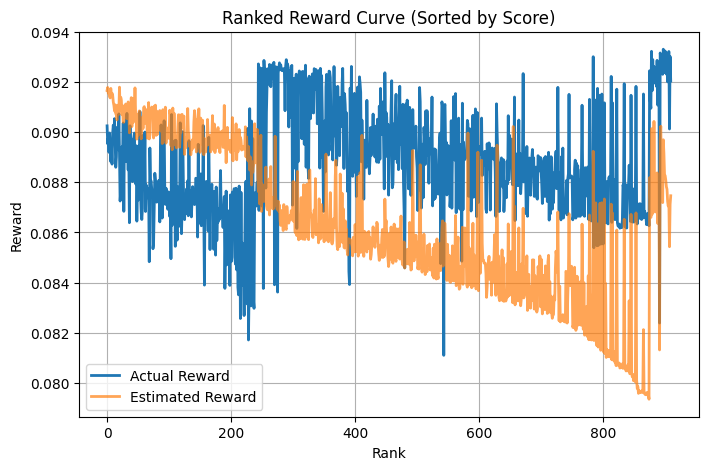

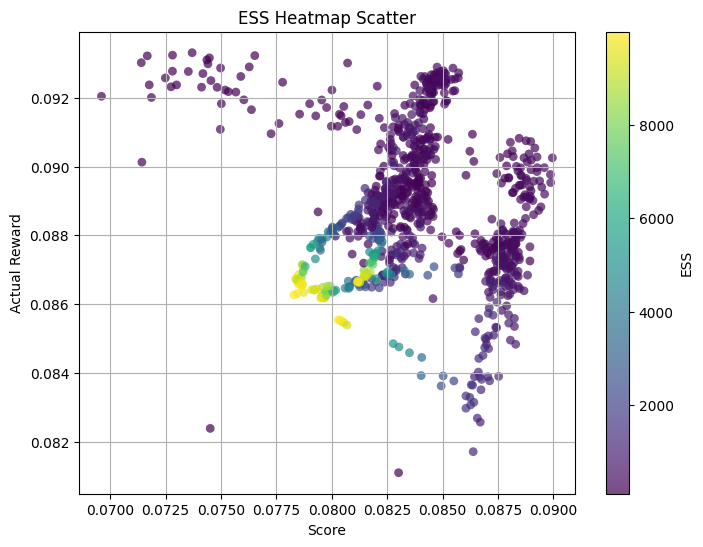

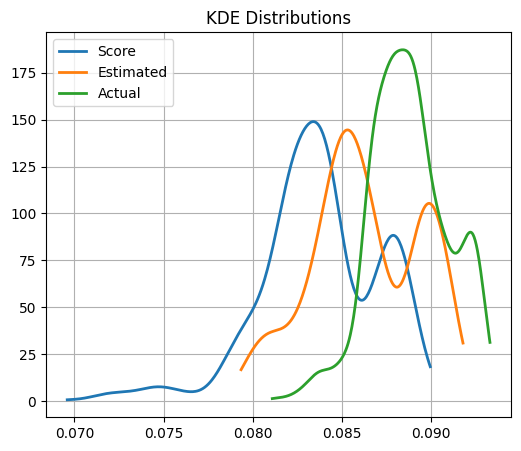

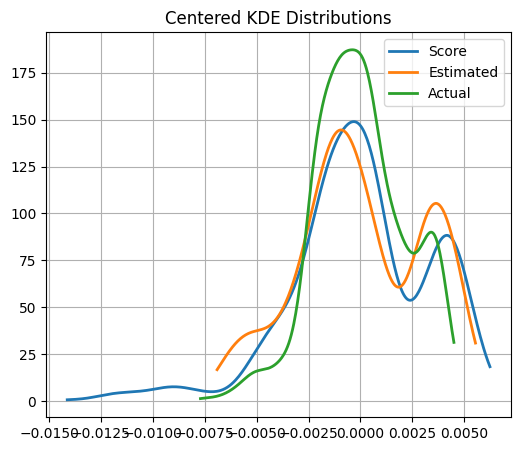

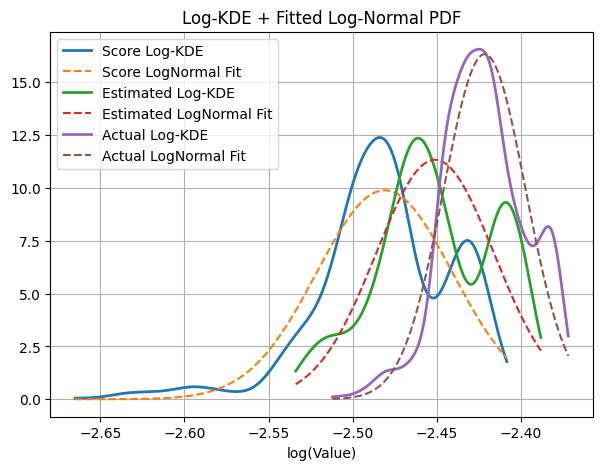

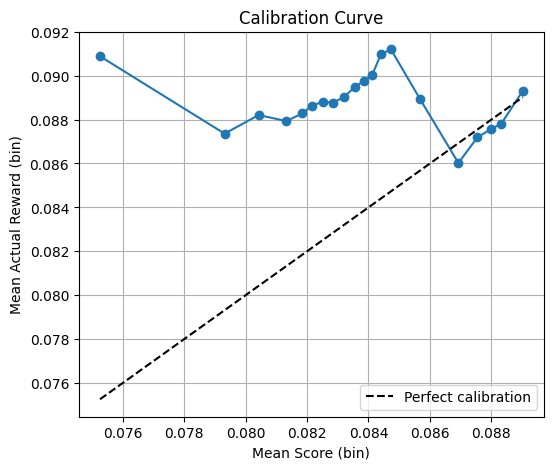

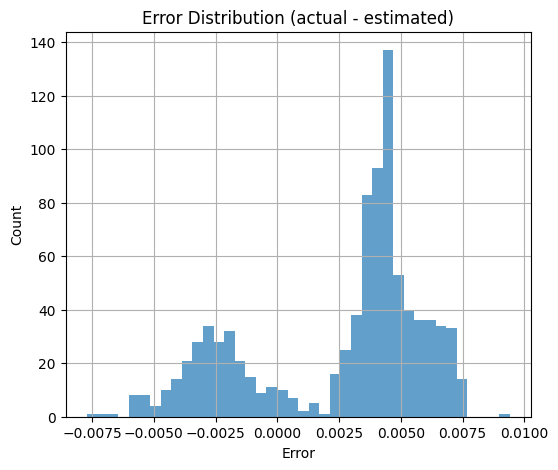

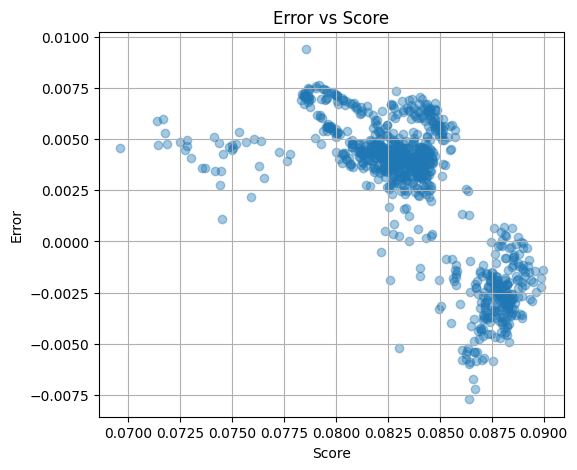

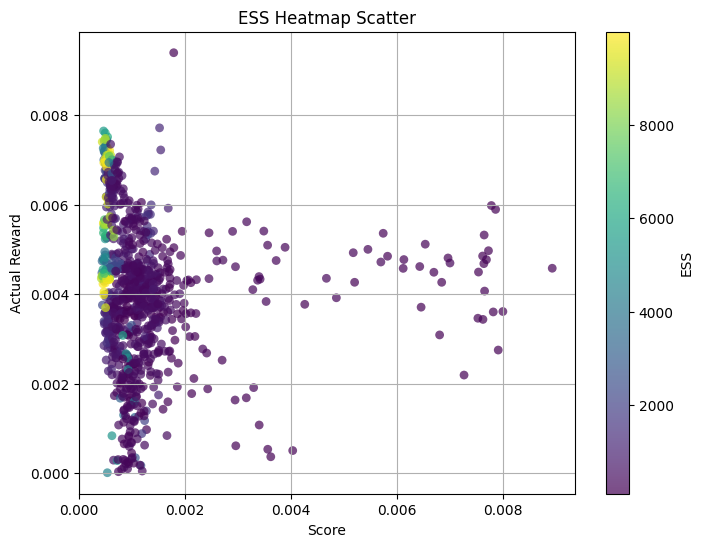

Correlation Metrics: {'pearson_score_actual': np.float64(-0.19693714325099612), 'spearman_score_actual': np.float64(-0.030551045357970624), 'spearman_est_actual': np.float64(0.15957866639850316)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9944980250925036), 'ndcg_est_actual': np.float64(0.9945802434815242)}
Error Metrics: {'mean_error': np.float64(0.0025515216860407123), 'mae': np.float64(0.0040489676138785805), 'rmse': np.float64(0.004363211057319191), 'std_error': np.float64(0.003539399358136407), 'max_error': np.float64(0.009396932292341079), 'min_error': np.float64(-0.007716618452982993)}


In [21]:

compute_statistics_and_plots(all_dfs)